In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "big"
enable_aug = False
enable_aug3 = False
sentence_pairs = False
regressive_style_finetuning = False
lstm_bidi = True
lstm_hidden_size = 256
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-big-enable_aug-False-enable_aug3-False-sentence_pairs-False-regressive_style_finetuning-False-lstm_bidi-True-lstm_hidden_size-256-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    global data
    if enable_orig == "big" or enable_orig == "big-preprocess":
        data += load_gen_dataset("./yelp_dataset/more_yelp_234.json")
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess" or enable_orig == "big-preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

199999


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

199999
199999
2021
2021


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


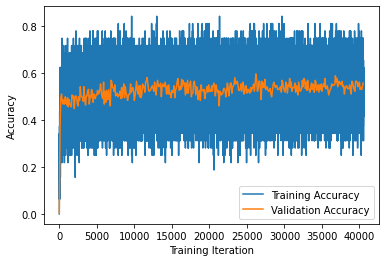

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.192 Validation Loss: 2.177 Accuracy: 0.133 Validation Accuracy: 0.123:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.188 Validation Loss: 2.177 Accuracy: 0.109 Validation Accuracy: 0.123:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.184 Validation Loss: 2.177 Accuracy: 0.120 Validation Accuracy: 0.123:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.180 Validation Loss: 2.177 Accuracy: 0.143 Validation Accuracy: 0.123:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.178 Validation Loss: 2.177 Accuracy: 0.166 Validation Accuracy: 0.123:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 5 Loss: 2.175 Validation Loss: 2.177 Accuracy: 0.182 Validation Accuracy: 0.123:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 6 Loss: 2.173 Validation Loss: 2.177 Accuracy: 0.189 Validation Accuracy: 0.123:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 7 Loss: 2.171 Validation Loss: 2.177 Accuracy: 0.196 Validation Accuracy: 0.123:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 8 Loss: 2.169 Validation Loss: 2.177 Accuracy: 0.209 Validation Accuracy: 0.123:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 9 Loss: 2.168 Validation Loss: 2.177 Accuracy: 0.216 Validation Accuracy: 0.123:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 10 Loss: 2.166 Validation Loss: 2.177 Accuracy: 0.235 Validation Accuracy: 0.123:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 11 Loss: 2.164 Validation Loss: 2.177 Accuracy: 0.264 Validation Accuracy: 0.123:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 12 Loss: 2.162 Validation Loss: 2.177 Accuracy: 0.284 Validation Accuracy: 0.123:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.161 Validation Loss: 2.177 Accuracy: 0.298 Validation Accuracy: 0.123:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 13 Loss: 2.161 Validation Loss: 2.177 Accuracy: 0.298 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 14 Loss: 2.158 Validation Loss: 2.177 Accuracy: 0.313 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 15 Loss: 2.156 Validation Loss: 2.177 Accuracy: 0.328 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 16 Loss: 2.154 Validation Loss: 2.177 Accuracy: 0.348 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 17 Loss: 2.153 Validation Loss: 2.177 Accuracy: 0.359 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 18 Loss: 2.151 Validation Loss: 2.177 Accuracy: 0.372 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 19 Loss: 2.150 Validation Loss: 2.177 Accuracy: 0.384 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 20 Loss: 2.146 Validation Loss: 2.177 Accuracy: 0.396 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 21 Loss: 2.142 Validation Loss: 2.177 Accuracy: 0.401 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 22 Loss: 2.139 Validation Loss: 2.177 Accuracy: 0.409 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 23 Loss: 2.136 Validation Loss: 2.177 Accuracy: 0.416 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 24 Loss: 2.133 Validation Loss: 2.177 Accuracy: 0.418 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 25 Loss: 2.130 Validation Loss: 2.177 Accuracy: 0.416 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 26 Loss: 2.126 Validation Loss: 2.177 Accuracy: 0.419 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 27 Loss: 2.122 Validation Loss: 2.177 Accuracy: 0.430 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 28 Loss: 2.120 Validation Loss: 2.177 Accuracy: 0.430 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 29 Loss: 2.116 Validation Loss: 2.177 Accuracy: 0.431 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 30 Loss: 2.113 Validation Loss: 2.177 Accuracy: 0.437 Validation Accuracy: 0.123:   1%|          | 14/1563 [00:00<00:11, 136.94it/s]

Epoch: 0 Iteration: 30 Loss: 2.113 Validation Loss: 2.177 Accuracy: 0.437 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 31 Loss: 2.109 Validation Loss: 2.177 Accuracy: 0.451 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 32 Loss: 2.106 Validation Loss: 2.177 Accuracy: 0.458 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 33 Loss: 2.102 Validation Loss: 2.177 Accuracy: 0.460 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 34 Loss: 2.099 Validation Loss: 2.177 Accuracy: 0.467 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 35 Loss: 2.095 Validation Loss: 2.177 Accuracy: 0.486 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 36 Loss: 2.092 Validation Loss: 2.177 Accuracy: 0.483 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 37 Loss: 2.089 Validation Loss: 2.177 Accuracy: 0.484 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 38 Loss: 2.086 Validation Loss: 2.177 Accuracy: 0.483 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 39 Loss: 2.083 Validation Loss: 2.177 Accuracy: 0.487 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 40 Loss: 2.080 Validation Loss: 2.177 Accuracy: 0.481 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 41 Loss: 2.076 Validation Loss: 2.177 Accuracy: 0.480 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 42 Loss: 2.072 Validation Loss: 2.177 Accuracy: 0.486 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 43 Loss: 2.069 Validation Loss: 2.177 Accuracy: 0.495 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 44 Loss: 2.066 Validation Loss: 2.177 Accuracy: 0.493 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 45 Loss: 2.063 Validation Loss: 2.177 Accuracy: 0.482 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 46 Loss: 2.060 Validation Loss: 2.177 Accuracy: 0.489 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 47 Loss: 2.056 Validation Loss: 2.177 Accuracy: 0.498 Validation Accuracy: 0.123:   2%|▏         | 31/1563 [00:00<00:10, 151.86it/s]

Epoch: 0 Iteration: 47 Loss: 2.056 Validation Loss: 2.177 Accuracy: 0.498 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 48 Loss: 2.052 Validation Loss: 2.177 Accuracy: 0.514 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 49 Loss: 2.049 Validation Loss: 2.177 Accuracy: 0.522 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 50 Loss: 2.045 Validation Loss: 2.177 Accuracy: 0.537 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 51 Loss: 2.043 Validation Loss: 2.177 Accuracy: 0.531 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 52 Loss: 2.039 Validation Loss: 2.177 Accuracy: 0.530 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 53 Loss: 2.036 Validation Loss: 2.177 Accuracy: 0.534 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 54 Loss: 2.032 Validation Loss: 2.177 Accuracy: 0.540 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 55 Loss: 2.029 Validation Loss: 2.177 Accuracy: 0.548 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 56 Loss: 2.026 Validation Loss: 2.177 Accuracy: 0.547 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 57 Loss: 2.023 Validation Loss: 2.177 Accuracy: 0.547 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 58 Loss: 2.019 Validation Loss: 2.177 Accuracy: 0.548 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 59 Loss: 2.016 Validation Loss: 2.177 Accuracy: 0.542 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 60 Loss: 2.012 Validation Loss: 2.177 Accuracy: 0.545 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 61 Loss: 2.009 Validation Loss: 2.177 Accuracy: 0.555 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 62 Loss: 2.005 Validation Loss: 2.177 Accuracy: 0.560 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 63 Loss: 2.002 Validation Loss: 2.177 Accuracy: 0.561 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 64 Loss: 1.999 Validation Loss: 2.177 Accuracy: 0.561 Validation Accuracy: 0.123:   3%|▎         | 48/1563 [00:00<00:09, 156.91it/s]

Epoch: 0 Iteration: 64 Loss: 1.999 Validation Loss: 2.177 Accuracy: 0.561 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 65 Loss: 1.995 Validation Loss: 2.177 Accuracy: 0.562 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 66 Loss: 1.991 Validation Loss: 2.177 Accuracy: 0.574 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 67 Loss: 1.989 Validation Loss: 2.177 Accuracy: 0.563 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 68 Loss: 1.986 Validation Loss: 2.177 Accuracy: 0.558 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 69 Loss: 1.980 Validation Loss: 2.177 Accuracy: 0.576 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 70 Loss: 1.977 Validation Loss: 2.177 Accuracy: 0.570 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 71 Loss: 1.973 Validation Loss: 2.177 Accuracy: 0.562 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 72 Loss: 1.970 Validation Loss: 2.177 Accuracy: 0.570 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 73 Loss: 1.967 Validation Loss: 2.177 Accuracy: 0.566 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 74 Loss: 1.964 Validation Loss: 2.177 Accuracy: 0.565 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 75 Loss: 1.962 Validation Loss: 2.177 Accuracy: 0.562 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 76 Loss: 1.958 Validation Loss: 2.177 Accuracy: 0.556 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 77 Loss: 1.953 Validation Loss: 2.177 Accuracy: 0.569 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 78 Loss: 1.949 Validation Loss: 2.177 Accuracy: 0.579 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 79 Loss: 1.944 Validation Loss: 2.177 Accuracy: 0.573 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 80 Loss: 1.941 Validation Loss: 2.177 Accuracy: 0.572 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 81 Loss: 1.938 Validation Loss: 2.177 Accuracy: 0.574 Validation Accuracy: 0.123:   4%|▍         | 65/1563 [00:00<00:09, 159.80it/s]

Epoch: 0 Iteration: 81 Loss: 1.938 Validation Loss: 2.177 Accuracy: 0.574 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 82 Loss: 1.936 Validation Loss: 2.177 Accuracy: 0.552 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 83 Loss: 1.932 Validation Loss: 2.177 Accuracy: 0.559 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 84 Loss: 1.928 Validation Loss: 2.177 Accuracy: 0.561 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 85 Loss: 1.926 Validation Loss: 2.177 Accuracy: 0.560 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 86 Loss: 1.923 Validation Loss: 2.177 Accuracy: 0.561 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 87 Loss: 1.920 Validation Loss: 2.177 Accuracy: 0.557 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 88 Loss: 1.915 Validation Loss: 2.177 Accuracy: 0.554 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 89 Loss: 1.913 Validation Loss: 2.177 Accuracy: 0.563 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 90 Loss: 1.908 Validation Loss: 2.177 Accuracy: 0.573 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 91 Loss: 1.905 Validation Loss: 2.177 Accuracy: 0.573 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 92 Loss: 1.901 Validation Loss: 2.177 Accuracy: 0.590 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 93 Loss: 1.897 Validation Loss: 2.177 Accuracy: 0.589 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 94 Loss: 1.894 Validation Loss: 2.177 Accuracy: 0.592 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 95 Loss: 1.889 Validation Loss: 2.177 Accuracy: 0.603 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 96 Loss: 1.884 Validation Loss: 2.177 Accuracy: 0.609 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 97 Loss: 1.882 Validation Loss: 2.177 Accuracy: 0.608 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 98 Loss: 1.880 Validation Loss: 2.177 Accuracy: 0.602 Validation Accuracy: 0.123:   5%|▌         | 82/1563 [00:00<00:09, 161.23it/s]

Epoch: 0 Iteration: 98 Loss: 1.880 Validation Loss: 2.177 Accuracy: 0.602 Validation Accuracy: 0.123:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 99 Loss: 1.877 Validation Loss: 2.177 Accuracy: 0.593 Validation Accuracy: 0.123:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 100 Loss: 1.874 Validation Loss: 1.838 Accuracy: 0.590 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 101 Loss: 1.869 Validation Loss: 1.838 Accuracy: 0.598 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 102 Loss: 1.864 Validation Loss: 1.838 Accuracy: 0.595 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 103 Loss: 1.862 Validation Loss: 1.838 Accuracy: 0.591 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 104 Loss: 1.858 Validation Loss: 1.838 Accuracy: 0.597 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 105 Loss: 1.852 Validation Loss: 1.838 Accuracy: 0.595 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 106 Loss: 1.849 Validation Loss: 1.838 Accuracy: 0.596 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 107 Loss: 1.844 Validation Loss: 1.838 Accuracy: 0.611 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 108 Loss: 1.842 Validation Loss: 1.838 Accuracy: 0.623 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 109 Loss: 1.838 Validation Loss: 1.838 Accuracy: 0.627 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 110 Loss: 1.834 Validation Loss: 1.838 Accuracy: 0.630 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 111 Loss: 1.830 Validation Loss: 1.838 Accuracy: 0.629 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 112 Loss: 1.829 Validation Loss: 1.838 Accuracy: 0.623 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 113 Loss: 1.825 Validation Loss: 1.838 Accuracy: 0.629 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 114 Loss: 1.820 Validation Loss: 1.838 Accuracy: 0.633 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 115 Loss: 1.816 Validation Loss: 1.838 Accuracy: 0.641 Validation Accuracy: 0.369:   6%|▋         | 99/1563 [00:00<00:09, 162.38it/s]

Epoch: 0 Iteration: 115 Loss: 1.816 Validation Loss: 1.838 Accuracy: 0.641 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 116 Loss: 1.812 Validation Loss: 1.838 Accuracy: 0.639 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 117 Loss: 1.808 Validation Loss: 1.838 Accuracy: 0.641 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 118 Loss: 1.802 Validation Loss: 1.838 Accuracy: 0.641 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 119 Loss: 1.797 Validation Loss: 1.838 Accuracy: 0.646 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 120 Loss: 1.792 Validation Loss: 1.838 Accuracy: 0.647 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 121 Loss: 1.790 Validation Loss: 1.838 Accuracy: 0.645 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 122 Loss: 1.785 Validation Loss: 1.838 Accuracy: 0.656 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 123 Loss: 1.781 Validation Loss: 1.838 Accuracy: 0.650 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 124 Loss: 1.778 Validation Loss: 1.838 Accuracy: 0.650 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 125 Loss: 1.774 Validation Loss: 1.838 Accuracy: 0.640 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 126 Loss: 1.770 Validation Loss: 1.838 Accuracy: 0.644 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 127 Loss: 1.766 Validation Loss: 1.838 Accuracy: 0.641 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 128 Loss: 1.760 Validation Loss: 1.838 Accuracy: 0.629 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 129 Loss: 1.759 Validation Loss: 1.838 Accuracy: 0.620 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 130 Loss: 1.758 Validation Loss: 1.838 Accuracy: 0.616 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 131 Loss: 1.753 Validation Loss: 1.838 Accuracy: 0.624 Validation Accuracy: 0.369:   7%|▋         | 116/1563 [00:00<00:09, 159.70it/s]

Epoch: 0 Iteration: 131 Loss: 1.753 Validation Loss: 1.838 Accuracy: 0.624 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 132 Loss: 1.746 Validation Loss: 1.838 Accuracy: 0.624 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 133 Loss: 1.743 Validation Loss: 1.838 Accuracy: 0.627 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 134 Loss: 1.740 Validation Loss: 1.838 Accuracy: 0.620 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 135 Loss: 1.737 Validation Loss: 1.838 Accuracy: 0.621 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 136 Loss: 1.734 Validation Loss: 1.838 Accuracy: 0.621 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 137 Loss: 1.730 Validation Loss: 1.838 Accuracy: 0.618 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 138 Loss: 1.726 Validation Loss: 1.838 Accuracy: 0.627 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 139 Loss: 1.725 Validation Loss: 1.838 Accuracy: 0.627 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 140 Loss: 1.722 Validation Loss: 1.838 Accuracy: 0.627 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 141 Loss: 1.719 Validation Loss: 1.838 Accuracy: 0.622 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 142 Loss: 1.717 Validation Loss: 1.838 Accuracy: 0.624 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 143 Loss: 1.712 Validation Loss: 1.838 Accuracy: 0.627 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 144 Loss: 1.706 Validation Loss: 1.838 Accuracy: 0.633 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 145 Loss: 1.701 Validation Loss: 1.838 Accuracy: 0.641 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 146 Loss: 1.696 Validation Loss: 1.838 Accuracy: 0.641 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 147 Loss: 1.694 Validation Loss: 1.838 Accuracy: 0.637 Validation Accuracy: 0.369:   8%|▊         | 132/1563 [00:00<00:09, 150.37it/s]

Epoch: 0 Iteration: 147 Loss: 1.694 Validation Loss: 1.838 Accuracy: 0.637 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:00<00:09, 142.43it/s]

Epoch: 0 Iteration: 148 Loss: 1.688 Validation Loss: 1.838 Accuracy: 0.637 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:00<00:09, 142.43it/s]

Epoch: 0 Iteration: 149 Loss: 1.683 Validation Loss: 1.838 Accuracy: 0.641 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:00<00:09, 142.43it/s]

Epoch: 0 Iteration: 150 Loss: 1.678 Validation Loss: 1.838 Accuracy: 0.638 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:00<00:09, 142.43it/s]

Epoch: 0 Iteration: 151 Loss: 1.675 Validation Loss: 1.838 Accuracy: 0.643 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:01<00:09, 142.43it/s]

Epoch: 0 Iteration: 152 Loss: 1.672 Validation Loss: 1.838 Accuracy: 0.644 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:01<00:09, 142.43it/s]

Epoch: 0 Iteration: 153 Loss: 1.669 Validation Loss: 1.838 Accuracy: 0.643 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:01<00:09, 142.43it/s]

Epoch: 0 Iteration: 154 Loss: 1.663 Validation Loss: 1.838 Accuracy: 0.645 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:01<00:09, 142.43it/s]

Epoch: 0 Iteration: 155 Loss: 1.659 Validation Loss: 1.838 Accuracy: 0.641 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:01<00:09, 142.43it/s]

Epoch: 0 Iteration: 156 Loss: 1.656 Validation Loss: 1.838 Accuracy: 0.640 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:01<00:09, 142.43it/s]

Epoch: 0 Iteration: 157 Loss: 1.654 Validation Loss: 1.838 Accuracy: 0.638 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:01<00:09, 142.43it/s]

Epoch: 0 Iteration: 158 Loss: 1.652 Validation Loss: 1.838 Accuracy: 0.637 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:01<00:09, 142.43it/s]

Epoch: 0 Iteration: 159 Loss: 1.648 Validation Loss: 1.838 Accuracy: 0.634 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:01<00:09, 142.43it/s]

Epoch: 0 Iteration: 160 Loss: 1.645 Validation Loss: 1.838 Accuracy: 0.642 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:01<00:09, 142.43it/s]

Epoch: 0 Iteration: 161 Loss: 1.639 Validation Loss: 1.838 Accuracy: 0.643 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:01<00:09, 142.43it/s]

Epoch: 0 Iteration: 162 Loss: 1.635 Validation Loss: 1.838 Accuracy: 0.641 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:01<00:09, 142.43it/s]

Epoch: 0 Iteration: 163 Loss: 1.631 Validation Loss: 1.838 Accuracy: 0.652 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:01<00:09, 142.43it/s]

Epoch: 0 Iteration: 164 Loss: 1.626 Validation Loss: 1.838 Accuracy: 0.657 Validation Accuracy: 0.369:   9%|▉         | 148/1563 [00:01<00:09, 142.43it/s]

Epoch: 0 Iteration: 164 Loss: 1.626 Validation Loss: 1.838 Accuracy: 0.657 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 165 Loss: 1.622 Validation Loss: 1.838 Accuracy: 0.660 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 166 Loss: 1.620 Validation Loss: 1.838 Accuracy: 0.661 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 167 Loss: 1.617 Validation Loss: 1.838 Accuracy: 0.673 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 168 Loss: 1.615 Validation Loss: 1.838 Accuracy: 0.675 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 169 Loss: 1.611 Validation Loss: 1.838 Accuracy: 0.677 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 170 Loss: 1.606 Validation Loss: 1.838 Accuracy: 0.683 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 171 Loss: 1.601 Validation Loss: 1.838 Accuracy: 0.680 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 172 Loss: 1.598 Validation Loss: 1.838 Accuracy: 0.681 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 173 Loss: 1.594 Validation Loss: 1.838 Accuracy: 0.667 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 174 Loss: 1.590 Validation Loss: 1.838 Accuracy: 0.667 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 175 Loss: 1.587 Validation Loss: 1.838 Accuracy: 0.666 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 176 Loss: 1.582 Validation Loss: 1.838 Accuracy: 0.668 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 177 Loss: 1.576 Validation Loss: 1.838 Accuracy: 0.663 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 178 Loss: 1.573 Validation Loss: 1.838 Accuracy: 0.656 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 179 Loss: 1.570 Validation Loss: 1.838 Accuracy: 0.659 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 180 Loss: 1.564 Validation Loss: 1.838 Accuracy: 0.650 Validation Accuracy: 0.369:  11%|█         | 165/1563 [00:01<00:09, 149.68it/s]

Epoch: 0 Iteration: 180 Loss: 1.564 Validation Loss: 1.838 Accuracy: 0.650 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 181 Loss: 1.561 Validation Loss: 1.838 Accuracy: 0.655 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 182 Loss: 1.556 Validation Loss: 1.838 Accuracy: 0.659 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 183 Loss: 1.549 Validation Loss: 1.838 Accuracy: 0.668 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 184 Loss: 1.546 Validation Loss: 1.838 Accuracy: 0.661 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 185 Loss: 1.542 Validation Loss: 1.838 Accuracy: 0.666 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 186 Loss: 1.536 Validation Loss: 1.838 Accuracy: 0.662 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 187 Loss: 1.529 Validation Loss: 1.838 Accuracy: 0.670 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 188 Loss: 1.526 Validation Loss: 1.838 Accuracy: 0.678 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 189 Loss: 1.522 Validation Loss: 1.838 Accuracy: 0.684 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 190 Loss: 1.517 Validation Loss: 1.838 Accuracy: 0.690 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 191 Loss: 1.514 Validation Loss: 1.838 Accuracy: 0.684 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 192 Loss: 1.509 Validation Loss: 1.838 Accuracy: 0.680 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 193 Loss: 1.503 Validation Loss: 1.838 Accuracy: 0.673 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 194 Loss: 1.498 Validation Loss: 1.838 Accuracy: 0.682 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 195 Loss: 1.494 Validation Loss: 1.838 Accuracy: 0.670 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 196 Loss: 1.489 Validation Loss: 1.838 Accuracy: 0.666 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 197 Loss: 1.485 Validation Loss: 1.838 Accuracy: 0.663 Validation Accuracy: 0.369:  12%|█▏        | 181/1563 [00:01<00:10, 135.46it/s]

Epoch: 0 Iteration: 197 Loss: 1.485 Validation Loss: 1.838 Accuracy: 0.663 Validation Accuracy: 0.369:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 198 Loss: 1.480 Validation Loss: 1.838 Accuracy: 0.658 Validation Accuracy: 0.369:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 199 Loss: 1.477 Validation Loss: 1.838 Accuracy: 0.651 Validation Accuracy: 0.369:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 200 Loss: 1.475 Validation Loss: 1.456 Accuracy: 0.644 Validation Accuracy: 0.465:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 201 Loss: 1.470 Validation Loss: 1.456 Accuracy: 0.648 Validation Accuracy: 0.465:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 202 Loss: 1.468 Validation Loss: 1.456 Accuracy: 0.648 Validation Accuracy: 0.465:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 203 Loss: 1.467 Validation Loss: 1.456 Accuracy: 0.657 Validation Accuracy: 0.465:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 204 Loss: 1.462 Validation Loss: 1.456 Accuracy: 0.659 Validation Accuracy: 0.465:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 205 Loss: 1.461 Validation Loss: 1.456 Accuracy: 0.663 Validation Accuracy: 0.465:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 206 Loss: 1.458 Validation Loss: 1.456 Accuracy: 0.670 Validation Accuracy: 0.465:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 207 Loss: 1.459 Validation Loss: 1.456 Accuracy: 0.664 Validation Accuracy: 0.465:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 208 Loss: 1.455 Validation Loss: 1.456 Accuracy: 0.663 Validation Accuracy: 0.465:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 209 Loss: 1.451 Validation Loss: 1.456 Accuracy: 0.670 Validation Accuracy: 0.465:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 210 Loss: 1.448 Validation Loss: 1.456 Accuracy: 0.677 Validation Accuracy: 0.465:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 211 Loss: 1.444 Validation Loss: 1.456 Accuracy: 0.675 Validation Accuracy: 0.465:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 212 Loss: 1.442 Validation Loss: 1.456 Accuracy: 0.683 Validation Accuracy: 0.465:  13%|█▎        | 198/1563 [00:01<00:09, 143.62it/s]

Epoch: 0 Iteration: 212 Loss: 1.442 Validation Loss: 1.456 Accuracy: 0.683 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 213 Loss: 1.437 Validation Loss: 1.456 Accuracy: 0.690 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 214 Loss: 1.437 Validation Loss: 1.456 Accuracy: 0.679 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 215 Loss: 1.430 Validation Loss: 1.456 Accuracy: 0.688 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 216 Loss: 1.428 Validation Loss: 1.456 Accuracy: 0.689 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 217 Loss: 1.425 Validation Loss: 1.456 Accuracy: 0.695 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 218 Loss: 1.422 Validation Loss: 1.456 Accuracy: 0.691 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 219 Loss: 1.417 Validation Loss: 1.456 Accuracy: 0.688 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 220 Loss: 1.412 Validation Loss: 1.456 Accuracy: 0.686 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 221 Loss: 1.408 Validation Loss: 1.456 Accuracy: 0.685 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 222 Loss: 1.400 Validation Loss: 1.456 Accuracy: 0.680 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 223 Loss: 1.398 Validation Loss: 1.456 Accuracy: 0.671 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 224 Loss: 1.396 Validation Loss: 1.456 Accuracy: 0.679 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 225 Loss: 1.393 Validation Loss: 1.456 Accuracy: 0.669 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 226 Loss: 1.387 Validation Loss: 1.456 Accuracy: 0.671 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 227 Loss: 1.383 Validation Loss: 1.456 Accuracy: 0.670 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 228 Loss: 1.381 Validation Loss: 1.456 Accuracy: 0.680 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 229 Loss: 1.378 Validation Loss: 1.456 Accuracy: 0.678 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:01<00:09, 144.11it/s]

Epoch: 0 Iteration: 229 Loss: 1.378 Validation Loss: 1.456 Accuracy: 0.678 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 230 Loss: 1.373 Validation Loss: 1.456 Accuracy: 0.680 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 231 Loss: 1.370 Validation Loss: 1.456 Accuracy: 0.678 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 232 Loss: 1.364 Validation Loss: 1.456 Accuracy: 0.683 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 233 Loss: 1.358 Validation Loss: 1.456 Accuracy: 0.689 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 234 Loss: 1.353 Validation Loss: 1.456 Accuracy: 0.683 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 235 Loss: 1.348 Validation Loss: 1.456 Accuracy: 0.691 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 236 Loss: 1.343 Validation Loss: 1.456 Accuracy: 0.691 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 237 Loss: 1.342 Validation Loss: 1.456 Accuracy: 0.687 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 238 Loss: 1.337 Validation Loss: 1.456 Accuracy: 0.680 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 239 Loss: 1.332 Validation Loss: 1.456 Accuracy: 0.680 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 240 Loss: 1.330 Validation Loss: 1.456 Accuracy: 0.683 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 241 Loss: 1.328 Validation Loss: 1.456 Accuracy: 0.685 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 242 Loss: 1.326 Validation Loss: 1.456 Accuracy: 0.680 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 243 Loss: 1.320 Validation Loss: 1.456 Accuracy: 0.671 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 244 Loss: 1.317 Validation Loss: 1.456 Accuracy: 0.669 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 245 Loss: 1.309 Validation Loss: 1.456 Accuracy: 0.667 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 246 Loss: 1.307 Validation Loss: 1.456 Accuracy: 0.666 Validation Accuracy: 0.465:  15%|█▍        | 230/1563 [00:01<00:08, 150.30it/s]

Epoch: 0 Iteration: 246 Loss: 1.307 Validation Loss: 1.456 Accuracy: 0.666 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 247 Loss: 1.299 Validation Loss: 1.456 Accuracy: 0.676 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 248 Loss: 1.291 Validation Loss: 1.456 Accuracy: 0.688 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 249 Loss: 1.288 Validation Loss: 1.456 Accuracy: 0.692 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 250 Loss: 1.286 Validation Loss: 1.456 Accuracy: 0.694 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 251 Loss: 1.282 Validation Loss: 1.456 Accuracy: 0.695 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 252 Loss: 1.279 Validation Loss: 1.456 Accuracy: 0.694 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 253 Loss: 1.277 Validation Loss: 1.456 Accuracy: 0.706 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 254 Loss: 1.274 Validation Loss: 1.456 Accuracy: 0.715 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 255 Loss: 1.274 Validation Loss: 1.456 Accuracy: 0.713 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 256 Loss: 1.268 Validation Loss: 1.456 Accuracy: 0.721 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 257 Loss: 1.263 Validation Loss: 1.456 Accuracy: 0.713 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 258 Loss: 1.257 Validation Loss: 1.456 Accuracy: 0.708 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 259 Loss: 1.249 Validation Loss: 1.456 Accuracy: 0.718 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 260 Loss: 1.244 Validation Loss: 1.456 Accuracy: 0.722 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 261 Loss: 1.241 Validation Loss: 1.456 Accuracy: 0.716 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 262 Loss: 1.239 Validation Loss: 1.456 Accuracy: 0.719 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 263 Loss: 1.237 Validation Loss: 1.456 Accuracy: 0.709 Validation Accuracy: 0.465:  16%|█▌        | 247/1563 [00:01<00:08, 154.80it/s]

Epoch: 0 Iteration: 263 Loss: 1.237 Validation Loss: 1.456 Accuracy: 0.709 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 264 Loss: 1.232 Validation Loss: 1.456 Accuracy: 0.706 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 265 Loss: 1.231 Validation Loss: 1.456 Accuracy: 0.702 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 266 Loss: 1.230 Validation Loss: 1.456 Accuracy: 0.694 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 267 Loss: 1.228 Validation Loss: 1.456 Accuracy: 0.698 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 268 Loss: 1.225 Validation Loss: 1.456 Accuracy: 0.705 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 269 Loss: 1.221 Validation Loss: 1.456 Accuracy: 0.690 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 270 Loss: 1.220 Validation Loss: 1.456 Accuracy: 0.679 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 271 Loss: 1.217 Validation Loss: 1.456 Accuracy: 0.692 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 272 Loss: 1.212 Validation Loss: 1.456 Accuracy: 0.696 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 273 Loss: 1.211 Validation Loss: 1.456 Accuracy: 0.704 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 274 Loss: 1.205 Validation Loss: 1.456 Accuracy: 0.713 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 275 Loss: 1.200 Validation Loss: 1.456 Accuracy: 0.720 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 276 Loss: 1.201 Validation Loss: 1.456 Accuracy: 0.717 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 277 Loss: 1.194 Validation Loss: 1.456 Accuracy: 0.724 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 278 Loss: 1.193 Validation Loss: 1.456 Accuracy: 0.720 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 279 Loss: 1.195 Validation Loss: 1.456 Accuracy: 0.721 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 280 Loss: 1.194 Validation Loss: 1.456 Accuracy: 0.724 Validation Accuracy: 0.465:  17%|█▋        | 264/1563 [00:01<00:08, 158.16it/s]

Epoch: 0 Iteration: 280 Loss: 1.194 Validation Loss: 1.456 Accuracy: 0.724 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 281 Loss: 1.187 Validation Loss: 1.456 Accuracy: 0.716 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 282 Loss: 1.185 Validation Loss: 1.456 Accuracy: 0.710 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 283 Loss: 1.184 Validation Loss: 1.456 Accuracy: 0.703 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 284 Loss: 1.183 Validation Loss: 1.456 Accuracy: 0.695 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 285 Loss: 1.177 Validation Loss: 1.456 Accuracy: 0.701 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 286 Loss: 1.169 Validation Loss: 1.456 Accuracy: 0.705 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 287 Loss: 1.167 Validation Loss: 1.456 Accuracy: 0.697 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 288 Loss: 1.163 Validation Loss: 1.456 Accuracy: 0.695 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 289 Loss: 1.161 Validation Loss: 1.456 Accuracy: 0.694 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 290 Loss: 1.154 Validation Loss: 1.456 Accuracy: 0.695 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 291 Loss: 1.150 Validation Loss: 1.456 Accuracy: 0.698 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 292 Loss: 1.146 Validation Loss: 1.456 Accuracy: 0.700 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 293 Loss: 1.143 Validation Loss: 1.456 Accuracy: 0.705 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 294 Loss: 1.139 Validation Loss: 1.456 Accuracy: 0.711 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 295 Loss: 1.136 Validation Loss: 1.456 Accuracy: 0.711 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 296 Loss: 1.132 Validation Loss: 1.456 Accuracy: 0.709 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 297 Loss: 1.133 Validation Loss: 1.456 Accuracy: 0.714 Validation Accuracy: 0.465:  18%|█▊        | 281/1563 [00:01<00:07, 160.69it/s]

Epoch: 0 Iteration: 297 Loss: 1.133 Validation Loss: 1.456 Accuracy: 0.714 Validation Accuracy: 0.465:  19%|█▉        | 298/1563 [00:01<00:07, 162.36it/s]

Epoch: 0 Iteration: 298 Loss: 1.131 Validation Loss: 1.456 Accuracy: 0.714 Validation Accuracy: 0.465:  19%|█▉        | 298/1563 [00:01<00:07, 162.36it/s]

Epoch: 0 Iteration: 299 Loss: 1.125 Validation Loss: 1.456 Accuracy: 0.719 Validation Accuracy: 0.465:  19%|█▉        | 298/1563 [00:01<00:07, 162.36it/s]

Epoch: 0 Iteration: 300 Loss: 1.118 Validation Loss: 1.123 Accuracy: 0.720 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:01<00:07, 162.36it/s]

Epoch: 0 Iteration: 301 Loss: 1.116 Validation Loss: 1.123 Accuracy: 0.721 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:01<00:07, 162.36it/s]

Epoch: 0 Iteration: 302 Loss: 1.113 Validation Loss: 1.123 Accuracy: 0.724 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:01<00:07, 162.36it/s]

Epoch: 0 Iteration: 303 Loss: 1.110 Validation Loss: 1.123 Accuracy: 0.718 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:01<00:07, 162.36it/s]

Epoch: 0 Iteration: 304 Loss: 1.104 Validation Loss: 1.123 Accuracy: 0.717 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:01<00:07, 162.36it/s]

Epoch: 0 Iteration: 305 Loss: 1.106 Validation Loss: 1.123 Accuracy: 0.707 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:01<00:07, 162.36it/s]

Epoch: 0 Iteration: 306 Loss: 1.107 Validation Loss: 1.123 Accuracy: 0.705 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:02<00:07, 162.36it/s]

Epoch: 0 Iteration: 307 Loss: 1.102 Validation Loss: 1.123 Accuracy: 0.707 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:02<00:07, 162.36it/s]

Epoch: 0 Iteration: 308 Loss: 1.101 Validation Loss: 1.123 Accuracy: 0.709 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:02<00:07, 162.36it/s]

Epoch: 0 Iteration: 309 Loss: 1.100 Validation Loss: 1.123 Accuracy: 0.705 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:02<00:07, 162.36it/s]

Epoch: 0 Iteration: 310 Loss: 1.099 Validation Loss: 1.123 Accuracy: 0.701 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:02<00:07, 162.36it/s]

Epoch: 0 Iteration: 311 Loss: 1.097 Validation Loss: 1.123 Accuracy: 0.699 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:02<00:07, 162.36it/s]

Epoch: 0 Iteration: 312 Loss: 1.098 Validation Loss: 1.123 Accuracy: 0.698 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:02<00:07, 162.36it/s]

Epoch: 0 Iteration: 313 Loss: 1.098 Validation Loss: 1.123 Accuracy: 0.694 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:02<00:07, 162.36it/s]

Epoch: 0 Iteration: 314 Loss: 1.096 Validation Loss: 1.123 Accuracy: 0.688 Validation Accuracy: 0.524:  19%|█▉        | 298/1563 [00:02<00:07, 162.36it/s]

Epoch: 0 Iteration: 314 Loss: 1.096 Validation Loss: 1.123 Accuracy: 0.688 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 315 Loss: 1.093 Validation Loss: 1.123 Accuracy: 0.691 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 316 Loss: 1.093 Validation Loss: 1.123 Accuracy: 0.691 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 317 Loss: 1.091 Validation Loss: 1.123 Accuracy: 0.686 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 318 Loss: 1.090 Validation Loss: 1.123 Accuracy: 0.675 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 319 Loss: 1.092 Validation Loss: 1.123 Accuracy: 0.676 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 320 Loss: 1.089 Validation Loss: 1.123 Accuracy: 0.681 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 321 Loss: 1.087 Validation Loss: 1.123 Accuracy: 0.685 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 322 Loss: 1.081 Validation Loss: 1.123 Accuracy: 0.687 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 323 Loss: 1.072 Validation Loss: 1.123 Accuracy: 0.703 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 324 Loss: 1.069 Validation Loss: 1.123 Accuracy: 0.706 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 325 Loss: 1.060 Validation Loss: 1.123 Accuracy: 0.708 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 326 Loss: 1.060 Validation Loss: 1.123 Accuracy: 0.702 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 327 Loss: 1.063 Validation Loss: 1.123 Accuracy: 0.699 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 328 Loss: 1.059 Validation Loss: 1.123 Accuracy: 0.712 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 329 Loss: 1.055 Validation Loss: 1.123 Accuracy: 0.703 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 330 Loss: 1.052 Validation Loss: 1.123 Accuracy: 0.698 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 331 Loss: 1.048 Validation Loss: 1.123 Accuracy: 0.696 Validation Accuracy: 0.524:  20%|██        | 315/1563 [00:02<00:07, 158.66it/s]

Epoch: 0 Iteration: 331 Loss: 1.048 Validation Loss: 1.123 Accuracy: 0.696 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 332 Loss: 1.047 Validation Loss: 1.123 Accuracy: 0.691 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 333 Loss: 1.040 Validation Loss: 1.123 Accuracy: 0.685 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 334 Loss: 1.039 Validation Loss: 1.123 Accuracy: 0.677 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 335 Loss: 1.039 Validation Loss: 1.123 Accuracy: 0.672 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 336 Loss: 1.033 Validation Loss: 1.123 Accuracy: 0.685 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 337 Loss: 1.029 Validation Loss: 1.123 Accuracy: 0.697 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 338 Loss: 1.020 Validation Loss: 1.123 Accuracy: 0.697 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 339 Loss: 1.014 Validation Loss: 1.123 Accuracy: 0.708 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 340 Loss: 1.014 Validation Loss: 1.123 Accuracy: 0.706 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 341 Loss: 1.012 Validation Loss: 1.123 Accuracy: 0.705 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 342 Loss: 1.016 Validation Loss: 1.123 Accuracy: 0.705 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 343 Loss: 1.019 Validation Loss: 1.123 Accuracy: 0.704 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 344 Loss: 1.021 Validation Loss: 1.123 Accuracy: 0.705 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 345 Loss: 1.018 Validation Loss: 1.123 Accuracy: 0.716 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 346 Loss: 1.011 Validation Loss: 1.123 Accuracy: 0.716 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 347 Loss: 1.005 Validation Loss: 1.123 Accuracy: 0.709 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 348 Loss: 1.005 Validation Loss: 1.123 Accuracy: 0.707 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 349 Loss: 1.001 Validation Loss: 1.123 Accuracy: 0.711 Validation Accuracy: 0.524:  21%|██        | 332/1563 [00:02<00:07, 161.19it/s]

Epoch: 0 Iteration: 349 Loss: 1.001 Validation Loss: 1.123 Accuracy: 0.711 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 350 Loss: 0.999 Validation Loss: 1.123 Accuracy: 0.717 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 351 Loss: 0.998 Validation Loss: 1.123 Accuracy: 0.716 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 352 Loss: 0.995 Validation Loss: 1.123 Accuracy: 0.715 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 353 Loss: 0.997 Validation Loss: 1.123 Accuracy: 0.715 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 354 Loss: 0.995 Validation Loss: 1.123 Accuracy: 0.718 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 355 Loss: 0.992 Validation Loss: 1.123 Accuracy: 0.714 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 356 Loss: 0.991 Validation Loss: 1.123 Accuracy: 0.714 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 357 Loss: 0.992 Validation Loss: 1.123 Accuracy: 0.701 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 358 Loss: 0.990 Validation Loss: 1.123 Accuracy: 0.706 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 359 Loss: 0.987 Validation Loss: 1.123 Accuracy: 0.709 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 360 Loss: 0.985 Validation Loss: 1.123 Accuracy: 0.709 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 361 Loss: 0.988 Validation Loss: 1.123 Accuracy: 0.704 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 362 Loss: 0.982 Validation Loss: 1.123 Accuracy: 0.710 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 363 Loss: 0.979 Validation Loss: 1.123 Accuracy: 0.710 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 364 Loss: 0.978 Validation Loss: 1.123 Accuracy: 0.708 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 365 Loss: 0.981 Validation Loss: 1.123 Accuracy: 0.709 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 366 Loss: 0.981 Validation Loss: 1.123 Accuracy: 0.705 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 367 Loss: 0.979 Validation Loss: 1.123 Accuracy: 0.722 Validation Accuracy: 0.524:  22%|██▏       | 350/1563 [00:02<00:07, 164.43it/s]

Epoch: 0 Iteration: 367 Loss: 0.979 Validation Loss: 1.123 Accuracy: 0.722 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 368 Loss: 0.978 Validation Loss: 1.123 Accuracy: 0.711 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 369 Loss: 0.973 Validation Loss: 1.123 Accuracy: 0.709 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 370 Loss: 0.971 Validation Loss: 1.123 Accuracy: 0.713 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 371 Loss: 0.965 Validation Loss: 1.123 Accuracy: 0.723 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 372 Loss: 0.963 Validation Loss: 1.123 Accuracy: 0.721 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 373 Loss: 0.959 Validation Loss: 1.123 Accuracy: 0.724 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 374 Loss: 0.956 Validation Loss: 1.123 Accuracy: 0.729 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 375 Loss: 0.954 Validation Loss: 1.123 Accuracy: 0.730 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 376 Loss: 0.954 Validation Loss: 1.123 Accuracy: 0.722 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 377 Loss: 0.953 Validation Loss: 1.123 Accuracy: 0.717 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 378 Loss: 0.952 Validation Loss: 1.123 Accuracy: 0.721 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 379 Loss: 0.950 Validation Loss: 1.123 Accuracy: 0.716 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 380 Loss: 0.946 Validation Loss: 1.123 Accuracy: 0.711 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 381 Loss: 0.937 Validation Loss: 1.123 Accuracy: 0.709 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 382 Loss: 0.934 Validation Loss: 1.123 Accuracy: 0.710 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 383 Loss: 0.930 Validation Loss: 1.123 Accuracy: 0.703 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 384 Loss: 0.925 Validation Loss: 1.123 Accuracy: 0.706 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 385 Loss: 0.921 Validation Loss: 1.123 Accuracy: 0.708 Validation Accuracy: 0.524:  24%|██▎       | 368/1563 [00:02<00:07, 166.79it/s]

Epoch: 0 Iteration: 385 Loss: 0.921 Validation Loss: 1.123 Accuracy: 0.708 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 386 Loss: 0.919 Validation Loss: 1.123 Accuracy: 0.716 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 387 Loss: 0.917 Validation Loss: 1.123 Accuracy: 0.720 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 388 Loss: 0.915 Validation Loss: 1.123 Accuracy: 0.723 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 389 Loss: 0.916 Validation Loss: 1.123 Accuracy: 0.731 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 390 Loss: 0.915 Validation Loss: 1.123 Accuracy: 0.736 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 391 Loss: 0.917 Validation Loss: 1.123 Accuracy: 0.734 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 392 Loss: 0.919 Validation Loss: 1.123 Accuracy: 0.724 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 393 Loss: 0.918 Validation Loss: 1.123 Accuracy: 0.727 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 394 Loss: 0.914 Validation Loss: 1.123 Accuracy: 0.726 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 395 Loss: 0.914 Validation Loss: 1.123 Accuracy: 0.718 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 396 Loss: 0.912 Validation Loss: 1.123 Accuracy: 0.718 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 397 Loss: 0.910 Validation Loss: 1.123 Accuracy: 0.710 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 398 Loss: 0.912 Validation Loss: 1.123 Accuracy: 0.703 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 399 Loss: 0.918 Validation Loss: 1.123 Accuracy: 0.695 Validation Accuracy: 0.524:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 400 Loss: 0.918 Validation Loss: 0.928 Accuracy: 0.695 Validation Accuracy: 0.560:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 401 Loss: 0.919 Validation Loss: 0.928 Accuracy: 0.696 Validation Accuracy: 0.560:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 402 Loss: 0.919 Validation Loss: 0.928 Accuracy: 0.709 Validation Accuracy: 0.560:  25%|██▍       | 386/1563 [00:02<00:07, 168.12it/s]

Epoch: 0 Iteration: 402 Loss: 0.919 Validation Loss: 0.928 Accuracy: 0.709 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 403 Loss: 0.917 Validation Loss: 0.928 Accuracy: 0.716 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 404 Loss: 0.919 Validation Loss: 0.928 Accuracy: 0.712 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 405 Loss: 0.919 Validation Loss: 0.928 Accuracy: 0.719 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 406 Loss: 0.911 Validation Loss: 0.928 Accuracy: 0.730 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 407 Loss: 0.911 Validation Loss: 0.928 Accuracy: 0.736 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 408 Loss: 0.912 Validation Loss: 0.928 Accuracy: 0.737 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 409 Loss: 0.908 Validation Loss: 0.928 Accuracy: 0.743 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 410 Loss: 0.906 Validation Loss: 0.928 Accuracy: 0.741 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 411 Loss: 0.905 Validation Loss: 0.928 Accuracy: 0.742 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 412 Loss: 0.896 Validation Loss: 0.928 Accuracy: 0.744 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 413 Loss: 0.897 Validation Loss: 0.928 Accuracy: 0.733 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 414 Loss: 0.898 Validation Loss: 0.928 Accuracy: 0.731 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 415 Loss: 0.897 Validation Loss: 0.928 Accuracy: 0.720 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 416 Loss: 0.892 Validation Loss: 0.928 Accuracy: 0.709 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 417 Loss: 0.888 Validation Loss: 0.928 Accuracy: 0.710 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 418 Loss: 0.891 Validation Loss: 0.928 Accuracy: 0.707 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 419 Loss: 0.888 Validation Loss: 0.928 Accuracy: 0.703 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 420 Loss: 0.885 Validation Loss: 0.928 Accuracy: 0.705 Validation Accuracy: 0.560:  26%|██▌       | 403/1563 [00:02<00:07, 164.32it/s]

Epoch: 0 Iteration: 420 Loss: 0.885 Validation Loss: 0.928 Accuracy: 0.705 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 421 Loss: 0.883 Validation Loss: 0.928 Accuracy: 0.698 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 422 Loss: 0.883 Validation Loss: 0.928 Accuracy: 0.693 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 423 Loss: 0.888 Validation Loss: 0.928 Accuracy: 0.693 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 424 Loss: 0.885 Validation Loss: 0.928 Accuracy: 0.695 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 425 Loss: 0.879 Validation Loss: 0.928 Accuracy: 0.705 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 426 Loss: 0.881 Validation Loss: 0.928 Accuracy: 0.708 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 427 Loss: 0.879 Validation Loss: 0.928 Accuracy: 0.707 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 428 Loss: 0.870 Validation Loss: 0.928 Accuracy: 0.717 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 429 Loss: 0.874 Validation Loss: 0.928 Accuracy: 0.712 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 430 Loss: 0.873 Validation Loss: 0.928 Accuracy: 0.710 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 431 Loss: 0.875 Validation Loss: 0.928 Accuracy: 0.703 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 432 Loss: 0.879 Validation Loss: 0.928 Accuracy: 0.698 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 433 Loss: 0.877 Validation Loss: 0.928 Accuracy: 0.703 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 434 Loss: 0.876 Validation Loss: 0.928 Accuracy: 0.701 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 435 Loss: 0.880 Validation Loss: 0.928 Accuracy: 0.687 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 436 Loss: 0.884 Validation Loss: 0.928 Accuracy: 0.680 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 437 Loss: 0.884 Validation Loss: 0.928 Accuracy: 0.679 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 438 Loss: 0.876 Validation Loss: 0.928 Accuracy: 0.673 Validation Accuracy: 0.560:  27%|██▋       | 421/1563 [00:02<00:06, 166.66it/s]

Epoch: 0 Iteration: 438 Loss: 0.876 Validation Loss: 0.928 Accuracy: 0.673 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 439 Loss: 0.871 Validation Loss: 0.928 Accuracy: 0.682 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 440 Loss: 0.872 Validation Loss: 0.928 Accuracy: 0.678 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 441 Loss: 0.866 Validation Loss: 0.928 Accuracy: 0.692 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 442 Loss: 0.867 Validation Loss: 0.928 Accuracy: 0.691 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 443 Loss: 0.865 Validation Loss: 0.928 Accuracy: 0.691 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 444 Loss: 0.864 Validation Loss: 0.928 Accuracy: 0.688 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 445 Loss: 0.869 Validation Loss: 0.928 Accuracy: 0.695 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 446 Loss: 0.872 Validation Loss: 0.928 Accuracy: 0.698 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 447 Loss: 0.870 Validation Loss: 0.928 Accuracy: 0.701 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 448 Loss: 0.875 Validation Loss: 0.928 Accuracy: 0.703 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 449 Loss: 0.869 Validation Loss: 0.928 Accuracy: 0.709 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 450 Loss: 0.871 Validation Loss: 0.928 Accuracy: 0.708 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 451 Loss: 0.863 Validation Loss: 0.928 Accuracy: 0.708 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 452 Loss: 0.857 Validation Loss: 0.928 Accuracy: 0.719 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 453 Loss: 0.857 Validation Loss: 0.928 Accuracy: 0.710 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 454 Loss: 0.856 Validation Loss: 0.928 Accuracy: 0.716 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 455 Loss: 0.848 Validation Loss: 0.928 Accuracy: 0.722 Validation Accuracy: 0.560:  28%|██▊       | 439/1563 [00:02<00:06, 168.27it/s]

Epoch: 0 Iteration: 455 Loss: 0.848 Validation Loss: 0.928 Accuracy: 0.722 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 456 Loss: 0.843 Validation Loss: 0.928 Accuracy: 0.723 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 457 Loss: 0.847 Validation Loss: 0.928 Accuracy: 0.713 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 458 Loss: 0.846 Validation Loss: 0.928 Accuracy: 0.714 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 459 Loss: 0.845 Validation Loss: 0.928 Accuracy: 0.705 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 460 Loss: 0.847 Validation Loss: 0.928 Accuracy: 0.709 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 461 Loss: 0.849 Validation Loss: 0.928 Accuracy: 0.709 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 462 Loss: 0.845 Validation Loss: 0.928 Accuracy: 0.706 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 463 Loss: 0.840 Validation Loss: 0.928 Accuracy: 0.716 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 464 Loss: 0.834 Validation Loss: 0.928 Accuracy: 0.714 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 465 Loss: 0.830 Validation Loss: 0.928 Accuracy: 0.712 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 466 Loss: 0.824 Validation Loss: 0.928 Accuracy: 0.720 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 467 Loss: 0.824 Validation Loss: 0.928 Accuracy: 0.730 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 468 Loss: 0.817 Validation Loss: 0.928 Accuracy: 0.733 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 469 Loss: 0.818 Validation Loss: 0.928 Accuracy: 0.736 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 470 Loss: 0.816 Validation Loss: 0.928 Accuracy: 0.730 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 471 Loss: 0.816 Validation Loss: 0.928 Accuracy: 0.727 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 472 Loss: 0.816 Validation Loss: 0.928 Accuracy: 0.725 Validation Accuracy: 0.560:  29%|██▉       | 456/1563 [00:02<00:06, 167.38it/s]

Epoch: 0 Iteration: 472 Loss: 0.816 Validation Loss: 0.928 Accuracy: 0.725 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:02<00:06, 166.42it/s]

Epoch: 0 Iteration: 473 Loss: 0.809 Validation Loss: 0.928 Accuracy: 0.727 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 474 Loss: 0.807 Validation Loss: 0.928 Accuracy: 0.727 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 475 Loss: 0.808 Validation Loss: 0.928 Accuracy: 0.731 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 476 Loss: 0.806 Validation Loss: 0.928 Accuracy: 0.719 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 477 Loss: 0.803 Validation Loss: 0.928 Accuracy: 0.716 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 478 Loss: 0.801 Validation Loss: 0.928 Accuracy: 0.712 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 479 Loss: 0.802 Validation Loss: 0.928 Accuracy: 0.705 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 480 Loss: 0.800 Validation Loss: 0.928 Accuracy: 0.708 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 481 Loss: 0.802 Validation Loss: 0.928 Accuracy: 0.706 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 482 Loss: 0.802 Validation Loss: 0.928 Accuracy: 0.714 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 483 Loss: 0.800 Validation Loss: 0.928 Accuracy: 0.717 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 484 Loss: 0.801 Validation Loss: 0.928 Accuracy: 0.723 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 485 Loss: 0.795 Validation Loss: 0.928 Accuracy: 0.727 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 486 Loss: 0.796 Validation Loss: 0.928 Accuracy: 0.730 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 487 Loss: 0.795 Validation Loss: 0.928 Accuracy: 0.734 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 488 Loss: 0.797 Validation Loss: 0.928 Accuracy: 0.736 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 489 Loss: 0.794 Validation Loss: 0.928 Accuracy: 0.747 Validation Accuracy: 0.560:  30%|███       | 473/1563 [00:03<00:06, 166.42it/s]

Epoch: 0 Iteration: 489 Loss: 0.794 Validation Loss: 0.928 Accuracy: 0.747 Validation Accuracy: 0.560:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 490 Loss: 0.790 Validation Loss: 0.928 Accuracy: 0.756 Validation Accuracy: 0.560:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 491 Loss: 0.791 Validation Loss: 0.928 Accuracy: 0.759 Validation Accuracy: 0.560:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 492 Loss: 0.795 Validation Loss: 0.928 Accuracy: 0.751 Validation Accuracy: 0.560:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 493 Loss: 0.796 Validation Loss: 0.928 Accuracy: 0.744 Validation Accuracy: 0.560:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 494 Loss: 0.793 Validation Loss: 0.928 Accuracy: 0.745 Validation Accuracy: 0.560:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 495 Loss: 0.789 Validation Loss: 0.928 Accuracy: 0.744 Validation Accuracy: 0.560:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 496 Loss: 0.788 Validation Loss: 0.928 Accuracy: 0.748 Validation Accuracy: 0.560:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 497 Loss: 0.786 Validation Loss: 0.928 Accuracy: 0.747 Validation Accuracy: 0.560:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 498 Loss: 0.786 Validation Loss: 0.928 Accuracy: 0.741 Validation Accuracy: 0.560:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 499 Loss: 0.786 Validation Loss: 0.928 Accuracy: 0.729 Validation Accuracy: 0.560:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 500 Loss: 0.782 Validation Loss: 0.829 Accuracy: 0.718 Validation Accuracy: 0.585:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 501 Loss: 0.778 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.585:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 502 Loss: 0.777 Validation Loss: 0.829 Accuracy: 0.723 Validation Accuracy: 0.585:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 503 Loss: 0.780 Validation Loss: 0.829 Accuracy: 0.720 Validation Accuracy: 0.585:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 504 Loss: 0.782 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.585:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 505 Loss: 0.790 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.585:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 506 Loss: 0.790 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.585:  31%|███▏      | 490/1563 [00:03<00:06, 165.25it/s]

Epoch: 0 Iteration: 506 Loss: 0.790 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 507 Loss: 0.792 Validation Loss: 0.829 Accuracy: 0.704 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 508 Loss: 0.791 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 509 Loss: 0.791 Validation Loss: 0.829 Accuracy: 0.711 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 510 Loss: 0.786 Validation Loss: 0.829 Accuracy: 0.723 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 511 Loss: 0.787 Validation Loss: 0.829 Accuracy: 0.720 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 512 Loss: 0.787 Validation Loss: 0.829 Accuracy: 0.717 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 513 Loss: 0.787 Validation Loss: 0.829 Accuracy: 0.723 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 514 Loss: 0.791 Validation Loss: 0.829 Accuracy: 0.723 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 515 Loss: 0.798 Validation Loss: 0.829 Accuracy: 0.719 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 516 Loss: 0.801 Validation Loss: 0.829 Accuracy: 0.717 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 517 Loss: 0.803 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 518 Loss: 0.807 Validation Loss: 0.829 Accuracy: 0.712 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 519 Loss: 0.810 Validation Loss: 0.829 Accuracy: 0.700 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 520 Loss: 0.813 Validation Loss: 0.829 Accuracy: 0.692 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 521 Loss: 0.811 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 522 Loss: 0.816 Validation Loss: 0.829 Accuracy: 0.683 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 523 Loss: 0.808 Validation Loss: 0.829 Accuracy: 0.684 Validation Accuracy: 0.585:  32%|███▏      | 507/1563 [00:03<00:06, 157.22it/s]

Epoch: 0 Iteration: 523 Loss: 0.808 Validation Loss: 0.829 Accuracy: 0.684 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 524 Loss: 0.812 Validation Loss: 0.829 Accuracy: 0.677 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 525 Loss: 0.810 Validation Loss: 0.829 Accuracy: 0.683 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 526 Loss: 0.807 Validation Loss: 0.829 Accuracy: 0.684 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 527 Loss: 0.808 Validation Loss: 0.829 Accuracy: 0.688 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 528 Loss: 0.809 Validation Loss: 0.829 Accuracy: 0.689 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 529 Loss: 0.811 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 530 Loss: 0.815 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 531 Loss: 0.813 Validation Loss: 0.829 Accuracy: 0.710 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 532 Loss: 0.813 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 533 Loss: 0.816 Validation Loss: 0.829 Accuracy: 0.701 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 534 Loss: 0.811 Validation Loss: 0.829 Accuracy: 0.713 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 535 Loss: 0.802 Validation Loss: 0.829 Accuracy: 0.710 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 536 Loss: 0.799 Validation Loss: 0.829 Accuracy: 0.709 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 537 Loss: 0.796 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 538 Loss: 0.788 Validation Loss: 0.829 Accuracy: 0.712 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 539 Loss: 0.782 Validation Loss: 0.829 Accuracy: 0.714 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 540 Loss: 0.779 Validation Loss: 0.829 Accuracy: 0.714 Validation Accuracy: 0.585:  34%|███▎      | 524/1563 [00:03<00:06, 158.10it/s]

Epoch: 0 Iteration: 540 Loss: 0.779 Validation Loss: 0.829 Accuracy: 0.714 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 541 Loss: 0.782 Validation Loss: 0.829 Accuracy: 0.719 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 542 Loss: 0.775 Validation Loss: 0.829 Accuracy: 0.732 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 543 Loss: 0.777 Validation Loss: 0.829 Accuracy: 0.737 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 544 Loss: 0.770 Validation Loss: 0.829 Accuracy: 0.734 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 545 Loss: 0.768 Validation Loss: 0.829 Accuracy: 0.740 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 546 Loss: 0.769 Validation Loss: 0.829 Accuracy: 0.737 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 547 Loss: 0.766 Validation Loss: 0.829 Accuracy: 0.740 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 548 Loss: 0.768 Validation Loss: 0.829 Accuracy: 0.737 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 549 Loss: 0.771 Validation Loss: 0.829 Accuracy: 0.728 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 550 Loss: 0.769 Validation Loss: 0.829 Accuracy: 0.736 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 551 Loss: 0.769 Validation Loss: 0.829 Accuracy: 0.727 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 552 Loss: 0.764 Validation Loss: 0.829 Accuracy: 0.720 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 553 Loss: 0.761 Validation Loss: 0.829 Accuracy: 0.721 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 554 Loss: 0.761 Validation Loss: 0.829 Accuracy: 0.723 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 555 Loss: 0.761 Validation Loss: 0.829 Accuracy: 0.724 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 556 Loss: 0.760 Validation Loss: 0.829 Accuracy: 0.724 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 557 Loss: 0.762 Validation Loss: 0.829 Accuracy: 0.720 Validation Accuracy: 0.585:  35%|███▍      | 541/1563 [00:03<00:06, 160.24it/s]

Epoch: 0 Iteration: 557 Loss: 0.762 Validation Loss: 0.829 Accuracy: 0.720 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 558 Loss: 0.758 Validation Loss: 0.829 Accuracy: 0.728 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 559 Loss: 0.761 Validation Loss: 0.829 Accuracy: 0.731 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 560 Loss: 0.760 Validation Loss: 0.829 Accuracy: 0.726 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 561 Loss: 0.756 Validation Loss: 0.829 Accuracy: 0.727 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 562 Loss: 0.757 Validation Loss: 0.829 Accuracy: 0.729 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 563 Loss: 0.762 Validation Loss: 0.829 Accuracy: 0.725 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 564 Loss: 0.766 Validation Loss: 0.829 Accuracy: 0.714 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 565 Loss: 0.772 Validation Loss: 0.829 Accuracy: 0.703 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 566 Loss: 0.778 Validation Loss: 0.829 Accuracy: 0.698 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 567 Loss: 0.777 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 568 Loss: 0.774 Validation Loss: 0.829 Accuracy: 0.699 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 569 Loss: 0.767 Validation Loss: 0.829 Accuracy: 0.699 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 570 Loss: 0.770 Validation Loss: 0.829 Accuracy: 0.702 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 571 Loss: 0.770 Validation Loss: 0.829 Accuracy: 0.696 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 572 Loss: 0.771 Validation Loss: 0.829 Accuracy: 0.696 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 573 Loss: 0.775 Validation Loss: 0.829 Accuracy: 0.691 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 574 Loss: 0.779 Validation Loss: 0.829 Accuracy: 0.701 Validation Accuracy: 0.585:  36%|███▌      | 558/1563 [00:03<00:06, 155.62it/s]

Epoch: 0 Iteration: 574 Loss: 0.779 Validation Loss: 0.829 Accuracy: 0.701 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 575 Loss: 0.782 Validation Loss: 0.829 Accuracy: 0.707 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 576 Loss: 0.778 Validation Loss: 0.829 Accuracy: 0.717 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 577 Loss: 0.777 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 578 Loss: 0.780 Validation Loss: 0.829 Accuracy: 0.712 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 579 Loss: 0.779 Validation Loss: 0.829 Accuracy: 0.710 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 580 Loss: 0.781 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 581 Loss: 0.785 Validation Loss: 0.829 Accuracy: 0.708 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 582 Loss: 0.785 Validation Loss: 0.829 Accuracy: 0.703 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 583 Loss: 0.780 Validation Loss: 0.829 Accuracy: 0.712 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 584 Loss: 0.775 Validation Loss: 0.829 Accuracy: 0.710 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 585 Loss: 0.770 Validation Loss: 0.829 Accuracy: 0.711 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 586 Loss: 0.763 Validation Loss: 0.829 Accuracy: 0.705 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 587 Loss: 0.761 Validation Loss: 0.829 Accuracy: 0.711 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 588 Loss: 0.759 Validation Loss: 0.829 Accuracy: 0.714 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 589 Loss: 0.760 Validation Loss: 0.829 Accuracy: 0.720 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 590 Loss: 0.762 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 591 Loss: 0.760 Validation Loss: 0.829 Accuracy: 0.719 Validation Accuracy: 0.585:  37%|███▋      | 575/1563 [00:03<00:06, 157.56it/s]

Epoch: 0 Iteration: 591 Loss: 0.760 Validation Loss: 0.829 Accuracy: 0.719 Validation Accuracy: 0.585:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 592 Loss: 0.760 Validation Loss: 0.829 Accuracy: 0.723 Validation Accuracy: 0.585:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 593 Loss: 0.754 Validation Loss: 0.829 Accuracy: 0.727 Validation Accuracy: 0.585:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 594 Loss: 0.753 Validation Loss: 0.829 Accuracy: 0.730 Validation Accuracy: 0.585:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 595 Loss: 0.753 Validation Loss: 0.829 Accuracy: 0.724 Validation Accuracy: 0.585:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 596 Loss: 0.755 Validation Loss: 0.829 Accuracy: 0.726 Validation Accuracy: 0.585:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 597 Loss: 0.754 Validation Loss: 0.829 Accuracy: 0.720 Validation Accuracy: 0.585:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 598 Loss: 0.756 Validation Loss: 0.829 Accuracy: 0.716 Validation Accuracy: 0.585:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 599 Loss: 0.754 Validation Loss: 0.829 Accuracy: 0.715 Validation Accuracy: 0.585:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 600 Loss: 0.753 Validation Loss: 0.776 Accuracy: 0.721 Validation Accuracy: 0.603:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 601 Loss: 0.749 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.603:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 602 Loss: 0.749 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.603:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 603 Loss: 0.744 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.603:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 604 Loss: 0.748 Validation Loss: 0.776 Accuracy: 0.712 Validation Accuracy: 0.603:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 605 Loss: 0.748 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.603:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 606 Loss: 0.750 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.603:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 607 Loss: 0.751 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.603:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 608 Loss: 0.745 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.603:  38%|███▊      | 592/1563 [00:03<00:06, 160.12it/s]

Epoch: 0 Iteration: 608 Loss: 0.745 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 609 Loss: 0.751 Validation Loss: 0.776 Accuracy: 0.725 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 610 Loss: 0.746 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 611 Loss: 0.739 Validation Loss: 0.776 Accuracy: 0.732 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 612 Loss: 0.739 Validation Loss: 0.776 Accuracy: 0.734 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 613 Loss: 0.743 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 614 Loss: 0.740 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 615 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.732 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 616 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.737 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 617 Loss: 0.735 Validation Loss: 0.776 Accuracy: 0.731 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 618 Loss: 0.733 Validation Loss: 0.776 Accuracy: 0.724 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 619 Loss: 0.735 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 620 Loss: 0.735 Validation Loss: 0.776 Accuracy: 0.721 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 621 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 622 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 623 Loss: 0.741 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 624 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.722 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 625 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.603:  39%|███▉      | 609/1563 [00:03<00:06, 154.58it/s]

Epoch: 0 Iteration: 625 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:03<00:05, 157.55it/s]

Epoch: 0 Iteration: 626 Loss: 0.740 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:03<00:05, 157.55it/s]

Epoch: 0 Iteration: 627 Loss: 0.743 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:03<00:05, 157.55it/s]

Epoch: 0 Iteration: 628 Loss: 0.753 Validation Loss: 0.776 Accuracy: 0.703 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:03<00:05, 157.55it/s]

Epoch: 0 Iteration: 629 Loss: 0.752 Validation Loss: 0.776 Accuracy: 0.700 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:03<00:05, 157.55it/s]

Epoch: 0 Iteration: 630 Loss: 0.757 Validation Loss: 0.776 Accuracy: 0.695 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:04<00:05, 157.55it/s]

Epoch: 0 Iteration: 631 Loss: 0.758 Validation Loss: 0.776 Accuracy: 0.702 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:04<00:05, 157.55it/s]

Epoch: 0 Iteration: 632 Loss: 0.756 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:04<00:05, 157.55it/s]

Epoch: 0 Iteration: 633 Loss: 0.751 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:04<00:05, 157.55it/s]

Epoch: 0 Iteration: 634 Loss: 0.750 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:04<00:05, 157.55it/s]

Epoch: 0 Iteration: 635 Loss: 0.756 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:04<00:05, 157.55it/s]

Epoch: 0 Iteration: 636 Loss: 0.759 Validation Loss: 0.776 Accuracy: 0.711 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:04<00:05, 157.55it/s]

Epoch: 0 Iteration: 637 Loss: 0.754 Validation Loss: 0.776 Accuracy: 0.719 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:04<00:05, 157.55it/s]

Epoch: 0 Iteration: 638 Loss: 0.751 Validation Loss: 0.776 Accuracy: 0.721 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:04<00:05, 157.55it/s]

Epoch: 0 Iteration: 639 Loss: 0.749 Validation Loss: 0.776 Accuracy: 0.725 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:04<00:05, 157.55it/s]

Epoch: 0 Iteration: 640 Loss: 0.746 Validation Loss: 0.776 Accuracy: 0.729 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:04<00:05, 157.55it/s]

Epoch: 0 Iteration: 641 Loss: 0.743 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:04<00:05, 157.55it/s]

Epoch: 0 Iteration: 642 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.724 Validation Accuracy: 0.603:  40%|████      | 626/1563 [00:04<00:05, 157.55it/s]

Epoch: 0 Iteration: 642 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.724 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 643 Loss: 0.740 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 644 Loss: 0.737 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 645 Loss: 0.736 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 646 Loss: 0.734 Validation Loss: 0.776 Accuracy: 0.721 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 647 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 648 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.722 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 649 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.726 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 650 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 651 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 652 Loss: 0.720 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 653 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 654 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 655 Loss: 0.707 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 656 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 657 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.710 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 658 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.603:  41%|████      | 643/1563 [00:04<00:05, 159.48it/s]

Epoch: 0 Iteration: 658 Loss: 0.722 Validation Loss: 0.776 Accuracy: 0.705 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 659 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 660 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.717 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 661 Loss: 0.721 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 662 Loss: 0.717 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 663 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.726 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 664 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 665 Loss: 0.714 Validation Loss: 0.776 Accuracy: 0.722 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 666 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.734 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 667 Loss: 0.716 Validation Loss: 0.776 Accuracy: 0.730 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 668 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.725 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 669 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 670 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 671 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 672 Loss: 0.725 Validation Loss: 0.776 Accuracy: 0.714 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 673 Loss: 0.729 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 674 Loss: 0.733 Validation Loss: 0.776 Accuracy: 0.707 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 675 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.603:  42%|████▏     | 659/1563 [00:04<00:05, 156.93it/s]

Epoch: 0 Iteration: 675 Loss: 0.738 Validation Loss: 0.776 Accuracy: 0.708 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 676 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.706 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 677 Loss: 0.730 Validation Loss: 0.776 Accuracy: 0.709 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 678 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.715 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 679 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 680 Loss: 0.732 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 681 Loss: 0.726 Validation Loss: 0.776 Accuracy: 0.716 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 682 Loss: 0.731 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 683 Loss: 0.727 Validation Loss: 0.776 Accuracy: 0.719 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 684 Loss: 0.728 Validation Loss: 0.776 Accuracy: 0.713 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 685 Loss: 0.724 Validation Loss: 0.776 Accuracy: 0.718 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 686 Loss: 0.718 Validation Loss: 0.776 Accuracy: 0.720 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 687 Loss: 0.715 Validation Loss: 0.776 Accuracy: 0.726 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 688 Loss: 0.708 Validation Loss: 0.776 Accuracy: 0.723 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 689 Loss: 0.702 Validation Loss: 0.776 Accuracy: 0.724 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 690 Loss: 0.701 Validation Loss: 0.776 Accuracy: 0.726 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 691 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.725 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 692 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.732 Validation Accuracy: 0.603:  43%|████▎     | 676/1563 [00:04<00:05, 158.02it/s]

Epoch: 0 Iteration: 692 Loss: 0.695 Validation Loss: 0.776 Accuracy: 0.732 Validation Accuracy: 0.603:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 693 Loss: 0.693 Validation Loss: 0.776 Accuracy: 0.727 Validation Accuracy: 0.603:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 694 Loss: 0.696 Validation Loss: 0.776 Accuracy: 0.724 Validation Accuracy: 0.603:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 695 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.728 Validation Accuracy: 0.603:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 696 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.728 Validation Accuracy: 0.603:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 697 Loss: 0.683 Validation Loss: 0.776 Accuracy: 0.728 Validation Accuracy: 0.603:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 698 Loss: 0.684 Validation Loss: 0.776 Accuracy: 0.734 Validation Accuracy: 0.603:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 699 Loss: 0.689 Validation Loss: 0.776 Accuracy: 0.730 Validation Accuracy: 0.603:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 700 Loss: 0.684 Validation Loss: 0.751 Accuracy: 0.741 Validation Accuracy: 0.616:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 701 Loss: 0.689 Validation Loss: 0.751 Accuracy: 0.737 Validation Accuracy: 0.616:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 702 Loss: 0.690 Validation Loss: 0.751 Accuracy: 0.733 Validation Accuracy: 0.616:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 703 Loss: 0.689 Validation Loss: 0.751 Accuracy: 0.738 Validation Accuracy: 0.616:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 704 Loss: 0.688 Validation Loss: 0.751 Accuracy: 0.741 Validation Accuracy: 0.616:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 705 Loss: 0.687 Validation Loss: 0.751 Accuracy: 0.737 Validation Accuracy: 0.616:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 706 Loss: 0.689 Validation Loss: 0.751 Accuracy: 0.736 Validation Accuracy: 0.616:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 707 Loss: 0.691 Validation Loss: 0.751 Accuracy: 0.738 Validation Accuracy: 0.616:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 708 Loss: 0.694 Validation Loss: 0.751 Accuracy: 0.730 Validation Accuracy: 0.616:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 709 Loss: 0.694 Validation Loss: 0.751 Accuracy: 0.741 Validation Accuracy: 0.616:  44%|████▍     | 693/1563 [00:04<00:05, 160.22it/s]

Epoch: 0 Iteration: 709 Loss: 0.694 Validation Loss: 0.751 Accuracy: 0.741 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 710 Loss: 0.694 Validation Loss: 0.751 Accuracy: 0.732 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 711 Loss: 0.698 Validation Loss: 0.751 Accuracy: 0.738 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 712 Loss: 0.699 Validation Loss: 0.751 Accuracy: 0.736 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 713 Loss: 0.693 Validation Loss: 0.751 Accuracy: 0.735 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 714 Loss: 0.687 Validation Loss: 0.751 Accuracy: 0.739 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 715 Loss: 0.692 Validation Loss: 0.751 Accuracy: 0.739 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 716 Loss: 0.697 Validation Loss: 0.751 Accuracy: 0.734 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 717 Loss: 0.696 Validation Loss: 0.751 Accuracy: 0.732 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 718 Loss: 0.695 Validation Loss: 0.751 Accuracy: 0.738 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 719 Loss: 0.692 Validation Loss: 0.751 Accuracy: 0.729 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 720 Loss: 0.704 Validation Loss: 0.751 Accuracy: 0.721 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 721 Loss: 0.703 Validation Loss: 0.751 Accuracy: 0.723 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 722 Loss: 0.702 Validation Loss: 0.751 Accuracy: 0.722 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 723 Loss: 0.707 Validation Loss: 0.751 Accuracy: 0.722 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 724 Loss: 0.706 Validation Loss: 0.751 Accuracy: 0.727 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 725 Loss: 0.711 Validation Loss: 0.751 Accuracy: 0.720 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 726 Loss: 0.711 Validation Loss: 0.751 Accuracy: 0.722 Validation Accuracy: 0.616:  45%|████▌     | 710/1563 [00:04<00:05, 157.09it/s]

Epoch: 0 Iteration: 726 Loss: 0.711 Validation Loss: 0.751 Accuracy: 0.722 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 727 Loss: 0.711 Validation Loss: 0.751 Accuracy: 0.721 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 728 Loss: 0.709 Validation Loss: 0.751 Accuracy: 0.721 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 729 Loss: 0.707 Validation Loss: 0.751 Accuracy: 0.730 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 730 Loss: 0.707 Validation Loss: 0.751 Accuracy: 0.738 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 731 Loss: 0.705 Validation Loss: 0.751 Accuracy: 0.739 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 732 Loss: 0.705 Validation Loss: 0.751 Accuracy: 0.745 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 733 Loss: 0.711 Validation Loss: 0.751 Accuracy: 0.739 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 734 Loss: 0.715 Validation Loss: 0.751 Accuracy: 0.730 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 735 Loss: 0.720 Validation Loss: 0.751 Accuracy: 0.732 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 736 Loss: 0.721 Validation Loss: 0.751 Accuracy: 0.733 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 737 Loss: 0.721 Validation Loss: 0.751 Accuracy: 0.734 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 738 Loss: 0.721 Validation Loss: 0.751 Accuracy: 0.732 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 739 Loss: 0.718 Validation Loss: 0.751 Accuracy: 0.722 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 740 Loss: 0.713 Validation Loss: 0.751 Accuracy: 0.719 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 741 Loss: 0.705 Validation Loss: 0.751 Accuracy: 0.717 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 742 Loss: 0.705 Validation Loss: 0.751 Accuracy: 0.713 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 743 Loss: 0.708 Validation Loss: 0.751 Accuracy: 0.709 Validation Accuracy: 0.616:  47%|████▋     | 727/1563 [00:04<00:05, 159.78it/s]

Epoch: 0 Iteration: 743 Loss: 0.708 Validation Loss: 0.751 Accuracy: 0.709 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 744 Loss: 0.706 Validation Loss: 0.751 Accuracy: 0.716 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 745 Loss: 0.707 Validation Loss: 0.751 Accuracy: 0.714 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 746 Loss: 0.705 Validation Loss: 0.751 Accuracy: 0.713 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 747 Loss: 0.711 Validation Loss: 0.751 Accuracy: 0.710 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 748 Loss: 0.712 Validation Loss: 0.751 Accuracy: 0.715 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 749 Loss: 0.720 Validation Loss: 0.751 Accuracy: 0.717 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 750 Loss: 0.723 Validation Loss: 0.751 Accuracy: 0.714 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 751 Loss: 0.721 Validation Loss: 0.751 Accuracy: 0.716 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 752 Loss: 0.718 Validation Loss: 0.751 Accuracy: 0.720 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 753 Loss: 0.717 Validation Loss: 0.751 Accuracy: 0.728 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 754 Loss: 0.715 Validation Loss: 0.751 Accuracy: 0.724 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 755 Loss: 0.705 Validation Loss: 0.751 Accuracy: 0.735 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 756 Loss: 0.698 Validation Loss: 0.751 Accuracy: 0.746 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 757 Loss: 0.700 Validation Loss: 0.751 Accuracy: 0.745 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 758 Loss: 0.704 Validation Loss: 0.751 Accuracy: 0.739 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 759 Loss: 0.703 Validation Loss: 0.751 Accuracy: 0.743 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 760 Loss: 0.701 Validation Loss: 0.751 Accuracy: 0.745 Validation Accuracy: 0.616:  48%|████▊     | 744/1563 [00:04<00:05, 156.07it/s]

Epoch: 0 Iteration: 760 Loss: 0.701 Validation Loss: 0.751 Accuracy: 0.745 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 761 Loss: 0.711 Validation Loss: 0.751 Accuracy: 0.739 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 762 Loss: 0.709 Validation Loss: 0.751 Accuracy: 0.738 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 763 Loss: 0.703 Validation Loss: 0.751 Accuracy: 0.737 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 764 Loss: 0.702 Validation Loss: 0.751 Accuracy: 0.738 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 765 Loss: 0.704 Validation Loss: 0.751 Accuracy: 0.729 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 766 Loss: 0.710 Validation Loss: 0.751 Accuracy: 0.713 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 767 Loss: 0.698 Validation Loss: 0.751 Accuracy: 0.723 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 768 Loss: 0.697 Validation Loss: 0.751 Accuracy: 0.725 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 769 Loss: 0.691 Validation Loss: 0.751 Accuracy: 0.727 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 770 Loss: 0.691 Validation Loss: 0.751 Accuracy: 0.723 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 771 Loss: 0.694 Validation Loss: 0.751 Accuracy: 0.724 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 772 Loss: 0.700 Validation Loss: 0.751 Accuracy: 0.720 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 773 Loss: 0.702 Validation Loss: 0.751 Accuracy: 0.716 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 774 Loss: 0.698 Validation Loss: 0.751 Accuracy: 0.713 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 775 Loss: 0.705 Validation Loss: 0.751 Accuracy: 0.717 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 776 Loss: 0.707 Validation Loss: 0.751 Accuracy: 0.722 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 777 Loss: 0.709 Validation Loss: 0.751 Accuracy: 0.714 Validation Accuracy: 0.616:  49%|████▊     | 761/1563 [00:04<00:05, 157.97it/s]

Epoch: 0 Iteration: 777 Loss: 0.709 Validation Loss: 0.751 Accuracy: 0.714 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:04<00:04, 159.83it/s]

Epoch: 0 Iteration: 778 Loss: 0.707 Validation Loss: 0.751 Accuracy: 0.710 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:04<00:04, 159.83it/s]

Epoch: 0 Iteration: 779 Loss: 0.708 Validation Loss: 0.751 Accuracy: 0.706 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:04<00:04, 159.83it/s]

Epoch: 0 Iteration: 780 Loss: 0.708 Validation Loss: 0.751 Accuracy: 0.712 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:04<00:04, 159.83it/s]

Epoch: 0 Iteration: 781 Loss: 0.704 Validation Loss: 0.751 Accuracy: 0.713 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:04<00:04, 159.83it/s]

Epoch: 0 Iteration: 782 Loss: 0.704 Validation Loss: 0.751 Accuracy: 0.713 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:04<00:04, 159.83it/s]

Epoch: 0 Iteration: 783 Loss: 0.702 Validation Loss: 0.751 Accuracy: 0.722 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:04<00:04, 159.83it/s]

Epoch: 0 Iteration: 784 Loss: 0.703 Validation Loss: 0.751 Accuracy: 0.726 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:04<00:04, 159.83it/s]

Epoch: 0 Iteration: 785 Loss: 0.700 Validation Loss: 0.751 Accuracy: 0.726 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:04<00:04, 159.83it/s]

Epoch: 0 Iteration: 786 Loss: 0.698 Validation Loss: 0.751 Accuracy: 0.724 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:04<00:04, 159.83it/s]

Epoch: 0 Iteration: 787 Loss: 0.701 Validation Loss: 0.751 Accuracy: 0.723 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:04<00:04, 159.83it/s]

Epoch: 0 Iteration: 788 Loss: 0.703 Validation Loss: 0.751 Accuracy: 0.727 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:04<00:04, 159.83it/s]

Epoch: 0 Iteration: 789 Loss: 0.707 Validation Loss: 0.751 Accuracy: 0.724 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:05<00:04, 159.83it/s]

Epoch: 0 Iteration: 790 Loss: 0.707 Validation Loss: 0.751 Accuracy: 0.721 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:05<00:04, 159.83it/s]

Epoch: 0 Iteration: 791 Loss: 0.704 Validation Loss: 0.751 Accuracy: 0.720 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:05<00:04, 159.83it/s]

Epoch: 0 Iteration: 792 Loss: 0.704 Validation Loss: 0.751 Accuracy: 0.723 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:05<00:04, 159.83it/s]

Epoch: 0 Iteration: 793 Loss: 0.710 Validation Loss: 0.751 Accuracy: 0.712 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:05<00:04, 159.83it/s]

Epoch: 0 Iteration: 794 Loss: 0.708 Validation Loss: 0.751 Accuracy: 0.710 Validation Accuracy: 0.616:  50%|████▉     | 778/1563 [00:05<00:04, 159.83it/s]

Epoch: 0 Iteration: 794 Loss: 0.708 Validation Loss: 0.751 Accuracy: 0.710 Validation Accuracy: 0.616:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 795 Loss: 0.711 Validation Loss: 0.751 Accuracy: 0.706 Validation Accuracy: 0.616:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 796 Loss: 0.715 Validation Loss: 0.751 Accuracy: 0.712 Validation Accuracy: 0.616:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 797 Loss: 0.712 Validation Loss: 0.751 Accuracy: 0.712 Validation Accuracy: 0.616:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 798 Loss: 0.709 Validation Loss: 0.751 Accuracy: 0.712 Validation Accuracy: 0.616:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 799 Loss: 0.712 Validation Loss: 0.751 Accuracy: 0.709 Validation Accuracy: 0.616:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 800 Loss: 0.712 Validation Loss: 0.730 Accuracy: 0.711 Validation Accuracy: 0.627:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 801 Loss: 0.711 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.627:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 802 Loss: 0.711 Validation Loss: 0.730 Accuracy: 0.710 Validation Accuracy: 0.627:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 803 Loss: 0.718 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.627:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 804 Loss: 0.716 Validation Loss: 0.730 Accuracy: 0.714 Validation Accuracy: 0.627:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 805 Loss: 0.713 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.627:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 806 Loss: 0.712 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.627:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 807 Loss: 0.712 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.627:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 808 Loss: 0.712 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.627:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 809 Loss: 0.713 Validation Loss: 0.730 Accuracy: 0.718 Validation Accuracy: 0.627:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 810 Loss: 0.712 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.627:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 811 Loss: 0.715 Validation Loss: 0.730 Accuracy: 0.712 Validation Accuracy: 0.627:  51%|█████     | 795/1563 [00:05<00:04, 161.26it/s]

Epoch: 0 Iteration: 811 Loss: 0.715 Validation Loss: 0.730 Accuracy: 0.712 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 812 Loss: 0.713 Validation Loss: 0.730 Accuracy: 0.711 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 813 Loss: 0.702 Validation Loss: 0.730 Accuracy: 0.711 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 814 Loss: 0.702 Validation Loss: 0.730 Accuracy: 0.714 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 815 Loss: 0.697 Validation Loss: 0.730 Accuracy: 0.708 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 816 Loss: 0.696 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 817 Loss: 0.698 Validation Loss: 0.730 Accuracy: 0.702 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 818 Loss: 0.700 Validation Loss: 0.730 Accuracy: 0.707 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 819 Loss: 0.698 Validation Loss: 0.730 Accuracy: 0.709 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 820 Loss: 0.699 Validation Loss: 0.730 Accuracy: 0.705 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 821 Loss: 0.698 Validation Loss: 0.730 Accuracy: 0.709 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 822 Loss: 0.701 Validation Loss: 0.730 Accuracy: 0.709 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 823 Loss: 0.694 Validation Loss: 0.730 Accuracy: 0.712 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 824 Loss: 0.694 Validation Loss: 0.730 Accuracy: 0.715 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 825 Loss: 0.697 Validation Loss: 0.730 Accuracy: 0.718 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 826 Loss: 0.690 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 827 Loss: 0.695 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 828 Loss: 0.690 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.627:  52%|█████▏    | 812/1563 [00:05<00:04, 157.79it/s]

Epoch: 0 Iteration: 828 Loss: 0.690 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 829 Loss: 0.684 Validation Loss: 0.730 Accuracy: 0.726 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 830 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.730 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 831 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 832 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 833 Loss: 0.678 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 834 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 835 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.726 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 836 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.722 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 837 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 838 Loss: 0.677 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 839 Loss: 0.677 Validation Loss: 0.730 Accuracy: 0.717 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 840 Loss: 0.673 Validation Loss: 0.730 Accuracy: 0.718 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 841 Loss: 0.674 Validation Loss: 0.730 Accuracy: 0.715 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 842 Loss: 0.671 Validation Loss: 0.730 Accuracy: 0.714 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 843 Loss: 0.674 Validation Loss: 0.730 Accuracy: 0.710 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 844 Loss: 0.678 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 845 Loss: 0.675 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.627:  53%|█████▎    | 829/1563 [00:05<00:04, 160.25it/s]

Epoch: 0 Iteration: 845 Loss: 0.675 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 846 Loss: 0.682 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 847 Loss: 0.677 Validation Loss: 0.730 Accuracy: 0.721 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 848 Loss: 0.675 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 849 Loss: 0.678 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 850 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.722 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 851 Loss: 0.685 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 852 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.721 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 853 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 854 Loss: 0.684 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 855 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.728 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 856 Loss: 0.688 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 857 Loss: 0.688 Validation Loss: 0.730 Accuracy: 0.715 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 858 Loss: 0.690 Validation Loss: 0.730 Accuracy: 0.713 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 859 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.715 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 860 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 861 Loss: 0.691 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 862 Loss: 0.692 Validation Loss: 0.730 Accuracy: 0.731 Validation Accuracy: 0.627:  54%|█████▍    | 846/1563 [00:05<00:04, 161.60it/s]

Epoch: 0 Iteration: 862 Loss: 0.692 Validation Loss: 0.730 Accuracy: 0.731 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 863 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.733 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 864 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.728 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 865 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 866 Loss: 0.689 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 867 Loss: 0.691 Validation Loss: 0.730 Accuracy: 0.741 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 868 Loss: 0.700 Validation Loss: 0.730 Accuracy: 0.734 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 869 Loss: 0.707 Validation Loss: 0.730 Accuracy: 0.728 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 870 Loss: 0.703 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 871 Loss: 0.703 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 872 Loss: 0.708 Validation Loss: 0.730 Accuracy: 0.708 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 873 Loss: 0.710 Validation Loss: 0.730 Accuracy: 0.705 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 874 Loss: 0.710 Validation Loss: 0.730 Accuracy: 0.709 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 875 Loss: 0.708 Validation Loss: 0.730 Accuracy: 0.711 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 876 Loss: 0.703 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 877 Loss: 0.700 Validation Loss: 0.730 Accuracy: 0.709 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 878 Loss: 0.704 Validation Loss: 0.730 Accuracy: 0.716 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 879 Loss: 0.703 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.627:  55%|█████▌    | 863/1563 [00:05<00:04, 162.65it/s]

Epoch: 0 Iteration: 879 Loss: 0.703 Validation Loss: 0.730 Accuracy: 0.720 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 880 Loss: 0.705 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 881 Loss: 0.698 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 882 Loss: 0.699 Validation Loss: 0.730 Accuracy: 0.733 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 883 Loss: 0.700 Validation Loss: 0.730 Accuracy: 0.736 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 884 Loss: 0.699 Validation Loss: 0.730 Accuracy: 0.733 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 885 Loss: 0.699 Validation Loss: 0.730 Accuracy: 0.732 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 886 Loss: 0.698 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 887 Loss: 0.706 Validation Loss: 0.730 Accuracy: 0.718 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 888 Loss: 0.702 Validation Loss: 0.730 Accuracy: 0.715 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 889 Loss: 0.695 Validation Loss: 0.730 Accuracy: 0.715 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 890 Loss: 0.690 Validation Loss: 0.730 Accuracy: 0.719 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 891 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.718 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 892 Loss: 0.678 Validation Loss: 0.730 Accuracy: 0.725 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 893 Loss: 0.677 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 894 Loss: 0.679 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 895 Loss: 0.681 Validation Loss: 0.730 Accuracy: 0.724 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 896 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.627:  56%|█████▋    | 880/1563 [00:05<00:04, 162.07it/s]

Epoch: 0 Iteration: 896 Loss: 0.686 Validation Loss: 0.730 Accuracy: 0.723 Validation Accuracy: 0.627:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 897 Loss: 0.687 Validation Loss: 0.730 Accuracy: 0.727 Validation Accuracy: 0.627:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 898 Loss: 0.683 Validation Loss: 0.730 Accuracy: 0.730 Validation Accuracy: 0.627:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 899 Loss: 0.688 Validation Loss: 0.730 Accuracy: 0.728 Validation Accuracy: 0.627:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 900 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.726 Validation Accuracy: 0.637:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 901 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.637:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 902 Loss: 0.695 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.637:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 903 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.637:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 904 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.637:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 905 Loss: 0.699 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.637:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 906 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.705 Validation Accuracy: 0.637:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 907 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.637:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 908 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.698 Validation Accuracy: 0.637:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 909 Loss: 0.683 Validation Loss: 0.720 Accuracy: 0.704 Validation Accuracy: 0.637:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 910 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.699 Validation Accuracy: 0.637:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 911 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.702 Validation Accuracy: 0.637:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 912 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.637:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 913 Loss: 0.699 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.637:  57%|█████▋    | 897/1563 [00:05<00:04, 162.61it/s]

Epoch: 0 Iteration: 913 Loss: 0.699 Validation Loss: 0.720 Accuracy: 0.706 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 914 Loss: 0.699 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 915 Loss: 0.700 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 916 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 917 Loss: 0.692 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 918 Loss: 0.701 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 919 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.713 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 920 Loss: 0.698 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 921 Loss: 0.697 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 922 Loss: 0.693 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 923 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 924 Loss: 0.690 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 925 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 926 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 927 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.726 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 928 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.738 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 929 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.737 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 930 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.736 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 931 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.738 Validation Accuracy: 0.637:  58%|█████▊    | 914/1563 [00:05<00:04, 161.22it/s]

Epoch: 0 Iteration: 931 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.738 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 932 Loss: 0.686 Validation Loss: 0.720 Accuracy: 0.734 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 933 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 934 Loss: 0.684 Validation Loss: 0.720 Accuracy: 0.733 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 935 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.735 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 936 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 937 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.735 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 938 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 939 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 940 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.738 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 941 Loss: 0.672 Validation Loss: 0.720 Accuracy: 0.737 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 942 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.745 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 943 Loss: 0.674 Validation Loss: 0.720 Accuracy: 0.748 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 944 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.744 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 945 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.741 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 946 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.737 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 947 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.734 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 948 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.743 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 949 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.741 Validation Accuracy: 0.637:  60%|█████▉    | 932/1563 [00:05<00:03, 165.64it/s]

Epoch: 0 Iteration: 949 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.741 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:05<00:03, 168.79it/s]

Epoch: 0 Iteration: 950 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.729 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:05<00:03, 168.79it/s]

Epoch: 0 Iteration: 951 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.736 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:05<00:03, 168.79it/s]

Epoch: 0 Iteration: 952 Loss: 0.669 Validation Loss: 0.720 Accuracy: 0.734 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:05<00:03, 168.79it/s]

Epoch: 0 Iteration: 953 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:05<00:03, 168.79it/s]

Epoch: 0 Iteration: 954 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.733 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:06<00:03, 168.79it/s]

Epoch: 0 Iteration: 955 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.734 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:06<00:03, 168.79it/s]

Epoch: 0 Iteration: 956 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.737 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:06<00:03, 168.79it/s]

Epoch: 0 Iteration: 957 Loss: 0.660 Validation Loss: 0.720 Accuracy: 0.745 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:06<00:03, 168.79it/s]

Epoch: 0 Iteration: 958 Loss: 0.653 Validation Loss: 0.720 Accuracy: 0.746 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:06<00:03, 168.79it/s]

Epoch: 0 Iteration: 959 Loss: 0.659 Validation Loss: 0.720 Accuracy: 0.739 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:06<00:03, 168.79it/s]

Epoch: 0 Iteration: 960 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.749 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:06<00:03, 168.79it/s]

Epoch: 0 Iteration: 961 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.742 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:06<00:03, 168.79it/s]

Epoch: 0 Iteration: 962 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.739 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:06<00:03, 168.79it/s]

Epoch: 0 Iteration: 963 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.741 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:06<00:03, 168.79it/s]

Epoch: 0 Iteration: 964 Loss: 0.662 Validation Loss: 0.720 Accuracy: 0.740 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:06<00:03, 168.79it/s]

Epoch: 0 Iteration: 965 Loss: 0.657 Validation Loss: 0.720 Accuracy: 0.748 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:06<00:03, 168.79it/s]

Epoch: 0 Iteration: 966 Loss: 0.658 Validation Loss: 0.720 Accuracy: 0.742 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:06<00:03, 168.79it/s]

Epoch: 0 Iteration: 967 Loss: 0.655 Validation Loss: 0.720 Accuracy: 0.737 Validation Accuracy: 0.637:  61%|██████    | 950/1563 [00:06<00:03, 168.79it/s]

Epoch: 0 Iteration: 967 Loss: 0.655 Validation Loss: 0.720 Accuracy: 0.737 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 968 Loss: 0.660 Validation Loss: 0.720 Accuracy: 0.726 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 969 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 970 Loss: 0.666 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 971 Loss: 0.675 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 972 Loss: 0.676 Validation Loss: 0.720 Accuracy: 0.724 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 973 Loss: 0.680 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 974 Loss: 0.681 Validation Loss: 0.720 Accuracy: 0.718 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 975 Loss: 0.689 Validation Loss: 0.720 Accuracy: 0.709 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 976 Loss: 0.685 Validation Loss: 0.720 Accuracy: 0.719 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 977 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.720 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 978 Loss: 0.694 Validation Loss: 0.720 Accuracy: 0.722 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 979 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.738 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 980 Loss: 0.687 Validation Loss: 0.720 Accuracy: 0.732 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 981 Loss: 0.682 Validation Loss: 0.720 Accuracy: 0.731 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 982 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 983 Loss: 0.675 Validation Loss: 0.720 Accuracy: 0.737 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 984 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.737 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 985 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.740 Validation Accuracy: 0.637:  62%|██████▏   | 968/1563 [00:06<00:03, 170.95it/s]

Epoch: 0 Iteration: 985 Loss: 0.679 Validation Loss: 0.720 Accuracy: 0.740 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 986 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.737 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 987 Loss: 0.677 Validation Loss: 0.720 Accuracy: 0.734 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 988 Loss: 0.678 Validation Loss: 0.720 Accuracy: 0.730 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 989 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 990 Loss: 0.668 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 991 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 992 Loss: 0.664 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 993 Loss: 0.656 Validation Loss: 0.720 Accuracy: 0.727 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 994 Loss: 0.659 Validation Loss: 0.720 Accuracy: 0.725 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 995 Loss: 0.659 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 996 Loss: 0.665 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 997 Loss: 0.670 Validation Loss: 0.720 Accuracy: 0.717 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 998 Loss: 0.667 Validation Loss: 0.720 Accuracy: 0.723 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 999 Loss: 0.673 Validation Loss: 0.720 Accuracy: 0.716 Validation Accuracy: 0.637:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 1000 Loss: 0.676 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.696:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 1001 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.696:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 1002 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.708 Validation Accuracy: 0.696:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 1003 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.696:  63%|██████▎   | 986/1563 [00:06<00:03, 172.53it/s]

Epoch: 0 Iteration: 1003 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1004 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.706 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1005 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1006 Loss: 0.684 Validation Loss: 0.712 Accuracy: 0.702 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1007 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.703 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1008 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.709 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1009 Loss: 0.686 Validation Loss: 0.712 Accuracy: 0.705 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1010 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1011 Loss: 0.683 Validation Loss: 0.712 Accuracy: 0.718 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1012 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1013 Loss: 0.693 Validation Loss: 0.712 Accuracy: 0.707 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1014 Loss: 0.692 Validation Loss: 0.712 Accuracy: 0.711 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1015 Loss: 0.682 Validation Loss: 0.712 Accuracy: 0.721 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1016 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1017 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1018 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1019 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1020 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1021 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  64%|██████▍   | 1004/1563 [00:06<00:03, 168.53it/s]

Epoch: 0 Iteration: 1021 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1022 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1023 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1024 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1025 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1026 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1027 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1028 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1029 Loss: 0.653 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1030 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1031 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1032 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1033 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1034 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1035 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1036 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1037 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1038 Loss: 0.669 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1039 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  65%|██████▌   | 1022/1563 [00:06<00:03, 170.88it/s]

Epoch: 0 Iteration: 1039 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1040 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1041 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.729 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1042 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1043 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1044 Loss: 0.680 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1045 Loss: 0.678 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1046 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1047 Loss: 0.679 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1048 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.723 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1049 Loss: 0.677 Validation Loss: 0.712 Accuracy: 0.725 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1050 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1051 Loss: 0.666 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1052 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1053 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1054 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1055 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1056 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1057 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.696:  67%|██████▋   | 1040/1563 [00:06<00:03, 172.46it/s]

Epoch: 0 Iteration: 1057 Loss: 0.675 Validation Loss: 0.712 Accuracy: 0.733 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1058 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1059 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1060 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1061 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1062 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1063 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.724 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1064 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.728 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1065 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1066 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.727 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1067 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1068 Loss: 0.668 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1069 Loss: 0.667 Validation Loss: 0.712 Accuracy: 0.726 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1070 Loss: 0.672 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1071 Loss: 0.671 Validation Loss: 0.712 Accuracy: 0.719 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1072 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.722 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1073 Loss: 0.674 Validation Loss: 0.712 Accuracy: 0.717 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1074 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1075 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  68%|██████▊   | 1058/1563 [00:06<00:02, 173.39it/s]

Epoch: 0 Iteration: 1075 Loss: 0.673 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1076 Loss: 0.670 Validation Loss: 0.712 Accuracy: 0.716 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1077 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1078 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.715 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1079 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.720 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1080 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.732 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1081 Loss: 0.665 Validation Loss: 0.712 Accuracy: 0.730 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1082 Loss: 0.664 Validation Loss: 0.712 Accuracy: 0.731 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1083 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1084 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1085 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.745 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1086 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.746 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1087 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1088 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.742 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1089 Loss: 0.661 Validation Loss: 0.712 Accuracy: 0.741 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1090 Loss: 0.658 Validation Loss: 0.712 Accuracy: 0.736 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1091 Loss: 0.660 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1092 Loss: 0.657 Validation Loss: 0.712 Accuracy: 0.740 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1093 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.696:  69%|██████▉   | 1076/1563 [00:06<00:02, 174.13it/s]

Epoch: 0 Iteration: 1093 Loss: 0.656 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.696:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1094 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1095 Loss: 0.655 Validation Loss: 0.712 Accuracy: 0.738 Validation Accuracy: 0.696:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1096 Loss: 0.654 Validation Loss: 0.712 Accuracy: 0.742 Validation Accuracy: 0.696:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1097 Loss: 0.659 Validation Loss: 0.712 Accuracy: 0.746 Validation Accuracy: 0.696:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1098 Loss: 0.662 Validation Loss: 0.712 Accuracy: 0.737 Validation Accuracy: 0.696:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1099 Loss: 0.663 Validation Loss: 0.712 Accuracy: 0.734 Validation Accuracy: 0.696:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1100 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.706:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1101 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.706:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1102 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.706:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1103 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1104 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.725 Validation Accuracy: 0.706:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1105 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.706:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1106 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.706:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1107 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1108 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.706:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1109 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.706:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1110 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  70%|██████▉   | 1094/1563 [00:06<00:02, 160.35it/s]

Epoch: 0 Iteration: 1110 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:06<00:02, 156.46it/s]

Epoch: 0 Iteration: 1111 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:06<00:02, 156.46it/s]

Epoch: 0 Iteration: 1112 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:06<00:02, 156.46it/s]

Epoch: 0 Iteration: 1113 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:06<00:02, 156.46it/s]

Epoch: 0 Iteration: 1114 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:06<00:02, 156.46it/s]

Epoch: 0 Iteration: 1115 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.736 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:06<00:02, 156.46it/s]

Epoch: 0 Iteration: 1116 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:06<00:02, 156.46it/s]

Epoch: 0 Iteration: 1117 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:06<00:02, 156.46it/s]

Epoch: 0 Iteration: 1118 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:06<00:02, 156.46it/s]

Epoch: 0 Iteration: 1119 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:07<00:02, 156.46it/s]

Epoch: 0 Iteration: 1120 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:07<00:02, 156.46it/s]

Epoch: 0 Iteration: 1121 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:07<00:02, 156.46it/s]

Epoch: 0 Iteration: 1122 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:07<00:02, 156.46it/s]

Epoch: 0 Iteration: 1123 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:07<00:02, 156.46it/s]

Epoch: 0 Iteration: 1124 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:07<00:02, 156.46it/s]

Epoch: 0 Iteration: 1125 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:07<00:02, 156.46it/s]

Epoch: 0 Iteration: 1126 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:07<00:02, 156.46it/s]

Epoch: 0 Iteration: 1127 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:07<00:02, 156.46it/s]

Epoch: 0 Iteration: 1127 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1128 Loss: 0.670 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1129 Loss: 0.669 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1130 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1131 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1132 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1133 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1134 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1135 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1136 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1137 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.724 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1138 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1139 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1140 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1141 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1142 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1143 Loss: 0.650 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1144 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.706:  72%|███████▏  | 1128/1563 [00:07<00:02, 158.70it/s]

Epoch: 0 Iteration: 1144 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1145 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1146 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1147 Loss: 0.655 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1148 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1149 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1150 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1151 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1152 Loss: 0.668 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1153 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1154 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1155 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1156 Loss: 0.651 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1157 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1158 Loss: 0.661 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1159 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1160 Loss: 0.664 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1161 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.706:  73%|███████▎  | 1145/1563 [00:07<00:02, 160.96it/s]

Epoch: 0 Iteration: 1161 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1162 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1163 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1164 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.746 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1165 Loss: 0.660 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1166 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.732 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1167 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1168 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1169 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.740 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1170 Loss: 0.662 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1171 Loss: 0.659 Validation Loss: 0.704 Accuracy: 0.743 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1172 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1173 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.737 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1174 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1175 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.745 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1176 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.747 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1177 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1178 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.706:  74%|███████▍  | 1162/1563 [00:07<00:02, 162.22it/s]

Epoch: 0 Iteration: 1178 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1179 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1180 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1181 Loss: 0.639 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1182 Loss: 0.645 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1183 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1184 Loss: 0.654 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1185 Loss: 0.652 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1186 Loss: 0.649 Validation Loss: 0.704 Accuracy: 0.726 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1187 Loss: 0.648 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1188 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1189 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1190 Loss: 0.646 Validation Loss: 0.704 Accuracy: 0.739 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1191 Loss: 0.653 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1192 Loss: 0.663 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1193 Loss: 0.658 Validation Loss: 0.704 Accuracy: 0.727 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1194 Loss: 0.665 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1195 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.706:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.18it/s]

Epoch: 0 Iteration: 1195 Loss: 0.657 Validation Loss: 0.704 Accuracy: 0.735 Validation Accuracy: 0.706:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1196 Loss: 0.656 Validation Loss: 0.704 Accuracy: 0.734 Validation Accuracy: 0.706:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1197 Loss: 0.647 Validation Loss: 0.704 Accuracy: 0.742 Validation Accuracy: 0.706:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1198 Loss: 0.642 Validation Loss: 0.704 Accuracy: 0.741 Validation Accuracy: 0.706:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1199 Loss: 0.640 Validation Loss: 0.704 Accuracy: 0.744 Validation Accuracy: 0.706:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1200 Loss: 0.637 Validation Loss: 0.700 Accuracy: 0.752 Validation Accuracy: 0.713:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1201 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.765 Validation Accuracy: 0.713:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1202 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.770 Validation Accuracy: 0.713:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1203 Loss: 0.622 Validation Loss: 0.700 Accuracy: 0.771 Validation Accuracy: 0.713:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1204 Loss: 0.615 Validation Loss: 0.700 Accuracy: 0.780 Validation Accuracy: 0.713:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1205 Loss: 0.609 Validation Loss: 0.700 Accuracy: 0.772 Validation Accuracy: 0.713:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1206 Loss: 0.608 Validation Loss: 0.700 Accuracy: 0.774 Validation Accuracy: 0.713:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1207 Loss: 0.607 Validation Loss: 0.700 Accuracy: 0.766 Validation Accuracy: 0.713:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1208 Loss: 0.605 Validation Loss: 0.700 Accuracy: 0.766 Validation Accuracy: 0.713:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1209 Loss: 0.604 Validation Loss: 0.700 Accuracy: 0.770 Validation Accuracy: 0.713:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1210 Loss: 0.604 Validation Loss: 0.700 Accuracy: 0.762 Validation Accuracy: 0.713:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1211 Loss: 0.602 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.713:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1212 Loss: 0.597 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.713:  77%|███████▋  | 1196/1563 [00:07<00:02, 163.56it/s]

Epoch: 0 Iteration: 1212 Loss: 0.597 Validation Loss: 0.700 Accuracy: 0.755 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1213 Loss: 0.603 Validation Loss: 0.700 Accuracy: 0.749 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1214 Loss: 0.604 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1215 Loss: 0.608 Validation Loss: 0.700 Accuracy: 0.740 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1216 Loss: 0.612 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1217 Loss: 0.617 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1218 Loss: 0.617 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1219 Loss: 0.617 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1220 Loss: 0.624 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1221 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.712 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1222 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1223 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1224 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1225 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1226 Loss: 0.644 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1227 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1228 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.724 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1229 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.713:  78%|███████▊  | 1213/1563 [00:07<00:02, 159.41it/s]

Epoch: 0 Iteration: 1229 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.728 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1230 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1231 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.744 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1232 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1233 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1234 Loss: 0.643 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1235 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.748 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1236 Loss: 0.630 Validation Loss: 0.700 Accuracy: 0.753 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1237 Loss: 0.625 Validation Loss: 0.700 Accuracy: 0.763 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1238 Loss: 0.629 Validation Loss: 0.700 Accuracy: 0.767 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1239 Loss: 0.631 Validation Loss: 0.700 Accuracy: 0.764 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1240 Loss: 0.628 Validation Loss: 0.700 Accuracy: 0.767 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1241 Loss: 0.620 Validation Loss: 0.700 Accuracy: 0.768 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1242 Loss: 0.622 Validation Loss: 0.700 Accuracy: 0.772 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1243 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.772 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1244 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.770 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1245 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.762 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1246 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.756 Validation Accuracy: 0.713:  79%|███████▊  | 1230/1563 [00:07<00:02, 161.01it/s]

Epoch: 0 Iteration: 1246 Loss: 0.627 Validation Loss: 0.700 Accuracy: 0.756 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1247 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.748 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1248 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.746 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1249 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1250 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.738 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1251 Loss: 0.634 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1252 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1253 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1254 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1255 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.731 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1256 Loss: 0.646 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1257 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1258 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1259 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1260 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.734 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1261 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.737 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1262 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1263 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.713:  80%|███████▉  | 1247/1563 [00:07<00:01, 160.83it/s]

Epoch: 0 Iteration: 1263 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.730 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:07<00:01, 161.34it/s]

Epoch: 0 Iteration: 1264 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.732 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:07<00:01, 161.34it/s]

Epoch: 0 Iteration: 1265 Loss: 0.659 Validation Loss: 0.700 Accuracy: 0.717 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:07<00:01, 161.34it/s]

Epoch: 0 Iteration: 1266 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:07<00:01, 161.34it/s]

Epoch: 0 Iteration: 1267 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.715 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:07<00:01, 161.34it/s]

Epoch: 0 Iteration: 1268 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:07<00:01, 161.34it/s]

Epoch: 0 Iteration: 1269 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:07<00:01, 161.34it/s]

Epoch: 0 Iteration: 1270 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.722 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:07<00:01, 161.34it/s]

Epoch: 0 Iteration: 1271 Loss: 0.653 Validation Loss: 0.700 Accuracy: 0.721 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:07<00:01, 161.34it/s]

Epoch: 0 Iteration: 1272 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:07<00:01, 161.34it/s]

Epoch: 0 Iteration: 1273 Loss: 0.649 Validation Loss: 0.700 Accuracy: 0.726 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:07<00:01, 161.34it/s]

Epoch: 0 Iteration: 1274 Loss: 0.656 Validation Loss: 0.700 Accuracy: 0.720 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:07<00:01, 161.34it/s]

Epoch: 0 Iteration: 1275 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.736 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:07<00:01, 161.34it/s]

Epoch: 0 Iteration: 1276 Loss: 0.647 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:07<00:01, 161.34it/s]

Epoch: 0 Iteration: 1277 Loss: 0.651 Validation Loss: 0.700 Accuracy: 0.747 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:08<00:01, 161.34it/s]

Epoch: 0 Iteration: 1278 Loss: 0.648 Validation Loss: 0.700 Accuracy: 0.744 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:08<00:01, 161.34it/s]

Epoch: 0 Iteration: 1279 Loss: 0.642 Validation Loss: 0.700 Accuracy: 0.747 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:08<00:01, 161.34it/s]

Epoch: 0 Iteration: 1280 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.749 Validation Accuracy: 0.713:  81%|████████  | 1264/1563 [00:08<00:01, 161.34it/s]

Epoch: 0 Iteration: 1280 Loss: 0.640 Validation Loss: 0.700 Accuracy: 0.749 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1281 Loss: 0.636 Validation Loss: 0.700 Accuracy: 0.759 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1282 Loss: 0.633 Validation Loss: 0.700 Accuracy: 0.752 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1283 Loss: 0.635 Validation Loss: 0.700 Accuracy: 0.752 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1284 Loss: 0.645 Validation Loss: 0.700 Accuracy: 0.745 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1285 Loss: 0.632 Validation Loss: 0.700 Accuracy: 0.746 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1286 Loss: 0.639 Validation Loss: 0.700 Accuracy: 0.735 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1287 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.727 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1288 Loss: 0.650 Validation Loss: 0.700 Accuracy: 0.729 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1289 Loss: 0.652 Validation Loss: 0.700 Accuracy: 0.723 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1290 Loss: 0.655 Validation Loss: 0.700 Accuracy: 0.716 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1291 Loss: 0.657 Validation Loss: 0.700 Accuracy: 0.701 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1292 Loss: 0.662 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1293 Loss: 0.669 Validation Loss: 0.700 Accuracy: 0.700 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1294 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.706 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1295 Loss: 0.658 Validation Loss: 0.700 Accuracy: 0.703 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1296 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1297 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.713:  82%|████████▏ | 1281/1563 [00:08<00:01, 151.04it/s]

Epoch: 0 Iteration: 1297 Loss: 0.661 Validation Loss: 0.700 Accuracy: 0.707 Validation Accuracy: 0.713:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1298 Loss: 0.663 Validation Loss: 0.700 Accuracy: 0.705 Validation Accuracy: 0.713:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1299 Loss: 0.664 Validation Loss: 0.700 Accuracy: 0.708 Validation Accuracy: 0.713:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1300 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.712 Validation Accuracy: 0.716:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1301 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.716:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1302 Loss: 0.683 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.716:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1303 Loss: 0.684 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.716:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1304 Loss: 0.682 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.716:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1305 Loss: 0.688 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.716:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1306 Loss: 0.677 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.716:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1307 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.718 Validation Accuracy: 0.716:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1308 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.716:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1309 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.716:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1310 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.716:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1311 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.716:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1312 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.716:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1313 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.716:  83%|████████▎ | 1298/1563 [00:08<00:01, 155.29it/s]

Epoch: 0 Iteration: 1313 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1314 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1315 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1316 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1317 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.747 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1318 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.740 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1319 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1320 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1321 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.744 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1322 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1323 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1324 Loss: 0.647 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1325 Loss: 0.648 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1326 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1327 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1328 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.724 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1329 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1330 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.716:  84%|████████▍ | 1314/1563 [00:08<00:01, 154.08it/s]

Epoch: 0 Iteration: 1330 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1331 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1332 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1333 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1334 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.717 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1335 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1336 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1337 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1338 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1339 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.732 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1340 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1341 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1342 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1343 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.725 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1344 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1345 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1346 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1347 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.716:  85%|████████▌ | 1331/1563 [00:08<00:01, 156.24it/s]

Epoch: 0 Iteration: 1347 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1348 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1349 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1350 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1351 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1352 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1353 Loss: 0.657 Validation Loss: 0.692 Accuracy: 0.736 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1354 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1355 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.721 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1356 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.726 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1357 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1358 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1359 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.714 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1360 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.722 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1361 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.720 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1362 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.716 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1363 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.715 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1364 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  86%|████████▌ | 1348/1563 [00:08<00:01, 158.92it/s]

Epoch: 0 Iteration: 1364 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1365 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1366 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1367 Loss: 0.670 Validation Loss: 0.692 Accuracy: 0.733 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1368 Loss: 0.669 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1369 Loss: 0.673 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1370 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1371 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.739 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1372 Loss: 0.671 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1373 Loss: 0.676 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1374 Loss: 0.668 Validation Loss: 0.692 Accuracy: 0.729 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1375 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.728 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1376 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1377 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1378 Loss: 0.656 Validation Loss: 0.692 Accuracy: 0.738 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1379 Loss: 0.651 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1380 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.734 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1381 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.716:  87%|████████▋ | 1365/1563 [00:08<00:01, 161.10it/s]

Epoch: 0 Iteration: 1381 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1382 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1383 Loss: 0.655 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1384 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1385 Loss: 0.660 Validation Loss: 0.692 Accuracy: 0.731 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1386 Loss: 0.661 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1387 Loss: 0.664 Validation Loss: 0.692 Accuracy: 0.723 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1388 Loss: 0.665 Validation Loss: 0.692 Accuracy: 0.727 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1389 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.730 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1390 Loss: 0.654 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1391 Loss: 0.653 Validation Loss: 0.692 Accuracy: 0.737 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1392 Loss: 0.658 Validation Loss: 0.692 Accuracy: 0.741 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1393 Loss: 0.650 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1394 Loss: 0.652 Validation Loss: 0.692 Accuracy: 0.750 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1395 Loss: 0.659 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1396 Loss: 0.662 Validation Loss: 0.692 Accuracy: 0.748 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1397 Loss: 0.663 Validation Loss: 0.692 Accuracy: 0.746 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1398 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.716:  88%|████████▊ | 1382/1563 [00:08<00:01, 162.53it/s]

Epoch: 0 Iteration: 1398 Loss: 0.667 Validation Loss: 0.692 Accuracy: 0.743 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1399 Loss: 0.666 Validation Loss: 0.692 Accuracy: 0.735 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1400 Loss: 0.667 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1401 Loss: 0.666 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1402 Loss: 0.664 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1403 Loss: 0.661 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1404 Loss: 0.652 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1405 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1406 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1407 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1408 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.744 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1409 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1410 Loss: 0.642 Validation Loss: 0.695 Accuracy: 0.750 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1411 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.755 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1412 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.762 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1413 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.755 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1414 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.718:  90%|████████▉ | 1399/1563 [00:08<00:01, 157.60it/s]

Epoch: 0 Iteration: 1414 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1415 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1416 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1417 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1418 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1419 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1420 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1421 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1422 Loss: 0.618 Validation Loss: 0.695 Accuracy: 0.722 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1423 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1424 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1425 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1426 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1427 Loss: 0.639 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1428 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1429 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.718:  91%|█████████ | 1415/1563 [00:08<00:01, 145.64it/s]

Epoch: 0 Iteration: 1429 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1430 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1431 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1432 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1433 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1434 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1435 Loss: 0.657 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1436 Loss: 0.653 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1437 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1438 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1439 Loss: 0.644 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1440 Loss: 0.648 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1441 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.726 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1442 Loss: 0.658 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1443 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1444 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.718:  91%|█████████▏| 1430/1563 [00:09<00:00, 141.77it/s]

Epoch: 0 Iteration: 1444 Loss: 0.649 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1445 Loss: 0.654 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1446 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.724 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1447 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.725 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1448 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.718 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1449 Loss: 0.655 Validation Loss: 0.695 Accuracy: 0.715 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1450 Loss: 0.656 Validation Loss: 0.695 Accuracy: 0.720 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1451 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1452 Loss: 0.643 Validation Loss: 0.695 Accuracy: 0.736 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1453 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1454 Loss: 0.651 Validation Loss: 0.695 Accuracy: 0.728 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1455 Loss: 0.650 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1456 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1457 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1458 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.747 Validation Accuracy: 0.718:  92%|█████████▏| 1445/1563 [00:09<00:00, 138.86it/s]

Epoch: 0 Iteration: 1458 Loss: 0.645 Validation Loss: 0.695 Accuracy: 0.747 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1459 Loss: 0.647 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1460 Loss: 0.640 Validation Loss: 0.695 Accuracy: 0.746 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1461 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.747 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1462 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.737 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1463 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.739 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1464 Loss: 0.637 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1465 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.749 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1466 Loss: 0.628 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1467 Loss: 0.624 Validation Loss: 0.695 Accuracy: 0.748 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1468 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.741 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1469 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1470 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1471 Loss: 0.633 Validation Loss: 0.695 Accuracy: 0.731 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1472 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.718:  93%|█████████▎| 1459/1563 [00:09<00:00, 131.01it/s]

Epoch: 0 Iteration: 1472 Loss: 0.636 Validation Loss: 0.695 Accuracy: 0.738 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1473 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1474 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.740 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1475 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.732 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1476 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1477 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1478 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1479 Loss: 0.631 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1480 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.733 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1481 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1482 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.743 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1483 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1484 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.746 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1485 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.759 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1486 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.767 Validation Accuracy: 0.718:  94%|█████████▍| 1473/1563 [00:09<00:00, 126.82it/s]

Epoch: 0 Iteration: 1486 Loss: 0.619 Validation Loss: 0.695 Accuracy: 0.767 Validation Accuracy: 0.718:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1487 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.759 Validation Accuracy: 0.718:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1488 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.760 Validation Accuracy: 0.718:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1489 Loss: 0.641 Validation Loss: 0.695 Accuracy: 0.752 Validation Accuracy: 0.718:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1490 Loss: 0.627 Validation Loss: 0.695 Accuracy: 0.759 Validation Accuracy: 0.718:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1491 Loss: 0.625 Validation Loss: 0.695 Accuracy: 0.757 Validation Accuracy: 0.718:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1492 Loss: 0.623 Validation Loss: 0.695 Accuracy: 0.747 Validation Accuracy: 0.718:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1493 Loss: 0.626 Validation Loss: 0.695 Accuracy: 0.745 Validation Accuracy: 0.718:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1494 Loss: 0.635 Validation Loss: 0.695 Accuracy: 0.730 Validation Accuracy: 0.718:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1495 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.717 Validation Accuracy: 0.718:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1496 Loss: 0.632 Validation Loss: 0.695 Accuracy: 0.711 Validation Accuracy: 0.718:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1497 Loss: 0.630 Validation Loss: 0.695 Accuracy: 0.727 Validation Accuracy: 0.718:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1498 Loss: 0.629 Validation Loss: 0.695 Accuracy: 0.729 Validation Accuracy: 0.718:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1499 Loss: 0.634 Validation Loss: 0.695 Accuracy: 0.734 Validation Accuracy: 0.718:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1500 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720:  95%|█████████▌| 1487/1563 [00:09<00:00, 127.85it/s]

Epoch: 0 Iteration: 1500 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1501 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1502 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1503 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1504 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1505 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1506 Loss: 0.660 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1507 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1508 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1509 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1510 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1511 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1512 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1513 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1514 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1515 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1516 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1517 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  96%|█████████▌| 1501/1563 [00:09<00:00, 128.61it/s]

Epoch: 0 Iteration: 1517 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1518 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1519 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1520 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1521 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1522 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1523 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1524 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1525 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1526 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1527 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1528 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.726 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1529 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1530 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1531 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1532 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1533 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1534 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.756 Validation Accuracy: 0.720:  97%|█████████▋| 1518/1563 [00:09<00:00, 138.05it/s]

Epoch: 0 Iteration: 1534 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.756 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1535 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1536 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1537 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.757 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1538 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1539 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.753 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1540 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.760 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1541 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1542 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1543 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1544 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1545 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1546 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1547 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1548 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1549 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1550 Loss: 0.627 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1551 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.720:  98%|█████████▊| 1535/1563 [00:09<00:00, 145.06it/s]

Epoch: 0 Iteration: 1551 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.720:  99%|█████████▉| 1552/1563 [00:09<00:00, 150.23it/s]

Epoch: 0 Iteration: 1552 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.720:  99%|█████████▉| 1552/1563 [00:09<00:00, 150.23it/s]

Epoch: 0 Iteration: 1553 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.720:  99%|█████████▉| 1552/1563 [00:09<00:00, 150.23it/s]

Epoch: 0 Iteration: 1554 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.720:  99%|█████████▉| 1552/1563 [00:09<00:00, 150.23it/s]

Epoch: 0 Iteration: 1555 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.724 Validation Accuracy: 0.720:  99%|█████████▉| 1552/1563 [00:09<00:00, 150.23it/s]

Epoch: 0 Iteration: 1556 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.720:  99%|█████████▉| 1552/1563 [00:09<00:00, 150.23it/s]

Epoch: 0 Iteration: 1557 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.720:  99%|█████████▉| 1552/1563 [00:09<00:00, 150.23it/s]

Epoch: 0 Iteration: 1558 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.720:  99%|█████████▉| 1552/1563 [00:09<00:00, 150.23it/s]

Epoch: 0 Iteration: 1559 Loss: 0.643 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.720:  99%|█████████▉| 1552/1563 [00:09<00:00, 150.23it/s]

Epoch: 0 Iteration: 1560 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.720:  99%|█████████▉| 1552/1563 [00:09<00:00, 150.23it/s]

Epoch: 0 Iteration: 1561 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.720:  99%|█████████▉| 1552/1563 [00:09<00:00, 150.23it/s]

Epoch: 0 Iteration: 1562 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.720:  99%|█████████▉| 1552/1563 [00:09<00:00, 150.23it/s]

Epoch: 0 Iteration: 1562 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.720: 100%|██████████| 1563/1563 [00:09<00:00, 157.08it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.656 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.653 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 7 Loss: 0.648 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 8 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 9 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 10 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 11 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 12 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.722:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 13 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 14 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 15 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 16 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 17 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.744 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 18 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 19 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.733 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 20 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 21 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 22 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 23 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 24 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 25 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 26 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 27 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 28 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 29 Loss: 0.631 Validation Loss: 0.691 Accuracy: 0.736 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 30 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.722:   1%|          | 14/1563 [00:00<00:11, 133.17it/s]

Epoch: 1 Iteration: 30 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 31 Loss: 0.634 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 32 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.721 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 33 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 34 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 35 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 36 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.719 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 37 Loss: 0.646 Validation Loss: 0.691 Accuracy: 0.710 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 38 Loss: 0.639 Validation Loss: 0.691 Accuracy: 0.716 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 39 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 40 Loss: 0.636 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 41 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 42 Loss: 0.637 Validation Loss: 0.691 Accuracy: 0.731 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 43 Loss: 0.640 Validation Loss: 0.691 Accuracy: 0.732 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 44 Loss: 0.638 Validation Loss: 0.691 Accuracy: 0.729 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 45 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 46 Loss: 0.644 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 47 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.722:   2%|▏         | 31/1563 [00:00<00:10, 150.27it/s]

Epoch: 1 Iteration: 47 Loss: 0.645 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 48 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 49 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 50 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.718 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 51 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 52 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.715 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 53 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.717 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 54 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.720 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 55 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 56 Loss: 0.649 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 57 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.722 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 58 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.723 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 59 Loss: 0.658 Validation Loss: 0.691 Accuracy: 0.728 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 60 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.725 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 61 Loss: 0.659 Validation Loss: 0.691 Accuracy: 0.727 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 62 Loss: 0.662 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 63 Loss: 0.657 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 64 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.722:   3%|▎         | 48/1563 [00:00<00:09, 155.63it/s]

Epoch: 1 Iteration: 64 Loss: 0.651 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 65 Loss: 0.647 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 66 Loss: 0.652 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 67 Loss: 0.650 Validation Loss: 0.691 Accuracy: 0.748 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 68 Loss: 0.642 Validation Loss: 0.691 Accuracy: 0.754 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 69 Loss: 0.633 Validation Loss: 0.691 Accuracy: 0.755 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 70 Loss: 0.635 Validation Loss: 0.691 Accuracy: 0.757 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 71 Loss: 0.632 Validation Loss: 0.691 Accuracy: 0.754 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 72 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.754 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 73 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 74 Loss: 0.620 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 75 Loss: 0.621 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 76 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.741 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 77 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.745 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 78 Loss: 0.617 Validation Loss: 0.691 Accuracy: 0.738 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 79 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.740 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 80 Loss: 0.613 Validation Loss: 0.691 Accuracy: 0.746 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 81 Loss: 0.611 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.722:   4%|▍         | 65/1563 [00:00<00:09, 158.55it/s]

Epoch: 1 Iteration: 81 Loss: 0.611 Validation Loss: 0.691 Accuracy: 0.750 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 82 Loss: 0.610 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 83 Loss: 0.616 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 84 Loss: 0.619 Validation Loss: 0.691 Accuracy: 0.752 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 85 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.747 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 86 Loss: 0.614 Validation Loss: 0.691 Accuracy: 0.753 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 87 Loss: 0.612 Validation Loss: 0.691 Accuracy: 0.751 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 88 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 89 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.742 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 90 Loss: 0.626 Validation Loss: 0.691 Accuracy: 0.735 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 91 Loss: 0.630 Validation Loss: 0.691 Accuracy: 0.730 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 92 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.737 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 93 Loss: 0.624 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 94 Loss: 0.625 Validation Loss: 0.691 Accuracy: 0.734 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 95 Loss: 0.622 Validation Loss: 0.691 Accuracy: 0.743 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 96 Loss: 0.618 Validation Loss: 0.691 Accuracy: 0.739 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 97 Loss: 0.610 Validation Loss: 0.691 Accuracy: 0.749 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 98 Loss: 0.609 Validation Loss: 0.691 Accuracy: 0.758 Validation Accuracy: 0.722:   5%|▌         | 82/1563 [00:00<00:09, 159.71it/s]

Epoch: 1 Iteration: 98 Loss: 0.609 Validation Loss: 0.691 Accuracy: 0.758 Validation Accuracy: 0.722:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 99 Loss: 0.607 Validation Loss: 0.691 Accuracy: 0.756 Validation Accuracy: 0.722:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 100 Loss: 0.615 Validation Loss: 0.694 Accuracy: 0.755 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 101 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.758 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 102 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 103 Loss: 0.620 Validation Loss: 0.694 Accuracy: 0.749 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 104 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.753 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 105 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 106 Loss: 0.617 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 107 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 108 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 109 Loss: 0.613 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 110 Loss: 0.607 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 111 Loss: 0.604 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 112 Loss: 0.610 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 113 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 114 Loss: 0.614 Validation Loss: 0.694 Accuracy: 0.739 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 115 Loss: 0.615 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.723:   6%|▋         | 99/1563 [00:00<00:09, 160.39it/s]

Epoch: 1 Iteration: 115 Loss: 0.615 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 116 Loss: 0.616 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 117 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 118 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.747 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 119 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.743 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 120 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 121 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 122 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.734 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 123 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.740 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 124 Loss: 0.626 Validation Loss: 0.694 Accuracy: 0.748 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 125 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 126 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 127 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 128 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 129 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.746 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 130 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 131 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.750 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 132 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.723:   7%|▋         | 116/1563 [00:00<00:09, 155.87it/s]

Epoch: 1 Iteration: 132 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 133 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 134 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 135 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.758 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 136 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 137 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 138 Loss: 0.635 Validation Loss: 0.694 Accuracy: 0.752 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 139 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.741 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 140 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.751 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 141 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.742 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 142 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.736 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 143 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 144 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 145 Loss: 0.624 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 146 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 147 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 148 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.723:   9%|▊         | 133/1563 [00:00<00:09, 156.01it/s]

Epoch: 1 Iteration: 148 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.729 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:00<00:09, 145.05it/s]

Epoch: 1 Iteration: 149 Loss: 0.632 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:00<00:09, 145.05it/s]

Epoch: 1 Iteration: 150 Loss: 0.631 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:00<00:09, 145.05it/s]

Epoch: 1 Iteration: 151 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:00<00:09, 145.05it/s]

Epoch: 1 Iteration: 152 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:01<00:09, 145.05it/s]

Epoch: 1 Iteration: 153 Loss: 0.638 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:01<00:09, 145.05it/s]

Epoch: 1 Iteration: 154 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:01<00:09, 145.05it/s]

Epoch: 1 Iteration: 155 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:01<00:09, 145.05it/s]

Epoch: 1 Iteration: 156 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:01<00:09, 145.05it/s]

Epoch: 1 Iteration: 157 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:01<00:09, 145.05it/s]

Epoch: 1 Iteration: 158 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:01<00:09, 145.05it/s]

Epoch: 1 Iteration: 159 Loss: 0.641 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:01<00:09, 145.05it/s]

Epoch: 1 Iteration: 160 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:01<00:09, 145.05it/s]

Epoch: 1 Iteration: 161 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:01<00:09, 145.05it/s]

Epoch: 1 Iteration: 162 Loss: 0.640 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:01<00:09, 145.05it/s]

Epoch: 1 Iteration: 163 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.721 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:01<00:09, 145.05it/s]

Epoch: 1 Iteration: 164 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.713 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:01<00:09, 145.05it/s]

Epoch: 1 Iteration: 165 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.723:  10%|▉         | 149/1563 [00:01<00:09, 145.05it/s]

Epoch: 1 Iteration: 165 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.714 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 166 Loss: 0.650 Validation Loss: 0.694 Accuracy: 0.722 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 167 Loss: 0.654 Validation Loss: 0.694 Accuracy: 0.715 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 168 Loss: 0.655 Validation Loss: 0.694 Accuracy: 0.717 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 169 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.720 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 170 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.725 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 171 Loss: 0.651 Validation Loss: 0.694 Accuracy: 0.728 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 172 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 173 Loss: 0.644 Validation Loss: 0.694 Accuracy: 0.732 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 174 Loss: 0.642 Validation Loss: 0.694 Accuracy: 0.745 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 175 Loss: 0.634 Validation Loss: 0.694 Accuracy: 0.754 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 176 Loss: 0.622 Validation Loss: 0.694 Accuracy: 0.762 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 177 Loss: 0.623 Validation Loss: 0.694 Accuracy: 0.767 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 178 Loss: 0.627 Validation Loss: 0.694 Accuracy: 0.760 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 179 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.761 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 180 Loss: 0.628 Validation Loss: 0.694 Accuracy: 0.759 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 181 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.759 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 182 Loss: 0.630 Validation Loss: 0.694 Accuracy: 0.754 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 183 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.723:  11%|█         | 166/1563 [00:01<00:09, 150.64it/s]

Epoch: 1 Iteration: 183 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.744 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 184 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.735 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 185 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.738 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 186 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.731 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 187 Loss: 0.618 Validation Loss: 0.694 Accuracy: 0.730 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 188 Loss: 0.621 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 189 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 190 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 191 Loss: 0.625 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 192 Loss: 0.629 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 193 Loss: 0.633 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 194 Loss: 0.636 Validation Loss: 0.694 Accuracy: 0.733 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 195 Loss: 0.639 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 196 Loss: 0.643 Validation Loss: 0.694 Accuracy: 0.726 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 197 Loss: 0.648 Validation Loss: 0.694 Accuracy: 0.716 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 198 Loss: 0.647 Validation Loss: 0.694 Accuracy: 0.727 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 199 Loss: 0.645 Validation Loss: 0.694 Accuracy: 0.723 Validation Accuracy: 0.723:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 200 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.724:  12%|█▏        | 184/1563 [00:01<00:08, 156.42it/s]

Epoch: 1 Iteration: 200 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 201 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 202 Loss: 0.650 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 203 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 204 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 205 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 206 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 207 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 208 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 209 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 210 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 211 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 212 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 213 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 214 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 215 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 216 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 217 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 218 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.724:  13%|█▎        | 201/1563 [00:01<00:08, 155.81it/s]

Epoch: 1 Iteration: 218 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 219 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 220 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 221 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 222 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 223 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 224 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 225 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 226 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 227 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 228 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 229 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 230 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 231 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 232 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 233 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 234 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 235 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.724:  14%|█▍        | 219/1563 [00:01<00:08, 160.16it/s]

Epoch: 1 Iteration: 235 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 236 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 237 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 238 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 239 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 240 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 241 Loss: 0.613 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 242 Loss: 0.612 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 243 Loss: 0.601 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 244 Loss: 0.605 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 245 Loss: 0.612 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 246 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 247 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 248 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 249 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 250 Loss: 0.613 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 251 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 252 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.724:  15%|█▌        | 236/1563 [00:01<00:08, 162.39it/s]

Epoch: 1 Iteration: 252 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 253 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 254 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 255 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 256 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 257 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 258 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 259 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 260 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 261 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 262 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 263 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 264 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 265 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 266 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 267 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 268 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 269 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.724:  16%|█▌        | 253/1563 [00:01<00:08, 162.87it/s]

Epoch: 1 Iteration: 269 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 270 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 271 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 272 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 273 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 274 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 275 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 276 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 277 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 278 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 279 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 280 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 281 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 282 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 283 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 284 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 285 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 286 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.724:  17%|█▋        | 270/1563 [00:01<00:07, 162.47it/s]

Epoch: 1 Iteration: 286 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.724:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 287 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.724:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 288 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.724:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 289 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.724:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 290 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.724:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 291 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.724:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 292 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.724:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 293 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.724:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 294 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.724:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 295 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.724:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 296 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.724:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 297 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.724:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 298 Loss: 0.621 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.724:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 299 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.724:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 300 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.725:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 301 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.725:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 302 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.725:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 303 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.725:  18%|█▊        | 287/1563 [00:01<00:07, 162.96it/s]

Epoch: 1 Iteration: 303 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:01<00:07, 158.49it/s]

Epoch: 1 Iteration: 304 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:01<00:07, 158.49it/s]

Epoch: 1 Iteration: 305 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:01<00:07, 158.49it/s]

Epoch: 1 Iteration: 306 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:01<00:07, 158.49it/s]

Epoch: 1 Iteration: 307 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:01<00:07, 158.49it/s]

Epoch: 1 Iteration: 308 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:01<00:07, 158.49it/s]

Epoch: 1 Iteration: 309 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:01<00:07, 158.49it/s]

Epoch: 1 Iteration: 310 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:01<00:07, 158.49it/s]

Epoch: 1 Iteration: 311 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:01<00:07, 158.49it/s]

Epoch: 1 Iteration: 312 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:01<00:07, 158.49it/s]

Epoch: 1 Iteration: 313 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:01<00:07, 158.49it/s]

Epoch: 1 Iteration: 314 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:02<00:07, 158.49it/s]

Epoch: 1 Iteration: 315 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:02<00:07, 158.49it/s]

Epoch: 1 Iteration: 316 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:02<00:07, 158.49it/s]

Epoch: 1 Iteration: 317 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:02<00:07, 158.49it/s]

Epoch: 1 Iteration: 318 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:02<00:07, 158.49it/s]

Epoch: 1 Iteration: 319 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:02<00:07, 158.49it/s]

Epoch: 1 Iteration: 320 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.725:  19%|█▉        | 304/1563 [00:02<00:07, 158.49it/s]

Epoch: 1 Iteration: 320 Loss: 0.649 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 321 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 322 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 323 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 324 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 325 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 326 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 327 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 328 Loss: 0.657 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 329 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 330 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 331 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 332 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 333 Loss: 0.659 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 334 Loss: 0.661 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 335 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 336 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.703 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 337 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.725:  21%|██        | 321/1563 [00:02<00:07, 160.03it/s]

Epoch: 1 Iteration: 337 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 338 Loss: 0.664 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 339 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 340 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 341 Loss: 0.673 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 342 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 343 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 344 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 345 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 346 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 347 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 348 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 349 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 350 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 351 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 352 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 353 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 354 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.725:  22%|██▏       | 338/1563 [00:02<00:07, 161.31it/s]

Epoch: 1 Iteration: 354 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 355 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 356 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 357 Loss: 0.637 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 358 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 359 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 360 Loss: 0.612 Validation Loss: 0.683 Accuracy: 0.760 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 361 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.766 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 362 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 363 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 364 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.749 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 365 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 366 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 367 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 368 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 369 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 370 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 371 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.725:  23%|██▎       | 355/1563 [00:02<00:07, 161.87it/s]

Epoch: 1 Iteration: 371 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 372 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 373 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 374 Loss: 0.616 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 375 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.746 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 376 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 377 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 378 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 379 Loss: 0.631 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 380 Loss: 0.645 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 381 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 382 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 383 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 384 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.702 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 385 Loss: 0.655 Validation Loss: 0.683 Accuracy: 0.698 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 386 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 387 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 388 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.725:  24%|██▍       | 372/1563 [00:02<00:07, 162.62it/s]

Epoch: 1 Iteration: 388 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.725:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 389 Loss: 0.653 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.725:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 390 Loss: 0.652 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.725:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 391 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.725:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 392 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.725:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 393 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.725:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 394 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.725:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 395 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.725:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 396 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.725:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 397 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.725:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 398 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.725:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 399 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.725:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 400 Loss: 0.648 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.728:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 401 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.728:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 402 Loss: 0.642 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.728:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 403 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.753 Validation Accuracy: 0.728:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 404 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.728:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 405 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.761 Validation Accuracy: 0.728:  25%|██▍       | 389/1563 [00:02<00:07, 162.60it/s]

Epoch: 1 Iteration: 405 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.761 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 406 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 407 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.756 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 408 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.758 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 409 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 410 Loss: 0.619 Validation Loss: 0.683 Accuracy: 0.759 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 411 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.757 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 412 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.755 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 413 Loss: 0.613 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 414 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.754 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 415 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 416 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.729 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 417 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 418 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 419 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 420 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 421 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 422 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:  26%|██▌       | 406/1563 [00:02<00:07, 157.48it/s]

Epoch: 1 Iteration: 422 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 423 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 424 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 425 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 426 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 427 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 428 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 429 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 430 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 431 Loss: 0.636 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 432 Loss: 0.638 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 433 Loss: 0.633 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 434 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 435 Loss: 0.629 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 436 Loss: 0.626 Validation Loss: 0.683 Accuracy: 0.747 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 437 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.743 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 438 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 439 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.728:  27%|██▋       | 423/1563 [00:02<00:07, 159.81it/s]

Epoch: 1 Iteration: 439 Loss: 0.618 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 440 Loss: 0.613 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 441 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 442 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 443 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 444 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 445 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 446 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.736 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 447 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 448 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 449 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 450 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.735 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 451 Loss: 0.632 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 452 Loss: 0.635 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 453 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 454 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 455 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.710 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 456 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  28%|██▊       | 440/1563 [00:02<00:06, 161.50it/s]

Epoch: 1 Iteration: 456 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 457 Loss: 0.644 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 458 Loss: 0.656 Validation Loss: 0.683 Accuracy: 0.709 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 459 Loss: 0.651 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 460 Loss: 0.654 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 461 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.714 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 462 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 463 Loss: 0.641 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 464 Loss: 0.646 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 465 Loss: 0.647 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 466 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 467 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.741 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 468 Loss: 0.639 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 469 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.744 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 470 Loss: 0.643 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 471 Loss: 0.640 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 472 Loss: 0.628 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:02<00:06, 162.86it/s]

Epoch: 1 Iteration: 473 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.728:  29%|██▉       | 457/1563 [00:03<00:06, 162.86it/s]

Epoch: 1 Iteration: 473 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 474 Loss: 0.622 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 475 Loss: 0.613 Validation Loss: 0.683 Accuracy: 0.756 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 476 Loss: 0.615 Validation Loss: 0.683 Accuracy: 0.752 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 477 Loss: 0.617 Validation Loss: 0.683 Accuracy: 0.750 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 478 Loss: 0.601 Validation Loss: 0.683 Accuracy: 0.756 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 479 Loss: 0.605 Validation Loss: 0.683 Accuracy: 0.763 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 480 Loss: 0.604 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 481 Loss: 0.605 Validation Loss: 0.683 Accuracy: 0.762 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 482 Loss: 0.610 Validation Loss: 0.683 Accuracy: 0.751 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 483 Loss: 0.613 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 484 Loss: 0.609 Validation Loss: 0.683 Accuracy: 0.748 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 485 Loss: 0.608 Validation Loss: 0.683 Accuracy: 0.739 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 486 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 487 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 488 Loss: 0.612 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 489 Loss: 0.609 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.728:  30%|███       | 474/1563 [00:03<00:07, 154.16it/s]

Epoch: 1 Iteration: 489 Loss: 0.609 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.728:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 490 Loss: 0.611 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.728:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 491 Loss: 0.614 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.728:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 492 Loss: 0.620 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.728:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 493 Loss: 0.625 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.728:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 494 Loss: 0.623 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.728:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 495 Loss: 0.627 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.728:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 496 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.728:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 497 Loss: 0.624 Validation Loss: 0.683 Accuracy: 0.734 Validation Accuracy: 0.728:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 498 Loss: 0.630 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.728:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 499 Loss: 0.634 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.728:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 500 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.729:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 501 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.729:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 502 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.729:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 503 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.729:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 504 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.729:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 505 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.729:  31%|███▏      | 490/1563 [00:03<00:07, 147.09it/s]

Epoch: 1 Iteration: 505 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 506 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 507 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 508 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 509 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 510 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.707 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 511 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 512 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 513 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 514 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 515 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 516 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 517 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 518 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 519 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 520 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 521 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 522 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 523 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.729:  32%|███▏      | 506/1563 [00:03<00:07, 148.87it/s]

Epoch: 1 Iteration: 523 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 524 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 525 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 526 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.714 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 527 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 528 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 529 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 530 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.712 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 531 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.715 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 532 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 533 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 534 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 535 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 536 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 537 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.719 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 538 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 539 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  34%|███▎      | 524/1563 [00:03<00:06, 156.16it/s]

Epoch: 1 Iteration: 539 Loss: 0.644 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 540 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 541 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 542 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 543 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 544 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.716 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 545 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 546 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 547 Loss: 0.641 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 548 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 549 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 550 Loss: 0.639 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 551 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 552 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 553 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 554 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.735 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 555 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 556 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.729:  35%|███▍      | 540/1563 [00:03<00:06, 155.50it/s]

Epoch: 1 Iteration: 556 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 557 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 558 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 559 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 560 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 561 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 562 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 563 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 564 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 565 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.749 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 566 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.760 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 567 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.759 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 568 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 569 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.758 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 570 Loss: 0.634 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 571 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.762 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 572 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 573 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.729:  36%|███▌      | 557/1563 [00:03<00:06, 157.80it/s]

Epoch: 1 Iteration: 573 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 574 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 575 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 576 Loss: 0.636 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 577 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 578 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 579 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.705 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 580 Loss: 0.655 Validation Loss: 0.679 Accuracy: 0.703 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 581 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.699 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 582 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.706 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 583 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.711 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 584 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.713 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 585 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.721 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 586 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 587 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 588 Loss: 0.658 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 589 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 590 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.729:  37%|███▋      | 574/1563 [00:03<00:06, 159.63it/s]

Epoch: 1 Iteration: 590 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.729:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 591 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.729:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 592 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.729:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 593 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.735 Validation Accuracy: 0.729:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 594 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.729:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 595 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.739 Validation Accuracy: 0.729:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 596 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.729:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 597 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.729:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 598 Loss: 0.611 Validation Loss: 0.679 Accuracy: 0.744 Validation Accuracy: 0.729:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 599 Loss: 0.613 Validation Loss: 0.679 Accuracy: 0.738 Validation Accuracy: 0.729:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 600 Loss: 0.617 Validation Loss: 0.675 Accuracy: 0.729 Validation Accuracy: 0.730:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 601 Loss: 0.618 Validation Loss: 0.675 Accuracy: 0.727 Validation Accuracy: 0.730:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 602 Loss: 0.615 Validation Loss: 0.675 Accuracy: 0.728 Validation Accuracy: 0.730:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 603 Loss: 0.614 Validation Loss: 0.675 Accuracy: 0.730 Validation Accuracy: 0.730:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 604 Loss: 0.611 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.730:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 605 Loss: 0.609 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.730:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 606 Loss: 0.608 Validation Loss: 0.675 Accuracy: 0.736 Validation Accuracy: 0.730:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 607 Loss: 0.612 Validation Loss: 0.675 Accuracy: 0.731 Validation Accuracy: 0.730:  38%|███▊      | 591/1563 [00:03<00:06, 160.85it/s]

Epoch: 1 Iteration: 607 Loss: 0.612 Validation Loss: 0.675 Accuracy: 0.731 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 608 Loss: 0.615 Validation Loss: 0.675 Accuracy: 0.725 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 609 Loss: 0.617 Validation Loss: 0.675 Accuracy: 0.734 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 610 Loss: 0.627 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 611 Loss: 0.634 Validation Loss: 0.675 Accuracy: 0.735 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 612 Loss: 0.639 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 613 Loss: 0.639 Validation Loss: 0.675 Accuracy: 0.739 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 614 Loss: 0.644 Validation Loss: 0.675 Accuracy: 0.728 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 615 Loss: 0.649 Validation Loss: 0.675 Accuracy: 0.722 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 616 Loss: 0.652 Validation Loss: 0.675 Accuracy: 0.718 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 617 Loss: 0.656 Validation Loss: 0.675 Accuracy: 0.725 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 618 Loss: 0.659 Validation Loss: 0.675 Accuracy: 0.730 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 619 Loss: 0.658 Validation Loss: 0.675 Accuracy: 0.723 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 620 Loss: 0.653 Validation Loss: 0.675 Accuracy: 0.729 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 621 Loss: 0.650 Validation Loss: 0.675 Accuracy: 0.731 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 622 Loss: 0.652 Validation Loss: 0.675 Accuracy: 0.730 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 623 Loss: 0.653 Validation Loss: 0.675 Accuracy: 0.723 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 624 Loss: 0.653 Validation Loss: 0.675 Accuracy: 0.728 Validation Accuracy: 0.730:  39%|███▉      | 608/1563 [00:03<00:06, 156.79it/s]

Epoch: 1 Iteration: 624 Loss: 0.653 Validation Loss: 0.675 Accuracy: 0.728 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:03<00:05, 159.20it/s]

Epoch: 1 Iteration: 625 Loss: 0.660 Validation Loss: 0.675 Accuracy: 0.723 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:03<00:05, 159.20it/s]

Epoch: 1 Iteration: 626 Loss: 0.662 Validation Loss: 0.675 Accuracy: 0.725 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:03<00:05, 159.20it/s]

Epoch: 1 Iteration: 627 Loss: 0.658 Validation Loss: 0.675 Accuracy: 0.727 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:03<00:05, 159.20it/s]

Epoch: 1 Iteration: 628 Loss: 0.661 Validation Loss: 0.675 Accuracy: 0.723 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:03<00:05, 159.20it/s]

Epoch: 1 Iteration: 629 Loss: 0.666 Validation Loss: 0.675 Accuracy: 0.725 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:03<00:05, 159.20it/s]

Epoch: 1 Iteration: 630 Loss: 0.666 Validation Loss: 0.675 Accuracy: 0.709 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:03<00:05, 159.20it/s]

Epoch: 1 Iteration: 631 Loss: 0.660 Validation Loss: 0.675 Accuracy: 0.716 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:04<00:05, 159.20it/s]

Epoch: 1 Iteration: 632 Loss: 0.654 Validation Loss: 0.675 Accuracy: 0.713 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:04<00:05, 159.20it/s]

Epoch: 1 Iteration: 633 Loss: 0.663 Validation Loss: 0.675 Accuracy: 0.708 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:04<00:05, 159.20it/s]

Epoch: 1 Iteration: 634 Loss: 0.659 Validation Loss: 0.675 Accuracy: 0.706 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:04<00:05, 159.20it/s]

Epoch: 1 Iteration: 635 Loss: 0.659 Validation Loss: 0.675 Accuracy: 0.707 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:04<00:05, 159.20it/s]

Epoch: 1 Iteration: 636 Loss: 0.662 Validation Loss: 0.675 Accuracy: 0.709 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:04<00:05, 159.20it/s]

Epoch: 1 Iteration: 637 Loss: 0.662 Validation Loss: 0.675 Accuracy: 0.703 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:04<00:05, 159.20it/s]

Epoch: 1 Iteration: 638 Loss: 0.659 Validation Loss: 0.675 Accuracy: 0.714 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:04<00:05, 159.20it/s]

Epoch: 1 Iteration: 639 Loss: 0.654 Validation Loss: 0.675 Accuracy: 0.717 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:04<00:05, 159.20it/s]

Epoch: 1 Iteration: 640 Loss: 0.656 Validation Loss: 0.675 Accuracy: 0.730 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:04<00:05, 159.20it/s]

Epoch: 1 Iteration: 641 Loss: 0.658 Validation Loss: 0.675 Accuracy: 0.729 Validation Accuracy: 0.730:  40%|███▉      | 625/1563 [00:04<00:05, 159.20it/s]

Epoch: 1 Iteration: 641 Loss: 0.658 Validation Loss: 0.675 Accuracy: 0.729 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 642 Loss: 0.654 Validation Loss: 0.675 Accuracy: 0.736 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 643 Loss: 0.657 Validation Loss: 0.675 Accuracy: 0.742 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 644 Loss: 0.657 Validation Loss: 0.675 Accuracy: 0.744 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 645 Loss: 0.654 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 646 Loss: 0.649 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 647 Loss: 0.648 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 648 Loss: 0.643 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 649 Loss: 0.640 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 650 Loss: 0.631 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 651 Loss: 0.631 Validation Loss: 0.675 Accuracy: 0.756 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 652 Loss: 0.631 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 653 Loss: 0.621 Validation Loss: 0.675 Accuracy: 0.763 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 654 Loss: 0.622 Validation Loss: 0.675 Accuracy: 0.765 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 655 Loss: 0.622 Validation Loss: 0.675 Accuracy: 0.759 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 656 Loss: 0.621 Validation Loss: 0.675 Accuracy: 0.754 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 657 Loss: 0.618 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 658 Loss: 0.616 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.730:  41%|████      | 642/1563 [00:04<00:05, 160.83it/s]

Epoch: 1 Iteration: 658 Loss: 0.616 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 659 Loss: 0.616 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 660 Loss: 0.613 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 661 Loss: 0.611 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 662 Loss: 0.614 Validation Loss: 0.675 Accuracy: 0.748 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 663 Loss: 0.618 Validation Loss: 0.675 Accuracy: 0.742 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 664 Loss: 0.612 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 665 Loss: 0.614 Validation Loss: 0.675 Accuracy: 0.749 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 666 Loss: 0.616 Validation Loss: 0.675 Accuracy: 0.757 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 667 Loss: 0.613 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 668 Loss: 0.608 Validation Loss: 0.675 Accuracy: 0.762 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 669 Loss: 0.611 Validation Loss: 0.675 Accuracy: 0.753 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 670 Loss: 0.616 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 671 Loss: 0.620 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 672 Loss: 0.622 Validation Loss: 0.675 Accuracy: 0.749 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 673 Loss: 0.628 Validation Loss: 0.675 Accuracy: 0.746 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 674 Loss: 0.626 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 675 Loss: 0.625 Validation Loss: 0.675 Accuracy: 0.736 Validation Accuracy: 0.730:  42%|████▏     | 659/1563 [00:04<00:05, 162.57it/s]

Epoch: 1 Iteration: 675 Loss: 0.625 Validation Loss: 0.675 Accuracy: 0.736 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 676 Loss: 0.617 Validation Loss: 0.675 Accuracy: 0.738 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 677 Loss: 0.616 Validation Loss: 0.675 Accuracy: 0.734 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 678 Loss: 0.621 Validation Loss: 0.675 Accuracy: 0.731 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 679 Loss: 0.629 Validation Loss: 0.675 Accuracy: 0.732 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 680 Loss: 0.640 Validation Loss: 0.675 Accuracy: 0.726 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 681 Loss: 0.642 Validation Loss: 0.675 Accuracy: 0.723 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 682 Loss: 0.648 Validation Loss: 0.675 Accuracy: 0.716 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 683 Loss: 0.641 Validation Loss: 0.675 Accuracy: 0.724 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 684 Loss: 0.652 Validation Loss: 0.675 Accuracy: 0.719 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 685 Loss: 0.651 Validation Loss: 0.675 Accuracy: 0.726 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 686 Loss: 0.653 Validation Loss: 0.675 Accuracy: 0.719 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 687 Loss: 0.654 Validation Loss: 0.675 Accuracy: 0.718 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 688 Loss: 0.647 Validation Loss: 0.675 Accuracy: 0.730 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 689 Loss: 0.638 Validation Loss: 0.675 Accuracy: 0.734 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 690 Loss: 0.637 Validation Loss: 0.675 Accuracy: 0.736 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 691 Loss: 0.638 Validation Loss: 0.675 Accuracy: 0.737 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 692 Loss: 0.635 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.730:  43%|████▎     | 676/1563 [00:04<00:05, 163.99it/s]

Epoch: 1 Iteration: 692 Loss: 0.635 Validation Loss: 0.675 Accuracy: 0.751 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 693 Loss: 0.633 Validation Loss: 0.675 Accuracy: 0.750 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 694 Loss: 0.634 Validation Loss: 0.675 Accuracy: 0.755 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 695 Loss: 0.633 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 696 Loss: 0.641 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 697 Loss: 0.642 Validation Loss: 0.675 Accuracy: 0.752 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 698 Loss: 0.640 Validation Loss: 0.675 Accuracy: 0.745 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 699 Loss: 0.641 Validation Loss: 0.675 Accuracy: 0.735 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 700 Loss: 0.630 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 701 Loss: 0.626 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 702 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.744 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 703 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.740 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 704 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 705 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 706 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 707 Loss: 0.611 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 708 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 709 Loss: 0.626 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.29it/s]

Epoch: 1 Iteration: 709 Loss: 0.626 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 710 Loss: 0.626 Validation Loss: 0.674 Accuracy: 0.755 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 711 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 712 Loss: 0.622 Validation Loss: 0.674 Accuracy: 0.744 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 713 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 714 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 715 Loss: 0.615 Validation Loss: 0.674 Accuracy: 0.742 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 716 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 717 Loss: 0.621 Validation Loss: 0.674 Accuracy: 0.732 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 718 Loss: 0.612 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 719 Loss: 0.601 Validation Loss: 0.674 Accuracy: 0.742 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 720 Loss: 0.602 Validation Loss: 0.674 Accuracy: 0.749 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 721 Loss: 0.604 Validation Loss: 0.674 Accuracy: 0.753 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 722 Loss: 0.604 Validation Loss: 0.674 Accuracy: 0.756 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 723 Loss: 0.606 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 724 Loss: 0.608 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 725 Loss: 0.608 Validation Loss: 0.674 Accuracy: 0.757 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 726 Loss: 0.615 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.731:  45%|████▌     | 710/1563 [00:04<00:05, 160.92it/s]

Epoch: 1 Iteration: 726 Loss: 0.615 Validation Loss: 0.674 Accuracy: 0.750 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 727 Loss: 0.622 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 728 Loss: 0.617 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 729 Loss: 0.617 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 730 Loss: 0.618 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 731 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 732 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 733 Loss: 0.625 Validation Loss: 0.674 Accuracy: 0.735 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 734 Loss: 0.629 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 735 Loss: 0.627 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 736 Loss: 0.627 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 737 Loss: 0.623 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 738 Loss: 0.633 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 739 Loss: 0.639 Validation Loss: 0.674 Accuracy: 0.731 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 740 Loss: 0.643 Validation Loss: 0.674 Accuracy: 0.729 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 741 Loss: 0.651 Validation Loss: 0.674 Accuracy: 0.722 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 742 Loss: 0.653 Validation Loss: 0.674 Accuracy: 0.717 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 743 Loss: 0.649 Validation Loss: 0.674 Accuracy: 0.723 Validation Accuracy: 0.731:  47%|████▋     | 727/1563 [00:04<00:05, 162.86it/s]

Epoch: 1 Iteration: 743 Loss: 0.649 Validation Loss: 0.674 Accuracy: 0.723 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 744 Loss: 0.641 Validation Loss: 0.674 Accuracy: 0.733 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 745 Loss: 0.643 Validation Loss: 0.674 Accuracy: 0.737 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 746 Loss: 0.635 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 747 Loss: 0.633 Validation Loss: 0.674 Accuracy: 0.738 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 748 Loss: 0.635 Validation Loss: 0.674 Accuracy: 0.740 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 749 Loss: 0.633 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 750 Loss: 0.630 Validation Loss: 0.674 Accuracy: 0.746 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 751 Loss: 0.632 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 752 Loss: 0.634 Validation Loss: 0.674 Accuracy: 0.758 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 753 Loss: 0.626 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 754 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.762 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 755 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.759 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 756 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.751 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 757 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.752 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 758 Loss: 0.617 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 759 Loss: 0.617 Validation Loss: 0.674 Accuracy: 0.744 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 760 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.731:  48%|████▊     | 744/1563 [00:04<00:04, 164.33it/s]

Epoch: 1 Iteration: 760 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.747 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 761 Loss: 0.606 Validation Loss: 0.674 Accuracy: 0.748 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 762 Loss: 0.607 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 763 Loss: 0.613 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 764 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 765 Loss: 0.614 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 766 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.736 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 767 Loss: 0.620 Validation Loss: 0.674 Accuracy: 0.731 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 768 Loss: 0.624 Validation Loss: 0.674 Accuracy: 0.737 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 769 Loss: 0.623 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 770 Loss: 0.619 Validation Loss: 0.674 Accuracy: 0.744 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 771 Loss: 0.617 Validation Loss: 0.674 Accuracy: 0.741 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 772 Loss: 0.616 Validation Loss: 0.674 Accuracy: 0.742 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 773 Loss: 0.619 Validation Loss: 0.674 Accuracy: 0.745 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 774 Loss: 0.632 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 775 Loss: 0.632 Validation Loss: 0.674 Accuracy: 0.735 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 776 Loss: 0.635 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 777 Loss: 0.628 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.731:  49%|████▊     | 761/1563 [00:04<00:04, 165.48it/s]

Epoch: 1 Iteration: 777 Loss: 0.628 Validation Loss: 0.674 Accuracy: 0.743 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 778 Loss: 0.630 Validation Loss: 0.674 Accuracy: 0.734 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 779 Loss: 0.627 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 780 Loss: 0.636 Validation Loss: 0.674 Accuracy: 0.721 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 781 Loss: 0.637 Validation Loss: 0.674 Accuracy: 0.718 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 782 Loss: 0.637 Validation Loss: 0.674 Accuracy: 0.715 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 783 Loss: 0.634 Validation Loss: 0.674 Accuracy: 0.709 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 784 Loss: 0.639 Validation Loss: 0.674 Accuracy: 0.713 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 785 Loss: 0.640 Validation Loss: 0.674 Accuracy: 0.708 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 786 Loss: 0.637 Validation Loss: 0.674 Accuracy: 0.715 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 787 Loss: 0.637 Validation Loss: 0.674 Accuracy: 0.703 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 788 Loss: 0.629 Validation Loss: 0.674 Accuracy: 0.710 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 789 Loss: 0.626 Validation Loss: 0.674 Accuracy: 0.720 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 790 Loss: 0.629 Validation Loss: 0.674 Accuracy: 0.723 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 791 Loss: 0.631 Validation Loss: 0.674 Accuracy: 0.728 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 792 Loss: 0.641 Validation Loss: 0.674 Accuracy: 0.727 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 793 Loss: 0.647 Validation Loss: 0.674 Accuracy: 0.726 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 794 Loss: 0.643 Validation Loss: 0.674 Accuracy: 0.726 Validation Accuracy: 0.731:  50%|████▉     | 778/1563 [00:04<00:04, 165.96it/s]

Epoch: 1 Iteration: 794 Loss: 0.643 Validation Loss: 0.674 Accuracy: 0.726 Validation Accuracy: 0.731:  51%|█████     | 795/1563 [00:04<00:04, 166.81it/s]

Epoch: 1 Iteration: 795 Loss: 0.642 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  51%|█████     | 795/1563 [00:04<00:04, 166.81it/s]

Epoch: 1 Iteration: 796 Loss: 0.635 Validation Loss: 0.674 Accuracy: 0.728 Validation Accuracy: 0.731:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 797 Loss: 0.641 Validation Loss: 0.674 Accuracy: 0.731 Validation Accuracy: 0.731:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 798 Loss: 0.642 Validation Loss: 0.674 Accuracy: 0.730 Validation Accuracy: 0.731:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 799 Loss: 0.642 Validation Loss: 0.674 Accuracy: 0.723 Validation Accuracy: 0.731:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 800 Loss: 0.640 Validation Loss: 0.677 Accuracy: 0.719 Validation Accuracy: 0.732:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 801 Loss: 0.637 Validation Loss: 0.677 Accuracy: 0.721 Validation Accuracy: 0.732:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 802 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.732:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 803 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.737 Validation Accuracy: 0.732:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 804 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.740 Validation Accuracy: 0.732:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 805 Loss: 0.629 Validation Loss: 0.677 Accuracy: 0.743 Validation Accuracy: 0.732:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 806 Loss: 0.631 Validation Loss: 0.677 Accuracy: 0.744 Validation Accuracy: 0.732:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 807 Loss: 0.632 Validation Loss: 0.677 Accuracy: 0.740 Validation Accuracy: 0.732:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 808 Loss: 0.636 Validation Loss: 0.677 Accuracy: 0.743 Validation Accuracy: 0.732:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 809 Loss: 0.639 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.732:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 810 Loss: 0.642 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.732:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 811 Loss: 0.646 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.732:  51%|█████     | 795/1563 [00:05<00:04, 166.81it/s]

Epoch: 1 Iteration: 811 Loss: 0.646 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 812 Loss: 0.636 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 813 Loss: 0.635 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 814 Loss: 0.627 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 815 Loss: 0.623 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 816 Loss: 0.624 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 817 Loss: 0.626 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 818 Loss: 0.618 Validation Loss: 0.677 Accuracy: 0.757 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 819 Loss: 0.620 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 820 Loss: 0.611 Validation Loss: 0.677 Accuracy: 0.757 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 821 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 822 Loss: 0.620 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 823 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 824 Loss: 0.614 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 825 Loss: 0.612 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 826 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.757 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 827 Loss: 0.610 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 828 Loss: 0.608 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.732:  52%|█████▏    | 812/1563 [00:05<00:04, 161.95it/s]

Epoch: 1 Iteration: 828 Loss: 0.608 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 829 Loss: 0.613 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 830 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 831 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 832 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 833 Loss: 0.601 Validation Loss: 0.677 Accuracy: 0.742 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 834 Loss: 0.613 Validation Loss: 0.677 Accuracy: 0.735 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 835 Loss: 0.615 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 836 Loss: 0.615 Validation Loss: 0.677 Accuracy: 0.733 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 837 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.740 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 838 Loss: 0.625 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 839 Loss: 0.621 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 840 Loss: 0.624 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 841 Loss: 0.630 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 842 Loss: 0.626 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 843 Loss: 0.627 Validation Loss: 0.677 Accuracy: 0.739 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 844 Loss: 0.629 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 845 Loss: 0.629 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.732:  53%|█████▎    | 829/1563 [00:05<00:04, 163.60it/s]

Epoch: 1 Iteration: 845 Loss: 0.629 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 846 Loss: 0.629 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 847 Loss: 0.622 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 848 Loss: 0.621 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 849 Loss: 0.622 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 850 Loss: 0.626 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 851 Loss: 0.625 Validation Loss: 0.677 Accuracy: 0.753 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 852 Loss: 0.625 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 853 Loss: 0.624 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 854 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 855 Loss: 0.615 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 856 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 857 Loss: 0.616 Validation Loss: 0.677 Accuracy: 0.743 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 858 Loss: 0.614 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 859 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 860 Loss: 0.617 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 861 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.739 Validation Accuracy: 0.732:  54%|█████▍    | 846/1563 [00:05<00:04, 151.34it/s]

Epoch: 1 Iteration: 861 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.739 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 862 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.743 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 863 Loss: 0.601 Validation Loss: 0.677 Accuracy: 0.747 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 864 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 865 Loss: 0.603 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 866 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 867 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.754 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 868 Loss: 0.610 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 869 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.758 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 870 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 871 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 872 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.758 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 873 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.759 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 874 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.748 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 875 Loss: 0.599 Validation Loss: 0.677 Accuracy: 0.755 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 876 Loss: 0.594 Validation Loss: 0.677 Accuracy: 0.756 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 877 Loss: 0.597 Validation Loss: 0.677 Accuracy: 0.751 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 878 Loss: 0.596 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.732:  55%|█████▌    | 862/1563 [00:05<00:04, 143.21it/s]

Epoch: 1 Iteration: 878 Loss: 0.596 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 879 Loss: 0.598 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 880 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 881 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.730 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 882 Loss: 0.611 Validation Loss: 0.677 Accuracy: 0.731 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 883 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 884 Loss: 0.606 Validation Loss: 0.677 Accuracy: 0.735 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 885 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 886 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.727 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 887 Loss: 0.603 Validation Loss: 0.677 Accuracy: 0.732 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 888 Loss: 0.600 Validation Loss: 0.677 Accuracy: 0.738 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 889 Loss: 0.596 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 890 Loss: 0.604 Validation Loss: 0.677 Accuracy: 0.749 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 891 Loss: 0.610 Validation Loss: 0.677 Accuracy: 0.750 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 892 Loss: 0.611 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 893 Loss: 0.614 Validation Loss: 0.677 Accuracy: 0.734 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 894 Loss: 0.615 Validation Loss: 0.677 Accuracy: 0.746 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 895 Loss: 0.620 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.732:  56%|█████▌    | 879/1563 [00:05<00:04, 149.49it/s]

Epoch: 1 Iteration: 895 Loss: 0.620 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 896 Loss: 0.615 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 897 Loss: 0.607 Validation Loss: 0.677 Accuracy: 0.752 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 898 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.745 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 899 Loss: 0.605 Validation Loss: 0.677 Accuracy: 0.741 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 900 Loss: 0.611 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 901 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.746 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 902 Loss: 0.611 Validation Loss: 0.679 Accuracy: 0.746 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 903 Loss: 0.612 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 904 Loss: 0.612 Validation Loss: 0.679 Accuracy: 0.755 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 905 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 906 Loss: 0.612 Validation Loss: 0.679 Accuracy: 0.746 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 907 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 908 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 909 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 910 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 911 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.732:  57%|█████▋    | 896/1563 [00:05<00:04, 153.83it/s]

Epoch: 1 Iteration: 911 Loss: 0.616 Validation Loss: 0.679 Accuracy: 0.754 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 912 Loss: 0.619 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 913 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.753 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 914 Loss: 0.609 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 915 Loss: 0.607 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 916 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.751 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 917 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 918 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 919 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 920 Loss: 0.608 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 921 Loss: 0.605 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 922 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.740 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 923 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 924 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 925 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 926 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 927 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 928 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.732:  58%|█████▊    | 912/1563 [00:05<00:04, 152.22it/s]

Epoch: 1 Iteration: 928 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 929 Loss: 0.618 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 930 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 931 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 932 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 933 Loss: 0.638 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 934 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 935 Loss: 0.642 Validation Loss: 0.679 Accuracy: 0.736 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 936 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 937 Loss: 0.640 Validation Loss: 0.679 Accuracy: 0.729 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 938 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 939 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 940 Loss: 0.653 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 941 Loss: 0.658 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 942 Loss: 0.649 Validation Loss: 0.679 Accuracy: 0.727 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 943 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 944 Loss: 0.647 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 945 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.732:  59%|█████▉    | 929/1563 [00:05<00:04, 155.09it/s]

Epoch: 1 Iteration: 945 Loss: 0.646 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:05<00:03, 157.23it/s]

Epoch: 1 Iteration: 946 Loss: 0.648 Validation Loss: 0.679 Accuracy: 0.723 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:05<00:03, 157.23it/s]

Epoch: 1 Iteration: 947 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.717 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:05<00:03, 157.23it/s]

Epoch: 1 Iteration: 948 Loss: 0.654 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 949 Loss: 0.655 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 950 Loss: 0.650 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 951 Loss: 0.651 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 952 Loss: 0.652 Validation Loss: 0.679 Accuracy: 0.730 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 953 Loss: 0.643 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 954 Loss: 0.645 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 955 Loss: 0.637 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 956 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 957 Loss: 0.635 Validation Loss: 0.679 Accuracy: 0.757 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 958 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.760 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 959 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.756 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 960 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.747 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 961 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.741 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 962 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.732:  61%|██████    | 946/1563 [00:06<00:03, 157.23it/s]

Epoch: 1 Iteration: 962 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 963 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.743 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 964 Loss: 0.625 Validation Loss: 0.679 Accuracy: 0.742 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 965 Loss: 0.629 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 966 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 967 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 968 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.728 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 969 Loss: 0.619 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 970 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 971 Loss: 0.632 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 972 Loss: 0.627 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 973 Loss: 0.626 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 974 Loss: 0.623 Validation Loss: 0.679 Accuracy: 0.752 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 975 Loss: 0.622 Validation Loss: 0.679 Accuracy: 0.757 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 976 Loss: 0.631 Validation Loss: 0.679 Accuracy: 0.750 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 977 Loss: 0.628 Validation Loss: 0.679 Accuracy: 0.759 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 978 Loss: 0.620 Validation Loss: 0.679 Accuracy: 0.766 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 979 Loss: 0.618 Validation Loss: 0.679 Accuracy: 0.761 Validation Accuracy: 0.732:  62%|██████▏   | 963/1563 [00:06<00:03, 158.90it/s]

Epoch: 1 Iteration: 979 Loss: 0.618 Validation Loss: 0.679 Accuracy: 0.761 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 980 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.763 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 981 Loss: 0.612 Validation Loss: 0.679 Accuracy: 0.763 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 982 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.757 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 983 Loss: 0.612 Validation Loss: 0.679 Accuracy: 0.748 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 984 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.745 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 985 Loss: 0.610 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 986 Loss: 0.613 Validation Loss: 0.679 Accuracy: 0.737 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 987 Loss: 0.612 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 988 Loss: 0.613 Validation Loss: 0.679 Accuracy: 0.722 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 989 Loss: 0.621 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 990 Loss: 0.614 Validation Loss: 0.679 Accuracy: 0.718 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 991 Loss: 0.608 Validation Loss: 0.679 Accuracy: 0.720 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 992 Loss: 0.609 Validation Loss: 0.679 Accuracy: 0.726 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 993 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.725 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 994 Loss: 0.617 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 995 Loss: 0.624 Validation Loss: 0.679 Accuracy: 0.724 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 996 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.732:  63%|██████▎   | 980/1563 [00:06<00:03, 160.52it/s]

Epoch: 1 Iteration: 996 Loss: 0.615 Validation Loss: 0.679 Accuracy: 0.732 Validation Accuracy: 0.732:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 997 Loss: 0.621 Validation Loss: 0.679 Accuracy: 0.731 Validation Accuracy: 0.732:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 998 Loss: 0.630 Validation Loss: 0.679 Accuracy: 0.733 Validation Accuracy: 0.732:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 999 Loss: 0.633 Validation Loss: 0.679 Accuracy: 0.734 Validation Accuracy: 0.732:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1000 Loss: 0.638 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.734:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1001 Loss: 0.638 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.734:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1002 Loss: 0.640 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.734:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1003 Loss: 0.638 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.734:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1004 Loss: 0.642 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.734:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1005 Loss: 0.637 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.734:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1006 Loss: 0.637 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.734:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1007 Loss: 0.636 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.734:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1008 Loss: 0.629 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.734:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1009 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.734:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1010 Loss: 0.635 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.734:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1011 Loss: 0.641 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.734:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1012 Loss: 0.642 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.734:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1013 Loss: 0.638 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.734:  64%|██████▍   | 997/1563 [00:06<00:03, 162.15it/s]

Epoch: 1 Iteration: 1013 Loss: 0.638 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1014 Loss: 0.640 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1015 Loss: 0.641 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1016 Loss: 0.648 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1017 Loss: 0.648 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1018 Loss: 0.645 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1019 Loss: 0.639 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1020 Loss: 0.634 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1021 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1022 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1023 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1024 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1025 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1026 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1027 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1028 Loss: 0.633 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1029 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1030 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.734:  65%|██████▍   | 1014/1563 [00:06<00:03, 158.49it/s]

Epoch: 1 Iteration: 1030 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1031 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1032 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1033 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1034 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1035 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1036 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1037 Loss: 0.606 Validation Loss: 0.670 Accuracy: 0.770 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1038 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.763 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1039 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1040 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.758 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1041 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.765 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1042 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.760 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1043 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.756 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1044 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1045 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1046 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1047 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.734:  66%|██████▌   | 1031/1563 [00:06<00:03, 160.32it/s]

Epoch: 1 Iteration: 1047 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1048 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1049 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1050 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1051 Loss: 0.609 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1052 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1053 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1054 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1055 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1056 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1057 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1058 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1059 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1060 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1061 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1062 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1063 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1064 Loss: 0.634 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.734:  67%|██████▋   | 1048/1563 [00:06<00:03, 161.36it/s]

Epoch: 1 Iteration: 1064 Loss: 0.634 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1065 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1066 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1067 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1068 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1069 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1070 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1071 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1072 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1073 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1074 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1075 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1076 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1077 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1078 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1079 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1080 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1081 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.734:  68%|██████▊   | 1065/1563 [00:06<00:03, 162.36it/s]

Epoch: 1 Iteration: 1081 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1082 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1083 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1084 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1085 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1086 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1087 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1088 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1089 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1090 Loss: 0.633 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1091 Loss: 0.632 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1092 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1093 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1094 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1095 Loss: 0.633 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1096 Loss: 0.634 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1097 Loss: 0.638 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1098 Loss: 0.643 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.734:  69%|██████▉   | 1082/1563 [00:06<00:02, 162.83it/s]

Epoch: 1 Iteration: 1098 Loss: 0.643 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.734:  70%|███████   | 1099/1563 [00:06<00:02, 163.33it/s]

Epoch: 1 Iteration: 1099 Loss: 0.638 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.734:  70%|███████   | 1099/1563 [00:06<00:02, 163.33it/s]

Epoch: 1 Iteration: 1100 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 163.33it/s]

Epoch: 1 Iteration: 1101 Loss: 0.633 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 163.33it/s]

Epoch: 1 Iteration: 1102 Loss: 0.639 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 163.33it/s]

Epoch: 1 Iteration: 1103 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 163.33it/s]

Epoch: 1 Iteration: 1104 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 163.33it/s]

Epoch: 1 Iteration: 1105 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 163.33it/s]

Epoch: 1 Iteration: 1106 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 163.33it/s]

Epoch: 1 Iteration: 1107 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 163.33it/s]

Epoch: 1 Iteration: 1108 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:06<00:02, 163.33it/s]

Epoch: 1 Iteration: 1109 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:07<00:02, 163.33it/s]

Epoch: 1 Iteration: 1110 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:07<00:02, 163.33it/s]

Epoch: 1 Iteration: 1111 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:07<00:02, 163.33it/s]

Epoch: 1 Iteration: 1112 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:07<00:02, 163.33it/s]

Epoch: 1 Iteration: 1113 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:07<00:02, 163.33it/s]

Epoch: 1 Iteration: 1114 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.761 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:07<00:02, 163.33it/s]

Epoch: 1 Iteration: 1115 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.735:  70%|███████   | 1099/1563 [00:07<00:02, 163.33it/s]

Epoch: 1 Iteration: 1115 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1116 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1117 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1118 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1119 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1120 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1121 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1122 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1123 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1124 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1125 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1126 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1127 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1128 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1129 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1130 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1131 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1132 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.735:  71%|███████▏  | 1116/1563 [00:07<00:02, 158.79it/s]

Epoch: 1 Iteration: 1132 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1133 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1134 Loss: 0.618 Validation Loss: 0.667 Accuracy: 0.724 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1135 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1136 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1137 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1138 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1139 Loss: 0.601 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1140 Loss: 0.601 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1141 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1142 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1143 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1144 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1145 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1146 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1147 Loss: 0.603 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1148 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1149 Loss: 0.605 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:  72%|███████▏  | 1133/1563 [00:07<00:02, 160.56it/s]

Epoch: 1 Iteration: 1149 Loss: 0.605 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1150 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1151 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1152 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1153 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1154 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1155 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1156 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1157 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1158 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.731 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1159 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1160 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1161 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1162 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1163 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1164 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1165 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1166 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.735:  74%|███████▎  | 1150/1563 [00:07<00:02, 161.34it/s]

Epoch: 1 Iteration: 1166 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1167 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1168 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1169 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1170 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1171 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1172 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1173 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1174 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1175 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1176 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1177 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1178 Loss: 0.618 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1179 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1180 Loss: 0.618 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1181 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1182 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1183 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:  75%|███████▍  | 1167/1563 [00:07<00:02, 162.30it/s]

Epoch: 1 Iteration: 1183 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1184 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1185 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1186 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1187 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1188 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1189 Loss: 0.603 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1190 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1191 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1192 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1193 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1194 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1195 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1196 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1197 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1198 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1199 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1200 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.735:  76%|███████▌  | 1184/1563 [00:07<00:02, 162.57it/s]

Epoch: 1 Iteration: 1200 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1201 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1202 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1203 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1204 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1205 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1206 Loss: 0.609 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1207 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1208 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1209 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1210 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1211 Loss: 0.629 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1212 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1213 Loss: 0.646 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1214 Loss: 0.644 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1215 Loss: 0.646 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1216 Loss: 0.650 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1217 Loss: 0.650 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.735:  77%|███████▋  | 1201/1563 [00:07<00:02, 158.37it/s]

Epoch: 1 Iteration: 1217 Loss: 0.650 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1218 Loss: 0.648 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1219 Loss: 0.651 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1220 Loss: 0.650 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1221 Loss: 0.654 Validation Loss: 0.670 Accuracy: 0.712 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1222 Loss: 0.654 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1223 Loss: 0.654 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1224 Loss: 0.653 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1225 Loss: 0.651 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1226 Loss: 0.655 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1227 Loss: 0.656 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1228 Loss: 0.654 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1229 Loss: 0.657 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1230 Loss: 0.647 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1231 Loss: 0.649 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1232 Loss: 0.650 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1233 Loss: 0.641 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1234 Loss: 0.639 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.735:  78%|███████▊  | 1218/1563 [00:07<00:02, 159.87it/s]

Epoch: 1 Iteration: 1234 Loss: 0.639 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1235 Loss: 0.632 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1236 Loss: 0.636 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1237 Loss: 0.634 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1238 Loss: 0.635 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1239 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1240 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1241 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1242 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1243 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1244 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1245 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1246 Loss: 0.623 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1247 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1248 Loss: 0.623 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1249 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1250 Loss: 0.629 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1251 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.735:  79%|███████▉  | 1235/1563 [00:07<00:02, 161.24it/s]

Epoch: 1 Iteration: 1251 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1252 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1253 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1254 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1255 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1256 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1257 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1258 Loss: 0.632 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1259 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1260 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1261 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1262 Loss: 0.623 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1263 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1264 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1265 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1266 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1267 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1268 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.735:  80%|████████  | 1252/1563 [00:07<00:01, 161.76it/s]

Epoch: 1 Iteration: 1268 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:07<00:01, 158.86it/s]

Epoch: 1 Iteration: 1269 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:07<00:01, 158.86it/s]

Epoch: 1 Iteration: 1270 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1271 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1272 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1273 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1274 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1275 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1276 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1277 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1278 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1279 Loss: 0.606 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1280 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1281 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1282 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1283 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1284 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.735:  81%|████████  | 1269/1563 [00:08<00:01, 158.86it/s]

Epoch: 1 Iteration: 1284 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1285 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1286 Loss: 0.615 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1287 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1288 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1289 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1290 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1291 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1292 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1293 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1294 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1295 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1296 Loss: 0.623 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1297 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1298 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1299 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1300 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.736:  82%|████████▏ | 1285/1563 [00:08<00:02, 135.95it/s]

Epoch: 1 Iteration: 1300 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1301 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.724 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1302 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1303 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1304 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1305 Loss: 0.639 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1306 Loss: 0.639 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1307 Loss: 0.647 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1308 Loss: 0.641 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1309 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1310 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1311 Loss: 0.646 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1312 Loss: 0.634 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1313 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1314 Loss: 0.633 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1315 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.736:  83%|████████▎ | 1301/1563 [00:08<00:01, 138.00it/s]

Epoch: 1 Iteration: 1315 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1316 Loss: 0.639 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1317 Loss: 0.639 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1318 Loss: 0.647 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1319 Loss: 0.647 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1320 Loss: 0.651 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1321 Loss: 0.645 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1322 Loss: 0.655 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1323 Loss: 0.652 Validation Loss: 0.667 Accuracy: 0.709 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1324 Loss: 0.648 Validation Loss: 0.667 Accuracy: 0.711 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1325 Loss: 0.647 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1326 Loss: 0.647 Validation Loss: 0.667 Accuracy: 0.724 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1327 Loss: 0.646 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1328 Loss: 0.644 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1329 Loss: 0.646 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1330 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1331 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.736:  84%|████████▍ | 1316/1563 [00:08<00:01, 141.16it/s]

Epoch: 1 Iteration: 1331 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1332 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.763 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1333 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.770 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1334 Loss: 0.641 Validation Loss: 0.667 Accuracy: 0.767 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1335 Loss: 0.642 Validation Loss: 0.667 Accuracy: 0.765 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1336 Loss: 0.638 Validation Loss: 0.667 Accuracy: 0.764 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1337 Loss: 0.644 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1338 Loss: 0.639 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1339 Loss: 0.639 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1340 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1341 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1342 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1343 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1344 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1345 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1346 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1347 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  85%|████████▌ | 1332/1563 [00:08<00:01, 144.09it/s]

Epoch: 1 Iteration: 1347 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1348 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1349 Loss: 0.618 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1350 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1351 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1352 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1353 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1354 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1355 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1356 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1357 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1358 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1359 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1360 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1361 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1362 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1363 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1364 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  86%|████████▌ | 1348/1563 [00:08<00:01, 147.52it/s]

Epoch: 1 Iteration: 1364 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1365 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1366 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1367 Loss: 0.618 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1368 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1369 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1370 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1371 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1372 Loss: 0.634 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1373 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1374 Loss: 0.636 Validation Loss: 0.667 Accuracy: 0.731 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1375 Loss: 0.642 Validation Loss: 0.667 Accuracy: 0.724 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1376 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1377 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1378 Loss: 0.634 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1379 Loss: 0.643 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1380 Loss: 0.644 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.736:  87%|████████▋ | 1365/1563 [00:08<00:01, 151.36it/s]

Epoch: 1 Iteration: 1380 Loss: 0.644 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1381 Loss: 0.646 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1382 Loss: 0.642 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1383 Loss: 0.649 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1384 Loss: 0.642 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1385 Loss: 0.638 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1386 Loss: 0.641 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1387 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1388 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1389 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.759 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1390 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.762 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1391 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1392 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1393 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1394 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1395 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1396 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  88%|████████▊ | 1381/1563 [00:08<00:01, 153.78it/s]

Epoch: 1 Iteration: 1396 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1397 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1398 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.750 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1399 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1400 Loss: 0.600 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1401 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1402 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1403 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1404 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1405 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1406 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1407 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1408 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1409 Loss: 0.597 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1410 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.753 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1411 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1412 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.736:  89%|████████▉ | 1397/1563 [00:08<00:01, 155.47it/s]

Epoch: 1 Iteration: 1412 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:08<00:00, 152.23it/s]

Epoch: 1 Iteration: 1413 Loss: 0.598 Validation Loss: 0.667 Accuracy: 0.755 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:08<00:00, 152.23it/s]

Epoch: 1 Iteration: 1414 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:08<00:00, 152.23it/s]

Epoch: 1 Iteration: 1415 Loss: 0.608 Validation Loss: 0.667 Accuracy: 0.731 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1416 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1417 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1418 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1419 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.715 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1420 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1421 Loss: 0.611 Validation Loss: 0.667 Accuracy: 0.719 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1422 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.726 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1423 Loss: 0.604 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1424 Loss: 0.609 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1425 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1426 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.724 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1427 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1428 Loss: 0.633 Validation Loss: 0.667 Accuracy: 0.716 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1429 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.721 Validation Accuracy: 0.736:  90%|█████████ | 1413/1563 [00:09<00:00, 152.23it/s]

Epoch: 1 Iteration: 1429 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.721 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1430 Loss: 0.633 Validation Loss: 0.667 Accuracy: 0.725 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1431 Loss: 0.640 Validation Loss: 0.667 Accuracy: 0.720 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1432 Loss: 0.644 Validation Loss: 0.667 Accuracy: 0.713 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1433 Loss: 0.639 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1434 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1435 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.728 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1436 Loss: 0.638 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1437 Loss: 0.639 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1438 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1439 Loss: 0.633 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1440 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1441 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1442 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1443 Loss: 0.631 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1444 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1445 Loss: 0.636 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1446 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.736:  91%|█████████▏| 1430/1563 [00:09<00:00, 154.75it/s]

Epoch: 1 Iteration: 1446 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1447 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1448 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1449 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1450 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1451 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1452 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1453 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1454 Loss: 0.618 Validation Loss: 0.667 Accuracy: 0.757 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1455 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.760 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1456 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.758 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1457 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1458 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1459 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1460 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1461 Loss: 0.626 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1462 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1463 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.736:  93%|█████████▎| 1447/1563 [00:09<00:00, 156.96it/s]

Epoch: 1 Iteration: 1463 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1464 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.731 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1465 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1466 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1467 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1468 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1469 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1470 Loss: 0.618 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1471 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1472 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1473 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1474 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1475 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1476 Loss: 0.618 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1477 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1478 Loss: 0.607 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1479 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1480 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  94%|█████████▎| 1464/1563 [00:09<00:00, 158.23it/s]

Epoch: 1 Iteration: 1480 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1481 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1482 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1483 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1484 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1485 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1486 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1487 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.717 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1488 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1489 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1490 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1491 Loss: 0.612 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1492 Loss: 0.610 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1493 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1494 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.732 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1495 Loss: 0.613 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1496 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1497 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.736:  95%|█████████▍| 1481/1563 [00:09<00:00, 159.38it/s]

Epoch: 1 Iteration: 1497 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1498 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1499 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.743 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1500 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1501 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1502 Loss: 0.630 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1503 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1504 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1505 Loss: 0.637 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1506 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.734 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1507 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1508 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1509 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1510 Loss: 0.634 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1511 Loss: 0.633 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1512 Loss: 0.633 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1513 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.731 Validation Accuracy: 0.736:  96%|█████████▌| 1498/1563 [00:09<00:00, 159.71it/s]

Epoch: 1 Iteration: 1513 Loss: 0.635 Validation Loss: 0.667 Accuracy: 0.731 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1514 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1515 Loss: 0.642 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1516 Loss: 0.638 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1517 Loss: 0.642 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1518 Loss: 0.647 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1519 Loss: 0.649 Validation Loss: 0.667 Accuracy: 0.733 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1520 Loss: 0.644 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1521 Loss: 0.643 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1522 Loss: 0.643 Validation Loss: 0.667 Accuracy: 0.722 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1523 Loss: 0.642 Validation Loss: 0.667 Accuracy: 0.724 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1524 Loss: 0.636 Validation Loss: 0.667 Accuracy: 0.723 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1525 Loss: 0.636 Validation Loss: 0.667 Accuracy: 0.727 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1526 Loss: 0.633 Validation Loss: 0.667 Accuracy: 0.729 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1527 Loss: 0.632 Validation Loss: 0.667 Accuracy: 0.730 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1528 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.736 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1529 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1530 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  97%|█████████▋| 1514/1563 [00:09<00:00, 155.71it/s]

Epoch: 1 Iteration: 1530 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.735 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1531 Loss: 0.627 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1532 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1533 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1534 Loss: 0.619 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1535 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1536 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.740 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1537 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1538 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1539 Loss: 0.618 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1540 Loss: 0.615 Validation Loss: 0.667 Accuracy: 0.747 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1541 Loss: 0.618 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1542 Loss: 0.617 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1543 Loss: 0.616 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1544 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1545 Loss: 0.620 Validation Loss: 0.667 Accuracy: 0.738 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1546 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.739 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1547 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.736:  98%|█████████▊| 1531/1563 [00:09<00:00, 157.26it/s]

Epoch: 1 Iteration: 1547 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.744 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1548 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1549 Loss: 0.628 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1550 Loss: 0.623 Validation Loss: 0.667 Accuracy: 0.741 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1551 Loss: 0.621 Validation Loss: 0.667 Accuracy: 0.746 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1552 Loss: 0.629 Validation Loss: 0.667 Accuracy: 0.737 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1553 Loss: 0.624 Validation Loss: 0.667 Accuracy: 0.742 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1554 Loss: 0.625 Validation Loss: 0.667 Accuracy: 0.745 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1555 Loss: 0.622 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1556 Loss: 0.614 Validation Loss: 0.667 Accuracy: 0.748 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1557 Loss: 0.606 Validation Loss: 0.667 Accuracy: 0.751 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1558 Loss: 0.593 Validation Loss: 0.667 Accuracy: 0.756 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1559 Loss: 0.594 Validation Loss: 0.667 Accuracy: 0.754 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1560 Loss: 0.599 Validation Loss: 0.667 Accuracy: 0.749 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1561 Loss: 0.596 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1562 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736:  99%|█████████▉| 1548/1563 [00:09<00:00, 158.38it/s]

Epoch: 1 Iteration: 1562 Loss: 0.602 Validation Loss: 0.667 Accuracy: 0.752 Validation Accuracy: 0.736: 100%|██████████| 1563/1563 [00:09<00:00, 157.49it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.750 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.729 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 7 Loss: 0.605 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 8 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 9 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 10 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.746 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 11 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 12 Loss: 0.593 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 13 Loss: 0.598 Validation Loss: 0.665 Accuracy: 0.751 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 14 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 15 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 16 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 17 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 18 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 19 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 20 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 21 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 22 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 23 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 24 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 25 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.723 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 26 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 27 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 28 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 29 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.736 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 30 Loss: 0.621 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 31 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.736:   1%|          | 15/1563 [00:00<00:10, 146.12it/s]

Epoch: 2 Iteration: 31 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 32 Loss: 0.628 Validation Loss: 0.665 Accuracy: 0.747 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 33 Loss: 0.625 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 34 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 35 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 36 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 37 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 38 Loss: 0.615 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 39 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 40 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 41 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 42 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 43 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 44 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.716 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 45 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.722 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 46 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 47 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 48 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.736:   2%|▏         | 32/1563 [00:00<00:09, 155.05it/s]

Epoch: 2 Iteration: 48 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 49 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 50 Loss: 0.622 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 51 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 52 Loss: 0.627 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 53 Loss: 0.629 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 54 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 55 Loss: 0.637 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 56 Loss: 0.637 Validation Loss: 0.665 Accuracy: 0.726 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 57 Loss: 0.639 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 58 Loss: 0.639 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 59 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 60 Loss: 0.633 Validation Loss: 0.665 Accuracy: 0.733 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 61 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.734 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 62 Loss: 0.635 Validation Loss: 0.665 Accuracy: 0.725 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 63 Loss: 0.636 Validation Loss: 0.665 Accuracy: 0.727 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 64 Loss: 0.626 Validation Loss: 0.665 Accuracy: 0.732 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 65 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.736:   3%|▎         | 49/1563 [00:00<00:09, 158.09it/s]

Epoch: 2 Iteration: 65 Loss: 0.623 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 66 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 67 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 68 Loss: 0.631 Validation Loss: 0.665 Accuracy: 0.730 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 69 Loss: 0.630 Validation Loss: 0.665 Accuracy: 0.724 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 70 Loss: 0.624 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 71 Loss: 0.620 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 72 Loss: 0.618 Validation Loss: 0.665 Accuracy: 0.756 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 73 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.759 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 74 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.755 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 75 Loss: 0.613 Validation Loss: 0.665 Accuracy: 0.753 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 76 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 77 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 78 Loss: 0.609 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 79 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.752 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 80 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 81 Loss: 0.607 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 82 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.736:   4%|▍         | 66/1563 [00:00<00:09, 159.34it/s]

Epoch: 2 Iteration: 82 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.743 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 83 Loss: 0.595 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 84 Loss: 0.603 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 85 Loss: 0.601 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 86 Loss: 0.606 Validation Loss: 0.665 Accuracy: 0.739 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 87 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.745 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 88 Loss: 0.604 Validation Loss: 0.665 Accuracy: 0.740 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 89 Loss: 0.599 Validation Loss: 0.665 Accuracy: 0.741 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 90 Loss: 0.611 Validation Loss: 0.665 Accuracy: 0.744 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 91 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.737 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 92 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.731 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 93 Loss: 0.616 Validation Loss: 0.665 Accuracy: 0.735 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 94 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 95 Loss: 0.617 Validation Loss: 0.665 Accuracy: 0.728 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 96 Loss: 0.619 Validation Loss: 0.665 Accuracy: 0.729 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 97 Loss: 0.612 Validation Loss: 0.665 Accuracy: 0.738 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 98 Loss: 0.610 Validation Loss: 0.665 Accuracy: 0.748 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 99 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.736:   5%|▌         | 83/1563 [00:00<00:09, 161.36it/s]

Epoch: 2 Iteration: 99 Loss: 0.614 Validation Loss: 0.665 Accuracy: 0.742 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 100 Loss: 0.609 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 101 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 102 Loss: 0.623 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 103 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 104 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 105 Loss: 0.629 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 106 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 107 Loss: 0.632 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 108 Loss: 0.627 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 109 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 110 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 111 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 112 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 113 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.753 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 114 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.754 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 115 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 116 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.736:   6%|▋         | 100/1563 [00:00<00:08, 163.37it/s]

Epoch: 2 Iteration: 116 Loss: 0.601 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 117 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.766 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 118 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.767 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 119 Loss: 0.613 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 120 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.751 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 121 Loss: 0.620 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 122 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 123 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 124 Loss: 0.626 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 125 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 126 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 127 Loss: 0.609 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 128 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 129 Loss: 0.612 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 130 Loss: 0.609 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 131 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 132 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.736:   7%|▋         | 117/1563 [00:00<00:09, 159.39it/s]

Epoch: 2 Iteration: 132 Loss: 0.610 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 133 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 134 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.759 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 135 Loss: 0.608 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 136 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 137 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.755 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 138 Loss: 0.617 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 139 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 140 Loss: 0.606 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 141 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 142 Loss: 0.598 Validation Loss: 0.670 Accuracy: 0.749 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 143 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 144 Loss: 0.596 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 145 Loss: 0.605 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 146 Loss: 0.609 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 147 Loss: 0.611 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 148 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.736:   9%|▊         | 133/1563 [00:00<00:09, 152.65it/s]

Epoch: 2 Iteration: 148 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:00<00:10, 135.54it/s]

Epoch: 2 Iteration: 149 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 150 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 151 Loss: 0.621 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 152 Loss: 0.619 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 153 Loss: 0.624 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 154 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.726 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 155 Loss: 0.634 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 156 Loss: 0.638 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 157 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 158 Loss: 0.623 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 159 Loss: 0.625 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 160 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 161 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 162 Loss: 0.634 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 163 Loss: 0.639 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 164 Loss: 0.636 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 165 Loss: 0.634 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.736:  10%|▉         | 149/1563 [00:01<00:10, 135.54it/s]

Epoch: 2 Iteration: 165 Loss: 0.634 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 166 Loss: 0.633 Validation Loss: 0.670 Accuracy: 0.746 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 167 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 168 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 169 Loss: 0.616 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 170 Loss: 0.622 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 171 Loss: 0.632 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 172 Loss: 0.638 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 173 Loss: 0.641 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 174 Loss: 0.641 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 175 Loss: 0.641 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 176 Loss: 0.643 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 177 Loss: 0.649 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 178 Loss: 0.650 Validation Loss: 0.670 Accuracy: 0.706 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 179 Loss: 0.651 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 180 Loss: 0.650 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 181 Loss: 0.644 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 182 Loss: 0.640 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.736:  11%|█         | 166/1563 [00:01<00:09, 144.12it/s]

Epoch: 2 Iteration: 182 Loss: 0.640 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 183 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 184 Loss: 0.633 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 185 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 186 Loss: 0.630 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 187 Loss: 0.628 Validation Loss: 0.670 Accuracy: 0.742 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 188 Loss: 0.631 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 189 Loss: 0.635 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 190 Loss: 0.629 Validation Loss: 0.670 Accuracy: 0.748 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 191 Loss: 0.618 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 192 Loss: 0.614 Validation Loss: 0.670 Accuracy: 0.752 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 193 Loss: 0.609 Validation Loss: 0.670 Accuracy: 0.750 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 194 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.757 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 195 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.747 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 196 Loss: 0.607 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 197 Loss: 0.600 Validation Loss: 0.670 Accuracy: 0.744 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 198 Loss: 0.604 Validation Loss: 0.670 Accuracy: 0.736 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 199 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.736:  12%|█▏        | 183/1563 [00:01<00:09, 150.26it/s]

Epoch: 2 Iteration: 199 Loss: 0.599 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 200 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 201 Loss: 0.603 Validation Loss: 0.664 Accuracy: 0.735 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 202 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.735 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 203 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 204 Loss: 0.597 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 205 Loss: 0.598 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 206 Loss: 0.597 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 207 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 208 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 209 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 210 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 211 Loss: 0.609 Validation Loss: 0.664 Accuracy: 0.756 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 212 Loss: 0.611 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 213 Loss: 0.610 Validation Loss: 0.664 Accuracy: 0.758 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 214 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 215 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.740 Validation Accuracy: 0.736:  13%|█▎        | 200/1563 [00:01<00:08, 155.05it/s]

Epoch: 2 Iteration: 215 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.740 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 216 Loss: 0.612 Validation Loss: 0.664 Accuracy: 0.747 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 217 Loss: 0.614 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 218 Loss: 0.616 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 219 Loss: 0.615 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 220 Loss: 0.616 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 221 Loss: 0.613 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 222 Loss: 0.612 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 223 Loss: 0.615 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 224 Loss: 0.622 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 225 Loss: 0.617 Validation Loss: 0.664 Accuracy: 0.767 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 226 Loss: 0.617 Validation Loss: 0.664 Accuracy: 0.757 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 227 Loss: 0.613 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 228 Loss: 0.614 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 229 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 230 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 231 Loss: 0.624 Validation Loss: 0.664 Accuracy: 0.733 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 232 Loss: 0.624 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.736:  14%|█▍        | 216/1563 [00:01<00:08, 153.74it/s]

Epoch: 2 Iteration: 232 Loss: 0.624 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 233 Loss: 0.624 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 234 Loss: 0.615 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 235 Loss: 0.610 Validation Loss: 0.664 Accuracy: 0.724 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 236 Loss: 0.611 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 237 Loss: 0.610 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 238 Loss: 0.613 Validation Loss: 0.664 Accuracy: 0.724 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 239 Loss: 0.620 Validation Loss: 0.664 Accuracy: 0.726 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 240 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 241 Loss: 0.626 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 242 Loss: 0.630 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 243 Loss: 0.632 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 244 Loss: 0.628 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 245 Loss: 0.633 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 246 Loss: 0.632 Validation Loss: 0.664 Accuracy: 0.729 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 247 Loss: 0.636 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 248 Loss: 0.634 Validation Loss: 0.664 Accuracy: 0.733 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 249 Loss: 0.626 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.736:  15%|█▍        | 233/1563 [00:01<00:08, 157.51it/s]

Epoch: 2 Iteration: 249 Loss: 0.626 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 250 Loss: 0.625 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 251 Loss: 0.625 Validation Loss: 0.664 Accuracy: 0.743 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 252 Loss: 0.617 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 253 Loss: 0.619 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 254 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 255 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.752 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 256 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 257 Loss: 0.622 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 258 Loss: 0.613 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 259 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 260 Loss: 0.613 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 261 Loss: 0.614 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 262 Loss: 0.613 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 263 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 264 Loss: 0.611 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 265 Loss: 0.614 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 266 Loss: 0.614 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.736:  16%|█▌        | 250/1563 [00:01<00:08, 160.14it/s]

Epoch: 2 Iteration: 266 Loss: 0.614 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 267 Loss: 0.612 Validation Loss: 0.664 Accuracy: 0.737 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 268 Loss: 0.616 Validation Loss: 0.664 Accuracy: 0.729 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 269 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 270 Loss: 0.627 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 271 Loss: 0.627 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 272 Loss: 0.634 Validation Loss: 0.664 Accuracy: 0.733 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 273 Loss: 0.629 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 274 Loss: 0.635 Validation Loss: 0.664 Accuracy: 0.729 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 275 Loss: 0.639 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 276 Loss: 0.638 Validation Loss: 0.664 Accuracy: 0.739 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 277 Loss: 0.640 Validation Loss: 0.664 Accuracy: 0.735 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 278 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 279 Loss: 0.638 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 280 Loss: 0.645 Validation Loss: 0.664 Accuracy: 0.740 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 281 Loss: 0.642 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 282 Loss: 0.644 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 283 Loss: 0.651 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.736:  17%|█▋        | 267/1563 [00:01<00:07, 162.66it/s]

Epoch: 2 Iteration: 283 Loss: 0.651 Validation Loss: 0.664 Accuracy: 0.732 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 284 Loss: 0.656 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 285 Loss: 0.652 Validation Loss: 0.664 Accuracy: 0.733 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 286 Loss: 0.649 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 287 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 288 Loss: 0.645 Validation Loss: 0.664 Accuracy: 0.737 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 289 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 290 Loss: 0.645 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 291 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.728 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 292 Loss: 0.647 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 293 Loss: 0.650 Validation Loss: 0.664 Accuracy: 0.737 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 294 Loss: 0.650 Validation Loss: 0.664 Accuracy: 0.739 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 295 Loss: 0.648 Validation Loss: 0.664 Accuracy: 0.737 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 296 Loss: 0.650 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 297 Loss: 0.651 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 298 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 299 Loss: 0.643 Validation Loss: 0.664 Accuracy: 0.726 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 300 Loss: 0.638 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.736:  18%|█▊        | 284/1563 [00:01<00:07, 163.97it/s]

Epoch: 2 Iteration: 300 Loss: 0.638 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 156.80it/s]

Epoch: 2 Iteration: 301 Loss: 0.640 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 156.80it/s]

Epoch: 2 Iteration: 302 Loss: 0.643 Validation Loss: 0.664 Accuracy: 0.722 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 156.80it/s]

Epoch: 2 Iteration: 303 Loss: 0.643 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 156.80it/s]

Epoch: 2 Iteration: 304 Loss: 0.642 Validation Loss: 0.664 Accuracy: 0.710 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 156.80it/s]

Epoch: 2 Iteration: 305 Loss: 0.641 Validation Loss: 0.664 Accuracy: 0.714 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 156.80it/s]

Epoch: 2 Iteration: 306 Loss: 0.648 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 156.80it/s]

Epoch: 2 Iteration: 307 Loss: 0.654 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 156.80it/s]

Epoch: 2 Iteration: 308 Loss: 0.655 Validation Loss: 0.664 Accuracy: 0.724 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 156.80it/s]

Epoch: 2 Iteration: 309 Loss: 0.650 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 156.80it/s]

Epoch: 2 Iteration: 310 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 156.80it/s]

Epoch: 2 Iteration: 311 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.711 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 156.80it/s]

Epoch: 2 Iteration: 312 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 156.80it/s]

Epoch: 2 Iteration: 313 Loss: 0.645 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 156.80it/s]

Epoch: 2 Iteration: 314 Loss: 0.641 Validation Loss: 0.664 Accuracy: 0.724 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 156.80it/s]

Epoch: 2 Iteration: 315 Loss: 0.647 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 156.80it/s]

Epoch: 2 Iteration: 316 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 156.80it/s]

Epoch: 2 Iteration: 317 Loss: 0.643 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 156.80it/s]

Epoch: 2 Iteration: 317 Loss: 0.643 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 318 Loss: 0.643 Validation Loss: 0.664 Accuracy: 0.720 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 319 Loss: 0.647 Validation Loss: 0.664 Accuracy: 0.719 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 320 Loss: 0.647 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 321 Loss: 0.646 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 322 Loss: 0.644 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 323 Loss: 0.643 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 324 Loss: 0.637 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 325 Loss: 0.640 Validation Loss: 0.664 Accuracy: 0.737 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 326 Loss: 0.640 Validation Loss: 0.664 Accuracy: 0.728 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 327 Loss: 0.636 Validation Loss: 0.664 Accuracy: 0.729 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 328 Loss: 0.633 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 329 Loss: 0.632 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 330 Loss: 0.626 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 331 Loss: 0.622 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 332 Loss: 0.620 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 333 Loss: 0.623 Validation Loss: 0.664 Accuracy: 0.747 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 334 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 335 Loss: 0.615 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 159.41it/s]

Epoch: 2 Iteration: 335 Loss: 0.615 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 336 Loss: 0.623 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 337 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 338 Loss: 0.630 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 339 Loss: 0.630 Validation Loss: 0.664 Accuracy: 0.723 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 340 Loss: 0.624 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 341 Loss: 0.629 Validation Loss: 0.664 Accuracy: 0.715 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 342 Loss: 0.627 Validation Loss: 0.664 Accuracy: 0.716 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 343 Loss: 0.624 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 344 Loss: 0.628 Validation Loss: 0.664 Accuracy: 0.713 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 345 Loss: 0.622 Validation Loss: 0.664 Accuracy: 0.717 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 346 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.728 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 347 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.727 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 348 Loss: 0.622 Validation Loss: 0.664 Accuracy: 0.731 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 349 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.737 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 350 Loss: 0.626 Validation Loss: 0.664 Accuracy: 0.725 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 351 Loss: 0.625 Validation Loss: 0.664 Accuracy: 0.739 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 352 Loss: 0.625 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.736:  21%|██▏       | 336/1563 [00:02<00:07, 162.60it/s]

Epoch: 2 Iteration: 352 Loss: 0.625 Validation Loss: 0.664 Accuracy: 0.742 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 353 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 354 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 355 Loss: 0.622 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 356 Loss: 0.615 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 357 Loss: 0.615 Validation Loss: 0.664 Accuracy: 0.746 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 358 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 359 Loss: 0.606 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 360 Loss: 0.615 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 361 Loss: 0.616 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 362 Loss: 0.612 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 363 Loss: 0.612 Validation Loss: 0.664 Accuracy: 0.733 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 364 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 365 Loss: 0.607 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 366 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.736 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 367 Loss: 0.600 Validation Loss: 0.664 Accuracy: 0.748 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 368 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.750 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 369 Loss: 0.597 Validation Loss: 0.664 Accuracy: 0.755 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 370 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.736:  23%|██▎       | 353/1563 [00:02<00:07, 164.68it/s]

Epoch: 2 Iteration: 370 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.760 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 371 Loss: 0.596 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 372 Loss: 0.591 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 373 Loss: 0.593 Validation Loss: 0.664 Accuracy: 0.775 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 374 Loss: 0.602 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 375 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 376 Loss: 0.600 Validation Loss: 0.664 Accuracy: 0.763 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 377 Loss: 0.598 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 378 Loss: 0.604 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 379 Loss: 0.595 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 380 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.765 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 381 Loss: 0.587 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 382 Loss: 0.588 Validation Loss: 0.664 Accuracy: 0.762 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 383 Loss: 0.589 Validation Loss: 0.664 Accuracy: 0.754 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 384 Loss: 0.592 Validation Loss: 0.664 Accuracy: 0.766 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 385 Loss: 0.599 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 386 Loss: 0.605 Validation Loss: 0.664 Accuracy: 0.759 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 387 Loss: 0.607 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.736:  24%|██▎       | 371/1563 [00:02<00:07, 166.52it/s]

Epoch: 2 Iteration: 387 Loss: 0.607 Validation Loss: 0.664 Accuracy: 0.753 Validation Accuracy: 0.736:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 388 Loss: 0.619 Validation Loss: 0.664 Accuracy: 0.751 Validation Accuracy: 0.736:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 389 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.744 Validation Accuracy: 0.736:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 390 Loss: 0.620 Validation Loss: 0.664 Accuracy: 0.738 Validation Accuracy: 0.736:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 391 Loss: 0.625 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.736:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 392 Loss: 0.629 Validation Loss: 0.664 Accuracy: 0.730 Validation Accuracy: 0.736:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 393 Loss: 0.628 Validation Loss: 0.664 Accuracy: 0.737 Validation Accuracy: 0.736:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 394 Loss: 0.621 Validation Loss: 0.664 Accuracy: 0.734 Validation Accuracy: 0.736:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 395 Loss: 0.616 Validation Loss: 0.664 Accuracy: 0.745 Validation Accuracy: 0.736:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 396 Loss: 0.618 Validation Loss: 0.664 Accuracy: 0.739 Validation Accuracy: 0.736:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 397 Loss: 0.620 Validation Loss: 0.664 Accuracy: 0.741 Validation Accuracy: 0.736:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 398 Loss: 0.619 Validation Loss: 0.664 Accuracy: 0.747 Validation Accuracy: 0.736:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 399 Loss: 0.625 Validation Loss: 0.664 Accuracy: 0.749 Validation Accuracy: 0.736:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 400 Loss: 0.631 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.735:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 401 Loss: 0.628 Validation Loss: 0.666 Accuracy: 0.753 Validation Accuracy: 0.735:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 402 Loss: 0.628 Validation Loss: 0.666 Accuracy: 0.757 Validation Accuracy: 0.735:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 403 Loss: 0.625 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.735:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 404 Loss: 0.629 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.735:  25%|██▍       | 388/1563 [00:02<00:07, 167.38it/s]

Epoch: 2 Iteration: 404 Loss: 0.629 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 405 Loss: 0.628 Validation Loss: 0.666 Accuracy: 0.744 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 406 Loss: 0.621 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 407 Loss: 0.623 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 408 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 409 Loss: 0.620 Validation Loss: 0.666 Accuracy: 0.738 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 410 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.743 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 411 Loss: 0.613 Validation Loss: 0.666 Accuracy: 0.740 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 412 Loss: 0.615 Validation Loss: 0.666 Accuracy: 0.731 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 413 Loss: 0.616 Validation Loss: 0.666 Accuracy: 0.730 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 414 Loss: 0.618 Validation Loss: 0.666 Accuracy: 0.735 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 415 Loss: 0.623 Validation Loss: 0.666 Accuracy: 0.735 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 416 Loss: 0.619 Validation Loss: 0.666 Accuracy: 0.742 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 417 Loss: 0.618 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 418 Loss: 0.611 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 419 Loss: 0.611 Validation Loss: 0.666 Accuracy: 0.746 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 420 Loss: 0.613 Validation Loss: 0.666 Accuracy: 0.735 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 421 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.732 Validation Accuracy: 0.735:  26%|██▌       | 405/1563 [00:02<00:07, 162.01it/s]

Epoch: 2 Iteration: 421 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.732 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 422 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 423 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.742 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 424 Loss: 0.608 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 425 Loss: 0.605 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 426 Loss: 0.614 Validation Loss: 0.666 Accuracy: 0.737 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 427 Loss: 0.614 Validation Loss: 0.666 Accuracy: 0.735 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 428 Loss: 0.616 Validation Loss: 0.666 Accuracy: 0.734 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 429 Loss: 0.615 Validation Loss: 0.666 Accuracy: 0.731 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 430 Loss: 0.616 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 431 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.742 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 432 Loss: 0.615 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 433 Loss: 0.618 Validation Loss: 0.666 Accuracy: 0.738 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 434 Loss: 0.615 Validation Loss: 0.666 Accuracy: 0.734 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 435 Loss: 0.614 Validation Loss: 0.666 Accuracy: 0.739 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 436 Loss: 0.612 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 437 Loss: 0.613 Validation Loss: 0.666 Accuracy: 0.742 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 438 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.743 Validation Accuracy: 0.735:  27%|██▋       | 422/1563 [00:02<00:06, 163.24it/s]

Epoch: 2 Iteration: 438 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.743 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 439 Loss: 0.618 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 440 Loss: 0.613 Validation Loss: 0.666 Accuracy: 0.744 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 441 Loss: 0.612 Validation Loss: 0.666 Accuracy: 0.746 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 442 Loss: 0.611 Validation Loss: 0.666 Accuracy: 0.744 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 443 Loss: 0.613 Validation Loss: 0.666 Accuracy: 0.747 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 444 Loss: 0.623 Validation Loss: 0.666 Accuracy: 0.744 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 445 Loss: 0.622 Validation Loss: 0.666 Accuracy: 0.740 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 446 Loss: 0.608 Validation Loss: 0.666 Accuracy: 0.744 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 447 Loss: 0.610 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 448 Loss: 0.610 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 449 Loss: 0.610 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 450 Loss: 0.610 Validation Loss: 0.666 Accuracy: 0.754 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 451 Loss: 0.609 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 452 Loss: 0.608 Validation Loss: 0.666 Accuracy: 0.758 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 453 Loss: 0.604 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 454 Loss: 0.605 Validation Loss: 0.666 Accuracy: 0.757 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 455 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.763 Validation Accuracy: 0.735:  28%|██▊       | 439/1563 [00:02<00:06, 164.30it/s]

Epoch: 2 Iteration: 455 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.763 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 456 Loss: 0.604 Validation Loss: 0.666 Accuracy: 0.757 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 457 Loss: 0.603 Validation Loss: 0.666 Accuracy: 0.754 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 458 Loss: 0.603 Validation Loss: 0.666 Accuracy: 0.748 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 459 Loss: 0.605 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 460 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.756 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 461 Loss: 0.603 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 462 Loss: 0.599 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 463 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.758 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 464 Loss: 0.599 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 465 Loss: 0.598 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 466 Loss: 0.602 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 467 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 468 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.762 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 469 Loss: 0.591 Validation Loss: 0.666 Accuracy: 0.758 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 470 Loss: 0.594 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 471 Loss: 0.601 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 472 Loss: 0.594 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.735:  29%|██▉       | 456/1563 [00:02<00:06, 164.95it/s]

Epoch: 2 Iteration: 472 Loss: 0.594 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:02<00:06, 165.50it/s]

Epoch: 2 Iteration: 473 Loss: 0.601 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:02<00:06, 165.50it/s]

Epoch: 2 Iteration: 474 Loss: 0.604 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:02<00:06, 165.50it/s]

Epoch: 2 Iteration: 475 Loss: 0.605 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:02<00:06, 165.50it/s]

Epoch: 2 Iteration: 476 Loss: 0.609 Validation Loss: 0.666 Accuracy: 0.759 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:02<00:06, 165.50it/s]

Epoch: 2 Iteration: 477 Loss: 0.608 Validation Loss: 0.666 Accuracy: 0.758 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:03<00:06, 165.50it/s]

Epoch: 2 Iteration: 478 Loss: 0.607 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:03<00:06, 165.50it/s]

Epoch: 2 Iteration: 479 Loss: 0.607 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:03<00:06, 165.50it/s]

Epoch: 2 Iteration: 480 Loss: 0.610 Validation Loss: 0.666 Accuracy: 0.752 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:03<00:06, 165.50it/s]

Epoch: 2 Iteration: 481 Loss: 0.605 Validation Loss: 0.666 Accuracy: 0.755 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:03<00:06, 165.50it/s]

Epoch: 2 Iteration: 482 Loss: 0.610 Validation Loss: 0.666 Accuracy: 0.750 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:03<00:06, 165.50it/s]

Epoch: 2 Iteration: 483 Loss: 0.611 Validation Loss: 0.666 Accuracy: 0.749 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:03<00:06, 165.50it/s]

Epoch: 2 Iteration: 484 Loss: 0.608 Validation Loss: 0.666 Accuracy: 0.753 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:03<00:06, 165.50it/s]

Epoch: 2 Iteration: 485 Loss: 0.608 Validation Loss: 0.666 Accuracy: 0.746 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:03<00:06, 165.50it/s]

Epoch: 2 Iteration: 486 Loss: 0.608 Validation Loss: 0.666 Accuracy: 0.742 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:03<00:06, 165.50it/s]

Epoch: 2 Iteration: 487 Loss: 0.610 Validation Loss: 0.666 Accuracy: 0.740 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:03<00:06, 165.50it/s]

Epoch: 2 Iteration: 488 Loss: 0.621 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:03<00:06, 165.50it/s]

Epoch: 2 Iteration: 489 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.735:  30%|███       | 473/1563 [00:03<00:06, 165.50it/s]

Epoch: 2 Iteration: 489 Loss: 0.617 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.735:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 490 Loss: 0.620 Validation Loss: 0.666 Accuracy: 0.733 Validation Accuracy: 0.735:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 491 Loss: 0.611 Validation Loss: 0.666 Accuracy: 0.741 Validation Accuracy: 0.735:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 492 Loss: 0.614 Validation Loss: 0.666 Accuracy: 0.739 Validation Accuracy: 0.735:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 493 Loss: 0.609 Validation Loss: 0.666 Accuracy: 0.735 Validation Accuracy: 0.735:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 494 Loss: 0.606 Validation Loss: 0.666 Accuracy: 0.731 Validation Accuracy: 0.735:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 495 Loss: 0.608 Validation Loss: 0.666 Accuracy: 0.734 Validation Accuracy: 0.735:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 496 Loss: 0.605 Validation Loss: 0.666 Accuracy: 0.734 Validation Accuracy: 0.735:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 497 Loss: 0.601 Validation Loss: 0.666 Accuracy: 0.746 Validation Accuracy: 0.735:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 498 Loss: 0.600 Validation Loss: 0.666 Accuracy: 0.745 Validation Accuracy: 0.735:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 499 Loss: 0.596 Validation Loss: 0.666 Accuracy: 0.751 Validation Accuracy: 0.735:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 500 Loss: 0.601 Validation Loss: 0.663 Accuracy: 0.756 Validation Accuracy: 0.734:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 501 Loss: 0.597 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.734:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 502 Loss: 0.600 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.734:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 503 Loss: 0.603 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.734:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 504 Loss: 0.602 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.734:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 505 Loss: 0.604 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.734:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 506 Loss: 0.610 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.734:  31%|███▏      | 490/1563 [00:03<00:06, 165.76it/s]

Epoch: 2 Iteration: 506 Loss: 0.610 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 507 Loss: 0.612 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 508 Loss: 0.609 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 509 Loss: 0.613 Validation Loss: 0.663 Accuracy: 0.731 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 510 Loss: 0.609 Validation Loss: 0.663 Accuracy: 0.732 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 511 Loss: 0.608 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 512 Loss: 0.613 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 513 Loss: 0.609 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 514 Loss: 0.613 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 515 Loss: 0.610 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 516 Loss: 0.617 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 517 Loss: 0.628 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 518 Loss: 0.623 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 519 Loss: 0.625 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 520 Loss: 0.618 Validation Loss: 0.663 Accuracy: 0.755 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 521 Loss: 0.620 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 522 Loss: 0.623 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 523 Loss: 0.623 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.734:  32%|███▏      | 507/1563 [00:03<00:06, 161.25it/s]

Epoch: 2 Iteration: 523 Loss: 0.623 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 524 Loss: 0.628 Validation Loss: 0.663 Accuracy: 0.740 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 525 Loss: 0.630 Validation Loss: 0.663 Accuracy: 0.740 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 526 Loss: 0.626 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 527 Loss: 0.628 Validation Loss: 0.663 Accuracy: 0.750 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 528 Loss: 0.626 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 529 Loss: 0.627 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 530 Loss: 0.629 Validation Loss: 0.663 Accuracy: 0.736 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 531 Loss: 0.633 Validation Loss: 0.663 Accuracy: 0.732 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 532 Loss: 0.632 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 533 Loss: 0.642 Validation Loss: 0.663 Accuracy: 0.743 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 534 Loss: 0.639 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 535 Loss: 0.645 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 536 Loss: 0.639 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 537 Loss: 0.637 Validation Loss: 0.663 Accuracy: 0.740 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 538 Loss: 0.638 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 539 Loss: 0.640 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 540 Loss: 0.643 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.734:  34%|███▎      | 524/1563 [00:03<00:06, 162.69it/s]

Epoch: 2 Iteration: 540 Loss: 0.643 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 541 Loss: 0.641 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 542 Loss: 0.634 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 543 Loss: 0.625 Validation Loss: 0.663 Accuracy: 0.750 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 544 Loss: 0.630 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 545 Loss: 0.630 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 546 Loss: 0.626 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 547 Loss: 0.620 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 548 Loss: 0.617 Validation Loss: 0.663 Accuracy: 0.751 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 549 Loss: 0.610 Validation Loss: 0.663 Accuracy: 0.759 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 550 Loss: 0.612 Validation Loss: 0.663 Accuracy: 0.752 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 551 Loss: 0.617 Validation Loss: 0.663 Accuracy: 0.748 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 552 Loss: 0.618 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 553 Loss: 0.612 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 554 Loss: 0.612 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 555 Loss: 0.614 Validation Loss: 0.663 Accuracy: 0.740 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 556 Loss: 0.612 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 557 Loss: 0.610 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.734:  35%|███▍      | 541/1563 [00:03<00:06, 163.91it/s]

Epoch: 2 Iteration: 557 Loss: 0.610 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 558 Loss: 0.605 Validation Loss: 0.663 Accuracy: 0.740 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 559 Loss: 0.608 Validation Loss: 0.663 Accuracy: 0.735 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 560 Loss: 0.614 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 561 Loss: 0.618 Validation Loss: 0.663 Accuracy: 0.731 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 562 Loss: 0.627 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 563 Loss: 0.630 Validation Loss: 0.663 Accuracy: 0.729 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 564 Loss: 0.632 Validation Loss: 0.663 Accuracy: 0.723 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 565 Loss: 0.626 Validation Loss: 0.663 Accuracy: 0.732 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 566 Loss: 0.632 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 567 Loss: 0.639 Validation Loss: 0.663 Accuracy: 0.724 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 568 Loss: 0.642 Validation Loss: 0.663 Accuracy: 0.715 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 569 Loss: 0.649 Validation Loss: 0.663 Accuracy: 0.713 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 570 Loss: 0.640 Validation Loss: 0.663 Accuracy: 0.727 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 571 Loss: 0.635 Validation Loss: 0.663 Accuracy: 0.729 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 572 Loss: 0.634 Validation Loss: 0.663 Accuracy: 0.736 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 573 Loss: 0.634 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 574 Loss: 0.635 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.734:  36%|███▌      | 558/1563 [00:03<00:06, 163.28it/s]

Epoch: 2 Iteration: 574 Loss: 0.635 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 575 Loss: 0.634 Validation Loss: 0.663 Accuracy: 0.734 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 576 Loss: 0.629 Validation Loss: 0.663 Accuracy: 0.742 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 577 Loss: 0.634 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 578 Loss: 0.644 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 579 Loss: 0.641 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 580 Loss: 0.638 Validation Loss: 0.663 Accuracy: 0.731 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 581 Loss: 0.636 Validation Loss: 0.663 Accuracy: 0.735 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 582 Loss: 0.627 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 583 Loss: 0.628 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 584 Loss: 0.618 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 585 Loss: 0.622 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 586 Loss: 0.620 Validation Loss: 0.663 Accuracy: 0.740 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 587 Loss: 0.619 Validation Loss: 0.663 Accuracy: 0.741 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 588 Loss: 0.618 Validation Loss: 0.663 Accuracy: 0.747 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 589 Loss: 0.615 Validation Loss: 0.663 Accuracy: 0.746 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 590 Loss: 0.622 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 591 Loss: 0.618 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 161.52it/s]

Epoch: 2 Iteration: 591 Loss: 0.618 Validation Loss: 0.663 Accuracy: 0.749 Validation Accuracy: 0.734:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 592 Loss: 0.621 Validation Loss: 0.663 Accuracy: 0.738 Validation Accuracy: 0.734:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 593 Loss: 0.620 Validation Loss: 0.663 Accuracy: 0.736 Validation Accuracy: 0.734:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 594 Loss: 0.622 Validation Loss: 0.663 Accuracy: 0.737 Validation Accuracy: 0.734:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 595 Loss: 0.620 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.734:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 596 Loss: 0.632 Validation Loss: 0.663 Accuracy: 0.735 Validation Accuracy: 0.734:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 597 Loss: 0.625 Validation Loss: 0.663 Accuracy: 0.745 Validation Accuracy: 0.734:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 598 Loss: 0.625 Validation Loss: 0.663 Accuracy: 0.739 Validation Accuracy: 0.734:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 599 Loss: 0.623 Validation Loss: 0.663 Accuracy: 0.744 Validation Accuracy: 0.734:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 600 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.735:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 601 Loss: 0.617 Validation Loss: 0.660 Accuracy: 0.751 Validation Accuracy: 0.735:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 602 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.735:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 603 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.735:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 604 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.747 Validation Accuracy: 0.735:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 605 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.735:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 606 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.735:  38%|███▊      | 592/1563 [00:03<00:07, 134.85it/s]

Epoch: 2 Iteration: 606 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 607 Loss: 0.622 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 608 Loss: 0.619 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 609 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 610 Loss: 0.611 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 611 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.729 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 612 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.729 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 613 Loss: 0.625 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 614 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.726 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 615 Loss: 0.621 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 616 Loss: 0.617 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 617 Loss: 0.620 Validation Loss: 0.660 Accuracy: 0.739 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 618 Loss: 0.621 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 619 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.732 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 620 Loss: 0.625 Validation Loss: 0.660 Accuracy: 0.739 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 621 Loss: 0.625 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 622 Loss: 0.626 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 623 Loss: 0.629 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.735:  39%|███▉      | 607/1563 [00:03<00:06, 137.02it/s]

Epoch: 2 Iteration: 623 Loss: 0.629 Validation Loss: 0.660 Accuracy: 0.744 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:03<00:06, 144.29it/s]

Epoch: 2 Iteration: 624 Loss: 0.633 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:03<00:06, 144.29it/s]

Epoch: 2 Iteration: 625 Loss: 0.630 Validation Loss: 0.660 Accuracy: 0.731 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:03<00:06, 144.29it/s]

Epoch: 2 Iteration: 626 Loss: 0.634 Validation Loss: 0.660 Accuracy: 0.728 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 627 Loss: 0.630 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 628 Loss: 0.633 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 629 Loss: 0.644 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 630 Loss: 0.642 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 631 Loss: 0.643 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 632 Loss: 0.645 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 633 Loss: 0.633 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 634 Loss: 0.630 Validation Loss: 0.660 Accuracy: 0.749 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 635 Loss: 0.632 Validation Loss: 0.660 Accuracy: 0.754 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 636 Loss: 0.629 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 637 Loss: 0.625 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 638 Loss: 0.616 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 639 Loss: 0.613 Validation Loss: 0.660 Accuracy: 0.759 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 640 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.735:  40%|███▉      | 624/1563 [00:04<00:06, 144.29it/s]

Epoch: 2 Iteration: 640 Loss: 0.618 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 641 Loss: 0.617 Validation Loss: 0.660 Accuracy: 0.747 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 642 Loss: 0.620 Validation Loss: 0.660 Accuracy: 0.747 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 643 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 644 Loss: 0.611 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 645 Loss: 0.609 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 646 Loss: 0.603 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 647 Loss: 0.600 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 648 Loss: 0.600 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 649 Loss: 0.597 Validation Loss: 0.660 Accuracy: 0.735 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 650 Loss: 0.597 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 651 Loss: 0.596 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 652 Loss: 0.590 Validation Loss: 0.660 Accuracy: 0.750 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 653 Loss: 0.593 Validation Loss: 0.660 Accuracy: 0.747 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 654 Loss: 0.592 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 655 Loss: 0.591 Validation Loss: 0.660 Accuracy: 0.757 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 656 Loss: 0.595 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 657 Loss: 0.606 Validation Loss: 0.660 Accuracy: 0.743 Validation Accuracy: 0.735:  41%|████      | 641/1563 [00:04<00:06, 150.23it/s]

Epoch: 2 Iteration: 657 Loss: 0.606 Validation Loss: 0.660 Accuracy: 0.743 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 658 Loss: 0.611 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 659 Loss: 0.610 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 660 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.742 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 661 Loss: 0.614 Validation Loss: 0.660 Accuracy: 0.739 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 662 Loss: 0.609 Validation Loss: 0.660 Accuracy: 0.735 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 663 Loss: 0.611 Validation Loss: 0.660 Accuracy: 0.739 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 664 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 665 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.737 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 666 Loss: 0.612 Validation Loss: 0.660 Accuracy: 0.745 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 667 Loss: 0.620 Validation Loss: 0.660 Accuracy: 0.746 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 668 Loss: 0.615 Validation Loss: 0.660 Accuracy: 0.752 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 669 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.760 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 670 Loss: 0.609 Validation Loss: 0.660 Accuracy: 0.761 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 671 Loss: 0.604 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 672 Loss: 0.608 Validation Loss: 0.660 Accuracy: 0.770 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 673 Loss: 0.605 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 674 Loss: 0.604 Validation Loss: 0.660 Accuracy: 0.776 Validation Accuracy: 0.735:  42%|████▏     | 658/1563 [00:04<00:05, 154.51it/s]

Epoch: 2 Iteration: 674 Loss: 0.604 Validation Loss: 0.660 Accuracy: 0.776 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 675 Loss: 0.606 Validation Loss: 0.660 Accuracy: 0.766 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 676 Loss: 0.606 Validation Loss: 0.660 Accuracy: 0.758 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 677 Loss: 0.595 Validation Loss: 0.660 Accuracy: 0.762 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 678 Loss: 0.599 Validation Loss: 0.660 Accuracy: 0.755 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 679 Loss: 0.596 Validation Loss: 0.660 Accuracy: 0.747 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 680 Loss: 0.598 Validation Loss: 0.660 Accuracy: 0.740 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 681 Loss: 0.600 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 682 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.736 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 683 Loss: 0.603 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 684 Loss: 0.596 Validation Loss: 0.660 Accuracy: 0.739 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 685 Loss: 0.598 Validation Loss: 0.660 Accuracy: 0.743 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 686 Loss: 0.606 Validation Loss: 0.660 Accuracy: 0.740 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 687 Loss: 0.607 Validation Loss: 0.660 Accuracy: 0.733 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 688 Loss: 0.617 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 689 Loss: 0.622 Validation Loss: 0.660 Accuracy: 0.731 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 690 Loss: 0.622 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 691 Loss: 0.628 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.735:  43%|████▎     | 675/1563 [00:04<00:05, 158.15it/s]

Epoch: 2 Iteration: 691 Loss: 0.628 Validation Loss: 0.660 Accuracy: 0.734 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 692 Loss: 0.625 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 693 Loss: 0.624 Validation Loss: 0.660 Accuracy: 0.730 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 694 Loss: 0.623 Validation Loss: 0.660 Accuracy: 0.732 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 695 Loss: 0.627 Validation Loss: 0.660 Accuracy: 0.729 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 696 Loss: 0.628 Validation Loss: 0.660 Accuracy: 0.727 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 697 Loss: 0.635 Validation Loss: 0.660 Accuracy: 0.733 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 698 Loss: 0.631 Validation Loss: 0.660 Accuracy: 0.738 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 699 Loss: 0.633 Validation Loss: 0.660 Accuracy: 0.741 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 700 Loss: 0.626 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 701 Loss: 0.624 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 702 Loss: 0.619 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 703 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 704 Loss: 0.629 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 705 Loss: 0.631 Validation Loss: 0.658 Accuracy: 0.735 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 706 Loss: 0.627 Validation Loss: 0.658 Accuracy: 0.740 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 707 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 708 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.735:  44%|████▍     | 692/1563 [00:04<00:05, 160.63it/s]

Epoch: 2 Iteration: 708 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 709 Loss: 0.619 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 710 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 711 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.729 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 712 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 713 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 714 Loss: 0.637 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 715 Loss: 0.635 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 716 Loss: 0.625 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 717 Loss: 0.626 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 718 Loss: 0.619 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 719 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 720 Loss: 0.627 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 721 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 722 Loss: 0.624 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 723 Loss: 0.626 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 724 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 725 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 726 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.735:  45%|████▌     | 709/1563 [00:04<00:05, 158.73it/s]

Epoch: 2 Iteration: 726 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 727 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 728 Loss: 0.614 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 729 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 730 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 731 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 732 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 733 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 734 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 735 Loss: 0.589 Validation Loss: 0.658 Accuracy: 0.757 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 736 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 737 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 738 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.761 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 739 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 740 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 741 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 742 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 743 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 744 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.735:  47%|████▋     | 727/1563 [00:04<00:05, 162.81it/s]

Epoch: 2 Iteration: 744 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 745 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.758 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 746 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 747 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.763 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 748 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 749 Loss: 0.588 Validation Loss: 0.658 Accuracy: 0.775 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 750 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.776 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 751 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.776 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 752 Loss: 0.591 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 753 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.779 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 754 Loss: 0.585 Validation Loss: 0.658 Accuracy: 0.775 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 755 Loss: 0.592 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 756 Loss: 0.593 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 757 Loss: 0.589 Validation Loss: 0.658 Accuracy: 0.764 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 758 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.756 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 759 Loss: 0.594 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 760 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 761 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 762 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.735:  48%|████▊     | 745/1563 [00:04<00:04, 165.88it/s]

Epoch: 2 Iteration: 762 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 763 Loss: 0.599 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 764 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 765 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 766 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 767 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 768 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 769 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 770 Loss: 0.617 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 771 Loss: 0.614 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 772 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 773 Loss: 0.614 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 774 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 775 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 776 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 777 Loss: 0.613 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 778 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 779 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 780 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.735:  49%|████▉     | 763/1563 [00:04<00:04, 167.72it/s]

Epoch: 2 Iteration: 780 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:04<00:04, 169.40it/s]

Epoch: 2 Iteration: 781 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:04<00:04, 169.40it/s]

Epoch: 2 Iteration: 782 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:04<00:04, 169.40it/s]

Epoch: 2 Iteration: 783 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:04<00:04, 169.40it/s]

Epoch: 2 Iteration: 784 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:04<00:04, 169.40it/s]

Epoch: 2 Iteration: 785 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:04<00:04, 169.40it/s]

Epoch: 2 Iteration: 786 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:04<00:04, 169.40it/s]

Epoch: 2 Iteration: 787 Loss: 0.609 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:04<00:04, 169.40it/s]

Epoch: 2 Iteration: 788 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:04<00:04, 169.40it/s]

Epoch: 2 Iteration: 789 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:04<00:04, 169.40it/s]

Epoch: 2 Iteration: 790 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:04<00:04, 169.40it/s]

Epoch: 2 Iteration: 791 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:04<00:04, 169.40it/s]

Epoch: 2 Iteration: 792 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:04<00:04, 169.40it/s]

Epoch: 2 Iteration: 793 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:04<00:04, 169.40it/s]

Epoch: 2 Iteration: 794 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:05<00:04, 169.40it/s]

Epoch: 2 Iteration: 795 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:05<00:04, 169.40it/s]

Epoch: 2 Iteration: 796 Loss: 0.599 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:05<00:04, 169.40it/s]

Epoch: 2 Iteration: 797 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:05<00:04, 169.40it/s]

Epoch: 2 Iteration: 798 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.735:  50%|████▉     | 781/1563 [00:05<00:04, 169.40it/s]

Epoch: 2 Iteration: 798 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 799 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 800 Loss: 0.611 Validation Loss: 0.662 Accuracy: 0.731 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 801 Loss: 0.612 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 802 Loss: 0.614 Validation Loss: 0.662 Accuracy: 0.726 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 803 Loss: 0.616 Validation Loss: 0.662 Accuracy: 0.716 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 804 Loss: 0.614 Validation Loss: 0.662 Accuracy: 0.717 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 805 Loss: 0.617 Validation Loss: 0.662 Accuracy: 0.712 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 806 Loss: 0.616 Validation Loss: 0.662 Accuracy: 0.708 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 807 Loss: 0.614 Validation Loss: 0.662 Accuracy: 0.709 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 808 Loss: 0.616 Validation Loss: 0.662 Accuracy: 0.715 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 809 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.724 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 810 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 811 Loss: 0.605 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 812 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.747 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 813 Loss: 0.608 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 814 Loss: 0.609 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 815 Loss: 0.609 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 816 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.735:  51%|█████     | 799/1563 [00:05<00:04, 170.60it/s]

Epoch: 2 Iteration: 816 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.763 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 817 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.765 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 818 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.761 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 819 Loss: 0.608 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 820 Loss: 0.606 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 821 Loss: 0.602 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 822 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 823 Loss: 0.596 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 824 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 825 Loss: 0.592 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 826 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 827 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 828 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 829 Loss: 0.606 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 830 Loss: 0.610 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 831 Loss: 0.612 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 832 Loss: 0.613 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 833 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 834 Loss: 0.606 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.735:  52%|█████▏    | 817/1563 [00:05<00:04, 165.86it/s]

Epoch: 2 Iteration: 834 Loss: 0.606 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 835 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.731 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 836 Loss: 0.611 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 837 Loss: 0.611 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 838 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 839 Loss: 0.597 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 840 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 841 Loss: 0.604 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 842 Loss: 0.600 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 843 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 844 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 845 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 846 Loss: 0.597 Validation Loss: 0.662 Accuracy: 0.746 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 847 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 848 Loss: 0.594 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 849 Loss: 0.586 Validation Loss: 0.662 Accuracy: 0.750 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 850 Loss: 0.591 Validation Loss: 0.662 Accuracy: 0.755 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 851 Loss: 0.588 Validation Loss: 0.662 Accuracy: 0.758 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 852 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.735:  53%|█████▎    | 835/1563 [00:05<00:04, 168.21it/s]

Epoch: 2 Iteration: 852 Loss: 0.593 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 853 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 854 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 855 Loss: 0.598 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 856 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 857 Loss: 0.590 Validation Loss: 0.662 Accuracy: 0.750 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 858 Loss: 0.595 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 859 Loss: 0.601 Validation Loss: 0.662 Accuracy: 0.743 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 860 Loss: 0.597 Validation Loss: 0.662 Accuracy: 0.749 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 861 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 862 Loss: 0.599 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 863 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 864 Loss: 0.604 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 865 Loss: 0.611 Validation Loss: 0.662 Accuracy: 0.726 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 866 Loss: 0.619 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 867 Loss: 0.622 Validation Loss: 0.662 Accuracy: 0.716 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 868 Loss: 0.612 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 869 Loss: 0.617 Validation Loss: 0.662 Accuracy: 0.727 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 870 Loss: 0.618 Validation Loss: 0.662 Accuracy: 0.717 Validation Accuracy: 0.735:  55%|█████▍    | 853/1563 [00:05<00:04, 169.65it/s]

Epoch: 2 Iteration: 870 Loss: 0.618 Validation Loss: 0.662 Accuracy: 0.717 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 871 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.727 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 872 Loss: 0.616 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 873 Loss: 0.612 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 874 Loss: 0.613 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 875 Loss: 0.611 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 876 Loss: 0.613 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 877 Loss: 0.618 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 878 Loss: 0.617 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 879 Loss: 0.608 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 880 Loss: 0.607 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 881 Loss: 0.603 Validation Loss: 0.662 Accuracy: 0.766 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 882 Loss: 0.613 Validation Loss: 0.662 Accuracy: 0.761 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 883 Loss: 0.618 Validation Loss: 0.662 Accuracy: 0.748 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 884 Loss: 0.610 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 885 Loss: 0.615 Validation Loss: 0.662 Accuracy: 0.740 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 886 Loss: 0.612 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 887 Loss: 0.615 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 888 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 170.91it/s]

Epoch: 2 Iteration: 888 Loss: 0.623 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 889 Loss: 0.619 Validation Loss: 0.662 Accuracy: 0.731 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 890 Loss: 0.617 Validation Loss: 0.662 Accuracy: 0.729 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 891 Loss: 0.617 Validation Loss: 0.662 Accuracy: 0.726 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 892 Loss: 0.625 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 893 Loss: 0.629 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 894 Loss: 0.631 Validation Loss: 0.662 Accuracy: 0.732 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 895 Loss: 0.632 Validation Loss: 0.662 Accuracy: 0.744 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 896 Loss: 0.633 Validation Loss: 0.662 Accuracy: 0.741 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 897 Loss: 0.631 Validation Loss: 0.662 Accuracy: 0.745 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 898 Loss: 0.639 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 899 Loss: 0.648 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 900 Loss: 0.648 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 901 Loss: 0.644 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 902 Loss: 0.635 Validation Loss: 0.658 Accuracy: 0.740 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 903 Loss: 0.632 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 904 Loss: 0.639 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 905 Loss: 0.628 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 906 Loss: 0.629 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.735:  57%|█████▋    | 889/1563 [00:05<00:03, 171.49it/s]

Epoch: 2 Iteration: 906 Loss: 0.629 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 907 Loss: 0.628 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 908 Loss: 0.635 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 909 Loss: 0.633 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 910 Loss: 0.633 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 911 Loss: 0.630 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 912 Loss: 0.625 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 913 Loss: 0.626 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 914 Loss: 0.634 Validation Loss: 0.658 Accuracy: 0.720 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 915 Loss: 0.630 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 916 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.731 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 917 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 918 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 919 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 920 Loss: 0.608 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 921 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 922 Loss: 0.619 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 923 Loss: 0.617 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 924 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.735:  58%|█████▊    | 907/1563 [00:05<00:03, 166.41it/s]

Epoch: 2 Iteration: 924 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 925 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 926 Loss: 0.610 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 927 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.744 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 928 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.740 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 929 Loss: 0.605 Validation Loss: 0.658 Accuracy: 0.740 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 930 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.735 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 931 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 932 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.746 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 933 Loss: 0.606 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 934 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 935 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 936 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 937 Loss: 0.607 Validation Loss: 0.658 Accuracy: 0.740 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 938 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 939 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.753 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 940 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.759 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 941 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 942 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.735:  59%|█████▉    | 925/1563 [00:05<00:03, 168.08it/s]

Epoch: 2 Iteration: 942 Loss: 0.598 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 943 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 944 Loss: 0.599 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 945 Loss: 0.601 Validation Loss: 0.658 Accuracy: 0.751 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 946 Loss: 0.614 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 947 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.743 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 948 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 949 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 950 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 951 Loss: 0.620 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 952 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.725 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 953 Loss: 0.613 Validation Loss: 0.658 Accuracy: 0.728 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 954 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 955 Loss: 0.611 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 956 Loss: 0.615 Validation Loss: 0.658 Accuracy: 0.741 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 957 Loss: 0.617 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 958 Loss: 0.622 Validation Loss: 0.658 Accuracy: 0.742 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 959 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 960 Loss: 0.625 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.735:  60%|██████    | 943/1563 [00:05<00:03, 169.55it/s]

Epoch: 2 Iteration: 960 Loss: 0.625 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:05<00:03, 170.31it/s]

Epoch: 2 Iteration: 961 Loss: 0.618 Validation Loss: 0.658 Accuracy: 0.755 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:05<00:03, 170.31it/s]

Epoch: 2 Iteration: 962 Loss: 0.614 Validation Loss: 0.658 Accuracy: 0.762 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:05<00:03, 170.31it/s]

Epoch: 2 Iteration: 963 Loss: 0.604 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 964 Loss: 0.602 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 965 Loss: 0.596 Validation Loss: 0.658 Accuracy: 0.770 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 966 Loss: 0.586 Validation Loss: 0.658 Accuracy: 0.767 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 967 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.774 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 968 Loss: 0.581 Validation Loss: 0.658 Accuracy: 0.772 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 969 Loss: 0.578 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 970 Loss: 0.576 Validation Loss: 0.658 Accuracy: 0.766 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 971 Loss: 0.580 Validation Loss: 0.658 Accuracy: 0.752 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 972 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.750 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 973 Loss: 0.579 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 974 Loss: 0.577 Validation Loss: 0.658 Accuracy: 0.737 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 975 Loss: 0.584 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 976 Loss: 0.589 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 977 Loss: 0.587 Validation Loss: 0.658 Accuracy: 0.723 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 978 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.735:  61%|██████▏   | 961/1563 [00:06<00:03, 170.31it/s]

Epoch: 2 Iteration: 978 Loss: 0.583 Validation Loss: 0.658 Accuracy: 0.732 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 979 Loss: 0.590 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 980 Loss: 0.597 Validation Loss: 0.658 Accuracy: 0.724 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 981 Loss: 0.600 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 982 Loss: 0.603 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 983 Loss: 0.612 Validation Loss: 0.658 Accuracy: 0.734 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 984 Loss: 0.617 Validation Loss: 0.658 Accuracy: 0.727 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 985 Loss: 0.625 Validation Loss: 0.658 Accuracy: 0.726 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 986 Loss: 0.627 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 987 Loss: 0.633 Validation Loss: 0.658 Accuracy: 0.730 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 988 Loss: 0.630 Validation Loss: 0.658 Accuracy: 0.722 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 989 Loss: 0.625 Validation Loss: 0.658 Accuracy: 0.736 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 990 Loss: 0.629 Validation Loss: 0.658 Accuracy: 0.733 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 991 Loss: 0.623 Validation Loss: 0.658 Accuracy: 0.738 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 992 Loss: 0.620 Validation Loss: 0.658 Accuracy: 0.740 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 993 Loss: 0.624 Validation Loss: 0.658 Accuracy: 0.739 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 994 Loss: 0.627 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 995 Loss: 0.626 Validation Loss: 0.658 Accuracy: 0.745 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 996 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.735:  63%|██████▎   | 979/1563 [00:06<00:03, 170.84it/s]

Epoch: 2 Iteration: 996 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.747 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 997 Loss: 0.621 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 998 Loss: 0.625 Validation Loss: 0.658 Accuracy: 0.749 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 999 Loss: 0.616 Validation Loss: 0.658 Accuracy: 0.748 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1000 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1001 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1002 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1003 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1004 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1005 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1006 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1007 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1008 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1009 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1010 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1011 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1012 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1013 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1014 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.735:  64%|██████▍   | 997/1563 [00:06<00:03, 171.14it/s]

Epoch: 2 Iteration: 1014 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1015 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1016 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1017 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1018 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1019 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1020 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1021 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1022 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1023 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1024 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1025 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1026 Loss: 0.597 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1027 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1028 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1029 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1030 Loss: 0.596 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1031 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1032 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.735:  65%|██████▍   | 1015/1563 [00:06<00:03, 166.20it/s]

Epoch: 2 Iteration: 1032 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1033 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1034 Loss: 0.618 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1035 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1036 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1037 Loss: 0.623 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1038 Loss: 0.623 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1039 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1040 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1041 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1042 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1043 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1044 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.769 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1045 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.769 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1046 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.777 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1047 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.772 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1048 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.771 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1049 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1050 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 168.11it/s]

Epoch: 2 Iteration: 1050 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1051 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1052 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1053 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1054 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1055 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1056 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1057 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1058 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1059 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.739 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1060 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1061 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1062 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1063 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1064 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1065 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.756 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1066 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1067 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1068 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.735:  67%|██████▋   | 1051/1563 [00:06<00:03, 168.99it/s]

Epoch: 2 Iteration: 1068 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1069 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1070 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1071 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1072 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1073 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1074 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1075 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1076 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1077 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1078 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1079 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1080 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1081 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1082 Loss: 0.622 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1083 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.724 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1084 Loss: 0.625 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1085 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.727 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1086 Loss: 0.628 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.735:  68%|██████▊   | 1069/1563 [00:06<00:02, 169.80it/s]

Epoch: 2 Iteration: 1086 Loss: 0.628 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1087 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1088 Loss: 0.627 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1089 Loss: 0.625 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1090 Loss: 0.625 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1091 Loss: 0.621 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1092 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1093 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1094 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1095 Loss: 0.619 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1096 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.771 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1097 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1098 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.768 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1099 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1100 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.768 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1101 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1102 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1103 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1104 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.735:  70%|██████▉   | 1087/1563 [00:06<00:02, 170.44it/s]

Epoch: 2 Iteration: 1104 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1105 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1106 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.742 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1107 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.739 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1108 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1109 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1110 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1111 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.738 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1112 Loss: 0.604 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1113 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1114 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.751 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1115 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1116 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1117 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1118 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1119 Loss: 0.610 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1120 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.743 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1121 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.735:  71%|███████   | 1105/1563 [00:06<00:02, 165.91it/s]

Epoch: 2 Iteration: 1121 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:06<00:02, 155.85it/s]

Epoch: 2 Iteration: 1122 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:06<00:02, 155.85it/s]

Epoch: 2 Iteration: 1123 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:06<00:02, 155.85it/s]

Epoch: 2 Iteration: 1124 Loss: 0.598 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:06<00:02, 155.85it/s]

Epoch: 2 Iteration: 1125 Loss: 0.591 Validation Loss: 0.657 Accuracy: 0.747 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1126 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1127 Loss: 0.578 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1128 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1129 Loss: 0.586 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1130 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1131 Loss: 0.590 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1132 Loss: 0.589 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1133 Loss: 0.587 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1134 Loss: 0.593 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1135 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1136 Loss: 0.579 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1137 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.735:  72%|███████▏  | 1122/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1137 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1138 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1139 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.760 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1140 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1141 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1142 Loss: 0.586 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1143 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1144 Loss: 0.578 Validation Loss: 0.657 Accuracy: 0.763 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1145 Loss: 0.578 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1146 Loss: 0.577 Validation Loss: 0.657 Accuracy: 0.766 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1147 Loss: 0.581 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1148 Loss: 0.582 Validation Loss: 0.657 Accuracy: 0.765 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1149 Loss: 0.576 Validation Loss: 0.657 Accuracy: 0.770 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1150 Loss: 0.569 Validation Loss: 0.657 Accuracy: 0.779 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1151 Loss: 0.569 Validation Loss: 0.657 Accuracy: 0.784 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1152 Loss: 0.573 Validation Loss: 0.657 Accuracy: 0.777 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1153 Loss: 0.584 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1154 Loss: 0.589 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.735:  73%|███████▎  | 1138/1563 [00:07<00:03, 139.69it/s]

Epoch: 2 Iteration: 1154 Loss: 0.589 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1155 Loss: 0.588 Validation Loss: 0.657 Accuracy: 0.754 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1156 Loss: 0.593 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1157 Loss: 0.596 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1158 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.744 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1159 Loss: 0.602 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1160 Loss: 0.608 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1161 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1162 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1163 Loss: 0.612 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1164 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1165 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1166 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1167 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1168 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.731 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1169 Loss: 0.618 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1170 Loss: 0.620 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1171 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.735:  74%|███████▍  | 1155/1563 [00:07<00:02, 146.12it/s]

Epoch: 2 Iteration: 1171 Loss: 0.621 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1172 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1173 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1174 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.761 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1175 Loss: 0.611 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1176 Loss: 0.615 Validation Loss: 0.657 Accuracy: 0.759 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1177 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.758 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1178 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.755 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1179 Loss: 0.613 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1180 Loss: 0.603 Validation Loss: 0.657 Accuracy: 0.745 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1181 Loss: 0.596 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1182 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1183 Loss: 0.599 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1184 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1185 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1186 Loss: 0.587 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1187 Loss: 0.592 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1188 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.735:  75%|███████▍  | 1172/1563 [00:07<00:02, 151.65it/s]

Epoch: 2 Iteration: 1188 Loss: 0.597 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1189 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1190 Loss: 0.605 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1191 Loss: 0.607 Validation Loss: 0.657 Accuracy: 0.746 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1192 Loss: 0.617 Validation Loss: 0.657 Accuracy: 0.750 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1193 Loss: 0.609 Validation Loss: 0.657 Accuracy: 0.756 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1194 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1195 Loss: 0.606 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1196 Loss: 0.600 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1197 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.749 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1198 Loss: 0.595 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1199 Loss: 0.594 Validation Loss: 0.657 Accuracy: 0.753 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1200 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1201 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1202 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1203 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1204 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.735:  76%|███████▌  | 1189/1563 [00:07<00:02, 156.00it/s]

Epoch: 2 Iteration: 1204 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1205 Loss: 0.595 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1206 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1207 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1208 Loss: 0.606 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1209 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1210 Loss: 0.609 Validation Loss: 0.656 Accuracy: 0.739 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1211 Loss: 0.607 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1212 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1213 Loss: 0.608 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1214 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1215 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.717 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1216 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.722 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1217 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.726 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1218 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.730 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1219 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.731 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1220 Loss: 0.627 Validation Loss: 0.656 Accuracy: 0.732 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1221 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.735:  77%|███████▋  | 1205/1563 [00:07<00:02, 153.74it/s]

Epoch: 2 Iteration: 1221 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.734 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1222 Loss: 0.630 Validation Loss: 0.656 Accuracy: 0.737 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1223 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1224 Loss: 0.633 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1225 Loss: 0.633 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1226 Loss: 0.623 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1227 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1228 Loss: 0.621 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1229 Loss: 0.618 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1230 Loss: 0.617 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1231 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.753 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1232 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.750 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1233 Loss: 0.615 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1234 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1235 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1236 Loss: 0.616 Validation Loss: 0.656 Accuracy: 0.733 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1237 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1238 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.735:  78%|███████▊  | 1222/1563 [00:07<00:02, 155.85it/s]

Epoch: 2 Iteration: 1238 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1239 Loss: 0.605 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1240 Loss: 0.603 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1241 Loss: 0.602 Validation Loss: 0.656 Accuracy: 0.754 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1242 Loss: 0.604 Validation Loss: 0.656 Accuracy: 0.758 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1243 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1244 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1245 Loss: 0.611 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1246 Loss: 0.626 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1247 Loss: 0.620 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1248 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1249 Loss: 0.614 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1250 Loss: 0.613 Validation Loss: 0.656 Accuracy: 0.742 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1251 Loss: 0.610 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1252 Loss: 0.601 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1253 Loss: 0.600 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1254 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1255 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.735:  79%|███████▉  | 1239/1563 [00:07<00:02, 157.65it/s]

Epoch: 2 Iteration: 1255 Loss: 0.593 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1256 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1257 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.759 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1258 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.761 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1259 Loss: 0.590 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1260 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1261 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1262 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1263 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.751 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1264 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1265 Loss: 0.582 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1266 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.741 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1267 Loss: 0.585 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1268 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1269 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.748 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1270 Loss: 0.573 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1271 Loss: 0.580 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1272 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.735:  80%|████████  | 1256/1563 [00:07<00:01, 158.57it/s]

Epoch: 2 Iteration: 1272 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.755 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:07<00:01, 159.44it/s]

Epoch: 2 Iteration: 1273 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:07<00:01, 159.44it/s]

Epoch: 2 Iteration: 1274 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:07<00:01, 159.44it/s]

Epoch: 2 Iteration: 1275 Loss: 0.592 Validation Loss: 0.656 Accuracy: 0.744 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:07<00:01, 159.44it/s]

Epoch: 2 Iteration: 1276 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:07<00:01, 159.44it/s]

Epoch: 2 Iteration: 1277 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:07<00:01, 159.44it/s]

Epoch: 2 Iteration: 1278 Loss: 0.599 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:07<00:01, 159.44it/s]

Epoch: 2 Iteration: 1279 Loss: 0.596 Validation Loss: 0.656 Accuracy: 0.752 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:07<00:01, 159.44it/s]

Epoch: 2 Iteration: 1280 Loss: 0.598 Validation Loss: 0.656 Accuracy: 0.747 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:08<00:01, 159.44it/s]

Epoch: 2 Iteration: 1281 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:08<00:01, 159.44it/s]

Epoch: 2 Iteration: 1282 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.762 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:08<00:01, 159.44it/s]

Epoch: 2 Iteration: 1283 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.766 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:08<00:01, 159.44it/s]

Epoch: 2 Iteration: 1284 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.765 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:08<00:01, 159.44it/s]

Epoch: 2 Iteration: 1285 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:08<00:01, 159.44it/s]

Epoch: 2 Iteration: 1286 Loss: 0.575 Validation Loss: 0.656 Accuracy: 0.777 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:08<00:01, 159.44it/s]

Epoch: 2 Iteration: 1287 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:08<00:01, 159.44it/s]

Epoch: 2 Iteration: 1288 Loss: 0.579 Validation Loss: 0.656 Accuracy: 0.776 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:08<00:01, 159.44it/s]

Epoch: 2 Iteration: 1289 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.735:  81%|████████▏ | 1273/1563 [00:08<00:01, 159.44it/s]

Epoch: 2 Iteration: 1289 Loss: 0.576 Validation Loss: 0.656 Accuracy: 0.773 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1290 Loss: 0.577 Validation Loss: 0.656 Accuracy: 0.778 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1291 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.764 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1292 Loss: 0.584 Validation Loss: 0.656 Accuracy: 0.760 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1293 Loss: 0.578 Validation Loss: 0.656 Accuracy: 0.763 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1294 Loss: 0.587 Validation Loss: 0.656 Accuracy: 0.756 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1295 Loss: 0.581 Validation Loss: 0.656 Accuracy: 0.745 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1296 Loss: 0.586 Validation Loss: 0.656 Accuracy: 0.743 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1297 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.749 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1298 Loss: 0.588 Validation Loss: 0.656 Accuracy: 0.740 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1299 Loss: 0.583 Validation Loss: 0.656 Accuracy: 0.738 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1300 Loss: 0.589 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1301 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1302 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1303 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1304 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1305 Loss: 0.621 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1306 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.735:  83%|████████▎ | 1290/1563 [00:08<00:01, 160.01it/s]

Epoch: 2 Iteration: 1306 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1307 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1308 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1309 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1310 Loss: 0.632 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1311 Loss: 0.629 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1312 Loss: 0.630 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1313 Loss: 0.635 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1314 Loss: 0.634 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1315 Loss: 0.642 Validation Loss: 0.659 Accuracy: 0.736 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1316 Loss: 0.633 Validation Loss: 0.659 Accuracy: 0.737 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1317 Loss: 0.635 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1318 Loss: 0.629 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1319 Loss: 0.639 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1320 Loss: 0.633 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1321 Loss: 0.637 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1322 Loss: 0.637 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1323 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.735:  84%|████████▎ | 1307/1563 [00:08<00:01, 155.84it/s]

Epoch: 2 Iteration: 1323 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1324 Loss: 0.635 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1325 Loss: 0.631 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1326 Loss: 0.637 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1327 Loss: 0.634 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1328 Loss: 0.628 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1329 Loss: 0.629 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1330 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1331 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1332 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1333 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1334 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1335 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1336 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1337 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.770 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1338 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1339 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1340 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 157.39it/s]

Epoch: 2 Iteration: 1340 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1341 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1342 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1343 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1344 Loss: 0.592 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1345 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1346 Loss: 0.588 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1347 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1348 Loss: 0.595 Validation Loss: 0.659 Accuracy: 0.763 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1349 Loss: 0.595 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1350 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1351 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1352 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1353 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1354 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1355 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1356 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1357 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.735:  86%|████████▌ | 1341/1563 [00:08<00:01, 158.81it/s]

Epoch: 2 Iteration: 1357 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1358 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1359 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1360 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1361 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1362 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1363 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1364 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1365 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1366 Loss: 0.612 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1367 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1368 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1369 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1370 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1371 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1372 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.744 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1373 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1374 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.735:  87%|████████▋ | 1358/1563 [00:08<00:01, 159.50it/s]

Epoch: 2 Iteration: 1374 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1375 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1376 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1377 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1378 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1379 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1380 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1381 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1382 Loss: 0.621 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1383 Loss: 0.624 Validation Loss: 0.659 Accuracy: 0.716 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1384 Loss: 0.637 Validation Loss: 0.659 Accuracy: 0.714 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1385 Loss: 0.641 Validation Loss: 0.659 Accuracy: 0.720 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1386 Loss: 0.640 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1387 Loss: 0.634 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1388 Loss: 0.639 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1389 Loss: 0.641 Validation Loss: 0.659 Accuracy: 0.729 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1390 Loss: 0.648 Validation Loss: 0.659 Accuracy: 0.726 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1391 Loss: 0.647 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.735:  88%|████████▊ | 1375/1563 [00:08<00:01, 160.09it/s]

Epoch: 2 Iteration: 1391 Loss: 0.647 Validation Loss: 0.659 Accuracy: 0.723 Validation Accuracy: 0.735:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1392 Loss: 0.648 Validation Loss: 0.659 Accuracy: 0.722 Validation Accuracy: 0.735:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1393 Loss: 0.649 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.735:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1394 Loss: 0.643 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.735:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1395 Loss: 0.641 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.735:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1396 Loss: 0.631 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.735:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1397 Loss: 0.639 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.735:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1398 Loss: 0.636 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.735:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1399 Loss: 0.635 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.735:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1400 Loss: 0.637 Validation Loss: 0.661 Accuracy: 0.744 Validation Accuracy: 0.736:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1401 Loss: 0.631 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.736:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1402 Loss: 0.626 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.736:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1403 Loss: 0.623 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.736:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1404 Loss: 0.616 Validation Loss: 0.661 Accuracy: 0.731 Validation Accuracy: 0.736:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1405 Loss: 0.614 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.736:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1406 Loss: 0.613 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.736:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1407 Loss: 0.615 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.736:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1408 Loss: 0.612 Validation Loss: 0.661 Accuracy: 0.737 Validation Accuracy: 0.736:  89%|████████▉ | 1392/1563 [00:08<00:01, 160.30it/s]

Epoch: 2 Iteration: 1408 Loss: 0.612 Validation Loss: 0.661 Accuracy: 0.737 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1409 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1410 Loss: 0.606 Validation Loss: 0.661 Accuracy: 0.733 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1411 Loss: 0.602 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1412 Loss: 0.599 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1413 Loss: 0.604 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1414 Loss: 0.605 Validation Loss: 0.661 Accuracy: 0.739 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1415 Loss: 0.602 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1416 Loss: 0.610 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1417 Loss: 0.597 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1418 Loss: 0.592 Validation Loss: 0.661 Accuracy: 0.750 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1419 Loss: 0.596 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1420 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.761 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1421 Loss: 0.591 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1422 Loss: 0.597 Validation Loss: 0.661 Accuracy: 0.765 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1423 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.773 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1424 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.736:  90%|█████████ | 1409/1563 [00:08<00:00, 155.29it/s]

Epoch: 2 Iteration: 1424 Loss: 0.589 Validation Loss: 0.661 Accuracy: 0.770 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:08<00:00, 156.60it/s]

Epoch: 2 Iteration: 1425 Loss: 0.593 Validation Loss: 0.661 Accuracy: 0.761 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:08<00:00, 156.60it/s]

Epoch: 2 Iteration: 1426 Loss: 0.602 Validation Loss: 0.661 Accuracy: 0.751 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:08<00:00, 156.60it/s]

Epoch: 2 Iteration: 1427 Loss: 0.607 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:08<00:00, 156.60it/s]

Epoch: 2 Iteration: 1428 Loss: 0.615 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:08<00:00, 156.60it/s]

Epoch: 2 Iteration: 1429 Loss: 0.615 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:08<00:00, 156.60it/s]

Epoch: 2 Iteration: 1430 Loss: 0.612 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:08<00:00, 156.60it/s]

Epoch: 2 Iteration: 1431 Loss: 0.615 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:08<00:00, 156.60it/s]

Epoch: 2 Iteration: 1432 Loss: 0.620 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:08<00:00, 156.60it/s]

Epoch: 2 Iteration: 1433 Loss: 0.614 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:08<00:00, 156.60it/s]

Epoch: 2 Iteration: 1434 Loss: 0.614 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:08<00:00, 156.60it/s]

Epoch: 2 Iteration: 1435 Loss: 0.620 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:08<00:00, 156.60it/s]

Epoch: 2 Iteration: 1436 Loss: 0.624 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:08<00:00, 156.60it/s]

Epoch: 2 Iteration: 1437 Loss: 0.625 Validation Loss: 0.661 Accuracy: 0.742 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:08<00:00, 156.60it/s]

Epoch: 2 Iteration: 1438 Loss: 0.631 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:09<00:00, 156.60it/s]

Epoch: 2 Iteration: 1439 Loss: 0.631 Validation Loss: 0.661 Accuracy: 0.742 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:09<00:00, 156.60it/s]

Epoch: 2 Iteration: 1440 Loss: 0.638 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.736:  91%|█████████ | 1425/1563 [00:09<00:00, 156.60it/s]

Epoch: 2 Iteration: 1440 Loss: 0.638 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1441 Loss: 0.641 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1442 Loss: 0.637 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1443 Loss: 0.644 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1444 Loss: 0.645 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1445 Loss: 0.637 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1446 Loss: 0.633 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1447 Loss: 0.632 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1448 Loss: 0.624 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1449 Loss: 0.626 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1450 Loss: 0.628 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1451 Loss: 0.626 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1452 Loss: 0.625 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1453 Loss: 0.624 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1454 Loss: 0.633 Validation Loss: 0.661 Accuracy: 0.743 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1455 Loss: 0.628 Validation Loss: 0.661 Accuracy: 0.742 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1456 Loss: 0.626 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.736:  92%|█████████▏| 1441/1563 [00:09<00:00, 157.41it/s]

Epoch: 2 Iteration: 1456 Loss: 0.626 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1457 Loss: 0.620 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1458 Loss: 0.615 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1459 Loss: 0.618 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1460 Loss: 0.621 Validation Loss: 0.661 Accuracy: 0.744 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1461 Loss: 0.623 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1462 Loss: 0.623 Validation Loss: 0.661 Accuracy: 0.739 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1463 Loss: 0.619 Validation Loss: 0.661 Accuracy: 0.739 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1464 Loss: 0.615 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1465 Loss: 0.619 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1466 Loss: 0.619 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1467 Loss: 0.622 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1468 Loss: 0.621 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1469 Loss: 0.615 Validation Loss: 0.661 Accuracy: 0.731 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1470 Loss: 0.610 Validation Loss: 0.661 Accuracy: 0.742 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1471 Loss: 0.615 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1472 Loss: 0.606 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1473 Loss: 0.605 Validation Loss: 0.661 Accuracy: 0.744 Validation Accuracy: 0.736:  93%|█████████▎| 1457/1563 [00:09<00:00, 157.81it/s]

Epoch: 2 Iteration: 1473 Loss: 0.605 Validation Loss: 0.661 Accuracy: 0.744 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1474 Loss: 0.596 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1475 Loss: 0.600 Validation Loss: 0.661 Accuracy: 0.746 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1476 Loss: 0.600 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1477 Loss: 0.612 Validation Loss: 0.661 Accuracy: 0.752 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1478 Loss: 0.618 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1479 Loss: 0.615 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1480 Loss: 0.608 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1481 Loss: 0.606 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1482 Loss: 0.602 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1483 Loss: 0.599 Validation Loss: 0.661 Accuracy: 0.744 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1484 Loss: 0.594 Validation Loss: 0.661 Accuracy: 0.741 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1485 Loss: 0.592 Validation Loss: 0.661 Accuracy: 0.748 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1486 Loss: 0.584 Validation Loss: 0.661 Accuracy: 0.755 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1487 Loss: 0.576 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1488 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.771 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1489 Loss: 0.583 Validation Loss: 0.661 Accuracy: 0.774 Validation Accuracy: 0.736:  94%|█████████▍| 1474/1563 [00:09<00:00, 158.42it/s]

Epoch: 2 Iteration: 1489 Loss: 0.583 Validation Loss: 0.661 Accuracy: 0.774 Validation Accuracy: 0.736:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1490 Loss: 0.583 Validation Loss: 0.661 Accuracy: 0.777 Validation Accuracy: 0.736:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1491 Loss: 0.577 Validation Loss: 0.661 Accuracy: 0.781 Validation Accuracy: 0.736:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1492 Loss: 0.582 Validation Loss: 0.661 Accuracy: 0.782 Validation Accuracy: 0.736:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1493 Loss: 0.591 Validation Loss: 0.661 Accuracy: 0.777 Validation Accuracy: 0.736:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1494 Loss: 0.594 Validation Loss: 0.661 Accuracy: 0.777 Validation Accuracy: 0.736:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1495 Loss: 0.590 Validation Loss: 0.661 Accuracy: 0.778 Validation Accuracy: 0.736:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1496 Loss: 0.590 Validation Loss: 0.661 Accuracy: 0.766 Validation Accuracy: 0.736:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1497 Loss: 0.585 Validation Loss: 0.661 Accuracy: 0.757 Validation Accuracy: 0.736:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1498 Loss: 0.578 Validation Loss: 0.661 Accuracy: 0.758 Validation Accuracy: 0.736:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1499 Loss: 0.580 Validation Loss: 0.661 Accuracy: 0.747 Validation Accuracy: 0.736:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1500 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.736 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1501 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1502 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1503 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.735 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1504 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1505 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.737:  95%|█████████▌| 1490/1563 [00:09<00:00, 158.72it/s]

Epoch: 2 Iteration: 1505 Loss: 0.585 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1506 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1507 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.759 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1508 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1509 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.779 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1510 Loss: 0.581 Validation Loss: 0.655 Accuracy: 0.789 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1511 Loss: 0.583 Validation Loss: 0.655 Accuracy: 0.791 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1512 Loss: 0.588 Validation Loss: 0.655 Accuracy: 0.783 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1513 Loss: 0.586 Validation Loss: 0.655 Accuracy: 0.779 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1514 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.774 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1515 Loss: 0.587 Validation Loss: 0.655 Accuracy: 0.774 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1516 Loss: 0.578 Validation Loss: 0.655 Accuracy: 0.774 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1517 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.770 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1518 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.768 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1519 Loss: 0.575 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1520 Loss: 0.570 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1521 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.737:  96%|█████████▋| 1506/1563 [00:09<00:00, 154.17it/s]

Epoch: 2 Iteration: 1521 Loss: 0.567 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1522 Loss: 0.574 Validation Loss: 0.655 Accuracy: 0.756 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1523 Loss: 0.566 Validation Loss: 0.655 Accuracy: 0.766 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1524 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.764 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1525 Loss: 0.577 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1526 Loss: 0.573 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1527 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.750 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1528 Loss: 0.579 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1529 Loss: 0.592 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1530 Loss: 0.595 Validation Loss: 0.655 Accuracy: 0.731 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1531 Loss: 0.592 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1532 Loss: 0.593 Validation Loss: 0.655 Accuracy: 0.732 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1533 Loss: 0.589 Validation Loss: 0.655 Accuracy: 0.722 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1534 Loss: 0.592 Validation Loss: 0.655 Accuracy: 0.720 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1535 Loss: 0.596 Validation Loss: 0.655 Accuracy: 0.719 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1536 Loss: 0.601 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1537 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.737:  97%|█████████▋| 1522/1563 [00:09<00:00, 155.61it/s]

Epoch: 2 Iteration: 1537 Loss: 0.600 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1538 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.723 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1539 Loss: 0.603 Validation Loss: 0.655 Accuracy: 0.733 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1540 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1541 Loss: 0.602 Validation Loss: 0.655 Accuracy: 0.744 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1542 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.743 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1543 Loss: 0.618 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1544 Loss: 0.615 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1545 Loss: 0.613 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1546 Loss: 0.618 Validation Loss: 0.655 Accuracy: 0.754 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1547 Loss: 0.610 Validation Loss: 0.655 Accuracy: 0.760 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1548 Loss: 0.613 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1549 Loss: 0.609 Validation Loss: 0.655 Accuracy: 0.752 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1550 Loss: 0.613 Validation Loss: 0.655 Accuracy: 0.742 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1551 Loss: 0.616 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1552 Loss: 0.621 Validation Loss: 0.655 Accuracy: 0.738 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1553 Loss: 0.629 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.737:  98%|█████████▊| 1538/1563 [00:09<00:00, 156.78it/s]

Epoch: 2 Iteration: 1553 Loss: 0.629 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.737:  99%|█████████▉| 1554/1563 [00:09<00:00, 157.31it/s]

Epoch: 2 Iteration: 1554 Loss: 0.627 Validation Loss: 0.655 Accuracy: 0.730 Validation Accuracy: 0.737:  99%|█████████▉| 1554/1563 [00:09<00:00, 157.31it/s]

Epoch: 2 Iteration: 1555 Loss: 0.624 Validation Loss: 0.655 Accuracy: 0.737 Validation Accuracy: 0.737:  99%|█████████▉| 1554/1563 [00:09<00:00, 157.31it/s]

Epoch: 2 Iteration: 1556 Loss: 0.622 Validation Loss: 0.655 Accuracy: 0.745 Validation Accuracy: 0.737:  99%|█████████▉| 1554/1563 [00:09<00:00, 157.31it/s]

Epoch: 2 Iteration: 1557 Loss: 0.621 Validation Loss: 0.655 Accuracy: 0.741 Validation Accuracy: 0.737:  99%|█████████▉| 1554/1563 [00:09<00:00, 157.31it/s]

Epoch: 2 Iteration: 1558 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.739 Validation Accuracy: 0.737:  99%|█████████▉| 1554/1563 [00:09<00:00, 157.31it/s]

Epoch: 2 Iteration: 1559 Loss: 0.625 Validation Loss: 0.655 Accuracy: 0.747 Validation Accuracy: 0.737:  99%|█████████▉| 1554/1563 [00:09<00:00, 157.31it/s]

Epoch: 2 Iteration: 1560 Loss: 0.622 Validation Loss: 0.655 Accuracy: 0.758 Validation Accuracy: 0.737:  99%|█████████▉| 1554/1563 [00:09<00:00, 157.31it/s]

Epoch: 2 Iteration: 1561 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.755 Validation Accuracy: 0.737:  99%|█████████▉| 1554/1563 [00:09<00:00, 157.31it/s]

Epoch: 2 Iteration: 1562 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.737:  99%|█████████▉| 1554/1563 [00:09<00:00, 157.31it/s]

Epoch: 2 Iteration: 1562 Loss: 0.626 Validation Loss: 0.655 Accuracy: 0.757 Validation Accuracy: 0.737: 100%|██████████| 1563/1563 [00:09<00:00, 159.63it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.635 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.634 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.635 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.633 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.642 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.638 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.639 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 7 Loss: 0.633 Validation Loss: 0.654 Accuracy: 0.728 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 8 Loss: 0.632 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 9 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 10 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.736:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 11 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.736:   1%|          | 12/1563 [00:00<00:13, 115.85it/s]

Epoch: 3 Iteration: 12 Loss: 0.611 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.736:   1%|          | 12/1563 [00:00<00:13, 115.85it/s]

Epoch: 3 Iteration: 13 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.736:   1%|          | 12/1563 [00:00<00:13, 115.85it/s]

Epoch: 3 Iteration: 14 Loss: 0.609 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.736:   1%|          | 12/1563 [00:00<00:13, 115.85it/s]

Epoch: 3 Iteration: 15 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.736:   1%|          | 12/1563 [00:00<00:13, 115.85it/s]

Epoch: 3 Iteration: 16 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.736:   1%|          | 12/1563 [00:00<00:13, 115.85it/s]

Epoch: 3 Iteration: 17 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.736:   1%|          | 12/1563 [00:00<00:13, 115.85it/s]

Epoch: 3 Iteration: 18 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.736:   1%|          | 12/1563 [00:00<00:13, 115.85it/s]

Epoch: 3 Iteration: 19 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.736:   1%|          | 12/1563 [00:00<00:13, 115.85it/s]

Epoch: 3 Iteration: 20 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.736:   1%|          | 12/1563 [00:00<00:13, 115.85it/s]

Epoch: 3 Iteration: 21 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.736:   1%|          | 12/1563 [00:00<00:13, 115.85it/s]

Epoch: 3 Iteration: 22 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.736:   1%|          | 12/1563 [00:00<00:13, 115.85it/s]

Epoch: 3 Iteration: 23 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.736:   1%|          | 12/1563 [00:00<00:13, 115.85it/s]

Epoch: 3 Iteration: 23 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 24 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 25 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 26 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 27 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 28 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 29 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 30 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 31 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 32 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 33 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 34 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 35 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 36 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 37 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 38 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 39 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   2%|▏         | 24/1563 [00:00<00:14, 104.40it/s]

Epoch: 3 Iteration: 39 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 40 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 41 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 42 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 43 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 44 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 45 Loss: 0.610 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 46 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 47 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 48 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 49 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 50 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.771 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 51 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 52 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 53 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 54 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 55 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.736:   3%|▎         | 40/1563 [00:00<00:11, 127.74it/s]

Epoch: 3 Iteration: 55 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 56 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 57 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 58 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 59 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 60 Loss: 0.591 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 61 Loss: 0.591 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 62 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 63 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 64 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 65 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 66 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 67 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 68 Loss: 0.574 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 69 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 70 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 71 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 72 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.736:   4%|▎         | 56/1563 [00:00<00:10, 138.07it/s]

Epoch: 3 Iteration: 72 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 73 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 74 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 75 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 76 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 77 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 78 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 79 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 80 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 81 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 82 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 83 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 84 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 85 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 86 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 87 Loss: 0.610 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 88 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.736:   5%|▍         | 73/1563 [00:00<00:10, 147.30it/s]

Epoch: 3 Iteration: 88 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 89 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 90 Loss: 0.609 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 91 Loss: 0.609 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 92 Loss: 0.610 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 93 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 94 Loss: 0.611 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 95 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 96 Loss: 0.606 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 97 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 98 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 99 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.736:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 100 Loss: 0.616 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 101 Loss: 0.615 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 102 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 103 Loss: 0.617 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 104 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.737:   6%|▌         | 89/1563 [00:00<00:09, 150.48it/s]

Epoch: 3 Iteration: 104 Loss: 0.613 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 105 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 106 Loss: 0.620 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 107 Loss: 0.618 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 108 Loss: 0.614 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 109 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 110 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 111 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.743 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 112 Loss: 0.611 Validation Loss: 0.659 Accuracy: 0.746 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 113 Loss: 0.609 Validation Loss: 0.659 Accuracy: 0.733 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 114 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 115 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.725 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 116 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.742 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 117 Loss: 0.603 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 118 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 119 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.730 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 120 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.737:   7%|▋         | 105/1563 [00:00<00:09, 149.25it/s]

Epoch: 3 Iteration: 120 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.728 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 121 Loss: 0.606 Validation Loss: 0.659 Accuracy: 0.731 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 122 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 123 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 124 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 125 Loss: 0.610 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 126 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 127 Loss: 0.592 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 128 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 129 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 130 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 131 Loss: 0.595 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 132 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 133 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 134 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.765 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 135 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 136 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.737:   8%|▊         | 121/1563 [00:00<00:09, 152.37it/s]

Epoch: 3 Iteration: 136 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:00<00:09, 154.04it/s]

Epoch: 3 Iteration: 137 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:00<00:09, 154.04it/s]

Epoch: 3 Iteration: 138 Loss: 0.595 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:00<00:09, 154.04it/s]

Epoch: 3 Iteration: 139 Loss: 0.596 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:00<00:09, 154.04it/s]

Epoch: 3 Iteration: 140 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:00<00:09, 154.04it/s]

Epoch: 3 Iteration: 141 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.741 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:00<00:09, 154.04it/s]

Epoch: 3 Iteration: 142 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.734 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:00<00:09, 154.04it/s]

Epoch: 3 Iteration: 143 Loss: 0.608 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:00<00:09, 154.04it/s]

Epoch: 3 Iteration: 144 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.732 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:00<00:09, 154.04it/s]

Epoch: 3 Iteration: 145 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.735 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:01<00:09, 154.04it/s]

Epoch: 3 Iteration: 146 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.740 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:01<00:09, 154.04it/s]

Epoch: 3 Iteration: 147 Loss: 0.607 Validation Loss: 0.659 Accuracy: 0.738 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:01<00:09, 154.04it/s]

Epoch: 3 Iteration: 148 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.751 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:01<00:09, 154.04it/s]

Epoch: 3 Iteration: 149 Loss: 0.596 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:01<00:09, 154.04it/s]

Epoch: 3 Iteration: 150 Loss: 0.596 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:01<00:09, 154.04it/s]

Epoch: 3 Iteration: 151 Loss: 0.597 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:01<00:09, 154.04it/s]

Epoch: 3 Iteration: 152 Loss: 0.592 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.737:   9%|▉         | 137/1563 [00:01<00:09, 154.04it/s]

Epoch: 3 Iteration: 152 Loss: 0.592 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 153 Loss: 0.586 Validation Loss: 0.659 Accuracy: 0.773 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 154 Loss: 0.586 Validation Loss: 0.659 Accuracy: 0.778 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 155 Loss: 0.586 Validation Loss: 0.659 Accuracy: 0.781 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 156 Loss: 0.581 Validation Loss: 0.659 Accuracy: 0.779 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 157 Loss: 0.583 Validation Loss: 0.659 Accuracy: 0.776 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 158 Loss: 0.583 Validation Loss: 0.659 Accuracy: 0.764 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 159 Loss: 0.584 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 160 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 161 Loss: 0.575 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 162 Loss: 0.570 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 163 Loss: 0.569 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 164 Loss: 0.569 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 165 Loss: 0.571 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 166 Loss: 0.577 Validation Loss: 0.659 Accuracy: 0.745 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 167 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 168 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.737:  10%|▉         | 153/1563 [00:01<00:09, 154.69it/s]

Epoch: 3 Iteration: 168 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 169 Loss: 0.588 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 170 Loss: 0.590 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 171 Loss: 0.592 Validation Loss: 0.659 Accuracy: 0.758 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 172 Loss: 0.598 Validation Loss: 0.659 Accuracy: 0.750 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 173 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.749 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 174 Loss: 0.602 Validation Loss: 0.659 Accuracy: 0.753 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 175 Loss: 0.599 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 176 Loss: 0.604 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 177 Loss: 0.597 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 178 Loss: 0.587 Validation Loss: 0.659 Accuracy: 0.771 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 179 Loss: 0.584 Validation Loss: 0.659 Accuracy: 0.767 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 180 Loss: 0.595 Validation Loss: 0.659 Accuracy: 0.766 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 181 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 182 Loss: 0.596 Validation Loss: 0.659 Accuracy: 0.760 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 183 Loss: 0.597 Validation Loss: 0.659 Accuracy: 0.762 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 184 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.737:  11%|█         | 169/1563 [00:01<00:09, 154.62it/s]

Epoch: 3 Iteration: 184 Loss: 0.601 Validation Loss: 0.659 Accuracy: 0.755 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 185 Loss: 0.594 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 186 Loss: 0.586 Validation Loss: 0.659 Accuracy: 0.767 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 187 Loss: 0.584 Validation Loss: 0.659 Accuracy: 0.761 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 188 Loss: 0.586 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 189 Loss: 0.586 Validation Loss: 0.659 Accuracy: 0.747 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 190 Loss: 0.583 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 191 Loss: 0.585 Validation Loss: 0.659 Accuracy: 0.752 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 192 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 193 Loss: 0.579 Validation Loss: 0.659 Accuracy: 0.757 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 194 Loss: 0.586 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 195 Loss: 0.588 Validation Loss: 0.659 Accuracy: 0.759 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 196 Loss: 0.591 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 197 Loss: 0.593 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 198 Loss: 0.605 Validation Loss: 0.659 Accuracy: 0.748 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 199 Loss: 0.600 Validation Loss: 0.659 Accuracy: 0.754 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 200 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.737:  12%|█▏        | 185/1563 [00:01<00:08, 154.85it/s]

Epoch: 3 Iteration: 200 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 201 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 202 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 203 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 204 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 205 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 206 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 207 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 208 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 209 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 210 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 211 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.760 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 212 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.763 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 213 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 214 Loss: 0.596 Validation Loss: 0.651 Accuracy: 0.778 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 215 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.773 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 216 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.737:  13%|█▎        | 201/1563 [00:01<00:09, 150.80it/s]

Epoch: 3 Iteration: 216 Loss: 0.601 Validation Loss: 0.651 Accuracy: 0.764 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 217 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.765 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 218 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 219 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.770 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 220 Loss: 0.591 Validation Loss: 0.651 Accuracy: 0.762 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 221 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 222 Loss: 0.586 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 223 Loss: 0.581 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 224 Loss: 0.579 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 225 Loss: 0.578 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 226 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.755 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 227 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 228 Loss: 0.584 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 229 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 230 Loss: 0.587 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 231 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 232 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.737:  14%|█▍        | 217/1563 [00:01<00:08, 152.67it/s]

Epoch: 3 Iteration: 232 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 233 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 234 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 235 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 236 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 237 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 238 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 239 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 240 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 241 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 242 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 243 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 244 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 245 Loss: 0.618 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 246 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 247 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 248 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.737:  15%|█▍        | 233/1563 [00:01<00:08, 154.05it/s]

Epoch: 3 Iteration: 248 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 249 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 250 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 251 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 252 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 253 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 254 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 255 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 256 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 257 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 258 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 259 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 260 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 261 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 262 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 263 Loss: 0.619 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 264 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.737:  16%|█▌        | 249/1563 [00:01<00:08, 155.44it/s]

Epoch: 3 Iteration: 264 Loss: 0.615 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 265 Loss: 0.616 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 266 Loss: 0.617 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 267 Loss: 0.611 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 268 Loss: 0.617 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 269 Loss: 0.624 Validation Loss: 0.651 Accuracy: 0.731 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 270 Loss: 0.622 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 271 Loss: 0.621 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 272 Loss: 0.613 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 273 Loss: 0.610 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 274 Loss: 0.607 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 275 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 276 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 277 Loss: 0.602 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 278 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 279 Loss: 0.606 Validation Loss: 0.651 Accuracy: 0.750 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 280 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.737:  17%|█▋        | 265/1563 [00:01<00:08, 156.47it/s]

Epoch: 3 Iteration: 280 Loss: 0.609 Validation Loss: 0.651 Accuracy: 0.753 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 281 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 282 Loss: 0.605 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 283 Loss: 0.603 Validation Loss: 0.651 Accuracy: 0.745 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 284 Loss: 0.608 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 285 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 286 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 287 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 288 Loss: 0.597 Validation Loss: 0.651 Accuracy: 0.747 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 289 Loss: 0.592 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 290 Loss: 0.600 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 291 Loss: 0.595 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 292 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 293 Loss: 0.598 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 294 Loss: 0.604 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 295 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 296 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.737:  18%|█▊        | 281/1563 [00:01<00:08, 157.14it/s]

Epoch: 3 Iteration: 296 Loss: 0.612 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:01<00:08, 157.09it/s]

Epoch: 3 Iteration: 297 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:01<00:08, 157.09it/s]

Epoch: 3 Iteration: 298 Loss: 0.614 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:01<00:08, 157.09it/s]

Epoch: 3 Iteration: 299 Loss: 0.617 Validation Loss: 0.651 Accuracy: 0.719 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:01<00:08, 157.09it/s]

Epoch: 3 Iteration: 300 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:02<00:08, 157.09it/s]

Epoch: 3 Iteration: 301 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:02<00:08, 157.09it/s]

Epoch: 3 Iteration: 302 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:02<00:08, 157.09it/s]

Epoch: 3 Iteration: 303 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:02<00:08, 157.09it/s]

Epoch: 3 Iteration: 304 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:02<00:08, 157.09it/s]

Epoch: 3 Iteration: 305 Loss: 0.630 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:02<00:08, 157.09it/s]

Epoch: 3 Iteration: 306 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:02<00:08, 157.09it/s]

Epoch: 3 Iteration: 307 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:02<00:08, 157.09it/s]

Epoch: 3 Iteration: 308 Loss: 0.637 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:02<00:08, 157.09it/s]

Epoch: 3 Iteration: 309 Loss: 0.637 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:02<00:08, 157.09it/s]

Epoch: 3 Iteration: 310 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:02<00:08, 157.09it/s]

Epoch: 3 Iteration: 311 Loss: 0.643 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:02<00:08, 157.09it/s]

Epoch: 3 Iteration: 312 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.737:  19%|█▉        | 297/1563 [00:02<00:08, 157.09it/s]

Epoch: 3 Iteration: 312 Loss: 0.642 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 313 Loss: 0.650 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 314 Loss: 0.652 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 315 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 316 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 317 Loss: 0.637 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 318 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 319 Loss: 0.629 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 320 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 321 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 322 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 323 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 324 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 325 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 326 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 327 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 328 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.737:  20%|██        | 313/1563 [00:02<00:08, 152.86it/s]

Epoch: 3 Iteration: 328 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 329 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 330 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 331 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 332 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 333 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 334 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 335 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 336 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 337 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 338 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 339 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 340 Loss: 0.629 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 341 Loss: 0.631 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 342 Loss: 0.635 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 343 Loss: 0.636 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 344 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.737:  21%|██        | 329/1563 [00:02<00:07, 154.57it/s]

Epoch: 3 Iteration: 344 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 345 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.723 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 346 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 347 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.726 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 348 Loss: 0.633 Validation Loss: 0.649 Accuracy: 0.720 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 349 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 350 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 351 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 352 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 353 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 354 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 355 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 356 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 357 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 358 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 359 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 360 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.737:  22%|██▏       | 345/1563 [00:02<00:07, 155.67it/s]

Epoch: 3 Iteration: 360 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 361 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 362 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 363 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 364 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 365 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 366 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 367 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 368 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 369 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 370 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 371 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 372 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 373 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 374 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 375 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 376 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.737:  23%|██▎       | 361/1563 [00:02<00:07, 156.16it/s]

Epoch: 3 Iteration: 376 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 377 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 378 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 379 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 380 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 381 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 382 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 383 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 384 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 385 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 386 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 387 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 388 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 389 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 390 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 391 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 392 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.737:  24%|██▍       | 377/1563 [00:02<00:07, 156.85it/s]

Epoch: 3 Iteration: 392 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 393 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 394 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 395 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 396 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 397 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 398 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 399 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 400 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 401 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 402 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 403 Loss: 0.611 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 404 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 405 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.729 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 406 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.724 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 407 Loss: 0.626 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 408 Loss: 0.629 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.737:  25%|██▌       | 393/1563 [00:02<00:07, 157.11it/s]

Epoch: 3 Iteration: 408 Loss: 0.629 Validation Loss: 0.654 Accuracy: 0.720 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 409 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.721 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 410 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 411 Loss: 0.626 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 412 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 413 Loss: 0.626 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 414 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 415 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 416 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 417 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 418 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 419 Loss: 0.611 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 420 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 421 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 422 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.737:  26%|██▌       | 409/1563 [00:02<00:08, 131.34it/s]

Epoch: 3 Iteration: 422 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 423 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 424 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 425 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 426 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 427 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 428 Loss: 0.580 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 429 Loss: 0.581 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 430 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 431 Loss: 0.583 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 432 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 433 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 434 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 435 Loss: 0.584 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 436 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.737:  27%|██▋       | 423/1563 [00:02<00:08, 130.67it/s]

Epoch: 3 Iteration: 436 Loss: 0.582 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:02<00:08, 126.61it/s]

Epoch: 3 Iteration: 437 Loss: 0.585 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:03<00:08, 126.61it/s]

Epoch: 3 Iteration: 438 Loss: 0.586 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:03<00:08, 126.61it/s]

Epoch: 3 Iteration: 439 Loss: 0.587 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:03<00:08, 126.61it/s]

Epoch: 3 Iteration: 440 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:03<00:08, 126.61it/s]

Epoch: 3 Iteration: 441 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:03<00:08, 126.61it/s]

Epoch: 3 Iteration: 442 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:03<00:08, 126.61it/s]

Epoch: 3 Iteration: 443 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:03<00:08, 126.61it/s]

Epoch: 3 Iteration: 444 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:03<00:08, 126.61it/s]

Epoch: 3 Iteration: 445 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:03<00:08, 126.61it/s]

Epoch: 3 Iteration: 446 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:03<00:08, 126.61it/s]

Epoch: 3 Iteration: 447 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:03<00:08, 126.61it/s]

Epoch: 3 Iteration: 448 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:03<00:08, 126.61it/s]

Epoch: 3 Iteration: 449 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:03<00:08, 126.61it/s]

Epoch: 3 Iteration: 450 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.737:  28%|██▊       | 437/1563 [00:03<00:08, 126.61it/s]

Epoch: 3 Iteration: 450 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 451 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 452 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 453 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 454 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 455 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 456 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 457 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 458 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 459 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 460 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 461 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 462 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 463 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 464 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 465 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 466 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 467 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.737:  29%|██▉       | 451/1563 [00:03<00:08, 126.40it/s]

Epoch: 3 Iteration: 467 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 468 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 469 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 470 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 471 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 472 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 473 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 474 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 475 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 476 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 477 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 478 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 479 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.735 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 480 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 481 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.740 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 482 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 483 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 484 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.737:  30%|██▉       | 468/1563 [00:03<00:07, 136.96it/s]

Epoch: 3 Iteration: 484 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 485 Loss: 0.591 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 486 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 487 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 488 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.772 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 489 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.769 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 490 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.768 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 491 Loss: 0.618 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 492 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 493 Loss: 0.625 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 494 Loss: 0.627 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 495 Loss: 0.634 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 496 Loss: 0.622 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 497 Loss: 0.628 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 498 Loss: 0.624 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 499 Loss: 0.621 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 500 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.737:  31%|███       | 485/1563 [00:03<00:07, 145.27it/s]

Epoch: 3 Iteration: 500 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 501 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 502 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 503 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 504 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 505 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 506 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 507 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 508 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 509 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 510 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 511 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 512 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 513 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 514 Loss: 0.592 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 515 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 516 Loss: 0.586 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 517 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.737:  32%|███▏      | 501/1563 [00:03<00:07, 146.29it/s]

Epoch: 3 Iteration: 517 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 518 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 519 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 520 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 521 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.769 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 522 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.762 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 523 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 524 Loss: 0.586 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 525 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 526 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 527 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 528 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 529 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 530 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 531 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 532 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 533 Loss: 0.580 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 534 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.737:  33%|███▎      | 518/1563 [00:03<00:06, 151.30it/s]

Epoch: 3 Iteration: 534 Loss: 0.577 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 535 Loss: 0.578 Validation Loss: 0.653 Accuracy: 0.768 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 536 Loss: 0.576 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 537 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 538 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 539 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 540 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 541 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 542 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 543 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 544 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 545 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 546 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 547 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 548 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 549 Loss: 0.594 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 550 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 551 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.737:  34%|███▍      | 535/1563 [00:03<00:06, 155.05it/s]

Epoch: 3 Iteration: 551 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 552 Loss: 0.624 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 553 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 554 Loss: 0.630 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 555 Loss: 0.633 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 556 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 557 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 558 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 559 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 560 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 561 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 562 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 563 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 564 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.763 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 565 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 566 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.765 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 567 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.756 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 568 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.737:  35%|███▌      | 552/1563 [00:03<00:06, 157.67it/s]

Epoch: 3 Iteration: 568 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 569 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 570 Loss: 0.624 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 571 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 572 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 573 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 574 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 575 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 576 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 577 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 578 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 579 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 580 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 581 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 582 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 583 Loss: 0.624 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 584 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 585 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.737:  36%|███▋      | 569/1563 [00:03<00:06, 159.65it/s]

Epoch: 3 Iteration: 585 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:03<00:06, 160.48it/s]

Epoch: 3 Iteration: 586 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:03<00:06, 160.48it/s]

Epoch: 3 Iteration: 587 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:03<00:06, 160.48it/s]

Epoch: 3 Iteration: 588 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:03<00:06, 160.48it/s]

Epoch: 3 Iteration: 589 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:03<00:06, 160.48it/s]

Epoch: 3 Iteration: 590 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:03<00:06, 160.48it/s]

Epoch: 3 Iteration: 591 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:03<00:06, 160.48it/s]

Epoch: 3 Iteration: 592 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:03<00:06, 160.48it/s]

Epoch: 3 Iteration: 593 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:03<00:06, 160.48it/s]

Epoch: 3 Iteration: 594 Loss: 0.599 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:03<00:06, 160.48it/s]

Epoch: 3 Iteration: 595 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.766 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:03<00:06, 160.48it/s]

Epoch: 3 Iteration: 596 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.772 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:04<00:06, 160.48it/s]

Epoch: 3 Iteration: 597 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.775 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:04<00:06, 160.48it/s]

Epoch: 3 Iteration: 598 Loss: 0.589 Validation Loss: 0.653 Accuracy: 0.774 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:04<00:06, 160.48it/s]

Epoch: 3 Iteration: 599 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.767 Validation Accuracy: 0.737:  37%|███▋      | 586/1563 [00:04<00:06, 160.48it/s]

Epoch: 3 Iteration: 600 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.761 Validation Accuracy: 0.738:  37%|███▋      | 586/1563 [00:04<00:06, 160.48it/s]

Epoch: 3 Iteration: 601 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.738:  37%|███▋      | 586/1563 [00:04<00:06, 160.48it/s]

Epoch: 3 Iteration: 602 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.738:  37%|███▋      | 586/1563 [00:04<00:06, 160.48it/s]

Epoch: 3 Iteration: 602 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.766 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 603 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 604 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 605 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 606 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 607 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 608 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.737 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 609 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 610 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 611 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 612 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.726 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 613 Loss: 0.614 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 614 Loss: 0.619 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 615 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 616 Loss: 0.627 Validation Loss: 0.654 Accuracy: 0.732 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 617 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 618 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.738:  39%|███▊      | 603/1563 [00:04<00:06, 154.44it/s]

Epoch: 3 Iteration: 618 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 619 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 620 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.758 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 621 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.757 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 622 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 623 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 624 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.772 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 625 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.770 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 626 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.773 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 627 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 628 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 629 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 630 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 631 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 632 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 633 Loss: 0.592 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 634 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 635 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.738:  40%|███▉      | 619/1563 [00:04<00:06, 155.59it/s]

Epoch: 3 Iteration: 635 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 636 Loss: 0.589 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 637 Loss: 0.588 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 638 Loss: 0.594 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 639 Loss: 0.596 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 640 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 641 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.745 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 642 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 643 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 644 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 645 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 646 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 647 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 648 Loss: 0.595 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 649 Loss: 0.590 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 650 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 651 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.738:  41%|████      | 636/1563 [00:04<00:05, 157.60it/s]

Epoch: 3 Iteration: 651 Loss: 0.598 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 652 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 653 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.751 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 654 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 655 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 656 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.747 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 657 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.760 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 658 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 659 Loss: 0.599 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 660 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 661 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 662 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 663 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.742 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 664 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 665 Loss: 0.617 Validation Loss: 0.654 Accuracy: 0.731 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 666 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.733 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 667 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 668 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.738:  42%|████▏     | 652/1563 [00:04<00:05, 158.23it/s]

Epoch: 3 Iteration: 668 Loss: 0.616 Validation Loss: 0.654 Accuracy: 0.730 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 669 Loss: 0.620 Validation Loss: 0.654 Accuracy: 0.727 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 670 Loss: 0.615 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 671 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 672 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.754 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 673 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.756 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 674 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 675 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.765 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 676 Loss: 0.605 Validation Loss: 0.654 Accuracy: 0.767 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 677 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.763 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 678 Loss: 0.612 Validation Loss: 0.654 Accuracy: 0.762 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 679 Loss: 0.623 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 680 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 681 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 682 Loss: 0.613 Validation Loss: 0.654 Accuracy: 0.741 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 683 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.743 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 684 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.738:  43%|████▎     | 669/1563 [00:04<00:05, 151.53it/s]

Epoch: 3 Iteration: 684 Loss: 0.608 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 685 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.736 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 686 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.734 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 687 Loss: 0.603 Validation Loss: 0.654 Accuracy: 0.739 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 688 Loss: 0.604 Validation Loss: 0.654 Accuracy: 0.738 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 689 Loss: 0.597 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 690 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.744 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 691 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.746 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 692 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.753 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 693 Loss: 0.602 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 694 Loss: 0.601 Validation Loss: 0.654 Accuracy: 0.759 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 695 Loss: 0.610 Validation Loss: 0.654 Accuracy: 0.752 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 696 Loss: 0.611 Validation Loss: 0.654 Accuracy: 0.750 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 697 Loss: 0.607 Validation Loss: 0.654 Accuracy: 0.748 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 698 Loss: 0.600 Validation Loss: 0.654 Accuracy: 0.755 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 699 Loss: 0.593 Validation Loss: 0.654 Accuracy: 0.749 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 700 Loss: 0.592 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.738:  44%|████▍     | 685/1563 [00:04<00:06, 138.06it/s]

Epoch: 3 Iteration: 700 Loss: 0.592 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 701 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 702 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 703 Loss: 0.581 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 704 Loss: 0.577 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 705 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 706 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 707 Loss: 0.592 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 708 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 709 Loss: 0.592 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 710 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 711 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 712 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 713 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 714 Loss: 0.591 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 715 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 716 Loss: 0.584 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 717 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.738:  45%|████▍     | 701/1563 [00:04<00:06, 142.57it/s]

Epoch: 3 Iteration: 717 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.758 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 718 Loss: 0.585 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 719 Loss: 0.584 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 720 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 721 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 722 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.744 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 723 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 724 Loss: 0.595 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 725 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 726 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 727 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 728 Loss: 0.593 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 729 Loss: 0.594 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 730 Loss: 0.591 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 731 Loss: 0.593 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 732 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 733 Loss: 0.594 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.738:  46%|████▌     | 718/1563 [00:04<00:05, 148.25it/s]

Epoch: 3 Iteration: 733 Loss: 0.594 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:04<00:05, 139.59it/s]

Epoch: 3 Iteration: 734 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:04<00:05, 139.59it/s]

Epoch: 3 Iteration: 735 Loss: 0.594 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:04<00:05, 139.59it/s]

Epoch: 3 Iteration: 736 Loss: 0.593 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:04<00:05, 139.59it/s]

Epoch: 3 Iteration: 737 Loss: 0.598 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:04<00:05, 139.59it/s]

Epoch: 3 Iteration: 738 Loss: 0.604 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:04<00:05, 139.59it/s]

Epoch: 3 Iteration: 739 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:04<00:05, 139.59it/s]

Epoch: 3 Iteration: 740 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:05<00:05, 139.59it/s]

Epoch: 3 Iteration: 741 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:05<00:05, 139.59it/s]

Epoch: 3 Iteration: 742 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:05<00:05, 139.59it/s]

Epoch: 3 Iteration: 743 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:05<00:05, 139.59it/s]

Epoch: 3 Iteration: 744 Loss: 0.620 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:05<00:05, 139.59it/s]

Epoch: 3 Iteration: 745 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:05<00:05, 139.59it/s]

Epoch: 3 Iteration: 746 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:05<00:05, 139.59it/s]

Epoch: 3 Iteration: 747 Loss: 0.613 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:05<00:05, 139.59it/s]

Epoch: 3 Iteration: 748 Loss: 0.613 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:05<00:05, 139.59it/s]

Epoch: 3 Iteration: 749 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.744 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:05<00:05, 139.59it/s]

Epoch: 3 Iteration: 750 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.738:  47%|████▋     | 734/1563 [00:05<00:05, 139.59it/s]

Epoch: 3 Iteration: 750 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 751 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 752 Loss: 0.620 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 753 Loss: 0.615 Validation Loss: 0.650 Accuracy: 0.744 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 754 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 755 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 756 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 757 Loss: 0.613 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 758 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 759 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 760 Loss: 0.598 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 761 Loss: 0.601 Validation Loss: 0.650 Accuracy: 0.744 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 762 Loss: 0.601 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 763 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 764 Loss: 0.592 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 765 Loss: 0.592 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 766 Loss: 0.598 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 767 Loss: 0.593 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.738:  48%|████▊     | 751/1563 [00:05<00:05, 146.58it/s]

Epoch: 3 Iteration: 767 Loss: 0.593 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 768 Loss: 0.592 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 769 Loss: 0.600 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 770 Loss: 0.594 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 771 Loss: 0.591 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 772 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 773 Loss: 0.594 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 774 Loss: 0.596 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 775 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 776 Loss: 0.602 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 777 Loss: 0.596 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 778 Loss: 0.598 Validation Loss: 0.650 Accuracy: 0.746 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 779 Loss: 0.608 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 780 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 781 Loss: 0.595 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 782 Loss: 0.595 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 783 Loss: 0.593 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 784 Loss: 0.598 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.738:  49%|████▉     | 768/1563 [00:05<00:05, 151.66it/s]

Epoch: 3 Iteration: 784 Loss: 0.598 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 785 Loss: 0.600 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 786 Loss: 0.601 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 787 Loss: 0.608 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 788 Loss: 0.608 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 789 Loss: 0.608 Validation Loss: 0.650 Accuracy: 0.746 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 790 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 791 Loss: 0.618 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 792 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 793 Loss: 0.614 Validation Loss: 0.650 Accuracy: 0.731 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 794 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.724 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 795 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 796 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 797 Loss: 0.619 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 798 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 799 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.738:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 800 Loss: 0.626 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.739:  50%|█████     | 785/1563 [00:05<00:04, 156.08it/s]

Epoch: 3 Iteration: 800 Loss: 0.626 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 801 Loss: 0.632 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 802 Loss: 0.635 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 803 Loss: 0.638 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 804 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 805 Loss: 0.634 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 806 Loss: 0.635 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 807 Loss: 0.629 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 808 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 809 Loss: 0.626 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 810 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 811 Loss: 0.630 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 812 Loss: 0.628 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 813 Loss: 0.631 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 814 Loss: 0.626 Validation Loss: 0.650 Accuracy: 0.746 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 815 Loss: 0.631 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 816 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 817 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.739:  51%|█████     | 801/1563 [00:05<00:04, 155.28it/s]

Epoch: 3 Iteration: 817 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 818 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 819 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 820 Loss: 0.620 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 821 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 822 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 823 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 824 Loss: 0.608 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 825 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 826 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 827 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 828 Loss: 0.608 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 829 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 830 Loss: 0.601 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 831 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 832 Loss: 0.601 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 833 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 834 Loss: 0.602 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 835 Loss: 0.594 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.739:  52%|█████▏    | 818/1563 [00:05<00:04, 159.32it/s]

Epoch: 3 Iteration: 835 Loss: 0.594 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 836 Loss: 0.598 Validation Loss: 0.650 Accuracy: 0.761 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 837 Loss: 0.594 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 838 Loss: 0.590 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 839 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 840 Loss: 0.582 Validation Loss: 0.650 Accuracy: 0.766 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 841 Loss: 0.591 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 842 Loss: 0.602 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 843 Loss: 0.595 Validation Loss: 0.650 Accuracy: 0.746 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 844 Loss: 0.593 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 845 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.746 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 846 Loss: 0.593 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 847 Loss: 0.597 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 848 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 849 Loss: 0.592 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 850 Loss: 0.600 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 851 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.728 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 852 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.739:  53%|█████▎    | 836/1563 [00:05<00:04, 162.77it/s]

Epoch: 3 Iteration: 852 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 853 Loss: 0.613 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 854 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 855 Loss: 0.620 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 856 Loss: 0.618 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 857 Loss: 0.624 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 858 Loss: 0.632 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 859 Loss: 0.637 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 860 Loss: 0.638 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 861 Loss: 0.626 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 862 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 863 Loss: 0.625 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 864 Loss: 0.619 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 865 Loss: 0.629 Validation Loss: 0.650 Accuracy: 0.760 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 866 Loss: 0.630 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 867 Loss: 0.628 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 868 Loss: 0.630 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 869 Loss: 0.636 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  55%|█████▍    | 853/1563 [00:05<00:04, 164.76it/s]

Epoch: 3 Iteration: 869 Loss: 0.636 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 870 Loss: 0.627 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 871 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 872 Loss: 0.615 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 873 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 874 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 875 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 876 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 877 Loss: 0.603 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 878 Loss: 0.602 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 879 Loss: 0.598 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 880 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 881 Loss: 0.598 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 882 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 883 Loss: 0.603 Validation Loss: 0.650 Accuracy: 0.744 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 884 Loss: 0.605 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 885 Loss: 0.601 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 886 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.739:  56%|█████▌    | 870/1563 [00:05<00:04, 166.07it/s]

Epoch: 3 Iteration: 886 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 887 Loss: 0.598 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 888 Loss: 0.596 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 889 Loss: 0.601 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 890 Loss: 0.597 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 891 Loss: 0.601 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 892 Loss: 0.596 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 893 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 894 Loss: 0.608 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 895 Loss: 0.597 Validation Loss: 0.650 Accuracy: 0.762 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 896 Loss: 0.606 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 897 Loss: 0.603 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 898 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 899 Loss: 0.599 Validation Loss: 0.650 Accuracy: 0.746 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 900 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 901 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 902 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 903 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  57%|█████▋    | 887/1563 [00:05<00:04, 167.12it/s]

Epoch: 3 Iteration: 903 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:05<00:04, 162.62it/s]

Epoch: 3 Iteration: 904 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:05<00:04, 162.62it/s]

Epoch: 3 Iteration: 905 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 906 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 907 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 908 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 909 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 910 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 911 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 912 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 913 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 914 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 915 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 916 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 917 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 918 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 919 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 920 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 921 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.739:  58%|█████▊    | 904/1563 [00:06<00:04, 162.62it/s]

Epoch: 3 Iteration: 921 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 922 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 923 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 924 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 925 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 926 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 927 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 928 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 929 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 930 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 931 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 932 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 933 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 934 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 935 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 936 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 937 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 938 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 939 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.739:  59%|█████▉    | 922/1563 [00:06<00:03, 164.77it/s]

Epoch: 3 Iteration: 939 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 940 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 941 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 942 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 943 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 944 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 945 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 946 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 947 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 948 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 949 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 950 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 951 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 952 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 953 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 954 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 955 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 956 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.739:  60%|██████    | 940/1563 [00:06<00:03, 166.23it/s]

Epoch: 3 Iteration: 956 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 957 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 958 Loss: 0.629 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 959 Loss: 0.629 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 960 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 961 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 962 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 963 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 964 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 965 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 966 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 967 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 968 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 969 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 970 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 971 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 972 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 973 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.739:  61%|██████    | 957/1563 [00:06<00:03, 167.23it/s]

Epoch: 3 Iteration: 973 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 974 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 975 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 976 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 977 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 978 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 979 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 980 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 981 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 982 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 983 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 984 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 985 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 986 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 987 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 988 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 989 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 990 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.739:  62%|██████▏   | 974/1563 [00:06<00:03, 167.72it/s]

Epoch: 3 Iteration: 990 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 991 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 992 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 993 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 994 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 995 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 996 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 997 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 998 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 999 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 1000 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 1001 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 1002 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 1003 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 1004 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 1005 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 1006 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 1007 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.739:  63%|██████▎   | 991/1563 [00:06<00:03, 166.37it/s]

Epoch: 3 Iteration: 1007 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1008 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1009 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1010 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1011 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.725 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1012 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1013 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1014 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1015 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1016 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1017 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1018 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1019 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1020 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1021 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1022 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1023 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1024 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1025 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.739:  64%|██████▍   | 1008/1563 [00:06<00:03, 162.07it/s]

Epoch: 3 Iteration: 1025 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1026 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1027 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1028 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1029 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1030 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1031 Loss: 0.579 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1032 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1033 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1034 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1035 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1036 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1037 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1038 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1039 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1040 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1041 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1042 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1043 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.739:  66%|██████▌   | 1026/1563 [00:06<00:03, 165.08it/s]

Epoch: 3 Iteration: 1043 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1044 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1045 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1046 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1047 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1048 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1049 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1050 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1051 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1052 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1053 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1054 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1055 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1056 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1057 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1058 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1059 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1060 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.727 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1061 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.739:  67%|██████▋   | 1044/1563 [00:06<00:03, 167.34it/s]

Epoch: 3 Iteration: 1061 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.729 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:06<00:02, 168.91it/s]

Epoch: 3 Iteration: 1062 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:06<00:02, 168.91it/s]

Epoch: 3 Iteration: 1063 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:06<00:02, 168.91it/s]

Epoch: 3 Iteration: 1064 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:06<00:02, 168.91it/s]

Epoch: 3 Iteration: 1065 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:06<00:02, 168.91it/s]

Epoch: 3 Iteration: 1066 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:06<00:02, 168.91it/s]

Epoch: 3 Iteration: 1067 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:06<00:02, 168.91it/s]

Epoch: 3 Iteration: 1068 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:06<00:02, 168.91it/s]

Epoch: 3 Iteration: 1069 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:06<00:02, 168.91it/s]

Epoch: 3 Iteration: 1070 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:06<00:02, 168.91it/s]

Epoch: 3 Iteration: 1071 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:06<00:02, 168.91it/s]

Epoch: 3 Iteration: 1072 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:06<00:02, 168.91it/s]

Epoch: 3 Iteration: 1073 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:07<00:02, 168.91it/s]

Epoch: 3 Iteration: 1074 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:07<00:02, 168.91it/s]

Epoch: 3 Iteration: 1075 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:07<00:02, 168.91it/s]

Epoch: 3 Iteration: 1076 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:07<00:02, 168.91it/s]

Epoch: 3 Iteration: 1077 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:07<00:02, 168.91it/s]

Epoch: 3 Iteration: 1078 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:07<00:02, 168.91it/s]

Epoch: 3 Iteration: 1079 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.739:  68%|██████▊   | 1062/1563 [00:07<00:02, 168.91it/s]

Epoch: 3 Iteration: 1079 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1080 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1081 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1082 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1083 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1084 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1085 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1086 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1087 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1088 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1089 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1090 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1091 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1092 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1093 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1094 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1095 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1096 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1097 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.739:  69%|██████▉   | 1080/1563 [00:07<00:02, 170.10it/s]

Epoch: 3 Iteration: 1097 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1098 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1099 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.739:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1100 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1101 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1102 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1103 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1104 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1105 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1106 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1107 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1108 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1109 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1110 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1111 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1112 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1113 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1114 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1115 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.740:  70%|███████   | 1098/1563 [00:07<00:02, 170.91it/s]

Epoch: 3 Iteration: 1115 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1116 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1117 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1118 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1119 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1120 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1121 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1122 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1123 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1124 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1125 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1126 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1127 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1128 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1129 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1130 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1131 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1132 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1133 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.740:  71%|███████▏  | 1116/1563 [00:07<00:02, 166.34it/s]

Epoch: 3 Iteration: 1133 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1134 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.717 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1135 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1136 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1137 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1138 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1139 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1140 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1141 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1142 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1143 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1144 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1145 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1146 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1147 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.772 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1148 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.775 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1149 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1150 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1151 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.740:  73%|███████▎  | 1134/1563 [00:07<00:02, 168.35it/s]

Epoch: 3 Iteration: 1151 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1152 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1153 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1154 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1155 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1156 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1157 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1158 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1159 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1160 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1161 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1162 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1163 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1164 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1165 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1166 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1167 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1168 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1169 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  74%|███████▎  | 1152/1563 [00:07<00:02, 169.61it/s]

Epoch: 3 Iteration: 1169 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1170 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1171 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1172 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1173 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1174 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1175 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1176 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1177 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1178 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1179 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1180 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1181 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1182 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1183 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1184 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1185 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1186 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1187 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  75%|███████▍  | 1170/1563 [00:07<00:02, 170.36it/s]

Epoch: 3 Iteration: 1187 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1188 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1189 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1190 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1191 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1192 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1193 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1194 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1195 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1196 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1197 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1198 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1199 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1200 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1201 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1202 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1203 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1204 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1205 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.740:  76%|███████▌  | 1188/1563 [00:07<00:02, 170.97it/s]

Epoch: 3 Iteration: 1205 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1206 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1207 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1208 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1209 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1210 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1211 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1212 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1213 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1214 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1215 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1216 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1217 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1218 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1219 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1220 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1221 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1222 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1223 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.740:  77%|███████▋  | 1206/1563 [00:07<00:02, 166.32it/s]

Epoch: 3 Iteration: 1223 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1224 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1225 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1226 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1227 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1228 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1229 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1230 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1231 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1232 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1233 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1234 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1235 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1236 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1237 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1238 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1239 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1240 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1241 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  78%|███████▊  | 1224/1563 [00:07<00:02, 168.01it/s]

Epoch: 3 Iteration: 1241 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:07<00:01, 168.84it/s]

Epoch: 3 Iteration: 1242 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1243 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1244 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1245 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1246 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1247 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1248 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1249 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1250 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1251 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1252 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1253 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1254 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1255 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1256 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1257 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1258 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1259 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.740:  79%|███████▉  | 1242/1563 [00:08<00:01, 168.84it/s]

Epoch: 3 Iteration: 1259 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1260 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1261 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1262 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1263 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1264 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1265 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1266 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1267 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1268 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1269 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1270 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1271 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1272 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1273 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1274 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1275 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1276 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.740:  81%|████████  | 1260/1563 [00:08<00:01, 169.23it/s]

Epoch: 3 Iteration: 1276 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1277 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1278 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1279 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1280 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1281 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1282 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1283 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1284 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1285 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1286 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1287 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1288 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1289 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1290 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1291 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1292 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1293 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.740:  82%|████████▏ | 1277/1563 [00:08<00:01, 168.49it/s]

Epoch: 3 Iteration: 1293 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1294 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1295 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1296 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1297 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1298 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1299 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1300 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1301 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1302 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1303 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1304 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1305 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1306 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1307 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1308 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1309 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1310 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  83%|████████▎ | 1294/1563 [00:08<00:01, 166.65it/s]

Epoch: 3 Iteration: 1310 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1311 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1312 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1313 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1314 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1315 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1316 Loss: 0.567 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1317 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1318 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1319 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1320 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1321 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1322 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1323 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1324 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1325 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1326 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1327 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.740:  84%|████████▍ | 1311/1563 [00:08<00:01, 162.02it/s]

Epoch: 3 Iteration: 1327 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1328 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1329 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1330 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1331 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1332 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1333 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1334 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1335 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1336 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1337 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1338 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1339 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1340 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1341 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1342 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1343 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1344 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  85%|████████▍ | 1328/1563 [00:08<00:01, 163.47it/s]

Epoch: 3 Iteration: 1344 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1345 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1346 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1347 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1348 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1349 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1350 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1351 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1352 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1353 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1354 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1355 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1356 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1357 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1358 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1359 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1360 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1361 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  86%|████████▌ | 1345/1563 [00:08<00:01, 162.51it/s]

Epoch: 3 Iteration: 1361 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1362 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1363 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1364 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1365 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1366 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1367 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1368 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1369 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1370 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1371 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1372 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1373 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1374 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1375 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1376 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1377 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1378 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.740:  87%|████████▋ | 1362/1563 [00:08<00:01, 160.26it/s]

Epoch: 3 Iteration: 1378 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1379 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1380 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1381 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1382 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1383 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1384 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1385 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1386 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1387 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1388 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1389 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1390 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1391 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1392 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1393 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1394 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1395 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  88%|████████▊ | 1379/1563 [00:08<00:01, 160.92it/s]

Epoch: 3 Iteration: 1395 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.740:  89%|████████▉ | 1396/1563 [00:08<00:01, 161.35it/s]

Epoch: 3 Iteration: 1396 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.740:  89%|████████▉ | 1396/1563 [00:08<00:01, 161.35it/s]

Epoch: 3 Iteration: 1397 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.740:  89%|████████▉ | 1396/1563 [00:08<00:01, 161.35it/s]

Epoch: 3 Iteration: 1398 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.740:  89%|████████▉ | 1396/1563 [00:08<00:01, 161.35it/s]

Epoch: 3 Iteration: 1399 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.740:  89%|████████▉ | 1396/1563 [00:08<00:01, 161.35it/s]

Epoch: 3 Iteration: 1400 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.741:  89%|████████▉ | 1396/1563 [00:08<00:01, 161.35it/s]

Epoch: 3 Iteration: 1401 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.741:  89%|████████▉ | 1396/1563 [00:08<00:01, 161.35it/s]

Epoch: 3 Iteration: 1402 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.741:  89%|████████▉ | 1396/1563 [00:09<00:01, 161.35it/s]

Epoch: 3 Iteration: 1403 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  89%|████████▉ | 1396/1563 [00:09<00:01, 161.35it/s]

Epoch: 3 Iteration: 1404 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.741:  89%|████████▉ | 1396/1563 [00:09<00:01, 161.35it/s]

Epoch: 3 Iteration: 1405 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.741:  89%|████████▉ | 1396/1563 [00:09<00:01, 161.35it/s]

Epoch: 3 Iteration: 1406 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.741:  89%|████████▉ | 1396/1563 [00:09<00:01, 161.35it/s]

Epoch: 3 Iteration: 1407 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.741:  89%|████████▉ | 1396/1563 [00:09<00:01, 161.35it/s]

Epoch: 3 Iteration: 1408 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.741:  89%|████████▉ | 1396/1563 [00:09<00:01, 161.35it/s]

Epoch: 3 Iteration: 1409 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.741:  89%|████████▉ | 1396/1563 [00:09<00:01, 161.35it/s]

Epoch: 3 Iteration: 1410 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.741:  89%|████████▉ | 1396/1563 [00:09<00:01, 161.35it/s]

Epoch: 3 Iteration: 1411 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.741:  89%|████████▉ | 1396/1563 [00:09<00:01, 161.35it/s]

Epoch: 3 Iteration: 1412 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  89%|████████▉ | 1396/1563 [00:09<00:01, 161.35it/s]

Epoch: 3 Iteration: 1412 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1413 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1414 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1415 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1416 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.789 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1417 Loss: 0.564 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1418 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1419 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1420 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1421 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.778 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1422 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1423 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1424 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1425 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1426 Loss: 0.565 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1427 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1428 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.741:  90%|█████████ | 1413/1563 [00:09<00:00, 157.14it/s]

Epoch: 3 Iteration: 1428 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1429 Loss: 0.582 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1430 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1431 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1432 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1433 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1434 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1435 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1436 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1437 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1438 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1439 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1440 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1441 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1442 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1443 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1444 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.741:  91%|█████████▏| 1429/1563 [00:09<00:00, 155.65it/s]

Epoch: 3 Iteration: 1444 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1445 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1446 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1447 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1448 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1449 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1450 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1451 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1452 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1453 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1454 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1455 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1456 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1457 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1458 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1459 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1460 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.741:  92%|█████████▏| 1445/1563 [00:09<00:00, 131.10it/s]

Epoch: 3 Iteration: 1460 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1461 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1462 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1463 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1464 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1465 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1466 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1467 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1468 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1469 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1470 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1471 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1472 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1473 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1474 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1475 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1476 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1477 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.741:  93%|█████████▎| 1461/1563 [00:09<00:00, 137.14it/s]

Epoch: 3 Iteration: 1477 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1478 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1479 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1480 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1481 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1482 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1483 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1484 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1485 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1486 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1487 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1488 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1489 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.769 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1490 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1491 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1492 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1493 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1494 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.741:  95%|█████████▍| 1478/1563 [00:09<00:00, 144.06it/s]

Epoch: 3 Iteration: 1494 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.741:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1495 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.741:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1496 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.741:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1497 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.741:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1498 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.741:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1499 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.741:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1500 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.740:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1501 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.740:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1502 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.740:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1503 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.740:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1504 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.740:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1505 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.740:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1506 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.740:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1507 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.740:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1508 Loss: 0.621 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.740:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1509 Loss: 0.621 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.740:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1510 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.740:  96%|█████████▌| 1495/1563 [00:09<00:00, 149.24it/s]

Epoch: 3 Iteration: 1510 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1511 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1512 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1513 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1514 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1515 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1516 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1517 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1518 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1519 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1520 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1521 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1522 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1523 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1524 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1525 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1526 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1527 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:  97%|█████████▋| 1511/1563 [00:09<00:00, 148.52it/s]

Epoch: 3 Iteration: 1527 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1528 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1529 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1530 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1531 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1532 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1533 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1534 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1535 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1536 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1537 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1538 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1539 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1540 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1541 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1542 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1543 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1544 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:  98%|█████████▊| 1528/1563 [00:09<00:00, 152.30it/s]

Epoch: 3 Iteration: 1544 Loss: 0.585 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:09<00:00, 155.80it/s]

Epoch: 3 Iteration: 1545 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:09<00:00, 155.80it/s]

Epoch: 3 Iteration: 1546 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:09<00:00, 155.80it/s]

Epoch: 3 Iteration: 1547 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:09<00:00, 155.80it/s]

Epoch: 3 Iteration: 1548 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:09<00:00, 155.80it/s]

Epoch: 3 Iteration: 1549 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:09<00:00, 155.80it/s]

Epoch: 3 Iteration: 1550 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:10<00:00, 155.80it/s]

Epoch: 3 Iteration: 1551 Loss: 0.584 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:10<00:00, 155.80it/s]

Epoch: 3 Iteration: 1552 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:10<00:00, 155.80it/s]

Epoch: 3 Iteration: 1553 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:10<00:00, 155.80it/s]

Epoch: 3 Iteration: 1554 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:10<00:00, 155.80it/s]

Epoch: 3 Iteration: 1555 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:10<00:00, 155.80it/s]

Epoch: 3 Iteration: 1556 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:10<00:00, 155.80it/s]

Epoch: 3 Iteration: 1557 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:10<00:00, 155.80it/s]

Epoch: 3 Iteration: 1558 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:10<00:00, 155.80it/s]

Epoch: 3 Iteration: 1559 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:10<00:00, 155.80it/s]

Epoch: 3 Iteration: 1560 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:10<00:00, 155.80it/s]

Epoch: 3 Iteration: 1561 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.740:  99%|█████████▉| 1545/1563 [00:10<00:00, 155.80it/s]

Epoch: 3 Iteration: 1561 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.740: 100%|█████████▉| 1562/1563 [00:10<00:00, 158.66it/s]

Epoch: 3 Iteration: 1562 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.740: 100%|█████████▉| 1562/1563 [00:10<00:00, 158.66it/s]

Epoch: 3 Iteration: 1562 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.740: 100%|██████████| 1563/1563 [00:10<00:00, 155.13it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 6 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.773 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 7 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 8 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 9 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 10 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 11 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 12 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 13 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.740:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 14 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 15 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 16 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 17 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 18 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 19 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 20 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 21 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 22 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 23 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 24 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 25 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 26 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 27 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 28 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.768 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 29 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.770 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 30 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 31 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.740:   1%|          | 15/1563 [00:00<00:10, 149.76it/s]

Epoch: 4 Iteration: 31 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.776 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 32 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 33 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 34 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 35 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 36 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 37 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 38 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 39 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 40 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 41 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 42 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 43 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 44 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 45 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 46 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 47 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 48 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.740:   2%|▏         | 32/1563 [00:00<00:09, 159.23it/s]

Epoch: 4 Iteration: 48 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 49 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 50 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 51 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 52 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 53 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 54 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 55 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 56 Loss: 0.590 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 57 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 58 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 59 Loss: 0.583 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 60 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 61 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 62 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 63 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 64 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 65 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:   3%|▎         | 49/1563 [00:00<00:09, 161.78it/s]

Epoch: 4 Iteration: 65 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 66 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 67 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 68 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 69 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 70 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 71 Loss: 0.626 Validation Loss: 0.646 Accuracy: 0.723 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 72 Loss: 0.620 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 73 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.722 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 74 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.726 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 75 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 76 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 77 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 78 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 79 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 80 Loss: 0.625 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 81 Loss: 0.626 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 82 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.740:   4%|▍         | 66/1563 [00:00<00:09, 162.60it/s]

Epoch: 4 Iteration: 82 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 83 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 84 Loss: 0.621 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 85 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 86 Loss: 0.621 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 87 Loss: 0.621 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 88 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 89 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 90 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 91 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 92 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 93 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 94 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 95 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 96 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 97 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 98 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 99 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.740:   5%|▌         | 83/1563 [00:00<00:09, 162.59it/s]

Epoch: 4 Iteration: 99 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.740:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 100 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 101 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 102 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 103 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 104 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 105 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 106 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 107 Loss: 0.587 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 108 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 109 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 110 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 111 Loss: 0.585 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 112 Loss: 0.580 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 113 Loss: 0.582 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 114 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.771 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 115 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 116 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.741:   6%|▋         | 100/1563 [00:00<00:08, 163.01it/s]

Epoch: 4 Iteration: 116 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 117 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 118 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 119 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 120 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 121 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 122 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 123 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 124 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 125 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 126 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 127 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 128 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 129 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 130 Loss: 0.620 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 131 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 132 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 133 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.741:   7%|▋         | 117/1563 [00:00<00:09, 158.42it/s]

Epoch: 4 Iteration: 133 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 134 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 135 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 136 Loss: 0.620 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 137 Loss: 0.619 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 138 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 139 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 140 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 141 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 142 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 143 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 144 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 145 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 146 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 147 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 148 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 149 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 150 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.741:   9%|▊         | 134/1563 [00:00<00:08, 160.04it/s]

Epoch: 4 Iteration: 150 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:08, 160.82it/s]

Epoch: 4 Iteration: 151 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:08, 160.82it/s]

Epoch: 4 Iteration: 152 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:08, 160.82it/s]

Epoch: 4 Iteration: 153 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:08, 160.82it/s]

Epoch: 4 Iteration: 154 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:08, 160.82it/s]

Epoch: 4 Iteration: 155 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:08, 160.82it/s]

Epoch: 4 Iteration: 156 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:08, 160.82it/s]

Epoch: 4 Iteration: 157 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:08, 160.82it/s]

Epoch: 4 Iteration: 158 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:08, 160.82it/s]

Epoch: 4 Iteration: 159 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:00<00:08, 160.82it/s]

Epoch: 4 Iteration: 160 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:01<00:08, 160.82it/s]

Epoch: 4 Iteration: 161 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:01<00:08, 160.82it/s]

Epoch: 4 Iteration: 162 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:01<00:08, 160.82it/s]

Epoch: 4 Iteration: 163 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:01<00:08, 160.82it/s]

Epoch: 4 Iteration: 164 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:01<00:08, 160.82it/s]

Epoch: 4 Iteration: 165 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:01<00:08, 160.82it/s]

Epoch: 4 Iteration: 166 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:01<00:08, 160.82it/s]

Epoch: 4 Iteration: 167 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.741:  10%|▉         | 151/1563 [00:01<00:08, 160.82it/s]

Epoch: 4 Iteration: 167 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 168 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 169 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 170 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 171 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 172 Loss: 0.576 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 173 Loss: 0.572 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 174 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 175 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 176 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 177 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.772 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 178 Loss: 0.568 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 179 Loss: 0.569 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 180 Loss: 0.581 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 181 Loss: 0.572 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 182 Loss: 0.567 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 183 Loss: 0.570 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 184 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.741:  11%|█         | 168/1563 [00:01<00:08, 161.66it/s]

Epoch: 4 Iteration: 184 Loss: 0.566 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 185 Loss: 0.554 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 186 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 187 Loss: 0.562 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 188 Loss: 0.560 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 189 Loss: 0.556 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 190 Loss: 0.564 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 191 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 192 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 193 Loss: 0.572 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 194 Loss: 0.572 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 195 Loss: 0.571 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 196 Loss: 0.573 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 197 Loss: 0.578 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 198 Loss: 0.572 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 199 Loss: 0.575 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 200 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 201 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 162.20it/s]

Epoch: 4 Iteration: 201 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 202 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 203 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 204 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 205 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 206 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 207 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 208 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 209 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 210 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 211 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 212 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 213 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 214 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 215 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 216 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 217 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  13%|█▎        | 202/1563 [00:01<00:08, 156.04it/s]

Epoch: 4 Iteration: 217 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 218 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 219 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 220 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 221 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 222 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 223 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 224 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 225 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 226 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 227 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 228 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 229 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 230 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 231 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 232 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 233 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 234 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.741:  14%|█▍        | 218/1563 [00:01<00:08, 156.44it/s]

Epoch: 4 Iteration: 234 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 235 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 236 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 237 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 238 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 239 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 240 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 241 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 242 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 243 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 244 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 245 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 246 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 247 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 248 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 249 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 250 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.741:  15%|█▌        | 235/1563 [00:01<00:08, 158.75it/s]

Epoch: 4 Iteration: 250 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 251 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 252 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 253 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 254 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 255 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 256 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 257 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 258 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 259 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 260 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 261 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 262 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 263 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 264 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 265 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 266 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 267 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.741:  16%|█▌        | 251/1563 [00:01<00:08, 157.66it/s]

Epoch: 4 Iteration: 267 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 268 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 269 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 270 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 271 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 272 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 273 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 274 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 275 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 276 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 277 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 278 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 279 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 280 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 281 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 282 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 283 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 284 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.741:  17%|█▋        | 268/1563 [00:01<00:08, 159.44it/s]

Epoch: 4 Iteration: 284 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 285 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 286 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 287 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 288 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 289 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 290 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 291 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 292 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 293 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 294 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 295 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 296 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 297 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 298 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 299 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.741:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 300 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.742:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 301 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.742:  18%|█▊        | 285/1563 [00:01<00:07, 161.00it/s]

Epoch: 4 Iteration: 301 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 302 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 303 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 304 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 305 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 306 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 307 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 308 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 309 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 310 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 311 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 312 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 313 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 314 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 315 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 316 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 317 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 318 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.742:  19%|█▉        | 302/1563 [00:01<00:08, 157.10it/s]

Epoch: 4 Iteration: 318 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:01<00:07, 159.73it/s]

Epoch: 4 Iteration: 319 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 320 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 321 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 322 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 323 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 324 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 325 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 326 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 327 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 328 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 329 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 330 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 331 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 332 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 333 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 334 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 335 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.742:  20%|██        | 319/1563 [00:02<00:07, 159.73it/s]

Epoch: 4 Iteration: 335 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 336 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 337 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 338 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 339 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 340 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 341 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 342 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 343 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 344 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 345 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 346 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 347 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 348 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 349 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 350 Loss: 0.643 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 351 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 352 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.742:  21%|██▏       | 336/1563 [00:02<00:07, 161.39it/s]

Epoch: 4 Iteration: 352 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 353 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 354 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 355 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 356 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 357 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 358 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 359 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.779 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 360 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 361 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 362 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 363 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 364 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 365 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 366 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 367 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 368 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 369 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.742:  23%|██▎       | 353/1563 [00:02<00:07, 162.37it/s]

Epoch: 4 Iteration: 369 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 370 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 371 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 372 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 373 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 374 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 375 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 376 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 377 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 378 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 379 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 380 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 381 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 382 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 383 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 384 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 385 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 386 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.742:  24%|██▎       | 370/1563 [00:02<00:09, 132.35it/s]

Epoch: 4 Iteration: 386 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 387 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 388 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 389 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 390 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 391 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 392 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 393 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 394 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 395 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 396 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 397 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 398 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 399 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 400 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 401 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 402 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.742:  25%|██▍       | 387/1563 [00:02<00:08, 141.17it/s]

Epoch: 4 Iteration: 402 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 403 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 404 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 405 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 406 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 407 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 408 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 409 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 410 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 411 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 412 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 413 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 414 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 415 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 416 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 417 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 418 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 419 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 420 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.742:  26%|██▌       | 403/1563 [00:02<00:07, 145.19it/s]

Epoch: 4 Iteration: 420 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 421 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 422 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 423 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 424 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 425 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 426 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 427 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 428 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 429 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 430 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 431 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 432 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 433 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 434 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 435 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 436 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 437 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 438 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.742:  27%|██▋       | 421/1563 [00:02<00:07, 152.75it/s]

Epoch: 4 Iteration: 438 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 439 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 440 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 441 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 442 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 443 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 444 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 445 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 446 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 447 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 448 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 449 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 450 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 451 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 452 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 453 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 454 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 455 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 456 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.742:  28%|██▊       | 439/1563 [00:02<00:07, 158.93it/s]

Epoch: 4 Iteration: 456 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 457 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 458 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 459 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 460 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 461 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 462 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 463 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 464 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 465 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 466 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 467 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 468 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 469 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 470 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 471 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 472 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:02<00:06, 163.27it/s]

Epoch: 4 Iteration: 473 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:03<00:06, 163.27it/s]

Epoch: 4 Iteration: 474 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.742:  29%|██▉       | 457/1563 [00:03<00:06, 163.27it/s]

Epoch: 4 Iteration: 474 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 475 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 476 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 477 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 478 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 479 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 480 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 481 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 482 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 483 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 484 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 485 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 486 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 487 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 488 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 489 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 490 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 491 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 492 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.742:  30%|███       | 475/1563 [00:03<00:06, 166.24it/s]

Epoch: 4 Iteration: 492 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.742:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 493 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.742:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 494 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.742:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 495 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.742:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 496 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.742:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 497 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.742:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 498 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.742:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 499 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.742:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 500 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 501 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.741:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 502 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 503 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 504 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.741:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 505 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.741:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 506 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 507 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.741:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 508 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.741:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 509 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 510 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  32%|███▏      | 493/1563 [00:03<00:06, 169.12it/s]

Epoch: 4 Iteration: 510 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 511 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 512 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 513 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 514 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 515 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 516 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 517 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 518 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 519 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 520 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 521 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 522 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 523 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 524 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 525 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 526 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 527 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 528 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  33%|███▎      | 511/1563 [00:03<00:06, 166.58it/s]

Epoch: 4 Iteration: 528 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 529 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 530 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 531 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 532 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 533 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 534 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 535 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 536 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 537 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 538 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 539 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 540 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 541 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 542 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 543 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 544 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 545 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 546 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.741:  34%|███▍      | 529/1563 [00:03<00:06, 169.69it/s]

Epoch: 4 Iteration: 546 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 547 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 548 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 549 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 550 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 551 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 552 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 553 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 554 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 555 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 556 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 557 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 558 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 559 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 560 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 561 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 562 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 563 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 564 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  35%|███▍      | 547/1563 [00:03<00:05, 171.83it/s]

Epoch: 4 Iteration: 564 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 565 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 566 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 567 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 568 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 569 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 570 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 571 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 572 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 573 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 574 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 575 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 576 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 577 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 578 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 579 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 580 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 581 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 582 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  36%|███▌      | 565/1563 [00:03<00:05, 173.24it/s]

Epoch: 4 Iteration: 582 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 583 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 584 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 585 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 586 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 587 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 588 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 589 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 590 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 591 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 592 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 593 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 594 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 595 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 596 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 597 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 598 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 599 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 600 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  37%|███▋      | 583/1563 [00:03<00:05, 174.38it/s]

Epoch: 4 Iteration: 600 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 601 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 602 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 603 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 604 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 605 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 606 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 607 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 608 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 609 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 610 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 611 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 612 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 613 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 614 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 615 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 616 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 617 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.742:  38%|███▊      | 601/1563 [00:03<00:05, 169.28it/s]

Epoch: 4 Iteration: 617 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 618 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 619 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 620 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 621 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 622 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 623 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 624 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 625 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 626 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 627 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 628 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 629 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 630 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 631 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 632 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 633 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 634 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.742:  40%|███▉      | 618/1563 [00:03<00:05, 168.92it/s]

Epoch: 4 Iteration: 634 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:03<00:05, 169.01it/s]

Epoch: 4 Iteration: 635 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:03<00:05, 169.01it/s]

Epoch: 4 Iteration: 636 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:03<00:05, 169.01it/s]

Epoch: 4 Iteration: 637 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:03<00:05, 169.01it/s]

Epoch: 4 Iteration: 638 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:03<00:05, 169.01it/s]

Epoch: 4 Iteration: 639 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:03<00:05, 169.01it/s]

Epoch: 4 Iteration: 640 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:03<00:05, 169.01it/s]

Epoch: 4 Iteration: 641 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:03<00:05, 169.01it/s]

Epoch: 4 Iteration: 642 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:03<00:05, 169.01it/s]

Epoch: 4 Iteration: 643 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:03<00:05, 169.01it/s]

Epoch: 4 Iteration: 644 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:04<00:05, 169.01it/s]

Epoch: 4 Iteration: 645 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:04<00:05, 169.01it/s]

Epoch: 4 Iteration: 646 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:04<00:05, 169.01it/s]

Epoch: 4 Iteration: 647 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:04<00:05, 169.01it/s]

Epoch: 4 Iteration: 648 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:04<00:05, 169.01it/s]

Epoch: 4 Iteration: 649 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:04<00:05, 169.01it/s]

Epoch: 4 Iteration: 650 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:04<00:05, 169.01it/s]

Epoch: 4 Iteration: 651 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  41%|████      | 635/1563 [00:04<00:05, 169.01it/s]

Epoch: 4 Iteration: 651 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 652 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 653 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 654 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 655 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 656 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 657 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 658 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 659 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 660 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 661 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 662 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 663 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 664 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 665 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 666 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 667 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 668 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.742:  42%|████▏     | 652/1563 [00:04<00:05, 168.70it/s]

Epoch: 4 Iteration: 668 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 669 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 670 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 671 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 672 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 673 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 674 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 675 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 676 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 677 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 678 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 679 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 680 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 681 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 682 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 683 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 684 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 685 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.742:  43%|████▎     | 669/1563 [00:04<00:05, 168.74it/s]

Epoch: 4 Iteration: 685 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 686 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 687 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 688 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 689 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 690 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 691 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 692 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 693 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 694 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 695 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 696 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 697 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 698 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 699 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.742:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 700 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.743:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 701 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.743:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 702 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.743:  44%|████▍     | 686/1563 [00:04<00:05, 164.98it/s]

Epoch: 4 Iteration: 702 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 703 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 704 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 705 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 706 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 707 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 708 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 709 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 710 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 711 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 712 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 713 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 714 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 715 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 716 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 717 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 718 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 719 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.743:  45%|████▍     | 703/1563 [00:04<00:05, 161.89it/s]

Epoch: 4 Iteration: 719 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 720 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 721 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 722 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 723 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 724 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 725 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 726 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 727 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 728 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 729 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 730 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 731 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 732 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 733 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 734 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 735 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 736 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.743:  46%|████▌     | 720/1563 [00:04<00:05, 163.52it/s]

Epoch: 4 Iteration: 736 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 737 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 738 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 739 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 740 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 741 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 742 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 743 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 744 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 745 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 746 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 747 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 748 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 749 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 750 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 751 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 752 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 753 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.743:  47%|████▋     | 737/1563 [00:04<00:05, 164.44it/s]

Epoch: 4 Iteration: 753 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 754 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 755 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 756 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 757 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 758 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 759 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 760 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 761 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 762 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 763 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 764 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 765 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 766 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 767 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 768 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 769 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 770 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.743:  48%|████▊     | 754/1563 [00:04<00:04, 165.24it/s]

Epoch: 4 Iteration: 770 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 771 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 772 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 773 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 774 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 775 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 776 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 777 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 778 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 779 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 780 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 781 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 782 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 783 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 784 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 785 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 786 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 787 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.743:  49%|████▉     | 771/1563 [00:04<00:04, 163.71it/s]

Epoch: 4 Iteration: 787 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:04<00:04, 164.66it/s]

Epoch: 4 Iteration: 788 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:04<00:04, 164.66it/s]

Epoch: 4 Iteration: 789 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:04<00:04, 164.66it/s]

Epoch: 4 Iteration: 790 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:04<00:04, 164.66it/s]

Epoch: 4 Iteration: 791 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:04<00:04, 164.66it/s]

Epoch: 4 Iteration: 792 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:04<00:04, 164.66it/s]

Epoch: 4 Iteration: 793 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:04<00:04, 164.66it/s]

Epoch: 4 Iteration: 794 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:04<00:04, 164.66it/s]

Epoch: 4 Iteration: 795 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:04<00:04, 164.66it/s]

Epoch: 4 Iteration: 796 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:04<00:04, 164.66it/s]

Epoch: 4 Iteration: 797 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:04<00:04, 164.66it/s]

Epoch: 4 Iteration: 798 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:04<00:04, 164.66it/s]

Epoch: 4 Iteration: 799 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:04<00:04, 164.66it/s]

Epoch: 4 Iteration: 800 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:05<00:04, 164.66it/s]

Epoch: 4 Iteration: 801 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:05<00:04, 164.66it/s]

Epoch: 4 Iteration: 802 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:05<00:04, 164.66it/s]

Epoch: 4 Iteration: 803 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:05<00:04, 164.66it/s]

Epoch: 4 Iteration: 804 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  50%|█████     | 788/1563 [00:05<00:04, 164.66it/s]

Epoch: 4 Iteration: 804 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 805 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 806 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 807 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 808 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 809 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 810 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 811 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 812 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 813 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 814 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 815 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 816 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 817 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 818 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 819 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  52%|█████▏    | 805/1563 [00:05<00:05, 129.91it/s]

Epoch: 4 Iteration: 819 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 820 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 821 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 822 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 823 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 824 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 825 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 826 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 827 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 828 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 829 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 830 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 831 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 832 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 833 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.743:  52%|█████▏    | 820/1563 [00:05<00:05, 128.61it/s]

Epoch: 4 Iteration: 833 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 834 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 835 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 836 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 837 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 838 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 839 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 840 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 841 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 842 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 843 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 844 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 845 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 846 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 847 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 848 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 849 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.743:  53%|█████▎    | 834/1563 [00:05<00:05, 130.71it/s]

Epoch: 4 Iteration: 849 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 850 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 851 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 852 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 853 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 854 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 855 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 856 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 857 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 858 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 859 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 860 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 861 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 862 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 863 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 864 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 865 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  54%|█████▍    | 850/1563 [00:05<00:05, 137.15it/s]

Epoch: 4 Iteration: 865 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 866 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 867 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 868 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 869 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 870 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 871 Loss: 0.567 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 872 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 873 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 874 Loss: 0.570 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 875 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 876 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 877 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 878 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 879 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 880 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 881 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.743:  55%|█████▌    | 866/1563 [00:05<00:04, 141.29it/s]

Epoch: 4 Iteration: 881 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 882 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 883 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 884 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 885 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 886 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 887 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 888 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 889 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 890 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 891 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 892 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 893 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 894 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 895 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 896 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 897 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 898 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.743:  56%|█████▋    | 882/1563 [00:05<00:04, 144.61it/s]

Epoch: 4 Iteration: 898 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.743:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 899 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.743:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 900 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 901 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 902 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 903 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 904 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 905 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 906 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 907 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 908 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 909 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 910 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 911 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 912 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 913 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 914 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  58%|█████▊    | 899/1563 [00:05<00:04, 150.56it/s]

Epoch: 4 Iteration: 914 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 915 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 916 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 917 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 918 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 919 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 920 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 921 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 922 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 923 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 924 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 925 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 926 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 927 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 928 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 929 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 930 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 931 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.744:  59%|█████▊    | 915/1563 [00:05<00:04, 149.98it/s]

Epoch: 4 Iteration: 931 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:05<00:04, 154.42it/s]

Epoch: 4 Iteration: 932 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:05<00:04, 154.42it/s]

Epoch: 4 Iteration: 933 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:05<00:04, 154.42it/s]

Epoch: 4 Iteration: 934 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:05<00:04, 154.42it/s]

Epoch: 4 Iteration: 935 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:05<00:04, 154.42it/s]

Epoch: 4 Iteration: 936 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:05<00:04, 154.42it/s]

Epoch: 4 Iteration: 937 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:05<00:04, 154.42it/s]

Epoch: 4 Iteration: 938 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:05<00:04, 154.42it/s]

Epoch: 4 Iteration: 939 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:05<00:04, 154.42it/s]

Epoch: 4 Iteration: 940 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:05<00:04, 154.42it/s]

Epoch: 4 Iteration: 941 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:05<00:04, 154.42it/s]

Epoch: 4 Iteration: 942 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:05<00:04, 154.42it/s]

Epoch: 4 Iteration: 943 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:05<00:04, 154.42it/s]

Epoch: 4 Iteration: 944 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:05<00:04, 154.42it/s]

Epoch: 4 Iteration: 945 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:06<00:04, 154.42it/s]

Epoch: 4 Iteration: 946 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:06<00:04, 154.42it/s]

Epoch: 4 Iteration: 947 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:06<00:04, 154.42it/s]

Epoch: 4 Iteration: 948 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.744:  60%|█████▉    | 932/1563 [00:06<00:04, 154.42it/s]

Epoch: 4 Iteration: 948 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 949 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 950 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 951 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 952 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 953 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 954 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 955 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 956 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 957 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 958 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 959 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 960 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 961 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 962 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 963 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 964 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.744:  61%|██████    | 949/1563 [00:06<00:03, 157.72it/s]

Epoch: 4 Iteration: 964 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 965 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 966 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 967 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 968 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 969 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 970 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 971 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 972 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 973 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 974 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 975 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 976 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 977 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 978 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 979 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 980 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  62%|██████▏   | 965/1563 [00:06<00:03, 154.00it/s]

Epoch: 4 Iteration: 980 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 981 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 982 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 983 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 984 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 985 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 986 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 987 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 988 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 989 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 990 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 991 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 992 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 993 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 994 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 995 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 996 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.744:  63%|██████▎   | 981/1563 [00:06<00:03, 150.95it/s]

Epoch: 4 Iteration: 996 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 997 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 998 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 999 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 1000 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 1001 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 1002 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 1003 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 1004 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 1005 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 1006 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 1007 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 1008 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 1009 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 1010 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 1011 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:  64%|██████▍   | 997/1563 [00:06<00:03, 147.92it/s]

Epoch: 4 Iteration: 1011 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1012 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1013 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1014 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1015 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1016 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1017 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1018 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1019 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1020 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1021 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1022 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1023 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1024 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1025 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1026 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1027 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1028 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  65%|██████▍   | 1012/1563 [00:06<00:03, 142.61it/s]

Epoch: 4 Iteration: 1028 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1029 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1030 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1031 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1032 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1033 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1034 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1035 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1036 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1037 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1038 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1039 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1040 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1041 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1042 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1043 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1044 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1045 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  66%|██████▌   | 1029/1563 [00:06<00:03, 149.70it/s]

Epoch: 4 Iteration: 1045 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1046 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1047 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1048 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1049 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1050 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1051 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1052 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1053 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1054 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1055 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1056 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1057 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1058 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1059 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1060 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1061 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1062 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:  67%|██████▋   | 1046/1563 [00:06<00:03, 154.71it/s]

Epoch: 4 Iteration: 1062 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1063 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1064 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1065 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1066 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1067 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1068 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1069 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1070 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1071 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1072 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1073 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1074 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1075 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1076 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1077 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1078 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1079 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.744:  68%|██████▊   | 1063/1563 [00:06<00:03, 158.93it/s]

Epoch: 4 Iteration: 1079 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1080 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1081 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1082 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1083 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1084 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1085 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1086 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1087 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1088 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1089 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1090 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1091 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1092 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1093 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1094 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1095 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1096 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1097 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  69%|██████▉   | 1080/1563 [00:06<00:02, 161.25it/s]

Epoch: 4 Iteration: 1097 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:06<00:02, 164.01it/s]

Epoch: 4 Iteration: 1098 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:06<00:02, 164.01it/s]

Epoch: 4 Iteration: 1099 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.744:  70%|███████   | 1098/1563 [00:06<00:02, 164.01it/s]

Epoch: 4 Iteration: 1100 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1101 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1102 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1103 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1104 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1105 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1106 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1107 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1108 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1109 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1110 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1111 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1112 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1113 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1114 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.743:  70%|███████   | 1098/1563 [00:07<00:02, 164.01it/s]

Epoch: 4 Iteration: 1114 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1115 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1116 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1117 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1118 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1119 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1120 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1121 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1122 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1123 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1124 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1125 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1126 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1127 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1128 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1129 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1130 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1131 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.743:  71%|███████▏  | 1115/1563 [00:07<00:02, 159.31it/s]

Epoch: 4 Iteration: 1131 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1132 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1133 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1134 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1135 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1136 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1137 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1138 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1139 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1140 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1141 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1142 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1143 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1144 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1145 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1146 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1147 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1148 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.743:  72%|███████▏  | 1132/1563 [00:07<00:02, 161.43it/s]

Epoch: 4 Iteration: 1148 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1149 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1150 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1151 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1152 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1153 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1154 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1155 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1156 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1157 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1158 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1159 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1160 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1161 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1162 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1163 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1164 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1165 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.743:  74%|███████▎  | 1149/1563 [00:07<00:02, 162.25it/s]

Epoch: 4 Iteration: 1165 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1166 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1167 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1168 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1169 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1170 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1171 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1172 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1173 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1174 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1175 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1176 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1177 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1178 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1179 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1180 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1181 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1182 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  75%|███████▍  | 1166/1563 [00:07<00:02, 163.39it/s]

Epoch: 4 Iteration: 1182 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1183 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1184 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1185 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1186 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1187 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1188 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1189 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1190 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1191 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1192 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1193 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1194 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1195 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1196 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1197 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1198 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1199 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.743:  76%|███████▌  | 1183/1563 [00:07<00:02, 163.33it/s]

Epoch: 4 Iteration: 1199 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1200 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1201 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1202 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1203 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1204 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1205 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1206 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1207 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1208 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1209 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1210 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1211 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1212 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1213 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1214 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:  77%|███████▋  | 1200/1563 [00:07<00:02, 145.76it/s]

Epoch: 4 Iteration: 1214 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1215 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1216 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1217 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1218 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1219 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1220 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1221 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1222 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1223 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1224 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1225 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1226 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1227 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1228 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1229 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1230 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1231 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:  78%|███████▊  | 1215/1563 [00:07<00:02, 134.69it/s]

Epoch: 4 Iteration: 1231 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:07<00:02, 142.83it/s]

Epoch: 4 Iteration: 1232 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:07<00:02, 142.83it/s]

Epoch: 4 Iteration: 1233 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:07<00:02, 142.83it/s]

Epoch: 4 Iteration: 1234 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:07<00:02, 142.83it/s]

Epoch: 4 Iteration: 1235 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:07<00:02, 142.83it/s]

Epoch: 4 Iteration: 1236 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:07<00:02, 142.83it/s]

Epoch: 4 Iteration: 1237 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:07<00:02, 142.83it/s]

Epoch: 4 Iteration: 1238 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:07<00:02, 142.83it/s]

Epoch: 4 Iteration: 1239 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:07<00:02, 142.83it/s]

Epoch: 4 Iteration: 1240 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:07<00:02, 142.83it/s]

Epoch: 4 Iteration: 1241 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:07<00:02, 142.83it/s]

Epoch: 4 Iteration: 1242 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:07<00:02, 142.83it/s]

Epoch: 4 Iteration: 1243 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:08<00:02, 142.83it/s]

Epoch: 4 Iteration: 1244 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:08<00:02, 142.83it/s]

Epoch: 4 Iteration: 1245 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:08<00:02, 142.83it/s]

Epoch: 4 Iteration: 1246 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  79%|███████▉  | 1232/1563 [00:08<00:02, 142.83it/s]

Epoch: 4 Iteration: 1246 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1247 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1248 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1249 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1250 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1251 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1252 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1253 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1254 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1255 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1256 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1257 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1258 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1259 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1260 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1261 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1262 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1263 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.743:  80%|███████▉  | 1247/1563 [00:08<00:02, 133.78it/s]

Epoch: 4 Iteration: 1263 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1264 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1265 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1266 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1267 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1268 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1269 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1270 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1271 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1272 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1273 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1274 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1275 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1276 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1277 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1278 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1279 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1280 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1281 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  81%|████████  | 1264/1563 [00:08<00:02, 142.61it/s]

Epoch: 4 Iteration: 1281 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1282 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1283 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1284 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1285 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1286 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1287 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1288 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1289 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1290 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1291 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1292 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1293 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1294 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1295 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1296 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1297 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1298 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  82%|████████▏ | 1282/1563 [00:08<00:01, 150.21it/s]

Epoch: 4 Iteration: 1298 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.743:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1299 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.743:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1300 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1301 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1302 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1303 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1304 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1305 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1306 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1307 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1308 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1309 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1310 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1311 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1312 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1313 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1314 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  83%|████████▎ | 1299/1563 [00:08<00:01, 154.39it/s]

Epoch: 4 Iteration: 1314 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1315 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1316 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1317 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1318 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1319 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1320 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1321 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1322 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1323 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1324 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1325 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1326 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1327 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1328 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1329 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1330 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  84%|████████▍ | 1315/1563 [00:08<00:01, 152.85it/s]

Epoch: 4 Iteration: 1330 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1331 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1332 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1333 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1334 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1335 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1336 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1337 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1338 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1339 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1340 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1341 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1342 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1343 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1344 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1345 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.742:  85%|████████▌ | 1331/1563 [00:08<00:01, 148.61it/s]

Epoch: 4 Iteration: 1345 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1346 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1347 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1348 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1349 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1350 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1351 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1352 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1353 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1354 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1355 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1356 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1357 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1358 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1359 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1360 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1361 Loss: 0.582 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1362 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1363 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.742:  86%|████████▌ | 1346/1563 [00:08<00:01, 146.80it/s]

Epoch: 4 Iteration: 1363 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1364 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1365 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1366 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1367 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1368 Loss: 0.567 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1369 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1370 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1371 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1372 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1373 Loss: 0.582 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1374 Loss: 0.586 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1375 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1376 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1377 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1378 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1379 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1380 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.742:  87%|████████▋ | 1364/1563 [00:08<00:01, 154.82it/s]

Epoch: 4 Iteration: 1380 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.715 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1381 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.711 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1382 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.716 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1383 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1384 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1385 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1386 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1387 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1388 Loss: 0.612 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1389 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1390 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1391 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.784 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1392 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1393 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.765 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1394 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1395 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.761 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1396 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1397 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.742:  88%|████████▊ | 1381/1563 [00:08<00:01, 159.02it/s]

Epoch: 4 Iteration: 1397 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.742:  89%|████████▉ | 1398/1563 [00:08<00:01, 161.60it/s]

Epoch: 4 Iteration: 1398 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.742:  89%|████████▉ | 1398/1563 [00:08<00:01, 161.60it/s]

Epoch: 4 Iteration: 1399 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.742:  89%|████████▉ | 1398/1563 [00:08<00:01, 161.60it/s]

Epoch: 4 Iteration: 1400 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:08<00:01, 161.60it/s]

Epoch: 4 Iteration: 1401 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:09<00:01, 161.60it/s]

Epoch: 4 Iteration: 1402 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:09<00:01, 161.60it/s]

Epoch: 4 Iteration: 1403 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:09<00:01, 161.60it/s]

Epoch: 4 Iteration: 1404 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:09<00:01, 161.60it/s]

Epoch: 4 Iteration: 1405 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:09<00:01, 161.60it/s]

Epoch: 4 Iteration: 1406 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:09<00:01, 161.60it/s]

Epoch: 4 Iteration: 1407 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:09<00:01, 161.60it/s]

Epoch: 4 Iteration: 1408 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:09<00:01, 161.60it/s]

Epoch: 4 Iteration: 1409 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:09<00:01, 161.60it/s]

Epoch: 4 Iteration: 1410 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:09<00:01, 161.60it/s]

Epoch: 4 Iteration: 1411 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:09<00:01, 161.60it/s]

Epoch: 4 Iteration: 1412 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:09<00:01, 161.60it/s]

Epoch: 4 Iteration: 1413 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:09<00:01, 161.60it/s]

Epoch: 4 Iteration: 1414 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  89%|████████▉ | 1398/1563 [00:09<00:01, 161.60it/s]

Epoch: 4 Iteration: 1414 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1415 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1416 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1417 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1418 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1419 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1420 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1421 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1422 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1423 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1424 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1425 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1426 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1427 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1428 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1429 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1430 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1431 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  91%|█████████ | 1415/1563 [00:09<00:00, 157.89it/s]

Epoch: 4 Iteration: 1431 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1432 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1433 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1434 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1435 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1436 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1437 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1438 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1439 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1440 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1441 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1442 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1443 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1444 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1445 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1446 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1447 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1448 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  92%|█████████▏| 1432/1563 [00:09<00:00, 159.97it/s]

Epoch: 4 Iteration: 1448 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1449 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1450 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1451 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1452 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1453 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1454 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1455 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1456 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1457 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1458 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1459 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1460 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1461 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1462 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1463 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1464 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1465 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  93%|█████████▎| 1449/1563 [00:09<00:00, 161.65it/s]

Epoch: 4 Iteration: 1465 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1466 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1467 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1468 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1469 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1470 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1471 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1472 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1473 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1474 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1475 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1476 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1477 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1478 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1479 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1480 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1481 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1482 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  94%|█████████▍| 1466/1563 [00:09<00:00, 163.31it/s]

Epoch: 4 Iteration: 1482 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1483 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1484 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1485 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1486 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1487 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1488 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1489 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1490 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1491 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1492 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1493 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1494 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1495 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1496 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1497 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1498 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1499 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.741:  95%|█████████▍| 1483/1563 [00:09<00:00, 164.87it/s]

Epoch: 4 Iteration: 1499 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1500 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1501 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1502 Loss: 0.567 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1503 Loss: 0.561 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1504 Loss: 0.564 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1505 Loss: 0.559 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1506 Loss: 0.560 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1507 Loss: 0.555 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1508 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1509 Loss: 0.562 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1510 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1511 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1512 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1513 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1514 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1515 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1516 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.741:  96%|█████████▌| 1500/1563 [00:09<00:00, 165.78it/s]

Epoch: 4 Iteration: 1516 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1517 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1518 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1519 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1520 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1521 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1522 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1523 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1524 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1525 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1526 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1527 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1528 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1529 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1530 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1531 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1532 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1533 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1534 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.741:  97%|█████████▋| 1517/1563 [00:09<00:00, 161.02it/s]

Epoch: 4 Iteration: 1534 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1535 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1536 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1537 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1538 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1539 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1540 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1541 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1542 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1543 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1544 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1545 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1546 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1547 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1548 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1549 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1550 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1551 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1552 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.741:  98%|█████████▊| 1535/1563 [00:09<00:00, 164.40it/s]

Epoch: 4 Iteration: 1552 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.741:  99%|█████████▉| 1553/1563 [00:09<00:00, 167.11it/s]

Epoch: 4 Iteration: 1553 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.741:  99%|█████████▉| 1553/1563 [00:09<00:00, 167.11it/s]

Epoch: 4 Iteration: 1554 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.741:  99%|█████████▉| 1553/1563 [00:09<00:00, 167.11it/s]

Epoch: 4 Iteration: 1555 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.741:  99%|█████████▉| 1553/1563 [00:09<00:00, 167.11it/s]

Epoch: 4 Iteration: 1556 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.741:  99%|█████████▉| 1553/1563 [00:09<00:00, 167.11it/s]

Epoch: 4 Iteration: 1557 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.741:  99%|█████████▉| 1553/1563 [00:09<00:00, 167.11it/s]

Epoch: 4 Iteration: 1558 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.741:  99%|█████████▉| 1553/1563 [00:09<00:00, 167.11it/s]

Epoch: 4 Iteration: 1559 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.741:  99%|█████████▉| 1553/1563 [00:09<00:00, 167.11it/s]

Epoch: 4 Iteration: 1560 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.741:  99%|█████████▉| 1553/1563 [00:09<00:00, 167.11it/s]

Epoch: 4 Iteration: 1561 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.741:  99%|█████████▉| 1553/1563 [00:09<00:00, 167.11it/s]

Epoch: 4 Iteration: 1562 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.741:  99%|█████████▉| 1553/1563 [00:09<00:00, 167.11it/s]

Epoch: 4 Iteration: 1562 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.741: 100%|██████████| 1563/1563 [00:09<00:00, 156.86it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 7 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 8 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 9 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 10 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 11 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 12 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 13 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 14 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.742:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 15 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 16 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 17 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 18 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 19 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 20 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 21 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 22 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 23 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 24 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 25 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 26 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 27 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 28 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 29 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 30 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 31 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 32 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 33 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.742:   1%|          | 16/1563 [00:00<00:09, 156.90it/s]

Epoch: 5 Iteration: 33 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 34 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 35 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 36 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 37 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 38 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 39 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 40 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 41 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 42 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 43 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 44 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 45 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 46 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 47 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 48 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 49 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 50 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 51 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:   2%|▏         | 34/1563 [00:00<00:09, 166.33it/s]

Epoch: 5 Iteration: 51 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 52 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 53 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 54 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 55 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 56 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 57 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 58 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 59 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 60 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 61 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 62 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 63 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 64 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 65 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 66 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 67 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 68 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 69 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.742:   3%|▎         | 52/1563 [00:00<00:08, 169.75it/s]

Epoch: 5 Iteration: 69 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 70 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 71 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 72 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 73 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 74 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 75 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 76 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 77 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 78 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 79 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 80 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 81 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 82 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 83 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 84 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 85 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 86 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 87 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.742:   4%|▍         | 70/1563 [00:00<00:08, 171.18it/s]

Epoch: 5 Iteration: 87 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 88 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 89 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 90 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 91 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 92 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 93 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 94 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 95 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 96 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 97 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 98 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 99 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 100 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 101 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 102 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 103 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 104 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 105 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.742:   6%|▌         | 88/1563 [00:00<00:08, 171.01it/s]

Epoch: 5 Iteration: 105 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 106 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 107 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 108 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 109 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 110 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 111 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 112 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 113 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 114 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 115 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 116 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 117 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 118 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 119 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 120 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 121 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 122 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 123 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.742:   7%|▋         | 106/1563 [00:00<00:08, 165.92it/s]

Epoch: 5 Iteration: 123 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 124 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 125 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 126 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 127 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 128 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 129 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 130 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 131 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 132 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 133 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 134 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 135 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 136 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 137 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 138 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 139 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 140 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 141 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:   8%|▊         | 124/1563 [00:00<00:08, 168.14it/s]

Epoch: 5 Iteration: 141 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 142 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 143 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 144 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 145 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 146 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 147 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 148 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 149 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 150 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 151 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 152 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 153 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 154 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 155 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 156 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 157 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 158 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.742:   9%|▉         | 142/1563 [00:00<00:08, 168.85it/s]

Epoch: 5 Iteration: 158 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:00<00:08, 168.83it/s]

Epoch: 5 Iteration: 159 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:00<00:08, 168.83it/s]

Epoch: 5 Iteration: 160 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:00<00:08, 168.83it/s]

Epoch: 5 Iteration: 161 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:00<00:08, 168.83it/s]

Epoch: 5 Iteration: 162 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:00<00:08, 168.83it/s]

Epoch: 5 Iteration: 163 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:00<00:08, 168.83it/s]

Epoch: 5 Iteration: 164 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:00<00:08, 168.83it/s]

Epoch: 5 Iteration: 165 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:00<00:08, 168.83it/s]

Epoch: 5 Iteration: 166 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:00<00:08, 168.83it/s]

Epoch: 5 Iteration: 167 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:00<00:08, 168.83it/s]

Epoch: 5 Iteration: 168 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:01<00:08, 168.83it/s]

Epoch: 5 Iteration: 169 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:01<00:08, 168.83it/s]

Epoch: 5 Iteration: 170 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:01<00:08, 168.83it/s]

Epoch: 5 Iteration: 171 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:01<00:08, 168.83it/s]

Epoch: 5 Iteration: 172 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:01<00:08, 168.83it/s]

Epoch: 5 Iteration: 173 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:01<00:08, 168.83it/s]

Epoch: 5 Iteration: 174 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:01<00:08, 168.83it/s]

Epoch: 5 Iteration: 175 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:  10%|█         | 159/1563 [00:01<00:08, 168.83it/s]

Epoch: 5 Iteration: 175 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 176 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 177 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 178 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 179 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 180 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 181 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 182 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 183 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 184 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 185 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 186 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 187 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 188 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 189 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 190 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 191 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 192 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:  11%|█▏        | 176/1563 [00:01<00:08, 168.85it/s]

Epoch: 5 Iteration: 192 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 193 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.742:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 194 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.742:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 195 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.742:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 196 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.742:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 197 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 198 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.742:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 199 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.742:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 200 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 201 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 202 Loss: 0.568 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.741:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 203 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 204 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 205 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 206 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 207 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 208 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 209 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  12%|█▏        | 193/1563 [00:01<00:08, 167.94it/s]

Epoch: 5 Iteration: 209 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 210 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 211 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 212 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 213 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 214 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 215 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 216 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 217 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 218 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 219 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 220 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 221 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 222 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 223 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 224 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 225 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 226 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  13%|█▎        | 210/1563 [00:01<00:08, 161.10it/s]

Epoch: 5 Iteration: 226 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 227 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 228 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 229 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 230 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 231 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 232 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 233 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 234 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 235 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 236 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 237 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 238 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 239 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 240 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 241 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 242 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 243 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  15%|█▍        | 227/1563 [00:01<00:08, 162.06it/s]

Epoch: 5 Iteration: 243 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 244 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 245 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 246 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 247 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 248 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 249 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 250 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 251 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 252 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 253 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 254 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.712 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 255 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 256 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 257 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 258 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 259 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 260 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.741:  16%|█▌        | 244/1563 [00:01<00:08, 161.36it/s]

Epoch: 5 Iteration: 260 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 261 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 262 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 263 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 264 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 265 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 266 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 267 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 268 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 269 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 270 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 271 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 272 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 273 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 274 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 275 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 276 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  17%|█▋        | 261/1563 [00:01<00:08, 159.50it/s]

Epoch: 5 Iteration: 276 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 277 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 278 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 279 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 280 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 281 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 282 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 283 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 284 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 285 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 286 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 287 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 288 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 289 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 290 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 291 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 292 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  18%|█▊        | 277/1563 [00:01<00:08, 157.59it/s]

Epoch: 5 Iteration: 292 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 293 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 294 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 295 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 296 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 297 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 298 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 299 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 300 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 301 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 302 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 303 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 304 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 305 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 306 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 307 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 308 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.741:  19%|█▊        | 293/1563 [00:01<00:08, 150.28it/s]

Epoch: 5 Iteration: 308 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:01<00:08, 146.56it/s]

Epoch: 5 Iteration: 309 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:01<00:08, 146.56it/s]

Epoch: 5 Iteration: 310 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:01<00:08, 146.56it/s]

Epoch: 5 Iteration: 311 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.718 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:01<00:08, 146.56it/s]

Epoch: 5 Iteration: 312 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.705 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:01<00:08, 146.56it/s]

Epoch: 5 Iteration: 313 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.710 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:01<00:08, 146.56it/s]

Epoch: 5 Iteration: 314 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:01<00:08, 146.56it/s]

Epoch: 5 Iteration: 315 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:01<00:08, 146.56it/s]

Epoch: 5 Iteration: 316 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:01<00:08, 146.56it/s]

Epoch: 5 Iteration: 317 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:01<00:08, 146.56it/s]

Epoch: 5 Iteration: 318 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:01<00:08, 146.56it/s]

Epoch: 5 Iteration: 319 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:01<00:08, 146.56it/s]

Epoch: 5 Iteration: 320 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:01<00:08, 146.56it/s]

Epoch: 5 Iteration: 321 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:01<00:08, 146.56it/s]

Epoch: 5 Iteration: 322 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:02<00:08, 146.56it/s]

Epoch: 5 Iteration: 323 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:02<00:08, 146.56it/s]

Epoch: 5 Iteration: 324 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:02<00:08, 146.56it/s]

Epoch: 5 Iteration: 325 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.741:  20%|█▉        | 309/1563 [00:02<00:08, 146.56it/s]

Epoch: 5 Iteration: 325 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 326 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 327 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 328 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 329 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 330 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 331 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 332 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 333 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 334 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 335 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 336 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 337 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 338 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 339 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 340 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 341 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 342 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 343 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.741:  21%|██        | 326/1563 [00:02<00:08, 152.64it/s]

Epoch: 5 Iteration: 343 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 344 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 345 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 346 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 347 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 348 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 349 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 350 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 351 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 352 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 353 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 354 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 355 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 356 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 357 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 358 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 359 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 360 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.741:  22%|██▏       | 344/1563 [00:02<00:07, 158.57it/s]

Epoch: 5 Iteration: 360 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 361 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 362 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 363 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 364 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 365 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 366 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 367 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 368 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 369 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 370 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 371 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 372 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 373 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 374 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 375 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 376 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 377 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.741:  23%|██▎       | 361/1563 [00:02<00:07, 161.44it/s]

Epoch: 5 Iteration: 377 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 378 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 379 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 380 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 381 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 382 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 383 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 384 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 385 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 386 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 387 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 388 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 389 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 390 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 391 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 392 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 393 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 394 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.741:  24%|██▍       | 378/1563 [00:02<00:07, 163.55it/s]

Epoch: 5 Iteration: 394 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.741:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 395 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.741:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 396 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.741:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 397 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.741:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 398 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.741:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 399 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.741:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 400 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 401 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.740:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 402 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 403 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.740:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 404 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.740:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 405 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.740:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 406 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.740:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 407 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.740:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 408 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.740:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 409 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.740:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 410 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.740:  25%|██▌       | 395/1563 [00:02<00:07, 158.03it/s]

Epoch: 5 Iteration: 410 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 411 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 412 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 413 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 414 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 415 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 416 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 417 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 418 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 419 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 420 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 421 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 422 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 423 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 424 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 425 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 426 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 427 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.740:  26%|██▋       | 411/1563 [00:02<00:07, 154.98it/s]

Epoch: 5 Iteration: 427 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 428 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 429 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 430 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 431 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 432 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 433 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 434 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 435 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 436 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 437 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 438 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 439 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 440 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 441 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 442 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 443 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 444 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 445 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:  27%|██▋       | 428/1563 [00:02<00:07, 157.77it/s]

Epoch: 5 Iteration: 445 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 446 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 447 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 448 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 449 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 450 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 451 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 452 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 453 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 454 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 455 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 456 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 457 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 458 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 459 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 460 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 461 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 462 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.740:  29%|██▊       | 446/1563 [00:02<00:06, 161.55it/s]

Epoch: 5 Iteration: 462 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 463 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 464 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 465 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 466 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 467 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 468 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 469 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 470 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 471 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 472 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 473 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 474 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 475 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 476 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 477 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 478 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 479 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.740:  30%|██▉       | 463/1563 [00:02<00:06, 163.83it/s]

Epoch: 5 Iteration: 479 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:02<00:06, 165.49it/s]

Epoch: 5 Iteration: 480 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:02<00:06, 165.49it/s]

Epoch: 5 Iteration: 481 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:02<00:06, 165.49it/s]

Epoch: 5 Iteration: 482 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:02<00:06, 165.49it/s]

Epoch: 5 Iteration: 483 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:02<00:06, 165.49it/s]

Epoch: 5 Iteration: 484 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:02<00:06, 165.49it/s]

Epoch: 5 Iteration: 485 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:02<00:06, 165.49it/s]

Epoch: 5 Iteration: 486 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:03<00:06, 165.49it/s]

Epoch: 5 Iteration: 487 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:03<00:06, 165.49it/s]

Epoch: 5 Iteration: 488 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:03<00:06, 165.49it/s]

Epoch: 5 Iteration: 489 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:03<00:06, 165.49it/s]

Epoch: 5 Iteration: 490 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:03<00:06, 165.49it/s]

Epoch: 5 Iteration: 491 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:03<00:06, 165.49it/s]

Epoch: 5 Iteration: 492 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:03<00:06, 165.49it/s]

Epoch: 5 Iteration: 493 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:03<00:06, 165.49it/s]

Epoch: 5 Iteration: 494 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:03<00:06, 165.49it/s]

Epoch: 5 Iteration: 495 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:03<00:06, 165.49it/s]

Epoch: 5 Iteration: 496 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:  31%|███       | 480/1563 [00:03<00:06, 165.49it/s]

Epoch: 5 Iteration: 496 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 497 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 498 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 499 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 500 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 501 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 502 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 503 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 504 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 505 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 506 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 507 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 508 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 509 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 510 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 511 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 512 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.740:  32%|███▏      | 497/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 512 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 513 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 514 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 515 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 516 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 517 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 518 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 519 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 520 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 521 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 522 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 523 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 524 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 525 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 526 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 527 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 528 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.740:  33%|███▎      | 513/1563 [00:03<00:06, 152.50it/s]

Epoch: 5 Iteration: 528 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 529 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 530 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 531 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 532 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 533 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 534 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 535 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 536 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 537 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 538 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 539 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 540 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 541 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 542 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 543 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 544 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.740:  34%|███▍      | 529/1563 [00:03<00:06, 151.94it/s]

Epoch: 5 Iteration: 544 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 545 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 546 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 547 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 548 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 549 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 550 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 551 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 552 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 553 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 554 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 555 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 556 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 557 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 558 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 559 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 560 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 561 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 562 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 153.62it/s]

Epoch: 5 Iteration: 562 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 563 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 564 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 565 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 566 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 567 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 568 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 569 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 570 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 571 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 572 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 573 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 574 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 575 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 576 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 577 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 578 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 579 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.740:  36%|███▌      | 563/1563 [00:03<00:06, 158.86it/s]

Epoch: 5 Iteration: 579 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 580 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 581 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 582 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 583 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 584 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 585 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 586 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 587 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 588 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 589 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 590 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 591 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 592 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 593 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 594 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 595 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 596 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  37%|███▋      | 580/1563 [00:03<00:06, 161.87it/s]

Epoch: 5 Iteration: 596 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.740:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 597 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.740:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 598 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.740:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 599 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.740:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 600 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 601 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 602 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 603 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 604 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 605 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 606 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 607 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 608 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 609 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 610 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 611 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 612 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 613 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.739:  38%|███▊      | 597/1563 [00:03<00:05, 161.26it/s]

Epoch: 5 Iteration: 613 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 614 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 615 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 616 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 617 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 618 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 619 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 620 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 621 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 622 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 623 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 624 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 625 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 626 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 627 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 628 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 629 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.739:  39%|███▉      | 614/1563 [00:03<00:06, 145.52it/s]

Epoch: 5 Iteration: 629 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:06, 148.20it/s]

Epoch: 5 Iteration: 630 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:06, 148.20it/s]

Epoch: 5 Iteration: 631 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:06, 148.20it/s]

Epoch: 5 Iteration: 632 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:06, 148.20it/s]

Epoch: 5 Iteration: 633 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:06, 148.20it/s]

Epoch: 5 Iteration: 634 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:06, 148.20it/s]

Epoch: 5 Iteration: 635 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:03<00:06, 148.20it/s]

Epoch: 5 Iteration: 636 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:04<00:06, 148.20it/s]

Epoch: 5 Iteration: 637 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:04<00:06, 148.20it/s]

Epoch: 5 Iteration: 638 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:04<00:06, 148.20it/s]

Epoch: 5 Iteration: 639 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:04<00:06, 148.20it/s]

Epoch: 5 Iteration: 640 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:04<00:06, 148.20it/s]

Epoch: 5 Iteration: 641 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:04<00:06, 148.20it/s]

Epoch: 5 Iteration: 642 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:04<00:06, 148.20it/s]

Epoch: 5 Iteration: 643 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:04<00:06, 148.20it/s]

Epoch: 5 Iteration: 644 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:04<00:06, 148.20it/s]

Epoch: 5 Iteration: 645 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:04<00:06, 148.20it/s]

Epoch: 5 Iteration: 646 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  40%|████      | 630/1563 [00:04<00:06, 148.20it/s]

Epoch: 5 Iteration: 646 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 647 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 648 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 649 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 650 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 651 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 652 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 653 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 654 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 655 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 656 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 657 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 658 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 659 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 660 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 661 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 662 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 663 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.739:  41%|████▏     | 647/1563 [00:04<00:06, 152.06it/s]

Epoch: 5 Iteration: 663 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 664 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 665 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 666 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 667 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 668 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 669 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 670 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 671 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 672 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 673 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 674 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 675 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 676 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 677 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 678 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 679 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 680 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 681 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.739:  42%|████▏     | 664/1563 [00:04<00:05, 154.89it/s]

Epoch: 5 Iteration: 681 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 682 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 683 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 684 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 685 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 686 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 687 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 688 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 689 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 690 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 691 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 692 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 693 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 694 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 695 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 696 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 697 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 698 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 699 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  44%|████▎     | 682/1563 [00:04<00:05, 160.09it/s]

Epoch: 5 Iteration: 699 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 700 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 701 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 702 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 703 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 704 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 705 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 706 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 707 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 708 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 709 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 710 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 711 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 712 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 713 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 714 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 715 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 716 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  45%|████▍     | 700/1563 [00:04<00:05, 164.60it/s]

Epoch: 5 Iteration: 716 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 717 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 718 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 719 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 720 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 721 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 722 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 723 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 724 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 725 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 726 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 727 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 728 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 729 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 730 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 731 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 732 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 733 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.740:  46%|████▌     | 717/1563 [00:04<00:05, 159.91it/s]

Epoch: 5 Iteration: 733 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 734 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 735 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 736 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 737 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 738 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 739 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 740 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 741 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 742 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 743 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 744 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 745 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 746 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 747 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 748 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 749 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 750 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  47%|████▋     | 734/1563 [00:04<00:05, 161.05it/s]

Epoch: 5 Iteration: 750 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 751 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 752 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 753 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 754 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 755 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 756 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 757 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 758 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 759 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 760 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 761 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 762 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 763 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 764 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 765 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 766 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 767 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.740:  48%|████▊     | 751/1563 [00:04<00:05, 153.57it/s]

Epoch: 5 Iteration: 767 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 768 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 769 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 770 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 771 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 772 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 773 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 774 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 775 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 776 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 777 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 778 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 779 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 780 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 781 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 782 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 783 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 784 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  49%|████▉     | 768/1563 [00:04<00:05, 155.53it/s]

Epoch: 5 Iteration: 784 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:04<00:04, 157.19it/s]

Epoch: 5 Iteration: 785 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:04<00:04, 157.19it/s]

Epoch: 5 Iteration: 786 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:04<00:04, 157.19it/s]

Epoch: 5 Iteration: 787 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:04<00:04, 157.19it/s]

Epoch: 5 Iteration: 788 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:04<00:04, 157.19it/s]

Epoch: 5 Iteration: 789 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:04<00:04, 157.19it/s]

Epoch: 5 Iteration: 790 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:04<00:04, 157.19it/s]

Epoch: 5 Iteration: 791 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:04<00:04, 157.19it/s]

Epoch: 5 Iteration: 792 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:04<00:04, 157.19it/s]

Epoch: 5 Iteration: 793 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:04<00:04, 157.19it/s]

Epoch: 5 Iteration: 794 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:04<00:04, 157.19it/s]

Epoch: 5 Iteration: 795 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:04<00:04, 157.19it/s]

Epoch: 5 Iteration: 796 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:05<00:04, 157.19it/s]

Epoch: 5 Iteration: 797 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:05<00:04, 157.19it/s]

Epoch: 5 Iteration: 798 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:05<00:04, 157.19it/s]

Epoch: 5 Iteration: 799 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.740:  50%|█████     | 785/1563 [00:05<00:04, 157.19it/s]

Epoch: 5 Iteration: 800 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.741:  50%|█████     | 785/1563 [00:05<00:04, 157.19it/s]

Epoch: 5 Iteration: 800 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 801 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 802 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 803 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 804 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 805 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 806 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 807 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 808 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 809 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 810 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 811 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 812 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 813 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 814 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 815 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 816 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 817 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.741:  51%|█████     | 801/1563 [00:05<00:04, 154.04it/s]

Epoch: 5 Iteration: 817 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 818 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 819 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 820 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 821 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 822 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 823 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 824 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 825 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 826 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 827 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 828 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 829 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 830 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 831 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 832 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 833 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 834 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  52%|█████▏    | 818/1563 [00:05<00:04, 155.82it/s]

Epoch: 5 Iteration: 834 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 835 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 836 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 837 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 838 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 839 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 840 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 841 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 842 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 843 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 844 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 845 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 846 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 847 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 848 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 849 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 850 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 851 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  53%|█████▎    | 835/1563 [00:05<00:04, 159.45it/s]

Epoch: 5 Iteration: 851 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 852 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 853 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 854 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 855 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 856 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 857 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 858 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 859 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 860 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 861 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 862 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 863 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 864 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 865 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 866 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 867 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 868 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  55%|█████▍    | 852/1563 [00:05<00:04, 161.76it/s]

Epoch: 5 Iteration: 868 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 869 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 870 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 871 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 872 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 873 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 874 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 875 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 876 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 877 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 878 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 879 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 880 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 881 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 882 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 883 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 884 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 885 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  56%|█████▌    | 869/1563 [00:05<00:04, 163.93it/s]

Epoch: 5 Iteration: 885 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 886 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 887 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 888 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 889 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 890 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 891 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 892 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 893 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 894 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 895 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 896 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 897 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 898 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 899 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 900 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 901 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 902 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.741:  57%|█████▋    | 886/1563 [00:05<00:04, 164.60it/s]

Epoch: 5 Iteration: 902 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 903 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 904 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 905 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 906 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 907 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 908 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 909 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 910 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 911 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 912 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 913 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 914 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 915 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 916 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 917 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 918 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 919 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  58%|█████▊    | 903/1563 [00:05<00:04, 159.61it/s]

Epoch: 5 Iteration: 919 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 920 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 921 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 922 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 923 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 924 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 925 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 926 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 927 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 928 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 929 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 930 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 931 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 932 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 933 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 934 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 935 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 936 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  59%|█████▉    | 920/1563 [00:05<00:04, 150.32it/s]

Epoch: 5 Iteration: 936 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 937 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 938 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 939 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 940 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 941 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 942 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 943 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 944 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 945 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 946 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 947 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 948 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 949 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 950 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 951 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 952 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 953 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  60%|█████▉    | 937/1563 [00:05<00:04, 153.54it/s]

Epoch: 5 Iteration: 953 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:05<00:03, 157.22it/s]

Epoch: 5 Iteration: 954 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 955 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 956 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 957 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 958 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 959 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 960 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 961 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 962 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 963 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 964 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 965 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 966 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 967 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 968 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 969 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 970 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  61%|██████    | 954/1563 [00:06<00:03, 157.22it/s]

Epoch: 5 Iteration: 970 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 971 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 972 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 973 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 974 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 975 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 976 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 977 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 978 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 979 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 980 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 981 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 982 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 983 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 984 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 985 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 986 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  62%|██████▏   | 971/1563 [00:06<00:03, 158.43it/s]

Epoch: 5 Iteration: 986 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 987 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 988 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.741:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 989 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.741:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 990 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.741:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 991 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.741:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 992 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.741:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 993 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.741:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 994 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.741:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 995 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.741:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 996 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.741:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 997 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.741:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 998 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.741:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 999 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.741:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 1000 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 1001 Loss: 0.571 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.739:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 1002 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.739:  63%|██████▎   | 987/1563 [00:06<00:03, 158.21it/s]

Epoch: 5 Iteration: 1002 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1003 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1004 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1005 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1006 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1007 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1008 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1009 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1010 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1011 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1012 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1013 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1014 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1015 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1016 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1017 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1018 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1019 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.739:  64%|██████▍   | 1003/1563 [00:06<00:03, 154.88it/s]

Epoch: 5 Iteration: 1019 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1020 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1021 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1022 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1023 Loss: 0.562 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1024 Loss: 0.558 Validation Loss: 0.644 Accuracy: 0.782 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1025 Loss: 0.554 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1026 Loss: 0.547 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1027 Loss: 0.551 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1028 Loss: 0.549 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1029 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1030 Loss: 0.545 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1031 Loss: 0.548 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1032 Loss: 0.552 Validation Loss: 0.644 Accuracy: 0.774 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1033 Loss: 0.556 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1034 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1035 Loss: 0.553 Validation Loss: 0.644 Accuracy: 0.777 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1036 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.739:  65%|██████▌   | 1020/1563 [00:06<00:03, 157.18it/s]

Epoch: 5 Iteration: 1036 Loss: 0.555 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1037 Loss: 0.564 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1038 Loss: 0.569 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1039 Loss: 0.568 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1040 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1041 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1042 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1043 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1044 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1045 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1046 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1047 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1048 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1049 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1050 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1051 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1052 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.739:  66%|██████▋   | 1037/1563 [00:06<00:03, 158.36it/s]

Epoch: 5 Iteration: 1052 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1053 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1054 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1055 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1056 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1057 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1058 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1059 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1060 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1061 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1062 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1063 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1064 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1065 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1066 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1067 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1068 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1069 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1070 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.739:  67%|██████▋   | 1053/1563 [00:06<00:03, 157.34it/s]

Epoch: 5 Iteration: 1070 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1071 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1072 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1073 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1074 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1075 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1076 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1077 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1078 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1079 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1080 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1081 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1082 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1083 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1084 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1085 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1086 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1087 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1088 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.739:  69%|██████▊   | 1071/1563 [00:06<00:03, 161.98it/s]

Epoch: 5 Iteration: 1088 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.739:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1089 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.739:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1090 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.739:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1091 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1092 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.739:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1093 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.739:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1094 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.739:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1095 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1096 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.739:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1097 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.739:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1098 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.739:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1099 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1100 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.738:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1101 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1102 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.738:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1103 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1104 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1105 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  70%|██████▉   | 1089/1563 [00:06<00:02, 165.41it/s]

Epoch: 5 Iteration: 1105 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:06<00:02, 162.34it/s]

Epoch: 5 Iteration: 1106 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:06<00:02, 162.34it/s]

Epoch: 5 Iteration: 1107 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:06<00:02, 162.34it/s]

Epoch: 5 Iteration: 1108 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:06<00:02, 162.34it/s]

Epoch: 5 Iteration: 1109 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:06<00:02, 162.34it/s]

Epoch: 5 Iteration: 1110 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:06<00:02, 162.34it/s]

Epoch: 5 Iteration: 1111 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:06<00:02, 162.34it/s]

Epoch: 5 Iteration: 1112 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:06<00:02, 162.34it/s]

Epoch: 5 Iteration: 1113 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:06<00:02, 162.34it/s]

Epoch: 5 Iteration: 1114 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:06<00:02, 162.34it/s]

Epoch: 5 Iteration: 1115 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:07<00:02, 162.34it/s]

Epoch: 5 Iteration: 1116 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:07<00:02, 162.34it/s]

Epoch: 5 Iteration: 1117 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:07<00:02, 162.34it/s]

Epoch: 5 Iteration: 1118 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:07<00:02, 162.34it/s]

Epoch: 5 Iteration: 1119 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:07<00:02, 162.34it/s]

Epoch: 5 Iteration: 1120 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:07<00:02, 162.34it/s]

Epoch: 5 Iteration: 1121 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:07<00:02, 162.34it/s]

Epoch: 5 Iteration: 1122 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:07<00:02, 162.34it/s]

Epoch: 5 Iteration: 1123 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.738:  71%|███████   | 1106/1563 [00:07<00:02, 162.34it/s]

Epoch: 5 Iteration: 1123 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1124 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1125 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1126 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1127 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1128 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1129 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1130 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1131 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1132 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1133 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1134 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1135 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1136 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1137 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1138 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1139 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1140 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  72%|███████▏  | 1124/1563 [00:07<00:02, 165.50it/s]

Epoch: 5 Iteration: 1140 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1141 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1142 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1143 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1144 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1145 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1146 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1147 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1148 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1149 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1150 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1151 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1152 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1153 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1154 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1155 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1156 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1157 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.738:  73%|███████▎  | 1141/1563 [00:07<00:02, 166.48it/s]

Epoch: 5 Iteration: 1157 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1158 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1159 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1160 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1161 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1162 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1163 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1164 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1165 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1166 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1167 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1168 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1169 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1170 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1171 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1172 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1173 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1174 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.738:  74%|███████▍  | 1158/1563 [00:07<00:02, 151.90it/s]

Epoch: 5 Iteration: 1174 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1175 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1176 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1177 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1178 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1179 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1180 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1181 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1182 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1183 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1184 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1185 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1186 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1187 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1188 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1189 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1190 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1191 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  75%|███████▌  | 1175/1563 [00:07<00:02, 155.04it/s]

Epoch: 5 Iteration: 1191 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1192 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1193 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1194 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1195 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1196 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1197 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1198 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1199 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.738:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1200 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1201 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1202 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1203 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1204 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1205 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1206 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1207 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.739:  76%|███████▋  | 1192/1563 [00:07<00:02, 156.92it/s]

Epoch: 5 Iteration: 1207 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1208 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1209 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1210 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1211 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1212 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1213 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1214 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1215 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1216 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1217 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1218 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1219 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1220 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1221 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1222 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1223 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1224 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.739:  77%|███████▋  | 1208/1563 [00:07<00:02, 154.37it/s]

Epoch: 5 Iteration: 1224 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1225 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1226 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1227 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1228 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1229 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1230 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1231 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1232 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1233 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1234 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1235 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1236 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1237 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1238 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1239 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1240 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1241 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.739:  78%|███████▊  | 1225/1563 [00:07<00:02, 157.67it/s]

Epoch: 5 Iteration: 1241 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1242 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1243 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1244 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1245 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1246 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1247 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1248 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1249 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1250 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1251 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1252 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1253 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1254 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1255 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1256 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1257 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1258 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.739:  79%|███████▉  | 1242/1563 [00:07<00:02, 159.91it/s]

Epoch: 5 Iteration: 1258 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1259 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1260 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1261 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1262 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1263 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1264 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1265 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1266 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1267 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1268 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1269 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1270 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1271 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1272 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1273 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:07<00:01, 161.75it/s]

Epoch: 5 Iteration: 1274 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:08<00:01, 161.75it/s]

Epoch: 5 Iteration: 1275 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.739:  81%|████████  | 1259/1563 [00:08<00:01, 161.75it/s]

Epoch: 5 Iteration: 1275 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1276 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1277 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1278 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1279 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1280 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1281 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1282 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1283 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1284 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1285 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1286 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1287 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1288 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1289 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1290 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1291 Loss: 0.561 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1292 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.739:  82%|████████▏ | 1276/1563 [00:08<00:01, 162.81it/s]

Epoch: 5 Iteration: 1292 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.780 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1293 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1294 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1295 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1296 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1297 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1298 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1299 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1300 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1301 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1302 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1303 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1304 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1305 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1306 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1307 Loss: 0.555 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1308 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1309 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.739:  83%|████████▎ | 1293/1563 [00:08<00:01, 163.88it/s]

Epoch: 5 Iteration: 1309 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1310 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1311 Loss: 0.559 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1312 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1313 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1314 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1315 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1316 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1317 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1318 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1319 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1320 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1321 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1322 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1323 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1324 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1325 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1326 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.739:  84%|████████▍ | 1310/1563 [00:08<00:01, 159.82it/s]

Epoch: 5 Iteration: 1326 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1327 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1328 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1329 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1330 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1331 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1332 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1333 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1334 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1335 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1336 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1337 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1338 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1339 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1340 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1341 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1342 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1343 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.739:  85%|████████▍ | 1327/1563 [00:08<00:01, 161.76it/s]

Epoch: 5 Iteration: 1343 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1344 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1345 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1346 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1347 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1348 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1349 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1350 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1351 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1352 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1353 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1354 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1355 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1356 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1357 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1358 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1359 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1360 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.739:  86%|████████▌ | 1344/1563 [00:08<00:01, 146.89it/s]

Epoch: 5 Iteration: 1360 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1361 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1362 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1363 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1364 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1365 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1366 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1367 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1368 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1369 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1370 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1371 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1372 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1373 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1374 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1375 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1376 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1377 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  87%|████████▋ | 1361/1563 [00:08<00:01, 150.89it/s]

Epoch: 5 Iteration: 1377 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1378 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1379 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1380 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1381 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1382 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1383 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1384 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1385 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1386 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1387 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1388 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.779 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1389 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1390 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1391 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1392 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1393 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1394 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  88%|████████▊ | 1378/1563 [00:08<00:01, 155.47it/s]

Epoch: 5 Iteration: 1394 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1395 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1396 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1397 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1398 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1399 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1400 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1401 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1402 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1403 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1404 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1405 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1406 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1407 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1408 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1409 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1410 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.739:  89%|████████▉ | 1395/1563 [00:08<00:01, 158.27it/s]

Epoch: 5 Iteration: 1410 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1411 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1412 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1413 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1414 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1415 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1416 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1417 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1418 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1419 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1420 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1421 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1422 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1423 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1424 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1425 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1426 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1427 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.739:  90%|█████████ | 1411/1563 [00:08<00:00, 155.67it/s]

Epoch: 5 Iteration: 1427 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:08<00:00, 158.52it/s]

Epoch: 5 Iteration: 1428 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:08<00:00, 158.52it/s]

Epoch: 5 Iteration: 1429 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1430 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1431 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1432 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1433 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1434 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1435 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1436 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1437 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1438 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1439 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1440 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1441 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1442 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1443 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1444 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.739:  91%|█████████▏| 1428/1563 [00:09<00:00, 158.52it/s]

Epoch: 5 Iteration: 1444 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1445 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1446 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1447 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1448 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1449 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1450 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1451 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1452 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1453 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1454 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1455 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1456 Loss: 0.564 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1457 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1458 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1459 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1460 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1461 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.739:  92%|█████████▏| 1445/1563 [00:09<00:00, 160.87it/s]

Epoch: 5 Iteration: 1461 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1462 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1463 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1464 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1465 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1466 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1467 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1468 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1469 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1470 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1471 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1472 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1473 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1474 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1475 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1476 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1477 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.781 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1478 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.781 Validation Accuracy: 0.739:  94%|█████████▎| 1462/1563 [00:09<00:00, 162.28it/s]

Epoch: 5 Iteration: 1478 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.781 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1479 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1480 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1481 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1482 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1483 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1484 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1485 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1486 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1487 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1488 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1489 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1490 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1491 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1492 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1493 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1494 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1495 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.739:  95%|█████████▍| 1479/1563 [00:09<00:00, 163.65it/s]

Epoch: 5 Iteration: 1495 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.739:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1496 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.739:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1497 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.739:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1498 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.739:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1499 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.739:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1500 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1501 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1502 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1503 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1504 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1505 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1506 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1507 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1508 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1509 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.741:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1510 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1511 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1512 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.741:  96%|█████████▌| 1496/1563 [00:09<00:00, 164.27it/s]

Epoch: 5 Iteration: 1512 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1513 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1514 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1515 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1516 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1517 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1518 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1519 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1520 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1521 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1522 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1523 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1524 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1525 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1526 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1527 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1528 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1529 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.741:  97%|█████████▋| 1513/1563 [00:09<00:00, 159.80it/s]

Epoch: 5 Iteration: 1529 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1530 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1531 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1532 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1533 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1534 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1535 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1536 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1537 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1538 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1539 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1540 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1541 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1542 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1543 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1544 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1545 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1546 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.741:  98%|█████████▊| 1530/1563 [00:09<00:00, 161.18it/s]

Epoch: 5 Iteration: 1546 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1547 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1548 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1549 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1550 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1551 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1552 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1553 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1554 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1555 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1556 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1557 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1558 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1559 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1560 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1561 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1562 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741:  99%|█████████▉| 1547/1563 [00:09<00:00, 162.79it/s]

Epoch: 5 Iteration: 1562 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.741: 100%|██████████| 1563/1563 [00:09<00:00, 159.31it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 6 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 7 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 8 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.741:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 9 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 10 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 11 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 12 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 13 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 14 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 15 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 16 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 17 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 18 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 19 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 20 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 21 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 22 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 23 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 24 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 25 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:   1%|          | 10/1563 [00:00<00:18, 85.23it/s]

Epoch: 6 Iteration: 25 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 26 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 27 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 28 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 29 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 30 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 31 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 32 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 33 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 34 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 35 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 36 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 37 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 38 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 39 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 40 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 41 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 42 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 43 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:   2%|▏         | 26/1563 [00:00<00:12, 123.36it/s]

Epoch: 6 Iteration: 43 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 44 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 45 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 46 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 47 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 48 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 49 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 50 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 51 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 52 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 53 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 54 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 55 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 56 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 57 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 58 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 59 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 60 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:   3%|▎         | 44/1563 [00:00<00:10, 145.12it/s]

Epoch: 6 Iteration: 60 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 61 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 62 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 63 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 64 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 65 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 66 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 67 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 68 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 69 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 70 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 71 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 72 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 73 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 74 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 75 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 76 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 77 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:   4%|▍         | 61/1563 [00:00<00:09, 152.22it/s]

Epoch: 6 Iteration: 77 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 78 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 79 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 80 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 81 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 82 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 83 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 84 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 85 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 86 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 87 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 88 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 89 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 90 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 91 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 92 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 93 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 94 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 95 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:   5%|▍         | 78/1563 [00:00<00:09, 158.02it/s]

Epoch: 6 Iteration: 95 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 96 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 97 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 98 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 99 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 100 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 101 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 102 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 103 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 104 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 105 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 106 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 107 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 108 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 109 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 110 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 111 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 112 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.741:   6%|▌         | 96/1563 [00:00<00:08, 163.23it/s]

Epoch: 6 Iteration: 112 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 113 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 114 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 115 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 116 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 117 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 118 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 119 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 120 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 121 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 122 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 123 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 124 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 125 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 126 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 127 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 128 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 129 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 130 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.741:   7%|▋         | 113/1563 [00:00<00:09, 160.79it/s]

Epoch: 6 Iteration: 130 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 131 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 132 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 133 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 134 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 135 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 136 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 137 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 138 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 139 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 140 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 141 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 142 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 143 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 144 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 145 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 146 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 147 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 148 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.741:   8%|▊         | 131/1563 [00:00<00:08, 164.51it/s]

Epoch: 6 Iteration: 148 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:00<00:08, 167.42it/s]

Epoch: 6 Iteration: 149 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:00<00:08, 167.42it/s]

Epoch: 6 Iteration: 150 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:00<00:08, 167.42it/s]

Epoch: 6 Iteration: 151 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:00<00:08, 167.42it/s]

Epoch: 6 Iteration: 152 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:00<00:08, 167.42it/s]

Epoch: 6 Iteration: 153 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:00<00:08, 167.42it/s]

Epoch: 6 Iteration: 154 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:00<00:08, 167.42it/s]

Epoch: 6 Iteration: 155 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:00<00:08, 167.42it/s]

Epoch: 6 Iteration: 156 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:00<00:08, 167.42it/s]

Epoch: 6 Iteration: 157 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:01<00:08, 167.42it/s]

Epoch: 6 Iteration: 158 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:01<00:08, 167.42it/s]

Epoch: 6 Iteration: 159 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:01<00:08, 167.42it/s]

Epoch: 6 Iteration: 160 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:01<00:08, 167.42it/s]

Epoch: 6 Iteration: 161 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:01<00:08, 167.42it/s]

Epoch: 6 Iteration: 162 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:01<00:08, 167.42it/s]

Epoch: 6 Iteration: 163 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:01<00:08, 167.42it/s]

Epoch: 6 Iteration: 164 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:01<00:08, 167.42it/s]

Epoch: 6 Iteration: 165 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:01<00:08, 167.42it/s]

Epoch: 6 Iteration: 166 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.741:  10%|▉         | 149/1563 [00:01<00:08, 167.42it/s]

Epoch: 6 Iteration: 166 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 167 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 168 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 169 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 170 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 171 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 172 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 173 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 174 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 175 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 176 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 177 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 178 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 179 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 180 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 181 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 182 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 183 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 184 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.741:  11%|█         | 167/1563 [00:01<00:08, 169.13it/s]

Epoch: 6 Iteration: 184 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 185 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 186 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 187 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 188 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 189 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 190 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 191 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 192 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 193 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 194 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 195 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 196 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 197 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 198 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 199 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.741:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 200 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 201 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.739:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 202 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.739:  12%|█▏        | 185/1563 [00:01<00:08, 170.42it/s]

Epoch: 6 Iteration: 202 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 203 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 204 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 205 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 206 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 207 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 208 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 209 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 210 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 211 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 212 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 213 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 214 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 215 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 216 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 217 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 218 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 219 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.739:  13%|█▎        | 203/1563 [00:01<00:08, 166.20it/s]

Epoch: 6 Iteration: 219 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 220 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 221 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 222 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 223 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 224 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 225 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 226 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 227 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 228 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 229 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 230 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 231 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 232 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 233 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 234 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 235 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 236 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  14%|█▍        | 220/1563 [00:01<00:08, 166.52it/s]

Epoch: 6 Iteration: 236 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 237 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 238 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 239 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 240 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 241 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 242 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 243 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 244 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 245 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 246 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 247 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 248 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 249 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 250 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 251 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 252 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 253 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.739:  15%|█▌        | 237/1563 [00:01<00:07, 166.48it/s]

Epoch: 6 Iteration: 253 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 254 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 255 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 256 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 257 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 258 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 259 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 260 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 261 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 262 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 263 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 264 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 265 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 266 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 267 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 268 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 269 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 270 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.739:  16%|█▋        | 254/1563 [00:01<00:07, 166.16it/s]

Epoch: 6 Iteration: 270 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 271 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 272 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.769 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 273 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 274 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 275 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.763 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 276 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 277 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 278 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 279 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 280 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 281 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 282 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 283 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 284 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 285 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 286 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 287 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.739:  17%|█▋        | 271/1563 [00:01<00:07, 166.13it/s]

Epoch: 6 Iteration: 287 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 288 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 289 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 290 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 291 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 292 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 293 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 294 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 295 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 296 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 297 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 298 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 299 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 300 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 301 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 302 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 303 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 304 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.739:  18%|█▊        | 288/1563 [00:01<00:07, 165.96it/s]

Epoch: 6 Iteration: 304 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 305 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 306 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 307 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 308 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 309 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 310 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 311 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 312 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 313 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 314 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 315 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 316 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 317 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 318 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 319 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 320 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:01<00:07, 161.36it/s]

Epoch: 6 Iteration: 321 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  20%|█▉        | 305/1563 [00:02<00:07, 161.36it/s]

Epoch: 6 Iteration: 321 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 322 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 323 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 324 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 325 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 326 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 327 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 328 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 329 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 330 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 331 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 332 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 333 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 334 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 335 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 336 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 337 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 338 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  21%|██        | 322/1563 [00:02<00:07, 162.41it/s]

Epoch: 6 Iteration: 338 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 339 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 340 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 341 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 342 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 343 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 344 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 345 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 346 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 347 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 348 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 349 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 350 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 351 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 352 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 353 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 354 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 355 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  22%|██▏       | 339/1563 [00:02<00:07, 162.67it/s]

Epoch: 6 Iteration: 355 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 356 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 357 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 358 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 359 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 360 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 361 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 362 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 363 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 364 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 365 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 366 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 367 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 368 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 369 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 370 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 371 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  23%|██▎       | 356/1563 [00:02<00:07, 154.52it/s]

Epoch: 6 Iteration: 371 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 372 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 373 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 374 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 375 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 376 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 377 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 378 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 379 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 380 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 381 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 382 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 383 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 384 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 385 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 386 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 387 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 388 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.739:  24%|██▍       | 372/1563 [00:02<00:08, 141.28it/s]

Epoch: 6 Iteration: 388 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.739:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 389 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.739:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 390 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 391 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 392 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.739:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 393 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.739:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 394 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.739:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 395 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.739:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 396 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 397 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 398 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.739:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 399 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.739:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 400 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.740:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 401 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.740:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 402 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.740:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 403 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.740:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 404 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.740:  25%|██▍       | 389/1563 [00:02<00:07, 148.39it/s]

Epoch: 6 Iteration: 404 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 405 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 406 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 407 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 408 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 409 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 410 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 411 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 412 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 413 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 414 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 415 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 416 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 417 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 418 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 419 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 420 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 421 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.740:  26%|██▌       | 405/1563 [00:02<00:07, 148.95it/s]

Epoch: 6 Iteration: 421 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 422 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 423 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 424 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 425 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 426 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 427 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 428 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 429 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 430 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 431 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 432 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 433 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 434 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 435 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 436 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 437 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 438 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 439 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.740:  27%|██▋       | 422/1563 [00:02<00:07, 154.15it/s]

Epoch: 6 Iteration: 439 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 440 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 441 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 442 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 443 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 444 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 445 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 446 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 447 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 448 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 449 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 450 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 451 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 452 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 453 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 454 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 455 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 456 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 457 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.740:  28%|██▊       | 440/1563 [00:02<00:07, 158.92it/s]

Epoch: 6 Iteration: 457 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 458 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 459 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 460 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 461 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 462 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 463 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 464 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 465 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 466 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 467 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 468 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 469 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 470 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 471 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 472 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 473 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 474 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 475 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.740:  29%|██▉       | 458/1563 [00:02<00:06, 163.18it/s]

Epoch: 6 Iteration: 475 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:02<00:06, 165.84it/s]

Epoch: 6 Iteration: 476 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:02<00:06, 165.84it/s]

Epoch: 6 Iteration: 477 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:02<00:06, 165.84it/s]

Epoch: 6 Iteration: 478 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 479 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 480 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 481 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 482 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 483 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 484 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 485 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 486 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 487 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 488 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 489 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 490 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 491 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 492 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 493 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.740:  30%|███       | 476/1563 [00:03<00:06, 165.84it/s]

Epoch: 6 Iteration: 493 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 494 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 495 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 496 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 497 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 498 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 499 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 500 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 501 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 502 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 503 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 504 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 505 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 506 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 507 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 508 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 509 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 510 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.740:  32%|███▏      | 494/1563 [00:03<00:06, 167.31it/s]

Epoch: 6 Iteration: 510 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 511 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 512 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 513 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 514 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 515 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 516 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 517 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 518 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 519 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 520 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 521 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 522 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 523 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 524 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 525 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 526 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 527 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.740:  33%|███▎      | 511/1563 [00:03<00:06, 162.50it/s]

Epoch: 6 Iteration: 527 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 528 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 529 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 530 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 531 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 532 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 533 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 534 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 535 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 536 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 537 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 538 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 539 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 540 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 541 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 542 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 543 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 544 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:  34%|███▍      | 528/1563 [00:03<00:06, 163.81it/s]

Epoch: 6 Iteration: 544 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 545 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 546 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 547 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 548 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 549 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 550 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 551 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 552 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 553 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 554 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 555 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 556 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 557 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 558 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 559 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 560 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 561 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:  35%|███▍      | 545/1563 [00:03<00:06, 165.07it/s]

Epoch: 6 Iteration: 561 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 562 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 563 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 564 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 565 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 566 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 567 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 568 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 569 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 570 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 571 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 572 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 573 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 574 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 575 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 576 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 577 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 578 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.740:  36%|███▌      | 562/1563 [00:03<00:06, 165.96it/s]

Epoch: 6 Iteration: 578 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 579 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 580 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 581 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 582 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 583 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 584 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 585 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 586 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 587 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 588 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 589 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 590 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 591 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 592 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 593 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 594 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 595 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:  37%|███▋      | 579/1563 [00:03<00:05, 166.99it/s]

Epoch: 6 Iteration: 595 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 596 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 597 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.740:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 598 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 599 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.740:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 600 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.741:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 601 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.741:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 602 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.741:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 603 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.741:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 604 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.741:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 605 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.741:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 606 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.741:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 607 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.741:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 608 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.741:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 609 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.741:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 610 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.741:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 611 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.741:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 612 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.741:  38%|███▊      | 596/1563 [00:03<00:05, 167.20it/s]

Epoch: 6 Iteration: 612 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 613 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 614 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 615 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 616 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 617 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 618 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 619 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 620 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 621 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 622 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 623 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 624 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 625 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 626 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 627 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 628 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 629 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.741:  39%|███▉      | 613/1563 [00:03<00:05, 162.33it/s]

Epoch: 6 Iteration: 629 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:03<00:05, 164.14it/s]

Epoch: 6 Iteration: 630 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:03<00:05, 164.14it/s]

Epoch: 6 Iteration: 631 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:03<00:05, 164.14it/s]

Epoch: 6 Iteration: 632 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:03<00:05, 164.14it/s]

Epoch: 6 Iteration: 633 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:03<00:05, 164.14it/s]

Epoch: 6 Iteration: 634 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:03<00:05, 164.14it/s]

Epoch: 6 Iteration: 635 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:03<00:05, 164.14it/s]

Epoch: 6 Iteration: 636 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:03<00:05, 164.14it/s]

Epoch: 6 Iteration: 637 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:03<00:05, 164.14it/s]

Epoch: 6 Iteration: 638 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:03<00:05, 164.14it/s]

Epoch: 6 Iteration: 639 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:03<00:05, 164.14it/s]

Epoch: 6 Iteration: 640 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:03<00:05, 164.14it/s]

Epoch: 6 Iteration: 641 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:03<00:05, 164.14it/s]

Epoch: 6 Iteration: 642 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:04<00:05, 164.14it/s]

Epoch: 6 Iteration: 643 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:04<00:05, 164.14it/s]

Epoch: 6 Iteration: 644 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:04<00:05, 164.14it/s]

Epoch: 6 Iteration: 645 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:04<00:05, 164.14it/s]

Epoch: 6 Iteration: 646 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.741:  40%|████      | 630/1563 [00:04<00:05, 164.14it/s]

Epoch: 6 Iteration: 646 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 647 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 648 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 649 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 650 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 651 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 652 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 653 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 654 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 655 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 656 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 657 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 658 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 659 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 660 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 661 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 662 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 663 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.741:  41%|████▏     | 647/1563 [00:04<00:05, 165.67it/s]

Epoch: 6 Iteration: 663 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 664 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 665 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 666 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 667 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 668 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 669 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 670 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 671 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 672 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 673 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 674 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 675 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 676 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 677 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 678 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 679 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 680 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.741:  42%|████▏     | 664/1563 [00:04<00:05, 166.27it/s]

Epoch: 6 Iteration: 680 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 681 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 682 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 683 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 684 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 685 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 686 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 687 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 688 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 689 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 690 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 691 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 692 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 693 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 694 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 695 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 696 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 697 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.741:  44%|████▎     | 681/1563 [00:04<00:05, 166.57it/s]

Epoch: 6 Iteration: 697 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 698 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 699 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 700 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 701 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 702 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 703 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 704 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 705 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 706 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 707 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 708 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 709 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 710 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 711 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 712 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 713 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 714 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  45%|████▍     | 698/1563 [00:04<00:05, 166.67it/s]

Epoch: 6 Iteration: 714 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 715 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 716 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 717 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 718 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 719 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 720 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 721 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 722 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 723 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 724 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 725 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 726 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 727 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 728 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 729 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 730 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 731 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:  46%|████▌     | 715/1563 [00:04<00:05, 162.31it/s]

Epoch: 6 Iteration: 731 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 732 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 733 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 734 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 735 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 736 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 737 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 738 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 739 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 740 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 741 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 742 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 743 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 744 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 745 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 746 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 747 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 748 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.741:  47%|████▋     | 732/1563 [00:04<00:05, 163.27it/s]

Epoch: 6 Iteration: 748 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 749 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 750 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 751 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 752 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 753 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 754 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 755 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 756 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 757 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 758 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 759 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 760 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 761 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 762 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 763 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 764 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 765 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 766 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.741:  48%|████▊     | 749/1563 [00:04<00:04, 164.48it/s]

Epoch: 6 Iteration: 766 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 767 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 768 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 769 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 770 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 771 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 772 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 773 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 774 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 775 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 776 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 777 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 778 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 779 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 780 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 781 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 782 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 783 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.741:  49%|████▉     | 767/1563 [00:04<00:04, 167.02it/s]

Epoch: 6 Iteration: 783 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 784 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 785 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 786 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 787 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 788 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 789 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 790 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 791 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 792 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 793 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 794 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 795 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 796 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 797 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 798 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 799 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.721 Validation Accuracy: 0.741:  50%|█████     | 784/1563 [00:04<00:04, 163.05it/s]

Epoch: 6 Iteration: 800 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.740:  50%|█████     | 784/1563 [00:05<00:04, 163.05it/s]

Epoch: 6 Iteration: 800 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 801 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 802 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 803 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 804 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 805 Loss: 0.595 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 806 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 807 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 808 Loss: 0.607 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 809 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 810 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 811 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 812 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 813 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 814 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 815 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 816 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.740:  51%|█████     | 801/1563 [00:05<00:05, 135.25it/s]

Epoch: 6 Iteration: 816 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 817 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 818 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 819 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 820 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 821 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 822 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.771 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 823 Loss: 0.588 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 824 Loss: 0.582 Validation Loss: 0.645 Accuracy: 0.774 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 825 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 826 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 827 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 828 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 829 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 830 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 831 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 832 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 833 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  52%|█████▏    | 817/1563 [00:05<00:05, 140.16it/s]

Epoch: 6 Iteration: 833 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 834 Loss: 0.571 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 835 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 836 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 837 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 838 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 839 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 840 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 841 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 842 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 843 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 844 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 845 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 846 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 847 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 848 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 849 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 850 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.740:  53%|█████▎    | 834/1563 [00:05<00:04, 146.41it/s]

Epoch: 6 Iteration: 850 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 851 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 852 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 853 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 854 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 855 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 856 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 857 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 858 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 859 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 860 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 861 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 862 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 863 Loss: 0.578 Validation Loss: 0.645 Accuracy: 0.768 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 864 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 865 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.777 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 866 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.779 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 867 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.740:  54%|█████▍    | 851/1563 [00:05<00:04, 151.70it/s]

Epoch: 6 Iteration: 867 Loss: 0.577 Validation Loss: 0.645 Accuracy: 0.780 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 868 Loss: 0.572 Validation Loss: 0.645 Accuracy: 0.773 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 869 Loss: 0.574 Validation Loss: 0.645 Accuracy: 0.776 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 870 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 871 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 872 Loss: 0.569 Validation Loss: 0.645 Accuracy: 0.772 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 873 Loss: 0.568 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 874 Loss: 0.573 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 875 Loss: 0.575 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 876 Loss: 0.576 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 877 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 878 Loss: 0.581 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 879 Loss: 0.579 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 880 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 881 Loss: 0.587 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 882 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 883 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 884 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.740:  56%|█████▌    | 868/1563 [00:05<00:04, 155.17it/s]

Epoch: 6 Iteration: 884 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.764 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 885 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 886 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 887 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 888 Loss: 0.599 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 889 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.762 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 890 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.767 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 891 Loss: 0.602 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 892 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 893 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 894 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 895 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 896 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 897 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 898 Loss: 0.580 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 899 Loss: 0.583 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.740:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 900 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.738:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 901 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.738:  57%|█████▋    | 885/1563 [00:05<00:04, 158.38it/s]

Epoch: 6 Iteration: 901 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 902 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 903 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 904 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 905 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.778 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 906 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 907 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 908 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 909 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 910 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 911 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 912 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 913 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 914 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 915 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 916 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 917 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 918 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.738:  58%|█████▊    | 902/1563 [00:05<00:04, 156.04it/s]

Epoch: 6 Iteration: 918 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 919 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 920 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 921 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 922 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 923 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 924 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 925 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 926 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 927 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 928 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 929 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 930 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 931 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 932 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 933 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 934 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 935 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.738:  59%|█████▉    | 919/1563 [00:05<00:04, 159.24it/s]

Epoch: 6 Iteration: 935 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 936 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 937 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 938 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 939 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 940 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 941 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 942 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 943 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 944 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 945 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 946 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 947 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 948 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 949 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 950 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 951 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 952 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 953 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.738:  60%|█████▉    | 936/1563 [00:05<00:03, 161.40it/s]

Epoch: 6 Iteration: 953 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:05<00:03, 164.06it/s]

Epoch: 6 Iteration: 954 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:05<00:03, 164.06it/s]

Epoch: 6 Iteration: 955 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:05<00:03, 164.06it/s]

Epoch: 6 Iteration: 956 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:05<00:03, 164.06it/s]

Epoch: 6 Iteration: 957 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:05<00:03, 164.06it/s]

Epoch: 6 Iteration: 958 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:06<00:03, 164.06it/s]

Epoch: 6 Iteration: 959 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:06<00:03, 164.06it/s]

Epoch: 6 Iteration: 960 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:06<00:03, 164.06it/s]

Epoch: 6 Iteration: 961 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:06<00:03, 164.06it/s]

Epoch: 6 Iteration: 962 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:06<00:03, 164.06it/s]

Epoch: 6 Iteration: 963 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:06<00:03, 164.06it/s]

Epoch: 6 Iteration: 964 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:06<00:03, 164.06it/s]

Epoch: 6 Iteration: 965 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:06<00:03, 164.06it/s]

Epoch: 6 Iteration: 966 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:06<00:03, 164.06it/s]

Epoch: 6 Iteration: 967 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:06<00:03, 164.06it/s]

Epoch: 6 Iteration: 968 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:06<00:03, 164.06it/s]

Epoch: 6 Iteration: 969 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:06<00:03, 164.06it/s]

Epoch: 6 Iteration: 970 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.738:  61%|██████    | 954/1563 [00:06<00:03, 164.06it/s]

Epoch: 6 Iteration: 970 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 971 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 972 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 973 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 974 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 975 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 976 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 977 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 978 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 979 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 980 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 981 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 982 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 983 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 984 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 985 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 986 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 987 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.738:  62%|██████▏   | 971/1563 [00:06<00:03, 165.27it/s]

Epoch: 6 Iteration: 987 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 988 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 989 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 990 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 991 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 992 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 993 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 994 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 995 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 996 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 997 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 998 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 999 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 1000 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 1001 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 1002 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 1003 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 1004 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.738:  63%|██████▎   | 988/1563 [00:06<00:03, 165.16it/s]

Epoch: 6 Iteration: 1004 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1005 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1006 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1007 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1008 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1009 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1010 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1011 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1012 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1013 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1014 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1015 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1016 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1017 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1018 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1019 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1020 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1021 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  64%|██████▍   | 1005/1563 [00:06<00:03, 160.50it/s]

Epoch: 6 Iteration: 1021 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1022 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1023 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1024 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1025 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1026 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1027 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1028 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1029 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1030 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1031 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1032 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1033 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1034 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1035 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1036 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1037 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1038 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.738:  65%|██████▌   | 1022/1563 [00:06<00:03, 161.41it/s]

Epoch: 6 Iteration: 1038 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1039 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1040 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1041 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1042 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1043 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1044 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1045 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1046 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1047 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1048 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1049 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1050 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1051 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1052 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1053 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1054 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1055 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  66%|██████▋   | 1039/1563 [00:06<00:03, 162.41it/s]

Epoch: 6 Iteration: 1055 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1056 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1057 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1058 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1059 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1060 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1061 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1062 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1063 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1064 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1065 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1066 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1067 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1068 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1069 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1070 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1071 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1072 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  68%|██████▊   | 1056/1563 [00:06<00:03, 162.81it/s]

Epoch: 6 Iteration: 1072 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1073 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1074 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1075 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1076 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1077 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1078 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1079 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1080 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1081 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1082 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1083 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1084 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1085 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1086 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1087 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1088 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1089 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.738:  69%|██████▊   | 1073/1563 [00:06<00:03, 163.05it/s]

Epoch: 6 Iteration: 1089 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1090 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1091 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1092 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1093 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1094 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1095 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1096 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1097 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1098 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1099 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1100 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.736:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1101 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.736:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1102 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.736:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1103 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.736:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1104 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.736:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1105 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.736:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1106 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.736:  70%|██████▉   | 1090/1563 [00:06<00:02, 163.38it/s]

Epoch: 6 Iteration: 1106 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 157.09it/s]

Epoch: 6 Iteration: 1107 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 157.09it/s]

Epoch: 6 Iteration: 1108 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 157.09it/s]

Epoch: 6 Iteration: 1109 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 157.09it/s]

Epoch: 6 Iteration: 1110 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 157.09it/s]

Epoch: 6 Iteration: 1111 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 157.09it/s]

Epoch: 6 Iteration: 1112 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 157.09it/s]

Epoch: 6 Iteration: 1113 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 157.09it/s]

Epoch: 6 Iteration: 1114 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 157.09it/s]

Epoch: 6 Iteration: 1115 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 157.09it/s]

Epoch: 6 Iteration: 1116 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:06<00:02, 157.09it/s]

Epoch: 6 Iteration: 1117 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:07<00:02, 157.09it/s]

Epoch: 6 Iteration: 1118 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:07<00:02, 157.09it/s]

Epoch: 6 Iteration: 1119 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:07<00:02, 157.09it/s]

Epoch: 6 Iteration: 1120 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:07<00:02, 157.09it/s]

Epoch: 6 Iteration: 1121 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:07<00:02, 157.09it/s]

Epoch: 6 Iteration: 1122 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.736:  71%|███████   | 1107/1563 [00:07<00:02, 157.09it/s]

Epoch: 6 Iteration: 1122 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1123 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1124 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1125 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1126 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1127 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1128 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1129 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1130 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1131 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1132 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1133 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1134 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1135 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1136 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1137 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1138 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.736:  72%|███████▏  | 1123/1563 [00:07<00:02, 153.81it/s]

Epoch: 6 Iteration: 1138 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1139 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1140 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1141 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1142 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1143 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1144 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1145 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1146 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1147 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1148 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1149 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1150 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1151 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1152 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1153 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1154 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.736:  73%|███████▎  | 1139/1563 [00:07<00:02, 152.86it/s]

Epoch: 6 Iteration: 1154 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1155 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1156 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1157 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1158 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1159 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1160 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1161 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1162 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1163 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1164 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1165 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1166 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1167 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1168 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1169 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1170 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.736:  74%|███████▍  | 1155/1563 [00:07<00:02, 151.51it/s]

Epoch: 6 Iteration: 1170 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1171 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1172 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1173 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1174 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1175 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1176 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1177 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1178 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1179 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1180 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1181 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1182 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1183 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1184 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1185 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1186 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 151.04it/s]

Epoch: 6 Iteration: 1186 Loss: 0.576 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1187 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1188 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1189 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1190 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1191 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1192 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1193 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1194 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1195 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1196 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1197 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1198 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1199 Loss: 0.579 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1200 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1201 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1202 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.736:  76%|███████▌  | 1187/1563 [00:07<00:02, 150.85it/s]

Epoch: 6 Iteration: 1202 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1203 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1204 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1205 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1206 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1207 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1208 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1209 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1210 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1211 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1212 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1213 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1214 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1215 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1216 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1217 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.736:  77%|███████▋  | 1203/1563 [00:07<00:02, 146.25it/s]

Epoch: 6 Iteration: 1217 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1218 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1219 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1220 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1221 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1222 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1223 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1224 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1225 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1226 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1227 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1228 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1229 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1230 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1231 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1232 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1233 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.736:  78%|███████▊  | 1218/1563 [00:07<00:02, 147.26it/s]

Epoch: 6 Iteration: 1233 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1234 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1235 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1236 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1237 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1238 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1239 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1240 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1241 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1242 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1243 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1244 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1245 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1246 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1247 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1248 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1249 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.736:  79%|███████▉  | 1234/1563 [00:07<00:02, 148.51it/s]

Epoch: 6 Iteration: 1249 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1250 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1251 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1252 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1253 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1254 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1255 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1256 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1257 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1258 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1259 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1260 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1261 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1262 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1263 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1264 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1265 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.736:  80%|███████▉  | 1250/1563 [00:07<00:02, 149.01it/s]

Epoch: 6 Iteration: 1265 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:07<00:01, 149.40it/s]

Epoch: 6 Iteration: 1266 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1267 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1268 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1269 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1270 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1271 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1272 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1273 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1274 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1275 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1276 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1277 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1278 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1279 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1280 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.736:  81%|████████  | 1266/1563 [00:08<00:01, 149.40it/s]

Epoch: 6 Iteration: 1280 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1281 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1282 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1283 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1284 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1285 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1286 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1287 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1288 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1289 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1290 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1291 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1292 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1293 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1294 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1295 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.736:  82%|████████▏ | 1281/1563 [00:08<00:01, 142.32it/s]

Epoch: 6 Iteration: 1295 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1296 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1297 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1298 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1299 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1300 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1301 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1302 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1303 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1304 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1305 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1306 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1307 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1308 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1309 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1310 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.736:  83%|████████▎ | 1296/1563 [00:08<00:02, 129.59it/s]

Epoch: 6 Iteration: 1310 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1311 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1312 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1313 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1314 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1315 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1316 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1317 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1318 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1319 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1320 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1321 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1322 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1323 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1324 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1325 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1326 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  84%|████████▍ | 1311/1563 [00:08<00:01, 133.29it/s]

Epoch: 6 Iteration: 1326 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1327 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1328 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1329 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1330 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1331 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1332 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1333 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1334 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1335 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1336 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1337 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1338 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1339 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1340 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1341 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  85%|████████▍ | 1327/1563 [00:08<00:01, 138.88it/s]

Epoch: 6 Iteration: 1341 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1342 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1343 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1344 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1345 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1346 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1347 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1348 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1349 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1350 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1351 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1352 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1353 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1354 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1355 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1356 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  86%|████████▌ | 1342/1563 [00:08<00:01, 140.62it/s]

Epoch: 6 Iteration: 1356 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1357 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1358 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1359 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1360 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1361 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1362 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1363 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1364 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1365 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1366 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1367 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1368 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1369 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1370 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1371 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  87%|████████▋ | 1357/1563 [00:08<00:01, 141.59it/s]

Epoch: 6 Iteration: 1371 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1372 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1373 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1374 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1375 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1376 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1377 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1378 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1379 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1380 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1381 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1382 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1383 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1384 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1385 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1386 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1387 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1388 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.736:  88%|████████▊ | 1372/1563 [00:08<00:01, 142.58it/s]

Epoch: 6 Iteration: 1388 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.736:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1389 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1390 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.736:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1391 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.736:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1392 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.736:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1393 Loss: 0.626 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.736:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1394 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.736:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1395 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.736:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1396 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.736:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1397 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.736:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1398 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.736:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1399 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.736:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1400 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.734:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1401 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.734:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1402 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1403 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.734:  89%|████████▉ | 1389/1563 [00:08<00:01, 148.28it/s]

Epoch: 6 Iteration: 1403 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:08<00:01, 147.93it/s]

Epoch: 6 Iteration: 1404 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:08<00:01, 147.93it/s]

Epoch: 6 Iteration: 1405 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:08<00:01, 147.93it/s]

Epoch: 6 Iteration: 1406 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1407 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1408 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1409 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1410 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1411 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1412 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1413 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1414 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1415 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1416 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1417 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1418 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1419 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1420 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.734:  90%|████████▉ | 1404/1563 [00:09<00:01, 147.93it/s]

Epoch: 6 Iteration: 1420 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1421 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1422 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1423 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1424 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1425 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1426 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1427 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1428 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1429 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1430 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1431 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1432 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1433 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1434 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1435 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1436 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1437 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.734:  91%|█████████ | 1421/1563 [00:09<00:00, 152.78it/s]

Epoch: 6 Iteration: 1437 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1438 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1439 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1440 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1441 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1442 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1443 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1444 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1445 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1446 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1447 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1448 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1449 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1450 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1451 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1452 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1453 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1454 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  92%|█████████▏| 1438/1563 [00:09<00:00, 156.11it/s]

Epoch: 6 Iteration: 1454 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1455 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1456 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1457 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1458 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1459 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1460 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1461 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1462 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1463 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1464 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1465 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1466 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1467 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1468 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1469 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1470 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1471 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.734:  93%|█████████▎| 1455/1563 [00:09<00:00, 158.46it/s]

Epoch: 6 Iteration: 1471 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1472 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1473 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1474 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1475 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1476 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1477 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1478 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1479 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1480 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1481 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1482 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1483 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1484 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1485 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1486 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1487 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1488 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.734:  94%|█████████▍| 1472/1563 [00:09<00:00, 160.06it/s]

Epoch: 6 Iteration: 1488 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1489 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1490 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1491 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1492 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1493 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1494 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1495 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1496 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1497 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1498 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1499 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1500 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1501 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1502 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1503 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1504 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1505 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.734:  95%|█████████▌| 1489/1563 [00:09<00:00, 160.49it/s]

Epoch: 6 Iteration: 1505 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1506 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1507 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1508 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1509 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1510 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1511 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1512 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1513 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1514 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1515 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1516 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1517 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1518 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1519 Loss: 0.631 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1520 Loss: 0.628 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1521 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1522 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.734:  96%|█████████▋| 1506/1563 [00:09<00:00, 156.69it/s]

Epoch: 6 Iteration: 1522 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1523 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1524 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1525 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1526 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1527 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1528 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1529 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1530 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1531 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1532 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1533 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1534 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1535 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1536 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1537 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1538 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1539 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.734:  97%|█████████▋| 1523/1563 [00:09<00:00, 158.92it/s]

Epoch: 6 Iteration: 1539 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1540 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1541 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1542 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1543 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1544 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1545 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1546 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1547 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1548 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1549 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1550 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1551 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1552 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1553 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1554 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1555 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1556 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.734:  99%|█████████▊| 1540/1563 [00:09<00:00, 160.40it/s]

Epoch: 6 Iteration: 1556 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.734: 100%|█████████▉| 1557/1563 [00:09<00:00, 160.43it/s]

Epoch: 6 Iteration: 1557 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.734: 100%|█████████▉| 1557/1563 [00:09<00:00, 160.43it/s]

Epoch: 6 Iteration: 1558 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.734: 100%|█████████▉| 1557/1563 [00:09<00:00, 160.43it/s]

Epoch: 6 Iteration: 1559 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.734: 100%|█████████▉| 1557/1563 [00:09<00:00, 160.43it/s]

Epoch: 6 Iteration: 1560 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.734: 100%|█████████▉| 1557/1563 [00:09<00:00, 160.43it/s]

Epoch: 6 Iteration: 1561 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.734: 100%|█████████▉| 1557/1563 [00:09<00:00, 160.43it/s]

Epoch: 6 Iteration: 1562 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.734: 100%|█████████▉| 1557/1563 [00:09<00:00, 160.43it/s]

Epoch: 6 Iteration: 1562 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.734: 100%|██████████| 1563/1563 [00:09<00:00, 156.78it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.783 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 7 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 8 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 9 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 10 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 11 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 12 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 13 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 14 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 15 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 16 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 17 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 18 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 19 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 20 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 21 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 22 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 23 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 24 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 25 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 26 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 27 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 28 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 29 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 30 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 31 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:   1%|          | 15/1563 [00:00<00:10, 146.52it/s]

Epoch: 7 Iteration: 31 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 32 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 33 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 34 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 35 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 36 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 37 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 38 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 39 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 40 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 41 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 42 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 43 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 44 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 45 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 46 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 47 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 48 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.735:   2%|▏         | 32/1563 [00:00<00:09, 157.28it/s]

Epoch: 7 Iteration: 48 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 49 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 50 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 51 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 52 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 53 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 54 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 55 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 56 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 57 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 58 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 59 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 60 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 61 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 62 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 63 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 64 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.785 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 65 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.788 Validation Accuracy: 0.735:   3%|▎         | 49/1563 [00:00<00:09, 160.78it/s]

Epoch: 7 Iteration: 65 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.788 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 66 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.790 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 67 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.787 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 68 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.782 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 69 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 70 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 71 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 72 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 73 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 74 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 75 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 76 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 77 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 78 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 79 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 80 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 81 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 82 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.735:   4%|▍         | 66/1563 [00:00<00:09, 162.46it/s]

Epoch: 7 Iteration: 82 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 83 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 84 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 85 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.726 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 86 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 87 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 88 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 89 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 90 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 91 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 92 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 93 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 94 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 95 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 96 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 97 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 98 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 99 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.735:   5%|▌         | 83/1563 [00:00<00:09, 163.62it/s]

Epoch: 7 Iteration: 99 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 100 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 101 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 102 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 103 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 104 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 105 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 106 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 107 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 108 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 109 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 110 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 111 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 112 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 113 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 114 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 115 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 116 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.735:   6%|▋         | 100/1563 [00:00<00:08, 164.42it/s]

Epoch: 7 Iteration: 116 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 117 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 118 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 119 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 120 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 121 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 122 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 123 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 124 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 125 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 126 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 127 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 128 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 129 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 130 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 131 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 132 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 133 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.735:   7%|▋         | 117/1563 [00:00<00:09, 159.90it/s]

Epoch: 7 Iteration: 133 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 134 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 135 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 136 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 137 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 138 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 139 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 140 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 141 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 142 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 143 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 144 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 145 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 146 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 147 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 148 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 149 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 150 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.735:   9%|▊         | 134/1563 [00:00<00:08, 162.06it/s]

Epoch: 7 Iteration: 150 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:00<00:08, 163.38it/s]

Epoch: 7 Iteration: 151 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:00<00:08, 163.38it/s]

Epoch: 7 Iteration: 152 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:00<00:08, 163.38it/s]

Epoch: 7 Iteration: 153 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:00<00:08, 163.38it/s]

Epoch: 7 Iteration: 154 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:00<00:08, 163.38it/s]

Epoch: 7 Iteration: 155 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:00<00:08, 163.38it/s]

Epoch: 7 Iteration: 156 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:00<00:08, 163.38it/s]

Epoch: 7 Iteration: 157 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:00<00:08, 163.38it/s]

Epoch: 7 Iteration: 158 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:00<00:08, 163.38it/s]

Epoch: 7 Iteration: 159 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:00<00:08, 163.38it/s]

Epoch: 7 Iteration: 160 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:00<00:08, 163.38it/s]

Epoch: 7 Iteration: 161 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:01<00:08, 163.38it/s]

Epoch: 7 Iteration: 162 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:01<00:08, 163.38it/s]

Epoch: 7 Iteration: 163 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:01<00:08, 163.38it/s]

Epoch: 7 Iteration: 164 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:01<00:08, 163.38it/s]

Epoch: 7 Iteration: 165 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:01<00:08, 163.38it/s]

Epoch: 7 Iteration: 166 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:01<00:08, 163.38it/s]

Epoch: 7 Iteration: 167 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.735:  10%|▉         | 151/1563 [00:01<00:08, 163.38it/s]

Epoch: 7 Iteration: 167 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 168 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 169 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 170 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 171 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 172 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 173 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 174 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 175 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 176 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 177 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 178 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 179 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 180 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 181 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 182 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 183 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 184 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.735:  11%|█         | 168/1563 [00:01<00:08, 162.22it/s]

Epoch: 7 Iteration: 184 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 185 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 186 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 187 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 188 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 189 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 190 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 191 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 192 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 193 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 194 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 195 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 196 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 197 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 198 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 199 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.735:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 200 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  12%|█▏        | 185/1563 [00:01<00:08, 154.46it/s]

Epoch: 7 Iteration: 200 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 201 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 202 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 203 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 204 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 205 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 206 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 207 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 208 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 209 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 210 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 211 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 212 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 213 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 214 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 215 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 216 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.736:  13%|█▎        | 201/1563 [00:01<00:10, 131.26it/s]

Epoch: 7 Iteration: 216 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 217 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 218 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 219 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 220 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 221 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 222 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 223 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 224 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 225 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 226 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 227 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 228 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 229 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 230 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 231 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 232 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 233 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  14%|█▍        | 217/1563 [00:01<00:09, 138.39it/s]

Epoch: 7 Iteration: 233 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 234 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 235 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 236 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 237 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 238 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 239 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 240 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 241 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 242 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 243 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 244 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 245 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 246 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 247 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 248 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 249 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 250 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.736:  15%|█▍        | 234/1563 [00:01<00:09, 146.05it/s]

Epoch: 7 Iteration: 250 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 251 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 252 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 253 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 254 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 255 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 256 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 257 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 258 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 259 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 260 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 261 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 262 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 263 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 264 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 265 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 266 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 267 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  16%|█▌        | 251/1563 [00:01<00:08, 151.54it/s]

Epoch: 7 Iteration: 267 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 268 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 269 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 270 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 271 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 272 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 273 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 274 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 275 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 276 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 277 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 278 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 279 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 280 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 281 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 282 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 283 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 284 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.736:  17%|█▋        | 268/1563 [00:01<00:08, 155.44it/s]

Epoch: 7 Iteration: 284 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 285 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 286 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 287 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 288 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 289 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 290 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 291 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 292 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.717 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 293 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 294 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 295 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 296 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 297 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.718 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 298 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 299 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 300 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  18%|█▊        | 285/1563 [00:01<00:08, 157.64it/s]

Epoch: 7 Iteration: 300 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 155.37it/s]

Epoch: 7 Iteration: 301 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 155.37it/s]

Epoch: 7 Iteration: 302 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 155.37it/s]

Epoch: 7 Iteration: 303 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 155.37it/s]

Epoch: 7 Iteration: 304 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 155.37it/s]

Epoch: 7 Iteration: 305 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 155.37it/s]

Epoch: 7 Iteration: 306 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 155.37it/s]

Epoch: 7 Iteration: 307 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 155.37it/s]

Epoch: 7 Iteration: 308 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:01<00:08, 155.37it/s]

Epoch: 7 Iteration: 309 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 155.37it/s]

Epoch: 7 Iteration: 310 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 155.37it/s]

Epoch: 7 Iteration: 311 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 155.37it/s]

Epoch: 7 Iteration: 312 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 155.37it/s]

Epoch: 7 Iteration: 313 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 155.37it/s]

Epoch: 7 Iteration: 314 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 155.37it/s]

Epoch: 7 Iteration: 315 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 155.37it/s]

Epoch: 7 Iteration: 316 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 155.37it/s]

Epoch: 7 Iteration: 317 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  19%|█▉        | 301/1563 [00:02<00:08, 155.37it/s]

Epoch: 7 Iteration: 317 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 318 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 319 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 320 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 321 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 322 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 323 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 324 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 325 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 326 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 327 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 328 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 329 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 330 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 331 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 332 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 333 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 334 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  20%|██        | 318/1563 [00:02<00:07, 158.19it/s]

Epoch: 7 Iteration: 334 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 335 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 336 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 337 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 338 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 339 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 340 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 341 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 342 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 343 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 344 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 345 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 346 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 347 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 348 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 349 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 350 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 351 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  21%|██▏       | 335/1563 [00:02<00:07, 160.61it/s]

Epoch: 7 Iteration: 351 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 352 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 353 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 354 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 355 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 356 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 357 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 358 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 359 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 360 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 361 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 362 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 363 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 364 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 365 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 366 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 367 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 368 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 369 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  23%|██▎       | 352/1563 [00:02<00:07, 162.12it/s]

Epoch: 7 Iteration: 369 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 370 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 371 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 372 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 373 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 374 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 375 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 376 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 377 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 378 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 379 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 380 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 381 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 382 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 383 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 384 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 385 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 386 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  24%|██▎       | 370/1563 [00:02<00:07, 164.52it/s]

Epoch: 7 Iteration: 386 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 387 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 388 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 389 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 390 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 391 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 392 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 393 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 394 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 395 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 396 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 397 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 398 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.728 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 399 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 400 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 401 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 402 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 403 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.736:  25%|██▍       | 387/1563 [00:02<00:07, 165.27it/s]

Epoch: 7 Iteration: 403 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 404 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 405 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 406 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 407 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 408 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 409 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 410 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 411 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 412 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 413 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.788 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 414 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 415 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 416 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 417 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 418 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 419 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 420 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  26%|██▌       | 404/1563 [00:02<00:07, 161.54it/s]

Epoch: 7 Iteration: 420 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 421 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 422 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 423 Loss: 0.549 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 424 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 425 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 426 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 427 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 428 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 429 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 430 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 431 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 432 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 433 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 434 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 435 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 436 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 437 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  27%|██▋       | 421/1563 [00:02<00:07, 162.74it/s]

Epoch: 7 Iteration: 437 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 438 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 439 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 440 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 441 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 442 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 443 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 444 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 445 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 446 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 447 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 448 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 449 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 450 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 451 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 452 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 453 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 454 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  28%|██▊       | 438/1563 [00:02<00:06, 163.99it/s]

Epoch: 7 Iteration: 454 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 455 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 456 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 457 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 458 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 459 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 460 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 461 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 462 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 463 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 464 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 465 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 466 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 467 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 468 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 469 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 470 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 471 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  29%|██▉       | 455/1563 [00:02<00:06, 165.53it/s]

Epoch: 7 Iteration: 471 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:02<00:06, 166.52it/s]

Epoch: 7 Iteration: 472 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:02<00:06, 166.52it/s]

Epoch: 7 Iteration: 473 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:02<00:06, 166.52it/s]

Epoch: 7 Iteration: 474 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:02<00:06, 166.52it/s]

Epoch: 7 Iteration: 475 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:03<00:06, 166.52it/s]

Epoch: 7 Iteration: 476 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:03<00:06, 166.52it/s]

Epoch: 7 Iteration: 477 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:03<00:06, 166.52it/s]

Epoch: 7 Iteration: 478 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:03<00:06, 166.52it/s]

Epoch: 7 Iteration: 479 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:03<00:06, 166.52it/s]

Epoch: 7 Iteration: 480 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:03<00:06, 166.52it/s]

Epoch: 7 Iteration: 481 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:03<00:06, 166.52it/s]

Epoch: 7 Iteration: 482 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:03<00:06, 166.52it/s]

Epoch: 7 Iteration: 483 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:03<00:06, 166.52it/s]

Epoch: 7 Iteration: 484 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:03<00:06, 166.52it/s]

Epoch: 7 Iteration: 485 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:03<00:06, 166.52it/s]

Epoch: 7 Iteration: 486 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:03<00:06, 166.52it/s]

Epoch: 7 Iteration: 487 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:03<00:06, 166.52it/s]

Epoch: 7 Iteration: 488 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  30%|███       | 472/1563 [00:03<00:06, 166.52it/s]

Epoch: 7 Iteration: 488 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 489 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 490 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 491 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 492 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 493 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 494 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 495 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 496 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 497 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 498 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 499 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 500 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 501 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 502 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.738:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 503 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 504 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.738:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 505 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:  31%|███▏      | 489/1563 [00:03<00:06, 166.80it/s]

Epoch: 7 Iteration: 505 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 506 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 507 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 508 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 509 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 510 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 511 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 512 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 513 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 514 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 515 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 516 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 517 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 518 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 519 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 520 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 521 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 522 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  32%|███▏      | 506/1563 [00:03<00:06, 162.75it/s]

Epoch: 7 Iteration: 522 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 523 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 524 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 525 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 526 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 527 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 528 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 529 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 530 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 531 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 532 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 533 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 534 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 535 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 536 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 537 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 538 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 539 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  33%|███▎      | 523/1563 [00:03<00:06, 162.81it/s]

Epoch: 7 Iteration: 539 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 540 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 541 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 542 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 543 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 544 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 545 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 546 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 547 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 548 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 549 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 550 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 551 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 552 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 553 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 554 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 555 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 556 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  35%|███▍      | 540/1563 [00:03<00:06, 163.69it/s]

Epoch: 7 Iteration: 556 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 557 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 558 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 559 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 560 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 561 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 562 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 563 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 564 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 565 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 566 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 567 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 568 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 569 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 570 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 571 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 572 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 573 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.738:  36%|███▌      | 557/1563 [00:03<00:06, 164.10it/s]

Epoch: 7 Iteration: 573 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 574 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 575 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 576 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 577 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 578 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 579 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 580 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 581 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 582 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 583 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 584 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 585 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 586 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 587 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 588 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 589 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 590 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.738:  37%|███▋      | 574/1563 [00:03<00:06, 160.23it/s]

Epoch: 7 Iteration: 590 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.738:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 591 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 592 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 593 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 594 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 595 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 596 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 597 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.738:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 598 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.738:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 599 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 600 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.739:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 601 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.739:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 602 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.739:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 603 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.739:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 604 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.739:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 605 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.739:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 606 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.739:  38%|███▊      | 591/1563 [00:03<00:06, 159.07it/s]

Epoch: 7 Iteration: 606 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 607 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 608 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 609 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 610 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 611 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 612 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 613 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 614 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 615 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 616 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 617 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 618 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 619 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 620 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 621 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 622 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 623 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.739:  39%|███▉      | 607/1563 [00:03<00:06, 153.69it/s]

Epoch: 7 Iteration: 623 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:06, 155.92it/s]

Epoch: 7 Iteration: 624 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:06, 155.92it/s]

Epoch: 7 Iteration: 625 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:06, 155.92it/s]

Epoch: 7 Iteration: 626 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:06, 155.92it/s]

Epoch: 7 Iteration: 627 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:06, 155.92it/s]

Epoch: 7 Iteration: 628 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:06, 155.92it/s]

Epoch: 7 Iteration: 629 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:06, 155.92it/s]

Epoch: 7 Iteration: 630 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:06, 155.92it/s]

Epoch: 7 Iteration: 631 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:06, 155.92it/s]

Epoch: 7 Iteration: 632 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:03<00:06, 155.92it/s]

Epoch: 7 Iteration: 633 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:04<00:06, 155.92it/s]

Epoch: 7 Iteration: 634 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:04<00:06, 155.92it/s]

Epoch: 7 Iteration: 635 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:04<00:06, 155.92it/s]

Epoch: 7 Iteration: 636 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:04<00:06, 155.92it/s]

Epoch: 7 Iteration: 637 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:04<00:06, 155.92it/s]

Epoch: 7 Iteration: 638 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:04<00:06, 155.92it/s]

Epoch: 7 Iteration: 639 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  40%|███▉      | 624/1563 [00:04<00:06, 155.92it/s]

Epoch: 7 Iteration: 639 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 640 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 641 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 642 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 643 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 644 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 645 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 646 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 647 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 648 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 649 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 650 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 651 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 652 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 653 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 654 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 655 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.739:  41%|████      | 640/1563 [00:04<00:06, 153.12it/s]

Epoch: 7 Iteration: 655 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 656 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 657 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 658 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 659 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 660 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 661 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 662 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 663 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 664 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 665 Loss: 0.557 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 666 Loss: 0.549 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 667 Loss: 0.547 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 668 Loss: 0.554 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 669 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 670 Loss: 0.551 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.739:  42%|████▏     | 656/1563 [00:04<00:06, 145.38it/s]

Epoch: 7 Iteration: 670 Loss: 0.551 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 671 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 672 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 673 Loss: 0.554 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 674 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 675 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 676 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 677 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 678 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 679 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 680 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 681 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 682 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 683 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 684 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 685 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 686 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.739:  43%|████▎     | 671/1563 [00:04<00:06, 131.76it/s]

Epoch: 7 Iteration: 686 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.739:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 687 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.739:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 688 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.739:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 689 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 690 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.739:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 691 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.739:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 692 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.739:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 693 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.739:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 694 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.739:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 695 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.739:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 696 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 697 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.739:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 698 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.739:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 699 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.739:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 700 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.740:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 701 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.740:  44%|████▍     | 687/1563 [00:04<00:06, 138.53it/s]

Epoch: 7 Iteration: 701 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 702 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 703 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 704 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 705 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 706 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 707 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 708 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 709 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 710 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 711 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 712 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 713 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 714 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 715 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 716 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 717 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 718 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  45%|████▍     | 702/1563 [00:04<00:06, 139.57it/s]

Epoch: 7 Iteration: 718 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 719 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 720 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 721 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 722 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 723 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 724 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 725 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 726 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 727 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 728 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 729 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.789 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 730 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 731 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 732 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 733 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 734 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 735 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.740:  46%|████▌     | 719/1563 [00:04<00:05, 145.62it/s]

Epoch: 7 Iteration: 735 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 736 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 737 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 738 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 739 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 740 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 741 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 742 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 743 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 744 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 745 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 746 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 747 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 748 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 749 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 750 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 751 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 752 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  47%|████▋     | 736/1563 [00:04<00:05, 150.98it/s]

Epoch: 7 Iteration: 752 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 753 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 754 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 755 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 756 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 757 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 758 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 759 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 760 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 761 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 762 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 763 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 764 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 765 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 766 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 767 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 768 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 769 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.740:  48%|████▊     | 753/1563 [00:04<00:05, 155.08it/s]

Epoch: 7 Iteration: 769 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:04<00:05, 156.60it/s]

Epoch: 7 Iteration: 770 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:04<00:05, 156.60it/s]

Epoch: 7 Iteration: 771 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:04<00:05, 156.60it/s]

Epoch: 7 Iteration: 772 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:04<00:05, 156.60it/s]

Epoch: 7 Iteration: 773 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:04<00:05, 156.60it/s]

Epoch: 7 Iteration: 774 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:04<00:05, 156.60it/s]

Epoch: 7 Iteration: 775 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:04<00:05, 156.60it/s]

Epoch: 7 Iteration: 776 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:04<00:05, 156.60it/s]

Epoch: 7 Iteration: 777 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:04<00:05, 156.60it/s]

Epoch: 7 Iteration: 778 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:05<00:05, 156.60it/s]

Epoch: 7 Iteration: 779 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:05<00:05, 156.60it/s]

Epoch: 7 Iteration: 780 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:05<00:05, 156.60it/s]

Epoch: 7 Iteration: 781 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:05<00:05, 156.60it/s]

Epoch: 7 Iteration: 782 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:05<00:05, 156.60it/s]

Epoch: 7 Iteration: 783 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:05<00:05, 156.60it/s]

Epoch: 7 Iteration: 784 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:05<00:05, 156.60it/s]

Epoch: 7 Iteration: 785 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.740:  49%|████▉     | 770/1563 [00:05<00:05, 156.60it/s]

Epoch: 7 Iteration: 785 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 786 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 787 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 788 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 789 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 790 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 791 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 792 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 793 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 794 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 795 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 796 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 797 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 798 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 799 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.740:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 800 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.742:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 801 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:  50%|█████     | 786/1563 [00:05<00:04, 155.57it/s]

Epoch: 7 Iteration: 801 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 802 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 803 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 804 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 805 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 806 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 807 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 808 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 809 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 810 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 811 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 812 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 813 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 814 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 815 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 816 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 817 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 818 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 819 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.742:  51%|█████▏    | 802/1563 [00:05<00:04, 153.67it/s]

Epoch: 7 Iteration: 819 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 820 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 821 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 822 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 823 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 824 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 825 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 826 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 827 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 828 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 829 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 830 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 831 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 832 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 833 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 834 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 835 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 836 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 837 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.742:  52%|█████▏    | 820/1563 [00:05<00:04, 158.67it/s]

Epoch: 7 Iteration: 837 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 838 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 839 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 840 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 841 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 842 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 843 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 844 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 845 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 846 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 847 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 848 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 849 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 850 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 851 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 852 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 853 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 854 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 855 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.742:  54%|█████▎    | 838/1563 [00:05<00:04, 162.42it/s]

Epoch: 7 Iteration: 855 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 856 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 857 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 858 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 859 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 860 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 861 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 862 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 863 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 864 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 865 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 866 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 867 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 868 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 869 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 870 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 871 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 872 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 873 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.742:  55%|█████▍    | 856/1563 [00:05<00:04, 165.20it/s]

Epoch: 7 Iteration: 873 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 874 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 875 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 876 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 877 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 878 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 879 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 880 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 881 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 882 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 883 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 884 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 885 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 886 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 887 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 888 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 889 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 890 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 891 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.742:  56%|█████▌    | 874/1563 [00:05<00:04, 167.11it/s]

Epoch: 7 Iteration: 891 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.742:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 892 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.742:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 893 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.742:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 894 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.742:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 895 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.742:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 896 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.742:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 897 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.742:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 898 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.742:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 899 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.742:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 900 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 901 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 902 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 903 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 904 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 905 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 906 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 907 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 908 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  57%|█████▋    | 892/1563 [00:05<00:03, 167.96it/s]

Epoch: 7 Iteration: 908 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 909 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 910 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 911 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 912 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 913 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 914 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 915 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 916 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 917 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 918 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 919 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 920 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 921 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 922 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 923 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 924 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 925 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  58%|█████▊    | 909/1563 [00:05<00:03, 164.28it/s]

Epoch: 7 Iteration: 925 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 926 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 927 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 928 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 929 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 930 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 931 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 932 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 933 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 934 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 935 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 936 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 937 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 938 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 939 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 940 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 941 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 942 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.740:  59%|█████▉    | 926/1563 [00:05<00:03, 164.99it/s]

Epoch: 7 Iteration: 942 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:05<00:03, 164.09it/s]

Epoch: 7 Iteration: 943 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:05<00:03, 164.09it/s]

Epoch: 7 Iteration: 944 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 945 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 946 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 947 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 948 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 949 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 950 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 951 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 952 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 953 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 954 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 955 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 956 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 957 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 958 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 959 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.740:  60%|██████    | 943/1563 [00:06<00:03, 164.09it/s]

Epoch: 7 Iteration: 959 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 960 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 961 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 962 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 963 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 964 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.781 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 965 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 966 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 967 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 968 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 969 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 970 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 971 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 972 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 973 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 974 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 975 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 976 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.740:  61%|██████▏   | 960/1563 [00:06<00:03, 162.70it/s]

Epoch: 7 Iteration: 976 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 977 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 978 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 979 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 980 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 981 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 982 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 983 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 984 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 985 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 986 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 987 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 988 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 989 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 990 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 991 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 992 Loss: 0.634 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 993 Loss: 0.634 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.740:  63%|██████▎   | 977/1563 [00:06<00:03, 161.66it/s]

Epoch: 7 Iteration: 993 Loss: 0.634 Validation Loss: 0.637 Accuracy: 0.714 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 994 Loss: 0.632 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 995 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 996 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 997 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 998 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 999 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.740:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 1000 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 1001 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 1002 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 1003 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 1004 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 1005 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 1006 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 1007 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 1008 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 1009 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 1010 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.738:  64%|██████▎   | 994/1563 [00:06<00:03, 160.47it/s]

Epoch: 7 Iteration: 1010 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1011 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1012 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1013 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1014 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1015 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1016 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1017 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1018 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1019 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1020 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1021 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1022 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1023 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1024 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1025 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1026 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1027 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.738:  65%|██████▍   | 1011/1563 [00:06<00:03, 152.19it/s]

Epoch: 7 Iteration: 1027 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1028 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1029 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1030 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1031 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1032 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1033 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1034 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1035 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1036 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1037 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1038 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1039 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1040 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1041 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1042 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1043 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1044 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:  66%|██████▌   | 1028/1563 [00:06<00:03, 156.49it/s]

Epoch: 7 Iteration: 1044 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1045 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1046 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1047 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1048 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1049 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1050 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1051 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1052 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1053 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1054 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1055 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1056 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1057 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1058 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1059 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1060 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1061 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  67%|██████▋   | 1045/1563 [00:06<00:03, 159.58it/s]

Epoch: 7 Iteration: 1061 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1062 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1063 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1064 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1065 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1066 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1067 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1068 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1069 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1070 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1071 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1072 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1073 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1074 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1075 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1076 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1077 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1078 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.738:  68%|██████▊   | 1062/1563 [00:06<00:03, 162.07it/s]

Epoch: 7 Iteration: 1078 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1079 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1080 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1081 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1082 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1083 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1084 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1085 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1086 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1087 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1088 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1089 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1090 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1091 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1092 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1093 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1094 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1095 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:  69%|██████▉   | 1079/1563 [00:06<00:02, 164.03it/s]

Epoch: 7 Iteration: 1095 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:06<00:02, 165.17it/s]

Epoch: 7 Iteration: 1096 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:06<00:02, 165.17it/s]

Epoch: 7 Iteration: 1097 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:06<00:02, 165.17it/s]

Epoch: 7 Iteration: 1098 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:06<00:02, 165.17it/s]

Epoch: 7 Iteration: 1099 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:06<00:02, 165.17it/s]

Epoch: 7 Iteration: 1100 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:06<00:02, 165.17it/s]

Epoch: 7 Iteration: 1101 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:06<00:02, 165.17it/s]

Epoch: 7 Iteration: 1102 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:06<00:02, 165.17it/s]

Epoch: 7 Iteration: 1103 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:07<00:02, 165.17it/s]

Epoch: 7 Iteration: 1104 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:07<00:02, 165.17it/s]

Epoch: 7 Iteration: 1105 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:07<00:02, 165.17it/s]

Epoch: 7 Iteration: 1106 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:07<00:02, 165.17it/s]

Epoch: 7 Iteration: 1107 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:07<00:02, 165.17it/s]

Epoch: 7 Iteration: 1108 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:07<00:02, 165.17it/s]

Epoch: 7 Iteration: 1109 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:07<00:02, 165.17it/s]

Epoch: 7 Iteration: 1110 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:07<00:02, 165.17it/s]

Epoch: 7 Iteration: 1111 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:07<00:02, 165.17it/s]

Epoch: 7 Iteration: 1112 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.738:  70%|███████   | 1096/1563 [00:07<00:02, 165.17it/s]

Epoch: 7 Iteration: 1112 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1113 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1114 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1115 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1116 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1117 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1118 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1119 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1120 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1121 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1122 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1123 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1124 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1125 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1126 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1127 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1128 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1129 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  71%|███████   | 1113/1563 [00:07<00:02, 160.74it/s]

Epoch: 7 Iteration: 1129 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1130 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1131 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1132 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1133 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1134 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1135 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1136 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1137 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1138 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1139 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1140 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1141 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1142 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1143 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1144 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1145 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  72%|███████▏  | 1130/1563 [00:07<00:02, 151.19it/s]

Epoch: 7 Iteration: 1145 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1146 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1147 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1148 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1149 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1150 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1151 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1152 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1153 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1154 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1155 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1156 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1157 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1158 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1159 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  73%|███████▎  | 1146/1563 [00:07<00:03, 128.93it/s]

Epoch: 7 Iteration: 1159 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1160 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1161 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1162 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1163 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1164 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1165 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1166 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1167 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1168 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1169 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1170 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1171 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1172 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1173 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1174 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1175 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1176 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  74%|███████▍  | 1160/1563 [00:07<00:03, 125.65it/s]

Epoch: 7 Iteration: 1176 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1177 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1178 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1179 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1180 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1181 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1182 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1183 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1184 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1185 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1186 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1187 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1188 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1189 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1190 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1191 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1192 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1193 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  75%|███████▌  | 1177/1563 [00:07<00:02, 135.71it/s]

Epoch: 7 Iteration: 1193 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1194 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1195 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1196 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1197 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1198 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1199 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1200 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1201 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1202 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1203 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1204 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1205 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1206 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1207 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1208 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.738:  76%|███████▋  | 1194/1563 [00:07<00:02, 143.49it/s]

Epoch: 7 Iteration: 1208 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1209 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1210 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1211 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1212 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1213 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1214 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1215 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1216 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1217 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1218 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1219 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1220 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1221 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1222 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1223 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1224 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1225 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.738:  77%|███████▋  | 1209/1563 [00:07<00:02, 144.46it/s]

Epoch: 7 Iteration: 1225 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1226 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1227 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1228 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1229 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1230 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1231 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1232 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1233 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1234 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1235 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1236 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1237 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1238 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1239 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1240 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1241 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1242 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.738:  78%|███████▊  | 1226/1563 [00:07<00:02, 150.41it/s]

Epoch: 7 Iteration: 1242 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:07<00:02, 155.73it/s]

Epoch: 7 Iteration: 1243 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:07<00:02, 155.73it/s]

Epoch: 7 Iteration: 1244 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:07<00:02, 155.73it/s]

Epoch: 7 Iteration: 1245 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1246 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1247 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1248 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1249 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1250 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1251 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1252 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1253 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1254 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1255 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1256 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1257 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1258 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1259 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  80%|███████▉  | 1243/1563 [00:08<00:02, 155.73it/s]

Epoch: 7 Iteration: 1259 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1260 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1261 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1262 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1263 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1264 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1265 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1266 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1267 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1268 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1269 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1270 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1271 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1272 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1273 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1274 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1275 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.738:  81%|████████  | 1260/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1275 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1276 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1277 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1278 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1279 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1280 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1281 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1282 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1283 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1284 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1285 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1286 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1287 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1288 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1289 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1290 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1291 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  82%|████████▏ | 1276/1563 [00:08<00:01, 157.28it/s]

Epoch: 7 Iteration: 1291 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.738:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1292 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.738:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1293 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1294 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.738:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1295 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.738:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1296 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.738:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1297 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.738:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1298 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1299 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.738:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1300 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1301 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1302 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1303 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1304 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.739:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1305 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.739:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1306 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1307 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  83%|████████▎ | 1292/1563 [00:08<00:01, 156.78it/s]

Epoch: 7 Iteration: 1307 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1308 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1309 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1310 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1311 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1312 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1313 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1314 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1315 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1316 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1317 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1318 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1319 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1320 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1321 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.726 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1322 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1323 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.739:  84%|████████▎ | 1308/1563 [00:08<00:01, 152.04it/s]

Epoch: 7 Iteration: 1323 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1324 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1325 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1326 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1327 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1328 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1329 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1330 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1331 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1332 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1333 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1334 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1335 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1336 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1337 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1338 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1339 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.739:  85%|████████▍ | 1324/1563 [00:08<00:01, 153.10it/s]

Epoch: 7 Iteration: 1339 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1340 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1341 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1342 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1343 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1344 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1345 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1346 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1347 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1348 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1349 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1350 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1351 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1352 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1353 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1354 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1355 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1356 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.739:  86%|████████▌ | 1340/1563 [00:08<00:01, 153.86it/s]

Epoch: 7 Iteration: 1356 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1357 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1358 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1359 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1360 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1361 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1362 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1363 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1364 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1365 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1366 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1367 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1368 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1369 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1370 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1371 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1372 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1373 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  87%|████████▋ | 1357/1563 [00:08<00:01, 157.87it/s]

Epoch: 7 Iteration: 1373 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1374 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1375 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1376 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1377 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1378 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1379 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1380 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1381 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1382 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1383 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1384 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1385 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1386 Loss: 0.622 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1387 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1388 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1389 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1390 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  88%|████████▊ | 1374/1563 [00:08<00:01, 160.84it/s]

Epoch: 7 Iteration: 1390 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.91it/s]

Epoch: 7 Iteration: 1391 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.91it/s]

Epoch: 7 Iteration: 1392 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.91it/s]

Epoch: 7 Iteration: 1393 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.91it/s]

Epoch: 7 Iteration: 1394 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.91it/s]

Epoch: 7 Iteration: 1395 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.91it/s]

Epoch: 7 Iteration: 1396 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.91it/s]

Epoch: 7 Iteration: 1397 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.91it/s]

Epoch: 7 Iteration: 1398 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.91it/s]

Epoch: 7 Iteration: 1399 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.91it/s]

Epoch: 7 Iteration: 1400 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.91it/s]

Epoch: 7 Iteration: 1401 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.91it/s]

Epoch: 7 Iteration: 1402 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.91it/s]

Epoch: 7 Iteration: 1403 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:09<00:01, 162.91it/s]

Epoch: 7 Iteration: 1404 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:09<00:01, 162.91it/s]

Epoch: 7 Iteration: 1405 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:09<00:01, 162.91it/s]

Epoch: 7 Iteration: 1406 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:09<00:01, 162.91it/s]

Epoch: 7 Iteration: 1407 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  89%|████████▉ | 1391/1563 [00:09<00:01, 162.91it/s]

Epoch: 7 Iteration: 1407 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1408 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1409 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1410 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1411 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1412 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1413 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1414 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1415 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1416 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1417 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1418 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1419 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1420 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1421 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1422 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1423 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1424 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.739:  90%|█████████ | 1408/1563 [00:09<00:00, 159.20it/s]

Epoch: 7 Iteration: 1424 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1425 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1426 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1427 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1428 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1429 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1430 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1431 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1432 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1433 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1434 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1435 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1436 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1437 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1438 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1439 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1440 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1441 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.739:  91%|█████████ | 1425/1563 [00:09<00:00, 161.66it/s]

Epoch: 7 Iteration: 1441 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1442 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1443 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1444 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1445 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1446 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1447 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1448 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1449 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1450 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1451 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1452 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1453 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1454 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1455 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1456 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1457 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1458 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.739:  92%|█████████▏| 1442/1563 [00:09<00:00, 163.37it/s]

Epoch: 7 Iteration: 1458 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1459 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1460 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1461 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1462 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1463 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1464 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1465 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1466 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1467 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1468 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1469 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1470 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1471 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1472 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1473 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1474 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1475 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.739:  93%|█████████▎| 1459/1563 [00:09<00:00, 164.40it/s]

Epoch: 7 Iteration: 1475 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1476 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1477 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1478 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1479 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1480 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1481 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1482 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1483 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1484 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1485 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1486 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1487 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1488 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1489 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1490 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1491 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.739:  94%|█████████▍| 1476/1563 [00:09<00:00, 146.47it/s]

Epoch: 7 Iteration: 1491 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.739:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1492 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.785 Validation Accuracy: 0.739:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1493 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.739:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1494 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.739:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1495 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.739:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1496 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.739:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1497 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.739:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1498 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.739:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1499 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.739:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1500 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1501 Loss: 0.556 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.738:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1502 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.738:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1503 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1504 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.738:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1505 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1506 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  95%|█████████▌| 1492/1563 [00:09<00:00, 137.97it/s]

Epoch: 7 Iteration: 1506 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1507 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1508 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1509 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1510 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1511 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1512 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1513 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1514 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1515 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1516 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1517 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1518 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1519 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1520 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1521 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1522 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1523 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1524 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  96%|█████████▋| 1507/1563 [00:09<00:00, 128.71it/s]

Epoch: 7 Iteration: 1524 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1525 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1526 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1527 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1528 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1529 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1530 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1531 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1532 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1533 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1534 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1535 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1536 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1537 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1538 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1539 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1540 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1541 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1542 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  98%|█████████▊| 1525/1563 [00:09<00:00, 140.48it/s]

Epoch: 7 Iteration: 1542 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 149.78it/s]

Epoch: 7 Iteration: 1543 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 149.78it/s]

Epoch: 7 Iteration: 1544 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 149.78it/s]

Epoch: 7 Iteration: 1545 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 149.78it/s]

Epoch: 7 Iteration: 1546 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 149.78it/s]

Epoch: 7 Iteration: 1547 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 149.78it/s]

Epoch: 7 Iteration: 1548 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 149.78it/s]

Epoch: 7 Iteration: 1549 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:09<00:00, 149.78it/s]

Epoch: 7 Iteration: 1550 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:10<00:00, 149.78it/s]

Epoch: 7 Iteration: 1551 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:10<00:00, 149.78it/s]

Epoch: 7 Iteration: 1552 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:10<00:00, 149.78it/s]

Epoch: 7 Iteration: 1553 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:10<00:00, 149.78it/s]

Epoch: 7 Iteration: 1554 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:10<00:00, 149.78it/s]

Epoch: 7 Iteration: 1555 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:10<00:00, 149.78it/s]

Epoch: 7 Iteration: 1556 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:10<00:00, 149.78it/s]

Epoch: 7 Iteration: 1557 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:10<00:00, 149.78it/s]

Epoch: 7 Iteration: 1558 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:10<00:00, 149.78it/s]

Epoch: 7 Iteration: 1559 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:10<00:00, 149.78it/s]

Epoch: 7 Iteration: 1560 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738:  99%|█████████▊| 1543/1563 [00:10<00:00, 149.78it/s]

Epoch: 7 Iteration: 1560 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.738: 100%|█████████▉| 1561/1563 [00:10<00:00, 155.84it/s]

Epoch: 7 Iteration: 1561 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738: 100%|█████████▉| 1561/1563 [00:10<00:00, 155.84it/s]

Epoch: 7 Iteration: 1562 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738: 100%|█████████▉| 1561/1563 [00:10<00:00, 155.84it/s]

Epoch: 7 Iteration: 1562 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.738: 100%|██████████| 1563/1563 [00:10<00:00, 155.18it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 7 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 8 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 9 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 10 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 11 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 12 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 13 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 14 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 15 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 16 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 17 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 18 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 19 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 20 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 21 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 22 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 23 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 24 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 25 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 26 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 27 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 28 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.737:   1%|          | 12/1563 [00:00<00:14, 106.18it/s]

Epoch: 8 Iteration: 28 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 29 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 30 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 31 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 32 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 33 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 34 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 35 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 36 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 37 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 38 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 39 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 40 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 41 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 42 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 43 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 44 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 45 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.737:   2%|▏         | 29/1563 [00:00<00:10, 139.89it/s]

Epoch: 8 Iteration: 45 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 46 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 47 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 48 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 49 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 50 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 51 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 52 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 53 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 54 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 55 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 56 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 57 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 58 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 59 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 60 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 61 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 62 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:10, 151.29it/s]

Epoch: 8 Iteration: 62 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 63 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 64 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 65 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 66 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 67 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 68 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 69 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 70 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 71 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 72 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 73 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 74 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 75 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 76 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 77 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 78 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 79 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.737:   4%|▍         | 63/1563 [00:00<00:09, 157.62it/s]

Epoch: 8 Iteration: 79 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 80 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 81 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 82 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 83 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 84 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 85 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 86 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 87 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 88 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 89 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 90 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 91 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 92 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 93 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 94 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 95 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 96 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.737:   5%|▌         | 80/1563 [00:00<00:09, 160.89it/s]

Epoch: 8 Iteration: 96 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.737:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 97 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.737:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 98 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.737:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 99 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.737:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 100 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.736:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 101 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.736:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 102 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.736:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 103 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.736:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 104 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.736:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 105 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.736:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 106 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.736:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 107 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.736:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 108 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 109 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.736:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 110 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.736:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 111 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 112 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 113 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:   6%|▌         | 97/1563 [00:00<00:09, 162.64it/s]

Epoch: 8 Iteration: 113 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 114 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 115 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 116 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 117 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 118 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 119 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 120 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 121 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 122 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 123 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 124 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 125 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 126 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 127 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 128 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 129 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 130 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:   7%|▋         | 114/1563 [00:00<00:09, 158.57it/s]

Epoch: 8 Iteration: 130 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 131 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 132 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 133 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 134 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 135 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 136 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 137 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 138 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 139 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 140 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 141 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 142 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 143 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 144 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 145 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 146 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 147 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.736:   8%|▊         | 131/1563 [00:00<00:08, 160.90it/s]

Epoch: 8 Iteration: 147 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 148 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 149 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 150 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 151 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 152 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 153 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 154 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 155 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 156 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:00<00:08, 162.58it/s]

Epoch: 8 Iteration: 157 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:01<00:08, 162.58it/s]

Epoch: 8 Iteration: 158 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:01<00:08, 162.58it/s]

Epoch: 8 Iteration: 159 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:01<00:08, 162.58it/s]

Epoch: 8 Iteration: 160 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:01<00:08, 162.58it/s]

Epoch: 8 Iteration: 161 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:01<00:08, 162.58it/s]

Epoch: 8 Iteration: 162 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:01<00:08, 162.58it/s]

Epoch: 8 Iteration: 163 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:01<00:08, 162.58it/s]

Epoch: 8 Iteration: 164 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:   9%|▉         | 148/1563 [00:01<00:08, 162.58it/s]

Epoch: 8 Iteration: 164 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 165 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 166 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 167 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 168 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 169 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 170 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 171 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 172 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 173 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 174 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 175 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 176 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 177 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 178 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 179 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 180 Loss: 0.540 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 181 Loss: 0.534 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.736:  11%|█         | 165/1563 [00:01<00:08, 162.42it/s]

Epoch: 8 Iteration: 181 Loss: 0.534 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 182 Loss: 0.540 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 183 Loss: 0.543 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 184 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 185 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 186 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 187 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 188 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 189 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 190 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 191 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 192 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 193 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 194 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 195 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 196 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 197 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 198 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  12%|█▏        | 182/1563 [00:01<00:08, 163.18it/s]

Epoch: 8 Iteration: 198 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 199 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 200 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 201 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 202 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 203 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 204 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 205 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 206 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 207 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 208 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 209 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 210 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 211 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 212 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 213 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 214 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 215 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.734:  13%|█▎        | 199/1563 [00:01<00:08, 163.84it/s]

Epoch: 8 Iteration: 215 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 216 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 217 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 218 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 219 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 220 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 221 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 222 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 223 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 224 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 225 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 226 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 227 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 228 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 229 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 230 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 231 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 232 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 159.38it/s]

Epoch: 8 Iteration: 232 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 233 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 234 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 235 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 236 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 237 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 238 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 239 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 240 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 241 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 242 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 243 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 244 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 245 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 246 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 247 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 248 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 249 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.734:  15%|█▍        | 233/1563 [00:01<00:08, 161.18it/s]

Epoch: 8 Iteration: 249 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 250 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 251 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 252 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 253 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 254 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 255 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 256 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 257 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 258 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 259 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 260 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 261 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 262 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 263 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 264 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 265 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 266 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  16%|█▌        | 250/1563 [00:01<00:08, 162.32it/s]

Epoch: 8 Iteration: 266 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 267 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 268 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 269 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 270 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 271 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 272 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 273 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 274 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 275 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 276 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 277 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 278 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 279 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 280 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 281 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 282 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 283 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.734:  17%|█▋        | 267/1563 [00:01<00:07, 163.12it/s]

Epoch: 8 Iteration: 283 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 284 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 285 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 286 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 287 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 288 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 289 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 290 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 291 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 292 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 293 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 294 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 295 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 296 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 297 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 298 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 299 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.734:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 300 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.735:  18%|█▊        | 284/1563 [00:01<00:07, 161.91it/s]

Epoch: 8 Iteration: 300 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 301 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 302 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 303 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 304 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 305 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 306 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 307 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 308 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 309 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 310 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 311 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 312 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 313 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 314 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 315 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 316 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 317 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.735:  19%|█▉        | 301/1563 [00:01<00:07, 158.48it/s]

Epoch: 8 Iteration: 317 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:01<00:07, 160.26it/s]

Epoch: 8 Iteration: 318 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 319 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 320 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 321 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 322 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 323 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 324 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 325 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 326 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 327 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 328 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 329 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 330 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 331 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 332 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 333 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 334 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.735:  20%|██        | 318/1563 [00:02<00:07, 160.26it/s]

Epoch: 8 Iteration: 334 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 335 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 336 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 337 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 338 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 339 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 340 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 341 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 342 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 343 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 344 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 345 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 346 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 347 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 348 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 349 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 350 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 351 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:  21%|██▏       | 335/1563 [00:02<00:07, 162.12it/s]

Epoch: 8 Iteration: 351 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 352 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 353 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 354 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 355 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 356 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 357 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 358 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 359 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 360 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 361 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 362 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 363 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 364 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 365 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 366 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 367 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 368 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:  23%|██▎       | 352/1563 [00:02<00:07, 163.60it/s]

Epoch: 8 Iteration: 368 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 369 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 370 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 371 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 372 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 373 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 374 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 375 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 376 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 377 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 378 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 379 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 380 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 381 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 382 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 383 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 384 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 385 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.735:  24%|██▎       | 369/1563 [00:02<00:07, 164.57it/s]

Epoch: 8 Iteration: 385 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 386 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 387 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 388 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 389 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 390 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 391 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 392 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 393 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 394 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 395 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 396 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 397 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 398 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 399 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 400 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 401 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 402 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.736:  25%|██▍       | 386/1563 [00:02<00:07, 166.05it/s]

Epoch: 8 Iteration: 402 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 403 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 404 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 405 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 406 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 407 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 408 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 409 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 410 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 411 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 412 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 413 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 414 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 415 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 416 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 417 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 418 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 419 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.736:  26%|██▌       | 403/1563 [00:02<00:07, 161.65it/s]

Epoch: 8 Iteration: 419 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 420 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 421 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 422 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 423 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 424 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 425 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 426 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 427 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 428 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 429 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 430 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 431 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 432 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 433 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 434 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 435 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 436 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.736:  27%|██▋       | 420/1563 [00:02<00:06, 163.52it/s]

Epoch: 8 Iteration: 436 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 437 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 438 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 439 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 440 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 441 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 442 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 443 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 444 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 445 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 446 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 447 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 448 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 449 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 450 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 451 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 452 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 453 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.736:  28%|██▊       | 437/1563 [00:02<00:06, 165.23it/s]

Epoch: 8 Iteration: 453 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 454 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 455 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 456 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 457 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 458 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 459 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 460 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 461 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 462 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 463 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 464 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 465 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 466 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 467 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 468 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 469 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 470 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.736:  29%|██▉       | 454/1563 [00:02<00:06, 166.23it/s]

Epoch: 8 Iteration: 470 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 471 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 472 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 473 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 474 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 475 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 476 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 477 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 478 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 479 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 480 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 481 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 482 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 483 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 484 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:02<00:06, 166.88it/s]

Epoch: 8 Iteration: 485 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:03<00:06, 166.88it/s]

Epoch: 8 Iteration: 486 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:03<00:06, 166.88it/s]

Epoch: 8 Iteration: 487 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.736:  30%|███       | 471/1563 [00:03<00:06, 166.88it/s]

Epoch: 8 Iteration: 487 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 488 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 489 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 490 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 491 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 492 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 493 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 494 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 495 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 496 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 497 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 498 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 499 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 500 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 501 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 502 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 503 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.786 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 504 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.736:  31%|███       | 488/1563 [00:03<00:06, 167.46it/s]

Epoch: 8 Iteration: 504 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 505 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 506 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 507 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 508 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 509 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 510 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 511 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 512 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 513 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 514 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 515 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 516 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 517 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 518 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 519 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 520 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 521 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  32%|███▏      | 505/1563 [00:03<00:06, 162.01it/s]

Epoch: 8 Iteration: 521 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 522 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 523 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 524 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 525 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 526 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 527 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 528 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 529 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 530 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 531 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 532 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 533 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 534 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 535 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 536 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 537 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 538 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  33%|███▎      | 522/1563 [00:03<00:06, 164.01it/s]

Epoch: 8 Iteration: 538 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 539 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 540 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 541 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 542 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 543 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 544 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 545 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 546 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 547 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 548 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 549 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 550 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 551 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 552 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 553 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 554 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 555 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  34%|███▍      | 539/1563 [00:03<00:06, 165.59it/s]

Epoch: 8 Iteration: 555 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 556 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 557 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 558 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 559 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 560 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 561 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 562 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 563 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 564 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 565 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 566 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 567 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 568 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 569 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 570 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 571 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 572 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  36%|███▌      | 556/1563 [00:03<00:06, 166.23it/s]

Epoch: 8 Iteration: 572 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 573 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 574 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 575 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 576 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 577 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 578 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 579 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 580 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 581 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 582 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 583 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 584 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 585 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 586 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 587 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 588 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 589 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  37%|███▋      | 573/1563 [00:03<00:06, 164.89it/s]

Epoch: 8 Iteration: 589 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.736:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 590 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 591 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.736:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 592 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 593 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.736:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 594 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.736:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 595 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.736:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 596 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.736:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 597 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.736:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 598 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.736:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 599 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.736:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 600 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 601 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 602 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 603 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 604 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 605 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 606 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.738:  38%|███▊      | 590/1563 [00:03<00:06, 161.42it/s]

Epoch: 8 Iteration: 606 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 607 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 608 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 609 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 610 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 611 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 612 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 613 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 614 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 615 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 616 Loss: 0.620 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 617 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 618 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 619 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 620 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 621 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.726 Validation Accuracy: 0.738:  39%|███▉      | 607/1563 [00:03<00:07, 127.95it/s]

Epoch: 8 Iteration: 621 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.726 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:03<00:07, 131.58it/s]

Epoch: 8 Iteration: 622 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:03<00:07, 131.58it/s]

Epoch: 8 Iteration: 623 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:03<00:07, 131.58it/s]

Epoch: 8 Iteration: 624 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:03<00:07, 131.58it/s]

Epoch: 8 Iteration: 625 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:03<00:07, 131.58it/s]

Epoch: 8 Iteration: 626 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:03<00:07, 131.58it/s]

Epoch: 8 Iteration: 627 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:03<00:07, 131.58it/s]

Epoch: 8 Iteration: 628 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:03<00:07, 131.58it/s]

Epoch: 8 Iteration: 629 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:04<00:07, 131.58it/s]

Epoch: 8 Iteration: 630 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:04<00:07, 131.58it/s]

Epoch: 8 Iteration: 631 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:04<00:07, 131.58it/s]

Epoch: 8 Iteration: 632 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:04<00:07, 131.58it/s]

Epoch: 8 Iteration: 633 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:04<00:07, 131.58it/s]

Epoch: 8 Iteration: 634 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:04<00:07, 131.58it/s]

Epoch: 8 Iteration: 635 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:04<00:07, 131.58it/s]

Epoch: 8 Iteration: 636 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:04<00:07, 131.58it/s]

Epoch: 8 Iteration: 637 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:04<00:07, 131.58it/s]

Epoch: 8 Iteration: 638 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.788 Validation Accuracy: 0.738:  40%|███▉      | 622/1563 [00:04<00:07, 131.58it/s]

Epoch: 8 Iteration: 638 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.788 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 639 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 640 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 641 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 642 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 643 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 644 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 645 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 646 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 647 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 648 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 649 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 650 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 651 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 652 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 653 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 654 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 655 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  41%|████      | 639/1563 [00:04<00:06, 139.33it/s]

Epoch: 8 Iteration: 655 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 656 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 657 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 658 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 659 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 660 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 661 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 662 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 663 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 664 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 665 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 666 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 667 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 668 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 669 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 670 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 671 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 672 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  42%|████▏     | 656/1563 [00:04<00:06, 145.39it/s]

Epoch: 8 Iteration: 672 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 673 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 674 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 675 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 676 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 677 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 678 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 679 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 680 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 681 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 682 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 683 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 684 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 685 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 686 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 687 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 688 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 689 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.738:  43%|████▎     | 673/1563 [00:04<00:05, 150.72it/s]

Epoch: 8 Iteration: 689 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 690 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 691 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 692 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 693 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 694 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 695 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 696 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 697 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 698 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 699 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 700 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 701 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 702 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 703 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 704 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 705 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  44%|████▍     | 690/1563 [00:04<00:05, 154.70it/s]

Epoch: 8 Iteration: 705 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 706 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 707 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 708 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 709 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 710 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 711 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 712 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 713 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 714 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 715 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 716 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 717 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 718 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 719 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 720 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 721 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 722 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.738:  45%|████▌     | 706/1563 [00:04<00:05, 150.85it/s]

Epoch: 8 Iteration: 722 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 723 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 724 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 725 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 726 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 727 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 728 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 729 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 730 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 731 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 732 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 733 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 734 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 735 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 736 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 737 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 738 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 739 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.738:  46%|████▋     | 723/1563 [00:04<00:05, 154.53it/s]

Epoch: 8 Iteration: 739 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 740 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 741 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 742 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 743 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.726 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 744 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 745 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 746 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 747 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 748 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 749 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 750 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 751 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 752 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 753 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 754 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 755 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 756 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  47%|████▋     | 740/1563 [00:04<00:05, 157.21it/s]

Epoch: 8 Iteration: 756 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 757 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 758 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 759 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 760 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 761 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 762 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 763 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 764 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 765 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 766 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 767 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 768 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 769 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 770 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 771 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 772 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 773 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.738:  48%|████▊     | 757/1563 [00:04<00:05, 159.08it/s]

Epoch: 8 Iteration: 773 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 774 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 775 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 776 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 777 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 778 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 779 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 780 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 781 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 782 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 783 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 784 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 785 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 786 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 787 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 788 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 789 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 790 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  50%|████▉     | 774/1563 [00:04<00:04, 160.14it/s]

Epoch: 8 Iteration: 790 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 791 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.738:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 792 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 793 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 794 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 795 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.738:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 796 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 797 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 798 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 799 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 800 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.737:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 801 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.737:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 802 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.737:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 803 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.737:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 804 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.737:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 805 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.737:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 806 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.737:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 807 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.737:  51%|█████     | 791/1563 [00:05<00:04, 161.90it/s]

Epoch: 8 Iteration: 807 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 808 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 809 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 810 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 811 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 812 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 813 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 814 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 815 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 816 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 817 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 818 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 819 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 820 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 821 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 822 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 823 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 824 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.737:  52%|█████▏    | 808/1563 [00:05<00:04, 157.61it/s]

Epoch: 8 Iteration: 824 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 825 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 826 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.786 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 827 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 828 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 829 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 830 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 831 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 832 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 833 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 834 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 835 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 836 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 837 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 838 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 839 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 840 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 841 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.737:  53%|█████▎    | 825/1563 [00:05<00:04, 160.33it/s]

Epoch: 8 Iteration: 841 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 842 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 843 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 844 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 845 Loss: 0.627 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 846 Loss: 0.630 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 847 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 848 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 849 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 850 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 851 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 852 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 853 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 854 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 855 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 856 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 857 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 858 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.737:  54%|█████▍    | 842/1563 [00:05<00:04, 161.40it/s]

Epoch: 8 Iteration: 858 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 859 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 860 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 861 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 862 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 863 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 864 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 865 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 866 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 867 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 868 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 869 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 870 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 871 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 872 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 873 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 874 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 875 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.737:  55%|█████▍    | 859/1563 [00:05<00:04, 162.11it/s]

Epoch: 8 Iteration: 875 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 876 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 877 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 878 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 879 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 880 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 881 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 882 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 883 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 884 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 885 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 886 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 887 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 888 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 889 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 890 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 891 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 892 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.737:  56%|█████▌    | 876/1563 [00:05<00:04, 162.52it/s]

Epoch: 8 Iteration: 892 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.737:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 893 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.737:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 894 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.737:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 895 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.737:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 896 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.737:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 897 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.737:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 898 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.737:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 899 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.737:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 900 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.738:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 901 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 902 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 903 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 904 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 905 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.738:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 906 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 907 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.738:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 908 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.738:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 909 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  57%|█████▋    | 893/1563 [00:05<00:04, 163.08it/s]

Epoch: 8 Iteration: 909 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 910 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 911 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 912 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 913 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 914 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 915 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 916 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 917 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 918 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 919 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 920 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 921 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 922 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 923 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 924 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 925 Loss: 0.544 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 926 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.738:  58%|█████▊    | 910/1563 [00:05<00:04, 158.87it/s]

Epoch: 8 Iteration: 926 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 927 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 928 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 929 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 930 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 931 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 932 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 933 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 934 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 935 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 936 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 937 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 938 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 939 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 940 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 941 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 942 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 943 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  59%|█████▉    | 927/1563 [00:05<00:03, 160.64it/s]

Epoch: 8 Iteration: 943 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:05<00:03, 159.21it/s]

Epoch: 8 Iteration: 944 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:05<00:03, 159.21it/s]

Epoch: 8 Iteration: 945 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:05<00:03, 159.21it/s]

Epoch: 8 Iteration: 946 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:05<00:03, 159.21it/s]

Epoch: 8 Iteration: 947 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:05<00:03, 159.21it/s]

Epoch: 8 Iteration: 948 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:05<00:03, 159.21it/s]

Epoch: 8 Iteration: 949 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:05<00:03, 159.21it/s]

Epoch: 8 Iteration: 950 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:05<00:03, 159.21it/s]

Epoch: 8 Iteration: 951 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:06<00:03, 159.21it/s]

Epoch: 8 Iteration: 952 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:06<00:03, 159.21it/s]

Epoch: 8 Iteration: 953 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:06<00:03, 159.21it/s]

Epoch: 8 Iteration: 954 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:06<00:03, 159.21it/s]

Epoch: 8 Iteration: 955 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:06<00:03, 159.21it/s]

Epoch: 8 Iteration: 956 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:06<00:03, 159.21it/s]

Epoch: 8 Iteration: 957 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:06<00:03, 159.21it/s]

Epoch: 8 Iteration: 958 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:06<00:03, 159.21it/s]

Epoch: 8 Iteration: 959 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:06<00:03, 159.21it/s]

Epoch: 8 Iteration: 960 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.738:  60%|██████    | 944/1563 [00:06<00:03, 159.21it/s]

Epoch: 8 Iteration: 960 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 961 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 962 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 963 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 964 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 965 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 966 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 967 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 968 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 969 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 970 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 971 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 972 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 973 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 974 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 975 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 976 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 977 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.738:  61%|██████▏   | 961/1563 [00:06<00:03, 160.97it/s]

Epoch: 8 Iteration: 977 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 978 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 979 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 980 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 981 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 982 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.781 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 983 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 984 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 985 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 986 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 987 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 988 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 989 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 990 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 991 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 992 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 993 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 994 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.738:  63%|██████▎   | 978/1563 [00:06<00:03, 160.95it/s]

Epoch: 8 Iteration: 994 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.738:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 995 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.738:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 996 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.738:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 997 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.738:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 998 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.738:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 999 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.738:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 1000 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 1001 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 1002 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 1003 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 1004 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.739:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 1005 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 1006 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 1007 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 1008 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 1009 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 1010 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 1011 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  64%|██████▎   | 995/1563 [00:06<00:03, 162.62it/s]

Epoch: 8 Iteration: 1011 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1012 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1013 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1014 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1015 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1016 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1017 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1018 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1019 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1020 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1021 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1022 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1023 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1024 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1025 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1026 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1027 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1028 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1029 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.739:  65%|██████▍   | 1012/1563 [00:06<00:03, 159.81it/s]

Epoch: 8 Iteration: 1029 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1030 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1031 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1032 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1033 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1034 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1035 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1036 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1037 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1038 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1039 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1040 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1041 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1042 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1043 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1044 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1045 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1046 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1047 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  66%|██████▌   | 1030/1563 [00:06<00:03, 164.12it/s]

Epoch: 8 Iteration: 1047 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1048 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1049 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1050 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1051 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1052 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1053 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1054 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1055 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1056 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1057 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1058 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1059 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1060 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1061 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1062 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1063 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1064 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  67%|██████▋   | 1048/1563 [00:06<00:03, 166.76it/s]

Epoch: 8 Iteration: 1064 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1065 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1066 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1067 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1068 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1069 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1070 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1071 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1072 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1073 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1074 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.791 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1075 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1076 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1077 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1078 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1079 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1080 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1081 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  68%|██████▊   | 1065/1563 [00:06<00:03, 164.53it/s]

Epoch: 8 Iteration: 1081 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1082 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1083 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1084 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1085 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1086 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1087 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1088 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1089 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1090 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1091 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1092 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1093 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1094 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1095 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1096 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1097 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1098 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.739:  69%|██████▉   | 1082/1563 [00:06<00:03, 139.92it/s]

Epoch: 8 Iteration: 1098 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:03, 145.86it/s]

Epoch: 8 Iteration: 1099 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:03, 145.86it/s]

Epoch: 8 Iteration: 1100 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:03, 145.86it/s]

Epoch: 8 Iteration: 1101 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:03, 145.86it/s]

Epoch: 8 Iteration: 1102 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:06<00:03, 145.86it/s]

Epoch: 8 Iteration: 1103 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:07<00:03, 145.86it/s]

Epoch: 8 Iteration: 1104 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:07<00:03, 145.86it/s]

Epoch: 8 Iteration: 1105 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:07<00:03, 145.86it/s]

Epoch: 8 Iteration: 1106 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:07<00:03, 145.86it/s]

Epoch: 8 Iteration: 1107 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:07<00:03, 145.86it/s]

Epoch: 8 Iteration: 1108 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:07<00:03, 145.86it/s]

Epoch: 8 Iteration: 1109 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:07<00:03, 145.86it/s]

Epoch: 8 Iteration: 1110 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:07<00:03, 145.86it/s]

Epoch: 8 Iteration: 1111 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:07<00:03, 145.86it/s]

Epoch: 8 Iteration: 1112 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:07<00:03, 145.86it/s]

Epoch: 8 Iteration: 1113 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:07<00:03, 145.86it/s]

Epoch: 8 Iteration: 1114 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.739:  70%|███████   | 1099/1563 [00:07<00:03, 145.86it/s]

Epoch: 8 Iteration: 1114 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1115 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1116 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1117 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1118 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1119 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1120 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1121 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1122 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1123 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1124 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1125 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1126 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1127 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1128 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1129 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1130 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1131 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.739:  71%|███████▏  | 1115/1563 [00:07<00:03, 146.94it/s]

Epoch: 8 Iteration: 1131 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1132 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1133 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1134 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1135 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1136 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1137 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1138 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1139 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1140 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1141 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1142 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1143 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1144 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1145 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1146 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1147 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1148 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.739:  72%|███████▏  | 1132/1563 [00:07<00:02, 151.96it/s]

Epoch: 8 Iteration: 1148 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1149 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1150 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.783 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1151 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1152 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1153 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1154 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1155 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1156 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1157 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1158 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1159 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1160 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1161 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1162 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1163 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1164 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1165 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  74%|███████▎  | 1149/1563 [00:07<00:02, 155.58it/s]

Epoch: 8 Iteration: 1165 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1166 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1167 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1168 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1169 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1170 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1171 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1172 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1173 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1174 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1175 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1176 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1177 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1178 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1179 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1180 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1181 Loss: 0.553 Validation Loss: 0.633 Accuracy: 0.785 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1182 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.739:  75%|███████▍  | 1166/1563 [00:07<00:02, 158.01it/s]

Epoch: 8 Iteration: 1182 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1183 Loss: 0.552 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1184 Loss: 0.546 Validation Loss: 0.633 Accuracy: 0.785 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1185 Loss: 0.553 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1186 Loss: 0.555 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1187 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1188 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1189 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1190 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1191 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1192 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1193 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1194 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1195 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1196 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1197 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1198 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1199 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  76%|███████▌  | 1183/1563 [00:07<00:02, 161.18it/s]

Epoch: 8 Iteration: 1199 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1200 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1201 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1202 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1203 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1204 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1205 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1206 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1207 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1208 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1209 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.716 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1210 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1211 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1212 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1213 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1214 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.721 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1215 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1216 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.741:  77%|███████▋  | 1200/1563 [00:07<00:02, 162.51it/s]

Epoch: 8 Iteration: 1216 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1217 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1218 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1219 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1220 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1221 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1222 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1223 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1224 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1225 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1226 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1227 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1228 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1229 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1230 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1231 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1232 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1233 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.741:  78%|███████▊  | 1217/1563 [00:07<00:02, 159.38it/s]

Epoch: 8 Iteration: 1233 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1234 Loss: 0.557 Validation Loss: 0.632 Accuracy: 0.786 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1235 Loss: 0.554 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1236 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1237 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.789 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1238 Loss: 0.555 Validation Loss: 0.632 Accuracy: 0.795 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1239 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.792 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1240 Loss: 0.551 Validation Loss: 0.632 Accuracy: 0.795 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1241 Loss: 0.551 Validation Loss: 0.632 Accuracy: 0.788 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1242 Loss: 0.547 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1243 Loss: 0.546 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1244 Loss: 0.542 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1245 Loss: 0.547 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1246 Loss: 0.542 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1247 Loss: 0.546 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1248 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1249 Loss: 0.553 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1250 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.741:  79%|███████▉  | 1234/1563 [00:07<00:02, 161.62it/s]

Epoch: 8 Iteration: 1250 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1251 Loss: 0.554 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1252 Loss: 0.557 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1253 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1254 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1255 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1256 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1257 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1258 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1259 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1260 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1261 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1262 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1263 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1264 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1265 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1266 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1267 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.741:  80%|████████  | 1251/1563 [00:07<00:01, 163.59it/s]

Epoch: 8 Iteration: 1267 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:07<00:01, 164.27it/s]

Epoch: 8 Iteration: 1268 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1269 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1270 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1271 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1272 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1273 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1274 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1275 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1276 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1277 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1278 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1279 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1280 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1281 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1282 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1283 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1284 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.741:  81%|████████  | 1268/1563 [00:08<00:01, 164.27it/s]

Epoch: 8 Iteration: 1284 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1285 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1286 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1287 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1288 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1289 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1290 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1291 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1292 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1293 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1294 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1295 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1296 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1297 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1298 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1299 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1300 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1301 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.741:  82%|████████▏ | 1285/1563 [00:08<00:01, 165.15it/s]

Epoch: 8 Iteration: 1301 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1302 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1303 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1304 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1305 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1306 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1307 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1308 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1309 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1310 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1311 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1312 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1313 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1314 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1315 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1316 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1317 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1318 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.741:  83%|████████▎ | 1302/1563 [00:08<00:01, 160.68it/s]

Epoch: 8 Iteration: 1318 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1319 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1320 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1321 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1322 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1323 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1324 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1325 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1326 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1327 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1328 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1329 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1330 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1331 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1332 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1333 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.726 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1334 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1335 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.741:  84%|████████▍ | 1319/1563 [00:08<00:01, 162.50it/s]

Epoch: 8 Iteration: 1335 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1336 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1337 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1338 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1339 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1340 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1341 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1342 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1343 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1344 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1345 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1346 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1347 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1348 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1349 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1350 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1351 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1352 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.741:  85%|████████▌ | 1336/1563 [00:08<00:01, 163.58it/s]

Epoch: 8 Iteration: 1352 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1353 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1354 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1355 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1356 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1357 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1358 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1359 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1360 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1361 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1362 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1363 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1364 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1365 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1366 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1367 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1368 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1369 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.741:  87%|████████▋ | 1353/1563 [00:08<00:01, 164.34it/s]

Epoch: 8 Iteration: 1369 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1370 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1371 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1372 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1373 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1374 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1375 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1376 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1377 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1378 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1379 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1380 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1381 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1382 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1383 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1384 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1385 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1386 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.741:  88%|████████▊ | 1370/1563 [00:08<00:01, 164.48it/s]

Epoch: 8 Iteration: 1386 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.741:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1387 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.741:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1388 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.741:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1389 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.741:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1390 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.741:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1391 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.741:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1392 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.741:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1393 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.741:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1394 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.741:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1395 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.741:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1396 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.741:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1397 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.741:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1398 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.741:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1399 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.741:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1400 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1401 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1402 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1403 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.740:  89%|████████▊ | 1387/1563 [00:08<00:01, 164.57it/s]

Epoch: 8 Iteration: 1403 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1404 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1405 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1406 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1407 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1408 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1409 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1410 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1411 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1412 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1413 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1414 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1415 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1416 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1417 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1418 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1419 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1420 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.740:  90%|████████▉ | 1404/1563 [00:08<00:00, 160.07it/s]

Epoch: 8 Iteration: 1420 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:08<00:00, 161.59it/s]

Epoch: 8 Iteration: 1421 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:08<00:00, 161.59it/s]

Epoch: 8 Iteration: 1422 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:08<00:00, 161.59it/s]

Epoch: 8 Iteration: 1423 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:08<00:00, 161.59it/s]

Epoch: 8 Iteration: 1424 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:08<00:00, 161.59it/s]

Epoch: 8 Iteration: 1425 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:08<00:00, 161.59it/s]

Epoch: 8 Iteration: 1426 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:08<00:00, 161.59it/s]

Epoch: 8 Iteration: 1427 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:08<00:00, 161.59it/s]

Epoch: 8 Iteration: 1428 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:08<00:00, 161.59it/s]

Epoch: 8 Iteration: 1429 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:08<00:00, 161.59it/s]

Epoch: 8 Iteration: 1430 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:09<00:00, 161.59it/s]

Epoch: 8 Iteration: 1431 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:09<00:00, 161.59it/s]

Epoch: 8 Iteration: 1432 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:09<00:00, 161.59it/s]

Epoch: 8 Iteration: 1433 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:09<00:00, 161.59it/s]

Epoch: 8 Iteration: 1434 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:09<00:00, 161.59it/s]

Epoch: 8 Iteration: 1435 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:09<00:00, 161.59it/s]

Epoch: 8 Iteration: 1436 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:09<00:00, 161.59it/s]

Epoch: 8 Iteration: 1437 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.740:  91%|█████████ | 1421/1563 [00:09<00:00, 161.59it/s]

Epoch: 8 Iteration: 1437 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1438 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1439 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.781 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1440 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1441 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1442 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1443 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1444 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1445 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1446 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1447 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1448 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1449 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1450 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1451 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1452 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1453 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1454 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  92%|█████████▏| 1438/1563 [00:09<00:00, 162.40it/s]

Epoch: 8 Iteration: 1454 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1455 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1456 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1457 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1458 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1459 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1460 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1461 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1462 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1463 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1464 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1465 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1466 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1467 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1468 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1469 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1470 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1471 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.740:  93%|█████████▎| 1455/1563 [00:09<00:00, 162.73it/s]

Epoch: 8 Iteration: 1471 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1472 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1473 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1474 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1475 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1476 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1477 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1478 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1479 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1480 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1481 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1482 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1483 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1484 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1485 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1486 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1487 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1488 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.740:  94%|█████████▍| 1472/1563 [00:09<00:00, 163.32it/s]

Epoch: 8 Iteration: 1488 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.740:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1489 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1490 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.740:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1491 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1492 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.740:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1493 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.740:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1494 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.740:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1495 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.740:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1496 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.740:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1497 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.740:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1498 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.740:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1499 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.740:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1500 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1501 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1502 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1503 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1504 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1505 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  95%|█████████▌| 1489/1563 [00:09<00:00, 164.03it/s]

Epoch: 8 Iteration: 1505 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1506 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1507 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1508 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1509 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1510 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1511 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1512 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1513 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1514 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1515 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1516 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1517 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1518 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1519 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1520 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1521 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1522 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  96%|█████████▋| 1506/1563 [00:09<00:00, 159.95it/s]

Epoch: 8 Iteration: 1522 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1523 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1524 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1525 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1526 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1527 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1528 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1529 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1530 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1531 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1532 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1533 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1534 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1535 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1536 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1537 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1538 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1539 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  97%|█████████▋| 1523/1563 [00:09<00:00, 161.77it/s]

Epoch: 8 Iteration: 1539 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1540 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1541 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1542 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1543 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1544 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1545 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1546 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1547 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1548 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1549 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1550 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1551 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1552 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1553 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1554 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1555 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1556 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739:  99%|█████████▊| 1540/1563 [00:09<00:00, 162.93it/s]

Epoch: 8 Iteration: 1556 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.739: 100%|█████████▉| 1557/1563 [00:09<00:00, 163.77it/s]

Epoch: 8 Iteration: 1557 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.739: 100%|█████████▉| 1557/1563 [00:09<00:00, 163.77it/s]

Epoch: 8 Iteration: 1558 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.739: 100%|█████████▉| 1557/1563 [00:09<00:00, 163.77it/s]

Epoch: 8 Iteration: 1559 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.739: 100%|█████████▉| 1557/1563 [00:09<00:00, 163.77it/s]

Epoch: 8 Iteration: 1560 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.739: 100%|█████████▉| 1557/1563 [00:09<00:00, 163.77it/s]

Epoch: 8 Iteration: 1561 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.739: 100%|█████████▉| 1557/1563 [00:09<00:00, 163.77it/s]

Epoch: 8 Iteration: 1562 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739: 100%|█████████▉| 1557/1563 [00:09<00:00, 163.77it/s]

Epoch: 8 Iteration: 1562 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.739: 100%|██████████| 1563/1563 [00:09<00:00, 159.35it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 7 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 8 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 9 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 10 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 11 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 12 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 13 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 14 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 15 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 16 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 17 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 18 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 19 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 20 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 21 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 22 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 23 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 24 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 25 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 26 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 27 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 28 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 29 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 30 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 31 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:10, 150.93it/s]

Epoch: 9 Iteration: 31 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 32 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 33 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 34 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 35 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 36 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 37 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 38 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 39 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 40 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 41 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 42 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 43 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 44 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 45 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.737:   2%|▏         | 32/1563 [00:00<00:11, 137.05it/s]

Epoch: 9 Iteration: 45 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 46 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 47 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 48 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 49 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 50 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 51 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 52 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 53 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 54 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 55 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 56 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 57 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 58 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 59 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 60 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 61 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.737:   3%|▎         | 46/1563 [00:00<00:14, 103.10it/s]

Epoch: 9 Iteration: 61 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 62 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 63 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 64 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 65 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 66 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 67 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 68 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 69 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 70 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 71 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 72 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 73 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 74 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 75 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 76 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 77 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.737:   4%|▍         | 62/1563 [00:00<00:12, 118.37it/s]

Epoch: 9 Iteration: 77 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 78 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 79 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 80 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 81 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 82 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 83 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 84 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 85 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 86 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 87 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 88 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 89 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 90 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 91 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 92 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 93 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.737:   5%|▍         | 78/1563 [00:00<00:11, 129.60it/s]

Epoch: 9 Iteration: 93 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 94 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 95 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 96 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 97 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 98 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 99 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.781 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 100 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.785 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 101 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 102 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 103 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 104 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 105 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 106 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 107 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 108 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.737:   6%|▌         | 94/1563 [00:00<00:10, 138.21it/s]

Epoch: 9 Iteration: 108 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 109 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 110 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 111 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 112 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.721 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 113 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 114 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 115 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.719 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 116 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 117 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 118 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 119 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 120 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 121 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 122 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 123 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 124 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.737:   7%|▋         | 109/1563 [00:00<00:10, 140.58it/s]

Epoch: 9 Iteration: 124 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:00<00:09, 145.24it/s]

Epoch: 9 Iteration: 125 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:00<00:09, 145.24it/s]

Epoch: 9 Iteration: 126 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:00<00:09, 145.24it/s]

Epoch: 9 Iteration: 127 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:00<00:09, 145.24it/s]

Epoch: 9 Iteration: 128 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:00<00:09, 145.24it/s]

Epoch: 9 Iteration: 129 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:00<00:09, 145.24it/s]

Epoch: 9 Iteration: 130 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:00<00:09, 145.24it/s]

Epoch: 9 Iteration: 131 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:00<00:09, 145.24it/s]

Epoch: 9 Iteration: 132 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:00<00:09, 145.24it/s]

Epoch: 9 Iteration: 133 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:00<00:09, 145.24it/s]

Epoch: 9 Iteration: 134 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:00<00:09, 145.24it/s]

Epoch: 9 Iteration: 135 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:00<00:09, 145.24it/s]

Epoch: 9 Iteration: 136 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:01<00:09, 145.24it/s]

Epoch: 9 Iteration: 137 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:01<00:09, 145.24it/s]

Epoch: 9 Iteration: 138 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:01<00:09, 145.24it/s]

Epoch: 9 Iteration: 139 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:01<00:09, 145.24it/s]

Epoch: 9 Iteration: 140 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:   8%|▊         | 125/1563 [00:01<00:09, 145.24it/s]

Epoch: 9 Iteration: 140 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 141 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 142 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 143 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 144 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 145 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 146 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 147 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 148 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 149 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 150 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 151 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 152 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 153 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 154 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 155 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 156 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 157 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.737:   9%|▉         | 141/1563 [00:01<00:09, 149.58it/s]

Epoch: 9 Iteration: 157 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 158 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 159 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 160 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 161 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 162 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 163 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 164 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 165 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 166 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 167 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 168 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 169 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 170 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 171 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 172 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 173 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 174 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.737:  10%|█         | 158/1563 [00:01<00:09, 153.47it/s]

Epoch: 9 Iteration: 174 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 175 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 176 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 177 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 178 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 179 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 180 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 181 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 182 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 183 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 184 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 185 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 186 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 187 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 188 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 189 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 190 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 191 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.737:  11%|█         | 175/1563 [00:01<00:08, 156.87it/s]

Epoch: 9 Iteration: 191 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.737:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 192 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.737:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 193 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.737:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 194 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.737:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 195 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.737:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 196 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.737:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 197 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.737:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 198 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.737:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 199 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.737:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 200 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.736:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 201 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 202 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 203 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.736:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 204 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 205 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.736:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 206 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 207 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.736:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 208 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.736:  12%|█▏        | 192/1563 [00:01<00:08, 159.60it/s]

Epoch: 9 Iteration: 208 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 209 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 210 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 211 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 212 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 213 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 214 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 215 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 216 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 217 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 218 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 219 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 220 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 221 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 222 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 223 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 224 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 225 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  13%|█▎        | 209/1563 [00:01<00:08, 156.43it/s]

Epoch: 9 Iteration: 225 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 226 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 227 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 228 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 229 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 230 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 231 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 232 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 233 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 234 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 235 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 236 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 237 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 238 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 239 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 240 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 241 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 242 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.736:  14%|█▍        | 226/1563 [00:01<00:08, 159.35it/s]

Epoch: 9 Iteration: 242 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 243 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 244 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 245 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.782 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 246 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 247 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 248 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 249 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 250 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 251 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 252 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 253 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 254 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 255 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 256 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 257 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 258 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 259 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 260 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.736:  16%|█▌        | 243/1563 [00:01<00:08, 162.19it/s]

Epoch: 9 Iteration: 260 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 261 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 262 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 263 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 264 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 265 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 266 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 267 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 268 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 269 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 270 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 271 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 272 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 273 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 274 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 275 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 276 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 277 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 278 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.736:  17%|█▋        | 261/1563 [00:01<00:07, 165.09it/s]

Epoch: 9 Iteration: 278 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 279 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 280 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 281 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 282 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 283 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 284 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 285 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 286 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 287 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 288 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 289 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 290 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 291 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 292 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 293 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 294 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 295 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  18%|█▊        | 279/1563 [00:01<00:07, 166.86it/s]

Epoch: 9 Iteration: 295 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:07, 165.26it/s]

Epoch: 9 Iteration: 296 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:07, 165.26it/s]

Epoch: 9 Iteration: 297 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:07, 165.26it/s]

Epoch: 9 Iteration: 298 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:07, 165.26it/s]

Epoch: 9 Iteration: 299 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:07, 165.26it/s]

Epoch: 9 Iteration: 300 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:02<00:07, 165.26it/s]

Epoch: 9 Iteration: 301 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:02<00:07, 165.26it/s]

Epoch: 9 Iteration: 302 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:02<00:07, 165.26it/s]

Epoch: 9 Iteration: 303 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:02<00:07, 165.26it/s]

Epoch: 9 Iteration: 304 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:02<00:07, 165.26it/s]

Epoch: 9 Iteration: 305 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:02<00:07, 165.26it/s]

Epoch: 9 Iteration: 306 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:02<00:07, 165.26it/s]

Epoch: 9 Iteration: 307 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:02<00:07, 165.26it/s]

Epoch: 9 Iteration: 308 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:02<00:07, 165.26it/s]

Epoch: 9 Iteration: 309 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:02<00:07, 165.26it/s]

Epoch: 9 Iteration: 310 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:02<00:07, 165.26it/s]

Epoch: 9 Iteration: 311 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:02<00:07, 165.26it/s]

Epoch: 9 Iteration: 312 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:02<00:07, 165.26it/s]

Epoch: 9 Iteration: 312 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 313 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 314 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 315 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 316 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 317 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 318 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 319 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 320 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 321 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 322 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 323 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 324 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 325 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 326 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 327 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 328 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 329 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.734:  20%|██        | 313/1563 [00:02<00:07, 159.80it/s]

Epoch: 9 Iteration: 329 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 330 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 331 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 332 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 333 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 334 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 335 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 336 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 337 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 338 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 339 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 340 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 341 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 342 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 343 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 344 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 345 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 346 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 161.66it/s]

Epoch: 9 Iteration: 346 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 347 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 348 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 349 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 350 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 351 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 352 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 353 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 354 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 355 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 356 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 357 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 358 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 359 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 360 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 361 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 362 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 363 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.734:  22%|██▏       | 347/1563 [00:02<00:07, 162.20it/s]

Epoch: 9 Iteration: 363 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 364 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 365 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 366 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 367 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 368 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 369 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 370 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 371 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 372 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 373 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 374 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 375 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 376 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 377 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 378 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 379 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 380 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.734:  23%|██▎       | 364/1563 [00:02<00:07, 162.24it/s]

Epoch: 9 Iteration: 380 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 381 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 382 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 383 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 384 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 385 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 386 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 387 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 388 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 389 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 390 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 391 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 392 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 393 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 394 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 395 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 396 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.734:  24%|██▍       | 381/1563 [00:02<00:08, 133.23it/s]

Epoch: 9 Iteration: 396 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.734:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 397 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.734:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 398 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.734:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 399 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.734:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 400 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.733:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 401 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.733:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 402 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.733:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 403 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.733:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 404 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.733:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 405 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.733:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 406 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.733:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 407 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 408 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.733:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 409 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 410 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 411 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.733:  25%|██▌       | 397/1563 [00:02<00:08, 139.94it/s]

Epoch: 9 Iteration: 411 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 412 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 413 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 414 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 415 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 416 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 417 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 418 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 419 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 420 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 421 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 422 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 423 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 424 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 425 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 426 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 427 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 428 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.733:  26%|██▋       | 412/1563 [00:02<00:09, 127.75it/s]

Epoch: 9 Iteration: 428 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:02<00:08, 137.71it/s]

Epoch: 9 Iteration: 429 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:02<00:08, 137.71it/s]

Epoch: 9 Iteration: 430 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:02<00:08, 137.71it/s]

Epoch: 9 Iteration: 431 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:02<00:08, 137.71it/s]

Epoch: 9 Iteration: 432 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:02<00:08, 137.71it/s]

Epoch: 9 Iteration: 433 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:02<00:08, 137.71it/s]

Epoch: 9 Iteration: 434 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:02<00:08, 137.71it/s]

Epoch: 9 Iteration: 435 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:02<00:08, 137.71it/s]

Epoch: 9 Iteration: 436 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:02<00:08, 137.71it/s]

Epoch: 9 Iteration: 437 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:02<00:08, 137.71it/s]

Epoch: 9 Iteration: 438 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:02<00:08, 137.71it/s]

Epoch: 9 Iteration: 439 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:02<00:08, 137.71it/s]

Epoch: 9 Iteration: 440 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:02<00:08, 137.71it/s]

Epoch: 9 Iteration: 441 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:02<00:08, 137.71it/s]

Epoch: 9 Iteration: 442 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:03<00:08, 137.71it/s]

Epoch: 9 Iteration: 443 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:03<00:08, 137.71it/s]

Epoch: 9 Iteration: 444 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:03<00:08, 137.71it/s]

Epoch: 9 Iteration: 445 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:03<00:08, 137.71it/s]

Epoch: 9 Iteration: 446 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.733:  27%|██▋       | 429/1563 [00:03<00:08, 137.71it/s]

Epoch: 9 Iteration: 446 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 447 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 448 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 449 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 450 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 451 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 452 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 453 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 454 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 455 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 456 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 457 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 458 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 459 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 460 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 461 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 462 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 463 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 464 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.733:  29%|██▊       | 447/1563 [00:03<00:07, 147.88it/s]

Epoch: 9 Iteration: 464 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 465 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 466 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 467 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 468 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 469 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 470 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 471 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 472 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 473 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 474 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 475 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 476 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 477 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 478 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 479 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 480 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 481 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 482 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  30%|██▉       | 465/1563 [00:03<00:07, 155.41it/s]

Epoch: 9 Iteration: 482 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 483 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 484 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 485 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 486 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 487 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 488 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 489 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 490 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 491 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 492 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 493 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 494 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 495 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 496 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 497 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 498 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 499 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 500 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.732:  31%|███       | 483/1563 [00:03<00:06, 161.27it/s]

Epoch: 9 Iteration: 500 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 501 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 502 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 503 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 504 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 505 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 506 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 507 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 508 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 509 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 510 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 511 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 512 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 513 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 514 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 515 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 516 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 517 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 518 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.732:  32%|███▏      | 501/1563 [00:03<00:06, 160.99it/s]

Epoch: 9 Iteration: 518 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 519 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 520 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 521 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 522 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 523 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 524 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 525 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 526 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 527 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 528 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 529 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 530 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 531 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 532 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 533 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 534 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 535 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 536 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.732:  33%|███▎      | 519/1563 [00:03<00:06, 165.05it/s]

Epoch: 9 Iteration: 536 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 537 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 538 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 539 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 540 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 541 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 542 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 543 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 544 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 545 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 546 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 547 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 548 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 549 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 550 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 551 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 552 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 553 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 554 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.732:  34%|███▍      | 537/1563 [00:03<00:06, 168.16it/s]

Epoch: 9 Iteration: 554 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 555 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 556 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 557 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 558 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 559 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 560 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 561 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 562 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 563 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 564 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 565 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 566 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 567 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 568 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 569 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 570 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 571 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 572 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.788 Validation Accuracy: 0.732:  36%|███▌      | 555/1563 [00:03<00:05, 168.84it/s]

Epoch: 9 Iteration: 572 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.788 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 573 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 574 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 575 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 576 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 577 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 578 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 579 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 580 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 581 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 582 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 583 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 584 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 585 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 586 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 587 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 588 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 589 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 590 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.732:  37%|███▋      | 573/1563 [00:03<00:05, 169.90it/s]

Epoch: 9 Iteration: 590 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.732:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 591 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.732:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 592 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.732:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 593 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.732:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 594 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.732:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 595 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.732:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 596 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.732:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 597 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.732:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 598 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.732:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 599 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.732:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 600 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.731:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 601 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.784 Validation Accuracy: 0.731:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 602 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.731:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 603 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.731:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 604 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.731:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 605 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.731:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 606 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.731:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 607 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.731:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 608 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.731:  38%|███▊      | 591/1563 [00:03<00:05, 170.61it/s]

Epoch: 9 Iteration: 608 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:03<00:05, 165.32it/s]

Epoch: 9 Iteration: 609 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:03<00:05, 165.32it/s]

Epoch: 9 Iteration: 610 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:03<00:05, 165.32it/s]

Epoch: 9 Iteration: 611 Loss: 0.553 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:03<00:05, 165.32it/s]

Epoch: 9 Iteration: 612 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:04<00:05, 165.32it/s]

Epoch: 9 Iteration: 613 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:04<00:05, 165.32it/s]

Epoch: 9 Iteration: 614 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:04<00:05, 165.32it/s]

Epoch: 9 Iteration: 615 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:04<00:05, 165.32it/s]

Epoch: 9 Iteration: 616 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:04<00:05, 165.32it/s]

Epoch: 9 Iteration: 617 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:04<00:05, 165.32it/s]

Epoch: 9 Iteration: 618 Loss: 0.553 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:04<00:05, 165.32it/s]

Epoch: 9 Iteration: 619 Loss: 0.555 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:04<00:05, 165.32it/s]

Epoch: 9 Iteration: 620 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:04<00:05, 165.32it/s]

Epoch: 9 Iteration: 621 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:04<00:05, 165.32it/s]

Epoch: 9 Iteration: 622 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:04<00:05, 165.32it/s]

Epoch: 9 Iteration: 623 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:04<00:05, 165.32it/s]

Epoch: 9 Iteration: 624 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:04<00:05, 165.32it/s]

Epoch: 9 Iteration: 625 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  39%|███▉      | 609/1563 [00:04<00:05, 165.32it/s]

Epoch: 9 Iteration: 625 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 626 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 627 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 628 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 629 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 630 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 631 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 632 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 633 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 634 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 635 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 636 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 637 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 638 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 639 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 640 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 641 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 642 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.731:  40%|████      | 626/1563 [00:04<00:05, 166.30it/s]

Epoch: 9 Iteration: 642 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 643 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 644 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 645 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 646 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 647 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 648 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 649 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 650 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 651 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 652 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 653 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 654 Loss: 0.555 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 655 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 656 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 657 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 658 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 659 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  41%|████      | 643/1563 [00:04<00:05, 166.96it/s]

Epoch: 9 Iteration: 659 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 660 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 661 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 662 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 663 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 664 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 665 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 666 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 667 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 668 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 669 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 670 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 671 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 672 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.781 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 673 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 674 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 675 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 676 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.731:  42%|████▏     | 660/1563 [00:04<00:05, 167.07it/s]

Epoch: 9 Iteration: 676 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 677 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 678 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 679 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 680 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 681 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 682 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 683 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 684 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 685 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 686 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 687 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 688 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 689 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.728 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 690 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 691 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 692 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 693 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.731:  43%|████▎     | 677/1563 [00:04<00:05, 167.41it/s]

Epoch: 9 Iteration: 693 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.731:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 694 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.731:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 695 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.731:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 696 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.731:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 697 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.731:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 698 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.731:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 699 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.731:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 700 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 701 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.732:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 702 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.732:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 703 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 704 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.732:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 705 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.732:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 706 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.732:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 707 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.732:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 708 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 709 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.732:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 710 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.732:  44%|████▍     | 694/1563 [00:04<00:05, 167.77it/s]

Epoch: 9 Iteration: 710 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 711 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 712 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 713 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 714 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 715 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 716 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 717 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 718 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 719 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 720 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 721 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 722 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 723 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 724 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 725 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 726 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 727 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.732:  45%|████▌     | 711/1563 [00:04<00:05, 163.26it/s]

Epoch: 9 Iteration: 727 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 728 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 729 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 730 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 731 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 732 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 733 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 734 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 735 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 736 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 737 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 738 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 739 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 740 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 741 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 742 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 743 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 744 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  47%|████▋     | 728/1563 [00:04<00:05, 163.92it/s]

Epoch: 9 Iteration: 744 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 745 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 746 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 747 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 748 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 749 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 750 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 751 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 752 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 753 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 754 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 755 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 756 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 757 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 758 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 759 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 760 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 761 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.732:  48%|████▊     | 745/1563 [00:04<00:04, 165.03it/s]

Epoch: 9 Iteration: 761 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 762 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 763 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 764 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 765 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 766 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 767 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 768 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 769 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 770 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 771 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 772 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 773 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.789 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 774 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 775 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.791 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 776 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.788 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 777 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.794 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:04<00:04, 165.48it/s]

Epoch: 9 Iteration: 778 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.789 Validation Accuracy: 0.732:  49%|████▉     | 762/1563 [00:05<00:04, 165.48it/s]

Epoch: 9 Iteration: 778 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.789 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 779 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.790 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 780 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 781 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 782 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 783 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 784 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 785 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 786 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 787 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 788 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 789 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 790 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 791 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 792 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 793 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 794 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 795 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.732:  50%|████▉     | 779/1563 [00:05<00:04, 164.78it/s]

Epoch: 9 Iteration: 795 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 796 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 797 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 798 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 799 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 800 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 801 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 802 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 803 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 804 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 805 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 806 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 807 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 808 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 809 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 810 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 811 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 812 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.732:  51%|█████     | 796/1563 [00:05<00:04, 166.21it/s]

Epoch: 9 Iteration: 812 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 813 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 814 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 815 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 816 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 817 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 818 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 819 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 820 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 821 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 822 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 823 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 824 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 825 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.784 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 826 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 827 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 828 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 829 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 830 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.732:  52%|█████▏    | 813/1563 [00:05<00:04, 163.43it/s]

Epoch: 9 Iteration: 830 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.775 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 831 Loss: 0.552 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 832 Loss: 0.547 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 833 Loss: 0.548 Validation Loss: 0.637 Accuracy: 0.779 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 834 Loss: 0.541 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 835 Loss: 0.545 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 836 Loss: 0.555 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 837 Loss: 0.553 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 838 Loss: 0.557 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 839 Loss: 0.563 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 840 Loss: 0.567 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 841 Loss: 0.566 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 842 Loss: 0.560 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 843 Loss: 0.559 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 844 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 845 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 846 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 847 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 848 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.732:  53%|█████▎    | 831/1563 [00:05<00:04, 165.89it/s]

Epoch: 9 Iteration: 848 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 849 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 850 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 851 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 852 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 853 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 854 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 855 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 856 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 857 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 858 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 859 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 860 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 861 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 862 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 863 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 864 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 865 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.732:  54%|█████▍    | 849/1563 [00:05<00:04, 167.82it/s]

Epoch: 9 Iteration: 865 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 866 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 867 Loss: 0.569 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 868 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 869 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 870 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 871 Loss: 0.571 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 872 Loss: 0.568 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 873 Loss: 0.564 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 874 Loss: 0.565 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 875 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 876 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 877 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 878 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 879 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 880 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 881 Loss: 0.572 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 882 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.732:  55%|█████▌    | 866/1563 [00:05<00:04, 167.67it/s]

Epoch: 9 Iteration: 882 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 883 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 884 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 885 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 886 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 887 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 888 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 889 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 890 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 891 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 892 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 893 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 894 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 895 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 896 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 897 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 898 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 899 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.732:  56%|█████▋    | 883/1563 [00:05<00:04, 166.71it/s]

Epoch: 9 Iteration: 899 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 900 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 901 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 902 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 903 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 904 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 905 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 906 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 907 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 908 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 909 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 910 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 911 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 912 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 913 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 914 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 915 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 916 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.732:  58%|█████▊    | 900/1563 [00:05<00:03, 166.37it/s]

Epoch: 9 Iteration: 916 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 917 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 918 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 919 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 920 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 921 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 922 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 923 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 924 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 925 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 926 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 927 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 928 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 929 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 930 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 931 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 932 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 933 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.732:  59%|█████▊    | 917/1563 [00:05<00:04, 161.30it/s]

Epoch: 9 Iteration: 933 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:05<00:03, 162.45it/s]

Epoch: 9 Iteration: 934 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:05<00:03, 162.45it/s]

Epoch: 9 Iteration: 935 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:05<00:03, 162.45it/s]

Epoch: 9 Iteration: 936 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:05<00:03, 162.45it/s]

Epoch: 9 Iteration: 937 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:05<00:03, 162.45it/s]

Epoch: 9 Iteration: 938 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:05<00:03, 162.45it/s]

Epoch: 9 Iteration: 939 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:05<00:03, 162.45it/s]

Epoch: 9 Iteration: 940 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:05<00:03, 162.45it/s]

Epoch: 9 Iteration: 941 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:06<00:03, 162.45it/s]

Epoch: 9 Iteration: 942 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:06<00:03, 162.45it/s]

Epoch: 9 Iteration: 943 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:06<00:03, 162.45it/s]

Epoch: 9 Iteration: 944 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:06<00:03, 162.45it/s]

Epoch: 9 Iteration: 945 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:06<00:03, 162.45it/s]

Epoch: 9 Iteration: 946 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:06<00:03, 162.45it/s]

Epoch: 9 Iteration: 947 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:06<00:03, 162.45it/s]

Epoch: 9 Iteration: 948 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:06<00:03, 162.45it/s]

Epoch: 9 Iteration: 949 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:06<00:03, 162.45it/s]

Epoch: 9 Iteration: 950 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.732:  60%|█████▉    | 934/1563 [00:06<00:03, 162.45it/s]

Epoch: 9 Iteration: 950 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 951 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 952 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 953 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 954 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 955 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 956 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 957 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 958 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 959 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 960 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 961 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 962 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 963 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 964 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 965 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 966 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.732:  61%|██████    | 951/1563 [00:06<00:03, 156.93it/s]

Epoch: 9 Iteration: 966 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 967 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 968 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 969 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 970 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 971 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 972 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 973 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 974 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 975 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 976 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 977 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 978 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 979 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 980 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 981 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.732:  62%|██████▏   | 967/1563 [00:06<00:04, 145.90it/s]

Epoch: 9 Iteration: 981 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 982 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 983 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 984 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 985 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 986 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 987 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 988 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 989 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 990 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 991 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 992 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 993 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 994 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 995 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 996 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 997 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 998 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 999 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.732:  63%|██████▎   | 982/1563 [00:06<00:04, 134.76it/s]

Epoch: 9 Iteration: 999 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.732:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1000 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1001 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1002 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1003 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1004 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1005 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1006 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1007 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1008 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1009 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1010 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1011 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1012 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1013 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1014 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1015 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  64%|██████▍   | 1000/1563 [00:06<00:03, 144.98it/s]

Epoch: 9 Iteration: 1015 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1016 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1017 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1018 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1019 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1020 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1021 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1022 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1023 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1024 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1025 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1026 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1027 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1028 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1029 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1030 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1031 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1032 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1033 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.734:  65%|██████▌   | 1016/1563 [00:06<00:03, 147.44it/s]

Epoch: 9 Iteration: 1033 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1034 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1035 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1036 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1037 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1038 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1039 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1040 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1041 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1042 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1043 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1044 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1045 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1046 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1047 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1048 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1049 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1050 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1051 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.734:  66%|██████▌   | 1034/1563 [00:06<00:03, 155.21it/s]

Epoch: 9 Iteration: 1051 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1052 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1053 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1054 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1055 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1056 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1057 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1058 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1059 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1060 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1061 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1062 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1063 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1064 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1065 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1066 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1067 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1068 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1069 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.734:  67%|██████▋   | 1052/1563 [00:06<00:03, 160.97it/s]

Epoch: 9 Iteration: 1069 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1070 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1071 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1072 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1073 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1074 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1075 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1076 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1077 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1078 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1079 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1080 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1081 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1082 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1083 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1084 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1085 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1086 Loss: 0.545 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1087 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:02, 165.60it/s]

Epoch: 9 Iteration: 1087 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:06<00:02, 168.95it/s]

Epoch: 9 Iteration: 1088 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:06<00:02, 168.95it/s]

Epoch: 9 Iteration: 1089 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:06<00:02, 168.95it/s]

Epoch: 9 Iteration: 1090 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:06<00:02, 168.95it/s]

Epoch: 9 Iteration: 1091 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:06<00:02, 168.95it/s]

Epoch: 9 Iteration: 1092 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:06<00:02, 168.95it/s]

Epoch: 9 Iteration: 1093 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:06<00:02, 168.95it/s]

Epoch: 9 Iteration: 1094 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:06<00:02, 168.95it/s]

Epoch: 9 Iteration: 1095 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:06<00:02, 168.95it/s]

Epoch: 9 Iteration: 1096 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:06<00:02, 168.95it/s]

Epoch: 9 Iteration: 1097 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:06<00:02, 168.95it/s]

Epoch: 9 Iteration: 1098 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:07<00:02, 168.95it/s]

Epoch: 9 Iteration: 1099 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:07<00:02, 168.95it/s]

Epoch: 9 Iteration: 1100 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:07<00:02, 168.95it/s]

Epoch: 9 Iteration: 1101 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:07<00:02, 168.95it/s]

Epoch: 9 Iteration: 1102 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:07<00:02, 168.95it/s]

Epoch: 9 Iteration: 1103 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:07<00:02, 168.95it/s]

Epoch: 9 Iteration: 1104 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  70%|██████▉   | 1088/1563 [00:07<00:02, 168.95it/s]

Epoch: 9 Iteration: 1104 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1105 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1106 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1107 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1108 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1109 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1110 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1111 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1112 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1113 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1114 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1115 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1116 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1117 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1118 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1119 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1120 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1121 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1122 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  71%|███████   | 1105/1563 [00:07<00:02, 166.11it/s]

Epoch: 9 Iteration: 1122 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1123 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1124 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1125 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1126 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1127 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1128 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1129 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1130 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1131 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1132 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1133 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1134 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1135 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1136 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1137 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1138 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1139 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1140 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.734:  72%|███████▏  | 1123/1563 [00:07<00:02, 169.21it/s]

Epoch: 9 Iteration: 1140 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1141 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1142 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1143 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1144 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1145 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1146 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1147 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1148 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1149 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1150 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1151 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1152 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1153 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1154 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1155 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1156 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1157 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1158 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.734:  73%|███████▎  | 1141/1563 [00:07<00:02, 171.41it/s]

Epoch: 9 Iteration: 1158 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1159 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1160 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1161 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1162 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1163 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1164 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1165 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1166 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1167 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1168 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1169 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1170 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1171 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1172 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1173 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1174 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1175 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1176 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  74%|███████▍  | 1159/1563 [00:07<00:02, 172.98it/s]

Epoch: 9 Iteration: 1176 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1177 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1178 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1179 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1180 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1181 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1182 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1183 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1184 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1185 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1186 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1187 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1188 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1189 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1190 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1191 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1192 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1193 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1194 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  75%|███████▌  | 1177/1563 [00:07<00:02, 174.30it/s]

Epoch: 9 Iteration: 1194 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1195 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.734:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1196 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.734:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1197 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.734:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1198 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.734:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1199 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.734:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1200 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.735:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1201 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.735:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1202 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.735:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1203 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1204 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.735:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1205 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1206 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.735:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1207 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.735:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1208 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1209 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1210 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.735:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1211 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.735:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1212 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  76%|███████▋  | 1195/1563 [00:07<00:02, 174.97it/s]

Epoch: 9 Iteration: 1212 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1213 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1214 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1215 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1216 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1217 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1218 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1219 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1220 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1221 Loss: 0.554 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1222 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1223 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1224 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1225 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1226 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1227 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1228 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1229 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1230 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.735:  78%|███████▊  | 1213/1563 [00:07<00:02, 170.25it/s]

Epoch: 9 Iteration: 1230 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1231 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1232 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1233 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1234 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1235 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1236 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1237 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1238 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1239 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1240 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1241 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1242 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1243 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1244 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1245 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1246 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1247 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1248 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.735:  79%|███████▉  | 1231/1563 [00:07<00:01, 171.74it/s]

Epoch: 9 Iteration: 1248 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1249 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1250 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1251 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1252 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1253 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1254 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1255 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1256 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1257 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1258 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1259 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1260 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1261 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1262 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1263 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1264 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1265 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1266 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  80%|███████▉  | 1249/1563 [00:07<00:01, 172.76it/s]

Epoch: 9 Iteration: 1266 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:07<00:01, 173.53it/s]

Epoch: 9 Iteration: 1267 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:07<00:01, 173.53it/s]

Epoch: 9 Iteration: 1268 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:07<00:01, 173.53it/s]

Epoch: 9 Iteration: 1269 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:07<00:01, 173.53it/s]

Epoch: 9 Iteration: 1270 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1271 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1272 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1273 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1274 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1275 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1276 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1277 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1278 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1279 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1280 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1281 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1282 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1283 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1284 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  81%|████████  | 1267/1563 [00:08<00:01, 173.53it/s]

Epoch: 9 Iteration: 1284 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1285 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1286 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1287 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1288 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1289 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1290 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1291 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1292 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1293 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1294 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1295 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1296 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1297 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1298 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1299 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.735:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1300 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.737:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1301 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.737:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1302 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.737:  82%|████████▏ | 1285/1563 [00:08<00:01, 172.65it/s]

Epoch: 9 Iteration: 1302 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1303 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1304 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1305 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1306 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1307 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1308 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1309 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1310 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1311 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1312 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1313 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1314 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1315 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1316 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1317 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1318 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1319 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.737:  83%|████████▎ | 1303/1563 [00:08<00:01, 160.45it/s]

Epoch: 9 Iteration: 1319 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1320 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1321 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1322 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1323 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1324 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1325 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1326 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1327 Loss: 0.553 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1328 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1329 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1330 Loss: 0.555 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1331 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1332 Loss: 0.555 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1333 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1334 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1335 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.737:  84%|████████▍ | 1320/1563 [00:08<00:01, 158.21it/s]

Epoch: 9 Iteration: 1335 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1336 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1337 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1338 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1339 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1340 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1341 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1342 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1343 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1344 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1345 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1346 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1347 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1348 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1349 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1350 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1351 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.737:  85%|████████▌ | 1336/1563 [00:08<00:01, 154.98it/s]

Epoch: 9 Iteration: 1351 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1352 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1353 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1354 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1355 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1356 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1357 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1358 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1359 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1360 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1361 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1362 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1363 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1364 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1365 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1366 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1367 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.737:  87%|████████▋ | 1352/1563 [00:08<00:01, 153.84it/s]

Epoch: 9 Iteration: 1367 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1368 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1369 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1370 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1371 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1372 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1373 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1374 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1375 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1376 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1377 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1378 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1379 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1380 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1381 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1382 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1383 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1384 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.737:  88%|████████▊ | 1368/1563 [00:08<00:01, 153.83it/s]

Epoch: 9 Iteration: 1384 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1385 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1386 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1387 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1388 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1389 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1390 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1391 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1392 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1393 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1394 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1395 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1396 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1397 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1398 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1399 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1400 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.737:  89%|████████▊ | 1385/1563 [00:08<00:01, 156.09it/s]

Epoch: 9 Iteration: 1400 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1401 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1402 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1403 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1404 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1405 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1406 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1407 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1408 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1409 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1410 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1411 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1412 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.725 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1413 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1414 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1415 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1416 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1417 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.737:  90%|████████▉ | 1401/1563 [00:08<00:01, 149.25it/s]

Epoch: 9 Iteration: 1417 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:08<00:00, 154.03it/s]

Epoch: 9 Iteration: 1418 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:08<00:00, 154.03it/s]

Epoch: 9 Iteration: 1419 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:08<00:00, 154.03it/s]

Epoch: 9 Iteration: 1420 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:08<00:00, 154.03it/s]

Epoch: 9 Iteration: 1421 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:08<00:00, 154.03it/s]

Epoch: 9 Iteration: 1422 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:09<00:00, 154.03it/s]

Epoch: 9 Iteration: 1423 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:09<00:00, 154.03it/s]

Epoch: 9 Iteration: 1424 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:09<00:00, 154.03it/s]

Epoch: 9 Iteration: 1425 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:09<00:00, 154.03it/s]

Epoch: 9 Iteration: 1426 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:09<00:00, 154.03it/s]

Epoch: 9 Iteration: 1427 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:09<00:00, 154.03it/s]

Epoch: 9 Iteration: 1428 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:09<00:00, 154.03it/s]

Epoch: 9 Iteration: 1429 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:09<00:00, 154.03it/s]

Epoch: 9 Iteration: 1430 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:09<00:00, 154.03it/s]

Epoch: 9 Iteration: 1431 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:09<00:00, 154.03it/s]

Epoch: 9 Iteration: 1432 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:09<00:00, 154.03it/s]

Epoch: 9 Iteration: 1433 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:09<00:00, 154.03it/s]

Epoch: 9 Iteration: 1434 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.737:  91%|█████████ | 1418/1563 [00:09<00:00, 154.03it/s]

Epoch: 9 Iteration: 1434 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1435 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1436 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1437 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1438 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1439 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1440 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1441 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1442 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1443 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1444 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1445 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1446 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1447 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1448 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1449 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1450 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.737:  92%|█████████▏| 1435/1563 [00:09<00:00, 156.73it/s]

Epoch: 9 Iteration: 1450 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1451 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1452 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1453 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1454 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1455 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1456 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1457 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1458 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1459 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1460 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.721 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1461 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1462 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.720 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1463 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.723 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1464 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.716 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1465 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1466 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.737:  93%|█████████▎| 1451/1563 [00:09<00:00, 156.71it/s]

Epoch: 9 Iteration: 1466 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1467 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1468 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1469 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1470 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1471 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1472 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1473 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1474 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1475 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1476 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1477 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1478 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1479 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1480 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1481 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1482 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.737:  94%|█████████▍| 1467/1563 [00:09<00:00, 157.29it/s]

Epoch: 9 Iteration: 1482 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1483 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1484 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1485 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1486 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1487 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1488 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1489 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1490 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1491 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1492 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1493 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1494 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1495 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1496 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1497 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1498 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.737:  95%|█████████▍| 1483/1563 [00:09<00:00, 156.00it/s]

Epoch: 9 Iteration: 1498 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.737:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1499 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.737:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1500 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1501 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1502 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1503 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1504 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1505 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1506 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1507 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1508 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1509 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1510 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1511 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1512 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1513 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1514 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.738:  96%|█████████▌| 1499/1563 [00:09<00:00, 153.07it/s]

Epoch: 9 Iteration: 1514 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1515 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1516 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1517 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.729 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1518 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1519 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.714 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1520 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.725 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1521 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1522 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1523 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1524 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1525 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1526 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1527 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1528 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1529 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1530 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1531 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.738:  97%|█████████▋| 1515/1563 [00:09<00:00, 151.48it/s]

Epoch: 9 Iteration: 1531 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1532 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1533 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1534 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1535 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1536 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1537 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1538 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1539 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1540 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1541 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1542 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1543 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1544 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1545 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1546 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1547 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1548 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.738:  98%|█████████▊| 1532/1563 [00:09<00:00, 154.51it/s]

Epoch: 9 Iteration: 1548 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1549 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1550 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1551 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1552 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1553 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1554 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1555 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1556 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1557 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1558 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1559 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1560 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1561 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1562 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.738:  99%|█████████▉| 1549/1563 [00:09<00:00, 158.35it/s]

Epoch: 9 Iteration: 1562 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.738: 100%|██████████| 1563/1563 [00:09<00:00, 158.02it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 7 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 8 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 9 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 10 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 11 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.738:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 12 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 13 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 14 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 15 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 16 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 17 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 18 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 19 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 20 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 21 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 22 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 23 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 24 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 25 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 26 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 27 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 28 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 29 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:   1%|          | 13/1563 [00:00<00:12, 128.82it/s]

Epoch: 10 Iteration: 29 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 30 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 31 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 32 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 33 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 34 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 35 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 36 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 37 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 38 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 39 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 40 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 41 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 42 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 43 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 44 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 45 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 46 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:   2%|▏         | 30/1563 [00:00<00:10, 148.75it/s]

Epoch: 10 Iteration: 46 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 47 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 48 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 49 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 50 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 51 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 52 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 53 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 54 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 55 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 56 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 57 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 58 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 59 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 60 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 61 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 62 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 63 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:   3%|▎         | 47/1563 [00:00<00:09, 156.64it/s]

Epoch: 10 Iteration: 63 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 64 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 65 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 66 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 67 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 68 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 69 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 70 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 71 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 72 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 73 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 74 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 75 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 76 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 77 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 78 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 79 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 80 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:   4%|▍         | 64/1563 [00:00<00:09, 160.00it/s]

Epoch: 10 Iteration: 80 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 81 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 82 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 83 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 84 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 85 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 86 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 87 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 88 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 89 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 90 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 91 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 92 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 93 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 94 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 95 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 96 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 97 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.738:   5%|▌         | 81/1563 [00:00<00:09, 162.17it/s]

Epoch: 10 Iteration: 97 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 98 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 99 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 100 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 101 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 102 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 103 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 104 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 105 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 106 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 107 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 108 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 109 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 110 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 111 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 112 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 113 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 114 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.738:   6%|▋         | 98/1563 [00:00<00:08, 163.25it/s]

Epoch: 10 Iteration: 114 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 115 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 116 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 117 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 118 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 119 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 120 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 121 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 122 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 123 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 124 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 125 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 126 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 127 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 128 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 129 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 130 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 131 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.738:   7%|▋         | 115/1563 [00:00<00:09, 155.58it/s]

Epoch: 10 Iteration: 131 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 132 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 133 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 134 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 135 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 136 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 137 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 138 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 139 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 140 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 141 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 142 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 143 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 144 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 145 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 146 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 147 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:   8%|▊         | 132/1563 [00:00<00:09, 158.18it/s]

Epoch: 10 Iteration: 147 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:00<00:09, 153.12it/s]

Epoch: 10 Iteration: 148 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:00<00:09, 153.12it/s]

Epoch: 10 Iteration: 149 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:00<00:09, 153.12it/s]

Epoch: 10 Iteration: 150 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:00<00:09, 153.12it/s]

Epoch: 10 Iteration: 151 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:00<00:09, 153.12it/s]

Epoch: 10 Iteration: 152 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:00<00:09, 153.12it/s]

Epoch: 10 Iteration: 153 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:00<00:09, 153.12it/s]

Epoch: 10 Iteration: 154 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:00<00:09, 153.12it/s]

Epoch: 10 Iteration: 155 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:00<00:09, 153.12it/s]

Epoch: 10 Iteration: 156 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:01<00:09, 153.12it/s]

Epoch: 10 Iteration: 157 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:01<00:09, 153.12it/s]

Epoch: 10 Iteration: 158 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:01<00:09, 153.12it/s]

Epoch: 10 Iteration: 159 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:01<00:09, 153.12it/s]

Epoch: 10 Iteration: 160 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:01<00:09, 153.12it/s]

Epoch: 10 Iteration: 161 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:01<00:09, 153.12it/s]

Epoch: 10 Iteration: 162 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:01<00:09, 153.12it/s]

Epoch: 10 Iteration: 163 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:01<00:09, 153.12it/s]

Epoch: 10 Iteration: 164 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.738:   9%|▉         | 148/1563 [00:01<00:09, 153.12it/s]

Epoch: 10 Iteration: 164 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 165 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 166 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 167 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 168 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 169 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 170 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 171 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 172 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 173 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 174 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 175 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 176 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 177 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 178 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 179 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 180 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 181 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.738:  11%|█         | 165/1563 [00:01<00:08, 157.17it/s]

Epoch: 10 Iteration: 181 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 182 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 183 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 184 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 185 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 186 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 187 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 188 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 189 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 190 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 191 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 192 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 193 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 194 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 195 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 196 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 197 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 198 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  12%|█▏        | 182/1563 [00:01<00:08, 159.91it/s]

Epoch: 10 Iteration: 198 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 199 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.738:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 200 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 201 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 202 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 203 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 204 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 205 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 206 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 207 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 208 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 209 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 210 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 211 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 212 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 213 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 214 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 215 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  13%|█▎        | 199/1563 [00:01<00:08, 161.88it/s]

Epoch: 10 Iteration: 215 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 216 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 217 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 218 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 219 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 220 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 221 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 222 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 223 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 224 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 225 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 226 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 227 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 228 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 229 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 230 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 231 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 232 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  14%|█▍        | 216/1563 [00:01<00:08, 158.26it/s]

Epoch: 10 Iteration: 232 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 233 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 234 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 235 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 236 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 237 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 238 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 239 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 240 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 241 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 242 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 243 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 244 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 245 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 246 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 247 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 248 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 249 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  15%|█▍        | 233/1563 [00:01<00:08, 160.77it/s]

Epoch: 10 Iteration: 249 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 250 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 251 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 252 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 253 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 254 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 255 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 256 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 257 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 258 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 259 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 260 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 261 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 262 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 263 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 264 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 265 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 266 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  16%|█▌        | 250/1563 [00:01<00:08, 162.28it/s]

Epoch: 10 Iteration: 266 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 267 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 268 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 269 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 270 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 271 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 272 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 273 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 274 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 275 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 276 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 277 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 278 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 279 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 280 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 281 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 282 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 283 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  17%|█▋        | 267/1563 [00:01<00:07, 163.01it/s]

Epoch: 10 Iteration: 283 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 284 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 285 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 286 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 287 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 288 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 289 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 290 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 291 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 292 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 293 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 294 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 295 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 296 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 297 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 298 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 299 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.739:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 300 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.738:  18%|█▊        | 284/1563 [00:01<00:07, 160.44it/s]

Epoch: 10 Iteration: 300 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 301 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 302 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 303 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 304 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 305 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 306 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 307 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 308 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 309 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 310 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 311 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 312 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 313 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 314 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 315 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:01<00:08, 153.85it/s]

Epoch: 10 Iteration: 316 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:02<00:08, 153.85it/s]

Epoch: 10 Iteration: 317 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.738:  19%|█▉        | 301/1563 [00:02<00:08, 153.85it/s]

Epoch: 10 Iteration: 317 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 318 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 319 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 320 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 321 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 322 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 323 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.788 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 324 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.790 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 325 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 326 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 327 Loss: 0.544 Validation Loss: 0.629 Accuracy: 0.792 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 328 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 329 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 330 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 331 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 332 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 333 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 334 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.738:  20%|██        | 318/1563 [00:02<00:07, 157.00it/s]

Epoch: 10 Iteration: 334 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 335 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 336 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 337 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 338 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 339 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 340 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 341 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 342 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 343 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 344 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 345 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 346 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 347 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 348 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 349 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 350 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 351 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.738:  21%|██▏       | 335/1563 [00:02<00:07, 159.44it/s]

Epoch: 10 Iteration: 351 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 352 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 353 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 354 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 355 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 356 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 357 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 358 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 359 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 360 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 361 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 362 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 363 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 364 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 365 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 366 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 367 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 368 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  23%|██▎       | 352/1563 [00:02<00:07, 160.80it/s]

Epoch: 10 Iteration: 368 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 369 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 370 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 371 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 372 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 373 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 374 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 375 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 376 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 377 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 378 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 379 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 380 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 381 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 382 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 383 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 384 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 385 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.738:  24%|██▎       | 369/1563 [00:02<00:07, 161.80it/s]

Epoch: 10 Iteration: 385 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 386 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 387 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 388 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 389 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 390 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 391 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 392 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 393 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 394 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 395 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 396 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 397 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 398 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 399 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.738:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 400 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 401 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 402 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.735:  25%|██▍       | 386/1563 [00:02<00:07, 162.33it/s]

Epoch: 10 Iteration: 402 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 403 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 404 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 405 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 406 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 407 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 408 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 409 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 410 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 411 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 412 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 413 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 414 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 415 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 416 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 417 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 418 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 419 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.735:  26%|██▌       | 403/1563 [00:02<00:07, 159.79it/s]

Epoch: 10 Iteration: 419 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 420 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 421 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 422 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 423 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 424 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 425 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 426 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 427 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 428 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 429 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 430 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 431 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 432 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 433 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 434 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 435 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 436 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.735:  27%|██▋       | 420/1563 [00:02<00:07, 160.30it/s]

Epoch: 10 Iteration: 436 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 437 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 438 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 439 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 440 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 441 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 442 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 443 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 444 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 445 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 446 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 447 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 448 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 449 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 450 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 451 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 452 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 453 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.735:  28%|██▊       | 437/1563 [00:02<00:06, 161.00it/s]

Epoch: 10 Iteration: 453 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 454 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 455 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 456 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 457 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 458 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 459 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 460 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 461 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 462 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 463 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 464 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 465 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 466 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 467 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 468 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 469 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 470 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.735:  29%|██▉       | 454/1563 [00:02<00:06, 162.11it/s]

Epoch: 10 Iteration: 470 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:02<00:06, 163.13it/s]

Epoch: 10 Iteration: 471 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:02<00:06, 163.13it/s]

Epoch: 10 Iteration: 472 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:02<00:06, 163.13it/s]

Epoch: 10 Iteration: 473 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:02<00:06, 163.13it/s]

Epoch: 10 Iteration: 474 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:02<00:06, 163.13it/s]

Epoch: 10 Iteration: 475 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:02<00:06, 163.13it/s]

Epoch: 10 Iteration: 476 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:02<00:06, 163.13it/s]

Epoch: 10 Iteration: 477 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:02<00:06, 163.13it/s]

Epoch: 10 Iteration: 478 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:02<00:06, 163.13it/s]

Epoch: 10 Iteration: 479 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:03<00:06, 163.13it/s]

Epoch: 10 Iteration: 480 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:03<00:06, 163.13it/s]

Epoch: 10 Iteration: 481 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:03<00:06, 163.13it/s]

Epoch: 10 Iteration: 482 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:03<00:06, 163.13it/s]

Epoch: 10 Iteration: 483 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:03<00:06, 163.13it/s]

Epoch: 10 Iteration: 484 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:03<00:06, 163.13it/s]

Epoch: 10 Iteration: 485 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:03<00:06, 163.13it/s]

Epoch: 10 Iteration: 486 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:03<00:06, 163.13it/s]

Epoch: 10 Iteration: 487 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.735:  30%|███       | 471/1563 [00:03<00:06, 163.13it/s]

Epoch: 10 Iteration: 487 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.735:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 488 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.735:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 489 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.735:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 490 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.735:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 491 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.735:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 492 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.735:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 493 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.735:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 494 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.735:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 495 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.735:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 496 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.735:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 497 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.735:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 498 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.735:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 499 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.735:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 500 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.734:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 501 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.734:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 502 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 503 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  31%|███       | 488/1563 [00:03<00:06, 156.30it/s]

Epoch: 10 Iteration: 503 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 504 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 505 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 506 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 507 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 508 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 509 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 510 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 511 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 512 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 513 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 514 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 515 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 516 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 517 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 518 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 519 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 520 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.734:  32%|███▏      | 504/1563 [00:03<00:06, 151.75it/s]

Epoch: 10 Iteration: 520 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 521 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 522 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 523 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 524 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 525 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 526 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 527 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 528 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 529 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 530 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 531 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 532 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 533 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 534 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 535 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 536 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 537 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.734:  33%|███▎      | 521/1563 [00:03<00:06, 156.44it/s]

Epoch: 10 Iteration: 537 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 538 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 539 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 540 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 541 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 542 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 543 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 544 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 545 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 546 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 547 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 548 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 549 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 550 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 551 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 552 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 553 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 554 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  34%|███▍      | 538/1563 [00:03<00:06, 159.18it/s]

Epoch: 10 Iteration: 554 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 555 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 556 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 557 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 558 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 559 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 560 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 561 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 562 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 563 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 564 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 565 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 566 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 567 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 568 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 569 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 570 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 571 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  36%|███▌      | 555/1563 [00:03<00:06, 161.56it/s]

Epoch: 10 Iteration: 571 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 572 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 573 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 574 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 575 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 576 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 577 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 578 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 579 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 580 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 581 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 582 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 583 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 584 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 585 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 586 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 587 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 588 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.734:  37%|███▋      | 572/1563 [00:03<00:06, 162.96it/s]

Epoch: 10 Iteration: 588 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.734:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 589 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.734:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 590 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.734:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 591 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 592 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 593 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.734:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 594 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 595 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 596 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.734:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 597 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.734:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 598 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.734:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 599 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 600 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.735:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 601 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.735:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 602 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.735:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 603 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.735:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 604 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.735:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 605 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.735:  38%|███▊      | 589/1563 [00:03<00:05, 162.64it/s]

Epoch: 10 Iteration: 605 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 606 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 607 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 608 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 609 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 610 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 611 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 612 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 613 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 614 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 615 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 616 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 617 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 618 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 619 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 620 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 621 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 622 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.735:  39%|███▉      | 606/1563 [00:03<00:05, 159.58it/s]

Epoch: 10 Iteration: 622 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 623 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 624 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 625 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 626 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 627 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 628 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 629 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 630 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 631 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 632 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 633 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 634 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 635 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 636 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:03<00:05, 161.01it/s]

Epoch: 10 Iteration: 637 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:04<00:05, 161.01it/s]

Epoch: 10 Iteration: 638 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:04<00:05, 161.01it/s]

Epoch: 10 Iteration: 639 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.735:  40%|███▉      | 623/1563 [00:04<00:05, 161.01it/s]

Epoch: 10 Iteration: 639 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 640 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 641 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 642 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 643 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 644 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 645 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 646 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 647 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 648 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 649 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 650 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 651 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 652 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 653 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 654 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 655 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 656 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.735:  41%|████      | 640/1563 [00:04<00:05, 162.07it/s]

Epoch: 10 Iteration: 656 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 657 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 658 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 659 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 660 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 661 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 662 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 663 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 664 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 665 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 666 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 667 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 668 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 669 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 670 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 671 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 672 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 673 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.735:  42%|████▏     | 657/1563 [00:04<00:05, 162.55it/s]

Epoch: 10 Iteration: 673 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 674 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 675 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 676 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 677 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 678 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 679 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 680 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 681 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 682 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 683 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 684 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 685 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 686 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 687 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 688 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 689 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 690 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.735:  43%|████▎     | 674/1563 [00:04<00:05, 162.59it/s]

Epoch: 10 Iteration: 690 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.735:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 691 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.735:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 692 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.735:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 693 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.735:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 694 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.735:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 695 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.735:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 696 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.735:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 697 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.735:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 698 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.735:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 699 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.735:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 700 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 701 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 702 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 703 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 704 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 705 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 706 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 707 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 160.96it/s]

Epoch: 10 Iteration: 707 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 708 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 709 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 710 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 711 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 712 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 713 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 714 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 715 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 716 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 717 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 718 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 719 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 720 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 721 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 722 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 723 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 153.72it/s]

Epoch: 10 Iteration: 723 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 724 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 725 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 726 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 727 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 728 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 729 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 730 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 731 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 732 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 733 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 734 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 735 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 736 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 737 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 738 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 739 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 740 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.734:  46%|████▋     | 724/1563 [00:04<00:05, 144.80it/s]

Epoch: 10 Iteration: 740 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 741 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 742 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 743 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 744 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 745 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 746 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 747 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 748 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 749 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 750 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 751 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 752 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 753 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 754 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 755 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 756 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 757 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.734:  47%|████▋     | 741/1563 [00:04<00:05, 150.21it/s]

Epoch: 10 Iteration: 757 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 758 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 759 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 760 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 761 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 762 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 763 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 764 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 765 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 766 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 767 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 768 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 769 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 770 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 771 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 772 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 773 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 774 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  48%|████▊     | 758/1563 [00:04<00:05, 154.33it/s]

Epoch: 10 Iteration: 774 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 775 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 776 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 777 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 778 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 779 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 780 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 781 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 782 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 783 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 784 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 785 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 786 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 787 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 788 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 789 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 790 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.734:  50%|████▉     | 775/1563 [00:04<00:05, 157.38it/s]

Epoch: 10 Iteration: 790 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.734:  51%|█████     | 791/1563 [00:04<00:04, 157.53it/s]

Epoch: 10 Iteration: 791 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.734:  51%|█████     | 791/1563 [00:04<00:04, 157.53it/s]

Epoch: 10 Iteration: 792 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 793 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 794 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.734:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 795 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.734:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 796 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.734:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 797 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 798 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 799 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.734:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 800 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 801 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.733:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 802 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.733:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 803 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.733:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 804 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 805 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 806 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  51%|█████     | 791/1563 [00:05<00:04, 157.53it/s]

Epoch: 10 Iteration: 806 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 807 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 808 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 809 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 810 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 811 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 812 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 813 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 814 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 815 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 816 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 817 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 818 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 819 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 820 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 821 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 822 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.733:  52%|█████▏    | 807/1563 [00:05<00:04, 153.18it/s]

Epoch: 10 Iteration: 822 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 823 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 824 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 825 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 826 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 827 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 828 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 829 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 830 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 831 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 832 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 833 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 834 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 835 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 836 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 837 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 838 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  53%|█████▎    | 823/1563 [00:05<00:04, 151.68it/s]

Epoch: 10 Iteration: 838 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 839 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 840 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 841 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 842 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 843 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 844 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 845 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 846 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 847 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 848 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 849 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 850 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 851 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 852 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 853 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 854 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.733:  54%|█████▎    | 839/1563 [00:05<00:04, 150.68it/s]

Epoch: 10 Iteration: 854 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 855 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 856 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 857 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 858 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 859 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 860 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 861 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 862 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 863 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 864 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 865 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 866 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 867 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 868 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 869 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 870 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  55%|█████▍    | 855/1563 [00:05<00:04, 150.04it/s]

Epoch: 10 Iteration: 870 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 871 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 872 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 873 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 874 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 875 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 876 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 877 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 878 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 879 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 880 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 881 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 882 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 883 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 884 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 885 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 886 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 887 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  56%|█████▌    | 871/1563 [00:05<00:04, 151.32it/s]

Epoch: 10 Iteration: 887 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 888 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 889 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 890 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 891 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 892 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.733:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 893 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 894 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 895 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 896 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.733:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 897 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 898 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.733:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 899 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.733:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 900 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.732:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 901 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.732:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 902 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.732:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 903 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.732:  57%|█████▋    | 888/1563 [00:05<00:04, 156.22it/s]

Epoch: 10 Iteration: 903 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 904 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 905 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 906 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 907 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 908 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 909 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 910 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 911 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 912 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 913 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 914 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 915 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 916 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 917 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 918 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 919 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 920 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.732:  58%|█████▊    | 904/1563 [00:05<00:04, 155.87it/s]

Epoch: 10 Iteration: 920 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 921 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 922 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 923 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 924 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 925 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 926 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 927 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 928 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 929 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 930 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 931 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 932 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 933 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 934 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 935 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 936 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.732:  59%|█████▉    | 921/1563 [00:05<00:04, 159.67it/s]

Epoch: 10 Iteration: 936 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:05<00:03, 158.59it/s]

Epoch: 10 Iteration: 937 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:05<00:03, 158.59it/s]

Epoch: 10 Iteration: 938 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:05<00:03, 158.59it/s]

Epoch: 10 Iteration: 939 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:05<00:03, 158.59it/s]

Epoch: 10 Iteration: 940 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:05<00:03, 158.59it/s]

Epoch: 10 Iteration: 941 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:05<00:03, 158.59it/s]

Epoch: 10 Iteration: 942 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:05<00:03, 158.59it/s]

Epoch: 10 Iteration: 943 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:05<00:03, 158.59it/s]

Epoch: 10 Iteration: 944 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:06<00:03, 158.59it/s]

Epoch: 10 Iteration: 945 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:06<00:03, 158.59it/s]

Epoch: 10 Iteration: 946 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:06<00:03, 158.59it/s]

Epoch: 10 Iteration: 947 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:06<00:03, 158.59it/s]

Epoch: 10 Iteration: 948 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:06<00:03, 158.59it/s]

Epoch: 10 Iteration: 949 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:06<00:03, 158.59it/s]

Epoch: 10 Iteration: 950 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:06<00:03, 158.59it/s]

Epoch: 10 Iteration: 951 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:06<00:03, 158.59it/s]

Epoch: 10 Iteration: 952 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.732:  60%|█████▉    | 937/1563 [00:06<00:03, 158.59it/s]

Epoch: 10 Iteration: 952 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 953 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 954 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 955 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 956 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 957 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 958 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 959 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 960 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 961 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 962 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 963 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 964 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 965 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 966 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 967 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 968 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 969 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 970 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.732:  61%|██████    | 953/1563 [00:06<00:04, 142.68it/s]

Epoch: 10 Iteration: 970 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 971 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 972 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 973 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 974 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 975 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 976 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 977 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 978 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 979 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 980 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 981 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 982 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 983 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 984 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 985 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 986 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 987 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 988 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.732:  62%|██████▏   | 971/1563 [00:06<00:03, 151.07it/s]

Epoch: 10 Iteration: 988 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.732:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 989 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.732:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 990 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.732:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 991 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.732:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 992 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 993 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.732:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 994 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.732:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 995 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.732:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 996 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.732:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 997 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.732:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 998 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.732:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 999 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.732:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 1000 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.731:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 1001 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 1002 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.731:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 1003 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.731:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 1004 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.731:  63%|██████▎   | 989/1563 [00:06<00:03, 157.20it/s]

Epoch: 10 Iteration: 1004 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1005 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1006 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1007 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1008 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1009 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1010 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1011 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1012 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1013 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1014 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1015 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1016 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1017 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1018 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1019 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1020 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1021 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1022 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.731:  64%|██████▍   | 1005/1563 [00:06<00:03, 156.84it/s]

Epoch: 10 Iteration: 1022 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1023 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1024 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1025 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1026 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1027 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1028 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1029 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1030 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1031 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1032 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1033 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1034 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1035 Loss: 0.552 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1036 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1037 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1038 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1039 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1040 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.731:  65%|██████▌   | 1023/1563 [00:06<00:03, 161.39it/s]

Epoch: 10 Iteration: 1040 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1041 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1042 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1043 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1044 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1045 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1046 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1047 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1048 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1049 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1050 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1051 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1052 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1053 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1054 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1055 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1056 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1057 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1058 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.731:  67%|██████▋   | 1041/1563 [00:06<00:03, 164.81it/s]

Epoch: 10 Iteration: 1058 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1059 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1060 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1061 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1062 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1063 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1064 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1065 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1066 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1067 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.728 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1068 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.728 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1069 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1070 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1071 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1072 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1073 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1074 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1075 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1076 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.731:  68%|██████▊   | 1059/1563 [00:06<00:03, 167.01it/s]

Epoch: 10 Iteration: 1076 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1077 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1078 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1079 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1080 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1081 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1082 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1083 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1084 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1085 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1086 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1087 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1088 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1089 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1090 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1091 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1092 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1093 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1094 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.731:  69%|██████▉   | 1077/1563 [00:06<00:02, 168.97it/s]

Epoch: 10 Iteration: 1094 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.731:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1095 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.731:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1096 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1097 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.731:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1098 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.731:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1099 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.731:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1100 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1101 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1102 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1103 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1104 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1105 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1106 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1107 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1108 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:06<00:02, 170.23it/s]

Epoch: 10 Iteration: 1109 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:07<00:02, 170.23it/s]

Epoch: 10 Iteration: 1110 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:07<00:02, 170.23it/s]

Epoch: 10 Iteration: 1111 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:07<00:02, 170.23it/s]

Epoch: 10 Iteration: 1112 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.730:  70%|███████   | 1095/1563 [00:07<00:02, 170.23it/s]

Epoch: 10 Iteration: 1112 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1113 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1114 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1115 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1116 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1117 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1118 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1119 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1120 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1121 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1122 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1123 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1124 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1125 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1126 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1127 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1128 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1129 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1130 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 166.16it/s]

Epoch: 10 Iteration: 1130 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1131 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1132 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1133 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1134 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1135 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1136 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1137 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1138 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1139 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1140 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1141 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1142 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1143 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1144 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1145 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1146 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1147 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1148 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  72%|███████▏  | 1131/1563 [00:07<00:02, 168.18it/s]

Epoch: 10 Iteration: 1148 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1149 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1150 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1151 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1152 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1153 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1154 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1155 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1156 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.720 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1157 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1158 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1159 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1160 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1161 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1162 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1163 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1164 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1165 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1166 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.730:  74%|███████▎  | 1149/1563 [00:07<00:02, 169.57it/s]

Epoch: 10 Iteration: 1166 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1167 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1168 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1169 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1170 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1171 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1172 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1173 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1174 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1175 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1176 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1177 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1178 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1179 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1180 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1181 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1182 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1183 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1184 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  75%|███████▍  | 1167/1563 [00:07<00:02, 170.85it/s]

Epoch: 10 Iteration: 1184 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1185 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1186 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1187 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1188 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1189 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1190 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1191 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1192 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1193 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1194 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1195 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1196 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1197 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1198 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1199 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1200 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1201 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1202 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.730:  76%|███████▌  | 1185/1563 [00:07<00:02, 171.44it/s]

Epoch: 10 Iteration: 1202 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1203 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1204 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1205 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1206 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1207 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1208 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1209 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1210 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1211 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1212 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1213 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1214 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1215 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1216 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1217 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1218 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1219 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.730:  77%|███████▋  | 1203/1563 [00:07<00:02, 144.30it/s]

Epoch: 10 Iteration: 1219 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1220 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1221 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1222 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1223 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1224 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1225 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1226 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1227 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1228 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1229 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1230 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1231 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1232 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1233 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1234 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1235 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1236 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1237 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.730:  78%|███████▊  | 1220/1563 [00:07<00:02, 150.75it/s]

Epoch: 10 Iteration: 1237 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1238 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1239 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1240 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1241 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1242 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.782 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1243 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1244 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1245 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1246 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1247 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1248 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1249 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1250 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1251 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1252 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1253 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1254 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.730:  79%|███████▉  | 1238/1563 [00:07<00:02, 157.07it/s]

Epoch: 10 Iteration: 1254 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:07<00:01, 158.97it/s]

Epoch: 10 Iteration: 1255 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:07<00:01, 158.97it/s]

Epoch: 10 Iteration: 1256 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:07<00:01, 158.97it/s]

Epoch: 10 Iteration: 1257 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:07<00:01, 158.97it/s]

Epoch: 10 Iteration: 1258 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:07<00:01, 158.97it/s]

Epoch: 10 Iteration: 1259 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:07<00:01, 158.97it/s]

Epoch: 10 Iteration: 1260 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:07<00:01, 158.97it/s]

Epoch: 10 Iteration: 1261 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:07<00:01, 158.97it/s]

Epoch: 10 Iteration: 1262 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:07<00:01, 158.97it/s]

Epoch: 10 Iteration: 1263 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:07<00:01, 158.97it/s]

Epoch: 10 Iteration: 1264 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:07<00:01, 158.97it/s]

Epoch: 10 Iteration: 1265 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:07<00:01, 158.97it/s]

Epoch: 10 Iteration: 1266 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:07<00:01, 158.97it/s]

Epoch: 10 Iteration: 1267 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:07<00:01, 158.97it/s]

Epoch: 10 Iteration: 1268 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:08<00:01, 158.97it/s]

Epoch: 10 Iteration: 1269 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:08<00:01, 158.97it/s]

Epoch: 10 Iteration: 1270 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:08<00:01, 158.97it/s]

Epoch: 10 Iteration: 1271 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.730:  80%|████████  | 1255/1563 [00:08<00:01, 158.97it/s]

Epoch: 10 Iteration: 1271 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1272 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1273 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1274 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1275 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1276 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1277 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1278 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1279 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1280 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1281 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1282 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1283 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1284 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1285 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1286 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1287 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1288 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.730:  81%|████████▏ | 1272/1563 [00:08<00:01, 159.74it/s]

Epoch: 10 Iteration: 1288 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1289 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1290 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1291 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1292 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1293 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1294 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1295 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1296 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1297 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1298 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1299 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1300 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1301 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1302 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1303 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1304 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1305 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.730:  82%|████████▏ | 1289/1563 [00:08<00:01, 160.60it/s]

Epoch: 10 Iteration: 1305 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1306 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1307 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1308 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1309 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1310 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1311 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1312 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1313 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1314 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1315 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1316 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1317 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1318 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1319 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1320 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1321 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1322 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.730:  84%|████████▎ | 1306/1563 [00:08<00:01, 155.54it/s]

Epoch: 10 Iteration: 1322 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1323 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1324 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1325 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1326 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1327 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1328 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1329 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1330 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1331 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1332 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1333 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1334 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1335 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1336 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1337 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1338 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1339 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.730:  85%|████████▍ | 1323/1563 [00:08<00:01, 158.13it/s]

Epoch: 10 Iteration: 1339 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1340 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1341 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1342 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1343 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.715 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1344 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.705 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1345 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1346 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1347 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1348 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1349 Loss: 0.626 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1350 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1351 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1352 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1353 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1354 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1355 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1356 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.730:  86%|████████▌ | 1340/1563 [00:08<00:01, 159.85it/s]

Epoch: 10 Iteration: 1356 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1357 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1358 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1359 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1360 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1361 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1362 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1363 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1364 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1365 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1366 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1367 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.788 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1368 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.787 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1369 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1370 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1371 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1372 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1373 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.730:  87%|████████▋ | 1357/1563 [00:08<00:01, 161.39it/s]

Epoch: 10 Iteration: 1373 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1374 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1375 Loss: 0.546 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1376 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1377 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1378 Loss: 0.554 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1379 Loss: 0.555 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1380 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1381 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1382 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1383 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1384 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1385 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1386 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1387 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1388 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1389 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1390 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.730:  88%|████████▊ | 1374/1563 [00:08<00:01, 161.65it/s]

Epoch: 10 Iteration: 1390 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1391 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1392 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1393 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1394 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1395 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1396 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1397 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1398 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1399 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.730:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1400 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1401 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1402 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1403 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1404 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1405 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1406 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1407 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 162.53it/s]

Epoch: 10 Iteration: 1407 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1408 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1409 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1410 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1411 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1412 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1413 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1414 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1415 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1416 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1417 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1418 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1419 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1420 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1421 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1422 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1423 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1424 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:  90%|█████████ | 1408/1563 [00:08<00:00, 158.53it/s]

Epoch: 10 Iteration: 1424 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:08<00:00, 160.57it/s]

Epoch: 10 Iteration: 1425 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:08<00:00, 160.57it/s]

Epoch: 10 Iteration: 1426 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:08<00:00, 160.57it/s]

Epoch: 10 Iteration: 1427 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:08<00:00, 160.57it/s]

Epoch: 10 Iteration: 1428 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:09<00:00, 160.57it/s]

Epoch: 10 Iteration: 1429 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:09<00:00, 160.57it/s]

Epoch: 10 Iteration: 1430 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:09<00:00, 160.57it/s]

Epoch: 10 Iteration: 1431 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:09<00:00, 160.57it/s]

Epoch: 10 Iteration: 1432 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:09<00:00, 160.57it/s]

Epoch: 10 Iteration: 1433 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:09<00:00, 160.57it/s]

Epoch: 10 Iteration: 1434 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:09<00:00, 160.57it/s]

Epoch: 10 Iteration: 1435 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:09<00:00, 160.57it/s]

Epoch: 10 Iteration: 1436 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:09<00:00, 160.57it/s]

Epoch: 10 Iteration: 1437 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:09<00:00, 160.57it/s]

Epoch: 10 Iteration: 1438 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:09<00:00, 160.57it/s]

Epoch: 10 Iteration: 1439 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:09<00:00, 160.57it/s]

Epoch: 10 Iteration: 1440 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:09<00:00, 160.57it/s]

Epoch: 10 Iteration: 1441 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:  91%|█████████ | 1425/1563 [00:09<00:00, 160.57it/s]

Epoch: 10 Iteration: 1441 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1442 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1443 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1444 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1445 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1446 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1447 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1448 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1449 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1450 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1451 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1452 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1453 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1454 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1455 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1456 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1457 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1458 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1459 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  92%|█████████▏| 1442/1563 [00:09<00:00, 162.33it/s]

Epoch: 10 Iteration: 1459 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1460 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1461 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1462 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1463 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1464 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1465 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1466 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1467 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1468 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1469 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1470 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1471 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1472 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.783 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1473 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1474 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1475 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1476 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1477 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.731:  93%|█████████▎| 1460/1563 [00:09<00:00, 166.06it/s]

Epoch: 10 Iteration: 1477 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1478 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1479 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1480 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1481 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1482 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1483 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1484 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1485 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1486 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1487 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1488 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1489 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1490 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1491 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1492 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1493 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1494 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.731:  95%|█████████▍| 1478/1563 [00:09<00:00, 168.31it/s]

Epoch: 10 Iteration: 1494 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.731:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1495 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.731:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1496 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.731:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1497 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.731:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1498 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.731:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1499 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.731:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1500 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.733:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1501 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.733:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1502 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.733:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1503 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.733:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1504 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.733:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1505 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.733:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1506 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.722 Validation Accuracy: 0.733:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1507 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.733:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1508 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.733:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1509 Loss: 0.618 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.733:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1510 Loss: 0.619 Validation Loss: 0.626 Accuracy: 0.725 Validation Accuracy: 0.733:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1511 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.733:  96%|█████████▌| 1495/1563 [00:09<00:00, 167.72it/s]

Epoch: 10 Iteration: 1511 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1512 Loss: 0.613 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1513 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1514 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1515 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1516 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1517 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1518 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1519 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1520 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1521 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1522 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1523 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1524 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1525 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1526 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1527 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1528 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1529 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.733:  97%|█████████▋| 1512/1563 [00:09<00:00, 164.61it/s]

Epoch: 10 Iteration: 1529 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1530 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1531 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1532 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1533 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1534 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1535 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1536 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1537 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1538 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1539 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1540 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1541 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1542 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1543 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1544 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1545 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1546 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1547 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.733:  98%|█████████▊| 1530/1563 [00:09<00:00, 167.23it/s]

Epoch: 10 Iteration: 1547 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1548 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1549 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1550 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1551 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1552 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1553 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1554 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1555 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1556 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1557 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1558 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1559 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1560 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1561 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1562 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.733:  99%|█████████▉| 1548/1563 [00:09<00:00, 169.15it/s]

Epoch: 10 Iteration: 1562 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.733: 100%|██████████| 1563/1563 [00:09<00:00, 159.68it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 6 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 7 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 8 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 9 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 10 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 11 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 12 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 13 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 14 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 15 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 16 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 17 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 18 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 19 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 20 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 21 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 22 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 23 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 24 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.732:   1%|          | 9/1563 [00:00<00:20, 77.35it/s]

Epoch: 11 Iteration: 24 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 25 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 26 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 27 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 28 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 29 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 30 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 31 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 32 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 33 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 34 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 35 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 36 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 37 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 38 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 39 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 40 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 41 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.732:   2%|▏         | 25/1563 [00:00<00:12, 122.40it/s]

Epoch: 11 Iteration: 41 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 42 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 43 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 44 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 45 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 46 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 47 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 48 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 49 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.724 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 50 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 51 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 52 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 53 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 54 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 55 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 56 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 57 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 58 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.732:   3%|▎         | 42/1563 [00:00<00:10, 140.33it/s]

Epoch: 11 Iteration: 58 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 59 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 60 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 61 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 62 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 63 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 64 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 65 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 66 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 67 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 68 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 69 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 70 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 71 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 72 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 73 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 74 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 75 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.732:   4%|▍         | 59/1563 [00:00<00:10, 149.97it/s]

Epoch: 11 Iteration: 75 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 76 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 77 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 78 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 79 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 80 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 81 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 82 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 83 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 84 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 85 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 86 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 87 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 88 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 89 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 90 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 91 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 92 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:   5%|▍         | 76/1563 [00:00<00:09, 156.56it/s]

Epoch: 11 Iteration: 92 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 93 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 94 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 95 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 96 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 97 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 98 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 99 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 100 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 101 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 102 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 103 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 104 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 105 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 106 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 107 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 108 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 109 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:   6%|▌         | 93/1563 [00:00<00:09, 160.78it/s]

Epoch: 11 Iteration: 109 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 110 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 111 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 112 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 113 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 114 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 115 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 116 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 117 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 118 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 119 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 120 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 121 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 122 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 123 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 124 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 125 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 126 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.732:   7%|▋         | 110/1563 [00:00<00:09, 158.07it/s]

Epoch: 11 Iteration: 126 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 127 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 128 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 129 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 130 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 131 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 132 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 133 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 134 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 135 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 136 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 137 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 138 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 139 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 140 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 141 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 142 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 143 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:   8%|▊         | 127/1563 [00:00<00:08, 161.40it/s]

Epoch: 11 Iteration: 143 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:08, 163.18it/s]

Epoch: 11 Iteration: 144 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:08, 163.18it/s]

Epoch: 11 Iteration: 145 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:08, 163.18it/s]

Epoch: 11 Iteration: 146 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:08, 163.18it/s]

Epoch: 11 Iteration: 147 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:08, 163.18it/s]

Epoch: 11 Iteration: 148 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:08, 163.18it/s]

Epoch: 11 Iteration: 149 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:08, 163.18it/s]

Epoch: 11 Iteration: 150 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:08, 163.18it/s]

Epoch: 11 Iteration: 151 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:08, 163.18it/s]

Epoch: 11 Iteration: 152 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:08, 163.18it/s]

Epoch: 11 Iteration: 153 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:00<00:08, 163.18it/s]

Epoch: 11 Iteration: 154 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:01<00:08, 163.18it/s]

Epoch: 11 Iteration: 155 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:01<00:08, 163.18it/s]

Epoch: 11 Iteration: 156 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:01<00:08, 163.18it/s]

Epoch: 11 Iteration: 157 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:01<00:08, 163.18it/s]

Epoch: 11 Iteration: 158 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:01<00:08, 163.18it/s]

Epoch: 11 Iteration: 159 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:01<00:08, 163.18it/s]

Epoch: 11 Iteration: 160 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.732:   9%|▉         | 144/1563 [00:01<00:08, 163.18it/s]

Epoch: 11 Iteration: 160 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 161 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 162 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 163 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 164 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 165 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 166 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 167 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 168 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 169 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 170 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 171 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 172 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 173 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 174 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 175 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 176 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 177 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.732:  10%|█         | 161/1563 [00:01<00:08, 164.68it/s]

Epoch: 11 Iteration: 177 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 178 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 179 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 180 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 181 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 182 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 183 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 184 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 185 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 186 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 187 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 188 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 189 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 190 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 191 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 192 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 193 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 194 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.732:  11%|█▏        | 178/1563 [00:01<00:08, 161.83it/s]

Epoch: 11 Iteration: 194 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.732:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 195 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 196 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.732:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 197 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.732:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 198 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.732:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 199 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.732:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 200 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.733:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 201 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.733:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 202 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.733:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 203 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 204 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.733:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 205 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.733:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 206 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 207 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.733:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 208 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 209 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 210 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.733:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 211 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  12%|█▏        | 195/1563 [00:01<00:08, 163.47it/s]

Epoch: 11 Iteration: 211 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 212 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 213 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 214 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 215 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 216 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 217 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 218 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 219 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 220 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 221 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 222 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 223 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 224 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 225 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 226 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 227 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 228 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.733:  14%|█▎        | 212/1563 [00:01<00:08, 159.67it/s]

Epoch: 11 Iteration: 228 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 229 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 230 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 231 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 232 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 233 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 234 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 235 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 236 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 237 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 238 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 239 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 240 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 241 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 242 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 243 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 244 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 245 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.733:  15%|█▍        | 229/1563 [00:01<00:08, 162.08it/s]

Epoch: 11 Iteration: 245 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 246 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 247 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 248 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 249 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 250 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 251 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 252 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 253 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 254 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 255 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 256 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 257 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 258 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 259 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 260 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 261 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 262 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.733:  16%|█▌        | 246/1563 [00:01<00:08, 164.13it/s]

Epoch: 11 Iteration: 262 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 263 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 264 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 265 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 266 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 267 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 268 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 269 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 270 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 271 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 272 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 273 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 274 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 275 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 276 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 277 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 278 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 279 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.733:  17%|█▋        | 263/1563 [00:01<00:07, 165.51it/s]

Epoch: 11 Iteration: 279 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 280 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 281 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 282 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 283 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 284 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 285 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 286 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.794 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 287 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 288 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 289 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 290 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 291 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 292 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 293 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 294 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 295 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 296 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.733:  18%|█▊        | 280/1563 [00:01<00:07, 165.90it/s]

Epoch: 11 Iteration: 296 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 297 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 298 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 299 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 300 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 301 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 302 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 303 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 304 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 305 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 306 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 307 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 308 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 309 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 310 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 311 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 312 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 313 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.733:  19%|█▉        | 297/1563 [00:01<00:07, 166.42it/s]

Epoch: 11 Iteration: 313 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:01<00:07, 160.61it/s]

Epoch: 11 Iteration: 314 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:01<00:07, 160.61it/s]

Epoch: 11 Iteration: 315 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:01<00:07, 160.61it/s]

Epoch: 11 Iteration: 316 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.791 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 317 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.792 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 318 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.796 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 319 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 320 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 321 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 322 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 323 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 324 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 325 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 326 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 327 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 328 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 329 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 330 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.733:  20%|██        | 314/1563 [00:02<00:07, 160.61it/s]

Epoch: 11 Iteration: 330 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 331 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 332 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 333 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 334 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 335 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 336 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 337 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 338 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 339 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 340 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 341 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 342 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 343 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 344 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 345 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 346 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 347 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  21%|██        | 331/1563 [00:02<00:07, 160.51it/s]

Epoch: 11 Iteration: 347 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 348 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 349 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 350 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 351 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 352 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 353 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 354 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 355 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 356 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 357 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 358 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 359 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 360 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 361 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 362 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 363 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 364 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.733:  22%|██▏       | 348/1563 [00:02<00:07, 162.87it/s]

Epoch: 11 Iteration: 364 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 365 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 366 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 367 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 368 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 369 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 370 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 371 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 372 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 373 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 374 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 375 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 376 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 377 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 378 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 379 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 380 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 381 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.733:  23%|██▎       | 365/1563 [00:02<00:07, 164.24it/s]

Epoch: 11 Iteration: 381 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 382 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 383 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 384 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 385 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 386 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 387 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 388 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 389 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 390 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 391 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 392 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 393 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 394 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 395 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 396 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 397 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 398 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.733:  24%|██▍       | 382/1563 [00:02<00:07, 165.04it/s]

Epoch: 11 Iteration: 398 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 399 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 400 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 401 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 402 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 403 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 404 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 405 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 406 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 407 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 408 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 409 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 410 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 411 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 412 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 413 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 414 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 415 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.733:  26%|██▌       | 399/1563 [00:02<00:07, 165.73it/s]

Epoch: 11 Iteration: 415 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 416 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 417 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 418 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 419 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 420 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 421 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 422 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 423 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 424 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 425 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 426 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 427 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 428 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 429 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 430 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 431 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 432 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.733:  27%|██▋       | 416/1563 [00:02<00:08, 134.90it/s]

Epoch: 11 Iteration: 432 Loss: 0.551 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 433 Loss: 0.548 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 434 Loss: 0.544 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 435 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 436 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 437 Loss: 0.543 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 438 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 439 Loss: 0.547 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 440 Loss: 0.546 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 441 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 442 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 443 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 444 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 445 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 446 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 447 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 448 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 449 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.733:  28%|██▊       | 433/1563 [00:02<00:07, 141.72it/s]

Epoch: 11 Iteration: 449 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 450 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 451 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 452 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 453 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 454 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 455 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 456 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 457 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 458 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 459 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 460 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 461 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 462 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 463 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 464 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 465 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 466 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.733:  29%|██▉       | 450/1563 [00:02<00:07, 147.63it/s]

Epoch: 11 Iteration: 466 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:02<00:07, 152.26it/s]

Epoch: 11 Iteration: 467 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:02<00:07, 152.26it/s]

Epoch: 11 Iteration: 468 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 469 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 470 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 471 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 472 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 473 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 474 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 475 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 476 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 477 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 478 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 479 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 480 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 481 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 482 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 483 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.733:  30%|██▉       | 467/1563 [00:03<00:07, 152.26it/s]

Epoch: 11 Iteration: 483 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 484 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 485 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 486 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 487 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 488 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 489 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 490 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 491 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 492 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 493 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 494 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 495 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 496 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 497 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 498 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 499 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 500 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.733:  31%|███       | 484/1563 [00:03<00:06, 155.40it/s]

Epoch: 11 Iteration: 500 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 501 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 502 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 503 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 504 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 505 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 506 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 507 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 508 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 509 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 510 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 511 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 512 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 513 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 514 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 515 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 516 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 517 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.733:  32%|███▏      | 501/1563 [00:03<00:06, 153.49it/s]

Epoch: 11 Iteration: 517 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 518 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 519 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 520 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 521 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 522 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 523 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 524 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 525 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 526 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 527 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 528 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 529 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 530 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 531 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 532 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 533 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 534 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.733:  33%|███▎      | 518/1563 [00:03<00:06, 156.50it/s]

Epoch: 11 Iteration: 534 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 535 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 536 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 537 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 538 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 539 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 540 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 541 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 542 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 543 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 544 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 545 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 546 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 547 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 548 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 549 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 550 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 551 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.733:  34%|███▍      | 535/1563 [00:03<00:06, 158.95it/s]

Epoch: 11 Iteration: 551 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 552 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 553 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 554 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 555 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 556 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 557 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 558 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 559 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 560 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 561 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 562 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 563 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 564 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 565 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 566 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 567 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 568 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.733:  35%|███▌      | 552/1563 [00:03<00:06, 157.74it/s]

Epoch: 11 Iteration: 568 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 569 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 570 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 571 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 572 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 573 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 574 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 575 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 576 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 577 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 578 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.722 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 579 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 580 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 581 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 582 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 583 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 584 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 585 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.733:  36%|███▋      | 569/1563 [00:03<00:06, 160.84it/s]

Epoch: 11 Iteration: 585 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 586 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 587 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 588 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 589 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 590 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 591 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 592 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 593 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 594 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 595 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 596 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 597 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 598 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 599 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.733:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 600 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.734:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 601 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 602 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  37%|███▋      | 586/1563 [00:03<00:06, 161.37it/s]

Epoch: 11 Iteration: 602 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 603 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 604 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 605 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 606 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 607 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 608 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 609 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 610 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 611 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 612 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 613 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 614 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 615 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 616 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 617 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 618 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 619 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.734:  39%|███▊      | 603/1563 [00:03<00:06, 157.55it/s]

Epoch: 11 Iteration: 619 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 160.01it/s]

Epoch: 11 Iteration: 620 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 160.01it/s]

Epoch: 11 Iteration: 621 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 160.01it/s]

Epoch: 11 Iteration: 622 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 160.01it/s]

Epoch: 11 Iteration: 623 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 160.01it/s]

Epoch: 11 Iteration: 624 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 160.01it/s]

Epoch: 11 Iteration: 625 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 160.01it/s]

Epoch: 11 Iteration: 626 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 160.01it/s]

Epoch: 11 Iteration: 627 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 160.01it/s]

Epoch: 11 Iteration: 628 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:03<00:05, 160.01it/s]

Epoch: 11 Iteration: 629 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:04<00:05, 160.01it/s]

Epoch: 11 Iteration: 630 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:04<00:05, 160.01it/s]

Epoch: 11 Iteration: 631 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:04<00:05, 160.01it/s]

Epoch: 11 Iteration: 632 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:04<00:05, 160.01it/s]

Epoch: 11 Iteration: 633 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:04<00:05, 160.01it/s]

Epoch: 11 Iteration: 634 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:04<00:05, 160.01it/s]

Epoch: 11 Iteration: 635 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:04<00:05, 160.01it/s]

Epoch: 11 Iteration: 636 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.734:  40%|███▉      | 620/1563 [00:04<00:05, 160.01it/s]

Epoch: 11 Iteration: 636 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 637 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 638 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 639 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 640 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 641 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 642 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 643 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 644 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 645 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 646 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 647 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 648 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 649 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 650 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 651 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 652 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 653 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.734:  41%|████      | 637/1563 [00:04<00:05, 162.02it/s]

Epoch: 11 Iteration: 653 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 654 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 655 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 656 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 657 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 658 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 659 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 660 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 661 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 662 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 663 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 664 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 665 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 666 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 667 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 668 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 669 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 670 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.734:  42%|████▏     | 654/1563 [00:04<00:05, 164.27it/s]

Epoch: 11 Iteration: 670 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 671 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 672 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 673 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 674 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 675 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 676 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 677 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 678 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 679 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 680 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 681 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 682 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 683 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 684 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 685 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 686 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 687 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  43%|████▎     | 671/1563 [00:04<00:05, 165.39it/s]

Epoch: 11 Iteration: 687 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 688 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 689 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 690 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 691 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 692 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 693 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 694 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 695 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 696 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 697 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 698 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 699 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 700 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 701 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 702 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 703 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 704 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.734:  44%|████▍     | 688/1563 [00:04<00:05, 166.32it/s]

Epoch: 11 Iteration: 704 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 705 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 706 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 707 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 708 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 709 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 710 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 711 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 712 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 713 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 714 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 715 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 716 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 717 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 718 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 719 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 720 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 721 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.734:  45%|████▌     | 705/1563 [00:04<00:05, 160.65it/s]

Epoch: 11 Iteration: 721 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 722 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 723 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 724 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 725 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 726 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 727 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 728 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 729 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 730 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 731 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 732 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 733 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 734 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 735 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 736 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 737 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 738 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  46%|████▌     | 722/1563 [00:04<00:05, 163.14it/s]

Epoch: 11 Iteration: 738 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 739 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 740 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 741 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 742 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 743 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 744 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 745 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 746 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 747 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 748 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 749 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 750 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 751 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 752 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 753 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 754 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 755 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.734:  47%|████▋     | 739/1563 [00:04<00:05, 162.50it/s]

Epoch: 11 Iteration: 755 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 756 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 757 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 758 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 759 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 760 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 761 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 762 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 763 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 764 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 765 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 766 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 767 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 768 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 769 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 770 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 771 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 772 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  48%|████▊     | 756/1563 [00:04<00:05, 160.47it/s]

Epoch: 11 Iteration: 772 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 773 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 774 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 775 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 776 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 777 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 778 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 779 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 780 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 781 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 782 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 783 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 784 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 785 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 786 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 787 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 788 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 789 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.734:  49%|████▉     | 773/1563 [00:04<00:04, 161.14it/s]

Epoch: 11 Iteration: 789 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.734:  51%|█████     | 790/1563 [00:04<00:04, 157.85it/s]

Epoch: 11 Iteration: 790 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.734:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 791 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.734:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 792 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.734:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 793 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.734:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 794 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.734:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 795 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 796 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 797 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 798 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 799 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 800 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.735:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 801 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.735:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 802 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.735:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 803 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.735:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 804 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.735:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 805 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  51%|█████     | 790/1563 [00:05<00:04, 157.85it/s]

Epoch: 11 Iteration: 805 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 806 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 807 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 808 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 809 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 810 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 811 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 812 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 813 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 814 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 815 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 816 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 817 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 818 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 819 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 820 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 821 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 822 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  52%|█████▏    | 806/1563 [00:05<00:04, 152.66it/s]

Epoch: 11 Iteration: 822 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 823 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 824 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 825 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 826 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 827 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 828 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 829 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 830 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 831 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 832 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 833 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 834 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 835 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 836 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 837 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 838 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 839 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.735:  53%|█████▎    | 823/1563 [00:05<00:04, 156.12it/s]

Epoch: 11 Iteration: 839 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 840 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 841 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 842 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 843 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 844 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 845 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 846 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 847 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 848 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 849 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 850 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 851 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 852 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 853 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 854 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 855 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.735:  54%|█████▎    | 840/1563 [00:05<00:04, 158.33it/s]

Epoch: 11 Iteration: 855 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 856 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 857 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 858 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 859 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 860 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 861 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 862 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 863 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 864 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 865 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 866 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 867 Loss: 0.547 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 868 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 869 Loss: 0.542 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 870 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.735:  55%|█████▍    | 856/1563 [00:05<00:04, 148.18it/s]

Epoch: 11 Iteration: 870 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 871 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 872 Loss: 0.535 Validation Loss: 0.627 Accuracy: 0.798 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 873 Loss: 0.537 Validation Loss: 0.627 Accuracy: 0.791 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 874 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.793 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 875 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 876 Loss: 0.536 Validation Loss: 0.627 Accuracy: 0.789 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 877 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 878 Loss: 0.550 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 879 Loss: 0.550 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 880 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 881 Loss: 0.542 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 882 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 883 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 884 Loss: 0.548 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 885 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 886 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 138.57it/s]

Epoch: 11 Iteration: 886 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 887 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 888 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 889 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 890 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 891 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 892 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 893 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 894 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 895 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 896 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 897 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 898 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 899 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 900 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 901 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  57%|█████▋    | 887/1563 [00:05<00:04, 142.09it/s]

Epoch: 11 Iteration: 901 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 902 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 903 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 904 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 905 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 906 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 907 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 908 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 909 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 910 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 911 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 912 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 913 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 914 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 915 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 916 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 917 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.735:  58%|█████▊    | 902/1563 [00:05<00:04, 140.38it/s]

Epoch: 11 Iteration: 917 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 918 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 919 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 920 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 921 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 922 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 923 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 924 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 925 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 926 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 927 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 928 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 929 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 930 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 931 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 932 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 933 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 934 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  59%|█████▊    | 918/1563 [00:05<00:04, 144.43it/s]

Epoch: 11 Iteration: 934 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:05<00:04, 150.76it/s]

Epoch: 11 Iteration: 935 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:05<00:04, 150.76it/s]

Epoch: 11 Iteration: 936 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 937 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 938 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 939 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 940 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 941 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 942 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 943 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 944 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 945 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 946 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 947 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 948 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 949 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 950 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 951 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.735:  60%|█████▉    | 935/1563 [00:06<00:04, 150.76it/s]

Epoch: 11 Iteration: 951 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 952 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 953 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 954 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 955 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 956 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 957 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 958 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 959 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 960 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 961 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 962 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 963 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 964 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 965 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 966 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 967 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  61%|██████    | 952/1563 [00:06<00:03, 155.01it/s]

Epoch: 11 Iteration: 967 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 968 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 969 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 970 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 971 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 972 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 973 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 974 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 975 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 976 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 977 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 978 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 979 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 980 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 981 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 982 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 983 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  62%|██████▏   | 968/1563 [00:06<00:03, 156.33it/s]

Epoch: 11 Iteration: 983 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 984 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 985 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 986 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 987 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 988 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 989 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 990 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 991 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 992 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 993 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 994 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 995 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 996 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.725 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 997 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 998 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 999 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.735:  63%|██████▎   | 984/1563 [00:06<00:03, 156.41it/s]

Epoch: 11 Iteration: 999 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1000 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1001 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1002 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1003 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1004 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1005 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1006 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1007 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1008 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1009 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1010 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1011 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1012 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1013 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1014 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1015 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  64%|██████▍   | 1000/1563 [00:06<00:03, 156.67it/s]

Epoch: 11 Iteration: 1015 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1016 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1017 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1018 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1019 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1020 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1021 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1022 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1023 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1024 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1025 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1026 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1027 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1028 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1029 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1030 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1031 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1032 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.735:  65%|██████▌   | 1016/1563 [00:06<00:03, 153.13it/s]

Epoch: 11 Iteration: 1032 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1033 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1034 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1035 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1036 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1037 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1038 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1039 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1040 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1041 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1042 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1043 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1044 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1045 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1046 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1047 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1048 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1049 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  66%|██████▌   | 1033/1563 [00:06<00:03, 155.78it/s]

Epoch: 11 Iteration: 1049 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1050 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1051 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1052 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1053 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1054 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1055 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1056 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1057 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1058 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1059 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1060 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1061 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1062 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1063 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1064 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1065 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1066 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 157.52it/s]

Epoch: 11 Iteration: 1066 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1067 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1068 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1069 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1070 Loss: 0.619 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1071 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1072 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1073 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1074 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1075 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1076 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1077 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1078 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1079 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1080 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1081 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1082 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1083 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.735:  68%|██████▊   | 1067/1563 [00:06<00:03, 158.52it/s]

Epoch: 11 Iteration: 1083 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:06<00:03, 159.28it/s]

Epoch: 11 Iteration: 1084 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:06<00:03, 159.28it/s]

Epoch: 11 Iteration: 1085 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:06<00:03, 159.28it/s]

Epoch: 11 Iteration: 1086 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:06<00:03, 159.28it/s]

Epoch: 11 Iteration: 1087 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:06<00:03, 159.28it/s]

Epoch: 11 Iteration: 1088 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:06<00:03, 159.28it/s]

Epoch: 11 Iteration: 1089 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:06<00:03, 159.28it/s]

Epoch: 11 Iteration: 1090 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:06<00:03, 159.28it/s]

Epoch: 11 Iteration: 1091 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:06<00:03, 159.28it/s]

Epoch: 11 Iteration: 1092 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:06<00:03, 159.28it/s]

Epoch: 11 Iteration: 1093 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:06<00:03, 159.28it/s]

Epoch: 11 Iteration: 1094 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:06<00:03, 159.28it/s]

Epoch: 11 Iteration: 1095 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:07<00:03, 159.28it/s]

Epoch: 11 Iteration: 1096 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:07<00:03, 159.28it/s]

Epoch: 11 Iteration: 1097 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:07<00:03, 159.28it/s]

Epoch: 11 Iteration: 1098 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:07<00:03, 159.28it/s]

Epoch: 11 Iteration: 1099 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  69%|██████▉   | 1084/1563 [00:07<00:03, 159.28it/s]

Epoch: 11 Iteration: 1099 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1100 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1101 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1102 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1103 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1104 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1105 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1106 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1107 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1108 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1109 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1110 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1111 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1112 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1113 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1114 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1115 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 159.17it/s]

Epoch: 11 Iteration: 1115 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1116 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1117 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1118 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1119 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1120 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1121 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1122 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1123 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1124 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1125 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1126 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1127 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1128 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1129 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1130 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1131 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1132 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1133 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  71%|███████▏  | 1116/1563 [00:07<00:02, 157.57it/s]

Epoch: 11 Iteration: 1133 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1134 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1135 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1136 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1137 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1138 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1139 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1140 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1141 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1142 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1143 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1144 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1145 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1146 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1147 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1148 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1149 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1150 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1151 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  73%|███████▎  | 1134/1563 [00:07<00:02, 161.61it/s]

Epoch: 11 Iteration: 1151 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1152 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1153 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1154 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1155 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1156 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1157 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1158 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1159 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1160 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1161 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1162 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1163 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1164 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1165 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1166 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1167 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1168 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  74%|███████▎  | 1152/1563 [00:07<00:02, 164.54it/s]

Epoch: 11 Iteration: 1168 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1169 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1170 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1171 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1172 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1173 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1174 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1175 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1176 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1177 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1178 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1179 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1180 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1181 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1182 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1183 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1184 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1185 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  75%|███████▍  | 1169/1563 [00:07<00:02, 165.36it/s]

Epoch: 11 Iteration: 1185 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1186 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1187 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1188 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1189 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1190 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1191 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1192 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1193 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1194 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1195 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1196 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1197 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1198 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1199 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.736:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1200 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.734:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1201 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.734:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1202 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  76%|███████▌  | 1186/1563 [00:07<00:02, 165.97it/s]

Epoch: 11 Iteration: 1202 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1203 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1204 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1205 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1206 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1207 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1208 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1209 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1210 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1211 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1212 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1213 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1214 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1215 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1216 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1217 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1218 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1219 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  77%|███████▋  | 1203/1563 [00:07<00:02, 162.36it/s]

Epoch: 11 Iteration: 1219 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1220 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1221 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1222 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1223 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1224 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1225 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1226 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1227 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1228 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1229 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1230 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1231 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1232 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1233 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1234 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1235 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1236 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1237 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.734:  78%|███████▊  | 1220/1563 [00:07<00:02, 164.38it/s]

Epoch: 11 Iteration: 1237 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1238 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1239 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1240 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1241 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1242 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1243 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1244 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1245 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1246 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1247 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1248 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1249 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1250 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1251 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1252 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1253 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1254 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.734:  79%|███████▉  | 1238/1563 [00:07<00:01, 166.06it/s]

Epoch: 11 Iteration: 1254 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:07<00:01, 166.92it/s]

Epoch: 11 Iteration: 1255 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:07<00:01, 166.92it/s]

Epoch: 11 Iteration: 1256 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:07<00:01, 166.92it/s]

Epoch: 11 Iteration: 1257 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:07<00:01, 166.92it/s]

Epoch: 11 Iteration: 1258 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:07<00:01, 166.92it/s]

Epoch: 11 Iteration: 1259 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:07<00:01, 166.92it/s]

Epoch: 11 Iteration: 1260 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:07<00:01, 166.92it/s]

Epoch: 11 Iteration: 1261 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:08<00:01, 166.92it/s]

Epoch: 11 Iteration: 1262 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:08<00:01, 166.92it/s]

Epoch: 11 Iteration: 1263 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:08<00:01, 166.92it/s]

Epoch: 11 Iteration: 1264 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:08<00:01, 166.92it/s]

Epoch: 11 Iteration: 1265 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:08<00:01, 166.92it/s]

Epoch: 11 Iteration: 1266 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:08<00:01, 166.92it/s]

Epoch: 11 Iteration: 1267 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:08<00:01, 166.92it/s]

Epoch: 11 Iteration: 1268 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:08<00:01, 166.92it/s]

Epoch: 11 Iteration: 1269 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:08<00:01, 166.92it/s]

Epoch: 11 Iteration: 1270 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:08<00:01, 166.92it/s]

Epoch: 11 Iteration: 1271 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  80%|████████  | 1255/1563 [00:08<00:01, 166.92it/s]

Epoch: 11 Iteration: 1271 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1272 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1273 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1274 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1275 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1276 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1277 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1278 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1279 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1280 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1281 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1282 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1283 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1284 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1285 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1286 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1287 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1288 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.734:  81%|████████▏ | 1272/1563 [00:08<00:01, 166.58it/s]

Epoch: 11 Iteration: 1288 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1289 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1290 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1291 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1292 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1293 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1294 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1295 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1296 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1297 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1298 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1299 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1300 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1301 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1302 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1303 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1304 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1305 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 166.08it/s]

Epoch: 11 Iteration: 1305 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1306 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1307 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1308 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1309 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1310 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1311 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1312 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1313 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1314 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1315 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1316 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1317 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1318 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1319 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1320 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1321 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  84%|████████▎ | 1306/1563 [00:08<00:01, 147.11it/s]

Epoch: 11 Iteration: 1321 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1322 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1323 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1324 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1325 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1326 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1327 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1328 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1329 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1330 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1331 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1332 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1333 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1334 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1335 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1336 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1337 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1338 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1339 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.734:  85%|████████▍ | 1322/1563 [00:08<00:01, 134.25it/s]

Epoch: 11 Iteration: 1339 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1340 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1341 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1342 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1343 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1344 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1345 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1346 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1347 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.729 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1348 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.726 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1349 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1350 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1351 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1352 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1353 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1354 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1355 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1356 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1357 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  86%|████████▌ | 1340/1563 [00:08<00:01, 143.94it/s]

Epoch: 11 Iteration: 1357 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1358 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1359 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1360 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1361 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1362 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1363 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1364 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1365 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1366 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1367 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1368 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1369 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1370 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1371 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1372 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1373 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1374 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.734:  87%|████████▋ | 1358/1563 [00:08<00:01, 151.23it/s]

Epoch: 11 Iteration: 1374 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1375 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1376 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1377 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1378 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1379 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1380 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1381 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1382 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1383 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1384 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1385 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1386 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1387 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1388 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1389 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1390 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1391 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  88%|████████▊ | 1375/1563 [00:08<00:01, 155.76it/s]

Epoch: 11 Iteration: 1391 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1392 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1393 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1394 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1395 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1396 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1397 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1398 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1399 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1400 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1401 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1402 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.788 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1403 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.791 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1404 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.791 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1405 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1406 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1407 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1408 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.734:  89%|████████▉ | 1392/1563 [00:08<00:01, 158.86it/s]

Epoch: 11 Iteration: 1408 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1409 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1410 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:08<00:00, 157.38it/s]

Epoch: 11 Iteration: 1411 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1412 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1413 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1414 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1415 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1416 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1417 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1418 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1419 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1420 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1421 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1422 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1423 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1424 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1425 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1426 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.734:  90%|█████████ | 1409/1563 [00:09<00:00, 157.38it/s]

Epoch: 11 Iteration: 1426 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1427 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.727 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1428 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.727 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1429 Loss: 0.603 Validation Loss: 0.625 Accuracy: 0.729 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1430 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1431 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1432 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1433 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1434 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1435 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1436 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1437 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1438 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1439 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1440 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1441 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1442 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1443 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1444 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  91%|█████████▏| 1427/1563 [00:09<00:00, 162.03it/s]

Epoch: 11 Iteration: 1444 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1445 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1446 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1447 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1448 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1449 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1450 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1451 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1452 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1453 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1454 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1455 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1456 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1457 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1458 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1459 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1460 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1461 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.734:  92%|█████████▏| 1445/1563 [00:09<00:00, 165.28it/s]

Epoch: 11 Iteration: 1461 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1462 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1463 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1464 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1465 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1466 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1467 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1468 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1469 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1470 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1471 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1472 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1473 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1474 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1475 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1476 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.725 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1477 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.723 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1478 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.725 Validation Accuracy: 0.734:  94%|█████████▎| 1462/1563 [00:09<00:00, 165.30it/s]

Epoch: 11 Iteration: 1478 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.725 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1479 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.732 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1480 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1481 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.731 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1482 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1483 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1484 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1485 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1486 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1487 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1488 Loss: 0.613 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1489 Loss: 0.622 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1490 Loss: 0.611 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1491 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1492 Loss: 0.609 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1493 Loss: 0.609 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1494 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1495 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.734:  95%|█████████▍| 1479/1563 [00:09<00:00, 165.44it/s]

Epoch: 11 Iteration: 1495 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.734:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1496 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1497 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1498 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.734:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1499 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.734:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1500 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.736:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1501 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.736:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1502 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.736:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1503 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.736:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1504 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.736:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1505 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.736:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1506 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.736:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1507 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.736:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1508 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.736:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1509 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.736:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1510 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.736:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1511 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.736:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1512 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.736:  96%|█████████▌| 1496/1563 [00:09<00:00, 165.22it/s]

Epoch: 11 Iteration: 1512 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1513 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1514 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1515 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1516 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1517 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1518 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1519 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1520 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1521 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1522 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1523 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1524 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1525 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1526 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1527 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1528 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1529 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.736:  97%|█████████▋| 1513/1563 [00:09<00:00, 160.82it/s]

Epoch: 11 Iteration: 1529 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1530 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1531 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1532 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1533 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1534 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1535 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1536 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1537 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1538 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1539 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1540 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1541 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1542 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1543 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1544 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1545 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1546 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.736:  98%|█████████▊| 1530/1563 [00:09<00:00, 162.05it/s]

Epoch: 11 Iteration: 1546 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1547 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1548 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1549 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.726 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1550 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1551 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1552 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.732 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1553 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1554 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1555 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1556 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1557 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1558 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1559 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1560 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1561 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1562 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.736:  99%|█████████▉| 1547/1563 [00:09<00:00, 163.15it/s]

Epoch: 11 Iteration: 1562 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.736: 100%|██████████| 1563/1563 [00:09<00:00, 157.64it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 7 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 8 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 9 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 10 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 11 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 12 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 13 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 14 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.737:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 15 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 16 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 17 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 18 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 19 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 20 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 21 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 22 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 23 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 24 Loss: 0.544 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 25 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 26 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 27 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 28 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 29 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 30 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 31 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 32 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 33 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.737:   1%|          | 16/1563 [00:00<00:09, 157.32it/s]

Epoch: 12 Iteration: 33 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 34 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 35 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 36 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 37 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 38 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 39 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 40 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 41 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 42 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 43 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 44 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 45 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 46 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 47 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 48 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 49 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 50 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 51 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.737:   2%|▏         | 34/1563 [00:00<00:09, 166.68it/s]

Epoch: 12 Iteration: 51 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 52 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 53 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 54 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 55 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 56 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 57 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 58 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 59 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 60 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 61 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 62 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 63 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 64 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 65 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 66 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 67 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 68 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 69 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.726 Validation Accuracy: 0.737:   3%|▎         | 52/1563 [00:00<00:08, 169.81it/s]

Epoch: 12 Iteration: 69 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.726 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 70 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 71 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 72 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 73 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 74 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 75 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 76 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 77 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 78 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 79 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 80 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 81 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 82 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 83 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 84 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 85 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 86 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 87 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.737:   4%|▍         | 70/1563 [00:00<00:08, 171.15it/s]

Epoch: 12 Iteration: 87 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.737:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 88 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.737:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 89 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.737:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 90 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.737:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 91 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.737:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 92 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.737:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 93 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.737:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 94 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.737:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 95 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.737:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 96 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.737:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 97 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.737:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 98 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.737:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 99 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.737:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 100 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 101 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 102 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 103 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.738:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 104 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.738:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 105 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:   6%|▌         | 88/1563 [00:00<00:08, 172.03it/s]

Epoch: 12 Iteration: 105 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 106 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 107 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 108 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 109 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 110 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 111 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 112 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 113 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.794 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 114 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.793 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 115 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.795 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 116 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.790 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 117 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.796 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 118 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.790 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 119 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.789 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 120 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.786 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 121 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 122 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 123 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.738:   7%|▋         | 106/1563 [00:00<00:08, 167.18it/s]

Epoch: 12 Iteration: 123 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 124 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 125 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 126 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 127 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 128 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 129 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 130 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 131 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 132 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 133 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 134 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 135 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 136 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 137 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 138 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 139 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 140 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 141 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.738:   8%|▊         | 124/1563 [00:00<00:08, 169.22it/s]

Epoch: 12 Iteration: 141 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 142 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 143 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 144 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 145 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 146 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 147 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 148 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 149 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 150 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 151 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 152 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 153 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 154 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 155 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 156 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 157 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 158 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 159 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:   9%|▉         | 142/1563 [00:00<00:08, 170.55it/s]

Epoch: 12 Iteration: 159 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:00<00:08, 169.52it/s]

Epoch: 12 Iteration: 160 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:00<00:08, 169.52it/s]

Epoch: 12 Iteration: 161 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:00<00:08, 169.52it/s]

Epoch: 12 Iteration: 162 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:00<00:08, 169.52it/s]

Epoch: 12 Iteration: 163 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:00<00:08, 169.52it/s]

Epoch: 12 Iteration: 164 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:00<00:08, 169.52it/s]

Epoch: 12 Iteration: 165 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:00<00:08, 169.52it/s]

Epoch: 12 Iteration: 166 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:00<00:08, 169.52it/s]

Epoch: 12 Iteration: 167 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:00<00:08, 169.52it/s]

Epoch: 12 Iteration: 168 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:01<00:08, 169.52it/s]

Epoch: 12 Iteration: 169 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.731 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:01<00:08, 169.52it/s]

Epoch: 12 Iteration: 170 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:01<00:08, 169.52it/s]

Epoch: 12 Iteration: 171 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.729 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:01<00:08, 169.52it/s]

Epoch: 12 Iteration: 172 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:01<00:08, 169.52it/s]

Epoch: 12 Iteration: 173 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:01<00:08, 169.52it/s]

Epoch: 12 Iteration: 174 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:01<00:08, 169.52it/s]

Epoch: 12 Iteration: 175 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:01<00:08, 169.52it/s]

Epoch: 12 Iteration: 176 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.738:  10%|█         | 160/1563 [00:01<00:08, 169.52it/s]

Epoch: 12 Iteration: 176 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 177 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 178 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 179 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 180 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 181 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 182 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 183 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 184 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 185 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 186 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 187 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 188 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 189 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 190 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 191 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 192 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 193 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  11%|█▏        | 177/1563 [00:01<00:08, 166.12it/s]

Epoch: 12 Iteration: 193 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.738:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 194 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.738:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 195 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.738:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 196 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.738:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 197 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.738:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 198 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 199 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.738:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 200 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 201 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 202 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 203 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 204 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 205 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 206 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 207 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 208 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 209 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 210 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.736:  12%|█▏        | 194/1563 [00:01<00:08, 161.75it/s]

Epoch: 12 Iteration: 210 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 211 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 212 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 213 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 214 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 215 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 216 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 217 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 218 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 219 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 220 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 221 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 222 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 223 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 224 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 225 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 226 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.736:  13%|█▎        | 211/1563 [00:01<00:08, 158.21it/s]

Epoch: 12 Iteration: 226 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 227 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 228 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 229 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 230 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 231 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 232 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 233 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 234 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 235 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 236 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 237 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 238 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 239 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 240 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 241 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.736:  15%|█▍        | 227/1563 [00:01<00:09, 137.09it/s]

Epoch: 12 Iteration: 241 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 242 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 243 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 244 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 245 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 246 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 247 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 248 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 249 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 250 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 251 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 252 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 253 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 254 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 255 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 256 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 257 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 258 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 259 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.736:  15%|█▌        | 242/1563 [00:01<00:09, 133.60it/s]

Epoch: 12 Iteration: 259 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 260 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 261 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 262 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 263 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 264 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 265 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 266 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 267 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 268 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 269 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 270 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 271 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 272 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 273 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 274 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 275 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 276 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 277 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.736:  17%|█▋        | 260/1563 [00:01<00:09, 143.74it/s]

Epoch: 12 Iteration: 277 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 278 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 279 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 280 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 281 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 282 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 283 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 284 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 285 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 286 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 287 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 288 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 289 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 290 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 291 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 292 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 293 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 294 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 295 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.736:  18%|█▊        | 278/1563 [00:01<00:08, 151.46it/s]

Epoch: 12 Iteration: 295 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 296 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 297 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 298 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 299 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 300 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 301 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 302 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 303 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 304 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 305 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 306 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 307 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 308 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 309 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 310 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 311 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  19%|█▉        | 296/1563 [00:01<00:08, 156.84it/s]

Epoch: 12 Iteration: 311 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:01<00:08, 151.40it/s]

Epoch: 12 Iteration: 312 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:01<00:08, 151.40it/s]

Epoch: 12 Iteration: 313 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:01<00:08, 151.40it/s]

Epoch: 12 Iteration: 314 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:02<00:08, 151.40it/s]

Epoch: 12 Iteration: 315 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:02<00:08, 151.40it/s]

Epoch: 12 Iteration: 316 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:02<00:08, 151.40it/s]

Epoch: 12 Iteration: 317 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:02<00:08, 151.40it/s]

Epoch: 12 Iteration: 318 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:02<00:08, 151.40it/s]

Epoch: 12 Iteration: 319 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:02<00:08, 151.40it/s]

Epoch: 12 Iteration: 320 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:02<00:08, 151.40it/s]

Epoch: 12 Iteration: 321 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:02<00:08, 151.40it/s]

Epoch: 12 Iteration: 322 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:02<00:08, 151.40it/s]

Epoch: 12 Iteration: 323 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:02<00:08, 151.40it/s]

Epoch: 12 Iteration: 324 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:02<00:08, 151.40it/s]

Epoch: 12 Iteration: 325 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:02<00:08, 151.40it/s]

Epoch: 12 Iteration: 326 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:02<00:08, 151.40it/s]

Epoch: 12 Iteration: 327 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  20%|█▉        | 312/1563 [00:02<00:08, 151.40it/s]

Epoch: 12 Iteration: 327 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 328 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 329 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 330 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 331 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 332 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 333 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 334 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 335 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 336 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 337 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 338 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 339 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 340 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 341 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 342 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 343 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.736:  21%|██        | 328/1563 [00:02<00:08, 151.45it/s]

Epoch: 12 Iteration: 343 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 344 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 345 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 346 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 347 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 348 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 349 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 350 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 351 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 352 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 353 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 354 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 355 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 356 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 357 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 358 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 359 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.736:  22%|██▏       | 344/1563 [00:02<00:07, 152.80it/s]

Epoch: 12 Iteration: 359 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 360 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 361 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 362 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 363 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 364 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 365 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 366 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 367 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 368 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 369 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 370 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 371 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 372 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 373 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 374 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 375 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 376 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.736:  23%|██▎       | 360/1563 [00:02<00:07, 153.62it/s]

Epoch: 12 Iteration: 376 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 377 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 378 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 379 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 380 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 381 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 382 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 383 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 384 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 385 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 386 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 387 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 388 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 389 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 390 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 391 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 392 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.736:  24%|██▍       | 377/1563 [00:02<00:07, 157.13it/s]

Epoch: 12 Iteration: 392 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 393 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 394 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 395 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 396 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 397 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 398 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 399 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 400 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 401 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 402 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 403 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 404 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 405 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 406 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 407 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 408 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  25%|██▌       | 393/1563 [00:02<00:07, 157.38it/s]

Epoch: 12 Iteration: 408 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 409 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 410 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 411 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 412 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 413 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 414 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 415 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 416 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 417 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 418 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 419 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 420 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 421 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 422 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 423 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 424 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 425 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 426 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  26%|██▌       | 409/1563 [00:02<00:07, 155.58it/s]

Epoch: 12 Iteration: 426 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 427 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 428 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 429 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 430 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 431 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 432 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 433 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 434 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 435 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 436 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 437 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 438 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 439 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 440 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 441 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 442 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 443 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.736:  27%|██▋       | 427/1563 [00:02<00:07, 160.06it/s]

Epoch: 12 Iteration: 443 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 444 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 445 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 446 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 447 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 448 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 449 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 450 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 451 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 452 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 453 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 454 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 455 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 456 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 457 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 458 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 459 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 460 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.736:  28%|██▊       | 444/1563 [00:02<00:06, 161.97it/s]

Epoch: 12 Iteration: 460 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 461 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 462 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 463 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 464 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 465 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 466 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 467 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 468 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 469 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 470 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 471 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 472 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 473 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 474 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:02<00:06, 163.17it/s]

Epoch: 12 Iteration: 475 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:03<00:06, 163.17it/s]

Epoch: 12 Iteration: 476 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:03<00:06, 163.17it/s]

Epoch: 12 Iteration: 477 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  29%|██▉       | 461/1563 [00:03<00:06, 163.17it/s]

Epoch: 12 Iteration: 477 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 478 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 479 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 480 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 481 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 482 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 483 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 484 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 485 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 486 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 487 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 488 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 489 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 490 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 491 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 492 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 493 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 494 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  31%|███       | 478/1563 [00:03<00:06, 164.08it/s]

Epoch: 12 Iteration: 494 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 495 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.736:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 496 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.736:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 497 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.736:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 498 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.736:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 499 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.736:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 500 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 501 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.735:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 502 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.735:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 503 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.735:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 504 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.735:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 505 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.735:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 506 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.735:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 507 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.791 Validation Accuracy: 0.735:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 508 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.735:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 509 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.735:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 510 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.735:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 511 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.735:  32%|███▏      | 495/1563 [00:03<00:06, 165.10it/s]

Epoch: 12 Iteration: 511 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 512 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.781 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 513 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 514 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 515 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 516 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 517 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 518 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 519 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 520 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 521 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 522 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 523 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 524 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 525 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 526 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 527 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 528 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.735:  33%|███▎      | 512/1563 [00:03<00:06, 160.63it/s]

Epoch: 12 Iteration: 528 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 529 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 530 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 531 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 532 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 533 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 534 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 535 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 536 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 537 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 538 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 539 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 540 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 541 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 542 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 543 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 544 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 545 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.735:  34%|███▍      | 529/1563 [00:03<00:06, 162.68it/s]

Epoch: 12 Iteration: 545 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 546 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 547 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 548 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 549 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 550 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 551 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 552 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 553 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 554 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 555 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 556 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 557 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 558 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 559 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 560 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 561 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 562 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.735:  35%|███▍      | 546/1563 [00:03<00:06, 163.96it/s]

Epoch: 12 Iteration: 562 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 563 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 564 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 565 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 566 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 567 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 568 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 569 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 570 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 571 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 572 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 573 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 574 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 575 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 576 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 577 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 578 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 579 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.735:  36%|███▌      | 563/1563 [00:03<00:06, 164.52it/s]

Epoch: 12 Iteration: 579 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 580 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 581 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 582 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 583 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 584 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 585 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 586 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 587 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 588 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 589 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 590 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 591 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 592 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 593 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 594 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 595 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 596 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 597 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.735:  37%|███▋      | 580/1563 [00:03<00:06, 162.90it/s]

Epoch: 12 Iteration: 597 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 598 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 599 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 600 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 601 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 602 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 603 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 604 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 605 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 606 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 607 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 608 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 609 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 610 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 611 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 612 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 613 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 614 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.735:  38%|███▊      | 598/1563 [00:03<00:05, 166.05it/s]

Epoch: 12 Iteration: 614 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 615 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 616 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 617 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 618 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 619 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 620 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 621 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 622 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 623 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 624 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 625 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 626 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 627 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 628 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 629 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 630 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 631 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 632 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.735:  39%|███▉      | 615/1563 [00:03<00:05, 163.06it/s]

Epoch: 12 Iteration: 632 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:03<00:05, 165.14it/s]

Epoch: 12 Iteration: 633 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:03<00:05, 165.14it/s]

Epoch: 12 Iteration: 634 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:03<00:05, 165.14it/s]

Epoch: 12 Iteration: 635 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:03<00:05, 165.14it/s]

Epoch: 12 Iteration: 636 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:03<00:05, 165.14it/s]

Epoch: 12 Iteration: 637 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:03<00:05, 165.14it/s]

Epoch: 12 Iteration: 638 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:03<00:05, 165.14it/s]

Epoch: 12 Iteration: 639 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.14it/s]

Epoch: 12 Iteration: 640 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.789 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.14it/s]

Epoch: 12 Iteration: 641 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.14it/s]

Epoch: 12 Iteration: 642 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.14it/s]

Epoch: 12 Iteration: 643 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.14it/s]

Epoch: 12 Iteration: 644 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.14it/s]

Epoch: 12 Iteration: 645 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.14it/s]

Epoch: 12 Iteration: 646 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.14it/s]

Epoch: 12 Iteration: 647 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.14it/s]

Epoch: 12 Iteration: 648 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.14it/s]

Epoch: 12 Iteration: 649 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.735:  40%|████      | 633/1563 [00:04<00:05, 165.14it/s]

Epoch: 12 Iteration: 649 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 650 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 651 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 652 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 653 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 654 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 655 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 656 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 657 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 658 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 659 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 660 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 661 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 662 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 663 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 664 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 665 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 666 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.735:  42%|████▏     | 650/1563 [00:04<00:05, 163.23it/s]

Epoch: 12 Iteration: 666 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 667 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 668 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 669 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 670 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 671 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 672 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 673 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 674 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 675 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 676 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 677 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 678 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.721 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 679 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 680 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 681 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 682 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.735:  43%|████▎     | 667/1563 [00:04<00:05, 151.13it/s]

Epoch: 12 Iteration: 682 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 683 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 684 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 685 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 686 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 687 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 688 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 689 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 690 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 691 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 692 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 693 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 694 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 695 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 696 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.735:  44%|████▎     | 683/1563 [00:04<00:06, 132.73it/s]

Epoch: 12 Iteration: 696 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 697 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 698 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 699 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 700 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 701 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 702 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 703 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 704 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 705 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 706 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 707 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 708 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 709 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 710 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.735:  45%|████▍     | 697/1563 [00:04<00:06, 125.86it/s]

Epoch: 12 Iteration: 710 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 711 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 712 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 713 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 714 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 715 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 716 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 717 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 718 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 719 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 720 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 721 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 722 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 723 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 724 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 725 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 726 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 727 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.735:  45%|████▌     | 711/1563 [00:04<00:06, 128.94it/s]

Epoch: 12 Iteration: 727 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 728 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 729 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 730 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 731 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 732 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 733 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 734 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 735 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 736 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 737 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 738 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 739 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 740 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 741 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 742 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 743 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 744 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 745 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:  47%|████▋     | 728/1563 [00:04<00:06, 138.81it/s]

Epoch: 12 Iteration: 745 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 746 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 747 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 748 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 749 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 750 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 751 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 752 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 753 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 754 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 755 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 756 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 757 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 758 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 759 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 760 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 761 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 762 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 763 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.735:  48%|████▊     | 746/1563 [00:04<00:05, 148.11it/s]

Epoch: 12 Iteration: 763 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 764 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 765 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 766 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 767 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 768 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 769 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 770 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 771 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 772 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 773 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 774 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 775 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 776 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 777 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 778 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 779 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 780 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:04<00:05, 154.86it/s]

Epoch: 12 Iteration: 781 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.735:  49%|████▉     | 764/1563 [00:05<00:05, 154.86it/s]

Epoch: 12 Iteration: 781 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 782 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 783 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 784 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 785 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 786 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 787 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 788 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 789 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 790 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 791 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 792 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 793 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 794 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 795 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 796 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 797 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 798 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 799 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.735:  50%|█████     | 782/1563 [00:05<00:04, 160.08it/s]

Epoch: 12 Iteration: 799 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.735:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 800 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 801 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 802 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 803 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 804 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 805 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 806 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 807 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 808 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 809 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 810 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 811 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 812 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 813 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 814 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 815 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 816 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.736:  51%|█████     | 800/1563 [00:05<00:04, 164.09it/s]

Epoch: 12 Iteration: 816 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 817 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 818 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 819 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 820 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 821 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 822 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 823 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 824 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 825 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 826 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 827 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 828 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 829 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 830 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 831 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 832 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 833 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 834 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.736:  52%|█████▏    | 817/1563 [00:05<00:04, 161.35it/s]

Epoch: 12 Iteration: 834 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 835 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 836 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 837 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 838 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 839 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 840 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 841 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 842 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 843 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 844 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 845 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 846 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 847 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 848 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 849 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 850 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 851 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 852 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.736:  53%|█████▎    | 835/1563 [00:05<00:04, 164.92it/s]

Epoch: 12 Iteration: 852 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 853 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 854 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 855 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 856 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 857 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 858 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 859 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 860 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 861 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 862 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 863 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 864 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 865 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 866 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 867 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 868 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 869 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  55%|█████▍    | 853/1563 [00:05<00:04, 167.46it/s]

Epoch: 12 Iteration: 869 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 870 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 871 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 872 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 873 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 874 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 875 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 876 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 877 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 878 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 879 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 880 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 881 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 882 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 883 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 884 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 885 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 886 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.736:  56%|█████▌    | 870/1563 [00:05<00:04, 168.16it/s]

Epoch: 12 Iteration: 886 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.736:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 887 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.736:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 888 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.736:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 889 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.736:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 890 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.736:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 891 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.736:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 892 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.736:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 893 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.736:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 894 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.736:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 895 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.736:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 896 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.736:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 897 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.736:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 898 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.736:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 899 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.736:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 900 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.734:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 901 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.734:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 902 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.734:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 903 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.734:  57%|█████▋    | 887/1563 [00:05<00:04, 167.99it/s]

Epoch: 12 Iteration: 903 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 904 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 905 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 906 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 907 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 908 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 909 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 910 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 911 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 912 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 913 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 914 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 915 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 916 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 917 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 918 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 919 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 920 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.734:  58%|█████▊    | 904/1563 [00:05<00:04, 161.59it/s]

Epoch: 12 Iteration: 920 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 921 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 922 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 923 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 924 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 925 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 926 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 927 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 928 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 929 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 930 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 931 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 932 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 933 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 934 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 935 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 936 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 937 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.734:  59%|█████▉    | 921/1563 [00:05<00:03, 161.69it/s]

Epoch: 12 Iteration: 937 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:05<00:03, 162.70it/s]

Epoch: 12 Iteration: 938 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:05<00:03, 162.70it/s]

Epoch: 12 Iteration: 939 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:05<00:03, 162.70it/s]

Epoch: 12 Iteration: 940 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:05<00:03, 162.70it/s]

Epoch: 12 Iteration: 941 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:05<00:03, 162.70it/s]

Epoch: 12 Iteration: 942 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:05<00:03, 162.70it/s]

Epoch: 12 Iteration: 943 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:05<00:03, 162.70it/s]

Epoch: 12 Iteration: 944 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:05<00:03, 162.70it/s]

Epoch: 12 Iteration: 945 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:05<00:03, 162.70it/s]

Epoch: 12 Iteration: 946 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:06<00:03, 162.70it/s]

Epoch: 12 Iteration: 947 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:06<00:03, 162.70it/s]

Epoch: 12 Iteration: 948 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:06<00:03, 162.70it/s]

Epoch: 12 Iteration: 949 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:06<00:03, 162.70it/s]

Epoch: 12 Iteration: 950 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:06<00:03, 162.70it/s]

Epoch: 12 Iteration: 951 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:06<00:03, 162.70it/s]

Epoch: 12 Iteration: 952 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:06<00:03, 162.70it/s]

Epoch: 12 Iteration: 953 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:06<00:03, 162.70it/s]

Epoch: 12 Iteration: 954 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.734:  60%|██████    | 938/1563 [00:06<00:03, 162.70it/s]

Epoch: 12 Iteration: 954 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 955 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 956 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 957 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 958 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 959 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 960 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 961 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 962 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 963 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 964 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 965 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 966 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 967 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 968 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 969 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 970 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 971 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.734:  61%|██████    | 955/1563 [00:06<00:03, 163.65it/s]

Epoch: 12 Iteration: 971 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 972 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 973 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 974 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 975 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 976 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 977 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 978 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 979 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 980 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 981 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 982 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 983 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 984 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 985 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 986 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 987 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 988 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.734:  62%|██████▏   | 972/1563 [00:06<00:03, 163.36it/s]

Epoch: 12 Iteration: 988 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 989 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 990 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 991 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 992 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 993 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 994 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 995 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 996 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 997 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 998 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 999 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 1000 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 1001 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 1002 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 1003 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 1004 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 1005 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.734:  63%|██████▎   | 989/1563 [00:06<00:03, 163.86it/s]

Epoch: 12 Iteration: 1005 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1006 Loss: 0.603 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1007 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1008 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1009 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1010 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1011 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1012 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1013 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1014 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1015 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1016 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1017 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1018 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1019 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1020 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1021 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  64%|██████▍   | 1006/1563 [00:06<00:03, 159.23it/s]

Epoch: 12 Iteration: 1021 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1022 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1023 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1024 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1025 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1026 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1027 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1028 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1029 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1030 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1031 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1032 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1033 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1034 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1035 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1036 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1037 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.734:  65%|██████▌   | 1022/1563 [00:06<00:04, 131.92it/s]

Epoch: 12 Iteration: 1037 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1038 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1039 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1040 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1041 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1042 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1043 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1044 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1045 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1046 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1047 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1048 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1049 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1050 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1051 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.779 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1052 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.734:  66%|██████▋   | 1038/1563 [00:06<00:03, 138.05it/s]

Epoch: 12 Iteration: 1052 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1053 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1054 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1055 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1056 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1057 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1058 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1059 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1060 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1061 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1062 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1063 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1064 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1065 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1066 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1067 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1068 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1069 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.734:  67%|██████▋   | 1053/1563 [00:06<00:03, 132.04it/s]

Epoch: 12 Iteration: 1069 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1070 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1071 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1072 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1073 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1074 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1075 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1076 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1077 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.785 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1078 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1079 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1080 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1081 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1082 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1083 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1084 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1085 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1086 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.734:  68%|██████▊   | 1070/1563 [00:06<00:03, 141.39it/s]

Epoch: 12 Iteration: 1086 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.734:  70%|██████▉   | 1087/1563 [00:06<00:03, 148.58it/s]

Epoch: 12 Iteration: 1087 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.734:  70%|██████▉   | 1087/1563 [00:06<00:03, 148.58it/s]

Epoch: 12 Iteration: 1088 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.734:  70%|██████▉   | 1087/1563 [00:06<00:03, 148.58it/s]

Epoch: 12 Iteration: 1089 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.734:  70%|██████▉   | 1087/1563 [00:06<00:03, 148.58it/s]

Epoch: 12 Iteration: 1090 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.734:  70%|██████▉   | 1087/1563 [00:07<00:03, 148.58it/s]

Epoch: 12 Iteration: 1091 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.734:  70%|██████▉   | 1087/1563 [00:07<00:03, 148.58it/s]

Epoch: 12 Iteration: 1092 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  70%|██████▉   | 1087/1563 [00:07<00:03, 148.58it/s]

Epoch: 12 Iteration: 1093 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  70%|██████▉   | 1087/1563 [00:07<00:03, 148.58it/s]

Epoch: 12 Iteration: 1094 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.734:  70%|██████▉   | 1087/1563 [00:07<00:03, 148.58it/s]

Epoch: 12 Iteration: 1095 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.734:  70%|██████▉   | 1087/1563 [00:07<00:03, 148.58it/s]

Epoch: 12 Iteration: 1096 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.734:  70%|██████▉   | 1087/1563 [00:07<00:03, 148.58it/s]

Epoch: 12 Iteration: 1097 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.734:  70%|██████▉   | 1087/1563 [00:07<00:03, 148.58it/s]

Epoch: 12 Iteration: 1098 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  70%|██████▉   | 1087/1563 [00:07<00:03, 148.58it/s]

Epoch: 12 Iteration: 1099 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.734:  70%|██████▉   | 1087/1563 [00:07<00:03, 148.58it/s]

Epoch: 12 Iteration: 1100 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.731:  70%|██████▉   | 1087/1563 [00:07<00:03, 148.58it/s]

Epoch: 12 Iteration: 1101 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.731:  70%|██████▉   | 1087/1563 [00:07<00:03, 148.58it/s]

Epoch: 12 Iteration: 1102 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.731:  70%|██████▉   | 1087/1563 [00:07<00:03, 148.58it/s]

Epoch: 12 Iteration: 1102 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1103 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1104 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1105 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1106 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1107 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1108 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1109 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1110 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1111 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1112 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1113 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1114 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1115 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1116 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1117 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1118 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1119 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.731:  71%|███████   | 1103/1563 [00:07<00:03, 149.15it/s]

Epoch: 12 Iteration: 1119 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1120 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1121 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1122 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1123 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1124 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1125 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1126 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1127 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1128 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1129 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1130 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1131 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1132 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1133 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1134 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1135 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1136 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.731:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.99it/s]

Epoch: 12 Iteration: 1136 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1137 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1138 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1139 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1140 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1141 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1142 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1143 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1144 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1145 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1146 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1147 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1148 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1149 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1150 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1151 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1152 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1153 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.731:  73%|███████▎  | 1137/1563 [00:07<00:02, 157.50it/s]

Epoch: 12 Iteration: 1153 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1154 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1155 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1156 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1157 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1158 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1159 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1160 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1161 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1162 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1163 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1164 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1165 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1166 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1167 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1168 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1169 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1170 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.731:  74%|███████▍  | 1154/1563 [00:07<00:02, 159.93it/s]

Epoch: 12 Iteration: 1170 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1171 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1172 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1173 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1174 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1175 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1176 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1177 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1178 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1179 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1180 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1181 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1182 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1183 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1184 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1185 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1186 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1187 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.731:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.87it/s]

Epoch: 12 Iteration: 1187 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1188 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1189 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1190 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1191 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1192 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1193 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.783 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1194 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1195 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1196 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1197 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1198 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1199 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1200 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1201 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1202 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1203 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1204 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.04it/s]

Epoch: 12 Iteration: 1204 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1205 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1206 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1207 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1208 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1209 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1210 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1211 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1212 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1213 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1214 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1215 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1216 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1217 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1218 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1219 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1220 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1221 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.43it/s]

Epoch: 12 Iteration: 1221 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1222 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1223 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1224 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1225 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1226 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1227 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1228 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1229 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1230 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1231 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1232 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1233 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1234 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1235 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1236 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1237 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1238 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 161.55it/s]

Epoch: 12 Iteration: 1238 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1239 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1240 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1241 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1242 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1243 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1244 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1245 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1246 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1247 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1248 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1249 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1250 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1251 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1252 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 163.05it/s]

Epoch: 12 Iteration: 1253 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:08<00:01, 163.05it/s]

Epoch: 12 Iteration: 1254 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:08<00:01, 163.05it/s]

Epoch: 12 Iteration: 1255 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:08<00:01, 163.05it/s]

Epoch: 12 Iteration: 1255 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1256 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1257 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1258 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1259 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1260 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1261 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1262 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1263 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1264 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1265 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1266 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1267 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1268 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1269 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1270 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1271 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1272 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.20it/s]

Epoch: 12 Iteration: 1272 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1273 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1274 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1275 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1276 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1277 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1278 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1279 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1280 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1281 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1282 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1283 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1284 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1285 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.785 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1286 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1287 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1288 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1289 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 165.02it/s]

Epoch: 12 Iteration: 1289 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1290 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1291 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1292 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1293 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1294 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1295 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1296 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1297 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1298 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1299 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1300 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.729:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1301 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.729:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1302 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.729:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1303 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.729:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1304 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.729:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1305 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.729:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1306 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.729:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.49it/s]

Epoch: 12 Iteration: 1306 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1307 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1308 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1309 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1310 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1311 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1312 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1313 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1314 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1315 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1316 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1317 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1318 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1319 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1320 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1321 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1322 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1323 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.729:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.24it/s]

Epoch: 12 Iteration: 1323 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1324 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1325 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1326 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1327 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1328 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1329 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1330 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1331 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1332 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1333 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1334 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1335 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1336 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1337 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1338 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1339 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1340 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.729:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.87it/s]

Epoch: 12 Iteration: 1340 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1341 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1342 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1343 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1344 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1345 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1346 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1347 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1348 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1349 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1350 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1351 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1352 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1353 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1354 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1355 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1356 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1357 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.729:  86%|████████▌ | 1341/1563 [00:08<00:01, 164.12it/s]

Epoch: 12 Iteration: 1357 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1358 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1359 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1360 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1361 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1362 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1363 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1364 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1365 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1366 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1367 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1368 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1369 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1370 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1371 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1372 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1373 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1374 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.729:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.88it/s]

Epoch: 12 Iteration: 1374 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1375 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1376 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1377 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1378 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1379 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1380 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1381 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1382 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1383 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1384 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1385 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1386 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1387 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1388 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1389 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1390 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1391 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.729:  88%|████████▊ | 1375/1563 [00:08<00:01, 165.51it/s]

Epoch: 12 Iteration: 1391 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1392 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1393 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1394 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1395 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1396 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1397 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1398 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1399 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1400 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1401 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1402 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1403 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1404 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1405 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1406 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1407 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1408 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.729:  89%|████████▉ | 1392/1563 [00:08<00:01, 165.79it/s]

Epoch: 12 Iteration: 1408 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:08<00:00, 161.32it/s]

Epoch: 12 Iteration: 1409 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:08<00:00, 161.32it/s]

Epoch: 12 Iteration: 1410 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:08<00:00, 161.32it/s]

Epoch: 12 Iteration: 1411 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:08<00:00, 161.32it/s]

Epoch: 12 Iteration: 1412 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:08<00:00, 161.32it/s]

Epoch: 12 Iteration: 1413 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:08<00:00, 161.32it/s]

Epoch: 12 Iteration: 1414 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:08<00:00, 161.32it/s]

Epoch: 12 Iteration: 1415 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:08<00:00, 161.32it/s]

Epoch: 12 Iteration: 1416 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:08<00:00, 161.32it/s]

Epoch: 12 Iteration: 1417 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:09<00:00, 161.32it/s]

Epoch: 12 Iteration: 1418 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:09<00:00, 161.32it/s]

Epoch: 12 Iteration: 1419 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:09<00:00, 161.32it/s]

Epoch: 12 Iteration: 1420 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:09<00:00, 161.32it/s]

Epoch: 12 Iteration: 1421 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:09<00:00, 161.32it/s]

Epoch: 12 Iteration: 1422 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:09<00:00, 161.32it/s]

Epoch: 12 Iteration: 1423 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:09<00:00, 161.32it/s]

Epoch: 12 Iteration: 1424 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:09<00:00, 161.32it/s]

Epoch: 12 Iteration: 1425 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.729:  90%|█████████ | 1409/1563 [00:09<00:00, 161.32it/s]

Epoch: 12 Iteration: 1425 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1426 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1427 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1428 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1429 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1430 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1431 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1432 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1433 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1434 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1435 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1436 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1437 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1438 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1439 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1440 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1441 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1442 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.729:  91%|█████████ | 1426/1563 [00:09<00:00, 162.78it/s]

Epoch: 12 Iteration: 1442 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1443 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1444 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1445 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1446 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1447 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1448 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1449 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1450 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1451 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1452 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1453 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1454 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1455 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1456 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1457 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1458 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1459 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.729:  92%|█████████▏| 1443/1563 [00:09<00:00, 164.07it/s]

Epoch: 12 Iteration: 1459 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1460 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1461 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1462 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1463 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1464 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1465 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1466 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1467 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1468 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1469 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1470 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1471 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1472 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1473 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1474 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1475 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1476 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.729:  93%|█████████▎| 1460/1563 [00:09<00:00, 164.81it/s]

Epoch: 12 Iteration: 1476 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1477 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1478 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1479 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1480 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1481 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1482 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1483 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1484 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1485 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1486 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1487 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1488 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1489 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1490 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1491 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1492 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1493 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.729:  94%|█████████▍| 1477/1563 [00:09<00:00, 165.47it/s]

Epoch: 12 Iteration: 1493 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1494 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1495 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1496 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1497 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1498 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1499 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1500 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1501 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1502 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1503 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1504 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1505 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1506 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1507 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1508 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1509 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1510 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.729:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.72it/s]

Epoch: 12 Iteration: 1510 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1511 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1512 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1513 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1514 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1515 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1516 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1517 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1518 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1519 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1520 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1521 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1522 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1523 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1524 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1525 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1526 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1527 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 161.15it/s]

Epoch: 12 Iteration: 1527 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1528 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1529 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1530 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1531 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1532 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1533 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1534 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1535 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1536 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1537 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1538 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1539 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1540 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1541 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1542 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1543 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1544 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.95it/s]

Epoch: 12 Iteration: 1544 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1545 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1546 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1547 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1548 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1549 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1550 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1551 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1552 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1553 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1554 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1555 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1556 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1557 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1558 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1559 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1560 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1561 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.729:  99%|█████████▉| 1545/1563 [00:09<00:00, 164.27it/s]

Epoch: 12 Iteration: 1561 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.729: 100%|█████████▉| 1562/1563 [00:09<00:00, 164.57it/s]

Epoch: 12 Iteration: 1562 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.729: 100%|█████████▉| 1562/1563 [00:09<00:00, 164.57it/s]

Epoch: 12 Iteration: 1562 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.729: 100%|██████████| 1563/1563 [00:09<00:00, 158.16it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 7 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 8 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 9 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 10 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 11 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 12 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.732 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 13 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.729:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 14 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 15 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 16 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 17 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 18 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 19 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 20 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 21 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 22 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 23 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 24 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 25 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 26 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 27 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 28 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 29 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 30 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 31 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.729:   1%|          | 15/1563 [00:00<00:10, 149.19it/s]

Epoch: 13 Iteration: 31 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 32 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 33 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 34 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 35 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 36 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 37 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 38 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 39 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 40 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 41 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 42 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 43 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 44 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 45 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 46 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 47 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 48 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.729:   2%|▏         | 32/1563 [00:00<00:09, 157.07it/s]

Epoch: 13 Iteration: 48 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 49 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 50 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 51 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 52 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 53 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 54 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 55 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 56 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 57 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 58 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 59 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 60 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 61 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 62 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 63 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 64 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 65 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.729:   3%|▎         | 49/1563 [00:00<00:09, 160.76it/s]

Epoch: 13 Iteration: 65 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 66 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 67 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 68 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 69 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 70 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 71 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 72 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 73 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.729 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 74 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 75 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 76 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 77 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 78 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 79 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 80 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 81 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.729:   4%|▍         | 66/1563 [00:00<00:09, 156.64it/s]

Epoch: 13 Iteration: 81 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 82 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 83 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 84 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 85 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 86 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 87 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 88 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 89 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 90 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 91 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 92 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 93 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 94 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 95 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 96 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 97 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 98 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.729:   5%|▌         | 82/1563 [00:00<00:11, 127.20it/s]

Epoch: 13 Iteration: 98 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.729:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 99 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.729:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 100 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.730:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 101 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.730:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 102 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.730:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 103 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.730:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 104 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.730:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 105 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.730:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 106 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.730:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 107 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.730:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 108 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.730:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 109 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.730:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 110 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.730:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 111 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.730:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 112 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.730:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 113 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.730:   6%|▋         | 99/1563 [00:00<00:10, 138.12it/s]

Epoch: 13 Iteration: 113 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 114 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 115 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 116 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 117 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 118 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 119 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 120 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 121 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 122 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 123 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 124 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 125 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 126 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 127 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 128 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 129 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 130 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 131 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.730:   7%|▋         | 114/1563 [00:00<00:10, 141.40it/s]

Epoch: 13 Iteration: 131 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 132 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 133 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 134 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 135 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 136 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 137 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 138 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 139 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 140 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 141 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 142 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 143 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 144 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 145 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 146 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 147 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 148 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.730:   8%|▊         | 132/1563 [00:00<00:09, 150.92it/s]

Epoch: 13 Iteration: 148 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:00<00:09, 155.91it/s]

Epoch: 13 Iteration: 149 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 150 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 151 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 152 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 153 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 154 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 155 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 156 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 157 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 158 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 159 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 160 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 161 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 162 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 163 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 164 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 165 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 166 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.730:  10%|▉         | 149/1563 [00:01<00:09, 155.91it/s]

Epoch: 13 Iteration: 166 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 167 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 168 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 169 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 170 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 171 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 172 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 173 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 174 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 175 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 176 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 177 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 178 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 179 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 180 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 181 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 182 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 183 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 184 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.730:  11%|█         | 167/1563 [00:01<00:08, 161.41it/s]

Epoch: 13 Iteration: 184 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 185 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 186 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 187 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 188 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 189 Loss: 0.537 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 190 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 191 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 192 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 193 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 194 Loss: 0.553 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 195 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 196 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 197 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 198 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 199 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.730:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 200 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.731:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 201 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  12%|█▏        | 185/1563 [00:01<00:08, 165.13it/s]

Epoch: 13 Iteration: 201 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 202 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 203 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 204 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 205 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 206 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 207 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 208 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 209 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 210 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 211 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 212 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 213 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 214 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 215 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 216 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 217 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.781 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 218 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 219 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.731:  13%|█▎        | 202/1563 [00:01<00:08, 162.50it/s]

Epoch: 13 Iteration: 219 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 220 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 221 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 222 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 223 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 224 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 225 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 226 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 227 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 228 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 229 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 230 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 231 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 232 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 233 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 234 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 235 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 236 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 237 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  14%|█▍        | 220/1563 [00:01<00:08, 165.54it/s]

Epoch: 13 Iteration: 237 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 238 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 239 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 240 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 241 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 242 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 243 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 244 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 245 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 246 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 247 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 248 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 249 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.787 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 250 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.788 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 251 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.781 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 252 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 253 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 254 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 255 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.731:  15%|█▌        | 238/1563 [00:01<00:07, 167.86it/s]

Epoch: 13 Iteration: 255 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 256 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 257 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 258 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 259 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 260 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 261 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 262 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 263 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 264 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 265 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 266 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 267 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 268 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 269 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 270 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 271 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 272 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 273 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.731:  16%|█▋        | 256/1563 [00:01<00:07, 169.67it/s]

Epoch: 13 Iteration: 273 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 274 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 275 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 276 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 277 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 278 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 279 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 280 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 281 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 282 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 283 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 284 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 285 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 286 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 287 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 288 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 289 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 290 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 291 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.731:  18%|█▊        | 274/1563 [00:01<00:07, 166.26it/s]

Epoch: 13 Iteration: 291 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 292 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 293 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 294 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 295 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 296 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 297 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 298 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 299 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 300 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 301 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 302 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 303 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 304 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 305 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 306 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 307 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 308 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 309 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.731:  19%|█▊        | 292/1563 [00:01<00:07, 169.59it/s]

Epoch: 13 Iteration: 309 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:01<00:07, 164.04it/s]

Epoch: 13 Iteration: 310 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:01<00:07, 164.04it/s]

Epoch: 13 Iteration: 311 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:01<00:07, 164.04it/s]

Epoch: 13 Iteration: 312 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:01<00:07, 164.04it/s]

Epoch: 13 Iteration: 313 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:01<00:07, 164.04it/s]

Epoch: 13 Iteration: 314 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:01<00:07, 164.04it/s]

Epoch: 13 Iteration: 315 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:01<00:07, 164.04it/s]

Epoch: 13 Iteration: 316 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:01<00:07, 164.04it/s]

Epoch: 13 Iteration: 317 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:02<00:07, 164.04it/s]

Epoch: 13 Iteration: 318 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:02<00:07, 164.04it/s]

Epoch: 13 Iteration: 319 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:02<00:07, 164.04it/s]

Epoch: 13 Iteration: 320 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:02<00:07, 164.04it/s]

Epoch: 13 Iteration: 321 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:02<00:07, 164.04it/s]

Epoch: 13 Iteration: 322 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:02<00:07, 164.04it/s]

Epoch: 13 Iteration: 323 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:02<00:07, 164.04it/s]

Epoch: 13 Iteration: 324 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:02<00:07, 164.04it/s]

Epoch: 13 Iteration: 325 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:02<00:07, 164.04it/s]

Epoch: 13 Iteration: 326 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:02<00:07, 164.04it/s]

Epoch: 13 Iteration: 327 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.731:  20%|█▉        | 310/1563 [00:02<00:07, 164.04it/s]

Epoch: 13 Iteration: 327 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 328 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 329 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 330 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 331 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 332 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 333 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 334 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 335 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 336 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 337 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 338 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 339 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 340 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 341 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 342 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 343 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.786 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 344 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 345 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.731:  21%|██        | 328/1563 [00:02<00:07, 167.22it/s]

Epoch: 13 Iteration: 345 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 346 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 347 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 348 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 349 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 350 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 351 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 352 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 353 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 354 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 355 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 356 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 357 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 358 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 359 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 360 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 361 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 362 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.731:  22%|██▏       | 346/1563 [00:02<00:07, 169.45it/s]

Epoch: 13 Iteration: 362 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 363 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 364 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 365 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 366 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 367 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 368 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 369 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 370 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 371 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 372 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 373 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 374 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 375 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 376 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 377 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 378 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 379 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.731:  23%|██▎       | 363/1563 [00:02<00:07, 169.28it/s]

Epoch: 13 Iteration: 379 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 380 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 381 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 382 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 383 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 384 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 385 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 386 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 387 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 388 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 389 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 390 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 391 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 392 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 393 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 394 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 395 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 396 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.731:  24%|██▍       | 380/1563 [00:02<00:07, 168.70it/s]

Epoch: 13 Iteration: 396 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.731:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 397 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.731:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 398 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.731:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 399 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.731:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 400 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.732:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 401 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.732:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 402 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.732:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 403 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.732:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 404 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.732:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 405 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.732:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 406 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.732:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 407 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.732:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 408 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.732:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 409 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.732:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 410 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.732:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 411 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.732:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 412 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.732:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 413 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.732:  25%|██▌       | 397/1563 [00:02<00:06, 168.42it/s]

Epoch: 13 Iteration: 413 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 414 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 415 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 416 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 417 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 418 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 419 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 420 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 421 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 422 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 423 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 424 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 425 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 426 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 427 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 428 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 429 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 430 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.732:  26%|██▋       | 414/1563 [00:02<00:07, 162.48it/s]

Epoch: 13 Iteration: 430 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 431 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 432 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 433 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 434 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 435 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 436 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 437 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 438 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 439 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 440 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 441 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 442 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 443 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 444 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 445 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 446 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 447 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.732:  28%|██▊       | 431/1563 [00:02<00:06, 163.99it/s]

Epoch: 13 Iteration: 447 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 448 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 449 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 450 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 451 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 452 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 453 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 454 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 455 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 456 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 457 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 458 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 459 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 460 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 461 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 462 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 463 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 464 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.732:  29%|██▊       | 448/1563 [00:02<00:06, 164.96it/s]

Epoch: 13 Iteration: 464 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 465 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 466 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 467 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 468 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 469 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 470 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 471 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 472 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 473 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 474 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 475 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 476 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 477 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 478 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 479 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 480 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 481 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.732:  30%|██▉       | 465/1563 [00:02<00:06, 165.77it/s]

Epoch: 13 Iteration: 481 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:02<00:06, 165.94it/s]

Epoch: 13 Iteration: 482 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:02<00:06, 165.94it/s]

Epoch: 13 Iteration: 483 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:02<00:06, 165.94it/s]

Epoch: 13 Iteration: 484 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 485 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 486 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 487 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.732 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 488 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 489 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 490 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.729 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 491 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.726 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 492 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.725 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 493 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 494 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 495 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 496 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 497 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 498 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.732:  31%|███       | 482/1563 [00:03<00:06, 165.94it/s]

Epoch: 13 Iteration: 498 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.732:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 499 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.732:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 500 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 501 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 502 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 503 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 504 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 505 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 506 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 507 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 508 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 509 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 510 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 511 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 512 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 513 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 514 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 515 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.733:  32%|███▏      | 499/1563 [00:03<00:06, 166.17it/s]

Epoch: 13 Iteration: 515 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 516 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 517 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 518 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 519 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 520 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 521 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 522 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 523 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 524 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 525 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 526 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 527 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 528 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 529 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 530 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 531 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 532 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.733:  33%|███▎      | 516/1563 [00:03<00:06, 161.36it/s]

Epoch: 13 Iteration: 532 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 533 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 534 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 535 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 536 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 537 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 538 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 539 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 540 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 541 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 542 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 543 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 544 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 545 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 546 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 547 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 548 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 549 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.733:  34%|███▍      | 533/1563 [00:03<00:06, 163.02it/s]

Epoch: 13 Iteration: 549 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 550 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 551 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 552 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 553 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 554 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 555 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 556 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 557 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 558 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 559 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 560 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 561 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 562 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 563 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 564 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 565 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 566 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.733:  35%|███▌      | 550/1563 [00:03<00:06, 164.02it/s]

Epoch: 13 Iteration: 566 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 567 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 568 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 569 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 570 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 571 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 572 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 573 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 574 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 575 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 576 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 577 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 578 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 579 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 580 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 581 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 582 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.733:  36%|███▋      | 567/1563 [00:03<00:06, 151.10it/s]

Epoch: 13 Iteration: 582 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 583 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 584 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 585 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 586 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 587 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 588 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 589 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 590 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 591 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 592 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 593 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 594 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 595 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 596 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 597 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 598 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 599 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.733:  37%|███▋      | 583/1563 [00:03<00:07, 139.65it/s]

Epoch: 13 Iteration: 599 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 600 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 601 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 602 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 603 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 604 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 605 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 606 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 607 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 608 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 609 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 610 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 611 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 612 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 613 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 614 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 615 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.733:  38%|███▊      | 600/1563 [00:03<00:06, 147.01it/s]

Epoch: 13 Iteration: 615 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 616 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 617 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 618 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 619 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 620 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 621 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 622 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 623 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 624 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 625 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 626 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 627 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 628 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 629 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 630 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 631 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 632 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.733:  39%|███▉      | 616/1563 [00:03<00:06, 148.16it/s]

Epoch: 13 Iteration: 632 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:06, 153.59it/s]

Epoch: 13 Iteration: 633 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:06, 153.59it/s]

Epoch: 13 Iteration: 634 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:03<00:06, 153.59it/s]

Epoch: 13 Iteration: 635 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 636 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 637 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 638 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 639 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 640 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 641 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 642 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 643 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 644 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 645 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 646 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 647 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 648 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 649 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.733:  40%|████      | 633/1563 [00:04<00:06, 153.59it/s]

Epoch: 13 Iteration: 649 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 650 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 651 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 652 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 653 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 654 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 655 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 656 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 657 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 658 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 659 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 660 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 661 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 662 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 663 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 664 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 665 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 666 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.733:  42%|████▏     | 650/1563 [00:04<00:05, 157.78it/s]

Epoch: 13 Iteration: 666 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 667 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 668 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 669 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 670 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 671 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 672 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 673 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 674 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 675 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 676 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 677 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 678 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 679 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 680 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 681 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 682 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 683 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.733:  43%|████▎     | 667/1563 [00:04<00:05, 161.00it/s]

Epoch: 13 Iteration: 683 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 684 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 685 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 686 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 687 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 688 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 689 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 690 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 691 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 692 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 693 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 694 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 695 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.800 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 696 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 697 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 698 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 699 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.733:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 700 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.734:  44%|████▍     | 684/1563 [00:04<00:05, 162.88it/s]

Epoch: 13 Iteration: 700 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 701 Loss: 0.535 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 702 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 703 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 704 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 705 Loss: 0.532 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 706 Loss: 0.529 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 707 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 708 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 709 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 710 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 711 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 712 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.733 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 713 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 714 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 715 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.731 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 716 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 717 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  45%|████▍     | 701/1563 [00:04<00:05, 159.56it/s]

Epoch: 13 Iteration: 717 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 718 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 719 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 720 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 721 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 722 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 723 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 724 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 725 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 726 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 727 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 728 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 729 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 730 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 731 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 732 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 733 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 734 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  46%|████▌     | 718/1563 [00:04<00:05, 160.98it/s]

Epoch: 13 Iteration: 734 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 735 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 736 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 737 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 738 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 739 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 740 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 741 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 742 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 743 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 744 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 745 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 746 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 747 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 748 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 749 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 750 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 751 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.734:  47%|████▋     | 735/1563 [00:04<00:05, 162.85it/s]

Epoch: 13 Iteration: 751 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 752 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 753 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 754 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 755 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 756 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 757 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 758 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.785 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 759 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 760 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 761 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 762 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 763 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 764 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 765 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 766 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 767 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 768 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.734:  48%|████▊     | 752/1563 [00:04<00:04, 164.33it/s]

Epoch: 13 Iteration: 768 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 769 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 770 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 771 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 772 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 773 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 774 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 775 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 776 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 777 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 778 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 779 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 780 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 781 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 782 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 783 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.733 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 784 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 785 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.734:  49%|████▉     | 769/1563 [00:04<00:04, 165.11it/s]

Epoch: 13 Iteration: 785 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 786 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 787 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 788 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 789 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 790 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 791 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 792 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 793 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 794 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 795 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 796 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 797 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 798 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 799 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.734:  50%|█████     | 786/1563 [00:04<00:04, 165.75it/s]

Epoch: 13 Iteration: 800 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 165.75it/s]

Epoch: 13 Iteration: 801 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 165.75it/s]

Epoch: 13 Iteration: 802 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  50%|█████     | 786/1563 [00:05<00:04, 165.75it/s]

Epoch: 13 Iteration: 802 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 803 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 804 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 805 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 806 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 807 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 808 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 809 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 810 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 811 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 812 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 813 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 814 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 815 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 816 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 817 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 818 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 819 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.735:  51%|█████▏    | 803/1563 [00:05<00:04, 161.28it/s]

Epoch: 13 Iteration: 819 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 820 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 821 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 822 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 823 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 824 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 825 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 826 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 827 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 828 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 829 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 830 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 831 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 832 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 833 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 834 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 835 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 836 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  52%|█████▏    | 820/1563 [00:05<00:04, 163.15it/s]

Epoch: 13 Iteration: 836 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 837 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 838 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 839 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 840 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 841 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 842 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 843 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 844 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 845 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 846 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 847 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 848 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 849 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 850 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 851 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 852 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 853 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  54%|█████▎    | 837/1563 [00:05<00:04, 164.53it/s]

Epoch: 13 Iteration: 853 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 854 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 855 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 856 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 857 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 858 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 859 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 860 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 861 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 862 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 863 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 864 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 865 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 866 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 867 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 868 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 869 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 870 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  55%|█████▍    | 854/1563 [00:05<00:04, 165.58it/s]

Epoch: 13 Iteration: 870 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 871 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 872 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 873 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 874 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 875 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 876 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 877 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 878 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 879 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 880 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 881 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 882 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 883 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 884 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 885 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 886 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 887 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  56%|█████▌    | 871/1563 [00:05<00:04, 166.44it/s]

Epoch: 13 Iteration: 887 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 888 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 889 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 890 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 891 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 892 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 893 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 894 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 895 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 896 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 897 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 898 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 899 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 900 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.736:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 901 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.736:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 902 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.736:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 903 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.736:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 904 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  57%|█████▋    | 888/1563 [00:05<00:04, 166.75it/s]

Epoch: 13 Iteration: 904 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 905 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 906 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 907 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 908 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 909 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 910 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 911 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 912 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 913 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 914 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 915 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 916 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 917 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 918 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 919 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 920 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 921 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.736:  58%|█████▊    | 905/1563 [00:05<00:04, 162.09it/s]

Epoch: 13 Iteration: 921 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 922 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 923 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 924 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 925 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 926 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 927 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 928 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 929 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 930 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 931 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 932 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 933 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 934 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 935 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 936 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 937 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 938 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.736:  59%|█████▉    | 922/1563 [00:05<00:03, 163.57it/s]

Epoch: 13 Iteration: 938 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 939 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 940 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 941 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 942 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 943 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 944 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 945 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 946 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 947 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 948 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 949 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 950 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 951 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 952 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 953 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 954 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 955 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.736:  60%|██████    | 939/1563 [00:05<00:03, 164.88it/s]

Epoch: 13 Iteration: 955 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:05<00:03, 165.38it/s]

Epoch: 13 Iteration: 956 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:05<00:03, 165.38it/s]

Epoch: 13 Iteration: 957 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:05<00:03, 165.38it/s]

Epoch: 13 Iteration: 958 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.725 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:05<00:03, 165.38it/s]

Epoch: 13 Iteration: 959 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:05<00:03, 165.38it/s]

Epoch: 13 Iteration: 960 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:05<00:03, 165.38it/s]

Epoch: 13 Iteration: 961 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:05<00:03, 165.38it/s]

Epoch: 13 Iteration: 962 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:06<00:03, 165.38it/s]

Epoch: 13 Iteration: 963 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:06<00:03, 165.38it/s]

Epoch: 13 Iteration: 964 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:06<00:03, 165.38it/s]

Epoch: 13 Iteration: 965 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:06<00:03, 165.38it/s]

Epoch: 13 Iteration: 966 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:06<00:03, 165.38it/s]

Epoch: 13 Iteration: 967 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:06<00:03, 165.38it/s]

Epoch: 13 Iteration: 968 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:06<00:03, 165.38it/s]

Epoch: 13 Iteration: 969 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:06<00:03, 165.38it/s]

Epoch: 13 Iteration: 970 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:06<00:03, 165.38it/s]

Epoch: 13 Iteration: 971 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:06<00:03, 165.38it/s]

Epoch: 13 Iteration: 972 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.736:  61%|██████    | 956/1563 [00:06<00:03, 165.38it/s]

Epoch: 13 Iteration: 972 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 973 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 974 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 975 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 976 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 977 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 978 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 979 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 980 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 981 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 982 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 983 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 984 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 985 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 986 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 987 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.736:  62%|██████▏   | 973/1563 [00:06<00:04, 134.79it/s]

Epoch: 13 Iteration: 987 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 988 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 989 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 990 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 991 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 992 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 993 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 994 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 995 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 996 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 997 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 998 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 999 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.736:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 1000 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 1001 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.735:  63%|██████▎   | 988/1563 [00:06<00:04, 128.36it/s]

Epoch: 13 Iteration: 1001 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1002 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1003 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1004 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1005 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1006 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1007 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1008 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1009 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1010 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1011 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1012 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1013 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1014 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1015 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1016 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1017 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.735:  64%|██████▍   | 1002/1563 [00:06<00:04, 126.53it/s]

Epoch: 13 Iteration: 1017 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1018 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1019 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1020 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1021 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1022 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1023 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1024 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1025 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1026 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1027 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1028 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1029 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1030 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1031 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1032 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1033 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  65%|██████▌   | 1018/1563 [00:06<00:04, 133.09it/s]

Epoch: 13 Iteration: 1033 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1034 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1035 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1036 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1037 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1038 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1039 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1040 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1041 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1042 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1043 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1044 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1045 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1046 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1047 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1048 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1049 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.735:  66%|██████▌   | 1034/1563 [00:06<00:03, 138.08it/s]

Epoch: 13 Iteration: 1049 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1050 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1051 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1052 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1053 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1054 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1055 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1056 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1057 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1058 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1059 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1060 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1061 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1062 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1063 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1064 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.735:  67%|██████▋   | 1050/1563 [00:06<00:03, 141.73it/s]

Epoch: 13 Iteration: 1064 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1065 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1066 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1067 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1068 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1069 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1070 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1071 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1072 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1073 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1074 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1075 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1076 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1077 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1078 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1079 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1080 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 143.99it/s]

Epoch: 13 Iteration: 1080 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1081 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1082 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1083 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1084 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1085 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1086 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1087 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1088 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1089 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1090 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1091 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1092 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1093 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1094 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1095 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1096 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  69%|██████▉   | 1081/1563 [00:06<00:03, 147.76it/s]

Epoch: 13 Iteration: 1096 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:06<00:03, 151.10it/s]

Epoch: 13 Iteration: 1097 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:06<00:03, 151.10it/s]

Epoch: 13 Iteration: 1098 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1099 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1100 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1101 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1102 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1103 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1104 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.781 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1105 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1106 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1107 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1108 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1109 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1110 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1111 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1112 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.735:  70%|███████   | 1097/1563 [00:07<00:03, 151.10it/s]

Epoch: 13 Iteration: 1112 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1113 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1114 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1115 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1116 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1117 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1118 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1119 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1120 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1121 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1122 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1123 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1124 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1125 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1126 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1127 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1128 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.735:  71%|███████   | 1113/1563 [00:07<00:03, 147.90it/s]

Epoch: 13 Iteration: 1128 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1129 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1130 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1131 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1132 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1133 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1134 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1135 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1136 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1137 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1138 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1139 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1140 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1141 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1142 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1143 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1144 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.735:  72%|███████▏  | 1129/1563 [00:07<00:02, 150.18it/s]

Epoch: 13 Iteration: 1144 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1145 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1146 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1147 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1148 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1149 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1150 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1151 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1152 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1153 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1154 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1155 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1156 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1157 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1158 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1159 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1160 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.735:  73%|███████▎  | 1145/1563 [00:07<00:02, 151.13it/s]

Epoch: 13 Iteration: 1160 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1161 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1162 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1163 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1164 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1165 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1166 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1167 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1168 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1169 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1170 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1171 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1172 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1173 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1174 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1175 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1176 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  74%|███████▍  | 1161/1563 [00:07<00:02, 151.40it/s]

Epoch: 13 Iteration: 1176 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1177 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1178 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1179 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1180 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1181 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1182 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1183 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1184 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1185 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1186 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1187 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1188 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1189 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1190 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1191 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1192 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  75%|███████▌  | 1177/1563 [00:07<00:02, 151.68it/s]

Epoch: 13 Iteration: 1192 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1193 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1194 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.735:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1195 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.735:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1196 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.735:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1197 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.735:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1198 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.735:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1199 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1200 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1201 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.734:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1202 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1203 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1204 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.734:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1205 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.734:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1206 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.734:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1207 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.734:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1208 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.734:  76%|███████▋  | 1193/1563 [00:07<00:02, 152.07it/s]

Epoch: 13 Iteration: 1208 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1209 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1210 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1211 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1212 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1213 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1214 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1215 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1216 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1217 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1218 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1219 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1220 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1221 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1222 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1223 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1224 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.734:  77%|███████▋  | 1209/1563 [00:07<00:02, 147.82it/s]

Epoch: 13 Iteration: 1224 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1225 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1226 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1227 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1228 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1229 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1230 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1231 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1232 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1233 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1234 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1235 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1236 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1237 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1238 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1239 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1240 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.734:  78%|███████▊  | 1225/1563 [00:07<00:02, 149.06it/s]

Epoch: 13 Iteration: 1240 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:07<00:02, 149.82it/s]

Epoch: 13 Iteration: 1241 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:07<00:02, 149.82it/s]

Epoch: 13 Iteration: 1242 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:07<00:02, 149.82it/s]

Epoch: 13 Iteration: 1243 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:07<00:02, 149.82it/s]

Epoch: 13 Iteration: 1244 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:07<00:02, 149.82it/s]

Epoch: 13 Iteration: 1245 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:07<00:02, 149.82it/s]

Epoch: 13 Iteration: 1246 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:07<00:02, 149.82it/s]

Epoch: 13 Iteration: 1247 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:07<00:02, 149.82it/s]

Epoch: 13 Iteration: 1248 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:08<00:02, 149.82it/s]

Epoch: 13 Iteration: 1249 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:08<00:02, 149.82it/s]

Epoch: 13 Iteration: 1250 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:08<00:02, 149.82it/s]

Epoch: 13 Iteration: 1251 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:08<00:02, 149.82it/s]

Epoch: 13 Iteration: 1252 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:08<00:02, 149.82it/s]

Epoch: 13 Iteration: 1253 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:08<00:02, 149.82it/s]

Epoch: 13 Iteration: 1254 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:08<00:02, 149.82it/s]

Epoch: 13 Iteration: 1255 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:08<00:02, 149.82it/s]

Epoch: 13 Iteration: 1256 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.734:  79%|███████▉  | 1241/1563 [00:08<00:02, 149.82it/s]

Epoch: 13 Iteration: 1256 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1257 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1258 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1259 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1260 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1261 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1262 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1263 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1264 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1265 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1266 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1267 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1268 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1269 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1270 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1271 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1272 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  80%|████████  | 1257/1563 [00:08<00:02, 150.72it/s]

Epoch: 13 Iteration: 1272 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1273 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1274 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1275 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1276 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1277 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1278 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1279 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1280 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1281 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1282 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1283 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1284 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1285 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1286 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1287 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1288 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.734:  81%|████████▏ | 1273/1563 [00:08<00:01, 151.50it/s]

Epoch: 13 Iteration: 1288 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1289 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1290 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1291 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1292 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1293 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1294 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1295 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1296 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1297 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1298 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1299 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.734:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1300 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.733:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1301 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.733:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1302 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.733:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1303 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.733:  82%|████████▏ | 1289/1563 [00:08<00:01, 139.00it/s]

Epoch: 13 Iteration: 1303 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1304 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1305 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1306 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1307 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1308 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1309 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1310 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1311 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1312 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1313 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1314 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1315 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1316 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1317 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.733:  83%|████████▎ | 1304/1563 [00:08<00:01, 130.05it/s]

Epoch: 13 Iteration: 1317 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1318 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1319 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1320 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1321 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1322 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1323 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1324 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1325 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1326 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1327 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1328 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1329 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1330 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1331 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1332 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1333 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1334 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 125.10it/s]

Epoch: 13 Iteration: 1334 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1335 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1336 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1337 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1338 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1339 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1340 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1341 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1342 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1343 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1344 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1345 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1346 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1347 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1348 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1349 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1350 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1351 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 135.17it/s]

Epoch: 13 Iteration: 1351 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1352 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1353 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1354 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1355 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1356 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1357 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1358 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1359 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1360 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1361 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1362 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1363 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1364 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1365 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1366 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1367 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1368 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 143.72it/s]

Epoch: 13 Iteration: 1368 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1369 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1370 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1371 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1372 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1373 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1374 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1375 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1376 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1377 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1378 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1379 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1380 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1381 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1382 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1383 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1384 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1385 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 149.52it/s]

Epoch: 13 Iteration: 1385 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 153.56it/s]

Epoch: 13 Iteration: 1386 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 153.56it/s]

Epoch: 13 Iteration: 1387 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 153.56it/s]

Epoch: 13 Iteration: 1388 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 153.56it/s]

Epoch: 13 Iteration: 1389 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 153.56it/s]

Epoch: 13 Iteration: 1390 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:09<00:01, 153.56it/s]

Epoch: 13 Iteration: 1391 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:09<00:01, 153.56it/s]

Epoch: 13 Iteration: 1392 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:09<00:01, 153.56it/s]

Epoch: 13 Iteration: 1393 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:09<00:01, 153.56it/s]

Epoch: 13 Iteration: 1394 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:09<00:01, 153.56it/s]

Epoch: 13 Iteration: 1395 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:09<00:01, 153.56it/s]

Epoch: 13 Iteration: 1396 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:09<00:01, 153.56it/s]

Epoch: 13 Iteration: 1397 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:09<00:01, 153.56it/s]

Epoch: 13 Iteration: 1398 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:09<00:01, 153.56it/s]

Epoch: 13 Iteration: 1399 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:09<00:01, 153.56it/s]

Epoch: 13 Iteration: 1400 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.732:  89%|████████▊ | 1386/1563 [00:09<00:01, 153.56it/s]

Epoch: 13 Iteration: 1401 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.732:  89%|████████▊ | 1386/1563 [00:09<00:01, 153.56it/s]

Epoch: 13 Iteration: 1401 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1402 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1403 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1404 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1405 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1406 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1407 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1408 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1409 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1410 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1411 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1412 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1413 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1414 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1415 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1416 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1417 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1418 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.732:  90%|████████▉ | 1402/1563 [00:09<00:01, 152.20it/s]

Epoch: 13 Iteration: 1418 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1419 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1420 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1421 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1422 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1423 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1424 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1425 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1426 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1427 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1428 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1429 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1430 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1431 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1432 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1433 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1434 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1435 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.732:  91%|█████████ | 1419/1563 [00:09<00:00, 154.85it/s]

Epoch: 13 Iteration: 1435 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1436 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1437 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1438 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1439 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1440 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1441 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1442 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1443 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1444 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1445 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1446 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1447 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1448 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1449 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1450 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1451 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1452 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  92%|█████████▏| 1436/1563 [00:09<00:00, 158.19it/s]

Epoch: 13 Iteration: 1452 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1453 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1454 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1455 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1456 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1457 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1458 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1459 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1460 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1461 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1462 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1463 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1464 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1465 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1466 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1467 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1468 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.707 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1469 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.717 Validation Accuracy: 0.732:  93%|█████████▎| 1453/1563 [00:09<00:00, 159.72it/s]

Epoch: 13 Iteration: 1469 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.717 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1470 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1471 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1472 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1473 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1474 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1475 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1476 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1477 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1478 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1479 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1480 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1481 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1482 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1483 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1484 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1485 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1486 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.732:  94%|█████████▍| 1470/1563 [00:09<00:00, 161.00it/s]

Epoch: 13 Iteration: 1486 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1487 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1488 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1489 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1490 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1491 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1492 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1493 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1494 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1495 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1496 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1497 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.721 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1498 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1499 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1500 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1501 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1502 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1503 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.732:  95%|█████████▌| 1487/1563 [00:09<00:00, 161.89it/s]

Epoch: 13 Iteration: 1503 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1504 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1505 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1506 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1507 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1508 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1509 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1510 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1511 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1512 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1513 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1514 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1515 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1516 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1517 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1518 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1519 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1520 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:  96%|█████████▌| 1504/1563 [00:09<00:00, 158.61it/s]

Epoch: 13 Iteration: 1520 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1521 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1522 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1523 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1524 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1525 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1526 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1527 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1528 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1529 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1530 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1531 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1532 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1533 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1534 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1535 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1536 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1537 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.732:  97%|█████████▋| 1521/1563 [00:09<00:00, 160.87it/s]

Epoch: 13 Iteration: 1537 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1538 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1539 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1540 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1541 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1542 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1543 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.785 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1544 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1545 Loss: 0.545 Validation Loss: 0.628 Accuracy: 0.789 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1546 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1547 Loss: 0.539 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1548 Loss: 0.537 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1549 Loss: 0.538 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1550 Loss: 0.532 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1551 Loss: 0.541 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:09<00:00, 162.59it/s]

Epoch: 13 Iteration: 1552 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:10<00:00, 162.59it/s]

Epoch: 13 Iteration: 1553 Loss: 0.540 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:10<00:00, 162.59it/s]

Epoch: 13 Iteration: 1554 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.732:  98%|█████████▊| 1538/1563 [00:10<00:00, 162.59it/s]

Epoch: 13 Iteration: 1554 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.732:  99%|█████████▉| 1555/1563 [00:10<00:00, 163.39it/s]

Epoch: 13 Iteration: 1555 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.732:  99%|█████████▉| 1555/1563 [00:10<00:00, 163.39it/s]

Epoch: 13 Iteration: 1556 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.732:  99%|█████████▉| 1555/1563 [00:10<00:00, 163.39it/s]

Epoch: 13 Iteration: 1557 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.732:  99%|█████████▉| 1555/1563 [00:10<00:00, 163.39it/s]

Epoch: 13 Iteration: 1558 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:  99%|█████████▉| 1555/1563 [00:10<00:00, 163.39it/s]

Epoch: 13 Iteration: 1559 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.732:  99%|█████████▉| 1555/1563 [00:10<00:00, 163.39it/s]

Epoch: 13 Iteration: 1560 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.732:  99%|█████████▉| 1555/1563 [00:10<00:00, 163.39it/s]

Epoch: 13 Iteration: 1561 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.732:  99%|█████████▉| 1555/1563 [00:10<00:00, 163.39it/s]

Epoch: 13 Iteration: 1562 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.732:  99%|█████████▉| 1555/1563 [00:10<00:00, 163.39it/s]

Epoch: 13 Iteration: 1562 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.732: 100%|██████████| 1563/1563 [00:10<00:00, 155.32it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 7 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 8 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 9 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 10 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 11 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 12 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 13 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.732:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 14 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 15 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 16 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 17 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 18 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 19 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 20 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 21 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 22 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 23 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 24 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 25 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 26 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 27 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 28 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 29 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 30 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 31 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.732:   1%|          | 15/1563 [00:00<00:10, 148.92it/s]

Epoch: 14 Iteration: 31 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 32 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 33 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 34 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 35 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 36 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 37 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 38 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 39 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 40 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 41 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 42 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 43 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 44 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 45 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 46 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 47 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 48 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.732:   2%|▏         | 32/1563 [00:00<00:09, 158.91it/s]

Epoch: 14 Iteration: 48 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 49 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 50 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 51 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 52 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 53 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 54 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 55 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 56 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 57 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 58 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 59 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 60 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 61 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 62 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 63 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 64 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 65 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 66 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.732:   3%|▎         | 49/1563 [00:00<00:09, 162.89it/s]

Epoch: 14 Iteration: 66 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 67 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 68 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 69 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 70 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 71 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 72 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 73 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 74 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 75 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 76 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 77 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 78 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 79 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 80 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 81 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 82 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 83 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.732:   4%|▍         | 67/1563 [00:00<00:09, 166.08it/s]

Epoch: 14 Iteration: 83 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 84 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 85 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 86 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 87 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 88 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 89 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 90 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 91 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 92 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 93 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 94 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 95 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 96 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 97 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 98 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 99 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.732:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 100 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.733:   5%|▌         | 84/1563 [00:00<00:08, 167.09it/s]

Epoch: 14 Iteration: 100 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 101 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 102 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 103 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 104 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 105 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 106 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 107 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 108 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 109 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 110 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 111 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 112 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 113 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 114 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 115 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 116 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 117 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 118 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.733:   6%|▋         | 101/1563 [00:00<00:09, 162.17it/s]

Epoch: 14 Iteration: 118 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 119 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 120 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 121 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 122 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 123 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 124 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 125 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 126 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 127 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 128 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 129 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 130 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 131 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 132 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 133 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 134 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 135 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 136 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.733:   8%|▊         | 119/1563 [00:00<00:08, 165.25it/s]

Epoch: 14 Iteration: 136 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 137 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 138 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 139 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 140 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 141 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 142 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 143 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 144 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 145 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 146 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 147 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 148 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 149 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 150 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 151 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 152 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 153 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 154 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:   9%|▉         | 137/1563 [00:00<00:08, 167.24it/s]

Epoch: 14 Iteration: 154 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:00<00:08, 168.89it/s]

Epoch: 14 Iteration: 155 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:00<00:08, 168.89it/s]

Epoch: 14 Iteration: 156 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:00<00:08, 168.89it/s]

Epoch: 14 Iteration: 157 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:00<00:08, 168.89it/s]

Epoch: 14 Iteration: 158 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:00<00:08, 168.89it/s]

Epoch: 14 Iteration: 159 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:00<00:08, 168.89it/s]

Epoch: 14 Iteration: 160 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:00<00:08, 168.89it/s]

Epoch: 14 Iteration: 161 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:00<00:08, 168.89it/s]

Epoch: 14 Iteration: 162 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:00<00:08, 168.89it/s]

Epoch: 14 Iteration: 163 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:00<00:08, 168.89it/s]

Epoch: 14 Iteration: 164 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:00<00:08, 168.89it/s]

Epoch: 14 Iteration: 165 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:01<00:08, 168.89it/s]

Epoch: 14 Iteration: 166 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:01<00:08, 168.89it/s]

Epoch: 14 Iteration: 167 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:01<00:08, 168.89it/s]

Epoch: 14 Iteration: 168 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:01<00:08, 168.89it/s]

Epoch: 14 Iteration: 169 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:01<00:08, 168.89it/s]

Epoch: 14 Iteration: 170 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:01<00:08, 168.89it/s]

Epoch: 14 Iteration: 171 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.733:  10%|▉         | 155/1563 [00:01<00:08, 168.89it/s]

Epoch: 14 Iteration: 171 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 172 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 173 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 174 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 175 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 176 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 177 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 178 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 179 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 180 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 181 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 182 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 183 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 184 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 185 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 186 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 187 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 188 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.733:  11%|█         | 172/1563 [00:01<00:08, 166.70it/s]

Epoch: 14 Iteration: 188 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 189 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 190 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 191 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 192 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 193 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 194 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 195 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 196 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 197 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 198 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 199 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 200 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 201 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 202 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 203 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 204 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 205 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.733:  12%|█▏        | 189/1563 [00:01<00:08, 165.27it/s]

Epoch: 14 Iteration: 205 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 206 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 207 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 208 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 209 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 210 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 211 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 212 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 213 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 214 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 215 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 216 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 217 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 218 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 219 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 220 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 221 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 222 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.733:  13%|█▎        | 206/1563 [00:01<00:08, 159.72it/s]

Epoch: 14 Iteration: 222 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 223 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 224 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 225 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 226 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 227 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 228 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 229 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 230 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 231 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 232 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 233 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 234 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 235 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 236 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 237 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 238 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 239 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.733:  14%|█▍        | 223/1563 [00:01<00:08, 162.41it/s]

Epoch: 14 Iteration: 239 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 240 Loss: 0.558 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 241 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 242 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 243 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 244 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 245 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 246 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 247 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 248 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 249 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 250 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 251 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 252 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 253 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 254 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 255 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.733:  15%|█▌        | 240/1563 [00:01<00:08, 158.20it/s]

Epoch: 14 Iteration: 255 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 256 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 257 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 258 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 259 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 260 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 261 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 262 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 263 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 264 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 265 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 266 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 267 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 268 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 269 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 270 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 271 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 272 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 273 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.733:  16%|█▋        | 256/1563 [00:01<00:09, 138.84it/s]

Epoch: 14 Iteration: 273 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 274 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 275 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 276 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 277 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 278 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 279 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 280 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 281 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 282 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 283 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 284 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 285 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 286 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 287 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 288 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 289 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 290 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 291 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.733:  18%|█▊        | 274/1563 [00:01<00:08, 147.59it/s]

Epoch: 14 Iteration: 291 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 292 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 293 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 294 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 295 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 296 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 297 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 298 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 299 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 300 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 301 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 302 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 303 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 304 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 305 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 306 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 307 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.733:  19%|█▊        | 292/1563 [00:01<00:08, 154.75it/s]

Epoch: 14 Iteration: 307 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:01<00:08, 154.82it/s]

Epoch: 14 Iteration: 308 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:01<00:08, 154.82it/s]

Epoch: 14 Iteration: 309 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:01<00:08, 154.82it/s]

Epoch: 14 Iteration: 310 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:01<00:08, 154.82it/s]

Epoch: 14 Iteration: 311 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:01<00:08, 154.82it/s]

Epoch: 14 Iteration: 312 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:01<00:08, 154.82it/s]

Epoch: 14 Iteration: 313 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:01<00:08, 154.82it/s]

Epoch: 14 Iteration: 314 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:01<00:08, 154.82it/s]

Epoch: 14 Iteration: 315 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:01<00:08, 154.82it/s]

Epoch: 14 Iteration: 316 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:01<00:08, 154.82it/s]

Epoch: 14 Iteration: 317 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:01<00:08, 154.82it/s]

Epoch: 14 Iteration: 318 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:02<00:08, 154.82it/s]

Epoch: 14 Iteration: 319 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:02<00:08, 154.82it/s]

Epoch: 14 Iteration: 320 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:02<00:08, 154.82it/s]

Epoch: 14 Iteration: 321 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:02<00:08, 154.82it/s]

Epoch: 14 Iteration: 322 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:02<00:08, 154.82it/s]

Epoch: 14 Iteration: 323 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:02<00:08, 154.82it/s]

Epoch: 14 Iteration: 324 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:02<00:08, 154.82it/s]

Epoch: 14 Iteration: 325 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.733:  20%|█▉        | 308/1563 [00:02<00:08, 154.82it/s]

Epoch: 14 Iteration: 325 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 326 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 327 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 328 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 329 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 330 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 331 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.785 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 332 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 333 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 334 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 335 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 336 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 337 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 338 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 339 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 340 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 341 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 342 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 343 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.733:  21%|██        | 326/1563 [00:02<00:07, 160.04it/s]

Epoch: 14 Iteration: 343 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 344 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 345 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 346 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 347 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 348 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 349 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 350 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 351 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 352 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 353 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 354 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 355 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 356 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 357 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 358 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 359 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 360 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 361 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.733:  22%|██▏       | 344/1563 [00:02<00:07, 164.20it/s]

Epoch: 14 Iteration: 361 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 362 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 363 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 364 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 365 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 366 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 367 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 368 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 369 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 370 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 371 Loss: 0.563 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 372 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 373 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 374 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 375 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 376 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 377 Loss: 0.559 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 378 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 167.09it/s]

Epoch: 14 Iteration: 378 Loss: 0.561 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 379 Loss: 0.557 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 380 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 381 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 382 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 383 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 384 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 385 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 386 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 387 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 388 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 389 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 390 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 391 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 392 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 393 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 394 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 395 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.76it/s]

Epoch: 14 Iteration: 395 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.733:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 396 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.733:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 397 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.733:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 398 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.733:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 399 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.733:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 400 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.734:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 401 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 402 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 403 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.734:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 404 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.734:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 405 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 406 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 407 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 408 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 409 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.734:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 410 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.734:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 411 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.734:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 412 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.734:  25%|██▌       | 396/1563 [00:02<00:07, 160.45it/s]

Epoch: 14 Iteration: 412 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 413 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 414 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 415 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 416 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 417 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 418 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 419 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 420 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 421 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 422 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 423 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 424 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 425 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 426 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 427 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 428 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 429 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.734:  26%|██▋       | 413/1563 [00:02<00:07, 156.39it/s]

Epoch: 14 Iteration: 429 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 430 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 431 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 432 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 433 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 434 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 435 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 436 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 437 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 438 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 439 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 440 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 441 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 442 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 443 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 444 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 445 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 446 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.734:  28%|██▊       | 430/1563 [00:02<00:07, 158.66it/s]

Epoch: 14 Iteration: 446 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 447 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 448 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 449 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 450 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 451 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 452 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 453 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 454 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 455 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 456 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 457 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 458 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 459 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 460 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 461 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 462 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 463 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  29%|██▊       | 447/1563 [00:02<00:06, 160.48it/s]

Epoch: 14 Iteration: 463 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 464 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 465 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 466 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 467 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 468 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 469 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 470 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 471 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 472 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 473 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 474 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 475 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 476 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 477 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 478 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 479 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:02<00:06, 159.95it/s]

Epoch: 14 Iteration: 480 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  30%|██▉       | 464/1563 [00:03<00:06, 159.95it/s]

Epoch: 14 Iteration: 480 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 481 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 482 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 483 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 484 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 485 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 486 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 487 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 488 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 489 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 490 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 491 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 492 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 493 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 494 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 495 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 496 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  31%|███       | 481/1563 [00:03<00:06, 159.21it/s]

Epoch: 14 Iteration: 496 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 497 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 498 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 499 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 500 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 501 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 502 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 503 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 504 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 505 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 506 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 507 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 508 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 509 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 510 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 511 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 512 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.734:  32%|███▏      | 497/1563 [00:03<00:06, 159.19it/s]

Epoch: 14 Iteration: 512 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 513 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 514 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 515 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 516 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 517 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 518 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 519 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 520 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 521 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 522 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 523 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 524 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 525 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 526 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 527 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 528 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 529 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.734:  33%|███▎      | 513/1563 [00:03<00:06, 154.28it/s]

Epoch: 14 Iteration: 529 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 530 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 531 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 532 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 533 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 534 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 535 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 536 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 537 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 538 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 539 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.724 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 540 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 541 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 542 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 543 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 544 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 545 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 546 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  34%|███▍      | 530/1563 [00:03<00:06, 156.67it/s]

Epoch: 14 Iteration: 546 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 547 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 548 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 549 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 550 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 551 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 552 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 553 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 554 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 555 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 556 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 557 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 558 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 559 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 560 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 561 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 562 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 563 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  35%|███▍      | 547/1563 [00:03<00:06, 158.92it/s]

Epoch: 14 Iteration: 563 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 564 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 565 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 566 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 567 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 568 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 569 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 570 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 571 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 572 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 573 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 574 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 575 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 576 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 577 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 578 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 579 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 580 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  36%|███▌      | 564/1563 [00:03<00:06, 160.39it/s]

Epoch: 14 Iteration: 580 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 581 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 582 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 583 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 584 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 585 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 586 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 587 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 588 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 589 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 590 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 591 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 592 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 593 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 594 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 595 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 596 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.734:  37%|███▋      | 581/1563 [00:03<00:06, 154.18it/s]

Epoch: 14 Iteration: 596 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.734:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 597 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.734:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 598 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.734:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 599 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.734:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 600 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.733:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 601 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.733:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 602 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.733:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 603 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 604 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 605 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 606 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.733:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 607 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.733:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 608 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 609 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.733:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 610 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.733:  38%|███▊      | 597/1563 [00:03<00:07, 134.19it/s]

Epoch: 14 Iteration: 610 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:07, 128.08it/s]

Epoch: 14 Iteration: 611 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:07, 128.08it/s]

Epoch: 14 Iteration: 612 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:07, 128.08it/s]

Epoch: 14 Iteration: 613 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:07, 128.08it/s]

Epoch: 14 Iteration: 614 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:07, 128.08it/s]

Epoch: 14 Iteration: 615 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:07, 128.08it/s]

Epoch: 14 Iteration: 616 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:07, 128.08it/s]

Epoch: 14 Iteration: 617 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:07, 128.08it/s]

Epoch: 14 Iteration: 618 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:07, 128.08it/s]

Epoch: 14 Iteration: 619 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:07, 128.08it/s]

Epoch: 14 Iteration: 620 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:03<00:07, 128.08it/s]

Epoch: 14 Iteration: 621 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:04<00:07, 128.08it/s]

Epoch: 14 Iteration: 622 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:04<00:07, 128.08it/s]

Epoch: 14 Iteration: 623 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:04<00:07, 128.08it/s]

Epoch: 14 Iteration: 624 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:04<00:07, 128.08it/s]

Epoch: 14 Iteration: 625 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:04<00:07, 128.08it/s]

Epoch: 14 Iteration: 626 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.733:  39%|███▉      | 611/1563 [00:04<00:07, 128.08it/s]

Epoch: 14 Iteration: 626 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 627 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 628 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 629 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 630 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 631 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 632 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 633 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 634 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 635 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 636 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 637 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 638 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 639 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 640 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 641 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 642 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 643 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 644 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.733:  40%|████      | 627/1563 [00:04<00:06, 135.71it/s]

Epoch: 14 Iteration: 644 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 645 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 646 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 647 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 648 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 649 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 650 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 651 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 652 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 653 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 654 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 655 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 656 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 657 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 658 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 659 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 660 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 661 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.733:  41%|████▏     | 645/1563 [00:04<00:06, 145.84it/s]

Epoch: 14 Iteration: 661 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 662 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 663 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 664 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 665 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 666 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 667 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 668 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 669 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 670 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 671 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 672 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 673 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 674 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 675 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 676 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 677 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 678 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.733:  42%|████▏     | 662/1563 [00:04<00:05, 150.44it/s]

Epoch: 14 Iteration: 678 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 679 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 680 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 681 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 682 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 683 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 684 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 685 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 686 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 687 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 688 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 689 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 690 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 691 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 692 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 693 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 694 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 695 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.733:  43%|████▎     | 679/1563 [00:04<00:05, 153.94it/s]

Epoch: 14 Iteration: 695 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.733:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 696 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.733:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 697 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 698 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 699 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.733:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 700 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 701 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 702 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 703 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 704 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 705 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 706 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.732 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 707 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.733 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 708 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 709 Loss: 0.603 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 710 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 711 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.734:  45%|████▍     | 696/1563 [00:04<00:05, 156.92it/s]

Epoch: 14 Iteration: 711 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 712 Loss: 0.603 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 713 Loss: 0.608 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 714 Loss: 0.609 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 715 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 716 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 717 Loss: 0.608 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 718 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 719 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 720 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 721 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 722 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 723 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 724 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 725 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 726 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 727 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  46%|████▌     | 712/1563 [00:04<00:05, 151.52it/s]

Epoch: 14 Iteration: 727 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 728 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 729 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 730 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 731 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 732 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 733 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 734 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 735 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 736 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 737 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 738 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 739 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 740 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 741 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 742 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 743 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  47%|████▋     | 728/1563 [00:04<00:05, 152.23it/s]

Epoch: 14 Iteration: 743 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 744 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 745 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 746 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 747 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 748 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 749 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 750 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 751 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 752 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 753 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 754 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 755 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 756 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 757 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 758 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 759 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  48%|████▊     | 744/1563 [00:04<00:05, 153.95it/s]

Epoch: 14 Iteration: 759 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 760 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 761 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 762 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 763 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 764 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.732 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 765 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 766 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 767 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.732 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 768 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.720 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 769 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.715 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 770 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.723 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 771 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.724 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 772 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.723 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 773 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.726 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 774 Loss: 0.611 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 775 Loss: 0.616 Validation Loss: 0.625 Accuracy: 0.727 Validation Accuracy: 0.734:  49%|████▊     | 760/1563 [00:04<00:05, 150.62it/s]

Epoch: 14 Iteration: 775 Loss: 0.616 Validation Loss: 0.625 Accuracy: 0.727 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:05, 152.18it/s]

Epoch: 14 Iteration: 776 Loss: 0.612 Validation Loss: 0.625 Accuracy: 0.728 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:05, 152.18it/s]

Epoch: 14 Iteration: 777 Loss: 0.616 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:05, 152.18it/s]

Epoch: 14 Iteration: 778 Loss: 0.618 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 779 Loss: 0.614 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 780 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 781 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 782 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 783 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 784 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 785 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 786 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 787 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 788 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 789 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 790 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 791 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 792 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:05<00:05, 152.18it/s]

Epoch: 14 Iteration: 792 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 793 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 794 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 795 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 796 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 797 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 798 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 799 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 800 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.735:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 801 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.735:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 802 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.735:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 803 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.735:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 804 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.735:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 805 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.735:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 806 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.735:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 807 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.735:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 808 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.735:  51%|█████     | 793/1563 [00:05<00:04, 155.64it/s]

Epoch: 14 Iteration: 808 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 809 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 810 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 811 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 812 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 813 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 814 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 815 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 816 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 817 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 818 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 819 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 820 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 821 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 822 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 823 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 824 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.735:  52%|█████▏    | 809/1563 [00:05<00:04, 153.79it/s]

Epoch: 14 Iteration: 824 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 825 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 826 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 827 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 828 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 829 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 830 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 831 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 832 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 833 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 834 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 835 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 836 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 837 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 838 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 839 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 840 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.735:  53%|█████▎    | 825/1563 [00:05<00:04, 154.21it/s]

Epoch: 14 Iteration: 840 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 841 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 842 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 843 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 844 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 845 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 846 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 847 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 848 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 849 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 850 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 851 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 852 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 853 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 854 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 855 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 856 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 857 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.735:  54%|█████▍    | 841/1563 [00:05<00:04, 152.44it/s]

Epoch: 14 Iteration: 857 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 858 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 859 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 860 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 861 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 862 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 863 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 864 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 865 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 866 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 867 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 868 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 869 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 870 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 871 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 872 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 873 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 874 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.735:  55%|█████▍    | 858/1563 [00:05<00:04, 155.84it/s]

Epoch: 14 Iteration: 874 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 875 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 876 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 877 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 878 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 879 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 880 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 881 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 882 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 883 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 884 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 885 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 886 Loss: 0.595 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 887 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 888 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 889 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 890 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 891 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.735:  56%|█████▌    | 875/1563 [00:05<00:04, 157.85it/s]

Epoch: 14 Iteration: 891 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.735:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 892 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.735:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 893 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.735:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 894 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.735:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 895 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.735:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 896 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.735:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 897 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.735:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 898 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.735:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 899 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.735:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 900 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 901 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 902 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 903 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 904 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 905 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 906 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 907 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.736:  57%|█████▋    | 892/1563 [00:05<00:04, 158.93it/s]

Epoch: 14 Iteration: 907 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 908 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 909 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 910 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 911 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 912 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 913 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 914 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 915 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 916 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 917 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 918 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 919 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 920 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 921 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 922 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 923 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 924 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 925 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.736:  58%|█████▊    | 908/1563 [00:05<00:04, 150.61it/s]

Epoch: 14 Iteration: 925 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:05<00:04, 157.59it/s]

Epoch: 14 Iteration: 926 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:05<00:04, 157.59it/s]

Epoch: 14 Iteration: 927 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:05<00:04, 157.59it/s]

Epoch: 14 Iteration: 928 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:05<00:04, 157.59it/s]

Epoch: 14 Iteration: 929 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:05<00:04, 157.59it/s]

Epoch: 14 Iteration: 930 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:05<00:04, 157.59it/s]

Epoch: 14 Iteration: 931 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:05<00:04, 157.59it/s]

Epoch: 14 Iteration: 932 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:05<00:04, 157.59it/s]

Epoch: 14 Iteration: 933 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:05<00:04, 157.59it/s]

Epoch: 14 Iteration: 934 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:05<00:04, 157.59it/s]

Epoch: 14 Iteration: 935 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:05<00:04, 157.59it/s]

Epoch: 14 Iteration: 936 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:06<00:04, 157.59it/s]

Epoch: 14 Iteration: 937 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:06<00:04, 157.59it/s]

Epoch: 14 Iteration: 938 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:06<00:04, 157.59it/s]

Epoch: 14 Iteration: 939 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:06<00:04, 157.59it/s]

Epoch: 14 Iteration: 940 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:06<00:04, 157.59it/s]

Epoch: 14 Iteration: 941 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:06<00:04, 157.59it/s]

Epoch: 14 Iteration: 942 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.736:  59%|█████▉    | 926/1563 [00:06<00:04, 157.59it/s]

Epoch: 14 Iteration: 942 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 943 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 944 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 945 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 946 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 947 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 948 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 949 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 950 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 951 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 952 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 953 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 954 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 955 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 956 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 957 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 958 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 959 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.736:  60%|██████    | 943/1563 [00:06<00:03, 161.09it/s]

Epoch: 14 Iteration: 959 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 960 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 961 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 962 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 963 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 964 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 965 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 966 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 967 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 968 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 969 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 970 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 971 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 972 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 973 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 974 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 975 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 976 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.736:  61%|██████▏   | 960/1563 [00:06<00:03, 162.13it/s]

Epoch: 14 Iteration: 976 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 977 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 978 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 979 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 980 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 981 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 982 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 983 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 984 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 985 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 986 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 987 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 988 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 989 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 990 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 991 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 992 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 993 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 994 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.736:  63%|██████▎   | 977/1563 [00:06<00:03, 163.41it/s]

Epoch: 14 Iteration: 994 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.736:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 995 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.736:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 996 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.736:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 997 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.736:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 998 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.736:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 999 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.736:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 1000 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.735:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 1001 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.735:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 1002 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.735:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 1003 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.735:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 1004 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.735:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 1005 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.735:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 1006 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.735:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 1007 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.735:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 1008 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.735:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 1009 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.735:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 1010 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.735:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 1011 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.735:  64%|██████▎   | 995/1563 [00:06<00:03, 166.39it/s]

Epoch: 14 Iteration: 1011 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1012 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1013 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1014 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1015 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1016 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1017 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1018 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1019 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1020 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1021 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1022 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1023 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1024 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1025 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1026 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1027 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1028 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1029 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.735:  65%|██████▍   | 1012/1563 [00:06<00:03, 163.95it/s]

Epoch: 14 Iteration: 1029 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1030 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1031 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1032 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1033 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1034 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1035 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1036 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1037 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1038 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1039 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1040 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1041 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1042 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1043 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1044 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1045 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1046 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.735:  66%|██████▌   | 1030/1563 [00:06<00:03, 167.70it/s]

Epoch: 14 Iteration: 1046 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1047 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1048 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1049 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1050 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1051 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1052 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1053 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1054 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1055 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1056 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1057 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1058 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1059 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1060 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1061 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1062 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1063 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1064 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.735:  67%|██████▋   | 1047/1563 [00:06<00:03, 162.65it/s]

Epoch: 14 Iteration: 1064 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1065 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1066 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1067 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1068 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1069 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1070 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1071 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1072 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1073 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1074 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1075 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1076 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1077 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1078 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1079 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1080 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1081 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.735:  68%|██████▊   | 1065/1563 [00:06<00:03, 165.42it/s]

Epoch: 14 Iteration: 1081 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1082 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1083 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1084 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1085 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1086 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1087 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1088 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1089 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1090 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1091 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1092 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1093 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1094 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1095 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1096 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1097 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1098 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1099 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.735:  69%|██████▉   | 1082/1563 [00:06<00:02, 166.49it/s]

Epoch: 14 Iteration: 1099 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.735:  70%|███████   | 1100/1563 [00:06<00:02, 168.04it/s]

Epoch: 14 Iteration: 1100 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:06<00:02, 168.04it/s]

Epoch: 14 Iteration: 1101 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1102 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1103 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1104 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1105 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1106 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1107 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1108 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1109 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1110 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1111 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1112 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1113 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1114 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1115 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1116 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.736:  70%|███████   | 1100/1563 [00:07<00:02, 168.04it/s]

Epoch: 14 Iteration: 1116 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1117 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1118 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1119 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1120 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1121 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1122 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1123 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1124 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1125 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1126 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1127 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1128 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1129 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1130 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1131 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1132 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1133 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1134 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  71%|███████▏  | 1117/1563 [00:07<00:02, 159.21it/s]

Epoch: 14 Iteration: 1134 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1135 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1136 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1137 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1138 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1139 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1140 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1141 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1142 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1143 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1144 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1145 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1146 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1147 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1148 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1149 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1150 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1151 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1152 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.736:  73%|███████▎  | 1135/1563 [00:07<00:02, 163.30it/s]

Epoch: 14 Iteration: 1152 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1153 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1154 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1155 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1156 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.726 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1157 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1158 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1159 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1160 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1161 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1162 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1163 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1164 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1165 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1166 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1167 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1168 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1169 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1170 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  74%|███████▍  | 1153/1563 [00:07<00:02, 165.57it/s]

Epoch: 14 Iteration: 1170 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1171 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1172 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1173 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1174 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1175 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1176 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1177 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1178 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1179 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1180 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1181 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1182 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1183 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1184 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1185 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1186 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1187 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.736:  75%|███████▍  | 1171/1563 [00:07<00:02, 167.64it/s]

Epoch: 14 Iteration: 1187 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1188 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1189 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1190 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1191 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1192 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1193 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1194 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1195 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1196 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1197 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1198 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1199 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1200 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1201 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1202 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1203 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.736:  76%|███████▌  | 1188/1563 [00:07<00:02, 158.31it/s]

Epoch: 14 Iteration: 1203 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1204 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1205 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1206 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1207 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1208 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1209 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1210 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1211 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1212 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1213 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1214 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1215 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1216 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1217 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1218 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1219 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1220 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.736:  77%|███████▋  | 1204/1563 [00:07<00:02, 155.89it/s]

Epoch: 14 Iteration: 1220 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1221 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1222 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1223 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1224 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1225 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1226 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1227 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1228 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1229 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1230 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1231 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1232 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1233 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1234 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1235 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.731 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1236 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.727 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1237 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.728 Validation Accuracy: 0.736:  78%|███████▊  | 1221/1563 [00:07<00:02, 159.64it/s]

Epoch: 14 Iteration: 1237 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.728 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1238 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1239 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.733 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1240 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1241 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1242 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1243 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1244 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1245 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1246 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1247 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1248 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1249 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1250 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1251 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1252 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1253 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1254 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.736:  79%|███████▉  | 1238/1563 [00:07<00:02, 161.15it/s]

Epoch: 14 Iteration: 1254 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:07<00:01, 162.54it/s]

Epoch: 14 Iteration: 1255 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:07<00:01, 162.54it/s]

Epoch: 14 Iteration: 1256 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:07<00:01, 162.54it/s]

Epoch: 14 Iteration: 1257 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:07<00:01, 162.54it/s]

Epoch: 14 Iteration: 1258 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:07<00:01, 162.54it/s]

Epoch: 14 Iteration: 1259 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:07<00:01, 162.54it/s]

Epoch: 14 Iteration: 1260 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:07<00:01, 162.54it/s]

Epoch: 14 Iteration: 1261 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:07<00:01, 162.54it/s]

Epoch: 14 Iteration: 1262 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:07<00:01, 162.54it/s]

Epoch: 14 Iteration: 1263 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:08<00:01, 162.54it/s]

Epoch: 14 Iteration: 1264 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:08<00:01, 162.54it/s]

Epoch: 14 Iteration: 1265 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:08<00:01, 162.54it/s]

Epoch: 14 Iteration: 1266 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:08<00:01, 162.54it/s]

Epoch: 14 Iteration: 1267 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:08<00:01, 162.54it/s]

Epoch: 14 Iteration: 1268 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:08<00:01, 162.54it/s]

Epoch: 14 Iteration: 1269 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:08<00:01, 162.54it/s]

Epoch: 14 Iteration: 1270 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:08<00:01, 162.54it/s]

Epoch: 14 Iteration: 1271 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.736:  80%|████████  | 1255/1563 [00:08<00:01, 162.54it/s]

Epoch: 14 Iteration: 1271 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1272 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1273 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1274 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1275 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1276 Loss: 0.529 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1277 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1278 Loss: 0.528 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1279 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1280 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1281 Loss: 0.538 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1282 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1283 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1284 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1285 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1286 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1287 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1288 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.736:  81%|████████▏ | 1272/1563 [00:08<00:01, 164.32it/s]

Epoch: 14 Iteration: 1288 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.736:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1289 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.732 Validation Accuracy: 0.736:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1290 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.736:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1291 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.736:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1292 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.736:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1293 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.736:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1294 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.736:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1295 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.736:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1296 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.736:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1297 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.736:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1298 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.736:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1299 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.736:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1300 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.735:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1301 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1302 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.735:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1303 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.735:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1304 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.735:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1305 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.735:  82%|████████▏ | 1289/1563 [00:08<00:01, 165.95it/s]

Epoch: 14 Iteration: 1305 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1306 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1307 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1308 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1309 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1310 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.729 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1311 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1312 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1313 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1314 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1315 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1316 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1317 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1318 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1319 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1320 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1321 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1322 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.785 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1323 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.735:  84%|████████▎ | 1306/1563 [00:08<00:01, 161.35it/s]

Epoch: 14 Iteration: 1323 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1324 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.788 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1325 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1326 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1327 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1328 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1329 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1330 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1331 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1332 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1333 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1334 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1335 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1336 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1337 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1338 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1339 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1340 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1341 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.735:  85%|████████▍ | 1324/1563 [00:08<00:01, 164.09it/s]

Epoch: 14 Iteration: 1341 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1342 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1343 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1344 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1345 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1346 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1347 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1348 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1349 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1350 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1351 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1352 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1353 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1354 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1355 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1356 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1357 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.789 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1358 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.735:  86%|████████▌ | 1342/1563 [00:08<00:01, 166.30it/s]

Epoch: 14 Iteration: 1358 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.787 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1359 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1360 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.795 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1361 Loss: 0.544 Validation Loss: 0.628 Accuracy: 0.790 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1362 Loss: 0.543 Validation Loss: 0.628 Accuracy: 0.790 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1363 Loss: 0.545 Validation Loss: 0.628 Accuracy: 0.785 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1364 Loss: 0.545 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1365 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1366 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1367 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1368 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1369 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1370 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1371 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1372 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1373 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1374 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1375 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.735:  87%|████████▋ | 1359/1563 [00:08<00:01, 156.45it/s]

Epoch: 14 Iteration: 1375 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1376 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1377 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1378 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1379 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1380 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1381 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1382 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1383 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1384 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1385 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1386 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1387 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1388 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1389 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1390 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1391 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1392 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  88%|████████▊ | 1376/1563 [00:08<00:01, 159.99it/s]

Epoch: 14 Iteration: 1392 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1393 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1394 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1395 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1396 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1397 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1398 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1399 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1400 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1401 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1402 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1403 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.787 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1404 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.785 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1405 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.792 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1406 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.795 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1407 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.794 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1408 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.786 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1409 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.791 Validation Accuracy: 0.735:  89%|████████▉ | 1393/1563 [00:08<00:01, 161.78it/s]

Epoch: 14 Iteration: 1409 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.791 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1410 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1411 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1412 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1413 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1414 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1415 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1416 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1417 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1418 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1419 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1420 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1421 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1422 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1423 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1424 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:08<00:00, 158.51it/s]

Epoch: 14 Iteration: 1425 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:09<00:00, 158.51it/s]

Epoch: 14 Iteration: 1426 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:09<00:00, 158.51it/s]

Epoch: 14 Iteration: 1427 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  90%|█████████ | 1410/1563 [00:09<00:00, 158.51it/s]

Epoch: 14 Iteration: 1427 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1428 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1429 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1430 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1431 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1432 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1433 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1434 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1435 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1436 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1437 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1438 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1439 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1440 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1441 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1442 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1443 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1444 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1445 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  91%|█████████▏| 1428/1563 [00:09<00:00, 162.95it/s]

Epoch: 14 Iteration: 1445 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1446 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1447 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1448 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1449 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1450 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1451 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1452 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1453 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1454 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1455 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1456 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1457 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1458 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1459 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1460 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1461 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1462 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1463 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.735:  93%|█████████▎| 1446/1563 [00:09<00:00, 166.00it/s]

Epoch: 14 Iteration: 1463 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1464 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1465 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1466 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1467 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1468 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1469 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1470 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1471 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1472 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1473 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1474 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1475 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1476 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1477 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1478 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1479 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1480 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1481 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  94%|█████████▎| 1464/1563 [00:09<00:00, 168.09it/s]

Epoch: 14 Iteration: 1481 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1482 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1483 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1484 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1485 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1486 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1487 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1488 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1489 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1490 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1491 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1492 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1493 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1494 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1495 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1496 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1497 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1498 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1499 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.735:  95%|█████████▍| 1482/1563 [00:09<00:00, 169.77it/s]

Epoch: 14 Iteration: 1499 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1500 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1501 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1502 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1503 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1504 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1505 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1506 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1507 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1508 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1509 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1510 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1511 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1512 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1513 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1514 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1515 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1516 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1517 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.735:  96%|█████████▌| 1500/1563 [00:09<00:00, 170.88it/s]

Epoch: 14 Iteration: 1517 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1518 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1519 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1520 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1521 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1522 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1523 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1524 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1525 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1526 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1527 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1528 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1529 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1530 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1531 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1532 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1533 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1534 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.735:  97%|█████████▋| 1518/1563 [00:09<00:00, 166.98it/s]

Epoch: 14 Iteration: 1534 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1535 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1536 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1537 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1538 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1539 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1540 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1541 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1542 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1543 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1544 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1545 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1546 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1547 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1548 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1549 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1550 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1551 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.735:  98%|█████████▊| 1535/1563 [00:09<00:00, 153.49it/s]

Epoch: 14 Iteration: 1551 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.735:  99%|█████████▉| 1552/1563 [00:09<00:00, 155.81it/s]

Epoch: 14 Iteration: 1552 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.735:  99%|█████████▉| 1552/1563 [00:09<00:00, 155.81it/s]

Epoch: 14 Iteration: 1553 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.735:  99%|█████████▉| 1552/1563 [00:09<00:00, 155.81it/s]

Epoch: 14 Iteration: 1554 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.735:  99%|█████████▉| 1552/1563 [00:09<00:00, 155.81it/s]

Epoch: 14 Iteration: 1555 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.735:  99%|█████████▉| 1552/1563 [00:09<00:00, 155.81it/s]

Epoch: 14 Iteration: 1556 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.735:  99%|█████████▉| 1552/1563 [00:09<00:00, 155.81it/s]

Epoch: 14 Iteration: 1557 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.735:  99%|█████████▉| 1552/1563 [00:09<00:00, 155.81it/s]

Epoch: 14 Iteration: 1558 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.735:  99%|█████████▉| 1552/1563 [00:09<00:00, 155.81it/s]

Epoch: 14 Iteration: 1559 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.735:  99%|█████████▉| 1552/1563 [00:09<00:00, 155.81it/s]

Epoch: 14 Iteration: 1560 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.735:  99%|█████████▉| 1552/1563 [00:09<00:00, 155.81it/s]

Epoch: 14 Iteration: 1561 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.735:  99%|█████████▉| 1552/1563 [00:09<00:00, 155.81it/s]

Epoch: 14 Iteration: 1562 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.735:  99%|█████████▉| 1552/1563 [00:09<00:00, 155.81it/s]

Epoch: 14 Iteration: 1562 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.735: 100%|██████████| 1563/1563 [00:09<00:00, 158.74it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 6 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 7 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 8 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 9 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 10 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 11 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 12 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 13 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 14 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.735:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 15 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 16 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 17 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 18 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 19 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 20 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 21 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 22 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 23 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 24 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 25 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 26 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 27 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 28 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 29 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 30 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 31 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 32 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.735:   1%|          | 16/1563 [00:00<00:09, 154.90it/s]

Epoch: 15 Iteration: 32 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 33 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 34 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 35 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 36 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 37 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 38 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 39 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 40 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 41 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 42 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 43 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 44 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 45 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 46 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 47 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 48 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 49 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.735:   2%|▏         | 33/1563 [00:00<00:09, 163.39it/s]

Epoch: 15 Iteration: 49 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 50 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 51 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 52 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.725 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 53 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.726 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 54 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 55 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 56 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 57 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 58 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 59 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 60 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 61 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 62 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 63 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 64 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 65 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 66 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.735:   3%|▎         | 50/1563 [00:00<00:09, 165.14it/s]

Epoch: 15 Iteration: 66 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 67 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 68 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 69 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 70 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 71 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 72 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 73 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 74 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 75 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 76 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 77 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 78 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 79 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 80 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 81 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 82 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 83 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.735:   4%|▍         | 67/1563 [00:00<00:08, 166.32it/s]

Epoch: 15 Iteration: 83 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 84 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 85 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 86 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 87 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 88 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 89 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 90 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 91 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 92 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 93 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 94 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 95 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 96 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 97 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 98 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 99 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 100 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:   5%|▌         | 84/1563 [00:00<00:08, 166.68it/s]

Epoch: 15 Iteration: 100 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 101 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 102 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 103 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 104 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 105 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 106 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 107 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 108 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 109 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 110 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 111 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 112 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 113 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 114 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 115 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 116 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 117 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.734:   6%|▋         | 101/1563 [00:00<00:09, 161.92it/s]

Epoch: 15 Iteration: 117 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 118 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 119 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 120 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 121 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 122 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 123 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 124 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 125 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 126 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 127 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 128 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 129 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 130 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 131 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 132 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 133 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 134 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:   8%|▊         | 118/1563 [00:00<00:08, 163.20it/s]

Epoch: 15 Iteration: 134 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 135 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 136 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 137 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 138 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 139 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 140 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 141 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 142 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 143 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 144 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 145 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 146 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 147 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 148 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 149 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 150 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 151 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:   9%|▊         | 135/1563 [00:00<00:08, 164.61it/s]

Epoch: 15 Iteration: 151 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:00<00:09, 154.13it/s]

Epoch: 15 Iteration: 152 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:00<00:09, 154.13it/s]

Epoch: 15 Iteration: 153 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:00<00:09, 154.13it/s]

Epoch: 15 Iteration: 154 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:00<00:09, 154.13it/s]

Epoch: 15 Iteration: 155 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:00<00:09, 154.13it/s]

Epoch: 15 Iteration: 156 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:00<00:09, 154.13it/s]

Epoch: 15 Iteration: 157 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:01<00:09, 154.13it/s]

Epoch: 15 Iteration: 158 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:01<00:09, 154.13it/s]

Epoch: 15 Iteration: 159 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:01<00:09, 154.13it/s]

Epoch: 15 Iteration: 160 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:01<00:09, 154.13it/s]

Epoch: 15 Iteration: 161 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:01<00:09, 154.13it/s]

Epoch: 15 Iteration: 162 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:01<00:09, 154.13it/s]

Epoch: 15 Iteration: 163 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:01<00:09, 154.13it/s]

Epoch: 15 Iteration: 164 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:01<00:09, 154.13it/s]

Epoch: 15 Iteration: 165 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:01<00:09, 154.13it/s]

Epoch: 15 Iteration: 166 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:01<00:09, 154.13it/s]

Epoch: 15 Iteration: 167 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.734:  10%|▉         | 152/1563 [00:01<00:09, 154.13it/s]

Epoch: 15 Iteration: 167 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 168 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 169 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 170 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 171 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 172 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 173 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 174 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 175 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 176 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 177 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 178 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 179 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 180 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 181 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 182 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 183 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.734:  11%|█         | 168/1563 [00:01<00:09, 148.04it/s]

Epoch: 15 Iteration: 183 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 184 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 185 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 186 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 187 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 188 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 189 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 190 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.789 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 191 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 192 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 193 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 194 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 195 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 196 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 197 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 198 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 199 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  12%|█▏        | 184/1563 [00:01<00:09, 151.37it/s]

Epoch: 15 Iteration: 199 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 200 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 201 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 202 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 203 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 204 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 205 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 206 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 207 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 208 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 209 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 210 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 211 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 212 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 213 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 214 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 215 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.734:  13%|█▎        | 200/1563 [00:01<00:08, 153.54it/s]

Epoch: 15 Iteration: 215 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 216 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 217 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 218 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 219 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 220 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 221 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 222 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 223 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 224 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 225 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 226 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 227 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 228 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 229 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 230 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 231 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.734:  14%|█▍        | 216/1563 [00:01<00:08, 150.58it/s]

Epoch: 15 Iteration: 231 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 232 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 233 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 234 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 235 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 236 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 237 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 238 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 239 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 240 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 241 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 242 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 243 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 244 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 245 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 246 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 247 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.734:  15%|█▍        | 232/1563 [00:01<00:08, 153.13it/s]

Epoch: 15 Iteration: 247 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 248 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 249 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 250 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 251 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 252 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 253 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 254 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 255 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 256 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 257 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 258 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 259 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 260 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 261 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 262 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 263 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  16%|█▌        | 248/1563 [00:01<00:08, 154.76it/s]

Epoch: 15 Iteration: 263 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 264 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 265 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 266 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 267 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 268 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 269 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 270 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 271 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 272 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 273 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 274 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 275 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 276 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 277 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 278 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 279 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  17%|█▋        | 264/1563 [00:01<00:08, 156.22it/s]

Epoch: 15 Iteration: 279 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 280 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 281 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 282 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 283 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 284 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 285 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 286 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 287 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 288 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 289 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 290 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 291 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 292 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 293 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 294 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 295 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.734:  18%|█▊        | 280/1563 [00:01<00:08, 156.43it/s]

Epoch: 15 Iteration: 295 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 296 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 297 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 298 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 299 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.734:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 300 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.733:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 301 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.733:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 302 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.733:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 303 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.733:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 304 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.733:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 305 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.733:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 306 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.733:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 307 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.733:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 308 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 309 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.733:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 310 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.733:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 311 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.733:  19%|█▉        | 296/1563 [00:01<00:08, 157.43it/s]

Epoch: 15 Iteration: 311 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:01<00:08, 153.42it/s]

Epoch: 15 Iteration: 312 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:01<00:08, 153.42it/s]

Epoch: 15 Iteration: 313 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 314 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 315 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 316 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 317 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 318 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 319 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 320 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 321 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 322 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 323 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 324 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 325 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 326 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 327 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.733:  20%|█▉        | 312/1563 [00:02<00:08, 153.42it/s]

Epoch: 15 Iteration: 327 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 328 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 329 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 330 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 331 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 332 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 333 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 334 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 335 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 336 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 337 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 338 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 339 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 340 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 341 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 342 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 343 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 344 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.733:  21%|██        | 328/1563 [00:02<00:07, 154.90it/s]

Epoch: 15 Iteration: 344 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 345 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 346 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 347 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 348 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 349 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 350 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 351 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 352 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 353 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 354 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 355 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 356 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 357 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 358 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 359 Loss: 0.548 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 360 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 361 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  22%|██▏       | 345/1563 [00:02<00:07, 158.15it/s]

Epoch: 15 Iteration: 361 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 362 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 363 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 364 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 365 Loss: 0.543 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 366 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 367 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 368 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 369 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 370 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 371 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 372 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 373 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 374 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 375 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 376 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 377 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 378 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.733:  23%|██▎       | 362/1563 [00:02<00:07, 159.76it/s]

Epoch: 15 Iteration: 378 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 379 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 380 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 381 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 382 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 383 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 384 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 385 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 386 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 387 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 388 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 389 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 390 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 391 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 392 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 393 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 394 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 395 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.733:  24%|██▍       | 379/1563 [00:02<00:07, 161.60it/s]

Epoch: 15 Iteration: 395 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.733:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 396 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.733:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 397 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.733:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 398 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.733:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 399 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 400 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 401 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 402 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 403 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 404 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 405 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 406 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 407 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 408 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 409 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 410 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 411 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 412 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.732:  25%|██▌       | 396/1563 [00:02<00:07, 162.70it/s]

Epoch: 15 Iteration: 412 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 413 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 414 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 415 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 416 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 417 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 418 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 419 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 420 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 421 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 422 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 423 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 424 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 425 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 426 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 427 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 428 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 429 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.732:  26%|██▋       | 413/1563 [00:02<00:07, 158.88it/s]

Epoch: 15 Iteration: 429 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 430 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 431 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 432 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 433 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 434 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 435 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 436 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 437 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 438 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 439 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 440 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 441 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 442 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 443 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 444 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 445 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 446 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.732:  28%|██▊       | 430/1563 [00:02<00:07, 160.70it/s]

Epoch: 15 Iteration: 446 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 447 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 448 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 449 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 450 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 451 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 452 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 453 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 454 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 455 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 456 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 457 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 458 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 459 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 460 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 461 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 462 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 463 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.732:  29%|██▊       | 447/1563 [00:02<00:06, 162.24it/s]

Epoch: 15 Iteration: 463 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:02<00:07, 142.75it/s]

Epoch: 15 Iteration: 464 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:02<00:07, 142.75it/s]

Epoch: 15 Iteration: 465 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:02<00:07, 142.75it/s]

Epoch: 15 Iteration: 466 Loss: 0.619 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:02<00:07, 142.75it/s]

Epoch: 15 Iteration: 467 Loss: 0.619 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:02<00:07, 142.75it/s]

Epoch: 15 Iteration: 468 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:03<00:07, 142.75it/s]

Epoch: 15 Iteration: 469 Loss: 0.620 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:03<00:07, 142.75it/s]

Epoch: 15 Iteration: 470 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:03<00:07, 142.75it/s]

Epoch: 15 Iteration: 471 Loss: 0.618 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:03<00:07, 142.75it/s]

Epoch: 15 Iteration: 472 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:03<00:07, 142.75it/s]

Epoch: 15 Iteration: 473 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:03<00:07, 142.75it/s]

Epoch: 15 Iteration: 474 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:03<00:07, 142.75it/s]

Epoch: 15 Iteration: 475 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:03<00:07, 142.75it/s]

Epoch: 15 Iteration: 476 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:03<00:07, 142.75it/s]

Epoch: 15 Iteration: 477 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:03<00:07, 142.75it/s]

Epoch: 15 Iteration: 478 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:03<00:07, 142.75it/s]

Epoch: 15 Iteration: 479 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:03<00:07, 142.75it/s]

Epoch: 15 Iteration: 480 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  30%|██▉       | 464/1563 [00:03<00:07, 142.75it/s]

Epoch: 15 Iteration: 480 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 481 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 482 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 483 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 484 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 485 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 486 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 487 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 488 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 489 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 490 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 491 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 492 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 493 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 494 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 495 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 496 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  31%|███       | 481/1563 [00:03<00:07, 148.42it/s]

Epoch: 15 Iteration: 496 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 497 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 498 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 499 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.732:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 500 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 501 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 502 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.731:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 503 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 504 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 505 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 506 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 507 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.731:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 508 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 509 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.731:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 510 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.731:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 511 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.731:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 512 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  32%|███▏      | 497/1563 [00:03<00:07, 148.20it/s]

Epoch: 15 Iteration: 512 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 513 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 514 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 515 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 516 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 517 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 518 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 519 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 520 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 521 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 522 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 523 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 524 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 525 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 526 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 527 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 528 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.731:  33%|███▎      | 513/1563 [00:03<00:07, 145.04it/s]

Epoch: 15 Iteration: 528 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 529 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 530 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 531 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 532 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 533 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 534 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 535 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 536 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 537 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 538 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 539 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 540 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 541 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 542 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 543 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 544 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  34%|███▍      | 529/1563 [00:03<00:07, 147.48it/s]

Epoch: 15 Iteration: 544 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 545 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 546 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 547 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 548 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 549 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 550 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 551 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 552 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 553 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 554 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 555 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 556 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 557 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 558 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 559 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 560 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  35%|███▍      | 545/1563 [00:03<00:06, 149.58it/s]

Epoch: 15 Iteration: 560 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 561 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 562 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 563 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 564 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 565 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 566 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 567 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 568 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 569 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 570 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 571 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 572 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 573 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 574 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 575 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 576 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  36%|███▌      | 561/1563 [00:03<00:06, 150.26it/s]

Epoch: 15 Iteration: 576 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 577 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 578 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 579 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 580 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 581 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 582 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 583 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 584 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 585 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 586 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 587 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 588 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 589 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 590 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 591 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 592 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 593 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  37%|███▋      | 577/1563 [00:03<00:06, 151.44it/s]

Epoch: 15 Iteration: 593 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 594 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 595 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 596 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 597 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 598 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 599 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 600 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 601 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 602 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 603 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 604 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 605 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 606 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 607 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 608 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 609 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.731:  38%|███▊      | 594/1563 [00:03<00:06, 154.99it/s]

Epoch: 15 Iteration: 609 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:03<00:06, 148.07it/s]

Epoch: 15 Iteration: 610 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:03<00:06, 148.07it/s]

Epoch: 15 Iteration: 611 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:03<00:06, 148.07it/s]

Epoch: 15 Iteration: 612 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:03<00:06, 148.07it/s]

Epoch: 15 Iteration: 613 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:03<00:06, 148.07it/s]

Epoch: 15 Iteration: 614 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:03<00:06, 148.07it/s]

Epoch: 15 Iteration: 615 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:03<00:06, 148.07it/s]

Epoch: 15 Iteration: 616 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:03<00:06, 148.07it/s]

Epoch: 15 Iteration: 617 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:03<00:06, 148.07it/s]

Epoch: 15 Iteration: 618 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:04<00:06, 148.07it/s]

Epoch: 15 Iteration: 619 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:04<00:06, 148.07it/s]

Epoch: 15 Iteration: 620 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:04<00:06, 148.07it/s]

Epoch: 15 Iteration: 621 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:04<00:06, 148.07it/s]

Epoch: 15 Iteration: 622 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:04<00:06, 148.07it/s]

Epoch: 15 Iteration: 623 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:04<00:06, 148.07it/s]

Epoch: 15 Iteration: 624 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.731:  39%|███▉      | 610/1563 [00:04<00:06, 148.07it/s]

Epoch: 15 Iteration: 624 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 625 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 626 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 627 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 628 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 629 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 630 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 631 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 632 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 633 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 634 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 635 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 636 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 637 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 638 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 639 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.731:  40%|███▉      | 625/1563 [00:04<00:06, 147.84it/s]

Epoch: 15 Iteration: 639 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 640 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 641 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 642 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 643 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 644 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 645 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 646 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 647 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 648 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 649 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 650 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 651 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 652 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 653 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 654 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.731:  41%|████      | 640/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 654 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 655 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 656 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 657 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 658 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 659 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 660 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 661 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 662 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 663 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 664 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 665 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 666 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 667 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 668 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 669 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  42%|████▏     | 655/1563 [00:04<00:06, 147.88it/s]

Epoch: 15 Iteration: 669 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 670 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 671 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 672 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 673 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 674 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 675 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 676 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 677 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 678 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 679 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 680 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 681 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 682 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 683 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 684 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  43%|████▎     | 670/1563 [00:04<00:06, 147.86it/s]

Epoch: 15 Iteration: 684 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 685 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 686 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 687 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 688 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 689 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 690 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 691 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 692 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 693 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 694 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 695 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 696 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 697 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 698 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 699 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.731:  44%|████▍     | 685/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 699 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.731:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 700 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 701 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 702 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 703 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 704 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 705 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 706 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 707 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 708 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 709 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 710 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 711 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 712 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 713 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 714 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.730:  45%|████▍     | 700/1563 [00:04<00:05, 148.02it/s]

Epoch: 15 Iteration: 714 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 715 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 716 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 717 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 718 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 719 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 720 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 721 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 722 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 723 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 724 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 725 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 726 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 727 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 728 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 729 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 730 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 731 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.730:  46%|████▌     | 715/1563 [00:04<00:05, 146.77it/s]

Epoch: 15 Iteration: 731 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 732 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 733 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 734 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 735 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 736 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 737 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 738 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 739 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 740 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 741 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 742 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 743 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 744 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 745 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 746 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 747 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 748 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.730:  47%|████▋     | 732/1563 [00:04<00:05, 152.94it/s]

Epoch: 15 Iteration: 748 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 749 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 750 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 751 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 752 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 753 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 754 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 755 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 756 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 757 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 758 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 759 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 760 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 761 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 762 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 763 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 764 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 765 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.730:  48%|████▊     | 749/1563 [00:04<00:05, 157.62it/s]

Epoch: 15 Iteration: 765 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:04<00:04, 160.93it/s]

Epoch: 15 Iteration: 766 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:04<00:04, 160.93it/s]

Epoch: 15 Iteration: 767 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:04<00:04, 160.93it/s]

Epoch: 15 Iteration: 768 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:04<00:04, 160.93it/s]

Epoch: 15 Iteration: 769 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:04<00:04, 160.93it/s]

Epoch: 15 Iteration: 770 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:04<00:04, 160.93it/s]

Epoch: 15 Iteration: 771 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:04<00:04, 160.93it/s]

Epoch: 15 Iteration: 772 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:05<00:04, 160.93it/s]

Epoch: 15 Iteration: 773 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:05<00:04, 160.93it/s]

Epoch: 15 Iteration: 774 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:05<00:04, 160.93it/s]

Epoch: 15 Iteration: 775 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:05<00:04, 160.93it/s]

Epoch: 15 Iteration: 776 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:05<00:04, 160.93it/s]

Epoch: 15 Iteration: 777 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:05<00:04, 160.93it/s]

Epoch: 15 Iteration: 778 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:05<00:04, 160.93it/s]

Epoch: 15 Iteration: 779 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:05<00:04, 160.93it/s]

Epoch: 15 Iteration: 780 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:05<00:04, 160.93it/s]

Epoch: 15 Iteration: 781 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:05<00:04, 160.93it/s]

Epoch: 15 Iteration: 782 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.730:  49%|████▉     | 766/1563 [00:05<00:04, 160.93it/s]

Epoch: 15 Iteration: 782 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 783 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 784 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 785 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 786 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 787 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 788 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 789 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 790 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 791 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 792 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 793 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 794 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 795 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 796 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 797 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 798 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.730:  50%|█████     | 783/1563 [00:05<00:05, 154.65it/s]

Epoch: 15 Iteration: 798 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.730:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 799 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.730:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 800 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 801 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 802 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 803 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 804 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 805 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 806 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 807 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 808 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 809 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 810 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 811 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 812 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 813 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.729:  51%|█████     | 799/1563 [00:05<00:05, 145.35it/s]

Epoch: 15 Iteration: 813 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 814 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 815 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 816 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 817 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 818 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 819 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 820 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.793 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 821 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 822 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 823 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 824 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 825 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 826 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 827 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 828 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 829 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 830 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.729:  52%|█████▏    | 814/1563 [00:05<00:05, 145.99it/s]

Epoch: 15 Iteration: 830 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 831 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 832 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 833 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 834 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 835 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 836 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 837 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 838 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 839 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 840 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 841 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 842 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 843 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 844 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 845 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 846 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 847 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.729:  53%|█████▎    | 831/1563 [00:05<00:04, 152.41it/s]

Epoch: 15 Iteration: 847 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 848 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 849 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 850 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 851 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 852 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 853 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 854 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 855 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 856 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 857 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 858 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 859 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 860 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 861 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 862 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 863 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 864 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.729:  54%|█████▍    | 848/1563 [00:05<00:04, 156.69it/s]

Epoch: 15 Iteration: 864 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 865 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 866 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 867 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 868 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 869 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 870 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 871 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 872 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 873 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 874 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 875 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 876 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 877 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 878 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 879 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 880 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 881 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.729:  55%|█████▌    | 865/1563 [00:05<00:04, 159.92it/s]

Epoch: 15 Iteration: 881 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 882 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 883 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 884 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 885 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 886 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 887 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 888 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 889 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 890 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 891 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 892 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 893 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 894 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 895 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 896 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 897 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 898 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.729:  56%|█████▋    | 882/1563 [00:05<00:04, 162.07it/s]

Epoch: 15 Iteration: 898 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.729:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 899 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.729:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 900 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 901 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 902 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 903 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 904 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 905 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 906 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 907 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 908 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 909 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 910 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 911 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 912 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 913 Loss: 0.555 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 914 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 915 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.730:  58%|█████▊    | 899/1563 [00:05<00:04, 163.92it/s]

Epoch: 15 Iteration: 915 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:05<00:04, 159.52it/s]

Epoch: 15 Iteration: 916 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:05<00:04, 159.52it/s]

Epoch: 15 Iteration: 917 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:05<00:04, 159.52it/s]

Epoch: 15 Iteration: 918 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:05<00:04, 159.52it/s]

Epoch: 15 Iteration: 919 Loss: 0.552 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:05<00:04, 159.52it/s]

Epoch: 15 Iteration: 920 Loss: 0.549 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:05<00:04, 159.52it/s]

Epoch: 15 Iteration: 921 Loss: 0.550 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:05<00:04, 159.52it/s]

Epoch: 15 Iteration: 922 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:05<00:04, 159.52it/s]

Epoch: 15 Iteration: 923 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:05<00:04, 159.52it/s]

Epoch: 15 Iteration: 924 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:05<00:04, 159.52it/s]

Epoch: 15 Iteration: 925 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:05<00:04, 159.52it/s]

Epoch: 15 Iteration: 926 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:05<00:04, 159.52it/s]

Epoch: 15 Iteration: 927 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:05<00:04, 159.52it/s]

Epoch: 15 Iteration: 928 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:06<00:04, 159.52it/s]

Epoch: 15 Iteration: 929 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:06<00:04, 159.52it/s]

Epoch: 15 Iteration: 930 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:06<00:04, 159.52it/s]

Epoch: 15 Iteration: 931 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:06<00:04, 159.52it/s]

Epoch: 15 Iteration: 932 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.730:  59%|█████▊    | 916/1563 [00:06<00:04, 159.52it/s]

Epoch: 15 Iteration: 932 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 933 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 934 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 935 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 936 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 937 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 938 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 939 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 940 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 941 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 942 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 943 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 944 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 945 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 946 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 947 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 948 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 949 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.730:  60%|█████▉    | 933/1563 [00:06<00:03, 161.87it/s]

Epoch: 15 Iteration: 949 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 950 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 951 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 952 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 953 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 954 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 955 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 956 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 957 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 958 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 959 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 960 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 961 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 962 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 963 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 964 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 965 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 966 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.730:  61%|██████    | 950/1563 [00:06<00:03, 163.14it/s]

Epoch: 15 Iteration: 966 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 967 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 968 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 969 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 970 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 971 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 972 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 973 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 974 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 975 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 976 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 977 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 978 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 979 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 980 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 981 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 982 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 983 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.730:  62%|██████▏   | 967/1563 [00:06<00:03, 164.39it/s]

Epoch: 15 Iteration: 983 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 984 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 985 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 986 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 987 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 988 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 989 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 990 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 991 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 992 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 993 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 994 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.727 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 995 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 996 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 997 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 998 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 999 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.730:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 1000 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  63%|██████▎   | 984/1563 [00:06<00:03, 165.26it/s]

Epoch: 15 Iteration: 1000 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1001 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1002 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1003 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1004 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1005 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1006 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1007 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1008 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1009 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1010 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1011 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1012 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1013 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1014 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1015 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1016 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1017 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.731:  64%|██████▍   | 1001/1563 [00:06<00:03, 161.27it/s]

Epoch: 15 Iteration: 1017 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1018 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1019 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1020 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1021 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1022 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1023 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1024 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1025 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1026 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1027 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1028 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1029 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1030 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1031 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1032 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1033 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1034 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.731:  65%|██████▌   | 1018/1563 [00:06<00:03, 162.66it/s]

Epoch: 15 Iteration: 1034 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1035 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1036 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1037 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1038 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1039 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1040 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1041 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1042 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1043 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1044 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1045 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1046 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1047 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1048 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1049 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1050 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1051 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.731:  66%|██████▌   | 1035/1563 [00:06<00:03, 164.16it/s]

Epoch: 15 Iteration: 1051 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1052 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1053 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1054 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1055 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1056 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1057 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1058 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1059 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1060 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1061 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1062 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1063 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1064 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1065 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1066 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1067 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1068 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.731:  67%|██████▋   | 1052/1563 [00:06<00:03, 165.22it/s]

Epoch: 15 Iteration: 1068 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1069 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1070 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1071 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1072 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1073 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1074 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1075 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1076 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1077 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1078 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1079 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1080 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1081 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1082 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1083 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1084 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1085 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.731:  68%|██████▊   | 1069/1563 [00:06<00:02, 165.97it/s]

Epoch: 15 Iteration: 1085 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:06<00:02, 166.31it/s]

Epoch: 15 Iteration: 1086 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:06<00:02, 166.31it/s]

Epoch: 15 Iteration: 1087 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:06<00:02, 166.31it/s]

Epoch: 15 Iteration: 1088 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:06<00:02, 166.31it/s]

Epoch: 15 Iteration: 1089 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:06<00:02, 166.31it/s]

Epoch: 15 Iteration: 1090 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:06<00:02, 166.31it/s]

Epoch: 15 Iteration: 1091 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:06<00:02, 166.31it/s]

Epoch: 15 Iteration: 1092 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:06<00:02, 166.31it/s]

Epoch: 15 Iteration: 1093 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:07<00:02, 166.31it/s]

Epoch: 15 Iteration: 1094 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:07<00:02, 166.31it/s]

Epoch: 15 Iteration: 1095 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:07<00:02, 166.31it/s]

Epoch: 15 Iteration: 1096 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:07<00:02, 166.31it/s]

Epoch: 15 Iteration: 1097 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:07<00:02, 166.31it/s]

Epoch: 15 Iteration: 1098 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:07<00:02, 166.31it/s]

Epoch: 15 Iteration: 1099 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  69%|██████▉   | 1086/1563 [00:07<00:02, 166.31it/s]

Epoch: 15 Iteration: 1100 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.732:  69%|██████▉   | 1086/1563 [00:07<00:02, 166.31it/s]

Epoch: 15 Iteration: 1101 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.732:  69%|██████▉   | 1086/1563 [00:07<00:02, 166.31it/s]

Epoch: 15 Iteration: 1102 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.732:  69%|██████▉   | 1086/1563 [00:07<00:02, 166.31it/s]

Epoch: 15 Iteration: 1102 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1103 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1104 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1105 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1106 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1107 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1108 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1109 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1110 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1111 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1112 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1113 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1114 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1115 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1116 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1117 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1118 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1119 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:02, 161.77it/s]

Epoch: 15 Iteration: 1119 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1120 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1121 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1122 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1123 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1124 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1125 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1126 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1127 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1128 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1129 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1130 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1131 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1132 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.729 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1133 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1134 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1135 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1136 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 163.18it/s]

Epoch: 15 Iteration: 1136 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1137 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1138 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1139 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1140 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1141 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1142 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1143 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1144 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1145 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1146 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1147 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1148 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1149 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1150 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1151 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1152 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1153 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 164.54it/s]

Epoch: 15 Iteration: 1153 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1154 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1155 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1156 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1157 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1158 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1159 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1160 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1161 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1162 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1163 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1164 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1165 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1166 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1167 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1168 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1169 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1170 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 165.43it/s]

Epoch: 15 Iteration: 1170 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1171 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1172 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1173 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1174 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1175 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1176 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1177 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1178 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1179 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1180 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1181 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1182 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1183 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1184 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1185 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1186 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1187 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 166.32it/s]

Epoch: 15 Iteration: 1187 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1188 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1189 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1190 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1191 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1192 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1193 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1194 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1195 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1196 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1197 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1198 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1199 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1200 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.733:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1201 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.733:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1202 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.733:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1203 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1204 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  76%|███████▌  | 1188/1563 [00:07<00:02, 163.86it/s]

Epoch: 15 Iteration: 1204 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1205 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1206 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1207 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1208 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1209 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1210 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1211 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1212 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1213 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1214 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1215 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1216 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1217 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1218 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1219 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1220 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.733:  77%|███████▋  | 1205/1563 [00:07<00:02, 156.54it/s]

Epoch: 15 Iteration: 1220 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1221 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1222 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1223 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1224 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1225 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1226 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1227 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1228 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1229 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1230 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1231 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1232 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1233 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1234 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1235 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1236 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.733:  78%|███████▊  | 1221/1563 [00:07<00:02, 156.15it/s]

Epoch: 15 Iteration: 1236 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1237 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1238 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1239 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1240 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1241 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1242 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1243 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1244 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1245 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1246 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1247 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1248 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1249 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1250 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:07<00:02, 155.91it/s]

Epoch: 15 Iteration: 1251 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:08<00:02, 155.91it/s]

Epoch: 15 Iteration: 1252 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.733:  79%|███████▉  | 1237/1563 [00:08<00:02, 155.91it/s]

Epoch: 15 Iteration: 1252 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1253 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1254 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1255 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1256 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1257 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1258 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1259 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1260 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1261 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1262 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1263 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1264 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1265 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1266 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1267 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1268 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  80%|████████  | 1253/1563 [00:08<00:01, 155.26it/s]

Epoch: 15 Iteration: 1268 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1269 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1270 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1271 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1272 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1273 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1274 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1275 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1276 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1277 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1278 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1279 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1280 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1281 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1282 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1283 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1284 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.733:  81%|████████  | 1269/1563 [00:08<00:01, 155.22it/s]

Epoch: 15 Iteration: 1284 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1285 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1286 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1287 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1288 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1289 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1290 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1291 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1292 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1293 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1294 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1295 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1296 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1297 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1298 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1299 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1300 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  82%|████████▏ | 1285/1563 [00:08<00:02, 131.69it/s]

Epoch: 15 Iteration: 1300 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1301 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1302 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1303 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1304 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1305 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1306 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1307 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1308 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1309 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1310 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1311 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1312 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1313 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1314 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1315 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1316 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1317 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.733:  83%|████████▎ | 1301/1563 [00:08<00:01, 134.90it/s]

Epoch: 15 Iteration: 1317 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1318 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1319 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1320 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1321 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1322 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1323 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1324 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1325 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1326 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1327 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1328 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1329 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1330 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1331 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1332 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1333 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1334 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  84%|████████▍ | 1318/1563 [00:08<00:01, 142.13it/s]

Epoch: 15 Iteration: 1334 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1335 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1336 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1337 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1338 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1339 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1340 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1341 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1342 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1343 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1344 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1345 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1346 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1347 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1348 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1349 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1350 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1351 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  85%|████████▌ | 1335/1563 [00:08<00:01, 147.84it/s]

Epoch: 15 Iteration: 1351 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1352 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1353 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1354 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1355 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1356 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1357 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1358 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1359 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1360 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1361 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1362 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1363 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1364 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1365 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1366 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1367 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1368 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  87%|████████▋ | 1352/1563 [00:08<00:01, 152.01it/s]

Epoch: 15 Iteration: 1368 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1369 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1370 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1371 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1372 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1373 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1374 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1375 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1376 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1377 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1378 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1379 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1380 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1381 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1382 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1383 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1384 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1385 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  88%|████████▊ | 1369/1563 [00:08<00:01, 155.94it/s]

Epoch: 15 Iteration: 1385 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1386 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1387 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1388 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1389 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1390 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1391 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1392 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1393 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1394 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1395 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1396 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1397 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1398 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1399 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.733:  89%|████████▊ | 1386/1563 [00:08<00:01, 158.90it/s]

Epoch: 15 Iteration: 1400 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.735:  89%|████████▊ | 1386/1563 [00:09<00:01, 158.90it/s]

Epoch: 15 Iteration: 1401 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.735:  89%|████████▊ | 1386/1563 [00:09<00:01, 158.90it/s]

Epoch: 15 Iteration: 1402 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.735:  89%|████████▊ | 1386/1563 [00:09<00:01, 158.90it/s]

Epoch: 15 Iteration: 1402 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1403 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1404 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1405 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1406 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1407 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1408 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1409 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1410 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1411 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1412 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1413 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1414 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1415 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1416 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1417 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1418 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1419 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.735:  90%|████████▉ | 1403/1563 [00:09<00:01, 156.87it/s]

Epoch: 15 Iteration: 1419 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1420 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1421 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1422 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1423 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1424 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1425 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1426 Loss: 0.532 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1427 Loss: 0.533 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1428 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1429 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1430 Loss: 0.536 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1431 Loss: 0.542 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1432 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1433 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1434 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1435 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1436 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.735:  91%|█████████ | 1420/1563 [00:09<00:00, 160.16it/s]

Epoch: 15 Iteration: 1436 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1437 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1438 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1439 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1440 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1441 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1442 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1443 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1444 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1445 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1446 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1447 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1448 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1449 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1450 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1451 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1452 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1453 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.735:  92%|█████████▏| 1437/1563 [00:09<00:00, 161.66it/s]

Epoch: 15 Iteration: 1453 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1454 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1455 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1456 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1457 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1458 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1459 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1460 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1461 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1462 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1463 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1464 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1465 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1466 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1467 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1468 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1469 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1470 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.735:  93%|█████████▎| 1454/1563 [00:09<00:00, 162.88it/s]

Epoch: 15 Iteration: 1470 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1471 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1472 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1473 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1474 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1475 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1476 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1477 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1478 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1479 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1480 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1481 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1482 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1483 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1484 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1485 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1486 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1487 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.735:  94%|█████████▍| 1471/1563 [00:09<00:00, 164.04it/s]

Epoch: 15 Iteration: 1487 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1488 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1489 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1490 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1491 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1492 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1493 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1494 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1495 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1496 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1497 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1498 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1499 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1500 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1501 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1502 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1503 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1504 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  95%|█████████▌| 1488/1563 [00:09<00:00, 165.08it/s]

Epoch: 15 Iteration: 1504 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1505 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1506 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1507 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1508 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1509 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1510 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1511 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1512 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1513 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1514 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1515 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1516 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1517 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1518 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1519 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1520 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1521 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.735:  96%|█████████▋| 1505/1563 [00:09<00:00, 160.61it/s]

Epoch: 15 Iteration: 1521 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1522 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1523 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1524 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1525 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1526 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1527 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1528 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1529 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1530 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1531 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1532 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1533 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1534 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1535 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1536 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1537 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1538 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.735:  97%|█████████▋| 1522/1563 [00:09<00:00, 161.67it/s]

Epoch: 15 Iteration: 1538 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1539 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1540 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1541 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1542 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1543 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1544 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1545 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1546 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1547 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1548 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1549 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1550 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1551 Loss: 0.622 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1552 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1553 Loss: 0.618 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1554 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1555 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.735:  98%|█████████▊| 1539/1563 [00:09<00:00, 162.03it/s]

Epoch: 15 Iteration: 1555 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:09<00:00, 163.67it/s]

Epoch: 15 Iteration: 1556 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:09<00:00, 163.67it/s]

Epoch: 15 Iteration: 1557 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:09<00:00, 163.67it/s]

Epoch: 15 Iteration: 1558 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:09<00:00, 163.67it/s]

Epoch: 15 Iteration: 1559 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:09<00:00, 163.67it/s]

Epoch: 15 Iteration: 1560 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:09<00:00, 163.67it/s]

Epoch: 15 Iteration: 1561 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:09<00:00, 163.67it/s]

Epoch: 15 Iteration: 1562 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.735: 100%|█████████▉| 1556/1563 [00:09<00:00, 163.67it/s]

Epoch: 15 Iteration: 1562 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.735: 100%|██████████| 1563/1563 [00:09<00:00, 156.45it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.786 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.790 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 6 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 7 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 8 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 9 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 10 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 11 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 12 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.729 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 13 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 14 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.734:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 15 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 16 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 17 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 18 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 19 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 20 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 21 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 22 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 23 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 24 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 25 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 26 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 27 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 28 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 29 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 30 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 31 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 32 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.734:   1%|          | 16/1563 [00:00<00:10, 153.45it/s]

Epoch: 16 Iteration: 32 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 33 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 34 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 35 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 36 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 37 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 38 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 39 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 40 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 41 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 42 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 43 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 44 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 45 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 46 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 47 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 48 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 49 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.734:   2%|▏         | 33/1563 [00:00<00:09, 161.50it/s]

Epoch: 16 Iteration: 49 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 50 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 51 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 52 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 53 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 54 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 55 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 56 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 57 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 58 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 59 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 60 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 61 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 62 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 63 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 64 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 65 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 66 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 67 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.734:   3%|▎         | 50/1563 [00:00<00:09, 163.64it/s]

Epoch: 16 Iteration: 67 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 68 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 69 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 70 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 71 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 72 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 73 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 74 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 75 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 76 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 77 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 78 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 79 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 80 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 81 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 82 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 83 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 84 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.734:   4%|▍         | 68/1563 [00:00<00:08, 166.34it/s]

Epoch: 16 Iteration: 84 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 85 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 86 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 87 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 88 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 89 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 90 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 91 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 92 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 93 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.726 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 94 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.728 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 95 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 96 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 97 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 98 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 99 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.734:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 100 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.736:   5%|▌         | 85/1563 [00:00<00:09, 157.57it/s]

Epoch: 16 Iteration: 100 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 101 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 102 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 103 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 104 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 105 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 106 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 107 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 108 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 109 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 110 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 111 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 112 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 113 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 114 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 115 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 116 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.729 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 117 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.736:   6%|▋         | 101/1563 [00:00<00:11, 128.01it/s]

Epoch: 16 Iteration: 117 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 118 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 119 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 120 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 121 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 122 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 123 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 124 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 125 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 126 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 127 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 128 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 129 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 130 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 131 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 132 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 133 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 134 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 135 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.736:   8%|▊         | 118/1563 [00:00<00:10, 137.22it/s]

Epoch: 16 Iteration: 135 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:09, 147.43it/s]

Epoch: 16 Iteration: 136 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:09, 147.43it/s]

Epoch: 16 Iteration: 137 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:09, 147.43it/s]

Epoch: 16 Iteration: 138 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:09, 147.43it/s]

Epoch: 16 Iteration: 139 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:09, 147.43it/s]

Epoch: 16 Iteration: 140 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:09, 147.43it/s]

Epoch: 16 Iteration: 141 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:09, 147.43it/s]

Epoch: 16 Iteration: 142 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:09, 147.43it/s]

Epoch: 16 Iteration: 143 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:09, 147.43it/s]

Epoch: 16 Iteration: 144 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:09, 147.43it/s]

Epoch: 16 Iteration: 145 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:09, 147.43it/s]

Epoch: 16 Iteration: 146 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:09, 147.43it/s]

Epoch: 16 Iteration: 147 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:09, 147.43it/s]

Epoch: 16 Iteration: 148 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:00<00:09, 147.43it/s]

Epoch: 16 Iteration: 149 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:01<00:09, 147.43it/s]

Epoch: 16 Iteration: 150 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:01<00:09, 147.43it/s]

Epoch: 16 Iteration: 151 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.736:   9%|▊         | 136/1563 [00:01<00:09, 147.43it/s]

Epoch: 16 Iteration: 151 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 152 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 153 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 154 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 155 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 156 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 157 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 158 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 159 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 160 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 161 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 162 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 163 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 164 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 165 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 166 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 167 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 168 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.736:  10%|▉         | 152/1563 [00:01<00:09, 149.83it/s]

Epoch: 16 Iteration: 168 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 169 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 170 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 171 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 172 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 173 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 174 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 175 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 176 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 177 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 178 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 179 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 180 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 181 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 182 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 183 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 184 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 185 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 186 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.736:  11%|█         | 169/1563 [00:01<00:09, 154.45it/s]

Epoch: 16 Iteration: 186 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 187 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 188 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 189 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 190 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 191 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 192 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 193 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 194 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 195 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 196 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 197 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 198 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 199 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 200 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 201 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 202 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 203 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.736:  12%|█▏        | 187/1563 [00:01<00:08, 159.76it/s]

Epoch: 16 Iteration: 203 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 204 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 205 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 206 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 207 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 208 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 209 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 210 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 211 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 212 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 213 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 214 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 215 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 216 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 217 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 218 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 219 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 220 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 221 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.736:  13%|█▎        | 204/1563 [00:01<00:08, 158.64it/s]

Epoch: 16 Iteration: 221 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 222 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 223 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 224 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 225 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 226 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 227 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 228 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 229 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 230 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 231 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 232 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 233 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 234 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 235 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 236 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 237 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 238 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 239 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.736:  14%|█▍        | 222/1563 [00:01<00:08, 162.79it/s]

Epoch: 16 Iteration: 239 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 240 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 241 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 242 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 243 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 244 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 245 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 246 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 247 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 248 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 249 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 250 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 251 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 252 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 253 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 254 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 255 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 256 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 257 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.736:  15%|█▌        | 240/1563 [00:01<00:07, 166.09it/s]

Epoch: 16 Iteration: 257 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 258 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 259 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 260 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 261 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 262 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 263 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 264 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 265 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 266 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 267 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 268 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 269 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 270 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 271 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 272 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 273 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 274 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 275 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  17%|█▋        | 258/1563 [00:01<00:07, 168.35it/s]

Epoch: 16 Iteration: 275 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 276 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 277 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 278 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 279 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 280 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.782 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 281 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 282 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 283 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 284 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 285 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 286 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 287 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 288 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 289 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 290 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 291 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 292 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 293 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  18%|█▊        | 276/1563 [00:01<00:07, 169.82it/s]

Epoch: 16 Iteration: 293 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 294 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 295 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 296 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 297 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 298 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 299 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.736:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 300 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 301 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 302 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 303 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 304 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 305 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 306 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 307 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 308 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 309 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 310 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 311 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.734:  19%|█▉        | 294/1563 [00:01<00:07, 170.94it/s]

Epoch: 16 Iteration: 311 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 166.56it/s]

Epoch: 16 Iteration: 312 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 166.56it/s]

Epoch: 16 Iteration: 313 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 166.56it/s]

Epoch: 16 Iteration: 314 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 166.56it/s]

Epoch: 16 Iteration: 315 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 166.56it/s]

Epoch: 16 Iteration: 316 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:01<00:07, 166.56it/s]

Epoch: 16 Iteration: 317 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:02<00:07, 166.56it/s]

Epoch: 16 Iteration: 318 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:02<00:07, 166.56it/s]

Epoch: 16 Iteration: 319 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:02<00:07, 166.56it/s]

Epoch: 16 Iteration: 320 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:02<00:07, 166.56it/s]

Epoch: 16 Iteration: 321 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:02<00:07, 166.56it/s]

Epoch: 16 Iteration: 322 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:02<00:07, 166.56it/s]

Epoch: 16 Iteration: 323 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:02<00:07, 166.56it/s]

Epoch: 16 Iteration: 324 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:02<00:07, 166.56it/s]

Epoch: 16 Iteration: 325 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:02<00:07, 166.56it/s]

Epoch: 16 Iteration: 326 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.788 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:02<00:07, 166.56it/s]

Epoch: 16 Iteration: 327 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:02<00:07, 166.56it/s]

Epoch: 16 Iteration: 328 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:02<00:07, 166.56it/s]

Epoch: 16 Iteration: 329 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.734:  20%|█▉        | 312/1563 [00:02<00:07, 166.56it/s]

Epoch: 16 Iteration: 329 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 330 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 331 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 332 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 333 Loss: 0.529 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 334 Loss: 0.524 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 335 Loss: 0.530 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 336 Loss: 0.527 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 337 Loss: 0.527 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 338 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 339 Loss: 0.534 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 340 Loss: 0.537 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 341 Loss: 0.532 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 342 Loss: 0.533 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 343 Loss: 0.531 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 344 Loss: 0.540 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 345 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 346 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 347 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.734:  21%|██        | 330/1563 [00:02<00:07, 168.26it/s]

Epoch: 16 Iteration: 347 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 348 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 349 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 350 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 351 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 352 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 353 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 354 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 355 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 356 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 357 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 358 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 359 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 360 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 361 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 362 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 363 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 364 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 365 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.734:  22%|██▏       | 348/1563 [00:02<00:07, 169.85it/s]

Epoch: 16 Iteration: 365 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 366 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 367 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 368 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 369 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 370 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 371 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 372 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 373 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 374 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 375 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 376 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 377 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 378 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 379 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 380 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 381 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 382 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 383 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.734:  23%|██▎       | 366/1563 [00:02<00:06, 171.05it/s]

Epoch: 16 Iteration: 383 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 384 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 385 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 386 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 387 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 388 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 389 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 390 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 391 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 392 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 393 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 394 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 395 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 396 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 397 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 398 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 399 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 400 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 401 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.734:  25%|██▍       | 384/1563 [00:02<00:06, 171.71it/s]

Epoch: 16 Iteration: 401 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 402 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 403 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 404 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 405 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 406 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 407 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 408 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 409 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 410 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 411 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 412 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 413 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 414 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 415 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 416 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 417 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 418 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 419 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.734:  26%|██▌       | 402/1563 [00:02<00:06, 166.67it/s]

Epoch: 16 Iteration: 419 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 420 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 421 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 422 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 423 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 424 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 425 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 426 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 427 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 428 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 429 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 430 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 431 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 432 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 433 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 434 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 435 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 436 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 437 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.734:  27%|██▋       | 420/1563 [00:02<00:06, 168.67it/s]

Epoch: 16 Iteration: 437 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 438 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 439 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 440 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 441 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 442 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 443 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 444 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 445 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 446 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 447 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 448 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 449 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 450 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 451 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 452 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 453 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 454 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 455 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.734:  28%|██▊       | 438/1563 [00:02<00:06, 169.95it/s]

Epoch: 16 Iteration: 455 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 456 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 457 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 458 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 459 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 460 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 461 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 462 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 463 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 464 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 465 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 466 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 467 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 468 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 469 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 470 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 471 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 472 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 473 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.734:  29%|██▉       | 456/1563 [00:02<00:06, 171.12it/s]

Epoch: 16 Iteration: 473 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 474 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 475 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 476 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 477 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 478 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 479 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 480 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 481 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 482 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 483 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 484 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 485 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 486 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 487 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:02<00:06, 171.66it/s]

Epoch: 16 Iteration: 488 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:03<00:06, 171.66it/s]

Epoch: 16 Iteration: 489 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:03<00:06, 171.66it/s]

Epoch: 16 Iteration: 490 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:03<00:06, 171.66it/s]

Epoch: 16 Iteration: 491 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  30%|███       | 474/1563 [00:03<00:06, 171.66it/s]

Epoch: 16 Iteration: 491 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 492 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 493 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 494 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 495 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 496 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 497 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 498 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 499 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 500 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 501 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 502 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.726 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 503 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 504 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 505 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 506 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 507 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 508 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 509 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.734:  31%|███▏      | 492/1563 [00:03<00:06, 171.23it/s]

Epoch: 16 Iteration: 509 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 510 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 511 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 512 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 513 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 514 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 515 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 516 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 517 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 518 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 519 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 520 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 521 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 522 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 523 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 524 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 525 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 526 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  33%|███▎      | 510/1563 [00:03<00:06, 166.56it/s]

Epoch: 16 Iteration: 526 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 527 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 528 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 529 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 530 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 531 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 532 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 533 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 534 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 535 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 536 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 537 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 538 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 539 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 540 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 541 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 542 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.734:  34%|███▎      | 527/1563 [00:03<00:06, 156.32it/s]

Epoch: 16 Iteration: 542 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 543 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 544 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 545 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 546 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 547 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 548 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 549 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 550 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 551 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 552 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 553 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 554 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 555 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 556 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 557 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 558 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.734:  35%|███▍      | 543/1563 [00:03<00:07, 135.07it/s]

Epoch: 16 Iteration: 558 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 559 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 560 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 561 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 562 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 563 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 564 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 565 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 566 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 567 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 568 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 569 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 570 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 571 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 572 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 573 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 574 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  36%|███▌      | 559/1563 [00:03<00:07, 140.43it/s]

Epoch: 16 Iteration: 574 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 575 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 576 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 577 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 578 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 579 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 580 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 581 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 582 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 583 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 584 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 585 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 586 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 587 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 588 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 589 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 590 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.734:  37%|███▋      | 575/1563 [00:03<00:06, 144.76it/s]

Epoch: 16 Iteration: 590 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.734:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 591 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 592 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.734:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 593 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 594 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 595 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.734:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 596 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 597 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.734:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 598 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.734:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 599 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.734:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 600 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.733:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 601 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.733:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 602 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.733:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 603 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.733:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 604 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.733:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 605 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.733:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 606 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.733:  38%|███▊      | 591/1563 [00:03<00:06, 148.14it/s]

Epoch: 16 Iteration: 606 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 607 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 608 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 609 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 610 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 611 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 612 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 613 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 614 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 615 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 616 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 617 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 618 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 619 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 620 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 621 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 622 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.733:  39%|███▉      | 607/1563 [00:03<00:06, 146.32it/s]

Epoch: 16 Iteration: 622 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:03<00:06, 149.80it/s]

Epoch: 16 Iteration: 623 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:03<00:06, 149.80it/s]

Epoch: 16 Iteration: 624 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:03<00:06, 149.80it/s]

Epoch: 16 Iteration: 625 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:03<00:06, 149.80it/s]

Epoch: 16 Iteration: 626 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:03<00:06, 149.80it/s]

Epoch: 16 Iteration: 627 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:03<00:06, 149.80it/s]

Epoch: 16 Iteration: 628 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:03<00:06, 149.80it/s]

Epoch: 16 Iteration: 629 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:03<00:06, 149.80it/s]

Epoch: 16 Iteration: 630 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:03<00:06, 149.80it/s]

Epoch: 16 Iteration: 631 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:03<00:06, 149.80it/s]

Epoch: 16 Iteration: 632 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:04<00:06, 149.80it/s]

Epoch: 16 Iteration: 633 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:04<00:06, 149.80it/s]

Epoch: 16 Iteration: 634 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:04<00:06, 149.80it/s]

Epoch: 16 Iteration: 635 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:04<00:06, 149.80it/s]

Epoch: 16 Iteration: 636 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:04<00:06, 149.80it/s]

Epoch: 16 Iteration: 637 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:04<00:06, 149.80it/s]

Epoch: 16 Iteration: 638 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:04<00:06, 149.80it/s]

Epoch: 16 Iteration: 639 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.733:  40%|███▉      | 623/1563 [00:04<00:06, 149.80it/s]

Epoch: 16 Iteration: 639 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 640 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 641 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 642 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 643 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 644 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 645 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 646 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 647 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 648 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 649 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 650 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 651 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 652 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 653 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 654 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 655 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 656 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.733:  41%|████      | 640/1563 [00:04<00:05, 153.96it/s]

Epoch: 16 Iteration: 656 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 657 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 658 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 659 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 660 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 661 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 662 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 663 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 664 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 665 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 666 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 667 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 668 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 669 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 670 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 671 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 672 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 673 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.733:  42%|████▏     | 657/1563 [00:04<00:05, 157.30it/s]

Epoch: 16 Iteration: 673 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 674 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 675 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 676 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 677 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 678 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 679 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 680 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 681 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 682 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 683 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 684 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 685 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 686 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 687 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 688 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 689 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 690 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.733:  43%|████▎     | 674/1563 [00:04<00:05, 159.60it/s]

Epoch: 16 Iteration: 690 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.733:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 691 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.733:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 692 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.733:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 693 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.733:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 694 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.733:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 695 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.733:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 696 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.733:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 697 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.733:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 698 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.733:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 699 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.733:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 700 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 701 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 702 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 703 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 704 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.729 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 705 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.724 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 706 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 707 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.734:  44%|████▍     | 691/1563 [00:04<00:05, 161.26it/s]

Epoch: 16 Iteration: 707 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 708 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 709 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 710 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 711 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 712 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 713 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 714 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 715 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 716 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 717 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 718 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 719 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 720 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 721 Loss: 0.613 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 722 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 723 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 724 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.734:  45%|████▌     | 708/1563 [00:04<00:05, 157.74it/s]

Epoch: 16 Iteration: 724 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 725 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 726 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 727 Loss: 0.625 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 728 Loss: 0.618 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 729 Loss: 0.629 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 730 Loss: 0.631 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 731 Loss: 0.620 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 732 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 733 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 734 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 735 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 736 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 737 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 738 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 739 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 740 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 741 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.734:  46%|████▋     | 725/1563 [00:04<00:05, 160.13it/s]

Epoch: 16 Iteration: 741 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 742 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 743 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 744 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 745 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 746 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 747 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 748 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 749 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 750 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 751 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 752 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 753 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 754 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 755 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 756 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 757 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 758 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.734:  47%|████▋     | 742/1563 [00:04<00:05, 161.85it/s]

Epoch: 16 Iteration: 758 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 759 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 760 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 761 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 762 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 763 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 764 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 765 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 766 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 767 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 768 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 769 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 770 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 771 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 772 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 773 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 774 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 775 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.734:  49%|████▊     | 759/1563 [00:04<00:04, 163.21it/s]

Epoch: 16 Iteration: 775 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 776 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 777 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 778 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 779 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 780 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 781 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 782 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 783 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 784 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 785 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 786 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 787 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 788 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 789 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 790 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 791 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 792 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.734:  50%|████▉     | 776/1563 [00:04<00:04, 163.78it/s]

Epoch: 16 Iteration: 792 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:04<00:04, 165.51it/s]

Epoch: 16 Iteration: 793 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:04<00:04, 165.51it/s]

Epoch: 16 Iteration: 794 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:04<00:04, 165.51it/s]

Epoch: 16 Iteration: 795 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:04<00:04, 165.51it/s]

Epoch: 16 Iteration: 796 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:04<00:04, 165.51it/s]

Epoch: 16 Iteration: 797 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:05<00:04, 165.51it/s]

Epoch: 16 Iteration: 798 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:05<00:04, 165.51it/s]

Epoch: 16 Iteration: 799 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.734:  51%|█████     | 793/1563 [00:05<00:04, 165.51it/s]

Epoch: 16 Iteration: 800 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.732:  51%|█████     | 793/1563 [00:05<00:04, 165.51it/s]

Epoch: 16 Iteration: 801 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.732:  51%|█████     | 793/1563 [00:05<00:04, 165.51it/s]

Epoch: 16 Iteration: 802 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.732:  51%|█████     | 793/1563 [00:05<00:04, 165.51it/s]

Epoch: 16 Iteration: 803 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.732:  51%|█████     | 793/1563 [00:05<00:04, 165.51it/s]

Epoch: 16 Iteration: 804 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.732:  51%|█████     | 793/1563 [00:05<00:04, 165.51it/s]

Epoch: 16 Iteration: 805 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.732:  51%|█████     | 793/1563 [00:05<00:04, 165.51it/s]

Epoch: 16 Iteration: 806 Loss: 0.550 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.732:  51%|█████     | 793/1563 [00:05<00:04, 165.51it/s]

Epoch: 16 Iteration: 807 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.732:  51%|█████     | 793/1563 [00:05<00:04, 165.51it/s]

Epoch: 16 Iteration: 808 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.732:  51%|█████     | 793/1563 [00:05<00:04, 165.51it/s]

Epoch: 16 Iteration: 809 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.732:  51%|█████     | 793/1563 [00:05<00:04, 165.51it/s]

Epoch: 16 Iteration: 809 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 810 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 811 Loss: 0.539 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 812 Loss: 0.535 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 813 Loss: 0.535 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 814 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 815 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 816 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 817 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 818 Loss: 0.547 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 819 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 820 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 821 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 822 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 823 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 824 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 825 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 826 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  52%|█████▏    | 810/1563 [00:05<00:04, 161.90it/s]

Epoch: 16 Iteration: 826 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 827 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 828 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 829 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 830 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 831 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 832 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 833 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 834 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 835 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 836 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 837 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 838 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 839 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 840 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 841 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 842 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 843 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.732:  53%|█████▎    | 827/1563 [00:05<00:04, 163.77it/s]

Epoch: 16 Iteration: 843 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 844 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 845 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 846 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 847 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 848 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 849 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 850 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 851 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 852 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 853 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 854 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 855 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 856 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 857 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 858 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 859 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 860 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.732:  54%|█████▍    | 844/1563 [00:05<00:04, 164.12it/s]

Epoch: 16 Iteration: 860 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 861 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 862 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 863 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 864 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 865 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 866 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 867 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 868 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 869 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 870 Loss: 0.550 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 871 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 872 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 873 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 874 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 875 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 876 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 877 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:  55%|█████▌    | 861/1563 [00:05<00:04, 163.31it/s]

Epoch: 16 Iteration: 877 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 878 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 879 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 880 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 881 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 882 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 883 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 884 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 885 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 886 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 887 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 888 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 889 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 890 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 891 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 892 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 893 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 894 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.732:  56%|█████▌    | 878/1563 [00:05<00:04, 163.81it/s]

Epoch: 16 Iteration: 894 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.732:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 895 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.732:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 896 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.732:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 897 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 898 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.732:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 899 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.732:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 900 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 901 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 902 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 903 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 904 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 905 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 906 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.731:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 907 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.731:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 908 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.731:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 909 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.731:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 910 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 911 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.731:  57%|█████▋    | 895/1563 [00:05<00:04, 164.28it/s]

Epoch: 16 Iteration: 911 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 912 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 913 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 914 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 915 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 916 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 917 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 918 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 919 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 920 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 921 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 922 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 923 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 924 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 925 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 926 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 927 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 928 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.731:  58%|█████▊    | 912/1563 [00:05<00:04, 159.10it/s]

Epoch: 16 Iteration: 928 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 929 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 930 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 931 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 932 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 933 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 934 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 935 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 936 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 937 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 938 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 939 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 940 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 941 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 942 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 943 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 944 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 945 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  59%|█████▉    | 929/1563 [00:05<00:03, 160.50it/s]

Epoch: 16 Iteration: 945 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:05<00:03, 161.26it/s]

Epoch: 16 Iteration: 946 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:05<00:03, 161.26it/s]

Epoch: 16 Iteration: 947 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:05<00:03, 161.26it/s]

Epoch: 16 Iteration: 948 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:05<00:03, 161.26it/s]

Epoch: 16 Iteration: 949 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:05<00:03, 161.26it/s]

Epoch: 16 Iteration: 950 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:05<00:03, 161.26it/s]

Epoch: 16 Iteration: 951 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:05<00:03, 161.26it/s]

Epoch: 16 Iteration: 952 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:05<00:03, 161.26it/s]

Epoch: 16 Iteration: 953 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:05<00:03, 161.26it/s]

Epoch: 16 Iteration: 954 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:05<00:03, 161.26it/s]

Epoch: 16 Iteration: 955 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:05<00:03, 161.26it/s]

Epoch: 16 Iteration: 956 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:05<00:03, 161.26it/s]

Epoch: 16 Iteration: 957 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:06<00:03, 161.26it/s]

Epoch: 16 Iteration: 958 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:06<00:03, 161.26it/s]

Epoch: 16 Iteration: 959 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:06<00:03, 161.26it/s]

Epoch: 16 Iteration: 960 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:06<00:03, 161.26it/s]

Epoch: 16 Iteration: 961 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:06<00:03, 161.26it/s]

Epoch: 16 Iteration: 962 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  61%|██████    | 946/1563 [00:06<00:03, 161.26it/s]

Epoch: 16 Iteration: 962 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 963 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 964 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 965 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 966 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 967 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 968 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 969 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 970 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 971 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 972 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 973 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 974 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 975 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 976 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 977 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 978 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  62%|██████▏   | 963/1563 [00:06<00:03, 151.42it/s]

Epoch: 16 Iteration: 978 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 979 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 980 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 981 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 982 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 983 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 984 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 985 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 986 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 987 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 988 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 989 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 990 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 991 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 992 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 993 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 994 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 995 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  63%|██████▎   | 979/1563 [00:06<00:04, 132.45it/s]

Epoch: 16 Iteration: 995 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 996 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 997 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 998 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 999 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 1000 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 1001 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 1002 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 1003 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 1004 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 1005 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 1006 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 1007 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 1008 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 1009 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 1010 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:04, 140.29it/s]

Epoch: 16 Iteration: 1010 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1011 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1012 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1013 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1014 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1015 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1016 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1017 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1018 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1019 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1020 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1021 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1022 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1023 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1024 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1025 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1026 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1027 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.732:  65%|██████▍   | 1011/1563 [00:06<00:03, 142.18it/s]

Epoch: 16 Iteration: 1027 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1028 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1029 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1030 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1031 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1032 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1033 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1034 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1035 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1036 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1037 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.737 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1038 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.736 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1039 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.739 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1040 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1041 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1042 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1043 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1044 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 148.47it/s]

Epoch: 16 Iteration: 1044 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1045 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1046 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1047 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1048 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1049 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1050 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1051 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1052 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1053 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.783 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1054 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1055 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1056 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1057 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1058 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1059 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1060 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1061 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 153.17it/s]

Epoch: 16 Iteration: 1061 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1062 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1063 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1064 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1065 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1066 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1067 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1068 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1069 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1070 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1071 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1072 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1073 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1074 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1075 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1076 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1077 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1078 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.732:  68%|██████▊   | 1062/1563 [00:06<00:03, 156.31it/s]

Epoch: 16 Iteration: 1078 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1079 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1080 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1081 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.740 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1082 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1083 Loss: 0.595 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1084 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.734 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1085 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.740 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1086 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1087 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1088 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1089 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1090 Loss: 0.605 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1091 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1092 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1093 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1094 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1095 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.732:  69%|██████▉   | 1079/1563 [00:06<00:03, 158.81it/s]

Epoch: 16 Iteration: 1095 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.732:  70%|███████   | 1096/1563 [00:06<00:02, 160.00it/s]

Epoch: 16 Iteration: 1096 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.732:  70%|███████   | 1096/1563 [00:06<00:02, 160.00it/s]

Epoch: 16 Iteration: 1097 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.732:  70%|███████   | 1096/1563 [00:06<00:02, 160.00it/s]

Epoch: 16 Iteration: 1098 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.732:  70%|███████   | 1096/1563 [00:06<00:02, 160.00it/s]

Epoch: 16 Iteration: 1099 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.732:  70%|███████   | 1096/1563 [00:06<00:02, 160.00it/s]

Epoch: 16 Iteration: 1100 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:06<00:02, 160.00it/s]

Epoch: 16 Iteration: 1101 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:06<00:02, 160.00it/s]

Epoch: 16 Iteration: 1102 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:06<00:02, 160.00it/s]

Epoch: 16 Iteration: 1103 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:06<00:02, 160.00it/s]

Epoch: 16 Iteration: 1104 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:07<00:02, 160.00it/s]

Epoch: 16 Iteration: 1105 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:07<00:02, 160.00it/s]

Epoch: 16 Iteration: 1106 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:07<00:02, 160.00it/s]

Epoch: 16 Iteration: 1107 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:07<00:02, 160.00it/s]

Epoch: 16 Iteration: 1108 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:07<00:02, 160.00it/s]

Epoch: 16 Iteration: 1109 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:07<00:02, 160.00it/s]

Epoch: 16 Iteration: 1110 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:07<00:02, 160.00it/s]

Epoch: 16 Iteration: 1111 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:07<00:02, 160.00it/s]

Epoch: 16 Iteration: 1112 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:07<00:02, 160.00it/s]

Epoch: 16 Iteration: 1112 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1113 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1114 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1115 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1116 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1117 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1118 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1119 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1120 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1121 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1122 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1123 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1124 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1125 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1126 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1127 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1128 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1129 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.731:  71%|███████   | 1113/1563 [00:07<00:02, 155.00it/s]

Epoch: 16 Iteration: 1129 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1130 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1131 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1132 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1133 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1134 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1135 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1136 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1137 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1138 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1139 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1140 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1141 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1142 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1143 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1144 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1145 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1146 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:  72%|███████▏  | 1130/1563 [00:07<00:02, 157.26it/s]

Epoch: 16 Iteration: 1146 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1147 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1148 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1149 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1150 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1151 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1152 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1153 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1154 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1155 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1156 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1157 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1158 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1159 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1160 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1161 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1162 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1163 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.731:  73%|███████▎  | 1147/1563 [00:07<00:02, 158.98it/s]

Epoch: 16 Iteration: 1163 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1164 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1165 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1166 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1167 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1168 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1169 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1170 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1171 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1172 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1173 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1174 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1175 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1176 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1177 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1178 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1179 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1180 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.731:  74%|███████▍  | 1164/1563 [00:07<00:02, 160.40it/s]

Epoch: 16 Iteration: 1180 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1181 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1182 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1183 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1184 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1185 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1186 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1187 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1188 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1189 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1190 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1191 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1192 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1193 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1194 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1195 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1196 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1197 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.731:  76%|███████▌  | 1181/1563 [00:07<00:02, 161.29it/s]

Epoch: 16 Iteration: 1197 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1198 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1199 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1200 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1201 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1202 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1203 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1204 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1205 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1206 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1207 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1208 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1209 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1210 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1211 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1212 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1213 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1214 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.731:  77%|███████▋  | 1198/1563 [00:07<00:02, 161.95it/s]

Epoch: 16 Iteration: 1214 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1215 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1216 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1217 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.727 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1218 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1219 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1220 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1221 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1222 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1223 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1224 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1225 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1226 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1227 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1228 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1229 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1230 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1231 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  78%|███████▊  | 1215/1563 [00:07<00:02, 157.91it/s]

Epoch: 16 Iteration: 1231 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1232 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1233 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1234 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1235 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1236 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1237 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1238 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1239 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1240 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1241 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1242 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1243 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1244 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1245 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1246 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1247 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  79%|███████▉  | 1232/1563 [00:07<00:02, 158.69it/s]

Epoch: 16 Iteration: 1247 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1248 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1249 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1250 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1251 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1252 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1253 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1254 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1255 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1256 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1257 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1258 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1259 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1260 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1261 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1262 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1263 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  80%|███████▉  | 1248/1563 [00:07<00:01, 158.61it/s]

Epoch: 16 Iteration: 1263 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:07<00:01, 158.58it/s]

Epoch: 16 Iteration: 1264 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:07<00:01, 158.58it/s]

Epoch: 16 Iteration: 1265 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1266 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1267 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1268 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1269 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1270 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1271 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1272 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1273 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1274 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1275 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1276 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1277 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1278 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1279 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.731:  81%|████████  | 1264/1563 [00:08<00:01, 158.58it/s]

Epoch: 16 Iteration: 1279 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1280 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1281 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1282 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1283 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1284 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1285 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1286 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1287 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1288 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1289 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1290 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1291 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1292 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1293 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1294 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1295 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.731:  82%|████████▏ | 1280/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1295 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.731:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1296 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.731:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1297 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.731:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1298 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.731:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1299 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.731:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1300 Loss: 0.595 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1301 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1302 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1303 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1304 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1305 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1306 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1307 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1308 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1309 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1310 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1311 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 158.28it/s]

Epoch: 16 Iteration: 1311 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1312 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1313 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1314 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1315 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1316 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1317 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1318 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1319 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1320 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1321 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1322 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1323 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1324 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1325 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1326 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1327 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.52it/s]

Epoch: 16 Iteration: 1327 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1328 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1329 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1330 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1331 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1332 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1333 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1334 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1335 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1336 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1337 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1338 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1339 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1340 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1341 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1342 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1343 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.732:  85%|████████▍ | 1328/1563 [00:08<00:01, 154.57it/s]

Epoch: 16 Iteration: 1343 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1344 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1345 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.788 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1346 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.784 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1347 Loss: 0.541 Validation Loss: 0.623 Accuracy: 0.790 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1348 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1349 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1350 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1351 Loss: 0.548 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1352 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1353 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1354 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1355 Loss: 0.546 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1356 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1357 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1358 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1359 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  86%|████████▌ | 1344/1563 [00:08<00:01, 153.41it/s]

Epoch: 16 Iteration: 1359 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1360 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1361 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1362 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1363 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1364 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1365 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1366 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1367 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1368 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1369 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1370 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1371 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1372 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1373 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.742 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1374 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.732:  87%|████████▋ | 1360/1563 [00:08<00:01, 149.55it/s]

Epoch: 16 Iteration: 1374 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1375 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1376 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1377 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1378 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1379 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1380 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1381 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1382 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1383 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1384 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1385 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1386 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1387 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1388 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.732:  88%|████████▊ | 1375/1563 [00:08<00:01, 127.69it/s]

Epoch: 16 Iteration: 1388 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.732:  89%|████████▉ | 1389/1563 [00:08<00:01, 119.89it/s]

Epoch: 16 Iteration: 1389 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.732:  89%|████████▉ | 1389/1563 [00:08<00:01, 119.89it/s]

Epoch: 16 Iteration: 1390 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.732:  89%|████████▉ | 1389/1563 [00:08<00:01, 119.89it/s]

Epoch: 16 Iteration: 1391 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.732:  89%|████████▉ | 1389/1563 [00:08<00:01, 119.89it/s]

Epoch: 16 Iteration: 1392 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.732:  89%|████████▉ | 1389/1563 [00:08<00:01, 119.89it/s]

Epoch: 16 Iteration: 1393 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.732:  89%|████████▉ | 1389/1563 [00:08<00:01, 119.89it/s]

Epoch: 16 Iteration: 1394 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.732:  89%|████████▉ | 1389/1563 [00:08<00:01, 119.89it/s]

Epoch: 16 Iteration: 1395 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.732:  89%|████████▉ | 1389/1563 [00:08<00:01, 119.89it/s]

Epoch: 16 Iteration: 1396 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.732:  89%|████████▉ | 1389/1563 [00:08<00:01, 119.89it/s]

Epoch: 16 Iteration: 1397 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.732:  89%|████████▉ | 1389/1563 [00:08<00:01, 119.89it/s]

Epoch: 16 Iteration: 1398 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.732:  89%|████████▉ | 1389/1563 [00:08<00:01, 119.89it/s]

Epoch: 16 Iteration: 1399 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.732:  89%|████████▉ | 1389/1563 [00:08<00:01, 119.89it/s]

Epoch: 16 Iteration: 1400 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.731:  89%|████████▉ | 1389/1563 [00:09<00:01, 119.89it/s]

Epoch: 16 Iteration: 1401 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.731:  89%|████████▉ | 1389/1563 [00:09<00:01, 119.89it/s]

Epoch: 16 Iteration: 1402 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  89%|████████▉ | 1389/1563 [00:09<00:01, 119.89it/s]

Epoch: 16 Iteration: 1402 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1403 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1404 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1405 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1406 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1407 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1408 Loss: 0.546 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1409 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1410 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1411 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1412 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1413 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1414 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1415 Loss: 0.551 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1416 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1417 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1418 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1419 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  90%|████████▉ | 1403/1563 [00:09<00:01, 123.89it/s]

Epoch: 16 Iteration: 1419 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1420 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1421 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1422 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1423 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1424 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1425 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1426 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1427 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1428 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1429 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1430 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1431 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1432 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1433 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1434 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1435 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1436 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.731:  91%|█████████ | 1420/1563 [00:09<00:01, 135.03it/s]

Epoch: 16 Iteration: 1436 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1437 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1438 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1439 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1440 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1441 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1442 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1443 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1444 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1445 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1446 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1447 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1448 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1449 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1450 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1451 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1452 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1453 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  92%|█████████▏| 1437/1563 [00:09<00:00, 143.43it/s]

Epoch: 16 Iteration: 1453 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1454 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1455 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1456 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1457 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1458 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1459 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1460 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1461 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1462 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1463 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1464 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1465 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1466 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.726 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1467 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.729 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1468 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1469 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1470 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.731:  93%|█████████▎| 1454/1563 [00:09<00:00, 148.83it/s]

Epoch: 16 Iteration: 1470 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1471 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1472 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1473 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1474 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1475 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1476 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1477 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1478 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1479 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1480 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1481 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1482 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1483 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1484 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1485 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1486 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1487 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  94%|█████████▍| 1471/1563 [00:09<00:00, 154.00it/s]

Epoch: 16 Iteration: 1487 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1488 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1489 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1490 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1491 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1492 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1493 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1494 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1495 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1496 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1497 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1498 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1499 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1500 Loss: 0.552 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1501 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1502 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1503 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.731:  95%|█████████▌| 1488/1563 [00:09<00:00, 157.91it/s]

Epoch: 16 Iteration: 1503 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1504 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1505 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1506 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1507 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1508 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1509 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1510 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1511 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1512 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1513 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1514 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1515 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1516 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1517 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1518 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1519 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1520 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.731:  96%|█████████▌| 1504/1563 [00:09<00:00, 154.61it/s]

Epoch: 16 Iteration: 1520 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1521 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1522 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.731 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1523 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1524 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1525 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1526 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1527 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1528 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1529 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1530 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1531 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1532 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1533 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1534 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1535 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1536 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1537 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.731:  97%|█████████▋| 1521/1563 [00:09<00:00, 158.30it/s]

Epoch: 16 Iteration: 1537 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1538 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1539 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1540 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1541 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1542 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1543 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1544 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1545 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1546 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1547 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1548 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1549 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1550 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1551 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1552 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1553 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1554 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.731:  98%|█████████▊| 1538/1563 [00:09<00:00, 160.71it/s]

Epoch: 16 Iteration: 1554 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.731:  99%|█████████▉| 1555/1563 [00:09<00:00, 162.13it/s]

Epoch: 16 Iteration: 1555 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.731:  99%|█████████▉| 1555/1563 [00:09<00:00, 162.13it/s]

Epoch: 16 Iteration: 1556 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.731:  99%|█████████▉| 1555/1563 [00:09<00:00, 162.13it/s]

Epoch: 16 Iteration: 1557 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.731:  99%|█████████▉| 1555/1563 [00:09<00:00, 162.13it/s]

Epoch: 16 Iteration: 1558 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.731:  99%|█████████▉| 1555/1563 [00:09<00:00, 162.13it/s]

Epoch: 16 Iteration: 1559 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.731:  99%|█████████▉| 1555/1563 [00:09<00:00, 162.13it/s]

Epoch: 16 Iteration: 1560 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.731:  99%|█████████▉| 1555/1563 [00:09<00:00, 162.13it/s]

Epoch: 16 Iteration: 1561 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.731:  99%|█████████▉| 1555/1563 [00:09<00:00, 162.13it/s]

Epoch: 16 Iteration: 1562 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.731:  99%|█████████▉| 1555/1563 [00:10<00:00, 162.13it/s]

Epoch: 16 Iteration: 1562 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.731: 100%|██████████| 1563/1563 [00:10<00:00, 156.23it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 6 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 7 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 8 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 9 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 10 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 11 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 12 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 13 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 14 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 15 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 16 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 17 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 18 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 19 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 20 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 21 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 22 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 23 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 24 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 25 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 26 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 27 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 28 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 29 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 30 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 31 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 32 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:   1%|          | 16/1563 [00:00<00:10, 150.98it/s]

Epoch: 17 Iteration: 32 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 33 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 34 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 35 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 36 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 37 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 38 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 39 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 40 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 41 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 42 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 43 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 44 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 45 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 46 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 47 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 48 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 49 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.731:   2%|▏         | 33/1563 [00:00<00:09, 160.04it/s]

Epoch: 17 Iteration: 49 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 50 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 51 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 52 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 53 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 54 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 55 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 56 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 57 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 58 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 59 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 60 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 61 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 62 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 63 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 64 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 65 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 66 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:09, 162.47it/s]

Epoch: 17 Iteration: 66 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 67 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 68 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 69 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 70 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 71 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 72 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 73 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 74 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 75 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 76 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 77 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 78 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 79 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 80 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 81 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 82 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 83 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.731:   4%|▍         | 67/1563 [00:00<00:09, 163.73it/s]

Epoch: 17 Iteration: 83 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 84 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 85 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 86 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 87 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 88 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 89 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 90 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 91 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 92 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 93 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 94 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 95 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 96 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 97 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 98 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 99 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.731:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 100 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.730:   5%|▌         | 84/1563 [00:00<00:08, 164.38it/s]

Epoch: 17 Iteration: 100 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 101 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 102 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 103 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 104 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 105 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 106 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 107 Loss: 0.553 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 108 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 109 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 110 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 111 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 112 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 113 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 114 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 115 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 116 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 117 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.730:   6%|▋         | 101/1563 [00:00<00:09, 159.92it/s]

Epoch: 17 Iteration: 117 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 118 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 119 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 120 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 121 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 122 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 123 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 124 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 125 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 126 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 127 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 128 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 129 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 130 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 131 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 132 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.735 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 133 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.733 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 134 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.732 Validation Accuracy: 0.730:   8%|▊         | 118/1563 [00:00<00:10, 132.18it/s]

Epoch: 17 Iteration: 134 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.732 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:00<00:10, 140.47it/s]

Epoch: 17 Iteration: 135 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.727 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:00<00:10, 140.47it/s]

Epoch: 17 Iteration: 136 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.731 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:00<00:10, 140.47it/s]

Epoch: 17 Iteration: 137 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:00<00:10, 140.47it/s]

Epoch: 17 Iteration: 138 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:00<00:10, 140.47it/s]

Epoch: 17 Iteration: 139 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:00<00:10, 140.47it/s]

Epoch: 17 Iteration: 140 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:00<00:10, 140.47it/s]

Epoch: 17 Iteration: 141 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:00<00:10, 140.47it/s]

Epoch: 17 Iteration: 142 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:00<00:10, 140.47it/s]

Epoch: 17 Iteration: 143 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:00<00:10, 140.47it/s]

Epoch: 17 Iteration: 144 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:00<00:10, 140.47it/s]

Epoch: 17 Iteration: 145 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:00<00:10, 140.47it/s]

Epoch: 17 Iteration: 146 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:00<00:10, 140.47it/s]

Epoch: 17 Iteration: 147 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:01<00:10, 140.47it/s]

Epoch: 17 Iteration: 148 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:01<00:10, 140.47it/s]

Epoch: 17 Iteration: 149 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.730:   9%|▊         | 135/1563 [00:01<00:10, 140.47it/s]

Epoch: 17 Iteration: 149 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 150 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 151 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 152 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 153 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 154 Loss: 0.555 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 155 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 156 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 157 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 158 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 159 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 160 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 161 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 162 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 163 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 164 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.730:  10%|▉         | 150/1563 [00:01<00:10, 135.40it/s]

Epoch: 17 Iteration: 164 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 165 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 166 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 167 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 168 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 169 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 170 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 171 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 172 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 173 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 174 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 175 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 176 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 177 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 178 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 179 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 180 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 181 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.730:  11%|█         | 165/1563 [00:01<00:10, 139.13it/s]

Epoch: 17 Iteration: 181 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 182 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 183 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 184 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 185 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 186 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 187 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 188 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 189 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 190 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 191 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 192 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 193 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 194 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 195 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 196 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 197 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 198 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 199 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  12%|█▏        | 182/1563 [00:01<00:09, 147.10it/s]

Epoch: 17 Iteration: 199 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 200 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 201 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 202 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 203 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 204 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 205 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 206 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 207 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 208 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 209 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 210 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 211 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 212 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 213 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 214 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 215 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.731:  13%|█▎        | 200/1563 [00:01<00:08, 154.09it/s]

Epoch: 17 Iteration: 215 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 216 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 217 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 218 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 219 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 220 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 221 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 222 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 223 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 224 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 225 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 226 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 227 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 228 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 229 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 230 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 231 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 232 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 233 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  14%|█▍        | 216/1563 [00:01<00:08, 153.98it/s]

Epoch: 17 Iteration: 233 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 234 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 235 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 236 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 237 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 238 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 239 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 240 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 241 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 242 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 243 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 244 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 245 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 246 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 247 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 248 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 249 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 250 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.731:  15%|█▍        | 234/1563 [00:01<00:08, 159.06it/s]

Epoch: 17 Iteration: 250 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 251 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 252 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 253 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 254 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 255 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 256 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 257 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 258 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 259 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 260 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 261 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 262 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 263 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 264 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 265 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 266 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 267 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  16%|█▌        | 251/1563 [00:01<00:08, 161.61it/s]

Epoch: 17 Iteration: 267 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 268 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 269 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 270 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 271 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 272 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 273 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 274 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 275 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 276 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 277 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 278 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 279 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 280 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 281 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 282 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 283 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 284 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  17%|█▋        | 268/1563 [00:01<00:07, 162.04it/s]

Epoch: 17 Iteration: 284 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 285 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 286 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 287 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 288 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 289 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 290 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 291 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 292 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 293 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 294 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 295 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 296 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 297 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 298 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 299 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.731:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 300 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.730:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 301 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.730:  18%|█▊        | 285/1563 [00:01<00:07, 163.66it/s]

Epoch: 17 Iteration: 301 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:01<00:08, 157.16it/s]

Epoch: 17 Iteration: 302 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:01<00:08, 157.16it/s]

Epoch: 17 Iteration: 303 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:01<00:08, 157.16it/s]

Epoch: 17 Iteration: 304 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:01<00:08, 157.16it/s]

Epoch: 17 Iteration: 305 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:01<00:08, 157.16it/s]

Epoch: 17 Iteration: 306 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:01<00:08, 157.16it/s]

Epoch: 17 Iteration: 307 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:02<00:08, 157.16it/s]

Epoch: 17 Iteration: 308 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:02<00:08, 157.16it/s]

Epoch: 17 Iteration: 309 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:02<00:08, 157.16it/s]

Epoch: 17 Iteration: 310 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:02<00:08, 157.16it/s]

Epoch: 17 Iteration: 311 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:02<00:08, 157.16it/s]

Epoch: 17 Iteration: 312 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:02<00:08, 157.16it/s]

Epoch: 17 Iteration: 313 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:02<00:08, 157.16it/s]

Epoch: 17 Iteration: 314 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:02<00:08, 157.16it/s]

Epoch: 17 Iteration: 315 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:02<00:08, 157.16it/s]

Epoch: 17 Iteration: 316 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:02<00:08, 157.16it/s]

Epoch: 17 Iteration: 317 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:02<00:08, 157.16it/s]

Epoch: 17 Iteration: 318 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.730:  19%|█▉        | 302/1563 [00:02<00:08, 157.16it/s]

Epoch: 17 Iteration: 318 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 319 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 320 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 321 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 322 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 323 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 324 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 325 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 326 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 327 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 328 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 329 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.789 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 330 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 331 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 332 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.788 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 333 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 334 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 335 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.730:  20%|██        | 319/1563 [00:02<00:07, 159.20it/s]

Epoch: 17 Iteration: 335 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 336 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.788 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 337 Loss: 0.534 Validation Loss: 0.627 Accuracy: 0.792 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 338 Loss: 0.531 Validation Loss: 0.627 Accuracy: 0.790 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 339 Loss: 0.533 Validation Loss: 0.627 Accuracy: 0.786 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 340 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 341 Loss: 0.546 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 342 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 343 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 344 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 345 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 346 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 347 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 348 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 349 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.720 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 350 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 351 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 352 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.730:  21%|██▏       | 336/1563 [00:02<00:07, 159.55it/s]

Epoch: 17 Iteration: 352 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 353 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 354 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 355 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 356 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 357 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 358 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 359 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 360 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 361 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 362 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 363 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 364 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 365 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 366 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 367 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 368 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 369 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.730:  23%|██▎       | 353/1563 [00:02<00:07, 160.00it/s]

Epoch: 17 Iteration: 369 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 370 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 371 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 372 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 373 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 374 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 375 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 376 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 377 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 378 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 379 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 380 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 381 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 382 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 383 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 384 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 385 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 386 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.730:  24%|██▎       | 370/1563 [00:02<00:07, 160.12it/s]

Epoch: 17 Iteration: 386 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.730:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 387 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.730:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 388 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.730:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 389 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.730:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 390 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.730:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 391 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.730:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 392 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 393 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.730:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 394 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.730:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 395 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.730:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 396 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.730:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 397 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.730:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 398 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.730:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 399 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.730:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 400 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 401 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.731:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 402 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.731:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 403 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.731:  25%|██▍       | 387/1563 [00:02<00:07, 160.43it/s]

Epoch: 17 Iteration: 403 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 404 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 405 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 406 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 407 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 408 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 409 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 410 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 411 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 412 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 413 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 414 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 415 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 416 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 417 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 418 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 419 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 420 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  26%|██▌       | 404/1563 [00:02<00:07, 155.93it/s]

Epoch: 17 Iteration: 420 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 421 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 422 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 423 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 424 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 425 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 426 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 427 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 428 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 429 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 430 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 431 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 432 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 433 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 434 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 435 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 436 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.731:  27%|██▋       | 421/1563 [00:02<00:07, 158.03it/s]

Epoch: 17 Iteration: 436 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 437 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 438 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 439 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 440 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 441 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 442 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 443 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 444 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 445 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 446 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 447 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 448 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 449 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 450 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 451 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 452 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 453 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.731:  28%|██▊       | 437/1563 [00:02<00:07, 158.49it/s]

Epoch: 17 Iteration: 453 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:02<00:06, 159.09it/s]

Epoch: 17 Iteration: 454 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:02<00:06, 159.09it/s]

Epoch: 17 Iteration: 455 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:02<00:06, 159.09it/s]

Epoch: 17 Iteration: 456 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:02<00:06, 159.09it/s]

Epoch: 17 Iteration: 457 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:02<00:06, 159.09it/s]

Epoch: 17 Iteration: 458 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:02<00:06, 159.09it/s]

Epoch: 17 Iteration: 459 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:02<00:06, 159.09it/s]

Epoch: 17 Iteration: 460 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:02<00:06, 159.09it/s]

Epoch: 17 Iteration: 461 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:02<00:06, 159.09it/s]

Epoch: 17 Iteration: 462 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:02<00:06, 159.09it/s]

Epoch: 17 Iteration: 463 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:02<00:06, 159.09it/s]

Epoch: 17 Iteration: 464 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:02<00:06, 159.09it/s]

Epoch: 17 Iteration: 465 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:02<00:06, 159.09it/s]

Epoch: 17 Iteration: 466 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:03<00:06, 159.09it/s]

Epoch: 17 Iteration: 467 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:03<00:06, 159.09it/s]

Epoch: 17 Iteration: 468 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:03<00:06, 159.09it/s]

Epoch: 17 Iteration: 469 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:03<00:06, 159.09it/s]

Epoch: 17 Iteration: 470 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.731:  29%|██▉       | 454/1563 [00:03<00:06, 159.09it/s]

Epoch: 17 Iteration: 470 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 471 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 472 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 473 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 474 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 475 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 476 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 477 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 478 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 479 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 480 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 481 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 482 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 483 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 484 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 485 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 486 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 487 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  30%|███       | 471/1563 [00:03<00:06, 159.66it/s]

Epoch: 17 Iteration: 487 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 488 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 489 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 490 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 491 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.731:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 492 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 493 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 494 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 495 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 496 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 497 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 498 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 499 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.731:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 500 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.730:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 501 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.730:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 502 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.730:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 503 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.730:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 504 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.730:  31%|███       | 488/1563 [00:03<00:06, 159.92it/s]

Epoch: 17 Iteration: 504 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 505 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 506 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 507 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 508 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 509 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 510 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 511 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 512 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 513 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 514 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 515 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 516 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 517 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 518 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 519 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 520 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 521 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.730:  32%|███▏      | 505/1563 [00:03<00:06, 155.66it/s]

Epoch: 17 Iteration: 521 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 522 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 523 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 524 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 525 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 526 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 527 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 528 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 529 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 530 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 531 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 532 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 533 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 534 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 535 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 536 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 537 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 538 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.783 Validation Accuracy: 0.730:  33%|███▎      | 522/1563 [00:03<00:06, 157.05it/s]

Epoch: 17 Iteration: 538 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.783 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 539 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 540 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 541 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 542 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 543 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 544 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 545 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 546 Loss: 0.553 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 547 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 548 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 549 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 550 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 551 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 552 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 553 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 554 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.730:  34%|███▍      | 539/1563 [00:03<00:06, 158.20it/s]

Epoch: 17 Iteration: 554 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 555 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 556 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 557 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 558 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 559 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 560 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 561 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 562 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 563 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 564 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 565 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 566 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 567 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 568 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 569 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 570 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 571 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.730:  36%|███▌      | 555/1563 [00:03<00:06, 156.05it/s]

Epoch: 17 Iteration: 571 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 572 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 573 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 574 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 575 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 576 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 577 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 578 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 579 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 580 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 581 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 582 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 583 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 584 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 585 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 586 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 587 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 588 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 589 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.730:  37%|███▋      | 572/1563 [00:03<00:06, 159.29it/s]

Epoch: 17 Iteration: 589 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.730:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 590 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.730:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 591 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.730:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 592 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.730:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 593 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.730:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 594 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.730:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 595 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.730:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 596 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.730:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 597 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.730:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 598 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.730:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 599 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.730:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 600 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.731:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 601 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.731:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 602 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.731:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 603 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.731:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 604 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.731:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 605 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 606 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.731:  38%|███▊      | 590/1563 [00:03<00:05, 162.97it/s]

Epoch: 17 Iteration: 606 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 607 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 608 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 609 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 610 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 611 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 612 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 613 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 614 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 615 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 616 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 617 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 618 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 619 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 620 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 621 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 622 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 623 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.731:  39%|███▉      | 607/1563 [00:03<00:05, 159.97it/s]

Epoch: 17 Iteration: 623 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:03<00:05, 162.66it/s]

Epoch: 17 Iteration: 624 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:03<00:05, 162.66it/s]

Epoch: 17 Iteration: 625 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:03<00:05, 162.66it/s]

Epoch: 17 Iteration: 626 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 627 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 628 Loss: 0.553 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 629 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 630 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 631 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 632 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 633 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 634 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 635 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 636 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 637 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 638 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 639 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 640 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 641 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.731:  40%|███▉      | 624/1563 [00:04<00:05, 162.66it/s]

Epoch: 17 Iteration: 641 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 642 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 643 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 644 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 645 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 646 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 647 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 648 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 649 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 650 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 651 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 652 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 653 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 654 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 655 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 656 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 657 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 658 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  41%|████      | 642/1563 [00:04<00:05, 164.80it/s]

Epoch: 17 Iteration: 658 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 659 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 660 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 661 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 662 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 663 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 664 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 665 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 666 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 667 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 668 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 669 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 670 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 671 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 672 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 673 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 674 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 675 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  42%|████▏     | 659/1563 [00:04<00:05, 165.36it/s]

Epoch: 17 Iteration: 675 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 676 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 677 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 678 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 679 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 680 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 681 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 682 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 683 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 684 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 685 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 686 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 687 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 688 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 689 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 690 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 691 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 692 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  43%|████▎     | 676/1563 [00:04<00:05, 165.12it/s]

Epoch: 17 Iteration: 692 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 693 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 694 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 695 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 696 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 697 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 698 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 699 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 700 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 701 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 702 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 703 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 704 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 705 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 706 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 707 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 708 Loss: 0.603 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 709 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.730:  44%|████▍     | 693/1563 [00:04<00:05, 165.06it/s]

Epoch: 17 Iteration: 709 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 710 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 711 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 712 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 713 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 714 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 715 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 716 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 717 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 718 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 719 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 720 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 721 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 722 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 723 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 724 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 725 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 726 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  45%|████▌     | 710/1563 [00:04<00:05, 160.13it/s]

Epoch: 17 Iteration: 726 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 727 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 728 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 729 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 730 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 731 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 732 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 733 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 734 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 735 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 736 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 737 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 738 Loss: 0.551 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 739 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 740 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 741 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 742 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 743 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.730:  47%|████▋     | 727/1563 [00:04<00:05, 161.58it/s]

Epoch: 17 Iteration: 743 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 744 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 745 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 746 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 747 Loss: 0.558 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 748 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 749 Loss: 0.559 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 750 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 751 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 752 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 753 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 754 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 755 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 756 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 757 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 758 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.730:  48%|████▊     | 744/1563 [00:04<00:05, 143.81it/s]

Epoch: 17 Iteration: 758 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 759 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 760 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 761 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 762 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 763 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 764 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 765 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 766 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 767 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 768 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 769 Loss: 0.609 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 770 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 771 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 772 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 773 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:04<00:06, 132.47it/s]

Epoch: 17 Iteration: 774 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:05<00:06, 132.47it/s]

Epoch: 17 Iteration: 775 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.730:  49%|████▊     | 759/1563 [00:05<00:06, 132.47it/s]

Epoch: 17 Iteration: 775 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 776 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 777 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 778 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 779 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 780 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 781 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 782 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 783 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 784 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 785 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 786 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 787 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 788 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 789 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 790 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 791 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.730:  50%|████▉     | 776/1563 [00:05<00:05, 140.14it/s]

Epoch: 17 Iteration: 791 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.730:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 792 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.730:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 793 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.730:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 794 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.730:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 795 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.730:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 796 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.730:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 797 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.730:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 798 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.730:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 799 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.730:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 800 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.731:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 801 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.731:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 802 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 803 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.731:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 804 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.731:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 805 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.731:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 806 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.731:  51%|█████     | 792/1563 [00:05<00:05, 143.01it/s]

Epoch: 17 Iteration: 806 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 807 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.732 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 808 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 809 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 810 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 811 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 812 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 813 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 814 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 815 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 816 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 817 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 818 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 819 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 820 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 821 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 822 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 823 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  52%|█████▏    | 807/1563 [00:05<00:05, 144.34it/s]

Epoch: 17 Iteration: 823 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 824 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 825 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 826 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 827 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 828 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 829 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 830 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 831 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 832 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 833 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 834 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 835 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 836 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 837 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 838 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 839 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 840 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  53%|█████▎    | 824/1563 [00:05<00:04, 150.28it/s]

Epoch: 17 Iteration: 840 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 841 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 842 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 843 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 844 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 845 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 846 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 847 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 848 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 849 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 850 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 851 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 852 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 853 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 854 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 855 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 856 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 857 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  54%|█████▍    | 841/1563 [00:05<00:04, 154.66it/s]

Epoch: 17 Iteration: 857 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 858 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 859 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 860 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 861 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 862 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 863 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 864 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 865 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 866 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 867 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 868 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 869 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 870 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 871 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 872 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 873 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 874 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  55%|█████▍    | 858/1563 [00:05<00:04, 158.05it/s]

Epoch: 17 Iteration: 874 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 875 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 876 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 877 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 878 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 879 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 880 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 881 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 882 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 883 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 884 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 885 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 886 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 887 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 888 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 889 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 890 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 891 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  56%|█████▌    | 875/1563 [00:05<00:04, 160.41it/s]

Epoch: 17 Iteration: 891 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 892 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 893 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 894 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 895 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 896 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 897 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 898 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 899 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 900 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 901 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 902 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 903 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 904 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 905 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 906 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 907 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 908 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  57%|█████▋    | 892/1563 [00:05<00:04, 160.83it/s]

Epoch: 17 Iteration: 908 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 909 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 910 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 911 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 912 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 913 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 914 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 915 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 916 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 917 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 918 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 919 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 920 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 921 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 922 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 923 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 924 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 925 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  58%|█████▊    | 909/1563 [00:05<00:04, 156.84it/s]

Epoch: 17 Iteration: 925 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:05<00:03, 159.86it/s]

Epoch: 17 Iteration: 926 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:05<00:03, 159.86it/s]

Epoch: 17 Iteration: 927 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:05<00:03, 159.86it/s]

Epoch: 17 Iteration: 928 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:05<00:03, 159.86it/s]

Epoch: 17 Iteration: 929 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:05<00:03, 159.86it/s]

Epoch: 17 Iteration: 930 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:05<00:03, 159.86it/s]

Epoch: 17 Iteration: 931 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:05<00:03, 159.86it/s]

Epoch: 17 Iteration: 932 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:05<00:03, 159.86it/s]

Epoch: 17 Iteration: 933 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:05<00:03, 159.86it/s]

Epoch: 17 Iteration: 934 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:06<00:03, 159.86it/s]

Epoch: 17 Iteration: 935 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:06<00:03, 159.86it/s]

Epoch: 17 Iteration: 936 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:06<00:03, 159.86it/s]

Epoch: 17 Iteration: 937 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:06<00:03, 159.86it/s]

Epoch: 17 Iteration: 938 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:06<00:03, 159.86it/s]

Epoch: 17 Iteration: 939 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:06<00:03, 159.86it/s]

Epoch: 17 Iteration: 940 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:06<00:03, 159.86it/s]

Epoch: 17 Iteration: 941 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:06<00:03, 159.86it/s]

Epoch: 17 Iteration: 942 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.731:  59%|█████▉    | 926/1563 [00:06<00:03, 159.86it/s]

Epoch: 17 Iteration: 942 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 943 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 944 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 945 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 946 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 947 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 948 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 949 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 950 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 951 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 952 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 953 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 954 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 955 Loss: 0.544 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 956 Loss: 0.543 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 957 Loss: 0.545 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 958 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 959 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.731:  60%|██████    | 943/1563 [00:06<00:03, 162.32it/s]

Epoch: 17 Iteration: 959 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 960 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 961 Loss: 0.551 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 962 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 963 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 964 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 965 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 966 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 967 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 968 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.739 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 969 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 970 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 971 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 972 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 973 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 974 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 975 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 976 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.731:  61%|██████▏   | 960/1563 [00:06<00:03, 163.80it/s]

Epoch: 17 Iteration: 976 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 977 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 978 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 979 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 980 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 981 Loss: 0.595 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 982 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 983 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 984 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 985 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 986 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 987 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 988 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 989 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 990 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 991 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 992 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 993 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.731:  63%|██████▎   | 977/1563 [00:06<00:03, 164.91it/s]

Epoch: 17 Iteration: 993 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 994 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 995 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 996 Loss: 0.605 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 997 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 998 Loss: 0.601 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 999 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 1000 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 1001 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 1002 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 1003 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 1004 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 1005 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 1006 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.787 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 1007 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 1008 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 1009 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 1010 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.731:  64%|██████▎   | 994/1563 [00:06<00:03, 165.53it/s]

Epoch: 17 Iteration: 1010 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1011 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1012 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1013 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1014 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1015 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1016 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1017 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1018 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1019 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1020 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1021 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1022 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1023 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1024 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1025 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1026 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1027 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.731:  65%|██████▍   | 1011/1563 [00:06<00:03, 161.03it/s]

Epoch: 17 Iteration: 1027 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1028 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1029 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1030 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1031 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1032 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1033 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1034 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1035 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1036 Loss: 0.550 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1037 Loss: 0.547 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1038 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1039 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1040 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1041 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1042 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1043 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1044 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:  66%|██████▌   | 1028/1563 [00:06<00:03, 162.79it/s]

Epoch: 17 Iteration: 1044 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1045 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1046 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1047 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1048 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1049 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1050 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1051 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1052 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1053 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1054 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1055 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1056 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1057 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1058 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1059 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1060 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1061 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.731:  67%|██████▋   | 1045/1563 [00:06<00:03, 164.30it/s]

Epoch: 17 Iteration: 1061 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1062 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1063 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1064 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1065 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1066 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1067 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1068 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1069 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1070 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1071 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1072 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1073 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1074 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1075 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1076 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1077 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1078 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:  68%|██████▊   | 1062/1563 [00:06<00:03, 165.20it/s]

Epoch: 17 Iteration: 1078 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1079 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1080 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1081 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1082 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1083 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1084 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1085 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1086 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1087 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1088 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1089 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1090 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1091 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1092 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1093 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1094 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1095 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.731:  69%|██████▉   | 1079/1563 [00:06<00:02, 163.76it/s]

Epoch: 17 Iteration: 1095 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:06<00:02, 163.43it/s]

Epoch: 17 Iteration: 1096 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:06<00:02, 163.43it/s]

Epoch: 17 Iteration: 1097 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:06<00:02, 163.43it/s]

Epoch: 17 Iteration: 1098 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:06<00:02, 163.43it/s]

Epoch: 17 Iteration: 1099 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.731:  70%|███████   | 1096/1563 [00:07<00:02, 163.43it/s]

Epoch: 17 Iteration: 1100 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.730:  70%|███████   | 1096/1563 [00:07<00:02, 163.43it/s]

Epoch: 17 Iteration: 1101 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.730:  70%|███████   | 1096/1563 [00:07<00:02, 163.43it/s]

Epoch: 17 Iteration: 1102 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.730:  70%|███████   | 1096/1563 [00:07<00:02, 163.43it/s]

Epoch: 17 Iteration: 1103 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.730:  70%|███████   | 1096/1563 [00:07<00:02, 163.43it/s]

Epoch: 17 Iteration: 1104 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.730:  70%|███████   | 1096/1563 [00:07<00:02, 163.43it/s]

Epoch: 17 Iteration: 1105 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.730:  70%|███████   | 1096/1563 [00:07<00:02, 163.43it/s]

Epoch: 17 Iteration: 1106 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.730:  70%|███████   | 1096/1563 [00:07<00:02, 163.43it/s]

Epoch: 17 Iteration: 1107 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.730:  70%|███████   | 1096/1563 [00:07<00:02, 163.43it/s]

Epoch: 17 Iteration: 1108 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.730:  70%|███████   | 1096/1563 [00:07<00:02, 163.43it/s]

Epoch: 17 Iteration: 1109 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.730:  70%|███████   | 1096/1563 [00:07<00:02, 163.43it/s]

Epoch: 17 Iteration: 1110 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.742 Validation Accuracy: 0.730:  70%|███████   | 1096/1563 [00:07<00:02, 163.43it/s]

Epoch: 17 Iteration: 1111 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.730:  70%|███████   | 1096/1563 [00:07<00:02, 163.43it/s]

Epoch: 17 Iteration: 1112 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.734 Validation Accuracy: 0.730:  70%|███████   | 1096/1563 [00:07<00:02, 163.43it/s]

Epoch: 17 Iteration: 1112 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.734 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1113 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.734 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1114 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1115 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1116 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1117 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1118 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1119 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1120 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1121 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1122 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1123 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1124 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1125 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1126 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1127 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1128 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.730:  71%|███████   | 1113/1563 [00:07<00:02, 158.12it/s]

Epoch: 17 Iteration: 1128 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1129 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1130 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1131 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.742 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1132 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.737 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1133 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1134 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1135 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1136 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1137 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1138 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1139 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1140 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1141 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1142 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1143 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1144 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.730:  72%|███████▏  | 1129/1563 [00:07<00:02, 158.08it/s]

Epoch: 17 Iteration: 1144 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1145 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1146 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1147 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1148 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1149 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1150 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1151 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1152 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1153 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1154 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1155 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1156 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1157 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1158 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1159 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1160 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1161 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.729 Validation Accuracy: 0.730:  73%|███████▎  | 1145/1563 [00:07<00:02, 158.32it/s]

Epoch: 17 Iteration: 1161 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.729 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1162 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.732 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1163 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.736 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1164 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.736 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1165 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1166 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.730 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1167 Loss: 0.595 Validation Loss: 0.623 Accuracy: 0.734 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1168 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1169 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1170 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1171 Loss: 0.606 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1172 Loss: 0.602 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1173 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1174 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1175 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1176 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1177 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1178 Loss: 0.601 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.730:  74%|███████▍  | 1162/1563 [00:07<00:02, 159.54it/s]

Epoch: 17 Iteration: 1178 Loss: 0.601 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1179 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1180 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1181 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1182 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1183 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1184 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1185 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1186 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1187 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1188 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1189 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1190 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1191 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1192 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1193 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1194 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1195 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.730:  75%|███████▌  | 1179/1563 [00:07<00:02, 161.66it/s]

Epoch: 17 Iteration: 1195 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1196 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1197 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1198 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.742 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1199 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1200 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1201 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.731:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1202 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1203 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.731:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1204 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.731:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1205 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.731:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1206 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.731:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1207 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.731:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1208 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.731:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1209 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.731:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1210 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.731:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1211 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  77%|███████▋  | 1196/1563 [00:07<00:02, 149.99it/s]

Epoch: 17 Iteration: 1211 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1212 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1213 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1214 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1215 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1216 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1217 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1218 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1219 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1220 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1221 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1222 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1223 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1224 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1225 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1226 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1227 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.731:  78%|███████▊  | 1212/1563 [00:07<00:02, 135.16it/s]

Epoch: 17 Iteration: 1227 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1228 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1229 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1230 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1231 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1232 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1233 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1234 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1235 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1236 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1237 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1238 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1239 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1240 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1241 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1242 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1243 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1244 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.731:  79%|███████▊  | 1228/1563 [00:07<00:02, 141.55it/s]

Epoch: 17 Iteration: 1244 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:07<00:02, 147.86it/s]

Epoch: 17 Iteration: 1245 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:07<00:02, 147.86it/s]

Epoch: 17 Iteration: 1246 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:07<00:02, 147.86it/s]

Epoch: 17 Iteration: 1247 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1248 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1249 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1250 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1251 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1252 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1253 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1254 Loss: 0.552 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1255 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1256 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1257 Loss: 0.549 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1258 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1259 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1260 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1261 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.731:  80%|███████▉  | 1245/1563 [00:08<00:02, 147.86it/s]

Epoch: 17 Iteration: 1261 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1262 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1263 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1264 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1265 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1266 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1267 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1268 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1269 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1270 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1271 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1272 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1273 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1274 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1275 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1276 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1277 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1278 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.731:  81%|████████  | 1262/1563 [00:08<00:01, 151.86it/s]

Epoch: 17 Iteration: 1278 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1279 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1280 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1281 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1282 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1283 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1284 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1285 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1286 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1287 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1288 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1289 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1290 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1291 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1292 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1293 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1294 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1295 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  82%|████████▏ | 1279/1563 [00:08<00:01, 154.93it/s]

Epoch: 17 Iteration: 1295 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1296 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.731:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1297 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.731:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1298 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.731:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1299 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.731:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1300 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1301 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1302 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1303 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1304 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1305 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1306 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1307 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1308 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1309 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1310 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1311 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.732:  83%|████████▎ | 1296/1563 [00:08<00:01, 156.48it/s]

Epoch: 17 Iteration: 1311 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1312 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1313 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1314 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1315 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1316 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1317 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1318 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1319 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1320 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1321 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1322 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1323 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1324 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1325 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1326 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1327 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1328 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.732:  84%|████████▍ | 1312/1563 [00:08<00:01, 153.84it/s]

Epoch: 17 Iteration: 1328 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1329 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1330 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1331 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1332 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1333 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1334 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1335 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1336 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1337 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1338 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1339 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1340 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1341 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1342 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1343 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1344 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1345 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.732:  85%|████████▌ | 1329/1563 [00:08<00:01, 156.31it/s]

Epoch: 17 Iteration: 1345 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1346 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1347 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1348 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1349 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1350 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1351 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1352 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1353 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1354 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1355 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1356 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1357 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1358 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1359 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1360 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1361 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1362 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.732:  86%|████████▌ | 1346/1563 [00:08<00:01, 159.22it/s]

Epoch: 17 Iteration: 1362 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1363 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1364 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1365 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1366 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1367 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1368 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1369 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1370 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1371 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1372 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1373 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1374 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1375 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1376 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1377 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1378 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1379 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.732:  87%|████████▋ | 1363/1563 [00:08<00:01, 159.80it/s]

Epoch: 17 Iteration: 1379 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1380 Loss: 0.543 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1381 Loss: 0.542 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1382 Loss: 0.538 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1383 Loss: 0.533 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1384 Loss: 0.535 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1385 Loss: 0.542 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1386 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1387 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1388 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1389 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1390 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1391 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1392 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1393 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1394 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1395 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1396 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.732:  88%|████████▊ | 1380/1563 [00:08<00:01, 161.52it/s]

Epoch: 17 Iteration: 1396 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.732:  89%|████████▉ | 1397/1563 [00:08<00:01, 162.38it/s]

Epoch: 17 Iteration: 1397 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.732:  89%|████████▉ | 1397/1563 [00:08<00:01, 162.38it/s]

Epoch: 17 Iteration: 1398 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.732:  89%|████████▉ | 1397/1563 [00:08<00:01, 162.38it/s]

Epoch: 17 Iteration: 1399 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.732:  89%|████████▉ | 1397/1563 [00:08<00:01, 162.38it/s]

Epoch: 17 Iteration: 1400 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.731:  89%|████████▉ | 1397/1563 [00:08<00:01, 162.38it/s]

Epoch: 17 Iteration: 1401 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.731:  89%|████████▉ | 1397/1563 [00:08<00:01, 162.38it/s]

Epoch: 17 Iteration: 1402 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.731:  89%|████████▉ | 1397/1563 [00:08<00:01, 162.38it/s]

Epoch: 17 Iteration: 1403 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.731:  89%|████████▉ | 1397/1563 [00:08<00:01, 162.38it/s]

Epoch: 17 Iteration: 1404 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.731:  89%|████████▉ | 1397/1563 [00:08<00:01, 162.38it/s]

Epoch: 17 Iteration: 1405 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.731:  89%|████████▉ | 1397/1563 [00:08<00:01, 162.38it/s]

Epoch: 17 Iteration: 1406 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.731:  89%|████████▉ | 1397/1563 [00:09<00:01, 162.38it/s]

Epoch: 17 Iteration: 1407 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.731:  89%|████████▉ | 1397/1563 [00:09<00:01, 162.38it/s]

Epoch: 17 Iteration: 1408 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.731:  89%|████████▉ | 1397/1563 [00:09<00:01, 162.38it/s]

Epoch: 17 Iteration: 1409 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.731:  89%|████████▉ | 1397/1563 [00:09<00:01, 162.38it/s]

Epoch: 17 Iteration: 1410 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.731:  89%|████████▉ | 1397/1563 [00:09<00:01, 162.38it/s]

Epoch: 17 Iteration: 1411 Loss: 0.549 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.731:  89%|████████▉ | 1397/1563 [00:09<00:01, 162.38it/s]

Epoch: 17 Iteration: 1412 Loss: 0.547 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.731:  89%|████████▉ | 1397/1563 [00:09<00:01, 162.38it/s]

Epoch: 17 Iteration: 1413 Loss: 0.546 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.731:  89%|████████▉ | 1397/1563 [00:09<00:01, 162.38it/s]

Epoch: 17 Iteration: 1413 Loss: 0.546 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1414 Loss: 0.542 Validation Loss: 0.632 Accuracy: 0.785 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1415 Loss: 0.544 Validation Loss: 0.632 Accuracy: 0.788 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1416 Loss: 0.546 Validation Loss: 0.632 Accuracy: 0.785 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1417 Loss: 0.539 Validation Loss: 0.632 Accuracy: 0.791 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1418 Loss: 0.543 Validation Loss: 0.632 Accuracy: 0.790 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1419 Loss: 0.540 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1420 Loss: 0.533 Validation Loss: 0.632 Accuracy: 0.784 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1421 Loss: 0.533 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1422 Loss: 0.532 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1423 Loss: 0.536 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1424 Loss: 0.533 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1425 Loss: 0.532 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1426 Loss: 0.537 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1427 Loss: 0.539 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1428 Loss: 0.535 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1429 Loss: 0.540 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1430 Loss: 0.544 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.731:  90%|█████████ | 1414/1563 [00:09<00:00, 158.12it/s]

Epoch: 17 Iteration: 1430 Loss: 0.544 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1431 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1432 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1433 Loss: 0.548 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1434 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1435 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1436 Loss: 0.555 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1437 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1438 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1439 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1440 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1441 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1442 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1443 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1444 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1445 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1446 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1447 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.731:  92%|█████████▏| 1431/1563 [00:09<00:00, 159.42it/s]

Epoch: 17 Iteration: 1447 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1448 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1449 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1450 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1451 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1452 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1453 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1454 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1455 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1456 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1457 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1458 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1459 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1460 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1461 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1462 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1463 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1464 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.731:  93%|█████████▎| 1448/1563 [00:09<00:00, 160.26it/s]

Epoch: 17 Iteration: 1464 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1465 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1466 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1467 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1468 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1469 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1470 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1471 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1472 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1473 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1474 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1475 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1476 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1477 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1478 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1479 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1480 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1481 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.731:  94%|█████████▎| 1465/1563 [00:09<00:00, 161.07it/s]

Epoch: 17 Iteration: 1481 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1482 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1483 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1484 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1485 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1486 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1487 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1488 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1489 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1490 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1491 Loss: 0.554 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1492 Loss: 0.550 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1493 Loss: 0.555 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1494 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1495 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1496 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1497 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1498 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.731:  95%|█████████▍| 1482/1563 [00:09<00:00, 161.35it/s]

Epoch: 17 Iteration: 1498 Loss: 0.556 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.731:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1499 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.731:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1500 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1501 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1502 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1503 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1504 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1505 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1506 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1507 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1508 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1509 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1510 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1511 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1512 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1513 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1514 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1515 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  96%|█████████▌| 1499/1563 [00:09<00:00, 161.60it/s]

Epoch: 17 Iteration: 1515 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1516 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1517 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1518 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1519 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1520 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1521 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1522 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1523 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1524 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1525 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1526 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1527 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1528 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1529 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1530 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1531 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1532 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  97%|█████████▋| 1516/1563 [00:09<00:00, 156.94it/s]

Epoch: 17 Iteration: 1532 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1533 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1534 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1535 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1536 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1537 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1538 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1539 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1540 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1541 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1542 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1543 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1544 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1545 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1546 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1547 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1548 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1549 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.732:  98%|█████████▊| 1533/1563 [00:09<00:00, 158.52it/s]

Epoch: 17 Iteration: 1549 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:09<00:00, 159.19it/s]

Epoch: 17 Iteration: 1550 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:09<00:00, 159.19it/s]

Epoch: 17 Iteration: 1551 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:09<00:00, 159.19it/s]

Epoch: 17 Iteration: 1552 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:09<00:00, 159.19it/s]

Epoch: 17 Iteration: 1553 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:09<00:00, 159.19it/s]

Epoch: 17 Iteration: 1554 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:09<00:00, 159.19it/s]

Epoch: 17 Iteration: 1555 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:09<00:00, 159.19it/s]

Epoch: 17 Iteration: 1556 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:09<00:00, 159.19it/s]

Epoch: 17 Iteration: 1557 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:09<00:00, 159.19it/s]

Epoch: 17 Iteration: 1558 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:09<00:00, 159.19it/s]

Epoch: 17 Iteration: 1559 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:09<00:00, 159.19it/s]

Epoch: 17 Iteration: 1560 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:09<00:00, 159.19it/s]

Epoch: 17 Iteration: 1561 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:09<00:00, 159.19it/s]

Epoch: 17 Iteration: 1562 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.732:  99%|█████████▉| 1550/1563 [00:09<00:00, 159.19it/s]

Epoch: 17 Iteration: 1562 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.732: 100%|██████████| 1563/1563 [00:09<00:00, 156.74it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.538 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 6 Loss: 0.537 Validation Loss: 0.629 Accuracy: 0.785 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 7 Loss: 0.539 Validation Loss: 0.629 Accuracy: 0.786 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 8 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.789 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 9 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 10 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 11 Loss: 0.540 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.731:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 12 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.731:   1%|          | 13/1563 [00:00<00:12, 127.47it/s]

Epoch: 18 Iteration: 13 Loss: 0.544 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.731:   1%|          | 13/1563 [00:00<00:12, 127.47it/s]

Epoch: 18 Iteration: 14 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.731:   1%|          | 13/1563 [00:00<00:12, 127.47it/s]

Epoch: 18 Iteration: 15 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.731:   1%|          | 13/1563 [00:00<00:12, 127.47it/s]

Epoch: 18 Iteration: 16 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.731:   1%|          | 13/1563 [00:00<00:12, 127.47it/s]

Epoch: 18 Iteration: 17 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.731:   1%|          | 13/1563 [00:00<00:12, 127.47it/s]

Epoch: 18 Iteration: 18 Loss: 0.551 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:   1%|          | 13/1563 [00:00<00:12, 127.47it/s]

Epoch: 18 Iteration: 19 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.731:   1%|          | 13/1563 [00:00<00:12, 127.47it/s]

Epoch: 18 Iteration: 20 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:   1%|          | 13/1563 [00:00<00:12, 127.47it/s]

Epoch: 18 Iteration: 21 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.731:   1%|          | 13/1563 [00:00<00:12, 127.47it/s]

Epoch: 18 Iteration: 22 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:   1%|          | 13/1563 [00:00<00:12, 127.47it/s]

Epoch: 18 Iteration: 23 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.731:   1%|          | 13/1563 [00:00<00:12, 127.47it/s]

Epoch: 18 Iteration: 24 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.731:   1%|          | 13/1563 [00:00<00:12, 127.47it/s]

Epoch: 18 Iteration: 25 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:   1%|          | 13/1563 [00:00<00:12, 127.47it/s]

Epoch: 18 Iteration: 25 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:   2%|▏         | 26/1563 [00:00<00:12, 118.30it/s]

Epoch: 18 Iteration: 26 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.731:   2%|▏         | 26/1563 [00:00<00:12, 118.30it/s]

Epoch: 18 Iteration: 27 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.731:   2%|▏         | 26/1563 [00:00<00:12, 118.30it/s]

Epoch: 18 Iteration: 28 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:   2%|▏         | 26/1563 [00:00<00:12, 118.30it/s]

Epoch: 18 Iteration: 29 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:   2%|▏         | 26/1563 [00:00<00:12, 118.30it/s]

Epoch: 18 Iteration: 30 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.731:   2%|▏         | 26/1563 [00:00<00:12, 118.30it/s]

Epoch: 18 Iteration: 31 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.731:   2%|▏         | 26/1563 [00:00<00:12, 118.30it/s]

Epoch: 18 Iteration: 32 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:   2%|▏         | 26/1563 [00:00<00:12, 118.30it/s]

Epoch: 18 Iteration: 33 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.731:   2%|▏         | 26/1563 [00:00<00:12, 118.30it/s]

Epoch: 18 Iteration: 34 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.731:   2%|▏         | 26/1563 [00:00<00:12, 118.30it/s]

Epoch: 18 Iteration: 35 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.731:   2%|▏         | 26/1563 [00:00<00:12, 118.30it/s]

Epoch: 18 Iteration: 36 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.731:   2%|▏         | 26/1563 [00:00<00:12, 118.30it/s]

Epoch: 18 Iteration: 37 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.731:   2%|▏         | 26/1563 [00:00<00:12, 118.30it/s]

Epoch: 18 Iteration: 37 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.731:   2%|▏         | 38/1563 [00:00<00:13, 113.93it/s]

Epoch: 18 Iteration: 38 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.731:   2%|▏         | 38/1563 [00:00<00:13, 113.93it/s]

Epoch: 18 Iteration: 39 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.731:   2%|▏         | 38/1563 [00:00<00:13, 113.93it/s]

Epoch: 18 Iteration: 40 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.731:   2%|▏         | 38/1563 [00:00<00:13, 113.93it/s]

Epoch: 18 Iteration: 41 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:   2%|▏         | 38/1563 [00:00<00:13, 113.93it/s]

Epoch: 18 Iteration: 42 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.731:   2%|▏         | 38/1563 [00:00<00:13, 113.93it/s]

Epoch: 18 Iteration: 43 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.731:   2%|▏         | 38/1563 [00:00<00:13, 113.93it/s]

Epoch: 18 Iteration: 44 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.731:   2%|▏         | 38/1563 [00:00<00:13, 113.93it/s]

Epoch: 18 Iteration: 45 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.731:   2%|▏         | 38/1563 [00:00<00:13, 113.93it/s]

Epoch: 18 Iteration: 46 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.731:   2%|▏         | 38/1563 [00:00<00:13, 113.93it/s]

Epoch: 18 Iteration: 47 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.731:   2%|▏         | 38/1563 [00:00<00:13, 113.93it/s]

Epoch: 18 Iteration: 48 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.731:   2%|▏         | 38/1563 [00:00<00:13, 113.93it/s]

Epoch: 18 Iteration: 49 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.731:   2%|▏         | 38/1563 [00:00<00:13, 113.93it/s]

Epoch: 18 Iteration: 49 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 50 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 51 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 52 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 53 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.782 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 54 Loss: 0.557 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 55 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 56 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 57 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 58 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 59 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 60 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 61 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 62 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 63 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 64 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.731:   3%|▎         | 50/1563 [00:00<00:13, 115.66it/s]

Epoch: 18 Iteration: 64 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 65 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 66 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 67 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 68 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 69 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 70 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 71 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 72 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 73 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 74 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 75 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 76 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 77 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 78 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 79 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 80 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 81 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.731:   4%|▍         | 65/1563 [00:00<00:11, 126.57it/s]

Epoch: 18 Iteration: 81 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 82 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 83 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 84 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 85 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 86 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 87 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 88 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 89 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 90 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 91 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 92 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 93 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 94 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 95 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 96 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 97 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 98 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 99 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:   5%|▌         | 82/1563 [00:00<00:10, 140.60it/s]

Epoch: 18 Iteration: 99 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.731:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 100 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 101 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 102 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 103 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 104 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 105 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 106 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 107 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 108 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 109 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 110 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 111 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 112 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 113 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 114 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 115 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:   6%|▋         | 100/1563 [00:00<00:09, 150.37it/s]

Epoch: 18 Iteration: 115 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 116 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 117 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 118 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 119 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 120 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 121 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 122 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 123 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 124 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 125 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 126 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 127 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 128 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 129 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 130 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 131 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 132 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:   7%|▋         | 116/1563 [00:00<00:09, 150.01it/s]

Epoch: 18 Iteration: 132 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:00<00:09, 155.11it/s]

Epoch: 18 Iteration: 133 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:00<00:09, 155.11it/s]

Epoch: 18 Iteration: 134 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:00<00:09, 155.11it/s]

Epoch: 18 Iteration: 135 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:00<00:09, 155.11it/s]

Epoch: 18 Iteration: 136 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:00<00:09, 155.11it/s]

Epoch: 18 Iteration: 137 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:00<00:09, 155.11it/s]

Epoch: 18 Iteration: 138 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:00<00:09, 155.11it/s]

Epoch: 18 Iteration: 139 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:00<00:09, 155.11it/s]

Epoch: 18 Iteration: 140 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:00<00:09, 155.11it/s]

Epoch: 18 Iteration: 141 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:01<00:09, 155.11it/s]

Epoch: 18 Iteration: 142 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:01<00:09, 155.11it/s]

Epoch: 18 Iteration: 143 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:01<00:09, 155.11it/s]

Epoch: 18 Iteration: 144 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:01<00:09, 155.11it/s]

Epoch: 18 Iteration: 145 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:01<00:09, 155.11it/s]

Epoch: 18 Iteration: 146 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:01<00:09, 155.11it/s]

Epoch: 18 Iteration: 147 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:01<00:09, 155.11it/s]

Epoch: 18 Iteration: 148 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:01<00:09, 155.11it/s]

Epoch: 18 Iteration: 149 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.732:   9%|▊         | 133/1563 [00:01<00:09, 155.11it/s]

Epoch: 18 Iteration: 149 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 150 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 151 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 152 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 153 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 154 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 155 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 156 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 157 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 158 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 159 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 160 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 161 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 162 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 163 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 164 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 165 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 166 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.732:  10%|▉         | 150/1563 [00:01<00:08, 158.04it/s]

Epoch: 18 Iteration: 166 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 167 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 168 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 169 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 170 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 171 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 172 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 173 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 174 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 175 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 176 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 177 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 178 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 179 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 180 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 181 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 182 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 183 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  11%|█         | 167/1563 [00:01<00:08, 160.57it/s]

Epoch: 18 Iteration: 183 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 184 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 185 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 186 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 187 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 188 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 189 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 190 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 191 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 192 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 193 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 194 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 195 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 196 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 197 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 198 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 199 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.732:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 200 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.733:  12%|█▏        | 184/1563 [00:01<00:08, 162.11it/s]

Epoch: 18 Iteration: 200 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 201 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 202 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 203 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 204 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 205 Loss: 0.537 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 206 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 207 Loss: 0.541 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 208 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.789 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 209 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 210 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.788 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 211 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.788 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 212 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.792 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 213 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.789 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 214 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 215 Loss: 0.545 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 216 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 217 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.733:  13%|█▎        | 201/1563 [00:01<00:08, 158.59it/s]

Epoch: 18 Iteration: 217 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 218 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 219 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 220 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 221 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 222 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 223 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 224 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 225 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 226 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 227 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 228 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 229 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 230 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 231 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 232 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 233 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 234 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.733:  14%|█▍        | 218/1563 [00:01<00:08, 160.33it/s]

Epoch: 18 Iteration: 234 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 235 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 236 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 237 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 238 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 239 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 240 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 241 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 242 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 243 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 244 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 245 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 246 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 247 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 248 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 249 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 250 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 251 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  15%|█▌        | 235/1563 [00:01<00:08, 162.01it/s]

Epoch: 18 Iteration: 251 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 252 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 253 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 254 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 255 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 256 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 257 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 258 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 259 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 260 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 261 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 262 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 263 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 264 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 265 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 266 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 267 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 268 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.733:  16%|█▌        | 252/1563 [00:01<00:08, 163.08it/s]

Epoch: 18 Iteration: 268 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 269 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 270 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 271 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 272 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 273 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 274 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 275 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 276 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 277 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 278 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 279 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 280 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 281 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 282 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 283 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 284 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 285 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.733:  17%|█▋        | 269/1563 [00:01<00:07, 163.79it/s]

Epoch: 18 Iteration: 285 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 286 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 287 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 288 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 289 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 290 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 291 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 292 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 293 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 294 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 295 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 296 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 297 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 298 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 299 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 300 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 301 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 302 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.733:  18%|█▊        | 286/1563 [00:01<00:07, 164.01it/s]

Epoch: 18 Iteration: 302 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:01<00:07, 158.84it/s]

Epoch: 18 Iteration: 303 Loss: 0.547 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 304 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 305 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 306 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 307 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 308 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 309 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 310 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 311 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 312 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 313 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 314 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 315 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 316 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 317 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 318 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 319 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  19%|█▉        | 303/1563 [00:02<00:07, 158.84it/s]

Epoch: 18 Iteration: 319 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 320 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 321 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 322 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 323 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 324 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 325 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 326 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 327 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 328 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 329 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 330 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 331 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 332 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 333 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 334 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 335 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 336 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  20%|██        | 320/1563 [00:02<00:07, 160.78it/s]

Epoch: 18 Iteration: 336 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 337 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 338 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 339 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 340 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 341 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 342 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 343 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 344 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 345 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 346 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 347 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 348 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 349 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 350 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 351 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 352 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.733:  22%|██▏       | 337/1563 [00:02<00:08, 153.05it/s]

Epoch: 18 Iteration: 352 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 353 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 354 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 355 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 356 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 357 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 358 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 359 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 360 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 361 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 362 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 363 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 364 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 365 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 366 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 367 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 368 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 369 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.733:  23%|██▎       | 353/1563 [00:02<00:08, 135.88it/s]

Epoch: 18 Iteration: 369 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 370 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 371 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 372 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 373 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 374 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 375 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 376 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 377 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 378 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 379 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 380 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 381 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 382 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 383 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 384 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  24%|██▎       | 370/1563 [00:02<00:08, 144.36it/s]

Epoch: 18 Iteration: 384 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 385 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 386 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 387 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 388 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 389 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 390 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 391 Loss: 0.542 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 392 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 393 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 394 Loss: 0.548 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 395 Loss: 0.540 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 396 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 397 Loss: 0.536 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 398 Loss: 0.539 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 399 Loss: 0.536 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.733:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 400 Loss: 0.535 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.734:  25%|██▍       | 385/1563 [00:02<00:08, 133.77it/s]

Epoch: 18 Iteration: 400 Loss: 0.535 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 401 Loss: 0.527 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 402 Loss: 0.528 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 403 Loss: 0.530 Validation Loss: 0.627 Accuracy: 0.788 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 404 Loss: 0.537 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 405 Loss: 0.533 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 406 Loss: 0.538 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 407 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 408 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 409 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 410 Loss: 0.542 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 411 Loss: 0.545 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 412 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 413 Loss: 0.541 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 414 Loss: 0.544 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 415 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 416 Loss: 0.548 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 417 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.734:  26%|██▌       | 401/1563 [00:02<00:08, 139.05it/s]

Epoch: 18 Iteration: 417 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 418 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 419 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 420 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 421 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 422 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 423 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 424 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 425 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 426 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 427 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 428 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 429 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 430 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 431 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 432 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 433 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 434 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  27%|██▋       | 418/1563 [00:02<00:07, 146.86it/s]

Epoch: 18 Iteration: 434 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:02<00:07, 153.09it/s]

Epoch: 18 Iteration: 435 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:02<00:07, 153.09it/s]

Epoch: 18 Iteration: 436 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:02<00:07, 153.09it/s]

Epoch: 18 Iteration: 437 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:02<00:07, 153.09it/s]

Epoch: 18 Iteration: 438 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:02<00:07, 153.09it/s]

Epoch: 18 Iteration: 439 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:02<00:07, 153.09it/s]

Epoch: 18 Iteration: 440 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:02<00:07, 153.09it/s]

Epoch: 18 Iteration: 441 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:02<00:07, 153.09it/s]

Epoch: 18 Iteration: 442 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:02<00:07, 153.09it/s]

Epoch: 18 Iteration: 443 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:02<00:07, 153.09it/s]

Epoch: 18 Iteration: 444 Loss: 0.548 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:03<00:07, 153.09it/s]

Epoch: 18 Iteration: 445 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:03<00:07, 153.09it/s]

Epoch: 18 Iteration: 446 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:03<00:07, 153.09it/s]

Epoch: 18 Iteration: 447 Loss: 0.550 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:03<00:07, 153.09it/s]

Epoch: 18 Iteration: 448 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:03<00:07, 153.09it/s]

Epoch: 18 Iteration: 449 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:03<00:07, 153.09it/s]

Epoch: 18 Iteration: 450 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.734:  28%|██▊       | 435/1563 [00:03<00:07, 153.09it/s]

Epoch: 18 Iteration: 450 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 451 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 452 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 453 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 454 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 455 Loss: 0.551 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 456 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 457 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 458 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 459 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 460 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 461 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 462 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 463 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 464 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 465 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 466 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 467 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 468 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.734:  29%|██▉       | 451/1563 [00:03<00:07, 141.84it/s]

Epoch: 18 Iteration: 468 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 469 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 470 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 471 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 472 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 473 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 474 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 475 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 476 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 477 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 478 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 479 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 480 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 481 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 482 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 483 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 484 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 485 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 486 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.734:  30%|███       | 469/1563 [00:03<00:07, 149.87it/s]

Epoch: 18 Iteration: 486 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 487 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 488 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 489 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 490 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 491 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 492 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 493 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 494 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 495 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 496 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 497 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 498 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 499 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 500 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 501 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 502 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.734:  31%|███       | 487/1563 [00:03<00:06, 156.27it/s]

Epoch: 18 Iteration: 502 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 503 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 504 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 505 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 506 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 507 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 508 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 509 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 510 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 511 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 512 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 513 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 514 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 515 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 516 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 517 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 518 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 519 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:  32%|███▏      | 503/1563 [00:03<00:06, 156.13it/s]

Epoch: 18 Iteration: 519 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 520 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 521 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 522 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 523 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 524 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 525 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 526 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 527 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 528 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 529 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 530 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 531 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 532 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 533 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 534 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 535 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 536 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:  33%|███▎      | 520/1563 [00:03<00:06, 159.84it/s]

Epoch: 18 Iteration: 536 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 537 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 538 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 539 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 540 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 541 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 542 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 543 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 544 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 545 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 546 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 547 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 548 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 549 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 550 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 551 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 552 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 553 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.734:  34%|███▍      | 537/1563 [00:03<00:06, 162.34it/s]

Epoch: 18 Iteration: 553 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 554 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 555 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 556 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 557 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 558 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 559 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 560 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 561 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 562 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 563 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 564 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 565 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 566 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 567 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 568 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 569 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 570 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  35%|███▌      | 554/1563 [00:03<00:06, 163.81it/s]

Epoch: 18 Iteration: 570 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 571 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 572 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 573 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 574 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 575 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 576 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 577 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 578 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 579 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 580 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 581 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 582 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 583 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 584 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 585 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 586 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 587 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.734:  37%|███▋      | 571/1563 [00:03<00:05, 165.36it/s]

Epoch: 18 Iteration: 587 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.734:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 588 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.734:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 589 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 590 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.734:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 591 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 592 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 593 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 594 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 595 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 596 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.734:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 597 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.734:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 598 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.734:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 599 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.734:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 600 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.735:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 601 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.735:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 602 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.735:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 603 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.735:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 604 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  38%|███▊      | 588/1563 [00:03<00:05, 165.31it/s]

Epoch: 18 Iteration: 604 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:03<00:05, 160.75it/s]

Epoch: 18 Iteration: 605 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:03<00:05, 160.75it/s]

Epoch: 18 Iteration: 606 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:03<00:05, 160.75it/s]

Epoch: 18 Iteration: 607 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:03<00:05, 160.75it/s]

Epoch: 18 Iteration: 608 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:04<00:05, 160.75it/s]

Epoch: 18 Iteration: 609 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:04<00:05, 160.75it/s]

Epoch: 18 Iteration: 610 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:04<00:05, 160.75it/s]

Epoch: 18 Iteration: 611 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:04<00:05, 160.75it/s]

Epoch: 18 Iteration: 612 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:04<00:05, 160.75it/s]

Epoch: 18 Iteration: 613 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:04<00:05, 160.75it/s]

Epoch: 18 Iteration: 614 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:04<00:05, 160.75it/s]

Epoch: 18 Iteration: 615 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:04<00:05, 160.75it/s]

Epoch: 18 Iteration: 616 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:04<00:05, 160.75it/s]

Epoch: 18 Iteration: 617 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:04<00:05, 160.75it/s]

Epoch: 18 Iteration: 618 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:04<00:05, 160.75it/s]

Epoch: 18 Iteration: 619 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:04<00:05, 160.75it/s]

Epoch: 18 Iteration: 620 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:04<00:05, 160.75it/s]

Epoch: 18 Iteration: 621 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.735:  39%|███▊      | 605/1563 [00:04<00:05, 160.75it/s]

Epoch: 18 Iteration: 621 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 622 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 623 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 624 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 625 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 626 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 627 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 628 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 629 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 630 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 631 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 632 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 633 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 634 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 635 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 636 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 637 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  40%|███▉      | 622/1563 [00:04<00:06, 156.53it/s]

Epoch: 18 Iteration: 637 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 638 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 639 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 640 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 641 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 642 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 643 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 644 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 645 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 646 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 647 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 648 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 649 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 650 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 651 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 652 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 653 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.735:  41%|████      | 638/1563 [00:04<00:06, 153.92it/s]

Epoch: 18 Iteration: 653 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 654 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 655 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 656 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 657 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 658 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 659 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 660 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 661 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 662 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 663 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 664 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 665 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 666 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 667 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 668 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 669 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 670 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.735:  42%|████▏     | 654/1563 [00:04<00:05, 152.70it/s]

Epoch: 18 Iteration: 670 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 671 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 672 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 673 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 674 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 675 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 676 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 677 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 678 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 679 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 680 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 681 Loss: 0.554 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 682 Loss: 0.553 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 683 Loss: 0.552 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 684 Loss: 0.551 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 685 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 686 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 687 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.735:  43%|████▎     | 671/1563 [00:04<00:05, 157.58it/s]

Epoch: 18 Iteration: 687 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.735:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 688 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.735:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 689 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.735:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 690 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.735:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 691 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.735:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 692 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.735:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 693 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.735:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 694 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.735:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 695 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.735:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 696 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.735:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 697 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.735:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 698 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.735:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 699 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.735:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 700 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 701 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 702 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 703 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.733:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 704 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  44%|████▍     | 688/1563 [00:04<00:05, 160.72it/s]

Epoch: 18 Iteration: 704 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 705 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 706 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 707 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 708 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 709 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 710 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 711 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 712 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 713 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 714 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 715 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 716 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 717 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 718 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 719 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 720 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 721 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 722 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.733:  45%|████▌     | 705/1563 [00:04<00:05, 157.93it/s]

Epoch: 18 Iteration: 722 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 723 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 724 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 725 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 726 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 727 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 728 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 729 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 730 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 731 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 732 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 733 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 734 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 735 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 736 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 737 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 738 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 739 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 740 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.733:  46%|████▋     | 723/1563 [00:04<00:05, 161.75it/s]

Epoch: 18 Iteration: 740 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 741 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 742 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 743 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 744 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 745 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 746 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 747 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 748 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 749 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 750 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 751 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 752 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 753 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 754 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 755 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 756 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 757 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  47%|████▋     | 741/1563 [00:04<00:04, 164.45it/s]

Epoch: 18 Iteration: 757 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:04<00:04, 165.85it/s]

Epoch: 18 Iteration: 758 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:04<00:04, 165.85it/s]

Epoch: 18 Iteration: 759 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:04<00:04, 165.85it/s]

Epoch: 18 Iteration: 760 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:04<00:04, 165.85it/s]

Epoch: 18 Iteration: 761 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:04<00:04, 165.85it/s]

Epoch: 18 Iteration: 762 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:04<00:04, 165.85it/s]

Epoch: 18 Iteration: 763 Loss: 0.618 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:04<00:04, 165.85it/s]

Epoch: 18 Iteration: 764 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:04<00:04, 165.85it/s]

Epoch: 18 Iteration: 765 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:04<00:04, 165.85it/s]

Epoch: 18 Iteration: 766 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:04<00:04, 165.85it/s]

Epoch: 18 Iteration: 767 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:04<00:04, 165.85it/s]

Epoch: 18 Iteration: 768 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:04<00:04, 165.85it/s]

Epoch: 18 Iteration: 769 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:05<00:04, 165.85it/s]

Epoch: 18 Iteration: 770 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:05<00:04, 165.85it/s]

Epoch: 18 Iteration: 771 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:05<00:04, 165.85it/s]

Epoch: 18 Iteration: 772 Loss: 0.621 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:05<00:04, 165.85it/s]

Epoch: 18 Iteration: 773 Loss: 0.625 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:05<00:04, 165.85it/s]

Epoch: 18 Iteration: 774 Loss: 0.624 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.733:  48%|████▊     | 758/1563 [00:05<00:04, 165.85it/s]

Epoch: 18 Iteration: 774 Loss: 0.624 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 775 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 776 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 777 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 778 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 779 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 780 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 781 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 782 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 783 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 784 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 785 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 786 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 787 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 788 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 789 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 790 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 791 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.733:  50%|████▉     | 775/1563 [00:05<00:04, 166.75it/s]

Epoch: 18 Iteration: 791 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 792 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 793 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 794 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 795 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 796 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 797 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 798 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 799 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 800 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 801 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 802 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.779 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 803 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.789 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 804 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 805 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 806 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 807 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.783 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 808 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.733:  51%|█████     | 792/1563 [00:05<00:04, 167.22it/s]

Epoch: 18 Iteration: 808 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 809 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 810 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 811 Loss: 0.547 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 812 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 813 Loss: 0.544 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 814 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 815 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 816 Loss: 0.534 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 817 Loss: 0.528 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 818 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 819 Loss: 0.543 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 820 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 821 Loss: 0.546 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 822 Loss: 0.545 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 823 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 824 Loss: 0.557 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 825 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.733:  52%|█████▏    | 809/1563 [00:05<00:04, 162.52it/s]

Epoch: 18 Iteration: 825 Loss: 0.560 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 826 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 827 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.721 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 828 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.725 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 829 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.720 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 830 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.721 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 831 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 832 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 833 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 834 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 835 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 836 Loss: 0.603 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 837 Loss: 0.608 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 838 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 839 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 840 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 841 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 842 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.733:  53%|█████▎    | 826/1563 [00:05<00:04, 163.72it/s]

Epoch: 18 Iteration: 842 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 843 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 844 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 845 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 846 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 847 Loss: 0.564 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 848 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 849 Loss: 0.554 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 850 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 851 Loss: 0.550 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 852 Loss: 0.548 Validation Loss: 0.625 Accuracy: 0.790 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 853 Loss: 0.541 Validation Loss: 0.625 Accuracy: 0.791 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 854 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.786 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 855 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 856 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.798 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 857 Loss: 0.528 Validation Loss: 0.625 Accuracy: 0.792 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 858 Loss: 0.526 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 859 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.733:  54%|█████▍    | 843/1563 [00:05<00:04, 164.80it/s]

Epoch: 18 Iteration: 859 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 860 Loss: 0.531 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 861 Loss: 0.533 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 862 Loss: 0.530 Validation Loss: 0.625 Accuracy: 0.776 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 863 Loss: 0.536 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 864 Loss: 0.540 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 865 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 866 Loss: 0.537 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 867 Loss: 0.539 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 868 Loss: 0.542 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 869 Loss: 0.549 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 870 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 871 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 872 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 873 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 874 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 875 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 876 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.733:  55%|█████▌    | 860/1563 [00:05<00:04, 165.37it/s]

Epoch: 18 Iteration: 876 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 877 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 878 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 879 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 880 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 881 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 882 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 883 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 884 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 885 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 886 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 887 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 888 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 889 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 890 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 891 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 892 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 893 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.733:  56%|█████▌    | 877/1563 [00:05<00:04, 165.84it/s]

Epoch: 18 Iteration: 893 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 894 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 895 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 896 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 897 Loss: 0.573 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 898 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 899 Loss: 0.561 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 900 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 901 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 902 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 903 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 904 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 905 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 906 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 907 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 908 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 909 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 910 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.733:  57%|█████▋    | 894/1563 [00:05<00:04, 166.25it/s]

Epoch: 18 Iteration: 910 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 911 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 912 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 913 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 914 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 915 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 916 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 917 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 918 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 919 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 920 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 921 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 922 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 923 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 924 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 925 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 926 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 927 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.733:  58%|█████▊    | 911/1563 [00:05<00:04, 162.25it/s]

Epoch: 18 Iteration: 927 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:05<00:03, 163.55it/s]

Epoch: 18 Iteration: 928 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:05<00:03, 163.55it/s]

Epoch: 18 Iteration: 929 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:05<00:03, 163.55it/s]

Epoch: 18 Iteration: 930 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:05<00:03, 163.55it/s]

Epoch: 18 Iteration: 931 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:05<00:03, 163.55it/s]

Epoch: 18 Iteration: 932 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:05<00:03, 163.55it/s]

Epoch: 18 Iteration: 933 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:06<00:03, 163.55it/s]

Epoch: 18 Iteration: 934 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:06<00:03, 163.55it/s]

Epoch: 18 Iteration: 935 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:06<00:03, 163.55it/s]

Epoch: 18 Iteration: 936 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:06<00:03, 163.55it/s]

Epoch: 18 Iteration: 937 Loss: 0.555 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:06<00:03, 163.55it/s]

Epoch: 18 Iteration: 938 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:06<00:03, 163.55it/s]

Epoch: 18 Iteration: 939 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:06<00:03, 163.55it/s]

Epoch: 18 Iteration: 940 Loss: 0.549 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:06<00:03, 163.55it/s]

Epoch: 18 Iteration: 941 Loss: 0.546 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:06<00:03, 163.55it/s]

Epoch: 18 Iteration: 942 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:06<00:03, 163.55it/s]

Epoch: 18 Iteration: 943 Loss: 0.545 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:06<00:03, 163.55it/s]

Epoch: 18 Iteration: 944 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.733:  59%|█████▉    | 928/1563 [00:06<00:03, 163.55it/s]

Epoch: 18 Iteration: 944 Loss: 0.547 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 945 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 946 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 947 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 948 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 949 Loss: 0.558 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 950 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 951 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 952 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 953 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 954 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 955 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 956 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 957 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 958 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 959 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 960 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 961 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.733:  60%|██████    | 945/1563 [00:06<00:03, 164.74it/s]

Epoch: 18 Iteration: 961 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 962 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 963 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 964 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 965 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 966 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 967 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 968 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 969 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 970 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 971 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 972 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 973 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 974 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 975 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 976 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 977 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 978 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.733:  62%|██████▏   | 962/1563 [00:06<00:03, 164.91it/s]

Epoch: 18 Iteration: 978 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 979 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 980 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 981 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 982 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 983 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 984 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 985 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 986 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 987 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 988 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 989 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 990 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 991 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 992 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 993 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 994 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 995 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.733:  63%|██████▎   | 979/1563 [00:06<00:03, 165.13it/s]

Epoch: 18 Iteration: 995 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.733:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 996 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.733:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 997 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.733:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 998 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.733:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 999 Loss: 0.560 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.733:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 1000 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 1001 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 1002 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 1003 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 1004 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 1005 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 1006 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 1007 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 1008 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 1009 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 1010 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 1011 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.732:  64%|██████▎   | 996/1563 [00:06<00:03, 149.09it/s]

Epoch: 18 Iteration: 1011 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1012 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1013 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1014 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1015 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1016 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1017 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1018 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1019 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1020 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1021 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1022 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1023 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1024 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1025 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1026 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1027 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.732:  65%|██████▍   | 1012/1563 [00:06<00:04, 132.90it/s]

Epoch: 18 Iteration: 1027 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1028 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1029 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1030 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1031 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1032 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1033 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1034 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1035 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1036 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1037 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1038 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1039 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1040 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1041 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1042 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1043 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1044 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.732:  66%|██████▌   | 1028/1563 [00:06<00:03, 139.75it/s]

Epoch: 18 Iteration: 1044 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1045 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1046 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1047 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1048 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1049 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1050 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1051 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1052 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1053 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1054 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1055 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1056 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1057 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1058 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1059 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1060 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.732:  67%|██████▋   | 1045/1563 [00:06<00:03, 146.65it/s]

Epoch: 18 Iteration: 1060 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1061 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1062 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1063 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1064 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1065 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1066 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1067 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1068 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1069 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1070 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1071 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1072 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1073 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1074 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1075 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1076 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1077 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.732:  68%|██████▊   | 1061/1563 [00:06<00:03, 148.75it/s]

Epoch: 18 Iteration: 1077 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:06<00:03, 153.55it/s]

Epoch: 18 Iteration: 1078 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:06<00:03, 153.55it/s]

Epoch: 18 Iteration: 1079 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:06<00:03, 153.55it/s]

Epoch: 18 Iteration: 1080 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:06<00:03, 153.55it/s]

Epoch: 18 Iteration: 1081 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:07<00:03, 153.55it/s]

Epoch: 18 Iteration: 1082 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:07<00:03, 153.55it/s]

Epoch: 18 Iteration: 1083 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:07<00:03, 153.55it/s]

Epoch: 18 Iteration: 1084 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:07<00:03, 153.55it/s]

Epoch: 18 Iteration: 1085 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:07<00:03, 153.55it/s]

Epoch: 18 Iteration: 1086 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:07<00:03, 153.55it/s]

Epoch: 18 Iteration: 1087 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:07<00:03, 153.55it/s]

Epoch: 18 Iteration: 1088 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:07<00:03, 153.55it/s]

Epoch: 18 Iteration: 1089 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:07<00:03, 153.55it/s]

Epoch: 18 Iteration: 1090 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:07<00:03, 153.55it/s]

Epoch: 18 Iteration: 1091 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:07<00:03, 153.55it/s]

Epoch: 18 Iteration: 1092 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:07<00:03, 153.55it/s]

Epoch: 18 Iteration: 1093 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:07<00:03, 153.55it/s]

Epoch: 18 Iteration: 1094 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.732:  69%|██████▉   | 1078/1563 [00:07<00:03, 153.55it/s]

Epoch: 18 Iteration: 1094 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1095 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1096 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1097 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1098 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1099 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1100 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1101 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1102 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1103 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1104 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1105 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1106 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1107 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1108 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1109 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1110 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.732:  70%|███████   | 1095/1563 [00:07<00:02, 157.27it/s]

Epoch: 18 Iteration: 1110 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1111 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1112 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1113 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1114 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1115 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1116 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1117 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1118 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1119 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1120 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1121 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1122 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1123 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1124 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1125 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1126 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1127 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:  71%|███████   | 1111/1563 [00:07<00:02, 153.69it/s]

Epoch: 18 Iteration: 1127 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1128 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1129 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1130 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1131 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1132 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1133 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1134 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1135 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1136 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1137 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1138 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1139 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1140 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1141 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1142 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1143 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1144 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.732:  72%|███████▏  | 1128/1563 [00:07<00:02, 156.13it/s]

Epoch: 18 Iteration: 1144 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1145 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1146 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1147 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1148 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1149 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1150 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1151 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1152 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1153 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1154 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1155 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1156 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1157 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1158 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1159 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1160 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1161 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.732:  73%|███████▎  | 1145/1563 [00:07<00:02, 159.41it/s]

Epoch: 18 Iteration: 1161 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1162 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1163 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1164 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1165 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1166 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1167 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1168 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1169 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1170 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1171 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1172 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1173 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1174 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1175 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1176 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1177 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1178 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.732:  74%|███████▍  | 1162/1563 [00:07<00:02, 161.73it/s]

Epoch: 18 Iteration: 1178 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1179 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1180 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1181 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1182 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1183 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1184 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1185 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1186 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1187 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1188 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1189 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1190 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1191 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1192 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1193 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1194 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1195 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:  75%|███████▌  | 1179/1563 [00:07<00:02, 163.43it/s]

Epoch: 18 Iteration: 1195 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.732:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1196 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.732:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1197 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.732:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1198 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.732:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1199 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.732:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1200 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1201 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1202 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1203 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1204 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1205 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1206 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1207 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1208 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1209 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1210 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1211 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1212 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.730:  77%|███████▋  | 1196/1563 [00:07<00:02, 164.68it/s]

Epoch: 18 Iteration: 1212 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1213 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1214 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1215 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1216 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1217 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1218 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1219 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1220 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1221 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1222 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1223 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1224 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1225 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1226 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1227 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.737 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1228 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1229 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.730:  78%|███████▊  | 1213/1563 [00:07<00:02, 160.35it/s]

Epoch: 18 Iteration: 1229 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1230 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1231 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1232 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1233 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1234 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1235 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1236 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1237 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1238 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.763 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1239 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1240 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1241 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1242 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1243 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:07<00:02, 162.23it/s]

Epoch: 18 Iteration: 1244 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:08<00:02, 162.23it/s]

Epoch: 18 Iteration: 1245 Loss: 0.560 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:08<00:02, 162.23it/s]

Epoch: 18 Iteration: 1246 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.730:  79%|███████▊  | 1230/1563 [00:08<00:02, 162.23it/s]

Epoch: 18 Iteration: 1246 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1247 Loss: 0.563 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1248 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1249 Loss: 0.567 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1250 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1251 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1252 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1253 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1254 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1255 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1256 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1257 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1258 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1259 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1260 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1261 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1262 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1263 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.730:  80%|███████▉  | 1247/1563 [00:08<00:01, 163.69it/s]

Epoch: 18 Iteration: 1263 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1264 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.773 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1265 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1266 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.767 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1267 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1268 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1269 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1270 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1271 Loss: 0.575 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1272 Loss: 0.566 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1273 Loss: 0.562 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1274 Loss: 0.561 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1275 Loss: 0.569 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1276 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1277 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1278 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1279 Loss: 0.565 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1280 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.730:  81%|████████  | 1264/1563 [00:08<00:01, 164.56it/s]

Epoch: 18 Iteration: 1280 Loss: 0.571 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1281 Loss: 0.568 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1282 Loss: 0.572 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1283 Loss: 0.573 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1284 Loss: 0.576 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1285 Loss: 0.584 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1286 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1287 Loss: 0.583 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1288 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1289 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.740 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1290 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1291 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.735 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1292 Loss: 0.607 Validation Loss: 0.621 Accuracy: 0.727 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1293 Loss: 0.611 Validation Loss: 0.621 Accuracy: 0.724 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1294 Loss: 0.609 Validation Loss: 0.621 Accuracy: 0.731 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1295 Loss: 0.606 Validation Loss: 0.621 Accuracy: 0.728 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1296 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1297 Loss: 0.607 Validation Loss: 0.621 Accuracy: 0.729 Validation Accuracy: 0.730:  82%|████████▏ | 1281/1563 [00:08<00:01, 165.46it/s]

Epoch: 18 Iteration: 1297 Loss: 0.607 Validation Loss: 0.621 Accuracy: 0.729 Validation Accuracy: 0.730:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1298 Loss: 0.610 Validation Loss: 0.621 Accuracy: 0.724 Validation Accuracy: 0.730:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1299 Loss: 0.614 Validation Loss: 0.621 Accuracy: 0.723 Validation Accuracy: 0.730:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1300 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.727 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1301 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1302 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1303 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1304 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1305 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1306 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1307 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1308 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1309 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1310 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1311 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1312 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1313 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1314 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  83%|████████▎ | 1298/1563 [00:08<00:01, 165.89it/s]

Epoch: 18 Iteration: 1314 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1315 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1316 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1317 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1318 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1319 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1320 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1321 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1322 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1323 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1324 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1325 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1326 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1327 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1328 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1329 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1330 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1331 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  84%|████████▍ | 1315/1563 [00:08<00:01, 161.25it/s]

Epoch: 18 Iteration: 1331 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1332 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1333 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1334 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1335 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1336 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1337 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1338 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1339 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1340 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1341 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1342 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1343 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1344 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1345 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1346 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1347 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1348 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  85%|████████▌ | 1332/1563 [00:08<00:01, 163.01it/s]

Epoch: 18 Iteration: 1348 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1349 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1350 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1351 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1352 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1353 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1354 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1355 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1356 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1357 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1358 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1359 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1360 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1361 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1362 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1363 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1364 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1365 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.731:  86%|████████▋ | 1349/1563 [00:08<00:01, 164.31it/s]

Epoch: 18 Iteration: 1365 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1366 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1367 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1368 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1369 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1370 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1371 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1372 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1373 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1374 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1375 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1376 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1377 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1378 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1379 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1380 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1381 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.731:  87%|████████▋ | 1366/1563 [00:08<00:01, 154.04it/s]

Epoch: 18 Iteration: 1381 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:08<00:01, 132.44it/s]

Epoch: 18 Iteration: 1382 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:08<00:01, 132.44it/s]

Epoch: 18 Iteration: 1383 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:08<00:01, 132.44it/s]

Epoch: 18 Iteration: 1384 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:08<00:01, 132.44it/s]

Epoch: 18 Iteration: 1385 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:08<00:01, 132.44it/s]

Epoch: 18 Iteration: 1386 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:08<00:01, 132.44it/s]

Epoch: 18 Iteration: 1387 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:08<00:01, 132.44it/s]

Epoch: 18 Iteration: 1388 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:08<00:01, 132.44it/s]

Epoch: 18 Iteration: 1389 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:08<00:01, 132.44it/s]

Epoch: 18 Iteration: 1390 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:09<00:01, 132.44it/s]

Epoch: 18 Iteration: 1391 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:09<00:01, 132.44it/s]

Epoch: 18 Iteration: 1392 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:09<00:01, 132.44it/s]

Epoch: 18 Iteration: 1393 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:09<00:01, 132.44it/s]

Epoch: 18 Iteration: 1394 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:09<00:01, 132.44it/s]

Epoch: 18 Iteration: 1395 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  88%|████████▊ | 1382/1563 [00:09<00:01, 132.44it/s]

Epoch: 18 Iteration: 1395 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1396 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.731:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1397 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.731:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1398 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.731:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1399 Loss: 0.557 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.731:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1400 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.730:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1401 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.730:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1402 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.730:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1403 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.730:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1404 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.730:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1405 Loss: 0.548 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.730:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1406 Loss: 0.550 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.730:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1407 Loss: 0.549 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.730:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1408 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.730:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1409 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.730:  89%|████████▉ | 1396/1563 [00:09<00:01, 127.30it/s]

Epoch: 18 Iteration: 1409 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1410 Loss: 0.552 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1411 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1412 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1413 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1414 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1415 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1416 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1417 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1418 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1419 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1420 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1421 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1422 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1423 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1424 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1425 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1426 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  90%|█████████ | 1410/1563 [00:09<00:01, 127.73it/s]

Epoch: 18 Iteration: 1426 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1427 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1428 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1429 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1430 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1431 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1432 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1433 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1434 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1435 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1436 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1437 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1438 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1439 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1440 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1441 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1442 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1443 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  91%|█████████▏| 1427/1563 [00:09<00:00, 137.78it/s]

Epoch: 18 Iteration: 1443 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1444 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1445 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1446 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1447 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1448 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1449 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1450 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1451 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1452 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1453 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1454 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1455 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1456 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1457 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1458 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1459 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1460 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.730:  92%|█████████▏| 1444/1563 [00:09<00:00, 144.91it/s]

Epoch: 18 Iteration: 1460 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1461 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1462 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1463 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1464 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1465 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.785 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1466 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1467 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1468 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1469 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1470 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1471 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1472 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1473 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1474 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1475 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1476 Loss: 0.550 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1477 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.730:  93%|█████████▎| 1461/1563 [00:09<00:00, 150.44it/s]

Epoch: 18 Iteration: 1477 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1478 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1479 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1480 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1481 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1482 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1483 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1484 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1485 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1486 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1487 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1488 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1489 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1490 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1491 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1492 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1493 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1494 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.730:  95%|█████████▍| 1478/1563 [00:09<00:00, 154.67it/s]

Epoch: 18 Iteration: 1494 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.730:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1495 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.730:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1496 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.730:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1497 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.730:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1498 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.730:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1499 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.730:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1500 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.729:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1501 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.729:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1502 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.729:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1503 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.729:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1504 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.729:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1505 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.729:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1506 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.729:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1507 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.729:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1508 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.729:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1509 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.729:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1510 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.729:  96%|█████████▌| 1495/1563 [00:09<00:00, 157.74it/s]

Epoch: 18 Iteration: 1510 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1511 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1512 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1513 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1514 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1515 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1516 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1517 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1518 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1519 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1520 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1521 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1522 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1523 Loss: 0.608 Validation Loss: 0.625 Accuracy: 0.733 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1524 Loss: 0.605 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1525 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1526 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1527 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.729:  97%|█████████▋| 1511/1563 [00:09<00:00, 156.29it/s]

Epoch: 18 Iteration: 1527 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1528 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1529 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1530 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1531 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1532 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1533 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1534 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1535 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1536 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1537 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1538 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1539 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1540 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1541 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1542 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1543 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.729:  98%|█████████▊| 1528/1563 [00:09<00:00, 158.69it/s]

Epoch: 18 Iteration: 1543 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:09<00:00, 155.50it/s]

Epoch: 18 Iteration: 1544 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:09<00:00, 155.50it/s]

Epoch: 18 Iteration: 1545 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1546 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1547 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1548 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1549 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1550 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1551 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1552 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1553 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1554 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1555 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1556 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1557 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1558 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1559 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1560 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.729:  99%|█████████▉| 1544/1563 [00:10<00:00, 155.50it/s]

Epoch: 18 Iteration: 1560 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.729: 100%|█████████▉| 1561/1563 [00:10<00:00, 158.01it/s]

Epoch: 18 Iteration: 1561 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.729: 100%|█████████▉| 1561/1563 [00:10<00:00, 158.01it/s]

Epoch: 18 Iteration: 1562 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.729: 100%|█████████▉| 1561/1563 [00:10<00:00, 158.01it/s]

Epoch: 18 Iteration: 1562 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.729: 100%|██████████| 1563/1563 [00:10<00:00, 154.70it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 7 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 8 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 9 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 10 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 11 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 12 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 13 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.728:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 14 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 15 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 16 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 17 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 18 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 19 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 20 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 21 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 22 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 23 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 24 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 25 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 26 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 27 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 28 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 29 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.728:   1%|          | 15/1563 [00:00<00:10, 148.81it/s]

Epoch: 19 Iteration: 29 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 30 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 31 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 32 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 33 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 34 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 35 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 36 Loss: 0.556 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 37 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 38 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 39 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 40 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 41 Loss: 0.553 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 42 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 43 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 44 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 45 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.728:   2%|▏         | 30/1563 [00:00<00:10, 143.74it/s]

Epoch: 19 Iteration: 45 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 46 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 47 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 48 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 49 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 50 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 51 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 52 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 53 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 54 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 55 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 56 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 57 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 58 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 59 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 60 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 61 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 62 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.728:   3%|▎         | 46/1563 [00:00<00:10, 149.67it/s]

Epoch: 19 Iteration: 62 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 63 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 64 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 65 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 66 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 67 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 68 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 69 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 70 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 71 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 72 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 73 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 74 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 75 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 76 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 77 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 78 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 79 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.728:   4%|▍         | 63/1563 [00:00<00:09, 155.09it/s]

Epoch: 19 Iteration: 79 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 80 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 81 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 82 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 83 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 84 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 85 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 86 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 87 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 88 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 89 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 90 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 91 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 92 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 93 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 94 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 95 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 96 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.728:   5%|▌         | 80/1563 [00:00<00:09, 157.83it/s]

Epoch: 19 Iteration: 96 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.728:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 97 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.728:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 98 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.728:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 99 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.728:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 100 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.729:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 101 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.729:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 102 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.729:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 103 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.729:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 104 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.729:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 105 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.729:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 106 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.729:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 107 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.729:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 108 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.729:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 109 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.729:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 110 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.729:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 111 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.729:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 112 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.729:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 113 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.729:   6%|▌         | 97/1563 [00:00<00:09, 160.11it/s]

Epoch: 19 Iteration: 113 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 114 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 115 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 116 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 117 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 118 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 119 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 120 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 121 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 122 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 123 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 124 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 125 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 126 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 127 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 128 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 129 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.729:   7%|▋         | 114/1563 [00:00<00:09, 156.47it/s]

Epoch: 19 Iteration: 129 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 130 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 131 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 132 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 133 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 134 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 135 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 136 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 137 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 138 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 139 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.787 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 140 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.786 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 141 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 142 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.781 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 143 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.774 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 144 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 145 Loss: 0.554 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 146 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.729:   8%|▊         | 130/1563 [00:00<00:09, 154.63it/s]

Epoch: 19 Iteration: 146 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.779 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:00<00:08, 158.69it/s]

Epoch: 19 Iteration: 147 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:00<00:08, 158.69it/s]

Epoch: 19 Iteration: 148 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:00<00:08, 158.69it/s]

Epoch: 19 Iteration: 149 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:00<00:08, 158.69it/s]

Epoch: 19 Iteration: 150 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:00<00:08, 158.69it/s]

Epoch: 19 Iteration: 151 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:00<00:08, 158.69it/s]

Epoch: 19 Iteration: 152 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:00<00:08, 158.69it/s]

Epoch: 19 Iteration: 153 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:00<00:08, 158.69it/s]

Epoch: 19 Iteration: 154 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:00<00:08, 158.69it/s]

Epoch: 19 Iteration: 155 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:00<00:08, 158.69it/s]

Epoch: 19 Iteration: 156 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:01<00:08, 158.69it/s]

Epoch: 19 Iteration: 157 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:01<00:08, 158.69it/s]

Epoch: 19 Iteration: 158 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:01<00:08, 158.69it/s]

Epoch: 19 Iteration: 159 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:01<00:08, 158.69it/s]

Epoch: 19 Iteration: 160 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:01<00:08, 158.69it/s]

Epoch: 19 Iteration: 161 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:01<00:08, 158.69it/s]

Epoch: 19 Iteration: 162 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:01<00:08, 158.69it/s]

Epoch: 19 Iteration: 163 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.729:   9%|▉         | 147/1563 [00:01<00:08, 158.69it/s]

Epoch: 19 Iteration: 163 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 164 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.739 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 165 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.734 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 166 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 167 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 168 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.739 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 169 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 170 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.742 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 171 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 172 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 173 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 174 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 175 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.771 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 176 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 177 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 178 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 179 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 180 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.729:  10%|█         | 164/1563 [00:01<00:08, 160.76it/s]

Epoch: 19 Iteration: 180 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 181 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 182 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 183 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 184 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 185 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 186 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.742 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 187 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 188 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 189 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.740 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 190 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 191 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.736 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 192 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.739 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 193 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 194 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 195 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 196 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 197 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.729:  12%|█▏        | 181/1563 [00:01<00:08, 162.63it/s]

Epoch: 19 Iteration: 197 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.729:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 198 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.729:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 199 Loss: 0.603 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.729:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 200 Loss: 0.603 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 201 Loss: 0.605 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 202 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 203 Loss: 0.593 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 204 Loss: 0.582 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 205 Loss: 0.583 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 206 Loss: 0.583 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 207 Loss: 0.579 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 208 Loss: 0.578 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 209 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 210 Loss: 0.569 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 211 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 212 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 213 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 214 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.730:  13%|█▎        | 198/1563 [00:01<00:08, 163.67it/s]

Epoch: 19 Iteration: 214 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 215 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 216 Loss: 0.575 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 217 Loss: 0.576 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 218 Loss: 0.576 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 219 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 220 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 221 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 222 Loss: 0.573 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 223 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.744 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 224 Loss: 0.584 Validation Loss: 0.620 Accuracy: 0.742 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 225 Loss: 0.590 Validation Loss: 0.620 Accuracy: 0.744 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 226 Loss: 0.585 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 227 Loss: 0.590 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 228 Loss: 0.591 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 229 Loss: 0.594 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 230 Loss: 0.590 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 231 Loss: 0.587 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.730:  14%|█▍        | 215/1563 [00:01<00:08, 159.68it/s]

Epoch: 19 Iteration: 231 Loss: 0.587 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 232 Loss: 0.596 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 233 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 234 Loss: 0.600 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 235 Loss: 0.600 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 236 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 237 Loss: 0.591 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 238 Loss: 0.591 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 239 Loss: 0.592 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 240 Loss: 0.589 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 241 Loss: 0.591 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 242 Loss: 0.591 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 243 Loss: 0.596 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 244 Loss: 0.596 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 245 Loss: 0.587 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 246 Loss: 0.590 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 247 Loss: 0.588 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 248 Loss: 0.586 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.730:  15%|█▍        | 232/1563 [00:01<00:08, 161.65it/s]

Epoch: 19 Iteration: 248 Loss: 0.586 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 249 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.768 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 250 Loss: 0.579 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 251 Loss: 0.585 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 252 Loss: 0.582 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 253 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 254 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 255 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 256 Loss: 0.575 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 257 Loss: 0.576 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 258 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 259 Loss: 0.569 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 260 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 261 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 262 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 263 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 264 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 265 Loss: 0.569 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.730:  16%|█▌        | 249/1563 [00:01<00:08, 162.85it/s]

Epoch: 19 Iteration: 265 Loss: 0.569 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 266 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 267 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 268 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 269 Loss: 0.575 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 270 Loss: 0.579 Validation Loss: 0.620 Accuracy: 0.743 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 271 Loss: 0.575 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 272 Loss: 0.576 Validation Loss: 0.620 Accuracy: 0.747 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 273 Loss: 0.578 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 274 Loss: 0.575 Validation Loss: 0.620 Accuracy: 0.761 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 275 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 276 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 277 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 278 Loss: 0.583 Validation Loss: 0.620 Accuracy: 0.749 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 279 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 280 Loss: 0.585 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 281 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 282 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.730:  17%|█▋        | 266/1563 [00:01<00:08, 156.24it/s]

Epoch: 19 Iteration: 282 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 283 Loss: 0.569 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 284 Loss: 0.560 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 285 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 286 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 287 Loss: 0.565 Validation Loss: 0.620 Accuracy: 0.774 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 288 Loss: 0.572 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 289 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.773 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 290 Loss: 0.567 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 291 Loss: 0.563 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 292 Loss: 0.562 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 293 Loss: 0.561 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 294 Loss: 0.564 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 295 Loss: 0.571 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 296 Loss: 0.569 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 297 Loss: 0.566 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 298 Loss: 0.568 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 299 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.730:  18%|█▊        | 283/1563 [00:01<00:08, 159.38it/s]

Epoch: 19 Iteration: 299 Loss: 0.570 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.730:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 300 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 301 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 302 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 303 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 304 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 305 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 306 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 307 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 308 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 309 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 310 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 311 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 312 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 313 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 314 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 315 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:01<00:07, 162.12it/s]

Epoch: 19 Iteration: 316 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.729:  19%|█▉        | 300/1563 [00:02<00:07, 162.12it/s]

Epoch: 19 Iteration: 316 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 317 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 318 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 319 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 320 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 321 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 322 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.731 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 323 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 324 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 325 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 326 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 327 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 328 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 329 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 330 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 331 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 332 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 333 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.729:  20%|██        | 317/1563 [00:02<00:07, 158.29it/s]

Epoch: 19 Iteration: 333 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 334 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 335 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 336 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 337 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 338 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 339 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 340 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 341 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 342 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 343 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 344 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 345 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 346 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 347 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 348 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 349 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 350 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.729:  21%|██▏       | 334/1563 [00:02<00:07, 160.35it/s]

Epoch: 19 Iteration: 350 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 351 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 352 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 353 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 354 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 355 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 356 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 357 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 358 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 359 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 360 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 361 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 362 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 363 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 364 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 365 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 366 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 367 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.729:  22%|██▏       | 351/1563 [00:02<00:07, 162.17it/s]

Epoch: 19 Iteration: 367 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 368 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 369 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 370 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 371 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 372 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 373 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 374 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 375 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 376 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 377 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 378 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 379 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 380 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 381 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 382 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 383 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 384 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.729:  24%|██▎       | 368/1563 [00:02<00:07, 163.10it/s]

Epoch: 19 Iteration: 384 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 385 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 386 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 387 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 388 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 389 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 390 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 391 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 392 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 393 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 394 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 395 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 396 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 397 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.784 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 398 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.786 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 399 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.729:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 400 Loss: 0.555 Validation Loss: 0.622 Accuracy: 0.786 Validation Accuracy: 0.731:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 401 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.731:  25%|██▍       | 385/1563 [00:02<00:07, 163.98it/s]

Epoch: 19 Iteration: 401 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 402 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.774 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 403 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 404 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 405 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 406 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 407 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.750 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 408 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 409 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 410 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 411 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 412 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 413 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 414 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 415 Loss: 0.581 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 416 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 417 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 418 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.731:  26%|██▌       | 402/1563 [00:02<00:07, 152.08it/s]

Epoch: 19 Iteration: 418 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 419 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 420 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 421 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 422 Loss: 0.579 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 423 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 424 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 425 Loss: 0.581 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 426 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 427 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 428 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 429 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 430 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 431 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 432 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 433 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 434 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 435 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.731:  27%|██▋       | 419/1563 [00:02<00:07, 156.53it/s]

Epoch: 19 Iteration: 435 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.779 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 436 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.784 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 437 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 438 Loss: 0.541 Validation Loss: 0.622 Accuracy: 0.772 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 439 Loss: 0.539 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 440 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 441 Loss: 0.544 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 442 Loss: 0.551 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 443 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 444 Loss: 0.540 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 445 Loss: 0.538 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 446 Loss: 0.542 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 447 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 448 Loss: 0.554 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 449 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 450 Loss: 0.547 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 451 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.731:  28%|██▊       | 436/1563 [00:02<00:07, 157.91it/s]

Epoch: 19 Iteration: 451 Loss: 0.543 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 452 Loss: 0.549 Validation Loss: 0.622 Accuracy: 0.781 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 453 Loss: 0.553 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 454 Loss: 0.550 Validation Loss: 0.622 Accuracy: 0.775 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 455 Loss: 0.552 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 456 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 457 Loss: 0.561 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 458 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 459 Loss: 0.576 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 460 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 461 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 462 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 463 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 464 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 465 Loss: 0.579 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 466 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 467 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.731:  29%|██▉       | 452/1563 [00:02<00:07, 157.54it/s]

Epoch: 19 Iteration: 467 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:02<00:07, 155.76it/s]

Epoch: 19 Iteration: 468 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:02<00:07, 155.76it/s]

Epoch: 19 Iteration: 469 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:02<00:07, 155.76it/s]

Epoch: 19 Iteration: 470 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:02<00:07, 155.76it/s]

Epoch: 19 Iteration: 471 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:02<00:07, 155.76it/s]

Epoch: 19 Iteration: 472 Loss: 0.593 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:02<00:07, 155.76it/s]

Epoch: 19 Iteration: 473 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:02<00:07, 155.76it/s]

Epoch: 19 Iteration: 474 Loss: 0.578 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:03<00:07, 155.76it/s]

Epoch: 19 Iteration: 475 Loss: 0.576 Validation Loss: 0.622 Accuracy: 0.780 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:03<00:07, 155.76it/s]

Epoch: 19 Iteration: 476 Loss: 0.576 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:03<00:07, 155.76it/s]

Epoch: 19 Iteration: 477 Loss: 0.577 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:03<00:07, 155.76it/s]

Epoch: 19 Iteration: 478 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:03<00:07, 155.76it/s]

Epoch: 19 Iteration: 479 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:03<00:07, 155.76it/s]

Epoch: 19 Iteration: 480 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:03<00:07, 155.76it/s]

Epoch: 19 Iteration: 481 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:03<00:07, 155.76it/s]

Epoch: 19 Iteration: 482 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:03<00:07, 155.76it/s]

Epoch: 19 Iteration: 483 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.731:  30%|██▉       | 468/1563 [00:03<00:07, 155.76it/s]

Epoch: 19 Iteration: 483 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 484 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 485 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.744 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 486 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 487 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 488 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 489 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 490 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 491 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 492 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 493 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 494 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 495 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 496 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 497 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 498 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 499 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.731:  31%|███       | 484/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 499 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 500 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 501 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 502 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 503 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 504 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 505 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 506 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 507 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 508 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 509 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 510 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 511 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 512 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 513 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 514 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 515 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.731:  32%|███▏      | 500/1563 [00:03<00:06, 154.18it/s]

Epoch: 19 Iteration: 515 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 516 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 517 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 518 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 519 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 520 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 521 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 522 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 523 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 524 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 525 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 526 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 527 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 528 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 529 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 530 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 531 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  33%|███▎      | 516/1563 [00:03<00:07, 149.45it/s]

Epoch: 19 Iteration: 531 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 532 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 533 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 534 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 535 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 536 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 537 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 538 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 539 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 540 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 541 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 542 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 543 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 544 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 545 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 546 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 547 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.731:  34%|███▍      | 532/1563 [00:03<00:06, 150.27it/s]

Epoch: 19 Iteration: 547 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 548 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 549 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 550 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 551 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 552 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 553 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 554 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 555 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 556 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 557 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 558 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 559 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 560 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 561 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 562 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  35%|███▌      | 548/1563 [00:03<00:06, 149.70it/s]

Epoch: 19 Iteration: 562 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 563 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 564 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 565 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 566 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 567 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 568 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 569 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 570 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 571 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 572 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 573 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 574 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 575 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 576 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 577 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 578 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 579 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  36%|███▌      | 563/1563 [00:03<00:06, 144.96it/s]

Epoch: 19 Iteration: 579 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 580 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 581 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 582 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 583 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 584 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 585 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 586 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 587 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 588 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 589 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 590 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 591 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.791 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 592 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 593 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 594 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 595 Loss: 0.543 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 596 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.731:  37%|███▋      | 580/1563 [00:03<00:06, 150.15it/s]

Epoch: 19 Iteration: 596 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 597 Loss: 0.542 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 598 Loss: 0.537 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 599 Loss: 0.537 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 600 Loss: 0.539 Validation Loss: 0.623 Accuracy: 0.776 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 601 Loss: 0.542 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 602 Loss: 0.550 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 603 Loss: 0.556 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 604 Loss: 0.555 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 605 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 606 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 607 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 608 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 609 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 610 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 611 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 612 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.731:  38%|███▊      | 597/1563 [00:03<00:06, 154.74it/s]

Epoch: 19 Iteration: 612 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:03<00:06, 152.66it/s]

Epoch: 19 Iteration: 613 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:03<00:06, 152.66it/s]

Epoch: 19 Iteration: 614 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:03<00:06, 152.66it/s]

Epoch: 19 Iteration: 615 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:03<00:06, 152.66it/s]

Epoch: 19 Iteration: 616 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:03<00:06, 152.66it/s]

Epoch: 19 Iteration: 617 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:03<00:06, 152.66it/s]

Epoch: 19 Iteration: 618 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:03<00:06, 152.66it/s]

Epoch: 19 Iteration: 619 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:03<00:06, 152.66it/s]

Epoch: 19 Iteration: 620 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:03<00:06, 152.66it/s]

Epoch: 19 Iteration: 621 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:03<00:06, 152.66it/s]

Epoch: 19 Iteration: 622 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:03<00:06, 152.66it/s]

Epoch: 19 Iteration: 623 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:03<00:06, 152.66it/s]

Epoch: 19 Iteration: 624 Loss: 0.595 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:03<00:06, 152.66it/s]

Epoch: 19 Iteration: 625 Loss: 0.595 Validation Loss: 0.623 Accuracy: 0.742 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:03<00:06, 152.66it/s]

Epoch: 19 Iteration: 626 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:04<00:06, 152.66it/s]

Epoch: 19 Iteration: 627 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.740 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:04<00:06, 152.66it/s]

Epoch: 19 Iteration: 628 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:04<00:06, 152.66it/s]

Epoch: 19 Iteration: 629 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:04<00:06, 152.66it/s]

Epoch: 19 Iteration: 630 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.740 Validation Accuracy: 0.731:  39%|███▉      | 613/1563 [00:04<00:06, 152.66it/s]

Epoch: 19 Iteration: 630 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.740 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 631 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 632 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 633 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 634 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 635 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 636 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 637 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 638 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 639 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 640 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 641 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 642 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 643 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 644 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 645 Loss: 0.583 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 646 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 647 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 648 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.731:  40%|████      | 631/1563 [00:04<00:05, 158.19it/s]

Epoch: 19 Iteration: 648 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 649 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 650 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 651 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 652 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 653 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 654 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 655 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 656 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 657 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 658 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 659 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 660 Loss: 0.557 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 661 Loss: 0.553 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 662 Loss: 0.558 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 663 Loss: 0.560 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 664 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 665 Loss: 0.559 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 666 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  42%|████▏     | 649/1563 [00:04<00:05, 162.66it/s]

Epoch: 19 Iteration: 666 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 667 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 668 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 669 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 670 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 671 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 672 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 673 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 674 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 675 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 676 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 677 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 678 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 679 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 680 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 681 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 682 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 683 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  43%|████▎     | 667/1563 [00:04<00:05, 165.79it/s]

Epoch: 19 Iteration: 683 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 684 Loss: 0.580 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 685 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 686 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 687 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 688 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 689 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 690 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 691 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 692 Loss: 0.562 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 693 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 694 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 695 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 696 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 697 Loss: 0.561 Validation Loss: 0.623 Accuracy: 0.782 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 698 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 699 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.780 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 700 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.731:  44%|████▍     | 684/1563 [00:04<00:05, 163.97it/s]

Epoch: 19 Iteration: 700 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 701 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 702 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 703 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 704 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 705 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 706 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 707 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 708 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 709 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 710 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 711 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 712 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 713 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 714 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 715 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 716 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 717 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 718 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  45%|████▍     | 701/1563 [00:04<00:05, 161.72it/s]

Epoch: 19 Iteration: 718 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 719 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 720 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 721 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 722 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 723 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 724 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 725 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 726 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 727 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 728 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 729 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 730 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 731 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 732 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 733 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 734 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 735 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  46%|████▌     | 719/1563 [00:04<00:05, 164.76it/s]

Epoch: 19 Iteration: 735 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 736 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 737 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 738 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 739 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 740 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 741 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 742 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 743 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 744 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 745 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 746 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 747 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 748 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 749 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 750 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 751 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.782 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 752 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.731:  47%|████▋     | 736/1563 [00:04<00:04, 165.85it/s]

Epoch: 19 Iteration: 752 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 753 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 754 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.789 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 755 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 756 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 757 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 758 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 759 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 760 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 761 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 762 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 763 Loss: 0.534 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 764 Loss: 0.538 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 765 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 766 Loss: 0.543 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 767 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 768 Loss: 0.547 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 769 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  48%|████▊     | 753/1563 [00:04<00:04, 165.52it/s]

Epoch: 19 Iteration: 769 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 770 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 771 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 772 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 773 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 774 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 775 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 776 Loss: 0.540 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 777 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 778 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 779 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 780 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 781 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 782 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 783 Loss: 0.562 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 784 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 785 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 786 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  49%|████▉     | 770/1563 [00:04<00:04, 165.20it/s]

Epoch: 19 Iteration: 786 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  50%|█████     | 787/1563 [00:04<00:04, 161.81it/s]

Epoch: 19 Iteration: 787 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  50%|█████     | 787/1563 [00:04<00:04, 161.81it/s]

Epoch: 19 Iteration: 788 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  50%|█████     | 787/1563 [00:04<00:04, 161.81it/s]

Epoch: 19 Iteration: 789 Loss: 0.565 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  50%|█████     | 787/1563 [00:04<00:04, 161.81it/s]

Epoch: 19 Iteration: 790 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  50%|█████     | 787/1563 [00:05<00:04, 161.81it/s]

Epoch: 19 Iteration: 791 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  50%|█████     | 787/1563 [00:05<00:04, 161.81it/s]

Epoch: 19 Iteration: 792 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  50%|█████     | 787/1563 [00:05<00:04, 161.81it/s]

Epoch: 19 Iteration: 793 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  50%|█████     | 787/1563 [00:05<00:04, 161.81it/s]

Epoch: 19 Iteration: 794 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  50%|█████     | 787/1563 [00:05<00:04, 161.81it/s]

Epoch: 19 Iteration: 795 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.731:  50%|█████     | 787/1563 [00:05<00:04, 161.81it/s]

Epoch: 19 Iteration: 796 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.731:  50%|█████     | 787/1563 [00:05<00:04, 161.81it/s]

Epoch: 19 Iteration: 797 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  50%|█████     | 787/1563 [00:05<00:04, 161.81it/s]

Epoch: 19 Iteration: 798 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.731:  50%|█████     | 787/1563 [00:05<00:04, 161.81it/s]

Epoch: 19 Iteration: 799 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.732 Validation Accuracy: 0.731:  50%|█████     | 787/1563 [00:05<00:04, 161.81it/s]

Epoch: 19 Iteration: 800 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.732:  50%|█████     | 787/1563 [00:05<00:04, 161.81it/s]

Epoch: 19 Iteration: 801 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.732:  50%|█████     | 787/1563 [00:05<00:04, 161.81it/s]

Epoch: 19 Iteration: 802 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.732:  50%|█████     | 787/1563 [00:05<00:04, 161.81it/s]

Epoch: 19 Iteration: 803 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.732:  50%|█████     | 787/1563 [00:05<00:04, 161.81it/s]

Epoch: 19 Iteration: 803 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 804 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 805 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 806 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 807 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 808 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 809 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 810 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 811 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 812 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 813 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 814 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 815 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 816 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 817 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 818 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 819 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.732:  51%|█████▏    | 804/1563 [00:05<00:05, 151.24it/s]

Epoch: 19 Iteration: 819 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 820 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 821 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 822 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 823 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 824 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 825 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 826 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 827 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 828 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 829 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 830 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 831 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 832 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 833 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 834 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 835 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.732:  52%|█████▏    | 820/1563 [00:05<00:04, 151.45it/s]

Epoch: 19 Iteration: 835 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 836 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 837 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 838 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 839 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 840 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 841 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 842 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 843 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 844 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 845 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 846 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 847 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 848 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 849 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 850 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 851 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.732:  53%|█████▎    | 836/1563 [00:05<00:04, 152.46it/s]

Epoch: 19 Iteration: 851 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 852 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 853 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 854 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 855 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 856 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 857 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 858 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 859 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 860 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 861 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 862 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 863 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 864 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 865 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 866 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 867 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.732:  55%|█████▍    | 852/1563 [00:05<00:04, 151.92it/s]

Epoch: 19 Iteration: 867 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 868 Loss: 0.536 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 869 Loss: 0.538 Validation Loss: 0.630 Accuracy: 0.789 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 870 Loss: 0.540 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 871 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 872 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 873 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 874 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 875 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 876 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 877 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 878 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 879 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 880 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 881 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 882 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 883 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 884 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.732:  56%|█████▌    | 868/1563 [00:05<00:04, 153.87it/s]

Epoch: 19 Iteration: 884 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 885 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 886 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 887 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 888 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 889 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 890 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 891 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 892 Loss: 0.549 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 893 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 894 Loss: 0.544 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 895 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 896 Loss: 0.540 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 897 Loss: 0.540 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 898 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 899 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.732:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 900 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.733:  57%|█████▋    | 885/1563 [00:05<00:04, 157.39it/s]

Epoch: 19 Iteration: 900 Loss: 0.542 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 901 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 902 Loss: 0.541 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 903 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 904 Loss: 0.543 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 905 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 906 Loss: 0.547 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 907 Loss: 0.550 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 908 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 909 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 910 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 911 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 912 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 913 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 914 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 915 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 916 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 917 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.733:  58%|█████▊    | 901/1563 [00:05<00:04, 154.92it/s]

Epoch: 19 Iteration: 917 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 918 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 919 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 920 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 921 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 922 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 923 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 924 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 925 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 926 Loss: 0.557 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 927 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 928 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 929 Loss: 0.545 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 930 Loss: 0.546 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 931 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 932 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 933 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 934 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.733:  59%|█████▊    | 918/1563 [00:05<00:04, 157.90it/s]

Epoch: 19 Iteration: 934 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:05<00:03, 160.47it/s]

Epoch: 19 Iteration: 935 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:05<00:03, 160.47it/s]

Epoch: 19 Iteration: 936 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:05<00:03, 160.47it/s]

Epoch: 19 Iteration: 937 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:05<00:03, 160.47it/s]

Epoch: 19 Iteration: 938 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:05<00:03, 160.47it/s]

Epoch: 19 Iteration: 939 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:05<00:03, 160.47it/s]

Epoch: 19 Iteration: 940 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:05<00:03, 160.47it/s]

Epoch: 19 Iteration: 941 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:05<00:03, 160.47it/s]

Epoch: 19 Iteration: 942 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:05<00:03, 160.47it/s]

Epoch: 19 Iteration: 943 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:05<00:03, 160.47it/s]

Epoch: 19 Iteration: 944 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:05<00:03, 160.47it/s]

Epoch: 19 Iteration: 945 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:05<00:03, 160.47it/s]

Epoch: 19 Iteration: 946 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:06<00:03, 160.47it/s]

Epoch: 19 Iteration: 947 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:06<00:03, 160.47it/s]

Epoch: 19 Iteration: 948 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:06<00:03, 160.47it/s]

Epoch: 19 Iteration: 949 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:06<00:03, 160.47it/s]

Epoch: 19 Iteration: 950 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:06<00:03, 160.47it/s]

Epoch: 19 Iteration: 951 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.733:  60%|█████▉    | 935/1563 [00:06<00:03, 160.47it/s]

Epoch: 19 Iteration: 951 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 952 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 953 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 954 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 955 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 956 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 957 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 958 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 959 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 960 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 961 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 962 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 963 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 964 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 965 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 966 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 967 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 968 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  61%|██████    | 952/1563 [00:06<00:03, 162.29it/s]

Epoch: 19 Iteration: 968 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 969 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 970 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 971 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 972 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 973 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 974 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 975 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 976 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 977 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 978 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 979 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 980 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 981 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 982 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 983 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 984 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 985 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:  62%|██████▏   | 969/1563 [00:06<00:03, 163.88it/s]

Epoch: 19 Iteration: 985 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 986 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 987 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 988 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 989 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 990 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 991 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 992 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 993 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 994 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 995 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 996 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 997 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 998 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 999 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.733:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 1000 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.732:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 1001 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.732:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 1002 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.732:  63%|██████▎   | 986/1563 [00:06<00:03, 164.66it/s]

Epoch: 19 Iteration: 1002 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1003 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.729 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1004 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.722 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1005 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1006 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.725 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1007 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1008 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1009 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1010 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1011 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1012 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1013 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1014 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1015 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1016 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1017 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1018 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1019 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.732:  64%|██████▍   | 1003/1563 [00:06<00:03, 160.44it/s]

Epoch: 19 Iteration: 1019 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1020 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1021 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1022 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1023 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1024 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1025 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1026 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1027 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1028 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1029 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1030 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1031 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1032 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1033 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1034 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1035 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1036 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:  65%|██████▌   | 1020/1563 [00:06<00:03, 162.20it/s]

Epoch: 19 Iteration: 1036 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1037 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1038 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1039 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1040 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1041 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1042 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1043 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1044 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1045 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1046 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1047 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1048 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1049 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1050 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1051 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1052 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1053 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  66%|██████▋   | 1037/1563 [00:06<00:03, 163.74it/s]

Epoch: 19 Iteration: 1053 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1054 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1055 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1056 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1057 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1058 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1059 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1060 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1061 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1062 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1063 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1064 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1065 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1066 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1067 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1068 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1069 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1070 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.732:  67%|██████▋   | 1054/1563 [00:06<00:03, 162.98it/s]

Epoch: 19 Iteration: 1070 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1071 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1072 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1073 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1074 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1075 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1076 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1077 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1078 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1079 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1080 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1081 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1082 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1083 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1084 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1085 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1086 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  69%|██████▊   | 1071/1563 [00:06<00:03, 147.76it/s]

Epoch: 19 Iteration: 1086 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1087 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1088 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1089 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1090 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1091 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1092 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1093 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1094 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1095 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1096 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1097 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1098 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1099 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1100 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:06<00:03, 150.52it/s]

Epoch: 19 Iteration: 1101 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:07<00:03, 150.52it/s]

Epoch: 19 Iteration: 1102 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  70%|██████▉   | 1087/1563 [00:07<00:03, 150.52it/s]

Epoch: 19 Iteration: 1102 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1103 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1104 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1105 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1106 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1107 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1108 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1109 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1110 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1111 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1112 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1113 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1114 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1115 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1116 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1117 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1118 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1119 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.732:  71%|███████   | 1103/1563 [00:07<00:03, 149.75it/s]

Epoch: 19 Iteration: 1119 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1120 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1121 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1122 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1123 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1124 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1125 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1126 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1127 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1128 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1129 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1130 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1131 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1132 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1133 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1134 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1135 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1136 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  72%|███████▏  | 1120/1563 [00:07<00:02, 153.05it/s]

Epoch: 19 Iteration: 1136 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1137 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1138 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1139 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1140 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1141 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1142 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1143 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1144 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1145 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1146 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1147 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1148 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1149 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1150 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1151 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1152 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1153 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  73%|███████▎  | 1137/1563 [00:07<00:02, 156.31it/s]

Epoch: 19 Iteration: 1153 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1154 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1155 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1156 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1157 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1158 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1159 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1160 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1161 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1162 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1163 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1164 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1165 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1166 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1167 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1168 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1169 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1170 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.732:  74%|███████▍  | 1154/1563 [00:07<00:02, 158.41it/s]

Epoch: 19 Iteration: 1170 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1171 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1172 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1173 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1174 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1175 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1176 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1177 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1178 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1179 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1180 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1181 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1182 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1183 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1184 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1185 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1186 Loss: 0.549 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1187 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.732:  75%|███████▍  | 1171/1563 [00:07<00:02, 161.07it/s]

Epoch: 19 Iteration: 1187 Loss: 0.548 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1188 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1189 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1190 Loss: 0.547 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1191 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1192 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1193 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1194 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1195 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1196 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1197 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1198 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1199 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.732:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1200 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1201 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1202 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1203 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1204 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.731:  76%|███████▌  | 1188/1563 [00:07<00:02, 162.70it/s]

Epoch: 19 Iteration: 1204 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1205 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1206 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1207 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1208 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1209 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1210 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1211 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1212 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1213 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1214 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1215 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1216 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1217 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1218 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1219 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.781 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1220 Loss: 0.555 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1221 Loss: 0.550 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.731:  77%|███████▋  | 1205/1563 [00:07<00:02, 159.21it/s]

Epoch: 19 Iteration: 1221 Loss: 0.550 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1222 Loss: 0.551 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1223 Loss: 0.547 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1224 Loss: 0.549 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1225 Loss: 0.539 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1226 Loss: 0.544 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1227 Loss: 0.544 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1228 Loss: 0.539 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1229 Loss: 0.532 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1230 Loss: 0.535 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1231 Loss: 0.539 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1232 Loss: 0.540 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1233 Loss: 0.547 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1234 Loss: 0.548 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1235 Loss: 0.549 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1236 Loss: 0.548 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1237 Loss: 0.549 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1238 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.731:  78%|███████▊  | 1222/1563 [00:07<00:02, 160.60it/s]

Epoch: 19 Iteration: 1238 Loss: 0.554 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1239 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1240 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1241 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1242 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1243 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1244 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1245 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1246 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1247 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1248 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1249 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1250 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1251 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1252 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1253 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1254 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1255 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.731:  79%|███████▉  | 1239/1563 [00:07<00:01, 162.64it/s]

Epoch: 19 Iteration: 1255 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:07<00:01, 164.02it/s]

Epoch: 19 Iteration: 1256 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:07<00:01, 164.02it/s]

Epoch: 19 Iteration: 1257 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:07<00:01, 164.02it/s]

Epoch: 19 Iteration: 1258 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:07<00:01, 164.02it/s]

Epoch: 19 Iteration: 1259 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:07<00:01, 164.02it/s]

Epoch: 19 Iteration: 1260 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:07<00:01, 164.02it/s]

Epoch: 19 Iteration: 1261 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:07<00:01, 164.02it/s]

Epoch: 19 Iteration: 1262 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:07<00:01, 164.02it/s]

Epoch: 19 Iteration: 1263 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:07<00:01, 164.02it/s]

Epoch: 19 Iteration: 1264 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:07<00:01, 164.02it/s]

Epoch: 19 Iteration: 1265 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.02it/s]

Epoch: 19 Iteration: 1266 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.02it/s]

Epoch: 19 Iteration: 1267 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.02it/s]

Epoch: 19 Iteration: 1268 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.02it/s]

Epoch: 19 Iteration: 1269 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.02it/s]

Epoch: 19 Iteration: 1270 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.02it/s]

Epoch: 19 Iteration: 1271 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.02it/s]

Epoch: 19 Iteration: 1272 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.731:  80%|████████  | 1256/1563 [00:08<00:01, 164.02it/s]

Epoch: 19 Iteration: 1272 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1273 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.785 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1274 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1275 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1276 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1277 Loss: 0.557 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1278 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1279 Loss: 0.556 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1280 Loss: 0.558 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1281 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1282 Loss: 0.561 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1283 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1284 Loss: 0.562 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1285 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1286 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1287 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1288 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1289 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.731:  81%|████████▏ | 1273/1563 [00:08<00:01, 164.98it/s]

Epoch: 19 Iteration: 1289 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1290 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1291 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1292 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1293 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1294 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1295 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1296 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1297 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1298 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1299 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1300 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1301 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1302 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1303 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1304 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1305 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1306 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  83%|████████▎ | 1290/1563 [00:08<00:01, 165.55it/s]

Epoch: 19 Iteration: 1306 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1307 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1308 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1309 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1310 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1311 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1312 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1313 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1314 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1315 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1316 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1317 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1318 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1319 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1320 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1321 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1322 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1323 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  84%|████████▎ | 1307/1563 [00:08<00:01, 161.09it/s]

Epoch: 19 Iteration: 1323 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1324 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1325 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1326 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1327 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1328 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1329 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1330 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1331 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1332 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1333 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1334 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1335 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1336 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1337 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1338 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1339 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1340 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.731:  85%|████████▍ | 1324/1563 [00:08<00:01, 162.74it/s]

Epoch: 19 Iteration: 1340 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1341 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1342 Loss: 0.550 Validation Loss: 0.626 Accuracy: 0.788 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1343 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1344 Loss: 0.546 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1345 Loss: 0.539 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1346 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1347 Loss: 0.549 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1348 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1349 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1350 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1351 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1352 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1353 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1354 Loss: 0.554 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1355 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1356 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1357 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  86%|████████▌ | 1341/1563 [00:08<00:01, 163.94it/s]

Epoch: 19 Iteration: 1357 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1358 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1359 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1360 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1361 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1362 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1363 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1364 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1365 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1366 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1367 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1368 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1369 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1370 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1371 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1372 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1373 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1374 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  87%|████████▋ | 1358/1563 [00:08<00:01, 164.65it/s]

Epoch: 19 Iteration: 1374 Loss: 0.563 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1375 Loss: 0.561 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1376 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1377 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1378 Loss: 0.551 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1379 Loss: 0.548 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1380 Loss: 0.552 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1381 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1382 Loss: 0.556 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1383 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1384 Loss: 0.553 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1385 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1386 Loss: 0.559 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1387 Loss: 0.557 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1388 Loss: 0.555 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1389 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1390 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  88%|████████▊ | 1375/1563 [00:08<00:01, 148.14it/s]

Epoch: 19 Iteration: 1390 Loss: 0.560 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1391 Loss: 0.558 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1392 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1393 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1394 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1395 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1396 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1397 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1398 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1399 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1400 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1401 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1402 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1403 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1404 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1405 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1406 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.731:  89%|████████▉ | 1391/1563 [00:08<00:01, 148.10it/s]

Epoch: 19 Iteration: 1406 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:08<00:01, 148.71it/s]

Epoch: 19 Iteration: 1407 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:08<00:01, 148.71it/s]

Epoch: 19 Iteration: 1408 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:08<00:01, 148.71it/s]

Epoch: 19 Iteration: 1409 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:08<00:01, 148.71it/s]

Epoch: 19 Iteration: 1410 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:08<00:01, 148.71it/s]

Epoch: 19 Iteration: 1411 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:08<00:01, 148.71it/s]

Epoch: 19 Iteration: 1412 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:08<00:01, 148.71it/s]

Epoch: 19 Iteration: 1413 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:08<00:01, 148.71it/s]

Epoch: 19 Iteration: 1414 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:08<00:01, 148.71it/s]

Epoch: 19 Iteration: 1415 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:08<00:01, 148.71it/s]

Epoch: 19 Iteration: 1416 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:08<00:01, 148.71it/s]

Epoch: 19 Iteration: 1417 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:08<00:01, 148.71it/s]

Epoch: 19 Iteration: 1418 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:08<00:01, 148.71it/s]

Epoch: 19 Iteration: 1419 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:09<00:01, 148.71it/s]

Epoch: 19 Iteration: 1420 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:09<00:01, 148.71it/s]

Epoch: 19 Iteration: 1421 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:09<00:01, 148.71it/s]

Epoch: 19 Iteration: 1422 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:09<00:01, 148.71it/s]

Epoch: 19 Iteration: 1423 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.731:  90%|█████████ | 1407/1563 [00:09<00:01, 148.71it/s]

Epoch: 19 Iteration: 1423 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1424 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1425 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1426 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1427 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1428 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1429 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1430 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1431 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1432 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1433 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1434 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1435 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1436 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1437 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1438 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1439 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1440 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  91%|█████████ | 1424/1563 [00:09<00:00, 152.32it/s]

Epoch: 19 Iteration: 1440 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1441 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1442 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1443 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1444 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1445 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1446 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1447 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1448 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1449 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1450 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1451 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1452 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1453 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1454 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1455 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1456 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1457 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  92%|█████████▏| 1441/1563 [00:09<00:00, 156.31it/s]

Epoch: 19 Iteration: 1457 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1458 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1459 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1460 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1461 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1462 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1463 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1464 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1465 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1466 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1467 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1468 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1469 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1470 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1471 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1472 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1473 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1474 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1475 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.731:  93%|█████████▎| 1458/1563 [00:09<00:00, 159.73it/s]

Epoch: 19 Iteration: 1475 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1476 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1477 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1478 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1479 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1480 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1481 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1482 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1483 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1484 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1485 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1486 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1487 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1488 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1489 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1490 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1491 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1492 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1493 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  94%|█████████▍| 1476/1563 [00:09<00:00, 163.11it/s]

Epoch: 19 Iteration: 1493 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1494 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1495 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1496 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1497 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1498 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1499 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1500 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1501 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1502 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1503 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1504 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1505 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1506 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1507 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1508 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1509 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1510 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.731:  96%|█████████▌| 1494/1563 [00:09<00:00, 165.61it/s]

Epoch: 19 Iteration: 1510 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1511 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1512 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.739 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1513 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1514 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.738 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1515 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1516 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1517 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1518 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1519 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1520 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1521 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1522 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1523 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1524 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1525 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1526 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1527 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.731:  97%|█████████▋| 1511/1563 [00:09<00:00, 160.69it/s]

Epoch: 19 Iteration: 1527 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1528 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1529 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1530 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1531 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1532 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1533 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1534 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1535 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1536 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1537 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1538 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1539 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1540 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1541 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1542 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1543 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1544 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.781 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1545 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.785 Validation Accuracy: 0.731:  98%|█████████▊| 1528/1563 [00:09<00:00, 162.98it/s]

Epoch: 19 Iteration: 1545 Loss: 0.577 Validation Loss: 0.625 Accuracy: 0.785 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1546 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.787 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1547 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.782 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1548 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.773 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1549 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1550 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1551 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1552 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1553 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1554 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1555 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1556 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1557 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1558 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1559 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1560 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1561 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1562 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.731:  99%|█████████▉| 1546/1563 [00:09<00:00, 165.16it/s]

Epoch: 19 Iteration: 1562 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.731: 100%|██████████| 1563/1563 [00:09<00:00, 158.57it/s]

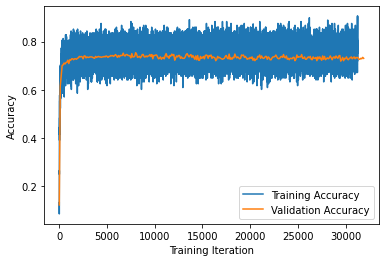

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()